# Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers --quiet
!pip install nltk --quiet
!pip install sentencepiece --quiet
!pip install pyenchant --quiet

     |████████████████████████████████| 4.9 MB 10.0 MB/s 
     |████████████████████████████████| 163 kB 52.2 MB/s 
     |████████████████████████████████| 6.6 MB 61.9 MB/s 
     |████████████████████████████████| 1.3 MB 51.2 MB/s 
     |████████████████████████████████| 55 kB 4.2 MB/s 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from tqdm import tqdm, trange
from collections import Counter
from itertools import chain 
import regex as re
import seaborn as sns
import io

from transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from transformers import BertModel, BertTokenizer, BertForSequenceClassification
from transformers import AdamW

import torch
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
import torch.nn.functional as F
import torchvision.transforms as transforms

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, recall_score, precision_score, multilabel_confusion_matrix

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize


nltk.download('stopwords')
nltk.download('punkt')
ps = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

# Import Data

In [5]:
# Import training and testing sets
train_df = pd.read_excel('drive/My Drive/Colab Notebooks/PROJECT/npsdata_train.xlsx')
test_df = pd.read_excel('drive/My Drive/Colab Notebooks/PROJECT/npsdata_test.xlsx')
# Remove the column of index
train_df = train_df.iloc[: , 1:]
test_df = test_df.iloc[: , 1:]
# Convert labels to integers
train_df[["delivery",	"price",	"quality",	"service"]] = train_df[["delivery",	"price",	"quality",	"service"]].astype(int)
test_df[["delivery",	"price",	"quality",	"service"]] = test_df[["delivery",	"price",	"quality",	"service"]].astype(int)
# Assign reviews text to train-reviews and test-reviews
train_reviews = train_df.text.values
test_reviews = test_df.text.values
# Shape
print("Training Set:", train_df.shape)
print("Testing Set:", test_df.shape)

Training Set: (585, 5)
Testing Set: (147, 5)


# One hot encoding

In [6]:
label_names=["delivery","price","quality","service"] # Define labels names
label_ids=[1,2,3,4] # Define labels ids
# Represent labels in training and testing sets as one-hot encoded vectors
train_labels=[]
for i in range(len(train_df)):
    train_label=[]
    for key in label_names:
        train_label.append(int(train_df.iloc[i][key]))
    train_labels.append(train_label)
test_labels=[]
for i in range(len(test_df)):
    test_label=[]
    for key in label_names:
        test_label.append(int(test_df.iloc[i][key]))
    test_labels.append(test_label)

# Pre-processing

In [7]:
# Function for text Preprocessing
def preprocess(reviews, negation_handling = True, stopword=True):
  max = 0
  clean_reviews = []
  # NLTK stop words list
  stop_words = set(stopwords.words('english')) 
  for review in reviews:
    # Tokenization
    words=word_tokenize(review) 
    # Remove stopwords
    if stopword:
      words = [w for w in words if not w in stop_words]
    # regular expression for not, n't and never  
    neg_feature = re.compile(r"^not$|never|[a-z]n't$")
    negation = False 
    for i in range(len(words)): 
      # Add the prefix NOT_ to every word after negation words (not, n't and never) until punctuation
      if negation_handling:
        if (words[i] not in (',', '.', '?', '!', ';')) & negation:
          words[i] = "NOT_" + words[i]  
        if neg_feature.search(words[i]):       
          negation = True  
        if words[i] in (',', '.', '?', '!', ';'):
          negation = False
    review = ' '.join(word for word in words)
    clean_reviews.append(review)
  #Add sentence tokens: [CLS] token: start, [SEP] token: end.
  clean_reviews = [review + " [SEP] [CLS]" for review in clean_reviews]
  return clean_reviews

def t_count(t, val):
    elements_equal_to_value = tf.equal(t, val)
    as_ints = tf.cast(elements_equal_to_value, tf.int32)
    count = tf.reduce_sum(as_ints)
    return count
def to_labels(t):
  print(len(t))
  print(Counter(list(chain.from_iterable([[label_names[j] for j in range(len(i.tolist())) if i.tolist()[j]==1] for i in t]))))

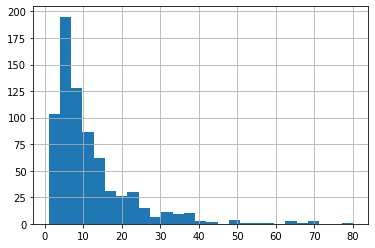

In [8]:
# Find the maximum length of sequences
all_text = np.concatenate([train_reviews, test_reviews])
seq_len = [len(seq.split()) for seq in all_text]
pd.Series(seq_len).hist(bins = 27)
plt.show()

In [17]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

# BERT MODEL

## Training & Fine-tuning

In [9]:
class BertForMultiLabelSequenceClassification(BertForSequenceClassification):
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
                position_ids=None, head_mask=None, inputs_embeds=None, labels=None):
        outputs = self.bert(input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids,
                            position_ids=position_ids,
                            head_mask=head_mask)
        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        # Add hidden states and attention if they are here
        outputs = (logits,) + outputs[2:]  

        if labels is not None:
            loss_fct = BCEWithLogitsLoss()
        # Changes: labels vector is extended to the number labels instead of 1
            loss = loss_fct(logits.view(-1, self.num_labels),
                            labels.view(-1, self.num_labels).type_as(logits.view(-1, self.num_labels)))
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

In [18]:
def bert_model(train_reviews, test_reviews, train_labels, test_labels, epochs = 4, batch_size = 32, lr = 3e-5, T=0.5):

    MAX_LEN = 128
    # Import the BERT tokenizer   
    tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=True)

    # TRAINING SET
    # Get inputs_ids
    tokenized_train = [tokenizer.tokenize(sent) for sent in train_reviews]
    train_inputs = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_train]
    train_inputs = pad_sequences(train_inputs, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
    # Create attention masks
    train_masks = []
    # Create a mask of 1s for each token followed by 0s for padding
    for seq in train_inputs:
      seq_mask = [float(i>0) for i in seq]
      train_masks.append(seq_mask)
    # Convert lists to tensors  
    train_inputs = torch.tensor(train_inputs)
    train_labels = torch.tensor(train_labels)
    train_masks = torch.tensor(train_masks)
    # Create DataLoader
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # TESTING SET
    # Get inputs_ids
    tokenized_test = [tokenizer.tokenize(sent) for sent in test_reviews]
    test_inputs = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_test]
    test_inputs = pad_sequences(test_inputs, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
    # Create attention masks
    test_masks = []
    # Create a mask of 1s for each token followed by 0s for padding
    for seq in test_inputs:
      seq_mask = [float(i>0) for i in seq]
      test_masks.append(seq_mask)
    # Convert lists to tensors  
    test_inputs = torch.tensor(test_inputs)
    test_labels = torch.tensor(test_labels)
    test_masks = torch.tensor(test_masks)
    # Create DataLoader
    test_data = TensorDataset(test_inputs, test_masks, test_labels)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
    
    # Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
    model = BertForMultiLabelSequenceClassification.from_pretrained("bert-base-cased", num_labels= 4)
    model.cuda()

    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.0}
    ]
    # This variable contains all of the hyperparemeter information that the training loop needs
    optimizer = AdamW(optimizer_grouped_parameters, lr=lr)
    # Store the loss
    train_loss_set = []
    model_metrics_ = []
    batch_size_ = 0

    # trange is a tqdm wrapper around the normal python range
    for _ in trange(epochs, desc="Epoch"):
      # Tracking variables
      tr_loss = 0
      nb_tr_examples, nb_tr_steps = 0, 0
      # Train the data for one epoch
      for step, batch in enumerate(train_dataloader):      
        ########### TRAINING ###########
        # Set model to training mode
        model.train()
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]
        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        to_labels(b_labels)
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

        ########### TESTING ###########
        # Set model to evaluation mode to evaluate loss on the test set
        model.eval()
        # Tracking variables 
        eval_loss=0
        nb_eval_steps, nb_eval_examples = 0, 0
        labels,predictions=[],[]
        # Evaluate data for one epoch
        for t_batch in test_dataloader:
          # Add batch to GPU
          t_batch = tuple(t.to(device) for t in t_batch)
          # Unpack the inputs from our dataloader
          t_b_input_ids, t_b_input_mask, t_b_labels = t_batch
          # Telling the model not to compute or store gradients, saving memory and speeding up test
          with torch.no_grad():
            # Forward pass, calculate logit predictions
            output = model(t_b_input_ids, token_type_ids=None, attention_mask=t_b_input_mask)
            logits = output[0]    
          # Move logits and labels to CPU
          prob=torch.sigmoid(logits)
          # If probability greater than or equal to threshold T the review contains that emotion
          pred = (prob >= T).type(torch.FloatTensor)
          pred = pred.detach().cpu().numpy().astype(int).tolist()
          label_ids = t_b_labels.to('cpu').numpy().tolist()
          labels+=label_ids
          predictions+=pred

        labels=np.array(labels)
        predictions=np.array(predictions)
        recall_micro=recall_score(labels, predictions, average = "micro")
        recall_macro=recall_score(labels, predictions, average = "macro")
        precision_micro=precision_score(labels, predictions, average = "micro")
        precision_macro=precision_score(labels, predictions, average = "macro")
        f1_micro=f1_score(labels, predictions, average = "micro")
        f1_macro=f1_score(labels, predictions, average = "macro")
        model_metrics={("Precision","Micro"):precision_micro,("Precision","Macro"):precision_macro,
                      ("Recall","Micro"):recall_micro,("Recall","Macro"):recall_macro,
                      ("F1 score","Micro"):f1_micro,("F1 score","Macro"):f1_macro}
        batch_size_ += len(batch[0])
        print("--------------------------------------------------------------")
        print(step)
        print(batch_size_)
        print(model_metrics)
        model_metrics_.append(model_metrics)
      print("Train loss: {}".format(tr_loss/nb_tr_steps))
    confusion_matrix_ = multilabel_confusion_matrix(labels, predictions)
    vis_arr = np.asarray(confusion_matrix_)
    fig, ax = plt.subplots(1, 4, figsize=(15, 2))
    for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, label_names):
      print_confusion_matrix(cfs_matrix, axes, label, [0, 1])
    fig.tight_layout()
    plt.show()
    return model_metrics_, confusion_matrix_

In [11]:
# Grid Search for hyper-parameter tuning
hps = [
(4, 32, 2e-5,0.5),
(3, 32, 2e-5,0.5),
(4, 32, 3e-5,0.3),
(4, 32, 3e-5,0.5),
(4, 32, 3e-5,0.8)
]
kfold_reviews = preprocess(train_reviews)
# 10-fold cross validation
cv = KFold(n_splits=10, random_state=42, shuffle=True)
val_scores_bert = []
for epochs, batch_size, lr, T in hps:
  hp_scores = []
  for train_index, test_index in cv.split(kfold_reviews):
    tr_reviews = preprocess(train_reviews[train_index])
    va_reviews = preprocess(train_reviews[test_index])
    tr_labels = [train_labels[i] for i in train_index]
    va_labels = [train_labels[i] for i in test_index]
    hp_scores.append(bert_model(tr_reviews, va_reviews, tr_labels, va_labels, epochs, batch_size, lr, T)[0])
  hp_score_df = pd.DataFrame(hp_scores)
  my_list = hp_score_df.values.tolist()
  final_list = []
  for i in my_list:
      final_list= final_list+i
  sums = Counter()
  counters = Counter()
  for itemset in final_list:
      sums.update(itemset)
      counters.update(itemset.keys())
  hp_score = {x: float(sums[x])/counters[x] for x in sums.keys()}
  val_scores_bert.append((str(epochs)+", "+str(batch_size)+", "+str(lr)+", "+str(T), hp_score))

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not in

32
Counter({'quality': 19, 'delivery': 12, 'service': 11, 'price': 7})
--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.3790849673202614, ('Precision', 'Macro'): 0.29843153346285256, ('Recall', 'Micro'): 0.6304347826086957, ('Recall', 'Macro'): 0.58125, ('F1 score', 'Micro'): 0.473469387755102, ('F1 score', 'Macro'): 0.372971817903339}
32
Counter({'quality': 22, 'delivery': 11, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.48360655737704916, ('Precision', 'Macro'): 0.2528492109877265, ('Recall', 'Micro'): 0.6413043478260869, ('Recall', 'Macro'): 0.49375, ('F1 score', 'Micro'): 0.5514018691588786, ('F1 score', 'Macro'): 0.32556187031774736}
32
Counter({'quality': 17, 'delivery': 11, 'price': 10, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.5084745762711864, ('Precision', 'Macro'): 0.2542372881355932, ('Recall', 'Micro'): 0.6521739130434783, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.5714285714285714, ('F1 score', 'Macro'): 0.32860248050121466}
32
Counter({'quality': 20, 'delivery': 12, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.5084745762711864, ('Precision', 'Macro'): 0.2542372881355932, ('Recall', 'Micro'): 0.6521739130434783, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.5714285714285714, ('F1 score', 'Macro'): 0.32860248050121466}
32
Counter({'quality': 20, 'delivery': 12, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.5084745762711864, ('Precision', 'Macro'): 0.2542372881355932, ('Recall', 'Micro'): 0.6521739130434783, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.5714285714285714, ('F1 score', 'Macro'): 0.32860248050121466}
32
Counter({'quality': 15, 'delivery': 11, 'service': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.5084745762711864, ('Precision', 'Macro'): 0.2542372881355932, ('Recall', 'Micro'): 0.6521739130434783, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.5714285714285714, ('F1 score', 'Macro'): 0.32860248050121466}
32
Counter({'quality': 17, 'delivery': 13, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.5084745762711864, ('Precision', 'Macro'): 0.2542372881355932, ('Recall', 'Micro'): 0.6521739130434783, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.5714285714285714, ('F1 score', 'Macro'): 0.32860248050121466}
32
Counter({'delivery': 18, 'quality': 16, 'price': 9, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.5084745762711864, ('Precision', 'Macro'): 0.2542372881355932, ('Recall', 'Micro'): 0.6521739130434783, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.5714285714285714, ('F1 score', 'Macro'): 0.32860248050121466}
32
Counter({'quality': 16, 'delivery': 15, 'service': 12, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.5084745762711864, ('Precision', 'Macro'): 0.2542372881355932, ('Recall', 'Micro'): 0.6521739130434783, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.5714285714285714, ('F1 score', 'Macro'): 0.32860248050121466}
32
Counter({'delivery': 16, 'quality': 15, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.5084745762711864, ('Precision', 'Macro'): 0.2542372881355932, ('Recall', 'Micro'): 0.6521739130434783, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.5714285714285714, ('F1 score', 'Macro'): 0.32860248050121466}
32
Counter({'quality': 19, 'delivery': 13, 'service': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.5084745762711864, ('Precision', 'Macro'): 0.2542372881355932, ('Recall', 'Micro'): 0.6521739130434783, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.5714285714285714, ('F1 score', 'Macro'): 0.32860248050121466}
32
Counter({'quality': 20, 'service': 11, 'price': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.5172413793103449, ('Precision', 'Macro'): 0.25721082366934284, ('Recall', 'Micro'): 0.6521739130434783, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.576923076923077, ('F1 score', 'Macro'): 0.3318903318903319}
32
Counter({'quality': 18, 'delivery': 9, 'service': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.5309734513274337, ('Precision', 'Macro'): 0.26208411801632137, ('Recall', 'Micro'): 0.6521739130434783, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.5853658536585366, ('F1 score', 'Macro'): 0.3371553371553372}
32
Counter({'quality': 18, 'delivery': 14, 'service': 10, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.5405405405405406, ('Precision', 'Macro'): 0.26564537157757495, ('Recall', 'Micro'): 0.6521739130434783, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.5911330049261084, ('F1 score', 'Macro'): 0.34090909090909094}
32
Counter({'quality': 15, 'price': 13, 'service': 10, 'delivery': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.5728155339805825, ('Precision', 'Macro'): 0.2774460708782743, ('Recall', 'Micro'): 0.6413043478260869, ('Recall', 'Macro'): 0.4875, ('F1 score', 'Micro'): 0.6051282051282051, ('F1 score', 'Macro'): 0.350457702020202}
32
Counter({'quality': 17, 'delivery': 16, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.5957446808510638, ('Precision', 'Macro'): 0.2837772397094431, ('Recall', 'Micro'): 0.6086956521739131, ('Recall', 'Macro'): 0.45, ('F1 score', 'Micro'): 0.6021505376344086, ('F1 score', 'Macro'): 0.3474747474747475}
14
Counter({'quality': 8, 'service': 7, 'delivery': 4, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:18<00:56, 18.69s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.6790123456790124, ('Precision', 'Macro'): 0.3399460708782742, ('Recall', 'Micro'): 0.5978260869565217, ('Recall', 'Macro'): 0.4375, ('F1 score', 'Micro'): 0.6358381502890174, ('F1 score', 'Macro'): 0.3805916305916306}
Train loss: 0.6711360742064083
32
Counter({'service': 15, 'quality': 14, 'delivery': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.6842105263157895, ('Precision', 'Macro'): 0.34596211365902296, ('Recall', 'Micro'): 0.5652173913043478, ('Recall', 'Macro'): 0.4, ('F1 score', 'Micro'): 0.6190476190476191, ('F1 score', 'Macro'): 0.36418236418236416}
32
Counter({'quality': 18, 'delivery': 10, 'price': 9, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.7101449275362319, ('Precision', 'Macro'): 0.3944915254237288, ('Recall', 'Micro'): 0.532608695652174, ('Recall', 'Macro'): 0.3625, ('F1 score', 'Micro'): 0.6086956521739131, ('F1 score', 'Macro'): 0.352020202020202}
32
Counter({'quality': 22, 'delivery': 12, 'price': 9, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.6923076923076923, ('Precision', 'Macro'): 0.3778248587570622, ('Recall', 'Micro'): 0.4891304347826087, ('Recall', 'Macro'): 0.3125, ('F1 score', 'Micro'): 0.5732484076433121, ('F1 score', 'Macro'): 0.29817404817404813}
32
Counter({'quality': 18, 'service': 16, 'delivery': 14, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.6923076923076923, ('Precision', 'Macro'): 0.3778248587570622, ('Recall', 'Micro'): 0.4891304347826087, ('Recall', 'Macro'): 0.3125, ('F1 score', 'Micro'): 0.5732484076433121, ('F1 score', 'Macro'): 0.29817404817404813}
32
Counter({'quality': 17, 'price': 12, 'delivery': 11, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.6923076923076923, ('Precision', 'Macro'): 0.3778248587570622, ('Recall', 'Micro'): 0.4891304347826087, ('Recall', 'Macro'): 0.3125, ('F1 score', 'Micro'): 0.5732484076433121, ('F1 score', 'Macro'): 0.29817404817404813}
32
Counter({'quality': 14, 'service': 11, 'price': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.6875, ('Precision', 'Macro'): 0.3694915254237288, ('Recall', 'Micro'): 0.4782608695652174, ('Recall', 'Macro'): 0.3, ('F1 score', 'Micro'): 0.5641025641025642, ('F1 score', 'Macro'): 0.28202020202020206}
32
Counter({'delivery': 13, 'quality': 12, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.6825396825396826, ('Precision', 'Macro'): 0.3569915254237288, ('Recall', 'Micro'): 0.4673913043478261, ('Recall', 'Macro'): 0.2875, ('F1 score', 'Micro'): 0.5548387096774193, ('F1 score', 'Macro'): 0.264520202020202}
32
Counter({'quality': 17, 'delivery': 14, 'price': 6, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.6825396825396826, ('Precision', 'Macro'): 0.3569915254237288, ('Recall', 'Micro'): 0.4673913043478261, ('Recall', 'Macro'): 0.2875, ('F1 score', 'Micro'): 0.5548387096774193, ('F1 score', 'Macro'): 0.264520202020202}
32
Counter({'quality': 19, 'service': 10, 'delivery': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.6833333333333333, ('Precision', 'Macro'): 0.33771929824561403, ('Recall', 'Micro'): 0.44565217391304346, ('Recall', 'Macro'): 0.26875, ('F1 score', 'Micro'): 0.5394736842105263, ('F1 score', 'Macro'): 0.24450918870461677}
32
Counter({'quality': 19, 'delivery': 15, 'service': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.7068965517241379, ('Precision', 'Macro'): 0.42410714285714285, ('Recall', 'Micro'): 0.44565217391304346, ('Recall', 'Macro'): 0.26875, ('F1 score', 'Micro'): 0.5466666666666666, ('F1 score', 'Macro'): 0.24857954545454547}
32
Counter({'quality': 20, 'delivery': 11, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.7017543859649122, ('Precision', 'Macro'): 0.42272727272727273, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.2625, ('F1 score', 'Micro'): 0.5369127516778524, ('F1 score', 'Macro'): 0.24545454545454548}
32
Counter({'quality': 17, 'delivery': 15, 'service': 13, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.7454545454545455, ('Precision', 'Macro'): 0.4326923076923077, ('Recall', 'Micro'): 0.44565217391304346, ('Recall', 'Macro'): 0.27499999999999997, ('F1 score', 'Micro'): 0.5578231292517006, ('F1 score', 'Macro'): 0.27173913043478265}
32
Counter({'quality': 18, 'delivery': 15, 'service': 11, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 0.7543859649122807, ('Precision', 'Macro'): 0.43137254901960786, ('Recall', 'Micro'): 0.4673913043478261, ('Recall', 'Macro'): 0.30625, ('F1 score', 'Micro'): 0.5771812080536913, ('F1 score', 'Macro'): 0.3186813186813187}
32
Counter({'quality': 19, 'delivery': 16, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 0.7636363636363637, ('Precision', 'Macro'): 0.6555555555555556, ('Recall', 'Micro'): 0.45652173913043476, ('Recall', 'Macro'): 0.3209558823529412, ('F1 score', 'Micro'): 0.5714285714285714, ('F1 score', 'Macro'): 0.35982645931935997}
32
Counter({'quality': 21, 'price': 10, 'delivery': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 0.7777777777777778, ('Precision', 'Macro'): 0.5390826873385013, ('Recall', 'Micro'): 0.45652173913043476, ('Recall', 'Macro'): 0.3209558823529412, ('F1 score', 'Micro'): 0.5753424657534246, ('F1 score', 'Macro'): 0.36304200467933434}
32
Counter({'quality': 20, 'delivery': 12, 'price': 10, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 0.7368421052631579, ('Precision', 'Macro'): 0.46193181818181817, ('Recall', 'Micro'): 0.45652173913043476, ('Recall', 'Macro'): 0.31470588235294117, ('F1 score', 'Micro'): 0.5637583892617449, ('F1 score', 'Macro'): 0.35010822510822504}
14
Counter({'price': 7, 'quality': 7, 'delivery': 5, 'service': 5})


Epoch:  50%|█████     | 2/4 [00:35<00:35, 17.62s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.7083333333333334, ('Precision', 'Macro'): 0.7116755793226381, ('Recall', 'Micro'): 0.5543478260869565, ('Recall', 'Macro'): 0.4256127450980392, ('F1 score', 'Micro'): 0.6219512195121951, ('F1 score', 'Macro'): 0.4777676027676028}
Train loss: 0.6204238183358136
32
Counter({'service': 15, 'quality': 14, 'delivery': 12, 'price': 4})
--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.7236842105263158, ('Precision', 'Macro'): 0.7743212669683258, ('Recall', 'Micro'): 0.5978260869565217, ('Recall', 'Macro'): 0.4925245098039216, ('F1 score', 'Micro'): 0.6547619047619048, ('F1 score', 'Macro'): 0.5543956043956044}
32
Counter({'delivery': 17, 'quality': 14, 'price': 9, 'service': 9})
--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.7215189873417721, ('Precision', 'Macro'): 0.7706582633053222, ('Recall', 'Mi

Epoch:  75%|███████▌  | 3/4 [00:52<00:17, 17.49s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.6914893617021277, ('Precision', 'Macro'): 0.6629041248606465, ('Recall', 'Micro'): 0.7065217391304348, ('Recall', 'Macro'): 0.6447303921568628, ('F1 score', 'Micro'): 0.6989247311827957, ('F1 score', 'Macro'): 0.6477605512489233}
Train loss: 0.5504736058852252
32
Counter({'quality': 19, 'delivery': 16, 'price': 12, 'service': 9})
--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.7204301075268817, ('Precision', 'Macro'): 0.7039270253555967, ('Recall', 'Micro'): 0.7282608695652174, ('Recall', 'Macro'): 0.6572303921568627, ('F1 score', 'Micro'): 0.7243243243243243, ('F1 score', 'Macro'): 0.66960216686169}
32
Counter({'quality': 19, 'delivery': 14, 'service': 9, 'price': 8})
--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.7586206896551724, ('Precision', 'Macro'): 0.7585671768707483, ('Recall', 'Micr

Epoch: 100%|██████████| 4/4 [01:10<00:00, 17.72s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.8571428571428571, ('Precision', 'Macro'): 0.8714068825910932, ('Recall', 'Micro'): 0.782608695652174, ('Recall', 'Macro'): 0.7664215686274509, ('F1 score', 'Micro'): 0.8181818181818182, ('F1 score', 'Macro'): 0.8047619047619048}
Train loss: 0.4777793726500343



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 18, 'delivery': 15, 'price': 7, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.45569620253164556, ('Precision', 'Macro'): 0.3413135593220339, ('Recall', 'Micro'): 0.8, ('Recall', 'Macro'): 0.7142857142857143, ('F1 score', 'Micro'): 0.5806451612903226, ('F1 score', 'Macro'): 0.4591676285665357}
32
Counter({'quality': 22, 'service': 9, 'delivery': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.44029850746268656, ('Precision', 'Macro'): 0.3069385593220339, ('Recall', 'Micro'): 0.6555555555555556, ('Recall', 'Macro'): 0.5595238095238095, ('F1 score', 'Micro'): 0.5267857142857143, ('F1 score', 'Macro'): 0.37919421252754587}
32
Counter({'quality': 20, 'delivery': 13, 'service': 10, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.4444444444444444, ('Precision', 'Macro'): 0.2913135593220339, ('Recall', 'Micro'): 0.6222222222222222, ('Recall', 'Macro'): 0.5238095238095238, ('F1 score', 'Micro'): 0.5185185185185185, ('F1 score', 'Macro'): 0.346109403580668}
32
Counter({'quality': 17, 'delivery': 14, 'service': 12, 'price': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.4583333333333333, ('Precision', 'Macro'): 0.35344827586206895, ('Recall', 'Micro'): 0.6111111111111112, ('Recall', 'Macro'): 0.5159970238095238, ('F1 score', 'Micro'): 0.5238095238095238, ('F1 score', 'Macro'): 0.3497222222222222}
32
Counter({'quality': 24, 'delivery': 8, 'service': 7, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.46218487394957986, ('Precision', 'Macro'): 0.3951149425287356, ('Recall', 'Micro'): 0.6111111111111112, ('Recall', 'Macro'): 0.5159970238095238, ('F1 score', 'Micro'): 0.5263157894736842, ('F1 score', 'Macro'): 0.3513888888888889}
32
Counter({'quality': 16, 'delivery': 13, 'service': 12, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.46218487394957986, ('Precision', 'Macro'): 0.3951149425287356, ('Recall', 'Micro'): 0.6111111111111112, ('Recall', 'Macro'): 0.5159970238095238, ('F1 score', 'Micro'): 0.5263157894736842, ('F1 score', 'Macro'): 0.3513888888888889}
32
Counter({'quality': 21, 'delivery': 13, 'service': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.4661016949152542, ('Precision', 'Macro'): 0.39670296430732, ('Recall', 'Micro'): 0.6111111111111112, ('Recall', 'Macro'): 0.5124458874458875, ('F1 score', 'Micro'): 0.5288461538461539, ('F1 score', 'Macro'): 0.3523558368495077}
32
Counter({'quality': 19, 'delivery': 14, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.4661016949152542, ('Precision', 'Macro'): 0.39670296430732, ('Recall', 'Micro'): 0.6111111111111112, ('Recall', 'Macro'): 0.5124458874458875, ('F1 score', 'Micro'): 0.5288461538461539, ('F1 score', 'Macro'): 0.3523558368495077}
32
Counter({'quality': 20, 'delivery': 13, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.4778761061946903, ('Precision', 'Macro'): 0.3619876382563435, ('Recall', 'Micro'): 0.6, ('Recall', 'Macro'): 0.5005411255411255, ('F1 score', 'Micro'): 0.5320197044334977, ('F1 score', 'Macro'): 0.33951690821256036}
32
Counter({'quality': 18, 'price': 9, 'delivery': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.5098039215686274, ('Precision', 'Macro'): 0.4983054226475279, ('Recall', 'Micro'): 0.5777777777777777, ('Recall', 'Macro'): 0.47781385281385286, ('F1 score', 'Micro'): 0.5416666666666666, ('F1 score', 'Macro'): 0.34644194756554303}
32
Counter({'quality': 15, 'price': 12, 'service': 10, 'delivery': 9})
--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.5176470588235295, ('Precision', 'Macro'): 0.4947089947089947, ('Recall', 'Micro'): 0.4888888888888889, ('Recall', 'Macro'): 0.3869047619047619, ('F1 score', 'Micro'): 0.5028571428571429, ('F1 score', 'Macro'): 0.31679035250463816}
32
Counter({'quality': 19, 'service': 9, 'price': 9, 'delivery': 8})
--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.5396825396825397, ('Precision', 'Macro'): 0.44285714285714284, ('Recall', 'Micro'): 0.37777777777777777, ('

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.6226415094339622, ('Precision', 'Macro'): 0.4068627450980392, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.2619047619047619, ('F1 score', 'Micro'): 0.46153846153846156, ('F1 score', 'Macro'): 0.21549835706462214}
32
Counter({'delivery': 17, 'quality': 13, 'service': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.6470588235294118, ('Precision', 'Macro'): 0.41326530612244894, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.2619047619047619, ('F1 score', 'Micro'): 0.46808510638297873, ('F1 score', 'Macro'): 0.22025813692480362}
32
Counter({'delivery': 16, 'quality': 16, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.7045454545454546, ('Precision', 'Macro'): 0.3035714285714286, ('Recall', 'Micro'): 0.34444444444444444, ('Recall', 'Macro'): 0.24627976190476192, ('F1 score', 'Micro'): 0.46268656716417905, ('F1 score', 'Macro'): 0.2244418331374853}
14
Counter({'quality': 10, 'price': 6, 'service': 5, 'delivery': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:18<00:55, 18.66s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.7272727272727273, ('Precision', 'Macro'): 0.43023255813953487, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.2540922619047619, ('F1 score', 'Micro'): 0.4776119402985074, ('F1 score', 'Macro'): 0.2293939393939394}
Train loss: 0.665402212563683
32
Counter({'quality': 15, 'price': 12, 'service': 11, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.7272727272727273, ('Precision', 'Macro'): 0.30952380952380953, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.2540922619047619, ('F1 score', 'Micro'): 0.4776119402985074, ('F1 score', 'Macro'): 0.23119858989424208}
32
Counter({'quality': 18, 'price': 9, 'delivery': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.7073170731707317, ('Precision', 'Macro'): 0.3442982456140351, ('Recall', 'Micro'): 0.32222222222222224, ('Recall', 'Macro'): 0.2347470238095238, ('F1 score', 'Micro'): 0.44274809160305345, ('F1 score', 'Macro'): 0.2345238095238095}
32
Counter({'quality': 19, 'delivery': 12, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.717948717948718, ('Precision', 'Macro'): 0.3472222222222222, ('Recall', 'Micro'): 0.3111111111111111, ('Recall', 'Macro'): 0.2269345238095238, ('F1 score', 'Micro'): 0.434108527131783, ('F1 score', 'Macro'): 0.23284313725490194}
32
Counter({'quality': 19, 'price': 11, 'delivery': 7, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.7435897435897436, ('Precision', 'Macro'): 0.35416666666666663, ('Recall', 'Micro'): 0.32222222222222224, ('Recall', 'Macro'): 0.2347470238095238, ('F1 score', 'Micro'): 0.44961240310077527, ('F1 score', 'Macro'): 0.24019607843137253}
32
Counter({'quality': 18, 'service': 13, 'delivery': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.7441860465116279, ('Precision', 'Macro'): 0.35416666666666663, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25818452380952384, ('F1 score', 'Micro'): 0.481203007518797, ('F1 score', 'Macro'): 0.25}
32
Counter({'quality': 22, 'delivery': 12, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.7333333333333333, ('Precision', 'Macro'): 0.35119047619047616, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.26599702380952384, ('F1 score', 'Micro'): 0.4888888888888889, ('F1 score', 'Macro'): 0.25112612612612617}
32
Counter({'delivery': 16, 'quality': 16, 'service': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.7333333333333333, ('Precision', 'Macro'): 0.43023255813953487, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.26599702380952384, ('F1 score', 'Micro'): 0.4888888888888889, ('F1 score', 'Macro'): 0.25014492753623185}
32
Counter({'quality': 17, 'delivery': 14, 'price': 7, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.717391304347826, ('Precision', 'Macro'): 0.42613636363636365, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.26599702380952384, ('F1 score', 'Micro'): 0.4852941176470588, ('F1 score', 'Macro'): 0.24742562929061787}
32
Counter({'quality': 15, 'service': 15, 'delivery': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.7021276595744681, ('Precision', 'Macro'): 0.3428030303030303, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.26599702380952384, ('F1 score', 'Micro'): 0.4817518248175182, ('F1 score', 'Macro'): 0.2456140350877193}
32
Counter({'delivery': 19, 'quality': 12, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.7619047619047619, ('Precision', 'Macro'): 0.358974358974359, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25818452380952384, ('F1 score', 'Micro'): 0.48484848484848486, ('F1 score', 'Macro'): 0.2529342723004695}
32
Counter({'quality': 19, 'delivery': 17, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.7619047619047619, ('Precision', 'Macro'): 0.358974358974359, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25818452380952384, ('F1 score', 'Micro'): 0.48484848484848486, ('F1 score', 'Macro'): 0.2529342723004695}
32
Counter({'quality': 20, 'service': 10, 'price': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.7619047619047619, ('Precision', 'Macro'): 0.358974358974359, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25818452380952384, ('F1 score', 'Micro'): 0.48484848484848486, ('F1 score', 'Macro'): 0.2529342723004695}
32
Counter({'quality': 26, 'delivery': 13, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 0.7391304347826086, ('Precision', 'Macro'): 0.6011904761904762, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.2773606601731602, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.27286525656090876}
32
Counter({'quality': 17, 'delivery': 15, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 0.723404255319149, ('Precision', 'Macro'): 0.6761363636363636, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.2773606601731602, ('F1 score', 'Micro'): 0.4963503649635037, ('F1 score', 'Macro'): 0.2691647597254005}
32
Counter({'quality': 20, 'delivery': 10, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 0.723404255319149, ('Precision', 'Macro'): 0.6761363636363636, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.2773606601731602, ('F1 score', 'Micro'): 0.4963503649635037, ('F1 score', 'Macro'): 0.2691647597254005}
32
Counter({'quality': 18, 'delivery': 13, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 0.723404255319149, ('Precision', 'Macro'): 0.6761363636363636, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.2773606601731602, ('F1 score', 'Micro'): 0.4963503649635037, ('F1 score', 'Macro'): 0.2691647597254005}
14
Counter({'quality': 9, 'service': 4, 'delivery': 3, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:38<00:38, 19.11s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.723404255319149, ('Precision', 'Macro'): 0.6761363636363636, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.2773606601731602, ('F1 score', 'Micro'): 0.4963503649635037, ('F1 score', 'Macro'): 0.2691647597254005}
Train loss: 0.6073487015331492
32
Counter({'quality': 15, 'delivery': 14, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.7391304347826086, ('Precision', 'Macro'): 0.6802325581395349, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.2773606601731602, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.2718840579710145}
32
Counter({'quality': 20, 'service': 10, 'price': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.7857142857142857, ('Precision', 'Macro'): 0.6923076923076923, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.2695481601731602, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.27648499693815065}
32
Counter({'quality': 16, 'delivery': 12, 'service': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1148
{('Precision', 'Micro'): 0.7857142857142857, ('Precision', 'Macro'): 0.6334459459459459, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.27364042207792205, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.29188405797101447}
32
Counter({'quality': 17, 'delivery': 13, 'service': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1180
{('Precision', 'Micro'): 0.825, ('Precision', 'Macro'): 0.6446428571428572, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.27364042207792205, ('F1 score', 'Micro'): 0.5076923076923076, ('F1 score', 'Macro'): 0.2981570408825438}
32
Counter({'quality': 23, 'delivery': 12, 'service': 9, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1212
{('Precision', 'Micro'): 0.825, ('Precision', 'Macro'): 0.6116071428571428, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.27773268398268397, ('F1 score', 'Micro'): 0.5076923076923076, ('F1 score', 'Macro'): 0.31191770186335405}
32
Counter({'quality': 19, 'delivery': 14, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1244
{('Precision', 'Micro'): 0.8421052631578947, ('Precision', 'Macro'): 0.6344086021505376, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.26992018398268397, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.31009891879457097}
32
Counter({'quality': 17, 'delivery': 11, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1276
{('Precision', 'Micro'): 0.8461538461538461, ('Precision', 'Macro'): 0.6354166666666666, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.27773268398268397, ('F1 score', 'Micro'): 0.5116279069767441, ('F1 score', 'Macro'): 0.31456320450885666}
32
Counter({'quality': 20, 'delivery': 14, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1308
{('Precision', 'Micro'): 0.8717948717948718, ('Precision', 'Macro'): 0.7132352941176471, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.28554518398268397, ('F1 score', 'Micro'): 0.5271317829457365, ('F1 score', 'Macro'): 0.3214361001317523}
32
Counter({'quality': 15, 'service': 11, 'price': 10, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1340
{('Precision', 'Micro'): 0.85, ('Precision', 'Macro'): 0.7071428571428572, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.28554518398268397, ('F1 score', 'Micro'): 0.523076923076923, ('F1 score', 'Macro'): 0.3181570408825438}
32
Counter({'quality': 21, 'delivery': 10, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1372
{('Precision', 'Micro'): 0.813953488372093, ('Precision', 'Macro'): 0.6973684210526316, ('Recall', 'Micro'): 0.3888888888888889, ('Recall', 'Macro'): 0.29335768398268397, ('F1 score', 'Micro'): 0.5263157894736842, ('F1 score', 'Macro'): 0.3160248447204969}
32
Counter({'quality': 20, 'delivery': 9, 'service': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1404
{('Precision', 'Micro'): 0.8, ('Precision', 'Macro'): 0.5360360360360361, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.3052624458874459, ('F1 score', 'Micro'): 0.5333333333333333, ('F1 score', 'Macro'): 0.330817230273752}
32
Counter({'quality': 19, 'service': 12, 'price': 11, 'delivery': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1436
{('Precision', 'Micro'): 0.8085106382978723, ('Precision', 'Macro'): 0.5464527027027027, ('Recall', 'Micro'): 0.4222222222222222, ('Recall', 'Macro'): 0.32907196969696967, ('F1 score', 'Micro'): 0.5547445255474452, ('F1 score', 'Macro'): 0.35891429285357324}
32
Counter({'quality': 17, 'delivery': 11, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1468
{('Precision', 'Micro'): 0.7916666666666666, ('Precision', 'Macro'): 0.5221471471471472, ('Recall', 'Micro'): 0.4222222222222222, ('Recall', 'Macro'): 0.32907196969696967, ('F1 score', 'Micro'): 0.5507246376811594, ('F1 score', 'Macro'): 0.35489130434782606}
32
Counter({'quality': 19, 'delivery': 14, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1500
{('Precision', 'Micro'): 0.8163265306122449, ('Precision', 'Macro'): 0.5783549783549784, ('Recall', 'Micro'): 0.4444444444444444, ('Recall', 'Macro'): 0.35643262987012986, ('F1 score', 'Micro'): 0.5755395683453237, ('F1 score', 'Macro'): 0.3970429104477612}
32
Counter({'quality': 17, 'delivery': 17, 'price': 9, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1532
{('Precision', 'Micro'): 0.8, ('Precision', 'Macro'): 0.5821428571428572, ('Recall', 'Micro'): 0.4888888888888889, ('Recall', 'Macro'): 0.4018871753246753, ('F1 score', 'Micro'): 0.6068965517241379, ('F1 score', 'Macro'): 0.45278154681139754}
32
Counter({'delivery': 16, 'quality': 16, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1564
{('Precision', 'Micro'): 0.7586206896551724, ('Precision', 'Macro'): 0.5302197802197802, ('Recall', 'Micro'): 0.4888888888888889, ('Recall', 'Macro'): 0.4018871753246753, ('F1 score', 'Micro'): 0.5945945945945945, ('F1 score', 'Macro'): 0.4425208516242317}
14
Counter({'quality': 9, 'service': 6, 'delivery': 3, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  75%|███████▌  | 3/4 [00:57<00:19, 19.43s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.7627118644067796, ('Precision', 'Macro'): 0.5404761904761904, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.41270968614718617, ('F1 score', 'Micro'): 0.6040268456375839, ('F1 score', 'Macro'): 0.4552770904834118}
Train loss: 0.5442974532351774
32
Counter({'quality': 13, 'delivery': 11, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.7894736842105263, ('Precision', 'Macro'): 0.5707792207792208, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.41270968614718617, ('F1 score', 'Micro'): 0.6122448979591837, ('F1 score', 'Macro'): 0.4626300316598824}
32
Counter({'quality': 21, 'delivery': 12, 'service': 7, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.8148148148148148, ('Precision', 'Macro'): 0.607711038961039, ('Recall', 'Micro'): 0.4888888888888889, ('Recall', 'Macro'): 0.40080492424242425, ('F1 score', 'Micro'): 0.611111111111111, ('F1 score', 'Macro'): 0.4583196868322962}
32
Counter({'quality': 17, 'delivery': 13, 'service': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1674
{('Precision', 'Micro'): 0.8333333333333334, ('Precision', 'Macro'): 0.6446428571428572, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.4121685606060606, ('F1 score', 'Micro'): 0.625, ('F1 score', 'Macro'): 0.47377085162423177}
32
Counter({'quality': 16, 'service': 12, 'delivery': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1706
{('Precision', 'Micro'): 0.8518518518518519, ('Precision', 'Macro'): 0.6450534759358288, ('Recall', 'Micro'): 0.5111111111111111, ('Recall', 'Macro'): 0.4246144480519481, ('F1 score', 'Micro'): 0.6388888888888888, ('F1 score', 'Macro'): 0.49090909090909085}
32
Counter({'quality': 16, 'delivery': 15, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1738
{('Precision', 'Micro'): 0.8727272727272727, ('Precision', 'Macro'): 0.6543560606060607, ('Recall', 'Micro'): 0.5333333333333333, ('Recall', 'Macro'): 0.4514339826839827, ('F1 score', 'Micro'): 0.6620689655172414, ('F1 score', 'Macro'): 0.5220588235294118}
32
Counter({'quality': 24, 'price': 11, 'service': 10, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1770
{('Precision', 'Micro'): 0.8571428571428571, ('Precision', 'Macro'): 0.6354166666666667, ('Recall', 'Micro'): 0.5333333333333333, ('Recall', 'Macro'): 0.4514339826839827, ('F1 score', 'Micro'): 0.6575342465753424, ('F1 score', 'Macro'): 0.5173239750445633}
32
Counter({'quality': 17, 'delivery': 14, 'price': 6, 'service': 6})
--------------------------------------------------------------
6
1802
{('Precision', 'Micro'): 0.875, ('Precision', 'Macro'): 0.9043560606060607, ('Recall', 'Micro'): 0.5444444444444444, ('Recall', 'Macro'): 0.4681006493506493, ('F1 score', 'Micro'): 0.6712328767123288, ('F1 score', 'Macro'): 0.5533088235294118}
32
Counter({'quality': 15, 'delivery': 14, 'service': 11, 'price': 8})
--------------------------------------------------------------
7
1834
{('Precision', 'Micro'): 0.875, ('Precision', 'Macro'): 0.9020833333333333, ('Recall', 'Micro'): 0.5444444444444444, ('Recall', 'Macro'): 0.47286255

Epoch: 100%|██████████| 4/4 [01:17<00:00, 19.28s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.8225806451612904, ('Precision', 'Macro'): 0.8396291208791209, ('Recall', 'Micro'): 0.5666666666666667, ('Recall', 'Macro'): 0.5014339826839826, ('F1 score', 'Micro'): 0.6710526315789475, ('F1 score', 'Macro'): 0.588031045751634}
Train loss: 0.47142063168918386



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 16, 'delivery': 15, 'service': 11, 'price': 8})
--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.3989071038251366, ('Precision', 'Macro'): 0.429524850395958, ('Recall', 'Micro'): 0.8588235294117647, ('Recall', 'Macro'): 0.8628571428571429, ('F1 score', 'Micro'): 0.5447761194029851, ('F1 score', 'Macro'): 0.5472292542076466}
32
Counter({'quality': 22, 'service': 15, 'price': 7, 'delivery': 7})
--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.4010989010989011, ('Precision', 'Macro'): 0.4756062902614627, ('Recall', 'Micro'): 0.8588235294117647, ('Recall', 'Macro'): 0.8605357142857143, ('F1 score', 'Micro'): 0.5468164794007491, ('F1 score', 'Macro'): 0.5559706414534347}
32
Counter({'quality': 18, 'delivery': 15, 'price': 8, 'service': 8})
--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.40437158469945356, ('Precision', 'Macro'): 0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.5063291139240507, ('Precision', 'Macro'): 0.37772844987051424, ('Recall', 'Micro'): 0.47058823529411764, ('Recall', 'Macro'): 0.42410714285714285, ('F1 score', 'Micro'): 0.4878048780487805, ('F1 score', 'Macro'): 0.363605692553061}
32
Counter({'quality': 16, 'delivery': 13, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.5324675324675324, ('Precision', 'Macro'): 0.42348008385744235, ('Recall', 'Micro'): 0.4823529411764706, ('Recall', 'Macro'): 0.43601190476190477, ('F1 score', 'Micro'): 0.5061728395061729, ('F1 score', 'Macro'): 0.37692307692307686}
32
Counter({'quality': 21, 'delivery': 11, 'price': 7, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.56, ('Precision', 'Macro'): 0.5521350546176762, ('Recall', 'Micro'): 0.49411764705882355, ('Recall', 'Macro'): 0.44791666666666663, ('F1 score', 'Micro'): 0.525, ('F1 score', 'Macro'): 0.39081196581196576}
32
Counter({'quality': 18, 'service': 13, 'delivery': 13, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.5675675675675675, ('Precision', 'Macro'): 0.5544028340080971, ('Recall', 'Micro'): 0.49411764705882355, ('Recall', 'Macro'): 0.44791666666666663, ('F1 score', 'Micro'): 0.5283018867924529, ('F1 score', 'Macro'): 0.39289321789321785}
32
Counter({'quality': 19, 'delivery': 12, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.5633802816901409, ('Precision', 'Macro'): 0.5567595459236325, ('Recall', 'Micro'): 0.47058823529411764, ('Recall', 'Macro'): 0.4270833333333333, ('F1 score', 'Micro'): 0.5128205128205128, ('F1 score', 'Macro'): 0.3594736842105263}
32
Counter({'quality': 24, 'service': 10, 'price': 9, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.5362318840579711, ('Precision', 'Macro'): 0.31574074074074077, ('Recall', 'Micro'): 0.43529411764705883, ('Recall', 'Macro'): 0.39285714285714285, ('F1 score', 'Micro'): 0.48051948051948057, ('F1 score', 'Macro'): 0.32489451476793246}
32
Counter({'quality': 18, 'service': 10, 'delivery': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.5373134328358209, ('Precision', 'Macro'): 0.5909090909090908, ('Recall', 'Micro'): 0.4235294117647059, ('Recall', 'Macro'): 0.37946428571428575, ('F1 score', 'Micro'): 0.47368421052631576, ('F1 score', 'Macro'): 0.3325}
32
Counter({'quality': 20, 'price': 10, 'delivery': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.5079365079365079, ('Precision', 'Macro'): 0.6116071428571428, ('Recall', 'Micro'): 0.3764705882352941, ('Recall', 'Macro'): 0.3318452380952381, ('F1 score', 'Micro'): 0.4324324324324324, ('F1 score', 'Macro'): 0.28543209876543213}
14
Counter({'quality': 7, 'delivery': 6, 'service': 5, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:18<00:56, 18.94s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.5, ('Precision', 'Macro'): 0.6096491228070176, ('Recall', 'Micro'): 0.3764705882352941, ('Recall', 'Macro'): 0.33035714285714285, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.2870544090056285}
Train loss: 0.6651175898664138
32
Counter({'quality': 17, 'delivery': 15, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.49206349206349204, ('Precision', 'Macro'): 0.6096491228070176, ('Recall', 'Micro'): 0.36470588235294116, ('Recall', 'Macro'): 0.3199404761904762, ('F1 score', 'Micro'): 0.41891891891891886, ('F1 score', 'Macro'): 0.26859287054409003}
32
Counter({'quality': 18, 'delivery': 14, 'service': 5, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.4838709677419355, ('Precision', 'Macro'): 0.35964912280701755, ('Recall', 'Micro'): 0.35294117647058826, ('Recall', 'Macro'): 0.30952380952380953, ('F1 score', 'Micro'): 0.40816326530612246, ('F1 score', 'Macro'): 0.24859287054409004}
32
Counter({'quality': 17, 'delivery': 11, 'price': 10, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.4838709677419355, ('Precision', 'Macro'): 0.35964912280701755, ('Recall', 'Micro'): 0.35294117647058826, ('Recall', 'Macro'): 0.30952380952380953, ('F1 score', 'Micro'): 0.40816326530612246, ('F1 score', 'Macro'): 0.24859287054409004}
32
Counter({'quality': 19, 'delivery': 12, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.5076923076923077, ('Precision', 'Macro'): 0.35964912280701755, ('Recall', 'Micro'): 0.38823529411764707, ('Recall', 'Macro'): 0.34523809523809523, ('F1 score', 'Micro'): 0.44, ('F1 score', 'Macro'): 0.2903700588730025}
32
Counter({'quality': 21, 'delivery': 14, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.5147058823529411, ('Precision', 'Macro'): 0.3369218500797448, ('Recall', 'Micro'): 0.4117647058823529, ('Recall', 'Macro'): 0.36904761904761907, ('F1 score', 'Micro'): 0.45751633986928103, ('F1 score', 'Macro'): 0.30868902439024387}
32
Counter({'quality': 20, 'price': 14, 'delivery': 12, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.547945205479452, ('Precision', 'Macro'): 0.32196969696969696, ('Recall', 'Micro'): 0.47058823529411764, ('Recall', 'Macro'): 0.4285714285714286, ('F1 score', 'Micro'): 0.5063291139240506, ('F1 score', 'Macro'): 0.3485576923076923}
32
Counter({'quality': 18, 'delivery': 10, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.5555555555555556, ('Precision', 'Macro'): 0.32407407407407407, ('Recall', 'Micro'): 0.47058823529411764, ('Recall', 'Macro'): 0.4285714285714286, ('F1 score', 'Micro'): 0.5095541401273886, ('F1 score', 'Macro'): 0.35053554040895807}
32
Counter({'quality': 23, 'delivery': 12, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.5797101449275363, ('Precision', 'Macro'): 0.33088235294117646, ('Recall', 'Micro'): 0.47058823529411764, ('Recall', 'Macro'): 0.4285714285714286, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.3567813765182186}
32
Counter({'delivery': 18, 'quality': 15, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.5882352941176471, ('Precision', 'Macro'): 0.325, ('Recall', 'Micro'): 0.47058823529411764, ('Recall', 'Macro'): 0.43047619047619046, ('F1 score', 'Micro'): 0.5228758169934641, ('F1 score', 'Macro'): 0.3595055128633478}
32
Counter({'quality': 21, 'service': 12, 'price': 10, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.6349206349206349, ('Precision', 'Macro'): 0.3395348837209302, ('Recall', 'Micro'): 0.47058823529411764, ('Recall', 'Macro'): 0.43047619047619046, ('F1 score', 'Micro'): 0.5405405405405405, ('F1 score', 'Macro'): 0.3715925394548063}
32
Counter({'quality': 21, 'service': 10, 'price': 8, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.6349206349206349, ('Precision', 'Macro'): 0.3395348837209302, ('Recall', 'Micro'): 0.47058823529411764, ('Recall', 'Macro'): 0.43047619047619046, ('F1 score', 'Micro'): 0.5405405405405405, ('F1 score', 'Macro'): 0.3715925394548063}
32
Counter({'quality': 16, 'delivery': 13, 'price': 9, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.65, ('Precision', 'Macro'): 0.34375, ('Recall', 'Micro'): 0.4588235294117647, ('Recall', 'Macro'): 0.42047619047619045, ('F1 score', 'Micro'): 0.5379310344827586, ('F1 score', 'Macro'): 0.3720450281425891}
32
Counter({'quality': 17, 'delivery': 11, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 0.6440677966101694, ('Precision', 'Macro'): 0.5881578947368421, ('Recall', 'Micro'): 0.4470588235294118, ('Recall', 'Macro'): 0.41714285714285715, ('F1 score', 'Micro'): 0.5277777777777777, ('F1 score', 'Macro'): 0.3930386178861789}
32
Counter({'quality': 19, 'service': 14, 'delivery': 10, 'price': 6})
--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 0.6610169491525424, ('Precision', 'Macro'): 0.8418918918918918, ('Recall', 'Micro'): 0.4588235294117647, ('Recall', 'Macro'): 0.42755952380952383, ('F1 score', 'Micro'): 0.5416666666666666, ('F1 score', 'Macro'): 0.41572678992918966}
32
Counter({'quality': 21, 'delivery': 11, 'service': 11, 'price': 8})
--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 0.6551724137931034, ('Precision', 'Macro'): 0.8392603129445235, ('Recall', 'Micro'): 0.4470588235294118, 

Epoch:  50%|█████     | 2/4 [00:38<00:38, 19.13s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.8432017543859649, ('Recall', 'Micro'): 0.47058823529411764, ('Recall', 'Macro'): 0.4489880952380953, ('F1 score', 'Micro'): 0.5555555555555555, ('F1 score', 'Macro'): 0.46296448087431696}
Train loss: 0.5673159168047064
32
Counter({'quality': 24, 'delivery': 11, 'price': 9, 'service': 8})
--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.6551724137931034, ('Precision', 'Macro'): 0.8330683624801272, ('Recall', 'Micro'): 0.4470588235294118, ('Recall', 'Macro'): 0.42517857142857146, ('F1 score', 'Micro'): 0.5314685314685316, ('F1 score', 'Macro'): 0.44374080362195817}
32
Counter({'quality': 17, 'delivery': 14, 'service': 7, 'price': 4})
--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.6538461538461539, ('Precision', 'Macro'): 0.8303571428571428, ('Recall', 

Epoch:  75%|███████▌  | 3/4 [00:57<00:19, 19.23s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.7464788732394366, ('Precision', 'Macro'): 0.8322916666666667, ('Recall', 'Micro'): 0.6235294117647059, ('Recall', 'Macro'): 0.6314285714285715, ('F1 score', 'Micro'): 0.6794871794871796, ('F1 score', 'Macro'): 0.6793793793793794}
Train loss: 0.4788067165543051
32
Counter({'quality': 16, 'delivery': 15, 'service': 10, 'price': 10})
--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.7397260273972602, ('Precision', 'Macro'): 0.8377252252252252, ('Recall', 'Micro'): 0.6352941176470588, ('Recall', 'Macro'): 0.6418452380952381, ('F1 score', 'Micro'): 0.6835443037974683, ('F1 score', 'Macro'): 0.689977734332573}
32
Counter({'quality': 19, 'delivery': 14, 'price': 11, 'service': 8})
--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.7432432432432432, ('Precision', 'Macro'): 0.8377252252252252, ('Recall', 'M

Epoch: 100%|██████████| 4/4 [01:16<00:00, 19.21s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.7714285714285715, ('Precision', 'Macro'): 0.875, ('Recall', 'Micro'): 0.6352941176470588, ('Recall', 'Macro'): 0.6333928571428571, ('F1 score', 'Micro'): 0.6967741935483872, ('F1 score', 'Macro'): 0.6858592997871157}
Train loss: 0.400577071835013



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 18, 'delivery': 15, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.3185840707964602, ('Precision', 'Macro'): 0.39026580459770116, ('Recall', 'Micro'): 0.42857142857142855, ('Recall', 'Macro'): 0.5251547987616099, ('F1 score', 'Micro'): 0.36548223350253806, ('F1 score', 'Macro'): 0.29794581101461337}
32
Counter({'quality': 17, 'delivery': 12, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.36792452830188677, ('Precision', 'Macro'): 0.3132828038488416, ('Recall', 'Micro'): 0.4642857142857143, ('Recall', 'Macro'): 0.4698787409700722, ('F1 score', 'Micro'): 0.4105263157894737, ('F1 score', 'Macro'): 0.3316099201345103}
32
Counter({'quality': 15, 'delivery': 13, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.42718446601941745, ('Precision', 'Macro'): 0.2924446374294398, ('Recall', 'Micro'): 0.5238095238095238, ('Recall', 'Macro'): 0.4834236326109391, ('F1 score', 'Micro'): 0.4705882352941177, ('F1 score', 'Macro'): 0.31998349757912603}
32
Counter({'quality': 18, 'service': 16, 'delivery': 12, 'price': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.4329896907216495, ('Precision', 'Macro'): 0.22211675367821548, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.4571078431372549, ('F1 score', 'Micro'): 0.4640883977900553, ('F1 score', 'Macro'): 0.28674698795180725}
32
Counter({'quality': 14, 'delivery': 12, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.47191011235955055, ('Precision', 'Macro'): 0.2915259009009009, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.44943240454076366, ('F1 score', 'Micro'): 0.48554913294797686, ('F1 score', 'Macro'): 0.31280433700521565}
32
Counter({'quality': 19, 'delivery': 16, 'service': 7, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.4936708860759494, ('Precision', 'Macro'): 0.3468031609195402, ('Recall', 'Micro'): 0.4642857142857143, ('Recall', 'Macro'): 0.38693240454076366, ('F1 score', 'Micro'): 0.4785276073619632, ('F1 score', 'Macro'): 0.2981997677119629}
32
Counter({'quality': 17, 'delivery': 9, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.5522388059701493, ('Precision', 'Macro'): 0.36699084668192217, ('Recall', 'Micro'): 0.44047619047619047, ('Recall', 'Macro'): 0.35874613003095973, ('F1 score', 'Micro'): 0.4900662251655629, ('F1 score', 'Macro'): 0.30808371735791096}
32
Counter({'quality': 19, 'delivery': 11, 'service': 7, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.5901639344262295, ('Precision', 'Macro'): 0.38095238095238093, ('Recall', 'Micro'): 0.42857142857142855, ('Recall', 'Macro'): 0.3379127966976264, ('F1 score', 'Micro'): 0.496551724137931, ('F1 score', 'Macro'): 0.309836787684889}
32
Counter({'quality': 16, 'delivery': 14, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.4285714285714286, ('Recall', 'Micro'): 0.42857142857142855, ('Recall', 'Macro'): 0.3379127966976264, ('F1 score', 'Micro'): 0.5217391304347826, ('F1 score', 'Macro'): 0.334814308498519}
32
Counter({'quality': 19, 'price': 11, 'service': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.7142857142857143, ('Precision', 'Macro'): 0.47459349593495936, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.31707946336429305, ('F1 score', 'Micro'): 0.5263157894736842, ('F1 score', 'Macro'): 0.33492063492063495}
32
Counter({'quality': 20, 'price': 13, 'delivery': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.7391304347826086, ('Precision', 'Macro'): 0.6025641025641025, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.3097265221878225, ('F1 score', 'Micro'): 0.523076923076923, ('F1 score', 'Macro'): 0.33474124809741246}
32
Counter({'quality': 16, 'service': 12, 'delivery': 11, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.8048780487804879, ('Precision', 'Macro'): 0.6959459459459459, ('Recall', 'Micro'): 0.39285714285714285, ('Recall', 'Macro'): 0.28889318885448917, ('F1 score', 'Micro'): 0.528, ('F1 score', 'Macro'): 0.32922535211267606}
32
Counter({'quality': 18, 'service': 12, 'price': 11, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.8461538461538461, ('Precision', 'Macro'): 0.7071428571428572, ('Recall', 'Micro'): 0.39285714285714285, ('Recall', 'Macro'): 0.2812177502579979, ('F1 score', 'Micro'): 0.5365853658536585, ('F1 score', 'Macro'): 0.32919254658385094}
32
Counter({'quality': 18, 'delivery': 14, 'service': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.8648648648648649, ('Precision', 'Macro'): 0.7132352941176471, ('Recall', 'Micro'): 0.38095238095238093, ('Recall', 'Macro'): 0.26038441692466463, ('F1 score', 'Micro'): 0.5289256198347108, ('F1 score', 'Macro'): 0.29931588019823313}
32
Counter({'quality': 22, 'delivery': 12, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.8055555555555556, ('Precision', 'Macro'): 0.33712121212121215, ('Recall', 'Micro'): 0.34523809523809523, ('Recall', 'Macro'): 0.21904024767801855, ('F1 score', 'Micro'): 0.48333333333333345, ('F1 score', 'Macro'): 0.23276474769012084}
32
Counter({'quality': 21, 'delivery': 18, 'service': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.7948717948717948, ('Precision', 'Macro'): 0.3799019607843137, ('Recall', 'Micro'): 0.36904761904761907, ('Recall', 'Macro'): 0.23955108359133126, ('F1 score', 'Micro'): 0.5040650406504066, ('F1 score', 'Macro'): 0.2586898395721925}
14
Counter({'quality': 11, 'delivery': 6, 'service': 4, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:19<00:57, 19.05s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.7857142857142857, ('Precision', 'Macro'): 0.3355263157894737, ('Recall', 'Micro'): 0.39285714285714285, ('Recall', 'Macro'): 0.2484520123839009, ('F1 score', 'Micro'): 0.5238095238095237, ('F1 score', 'Macro'): 0.24603174603174602}
Train loss: 0.6470474846222821
32
Counter({'quality': 24, 'delivery': 16, 'price': 6, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.75, ('Precision', 'Macro'): 0.325, ('Recall', 'Micro'): 0.39285714285714285, ('Recall', 'Macro'): 0.2484520123839009, ('F1 score', 'Micro'): 0.515625, ('F1 score', 'Macro'): 0.24002574002574}
32
Counter({'quality': 23, 'service': 9, 'delivery': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.8, ('Precision', 'Macro'): 0.2, ('Recall', 'Micro'): 0.38095238095238093, ('Recall', 'Macro'): 0.23529411764705882, ('F1 score', 'Micro'): 0.5161290322580645, ('F1 score', 'Macro'): 0.2162162162162162}
32
Counter({'quality': 21, 'delivery': 13, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.8205128205128205, ('Precision', 'Macro'): 0.20512820512820512, ('Recall', 'Micro'): 0.38095238095238093, ('Recall', 'Macro'): 0.23529411764705882, ('F1 score', 'Micro'): 0.5203252032520325, ('F1 score', 'Macro'): 0.2191780821917808}
32
Counter({'price': 15, 'quality': 13, 'delivery': 12, 'service': 12})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.8648648648648649, ('Precision', 'Macro'): 0.4652777777777778, ('Recall', 'Micro'): 0.38095238095238093, ('Recall', 'Macro'): 0.24109907120743035, ('F1 score', 'Micro'): 0.5289256198347108, ('F1 score', 'Macro'): 0.24642857142857144}
32
Counter({'quality': 15, 'delivery': 14, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.8648648648648649, ('Precision', 'Macro'): 0.4642857142857143, ('Recall', 'Micro'): 0.38095238095238093, ('Recall', 'Macro'): 0.24690402476780185, ('F1 score', 'Micro'): 0.5289256198347108, ('F1 score', 'Macro'): 0.2650103519668737}
32
Counter({'quality': 19, 'delivery': 14, 'price': 8, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.8918918918918919, ('Precision', 'Macro'): 0.47058823529411764, ('Recall', 'Micro'): 0.39285714285714285, ('Recall', 'Macro'): 0.26006191950464397, ('F1 score', 'Micro'): 0.5454545454545454, ('F1 score', 'Macro'): 0.2887700534759358}
32
Counter({'quality': 19, 'delivery': 11, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.9117647058823529, ('Precision', 'Macro'): 0.47580645161290325, ('Recall', 'Micro'): 0.36904761904761907, ('Recall', 'Macro'): 0.2453560371517028, ('F1 score', 'Micro'): 0.5254237288135594, ('F1 score', 'Macro'): 0.2835664335664336}
32
Counter({'quality': 19, 'delivery': 13, 'service': 11, 'price': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.8918918918918919, ('Precision', 'Macro'): 0.47058823529411764, ('Recall', 'Micro'): 0.39285714285714285, ('Recall', 'Macro'): 0.26006191950464397, ('F1 score', 'Micro'): 0.5454545454545454, ('F1 score', 'Macro'): 0.2887700534759358}
32
Counter({'quality': 18, 'delivery': 11, 'service': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.868421052631579, ('Precision', 'Macro'): 0.4642857142857143, ('Recall', 'Micro'): 0.39285714285714285, ('Recall', 'Macro'): 0.26006191950464397, ('F1 score', 'Micro'): 0.5409836065573771, ('F1 score', 'Macro'): 0.2855731225296443}
32
Counter({'quality': 20, 'delivery': 15, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.8717948717948718, ('Precision', 'Macro'): 0.4652777777777778, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.26741486068111453, ('F1 score', 'Micro'): 0.5528455284552847, ('F1 score', 'Macro'): 0.28961038961038965}
32
Counter({'quality': 16, 'service': 13, 'delivery': 11, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.868421052631579, ('Precision', 'Macro'): 0.4642857142857143, ('Recall', 'Micro'): 0.39285714285714285, ('Recall', 'Macro'): 0.26006191950464397, ('F1 score', 'Micro'): 0.5409836065573771, ('F1 score', 'Macro'): 0.2855731225296443}
32
Counter({'quality': 19, 'delivery': 17, 'service': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.868421052631579, ('Precision', 'Macro'): 0.4642857142857143, ('Recall', 'Micro'): 0.39285714285714285, ('Recall', 'Macro'): 0.26006191950464397, ('F1 score', 'Micro'): 0.5409836065573771, ('F1 score', 'Macro'): 0.2855731225296443}
32
Counter({'quality': 17, 'price': 14, 'service': 12, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 0.868421052631579, ('Precision', 'Macro'): 0.4642857142857143, ('Recall', 'Micro'): 0.39285714285714285, ('Recall', 'Macro'): 0.26006191950464397, ('F1 score', 'Micro'): 0.5409836065573771, ('F1 score', 'Macro'): 0.2855731225296443}
32
Counter({'quality': 16, 'delivery': 13, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 0.8648648648648649, ('Precision', 'Macro'): 0.4632352941176471, ('Recall', 'Micro'): 0.38095238095238093, ('Recall', 'Macro'): 0.25270897832817335, ('F1 score', 'Micro'): 0.5289256198347108, ('F1 score', 'Macro'): 0.2814171122994652}
32
Counter({'quality': 17, 'service': 13, 'delivery': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 0.8888888888888888, ('Precision', 'Macro'): 0.4696969696969697, ('Recall', 'Micro'): 0.38095238095238093, ('Recall', 'Macro'): 0.25270897832817335, ('F1 score', 'Micro'): 0.5333333333333333, ('F1 score', 'Macro'): 0.2845997286295794}
32
Counter({'quality': 13, 'service': 12, 'delivery': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 0.8888888888888888, ('Precision', 'Macro'): 0.4696969696969697, ('Recall', 'Micro'): 0.38095238095238093, ('Recall', 'Macro'): 0.25270897832817335, ('F1 score', 'Micro'): 0.5333333333333333, ('F1 score', 'Macro'): 0.2845997286295794}
14
Counter({'quality': 9, 'price': 4, 'delivery': 3, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:38<00:38, 19.18s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.9142857142857143, ('Precision', 'Macro'): 0.4765625, ('Recall', 'Micro'): 0.38095238095238093, ('Recall', 'Macro'): 0.25270897832817335, ('F1 score', 'Micro'): 0.5378151260504201, ('F1 score', 'Macro'): 0.28787878787878785}
Train loss: 0.5680258835063261
32
Counter({'quality': 19, 'price': 12, 'service': 10, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.9142857142857143, ('Precision', 'Macro'): 0.4765625, ('Recall', 'Micro'): 0.38095238095238093, ('Recall', 'Macro'): 0.25270897832817335, ('F1 score', 'Micro'): 0.5378151260504201, ('F1 score', 'Macro'): 0.28787878787878785}
32
Counter({'delivery': 17, 'quality': 16, 'service': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.9142857142857143, ('Precision', 'Macro'): 0.4765625, ('Recall', 'Micro'): 0.38095238095238093, ('Recall', 'Macro'): 0.25270897832817335, ('F1 score', 'Micro'): 0.5378151260504201, ('F1 score', 'Macro'): 0.28787878787878785}
32
Counter({'quality': 17, 'service': 12, 'delivery': 12, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1148
{('Precision', 'Micro'): 0.8974358974358975, ('Precision', 'Macro'): 0.4714285714285714, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.2805727554179567, ('F1 score', 'Micro'): 0.5691056910569106, ('F1 score', 'Macro'): 0.3115942028985507}
32
Counter({'quality': 18, 'delivery': 12, 'price': 7, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1180
{('Precision', 'Micro'): 0.9, ('Precision', 'Macro'): 0.4722222222222222, ('Recall', 'Micro'): 0.42857142857142855, ('Recall', 'Macro'): 0.28792569659442724, ('F1 score', 'Micro'): 0.5806451612903225, ('F1 score', 'Macro'): 0.315527950310559}
32
Counter({'quality': 16, 'delivery': 10, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1212
{('Precision', 'Micro'): 0.9, ('Precision', 'Macro'): 0.4722222222222222, ('Recall', 'Micro'): 0.42857142857142855, ('Recall', 'Macro'): 0.28792569659442724, ('F1 score', 'Micro'): 0.5806451612903225, ('F1 score', 'Macro'): 0.315527950310559}
32
Counter({'quality': 20, 'delivery': 12, 'price': 11, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1244
{('Precision', 'Micro'): 0.9444444444444444, ('Precision', 'Macro'): 0.484375, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.27321981424148606, ('F1 score', 'Micro'): 0.5666666666666667, ('F1 score', 'Macro'): 0.31422924901185767}
32
Counter({'quality': 18, 'service': 11, 'delivery': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1276
{('Precision', 'Micro'): 0.9714285714285714, ('Precision', 'Macro'): 0.49193548387096775, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.27321981424148606, ('F1 score', 'Micro'): 0.5714285714285714, ('F1 score', 'Macro'): 0.3177257525083612}
32
Counter({'quality': 25, 'delivery': 11, 'price': 6, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1308
{('Precision', 'Micro'): 0.9714285714285714, ('Precision', 'Macro'): 0.49193548387096775, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.27321981424148606, ('F1 score', 'Micro'): 0.5714285714285714, ('F1 score', 'Macro'): 0.3177257525083612}
32
Counter({'quality': 16, 'delivery': 14, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1340
{('Precision', 'Micro'): 0.9473684210526315, ('Precision', 'Macro'): 0.4852941176470588, ('Recall', 'Micro'): 0.42857142857142855, ('Recall', 'Macro'): 0.28792569659442724, ('F1 score', 'Micro'): 0.5901639344262295, ('F1 score', 'Macro'): 0.32225063938618925}
32
Counter({'quality': 17, 'service': 13, 'price': 8, 'delivery': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1372
{('Precision', 'Micro'): 0.8974358974358975, ('Precision', 'Macro'): 0.4722222222222222, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.27476780185758515, ('F1 score', 'Micro'): 0.5691056910569106, ('F1 score', 'Macro'): 0.29675324675324677}
32
Counter({'quality': 16, 'delivery': 13, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1404
{('Precision', 'Micro'): 0.9473684210526315, ('Precision', 'Macro'): 0.4852941176470588, ('Recall', 'Micro'): 0.42857142857142855, ('Recall', 'Macro'): 0.28792569659442724, ('F1 score', 'Micro'): 0.5901639344262295, ('F1 score', 'Macro'): 0.32225063938618925}
32
Counter({'delivery': 19, 'quality': 18, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1436
{('Precision', 'Micro'): 0.9473684210526315, ('Precision', 'Macro'): 0.4852941176470588, ('Recall', 'Micro'): 0.42857142857142855, ('Recall', 'Macro'): 0.28792569659442724, ('F1 score', 'Micro'): 0.5901639344262295, ('F1 score', 'Macro'): 0.32225063938618925}
32
Counter({'quality': 18, 'service': 12, 'delivery': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1468
{('Precision', 'Micro'): 0.9459459459459459, ('Precision', 'Macro'): 0.484375, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.28637770897832815, ('F1 score', 'Micro'): 0.578512396694215, ('F1 score', 'Macro'): 0.3314393939393939}
32
Counter({'quality': 19, 'price': 13, 'delivery': 11, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1500
{('Precision', 'Micro'): 0.9473684210526315, ('Precision', 'Macro'): 0.734375, ('Recall', 'Micro'): 0.42857142857142855, ('Recall', 'Macro'): 0.3072110423116615, ('F1 score', 'Micro'): 0.5901639344262295, ('F1 score', 'Macro'): 0.3699009324009324}
32
Counter({'quality': 20, 'delivery': 18, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1532
{('Precision', 'Micro'): 0.9459459459459459, ('Precision', 'Macro'): 0.7338709677419355, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.2921826625386997, ('F1 score', 'Micro'): 0.578512396694215, ('F1 score', 'Macro'): 0.3522435897435897}
32
Counter({'quality': 16, 'service': 13, 'delivery': 13, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1564
{('Precision', 'Micro'): 0.9473684210526315, ('Precision', 'Macro'): 0.7338709677419355, ('Recall', 'Micro'): 0.42857142857142855, ('Recall', 'Macro'): 0.30534055727554177, ('F1 score', 'Micro'): 0.5901639344262295, ('F1 score', 'Macro'): 0.37486263736263736}
14
Counter({'quality': 9, 'delivery': 6, 'service': 4, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  75%|███████▌  | 3/4 [00:57<00:19, 19.23s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.9512195121951219, ('Precision', 'Macro'): 0.734375, ('Recall', 'Micro'): 0.4642857142857143, ('Recall', 'Macro'): 0.33900928792569657, ('F1 score', 'Micro'): 0.6239999999999999, ('F1 score', 'Macro'): 0.41839591567852435}
Train loss: 0.5084210739416235
32
Counter({'quality': 19, 'delivery': 11, 'service': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.9318181818181818, ('Precision', 'Macro'): 0.7285714285714285, ('Recall', 'Micro'): 0.4880952380952381, ('Recall', 'Macro'): 0.35371517027863775, ('F1 score', 'Micro'): 0.640625, ('F1 score', 'Macro'): 0.4230072463768116}
32
Counter({'quality': 15, 'delivery': 14, 'price': 11, 'service': 7})
--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.9347826086956522, ('Precision', 'Macro'): 0.9785714285714285, ('Recall', 'Micro'): 0.5119047619047619, ('Recall', 'Macro'): 0.3953818369453044, ('F1 score', 'Micro'): 0.6615384615384615, ('F1 score', 'Macro'): 0.494435817805383}
32
Counter({'quality': 19, 'delivery': 14, 'service': 10, 'price': 6})
--------------------------------------------------------------
2
1674
{('Precision', 'Micro'): 0.9148936170212766, ('Precision', 'Macro'): 0.9285714285714286, ('Recall', 'Micro'): 0.5119047619047619, ('Recall', 'Ma

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1738
{('Precision', 'Micro'): 0.9318181818181818, ('Precision', 'Macro'): 0.6931818181818182, ('Recall', 'Micro'): 0.4880952380952381, ('Recall', 'Macro'): 0.3595201238390093, ('F1 score', 'Micro'): 0.640625, ('F1 score', 'Macro'): 0.4355099502487563}
32
Counter({'quality': 17, 'service': 12, 'delivery': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1770
{('Precision', 'Micro'): 0.9183673469387755, ('Precision', 'Macro'): 0.6848484848484848, ('Recall', 'Micro'): 0.5357142857142857, ('Recall', 'Macro'): 0.4121517027863777, ('F1 score', 'Micro'): 0.6766917293233082, ('F1 score', 'Macro'): 0.4892743180648482}
32
Counter({'quality': 18, 'delivery': 14, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1802
{('Precision', 'Micro'): 0.9019607843137255, ('Precision', 'Macro'): 0.6824866310160428, ('Recall', 'Micro'): 0.5476190476190477, ('Recall', 'Macro'): 0.42530959752321984, ('F1 score', 'Micro'): 0.6814814814814815, ('F1 score', 'Macro'): 0.4979411764705882}
32
Counter({'quality': 16, 'delivery': 15, 'service': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1834
{('Precision', 'Micro'): 0.9074074074074074, ('Precision', 'Macro'): 0.6922268907563025, ('Recall', 'Micro'): 0.5833333333333334, ('Recall', 'Macro'): 0.46478328173374617, ('F1 score', 'Micro'): 0.7101449275362318, ('F1 score', 'Macro'): 0.52975935828877}
32
Counter({'quality': 16, 'delivery': 14, 'service': 12, 'price': 10})
--------------------------------------------------------------
8
1866
{('Precision', 'Micro'): 0.8983050847457628, ('Precision', 'Macro'): 0.9139880952380952, ('Recall', 'Micro'): 0.6309523809523809, ('Recall', 'Macro'): 0.5192853457172343, ('F1 score', 'Micro'): 0.7412587412587412, ('F1 score', 'Macro'): 0.5911516966504179}
32
Counter({'quality': 21, 'delivery': 13, 'service': 10, 'price': 9})
--------------------------------------------------------------
9
1898
{('Precision', 'Micro'): 0.8461538461538461, ('Precision', 'Macro'): 0.8720985691573926, ('Recall', 'Micro'): 0.6547619047619048, ('Re

Epoch: 100%|██████████| 4/4 [01:16<00:00, 19.21s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.8923076923076924, ('Precision', 'Macro'): 0.9024064171122995, ('Recall', 'Micro'): 0.6904761904761905, ('Recall', 'Macro'): 0.6197110423116615, ('F1 score', 'Micro'): 0.7785234899328859, ('F1 score', 'Macro'): 0.7072139303482586}
Train loss: 0.44140392366577597



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'delivery': 14, 'quality': 14, 'price': 12, 'service': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.29310344827586204, ('Precision', 'Macro'): 0.07327586206896551, ('Recall', 'Micro'): 0.20481927710843373, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.24113475177304963, ('F1 score', 'Macro'): 0.11333333333333333}
32
Counter({'quality': 19, 'delivery': 11, 'price': 10, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.36538461538461536, ('Precision', 'Macro'): 0.33163265306122447, ('Recall', 'Micro'): 0.2289156626506024, ('Recall', 'Macro'): 0.25672268907563023, ('F1 score', 'Micro'): 0.28148148148148144, ('F1 score', 'Macro'): 0.16068580542264754}
32
Counter({'quality': 17, 'service': 11, 'price': 11, 'delivery': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.5384615384615384, ('Precision', 'Macro'): 0.31214285714285717, ('Recall', 'Micro'): 0.25301204819277107, ('Recall', 'Macro'): 0.21050420168067227, ('F1 score', 'Micro'): 0.3442622950819672, ('F1 score', 'Macro'): 0.22789115646258506}
32
Counter({'delivery': 17, 'quality': 16, 'service': 7, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.78125, ('Precision', 'Macro'): 0.325, ('Recall', 'Micro'): 0.30120481927710846, ('Recall', 'Macro'): 0.1861344537815126, ('F1 score', 'Micro'): 0.4347826086956522, ('F1 score', 'Macro'): 0.21093117408906883}
32
Counter({'quality': 18, 'delivery': 10, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.725, ('Precision', 'Macro'): 0.18125, ('Recall', 'Micro'): 0.3493975903614458, ('Recall', 'Macro'): 0.20714285714285716, ('F1 score', 'Micro'): 0.4715447154471545, ('F1 score', 'Macro'): 0.19333333333333333}
32
Counter({'quality': 17, 'delivery': 13, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.68, ('Precision', 'Macro'): 0.17, ('Recall', 'Micro'): 0.40963855421686746, ('Recall', 'Macro'): 0.24285714285714285, ('F1 score', 'Micro'): 0.5112781954887219, ('F1 score', 'Macro'): 0.2}
32
Counter({'quality': 21, 'service': 12, 'price': 10, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.6730769230769231, ('Precision', 'Macro'): 0.16826923076923078, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5185185185185185, ('F1 score', 'Macro'): 0.20114942528735633}
32
Counter({'quality': 16, 'delivery': 15, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.6862745098039216, ('Precision', 'Macro'): 0.1715686274509804, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5223880597014925, ('F1 score', 'Macro'): 0.20348837209302326}
32
Counter({'quality': 18, 'delivery': 13, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.6481481481481481, ('Precision', 'Macro'): 0.16203703703703703, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.510948905109489, ('F1 score', 'Macro'): 0.19662921348314608}
32
Counter({'quality': 21, 'delivery': 14, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.6363636363636364, ('Precision', 'Macro'): 0.1590909090909091, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5072463768115942, ('F1 score', 'Macro'): 0.19444444444444445}
32
Counter({'quality': 20, 'delivery': 15, 'price': 11, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.6481481481481481, ('Precision', 'Macro'): 0.16203703703703703, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.510948905109489, ('F1 score', 'Macro'): 0.19662921348314608}
32
Counter({'quality': 14, 'delivery': 13, 'service': 12, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.6538461538461539, ('Precision', 'Macro'): 0.16346153846153846, ('Recall', 'Micro'): 0.40963855421686746, ('Recall', 'Macro'): 0.24285714285714285, ('F1 score', 'Micro'): 0.5037037037037037, ('F1 score', 'Macro'): 0.1954022988505747}
32
Counter({'quality': 20, 'delivery': 10, 'price': 7, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.7021276595744681, ('Precision', 'Macro'): 0.17553191489361702, ('Recall', 'Micro'): 0.39759036144578314, ('Recall', 'Macro'): 0.2357142857142857, ('F1 score', 'Micro'): 0.5076923076923077, ('F1 score', 'Macro'): 0.20121951219512196}
32
Counter({'delivery': 17, 'quality': 15, 'service': 13, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.7692307692307693, ('Precision', 'Macro'): 0.19230769230769232, ('Recall', 'Micro'): 0.3614457831325301, ('Recall', 'Macro'): 0.21428571428571427, ('F1 score', 'Micro'): 0.4918032786885246, ('F1 score', 'Macro'): 0.2027027027027027}
32
Counter({'quality': 22, 'delivery': 13, 'price': 7, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.8285714285714286, ('Precision', 'Macro'): 0.20714285714285716, ('Recall', 'Micro'): 0.3493975903614458, ('Recall', 'Macro'): 0.20714285714285716, ('F1 score', 'Micro'): 0.4915254237288136, ('F1 score', 'Macro'): 0.20714285714285716}
32
Counter({'quality': 19, 'delivery': 13, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.8484848484848485, ('Precision', 'Macro'): 0.21212121212121213, ('Recall', 'Micro'): 0.3373493975903614, ('Recall', 'Macro'): 0.2, ('F1 score', 'Micro'): 0.4827586206896552, ('F1 score', 'Macro'): 0.2058823529411765}
14
Counter({'quality': 10, 'price': 4, 'delivery': 4, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:19<00:57, 19.10s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.8529411764705882, ('Precision', 'Macro'): 0.21323529411764705, ('Recall', 'Micro'): 0.3493975903614458, ('Recall', 'Macro'): 0.20714285714285716, ('F1 score', 'Micro'): 0.4957264957264957, ('F1 score', 'Macro'): 0.2101449275362319}
Train loss: 0.6337755462702583
32
Counter({'quality': 20, 'service': 13, 'price': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.8571428571428571, ('Precision', 'Macro'): 0.4632352941176471, ('Recall', 'Micro'): 0.3614457831325301, ('Recall', 'Macro'): 0.22184873949579834, ('F1 score', 'Micro'): 0.5084745762711865, ('F1 score', 'Macro'): 0.23792270531400966}
32
Counter({'quality': 25, 'delivery': 9, 'service': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.8205128205128205, ('Precision', 'Macro'): 0.45394736842105265, ('Recall', 'Micro'): 0.3855421686746988, ('Recall', 'Macro'): 0.2361344537815126, ('F1 score', 'Micro'): 0.5245901639344261, ('F1 score', 'Macro'): 0.24010654490106542}
32
Counter({'quality': 17, 'delivery': 16, 'price': 6, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.7804878048780488, ('Precision', 'Macro'): 0.44375, ('Recall', 'Micro'): 0.3855421686746988, ('Recall', 'Macro'): 0.2361344537815126, ('F1 score', 'Micro'): 0.5161290322580645, ('F1 score', 'Macro'): 0.23444444444444446}
32
Counter({'quality': 14, 'service': 12, 'delivery': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.7804878048780488, ('Precision', 'Macro'): 0.44375, ('Recall', 'Micro'): 0.3855421686746988, ('Recall', 'Macro'): 0.2361344537815126, ('F1 score', 'Micro'): 0.5161290322580645, ('F1 score', 'Macro'): 0.23444444444444446}
32
Counter({'delivery': 14, 'service': 11, 'price': 11, 'quality': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.7804878048780488, ('Precision', 'Macro'): 0.44375, ('Recall', 'Micro'): 0.3855421686746988, ('Recall', 'Macro'): 0.2361344537815126, ('F1 score', 'Micro'): 0.5161290322580645, ('F1 score', 'Macro'): 0.23444444444444446}
32
Counter({'quality': 20, 'service': 9, 'delivery': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.825, ('Precision', 'Macro'): 0.45394736842105265, ('Recall', 'Micro'): 0.39759036144578314, ('Recall', 'Macro'): 0.2508403361344538, ('F1 score', 'Micro'): 0.5365853658536586, ('F1 score', 'Macro'): 0.26496034607065605}
32
Counter({'quality': 16, 'delivery': 11, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.825, ('Precision', 'Macro'): 0.45394736842105265, ('Recall', 'Micro'): 0.39759036144578314, ('Recall', 'Macro'): 0.2508403361344538, ('F1 score', 'Micro'): 0.5365853658536586, ('F1 score', 'Macro'): 0.26496034607065605}
32
Counter({'delivery': 19, 'quality': 14, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.8888888888888888, ('Precision', 'Macro'): 0.47058823529411764, ('Recall', 'Micro'): 0.3855421686746988, ('Recall', 'Macro'): 0.24369747899159663, ('F1 score', 'Micro'): 0.5378151260504203, ('F1 score', 'Macro'): 0.2700228832951945}
32
Counter({'quality': 19, 'delivery': 15, 'price': 13, 'service': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.96875, ('Precision', 'Macro'): 0.4916666666666667, ('Recall', 'Micro'): 0.37349397590361444, ('Recall', 'Macro'): 0.23655462184873952, ('F1 score', 'Micro'): 0.5391304347826087, ('F1 score', 'Macro'): 0.2757085020242915}
32
Counter({'quality': 17, 'delivery': 14, 'price': 11, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.9696969696969697, ('Precision', 'Macro'): 0.4910714285714286, ('Recall', 'Micro'): 0.3855421686746988, ('Recall', 'Macro'): 0.26638655462184874, ('F1 score', 'Micro'): 0.5517241379310345, ('F1 score', 'Macro'): 0.32792207792207795}
32
Counter({'quality': 19, 'delivery': 14, 'service': 11, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.9705882352941176, ('Precision', 'Macro'): 0.4910714285714286, ('Recall', 'Micro'): 0.39759036144578314, ('Recall', 'Macro'): 0.2810924369747899, ('F1 score', 'Micro'): 0.5641025641025641, ('F1 score', 'Macro'): 0.34472049689441}
32
Counter({'quality': 21, 'price': 10, 'service': 10, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.9714285714285714, ('Precision', 'Macro'): 0.46875, ('Recall', 'Micro'): 0.40963855421686746, ('Recall', 'Macro'): 0.2957983193277311, ('F1 score', 'Micro'): 0.576271186440678, ('F1 score', 'Macro'): 0.357741935483871}
32
Counter({'quality': 21, 'delivery': 13, 'service': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.40963855421686746, ('Recall', 'Macro'): 0.2957983193277311, ('F1 score', 'Micro'): 0.5811965811965811, ('F1 score', 'Macro'): 0.36357526881720437}
32
Counter({'quality': 23, 'service': 11, 'delivery': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 0.9722222222222222, ('Precision', 'Macro'): 0.4910714285714286, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.3105042016806723, ('F1 score', 'Micro'): 0.5882352941176471, ('F1 score', 'Macro'): 0.3742857142857143}
32
Counter({'quality': 20, 'delivery': 15, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 0.9736842105263158, ('Precision', 'Macro'): 0.4916666666666667, ('Recall', 'Micro'): 0.4457831325301205, ('Recall', 'Macro'): 0.32478991596638657, ('F1 score', 'Micro'): 0.6115702479338843, ('F1 score', 'Macro'): 0.38307692307692304}
32
Counter({'quality': 17, 'delivery': 13, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 0.975, ('Precision', 'Macro'): 0.49193548387096775, ('Recall', 'Micro'): 0.46987951807228917, ('Recall', 'Macro'): 0.34663865546218486, ('F1 score', 'Micro'): 0.6341463414634146, ('F1 score', 'Macro'): 0.4003496503496503}
14
Counter({'delivery': 8, 'service': 5, 'price': 3, 'quality': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:38<00:38, 19.22s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.46987951807228917, ('Recall', 'Macro'): 0.34663865546218486, ('F1 score', 'Micro'): 0.639344262295082, ('F1 score', 'Macro'): 0.40384615384615385}
Train loss: 0.5764278734431547
32
Counter({'quality': 21, 'price': 13, 'delivery': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.46987951807228917, ('Recall', 'Macro'): 0.34663865546218486, ('F1 score', 'Micro'): 0.639344262295082, ('F1 score', 'Macro'): 0.40384615384615385}
32
Counter({'quality': 16, 'service': 11, 'delivery': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.975, ('Precision', 'Macro'): 0.725, ('Recall', 'Micro'): 0.46987951807228917, ('Recall', 'Macro'): 0.3542016806722689, ('F1 score', 'Micro'): 0.6341463414634146, ('F1 score', 'Macro'): 0.4210069444444445}
32
Counter({'quality': 20, 'service': 8, 'delivery': 5, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1148
{('Precision', 'Micro'): 0.9743589743589743, ('Precision', 'Macro'): 0.725, ('Recall', 'Micro'): 0.4578313253012048, ('Recall', 'Macro'): 0.3470588235294118, ('F1 score', 'Micro'): 0.6229508196721312, ('F1 score', 'Macro'): 0.41666666666666674}
32
Counter({'quality': 18, 'delivery': 13, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1180
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.4819277108433735, ('Recall', 'Macro'): 0.36134453781512604, ('F1 score', 'Micro'): 0.6504065040650406, ('F1 score', 'Macro'): 0.43162393162393164}
32
Counter({'delivery': 15, 'quality': 15, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1212
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.5060240963855421, ('Recall', 'Macro'): 0.38319327731092434, ('F1 score', 'Micro'): 0.6719999999999999, ('F1 score', 'Macro'): 0.46055698687277635}
32
Counter({'quality': 20, 'delivery': 12, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1244
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.5180722891566265, ('Recall', 'Macro'): 0.3903361344537815, ('F1 score', 'Micro'): 0.6825396825396826, ('F1 score', 'Macro'): 0.4645144721735453}
32
Counter({'quality': 22, 'service': 12, 'delivery': 11, 'price': 5})
--------------------------------------------------------------
6
1276
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 1.0, ('Recall', 'Micro'): 0.5301204819277109, ('Recall', 'Macro'): 0.40819327731092436, ('F1 score', 'Micro'): 0.6929133858267718, ('F1 score', 'Macro'): 0.4978478055068786}
32
Counter({'delivery': 17, 'quality': 16, 'service': 11, 'price': 6})
--------------------------------------------------------------
7
1308
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 1.0, ('Recall', 'Micro'): 0.5542168674698795, ('Recall', 'Macro'): 0.4407563025210084, ('F1 score', 'Micro'): 0.7131782945736435, ('F1 sco

Epoch:  75%|███████▌  | 3/4 [00:57<00:19, 19.24s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.855072463768116, ('Precision', 'Macro'): 0.8113636363636363, ('Recall', 'Micro'): 0.7108433734939759, ('Recall', 'Macro'): 0.6628151260504201, ('F1 score', 'Micro'): 0.7763157894736842, ('F1 score', 'Macro'): 0.7245928649237473}
Train loss: 0.4727979056975421
32
Counter({'quality': 21, 'service': 12, 'price': 7, 'delivery': 6})
--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.8382352941176471, ('Precision', 'Macro'): 0.7987745098039216, ('Recall', 'Micro'): 0.6867469879518072, ('Recall', 'Macro'): 0.6258403361344538, ('F1 score', 'Micro'): 0.7549668874172185, ('F1 score', 'Macro'): 0.6957792471285725}
32
Counter({'quality': 18, 'delivery': 14, 'service': 7, 'price': 3})
--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.8142857142857143, ('Precision', 'Macro'): 0.7779411764705881, ('Recall', 'Micr

Epoch: 100%|██████████| 4/4 [01:16<00:00, 19.21s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.8857142857142857, ('Precision', 'Macro'): 0.8330882352941176, ('Recall', 'Micro'): 0.7469879518072289, ('Recall', 'Macro'): 0.6993697478991596, ('F1 score', 'Micro'): 0.8104575163398692, ('F1 score', 'Macro'): 0.7564424672690393}
Train loss: 0.3788203386699452



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 18, 'delivery': 12, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.4051724137931034, ('Precision', 'Macro'): 0.2025862068965517, ('Recall', 'Micro'): 0.5529411764705883, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.46766169154228854, ('F1 score', 'Macro'): 0.27633190447030004}
32
Counter({'quality': 18, 'delivery': 16, 'service': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.4051724137931034, ('Precision', 'Macro'): 0.2025862068965517, ('Recall', 'Micro'): 0.5529411764705883, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.46766169154228854, ('F1 score', 'Macro'): 0.27633190447030004}
32
Counter({'quality': 17, 'delivery': 10, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.4051724137931034, ('Precision', 'Macro'): 0.2025862068965517, ('Recall', 'Micro'): 0.5529411764705883, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.46766169154228854, ('F1 score', 'Macro'): 0.27633190447030004}
32
Counter({'quality': 19, 'delivery': 13, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.4051724137931034, ('Precision', 'Macro'): 0.2025862068965517, ('Recall', 'Micro'): 0.5529411764705883, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.46766169154228854, ('F1 score', 'Macro'): 0.27633190447030004}
32
Counter({'quality': 17, 'delivery': 11, 'price': 9, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.40869565217391307, ('Precision', 'Macro'): 0.20515728977616454, ('Recall', 'Micro'): 0.5529411764705883, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.47, ('F1 score', 'Macro'): 0.2783624825878347}
32
Counter({'quality': 18, 'service': 12, 'delivery': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.4174757281553398, ('Precision', 'Macro'): 0.20427059712773998, ('Recall', 'Micro'): 0.5058823529411764, ('Recall', 'Macro'): 0.44683257918552033, ('F1 score', 'Micro'): 0.45744680851063824, ('F1 score', 'Macro'): 0.27052785923753664}
32
Counter({'quality': 19, 'delivery': 13, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.4861111111111111, ('Precision', 'Macro'): 0.19885799404170804, ('Recall', 'Micro'): 0.4117647058823529, ('Recall', 'Macro'): 0.3048642533936652, ('F1 score', 'Micro'): 0.445859872611465, ('F1 score', 'Macro'): 0.24066091954022986}
32
Counter({'quality': 21, 'price': 11, 'service': 10, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.5892857142857143, ('Precision', 'Macro'): 0.15, ('Recall', 'Micro'): 0.38823529411764707, ('Recall', 'Macro'): 0.2426470588235294, ('F1 score', 'Micro'): 0.46808510638297873, ('F1 score', 'Macro'): 0.18539325842696627}
32
Counter({'quality': 17, 'delivery': 13, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14912280701754385, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.1868131868131868}
32
Counter({'quality': 21, 'delivery': 13, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14912280701754385, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.1868131868131868}
32
Counter({'quality': 16, 'delivery': 11, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 17, 'delivery': 12, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'delivery': 17, 'quality': 14, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 16, 'service': 12, 'delivery': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 17, 'delivery': 15, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 24, 'service': 12, 'delivery': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
15
Counter({'quality': 9, 'service': 7, 'delivery': 6, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:18<00:56, 18.74s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
Train loss: 0.6686359082951265
32
Counter({'quality': 21, 'delivery': 12, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 17, 'service': 13, 'delivery': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 15, 'service': 10, 'delivery': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 15, 'delivery': 13, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 20, 'delivery': 12, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 18, 'delivery': 14, 'price': 13, 'service': 12})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 18, 'delivery': 13, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 20, 'delivery': 8, 'service': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 17, 'service': 11, 'delivery': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 22, 'price': 9, 'service': 9, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.6071428571428571, ('Precision', 'Macro'): 0.15178571428571427, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4822695035460993, ('F1 score', 'Macro'): 0.18888888888888886}
32
Counter({'delivery': 15, 'service': 14, 'quality': 14, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.6181818181818182, ('Precision', 'Macro'): 0.15454545454545454, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.48571428571428577, ('F1 score', 'Macro'): 0.19101123595505617}
32
Counter({'delivery': 17, 'quality': 17, 'service': 9, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.6181818181818182, ('Precision', 'Macro'): 0.15454545454545454, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.48571428571428577, ('F1 score', 'Macro'): 0.19101123595505617}
32
Counter({'quality': 19, 'delivery': 13, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.6111111111111112, ('Precision', 'Macro'): 0.1527777777777778, ('Recall', 'Micro'): 0.38823529411764707, ('Recall', 'Macro'): 0.2426470588235294, ('F1 score', 'Micro'): 0.47482014388489213, ('F1 score', 'Macro'): 0.18749999999999997}
32
Counter({'quality': 22, 'delivery': 13, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.6111111111111112, ('Precision', 'Macro'): 0.1527777777777778, ('Recall', 'Micro'): 0.38823529411764707, ('Recall', 'Macro'): 0.2426470588235294, ('F1 score', 'Micro'): 0.47482014388489213, ('F1 score', 'Macro'): 0.18749999999999997}
32
Counter({'quality': 18, 'service': 11, 'price': 9, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.6181818181818182, ('Precision', 'Macro'): 0.2806603773584906, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.2540106951871658, ('F1 score', 'Micro'): 0.48571428571428577, ('F1 score', 'Macro'): 0.21048850574712644}
32
Counter({'quality': 19, 'delivery': 15, 'service': 12, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.603448275862069, ('Precision', 'Macro'): 0.25566037735849056, ('Recall', 'Micro'): 0.4117647058823529, ('Recall', 'Macro'): 0.26537433155080214, ('F1 score', 'Micro'): 0.48951048951048953, ('F1 score', 'Macro'): 0.22669220945083013}
15
Counter({'delivery': 8, 'quality': 6, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:37<00:37, 18.90s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.6166666666666667, ('Precision', 'Macro'): 0.28365384615384615, ('Recall', 'Micro'): 0.43529411764705883, ('Recall', 'Macro'): 0.28810160427807485, ('F1 score', 'Micro'): 0.5103448275862069, ('F1 score', 'Macro'): 0.25852713178294573}
Train loss: 0.6077383896883797
32
Counter({'quality': 22, 'delivery': 10, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.625, ('Precision', 'Macro'): 0.29638009049773756, ('Recall', 'Micro'): 0.47058823529411764, ('Recall', 'Macro'): 0.32219251336898397, ('F1 score', 'Micro'): 0.5369127516778524, ('F1 score', 'Macro'): 0.29411764705882354}
32
Counter({'quality': 20, 'delivery': 12, 'service': 12, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.640625, ('Precision', 'Macro'): 0.30785714285714283, ('Recall', 'Micro'): 0.4823529411764706, ('Recall', 'Macro'): 0.3335561497326203, ('F1 score', 'Micro'): 0.5503355704697986, ('F1 score', 'Macro'): 0.30753968253968256}
32
Counter({'quality': 18, 'delivery': 11, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1150
{('Precision', 'Micro'): 0.6507936507936508, ('Precision', 'Macro'): 0.3052083333333333, ('Recall', 'Micro'): 0.4823529411764706, ('Recall', 'Macro'): 0.3335561497326203, ('F1 score', 'Micro'): 0.5540540540540541, ('F1 score', 'Macro'): 0.30932762030323}
32
Counter({'quality': 19, 'delivery': 15, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1182
{('Precision', 'Micro'): 0.6825396825396826, ('Precision', 'Macro'): 0.326555023923445, ('Recall', 'Micro'): 0.5058823529411764, ('Recall', 'Macro'): 0.3602941176470588, ('F1 score', 'Micro'): 0.581081081081081, ('F1 score', 'Macro'): 0.33927454659161976}
32
Counter({'quality': 18, 'delivery': 13, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1214
{('Precision', 'Micro'): 0.7049180327868853, ('Precision', 'Macro'): 0.33521303258145363, ('Recall', 'Micro'): 0.5058823529411764, ('Recall', 'Macro'): 0.3602941176470588, ('F1 score', 'Micro'): 0.5890410958904109, ('F1 score', 'Macro'): 0.3446726572528883}
32
Counter({'delivery': 16, 'quality': 15, 'service': 9, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1246
{('Precision', 'Micro'): 0.7166666666666667, ('Precision', 'Macro'): 0.34325396825396826, ('Recall', 'Micro'): 0.5058823529411764, ('Recall', 'Macro'): 0.3602941176470588, ('F1 score', 'Micro'): 0.593103448275862, ('F1 score', 'Macro'): 0.3480263157894737}
32
Counter({'quality': 19, 'delivery': 13, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1278
{('Precision', 'Micro'): 0.7540983606557377, ('Precision', 'Macro'): 0.363719512195122, ('Recall', 'Micro'): 0.5411764705882353, ('Recall', 'Macro'): 0.39037433155080214, ('F1 score', 'Micro'): 0.6301369863013699, ('F1 score', 'Macro'): 0.3747619047619048}
32
Counter({'delivery': 21, 'quality': 13, 'service': 6, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1310
{('Precision', 'Micro'): 0.746031746031746, ('Precision', 'Macro'): 0.3613782051282051, ('Recall', 'Micro'): 0.5529411764705883, ('Recall', 'Macro'): 0.4057486631016043, ('F1 score', 'Micro'): 0.6351351351351352, ('F1 score', 'Macro'): 0.3822215604526504}
32
Counter({'quality': 18, 'service': 12, 'delivery': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1342
{('Precision', 'Micro'): 0.7692307692307693, ('Precision', 'Macro'): 0.6251282051282051, ('Recall', 'Micro'): 0.5882352941176471, ('Recall', 'Macro'): 0.4477067050596462, ('F1 score', 'Micro'): 0.6666666666666667, ('F1 score', 'Macro'): 0.4357434317358538}
32
Counter({'quality': 19, 'delivery': 14, 'service': 13, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1374
{('Precision', 'Micro'): 0.8095238095238095, ('Precision', 'Macro'): 0.6433566433566433, ('Recall', 'Micro'): 0.6, ('Recall', 'Macro'): 0.46292677910324964, ('F1 score', 'Micro'): 0.6891891891891893, ('F1 score', 'Macro'): 0.4745122457451224}
32
Counter({'quality': 19, 'service': 13, 'delivery': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1406
{('Precision', 'Micro'): 0.7936507936507936, ('Precision', 'Macro'): 0.6229166666666667, ('Recall', 'Micro'): 0.5882352941176471, ('Recall', 'Macro'): 0.47516454134101194, ('F1 score', 'Micro'): 0.6756756756756757, ('F1 score', 'Macro'): 0.5118618618618618}
32
Counter({'price': 15, 'quality': 15, 'delivery': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1438
{('Precision', 'Micro'): 0.8225806451612904, ('Precision', 'Macro'): 0.64375, ('Recall', 'Micro'): 0.6, ('Recall', 'Macro'): 0.4943953105717812, ('F1 score', 'Micro'): 0.6938775510204082, ('F1 score', 'Macro'): 0.5387624466571834}
32
Counter({'quality': 19, 'price': 10, 'service': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1470
{('Precision', 'Micro'): 0.8305084745762712, ('Precision', 'Macro'): 0.643859649122807, ('Recall', 'Micro'): 0.5764705882352941, ('Recall', 'Macro'): 0.4756787330316742, ('F1 score', 'Micro'): 0.6805555555555555, ('F1 score', 'Macro'): 0.5287656077129761}
32
Counter({'quality': 21, 'service': 11, 'delivery': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1502
{('Precision', 'Micro'): 0.8245614035087719, ('Precision', 'Macro'): 0.6325363825363826, ('Recall', 'Micro'): 0.5529411764705883, ('Recall', 'Macro'): 0.4648292883587001, ('F1 score', 'Micro'): 0.6619718309859155, ('F1 score', 'Macro'): 0.5218812877263582}
32
Counter({'quality': 18, 'service': 14, 'delivery': 7, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1534
{('Precision', 'Micro'): 0.8392857142857143, ('Precision', 'Macro'): 0.6469594594594594, ('Recall', 'Micro'): 0.5529411764705883, ('Recall', 'Macro'): 0.4648292883587001, ('F1 score', 'Micro'): 0.6666666666666667, ('F1 score', 'Macro'): 0.5256628003314002}
32
Counter({'quality': 17, 'price': 11, 'delivery': 9, 'service': 8})
--------------------------------------------------------------
15
1566
{('Precision', 'Micro'): 0.8103448275862069, ('Precision', 'Macro'): 0.6071047008547008, ('Recall', 'Micro'): 0.5529411764705883, ('Recall', 'Macro'): 0.4648292883587001, ('F1 score', 'Micro'): 0.6573426573426574, ('F1 score', 'Macro'): 0.5166666666666666}
15
Counter({'quality': 8, 'price': 6, 'delivery': 6, 'service': 4})


Epoch:  75%|███████▌  | 3/4 [00:56<00:18, 18.93s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.8360655737704918, ('Precision', 'Macro'): 0.8184523809523809, ('Recall', 'Micro'): 0.6, ('Recall', 'Macro'): 0.5228172562731386, ('F1 score', 'Micro'): 0.6986301369863014, ('F1 score', 'Macro'): 0.6029176201372998}
Train loss: 0.5349234430228963
32
Counter({'quality': 17, 'service': 11, 'delivery': 10, 'price': 8})
--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.85, ('Precision', 'Macro'): 0.8661764705882353, ('Recall', 'Micro'): 0.6, ('Recall', 'Macro'): 0.5516441279308926, ('F1 score', 'Micro'): 0.703448275862069, ('F1 score', 'Macro'): 0.6584280303030303}
32
Counter({'price': 16, 'quality': 15, 'delivery': 15, 'service': 8})
--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.859375, ('Precision', 'Macro'): 0.8833333333333333, ('Recall', 'Micro'): 0.6470588235294118, ('Recall', 'Macro'): 0.6098

Epoch: 100%|██████████| 4/4 [01:15<00:00, 18.88s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.875, ('Precision', 'Macro'): 0.9058441558441559, ('Recall', 'Micro'): 0.6588235294117647, ('Recall', 'Macro'): 0.6117595639654463, ('F1 score', 'Micro'): 0.7516778523489933, ('F1 score', 'Macro'): 0.692391304347826}
Train loss: 0.4177410900592804



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 21, 'delivery': 14, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.33620689655172414, ('Recall', 'Micro'): 0.8666666666666667, ('Recall', 'Macro'): 0.75, ('F1 score', 'Micro'): 0.5909090909090909, ('F1 score', 'Macro'): 0.45744271232643324}
32
Counter({'quality': 17, 'service': 14, 'price': 9, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.33620689655172414, ('Recall', 'Micro'): 0.8666666666666667, ('Recall', 'Macro'): 0.75, ('F1 score', 'Micro'): 0.5909090909090909, ('F1 score', 'Macro'): 0.45744271232643324}
32
Counter({'quality': 24, 'price': 13, 'delivery': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.44508670520231214, ('Precision', 'Macro'): 0.3343163944343618, ('Recall', 'Micro'): 0.8555555555555555, ('Recall', 'Macro'): 0.7424242424242424, ('F1 score', 'Micro'): 0.5855513307984791, ('F1 score', 'Macro'): 0.4539018087855297}
32
Counter({'quality': 18, 'price': 13, 'delivery': 12, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.33620689655172414, ('Recall', 'Micro'): 0.8666666666666667, ('Recall', 'Macro'): 0.75, ('F1 score', 'Micro'): 0.5909090909090909, ('F1 score', 'Macro'): 0.45744271232643324}
32
Counter({'quality': 19, 'delivery': 12, 'price': 11, 'service': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.4508670520231214, ('Precision', 'Macro'): 0.33749243799153056, ('Recall', 'Micro'): 0.8666666666666667, ('Recall', 'Macro'): 0.75, ('F1 score', 'Micro'): 0.5931558935361216, ('F1 score', 'Macro'): 0.45897424385796476}
32
Counter({'quality': 21, 'delivery': 12, 'service': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.4573170731707317, ('Precision', 'Macro'): 0.33647696828277585, ('Recall', 'Micro'): 0.8333333333333334, ('Recall', 'Macro'): 0.7058823529411764, ('F1 score', 'Micro'): 0.5905511811023622, ('F1 score', 'Macro'): 0.4520851697322285}
32
Counter({'quality': 16, 'delivery': 10, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.4921875, ('Precision', 'Macro'): 0.3311302681992337, ('Recall', 'Micro'): 0.7, ('Recall', 'Macro'): 0.5467436974789915, ('F1 score', 'Micro'): 0.5779816513761468, ('F1 score', 'Macro'): 0.4120753675548196}
32
Counter({'quality': 14, 'delivery': 14, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.5609756097560976, ('Precision', 'Macro'): 0.35442625325992466, ('Recall', 'Micro'): 0.5111111111111111, ('Recall', 'Macro'): 0.37184873949579833, ('F1 score', 'Micro'): 0.5348837209302325, ('F1 score', 'Macro'): 0.33548534798534796}
32
Counter({'quality': 18, 'delivery': 14, 'price': 6, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.5606060606060606, ('Precision', 'Macro'): 0.3089080459770115, ('Recall', 'Micro'): 0.4111111111111111, ('Recall', 'Macro'): 0.2857142857142857, ('F1 score', 'Micro'): 0.47435897435897434, ('F1 score', 'Macro'): 0.240142210730446}
32
Counter({'quality': 24, 'service': 10, 'price': 7, 'delivery': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.559322033898305, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.44295302013422816, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'delivery': 14, 'quality': 14, 'service': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 15, 'service': 14, 'delivery': 13, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'delivery': 17, 'quality': 16, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 18, 'delivery': 11, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 17, 'delivery': 11, 'service': 5, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 16, 'service': 11, 'delivery': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
15
Counter({'quality': 11, 'delivery': 6, 'price': 5, 'service': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:18<00:56, 18.73s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
Train loss: 0.6721553521997788
32
Counter({'quality': 17, 'price': 12, 'delivery': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 19, 'price': 13, 'delivery': 12, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 19, 'price': 10, 'service': 10, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.5789473684210527, ('Precision', 'Macro'): 0.14473684210526316, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.44897959183673464, ('F1 score', 'Macro'): 0.18333333333333335}
32
Counter({'quality': 20, 'delivery': 15, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.6111111111111112, ('Precision', 'Macro'): 0.1527777777777778, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.45833333333333326, ('F1 score', 'Macro'): 0.18965517241379312}
32
Counter({'quality': 19, 'delivery': 15, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.6111111111111112, ('Precision', 'Macro'): 0.1527777777777778, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.45833333333333326, ('F1 score', 'Macro'): 0.18965517241379312}
32
Counter({'quality': 23, 'price': 12, 'delivery': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.6181818181818182, ('Precision', 'Macro'): 0.4027777777777778, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.25892857142857145, ('F1 score', 'Micro'): 0.4689655172413793, ('F1 score', 'Macro'): 0.20689655172413796}
32
Counter({'quality': 21, 'service': 11, 'delivery': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.6181818181818182, ('Precision', 'Macro'): 0.2806603773584906, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.25892857142857145, ('F1 score', 'Micro'): 0.4689655172413793, ('F1 score', 'Macro'): 0.2085271317829457}
32
Counter({'quality': 17, 'service': 14, 'price': 6, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.6792452830188679, ('Precision', 'Macro'): 0.35586734693877553, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.2767857142857143, ('F1 score', 'Micro'): 0.5034965034965035, ('F1 score', 'Macro'): 0.24809451219512194}
32
Counter({'quality': 18, 'delivery': 12, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.7115384615384616, ('Precision', 'Macro'): 0.38224637681159424, ('Recall', 'Micro'): 0.4111111111111111, ('Recall', 'Macro'): 0.2870670995670996, ('F1 score', 'Micro'): 0.5211267605633803, ('F1 score', 'Macro'): 0.2760610573343261}
32
Counter({'quality': 18, 'delivery': 10, 'service': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.7222222222222222, ('Precision', 'Macro'): 0.39266304347826086, ('Recall', 'Micro'): 0.43333333333333335, ('Recall', 'Macro'): 0.30492424242424243, ('F1 score', 'Micro'): 0.5416666666666666, ('F1 score', 'Macro'): 0.2997538677918425}
32
Counter({'delivery': 14, 'quality': 14, 'service': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.7547169811320755, ('Precision', 'Macro'): 0.40404040404040403, ('Recall', 'Micro'): 0.4444444444444444, ('Recall', 'Macro'): 0.31385281385281383, ('F1 score', 'Micro'): 0.5594405594405595, ('F1 score', 'Macro'): 0.3159003159003159}
32
Counter({'quality': 18, 'delivery': 14, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.7017543859649122, ('Precision', 'Macro'): 0.35330948121645794, ('Recall', 'Micro'): 0.4444444444444444, ('Recall', 'Macro'): 0.3152056277056277, ('F1 score', 'Micro'): 0.54421768707483, ('F1 score', 'Macro'): 0.31370346598202825}
32
Counter({'quality': 18, 'service': 13, 'delivery': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.6885245901639344, ('Precision', 'Macro'): 0.3550420168067227, ('Recall', 'Micro'): 0.4666666666666667, ('Recall', 'Macro'): 0.3344155844155844, ('F1 score', 'Micro'): 0.5562913907284768, ('F1 score', 'Macro'): 0.33333333333333337}
32
Counter({'quality': 17, 'delivery': 12, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.6825396825396826, ('Precision', 'Macro'): 0.3539794608472401, ('Recall', 'Micro'): 0.4777777777777778, ('Recall', 'Macro'): 0.34334415584415584, ('F1 score', 'Micro'): 0.5620915032679739, ('F1 score', 'Macro'): 0.34100057504312825}
32
Counter({'quality': 16, 'delivery': 13, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.6923076923076923, ('Precision', 'Macro'): 0.42042682926829267, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.3669786096256685, ('F1 score', 'Micro'): 0.5806451612903226, ('F1 score', 'Macro'): 0.37234555984555984}
32
Counter({'quality': 15, 'delivery': 13, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.7014925373134329, ('Precision', 'Macro'): 0.48292682926829267, ('Recall', 'Micro'): 0.5222222222222223, ('Recall', 'Macro'): 0.39639037433155083, ('F1 score', 'Micro'): 0.5987261146496816, ('F1 score', 'Macro'): 0.4137534273403839}
15
Counter({'quality': 10, 'delivery': 6, 'price': 3, 'service': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:37<00:37, 18.87s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.696969696969697, ('Precision', 'Macro'): 0.45792682926829265, ('Recall', 'Micro'): 0.5111111111111111, ('Recall', 'Macro'): 0.38168449197860965, ('F1 score', 'Micro'): 0.5897435897435898, ('F1 score', 'Macro'): 0.3939905814905815}
Train loss: 0.5666051927734824
32
Counter({'quality': 17, 'price': 8, 'service': 7, 'delivery': 7})
--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.7101449275362319, ('Precision', 'Macro'): 0.7345238095238096, ('Recall', 'Micro'): 0.5444444444444444, ('Recall', 'Macro'): 0.42479946524064177, ('F1 score', 'Micro'): 0.6163522012578616, ('F1 score', 'Macro'): 0.4561789297658863}
32
Counter({'quality': 18, 'delivery': 10, 'service': 7, 'price': 6})
--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.7142857142857143, ('Precision', 'Macro'): 0.7345238095238096, ('Recall', 'Mi

Epoch:  75%|███████▌  | 3/4 [00:56<00:18, 18.92s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.8133333333333334, ('Precision', 'Macro'): 0.8305555555555556, ('Recall', 'Micro'): 0.6777777777777778, ('Recall', 'Macro'): 0.6349630761395467, ('F1 score', 'Micro'): 0.7393939393939395, ('F1 score', 'Macro'): 0.7093698216681132}
Train loss: 0.4745711140772876
32
Counter({'quality': 21, 'delivery': 10, 'service': 8, 'price': 5})
--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.8133333333333334, ('Precision', 'Macro'): 0.8270944741532976, ('Recall', 'Micro'): 0.6777777777777778, ('Recall', 'Macro'): 0.6363158899923607, ('F1 score', 'Micro'): 0.7393939393939395, ('F1 score', 'Macro'): 0.7110967846791452}
32
Counter({'quality': 18, 'delivery': 11, 'price': 10, 'service': 10})
--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.8227848101265823, ('Precision', 'Macro'): 0.8371212121212122, ('Recall', 'M

Epoch: 100%|██████████| 4/4 [01:15<00:00, 18.87s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.85, ('Precision', 'Macro'): 0.8591331269349844, ('Recall', 'Micro'): 0.7555555555555555, ('Recall', 'Macro'): 0.7607111026228673, ('F1 score', 'Micro'): 0.7999999999999998, ('F1 score', 'Macro'): 0.8019042629609943}
Train loss: 0.36569345523329344



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 19, 'delivery': 13, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.25, ('Precision', 'Macro'): 0.0625, ('Recall', 'Micro'): 0.010416666666666666, ('Recall', 'Macro'): 0.016666666666666666, ('F1 score', 'Micro'): 0.019999999999999997, ('F1 score', 'Macro'): 0.026315789473684213}
32
Counter({'quality': 15, 'service': 11, 'price': 10, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 13, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.010416666666666666, ('Recall', 'Macro'): 0.00625, ('F1 score', 'Micro'): 0.020618556701030924, ('F1 score', 'Macro'): 0.012195121951219514}
32
Counter({'quality': 20, 'delivery': 14, 'price': 7, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.09375, ('Recall', 'Macro'): 0.05625, ('F1 score', 'Micro'): 0.17142857142857143, ('F1 score', 'Macro'): 0.09183673469387754}
32
Counter({'delivery': 15, 'quality': 15, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.85, ('Precision', 'Macro'): 0.2125, ('Recall', 'Micro'): 0.17708333333333334, ('Recall', 'Macro'): 0.10625, ('F1 score', 'Micro'): 0.29310344827586204, ('F1 score', 'Macro'): 0.14166666666666666}
32
Counter({'quality': 19, 'delivery': 12, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.8, ('Precision', 'Macro'): 0.2, ('Recall', 'Micro'): 0.20833333333333334, ('Recall', 'Macro'): 0.125, ('F1 score', 'Micro'): 0.3305785123966943, ('F1 score', 'Macro'): 0.15384615384615385}
32
Counter({'quality': 17, 'delivery': 13, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.7837837837837838, ('Precision', 'Macro'): 0.19594594594594594, ('Recall', 'Micro'): 0.3020833333333333, ('Recall', 'Macro'): 0.18125, ('F1 score', 'Micro'): 0.43609022556390975, ('F1 score', 'Macro'): 0.18831168831168832}
32
Counter({'quality': 23, 'delivery': 9, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.7727272727272727, ('Precision', 'Macro'): 0.19318181818181818, ('Recall', 'Micro'): 0.3541666666666667, ('Recall', 'Macro'): 0.2125, ('F1 score', 'Micro'): 0.4857142857142857, ('F1 score', 'Macro'): 0.20238095238095238}
32
Counter({'quality': 19, 'delivery': 13, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.72, ('Precision', 'Macro'): 0.18, ('Recall', 'Micro'): 0.375, ('Recall', 'Macro'): 0.225, ('F1 score', 'Micro'): 0.4931506849315069, ('F1 score', 'Macro'): 0.19999999999999998}
32
Counter({'quality': 17, 'price': 12, 'delivery': 12, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.7017543859649122, ('Precision', 'Macro'): 0.17543859649122806, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.522875816993464, ('F1 score', 'Macro'): 0.20618556701030927}
32
Counter({'quality': 18, 'service': 13, 'delivery': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 16, 'delivery': 12, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 17, 'service': 16, 'delivery': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 18, 'service': 11, 'price': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.7017543859649122, ('Precision', 'Macro'): 0.17543859649122806, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.522875816993464, ('F1 score', 'Macro'): 0.20618556701030927}
32
Counter({'quality': 15, 'delivery': 13, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.7142857142857143, ('Precision', 'Macro'): 0.17857142857142858, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5263157894736842, ('F1 score', 'Macro'): 0.20833333333333331}
32
Counter({'quality': 15, 'delivery': 14, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.7647058823529411, ('Precision', 'Macro'): 0.19117647058823528, ('Recall', 'Micro'): 0.40625, ('Recall', 'Macro'): 0.24375, ('F1 score', 'Micro'): 0.5306122448979592, ('F1 score', 'Macro'): 0.21428571428571425}
15
Counter({'quality': 10, 'delivery': 6, 'service': 4, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:18<00:56, 18.71s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.7708333333333334, ('Precision', 'Macro'): 0.19270833333333334, ('Recall', 'Micro'): 0.3854166666666667, ('Recall', 'Macro'): 0.23125, ('F1 score', 'Micro'): 0.513888888888889, ('F1 score', 'Macro'): 0.21022727272727276}
Train loss: 0.6350998808355892
32
Counter({'quality': 22, 'delivery': 14, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.8043478260869565, ('Precision', 'Macro'): 0.20108695652173914, ('Recall', 'Micro'): 0.3854166666666667, ('Recall', 'Macro'): 0.23125, ('F1 score', 'Micro'): 0.5211267605633803, ('F1 score', 'Macro'): 0.21511627906976744}
32
Counter({'quality': 15, 'delivery': 14, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.8043478260869565, ('Precision', 'Macro'): 0.20108695652173914, ('Recall', 'Micro'): 0.3854166666666667, ('Recall', 'Macro'): 0.23125, ('F1 score', 'Micro'): 0.5211267605633803, ('F1 score', 'Macro'): 0.21511627906976744}
32
Counter({'quality': 19, 'delivery': 11, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.8222222222222222, ('Precision', 'Macro'): 0.4545454545454546, ('Recall', 'Micro'): 0.3854166666666667, ('Recall', 'Macro'): 0.23541666666666666, ('F1 score', 'Micro'): 0.524822695035461, ('F1 score', 'Macro'): 0.2342857142857143}
32
Counter({'quality': 15, 'delivery': 14, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.8260869565217391, ('Precision', 'Macro'): 0.45555555555555555, ('Recall', 'Micro'): 0.3958333333333333, ('Recall', 'Macro'): 0.24166666666666667, ('F1 score', 'Micro'): 0.5352112676056338, ('F1 score', 'Macro'): 0.2376470588235294}
32
Counter({'quality': 17, 'service': 13, 'price': 11, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.8260869565217391, ('Precision', 'Macro'): 0.45555555555555555, ('Recall', 'Micro'): 0.3958333333333333, ('Recall', 'Macro'): 0.24166666666666667, ('F1 score', 'Micro'): 0.5352112676056338, ('F1 score', 'Macro'): 0.2376470588235294}
32
Counter({'quality': 16, 'delivery': 12, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.8085106382978723, ('Precision', 'Macro'): 0.45108695652173914, ('Recall', 'Micro'): 0.3958333333333333, ('Recall', 'Macro'): 0.24166666666666667, ('F1 score', 'Micro'): 0.5314685314685313, ('F1 score', 'Macro'): 0.23511627906976743}
32
Counter({'quality': 16, 'delivery': 12, 'service': 12, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.8125, ('Precision', 'Macro'): 0.4521276595744681, ('Recall', 'Micro'): 0.40625, ('Recall', 'Macro'): 0.24791666666666665, ('F1 score', 'Micro'): 0.5416666666666666, ('F1 score', 'Macro'): 0.23839080459770115}
32
Counter({'quality': 20, 'delivery': 14, 'price': 10, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.8163265306122449, ('Precision', 'Macro'): 0.4521276595744681, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.2583333333333333, ('F1 score', 'Micro'): 0.5517241379310345, ('F1 score', 'Macro'): 0.25685234305923965}
32
Counter({'quality': 16, 'service': 13, 'price': 6, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.82, ('Precision', 'Macro'): 0.7021276595744681, ('Recall', 'Micro'): 0.4270833333333333, ('Recall', 'Macro'): 0.2730392156862745, ('F1 score', 'Micro'): 0.5616438356164383, ('F1 score', 'Macro'): 0.28463012083701744}
32
Counter({'quality': 21, 'delivery': 12, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.82, ('Precision', 'Macro'): 0.7021276595744681, ('Recall', 'Micro'): 0.4270833333333333, ('Recall', 'Macro'): 0.2730392156862745, ('F1 score', 'Micro'): 0.5616438356164383, ('F1 score', 'Macro'): 0.28463012083701744}
32
Counter({'quality': 23, 'delivery': 13, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.8235294117647058, ('Precision', 'Macro'): 0.7021276595744681, ('Recall', 'Micro'): 0.4375, ('Recall', 'Macro'): 0.28345588235294117, ('F1 score', 'Micro'): 0.5714285714285714, ('F1 score', 'Macro'): 0.3017241379310345}
32
Counter({'quality': 15, 'price': 11, 'service': 11, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.8363636363636363, ('Precision', 'Macro'): 0.7021276595744681, ('Recall', 'Micro'): 0.4791666666666667, ('Recall', 'Macro'): 0.32512254901960785, ('F1 score', 'Micro'): 0.609271523178808, ('F1 score', 'Macro'): 0.3590718081819306}
32
Counter({'quality': 22, 'price': 10, 'delivery': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.8333333333333334, ('Precision', 'Macro'): 0.6743055555555555, ('Recall', 'Micro'): 0.46875, ('Recall', 'Macro'): 0.3188725490196079, ('F1 score', 'Micro'): 0.6, ('F1 score', 'Macro'): 0.3547998366013072}
32
Counter({'quality': 13, 'delivery': 11, 'service': 11, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.8392857142857143, ('Precision', 'Macro'): 0.6818181818181819, ('Recall', 'Micro'): 0.4895833333333333, ('Recall', 'Macro'): 0.34387254901960784, ('F1 score', 'Micro'): 0.6184210526315789, ('F1 score', 'Macro'): 0.384920634920635}
32
Counter({'quality': 19, 'delivery': 14, 'price': 7, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.8421052631578947, ('Precision', 'Macro'): 0.4353146853146853, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.35, ('F1 score', 'Micro'): 0.6274509803921569, ('F1 score', 'Macro'): 0.3764478764478765}
32
Counter({'quality': 17, 'delivery': 13, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.8448275862068966, ('Precision', 'Macro'): 0.4366883116883117, ('Recall', 'Micro'): 0.5104166666666666, ('Recall', 'Macro'): 0.36041666666666666, ('F1 score', 'Micro'): 0.6363636363636364, ('F1 score', 'Macro'): 0.38533834586466165}
15
Counter({'delivery': 8, 'quality': 6, 'price': 4, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:37<00:37, 18.87s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.847457627118644, ('Precision', 'Macro'): 0.6866883116883117, ('Recall', 'Micro'): 0.5208333333333334, ('Recall', 'Macro'): 0.37512254901960784, ('F1 score', 'Micro'): 0.6451612903225806, ('F1 score', 'Macro'): 0.41311612364243944}
Train loss: 0.5663312673568726
32
Counter({'quality': 16, 'delivery': 14, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.85, ('Precision', 'Macro'): 0.6876984126984127, ('Recall', 'Micro'): 0.53125, ('Recall', 'Macro'): 0.3813725490196079, ('F1 score', 'Micro'): 0.6538461538461537, ('F1 score', 'Macro'): 0.41647746818025455}
32
Counter({'quality': 21, 'price': 9, 'service': 6, 'delivery': 4})
--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.8548387096774194, ('Precision', 'Macro'): 0.9386645962732919, ('Recall', 'Micro'): 0.5520833333333334, ('Recall', 'Macro'): 0.40428921568627446, ('F1 score', 'Micro'): 0.6708860759493671, ('F1 score', 'Macro'): 0.45101064191486473}
32
Counter({'quality': 15, 'delivery': 11, 'price': 10, 'service': 7})
--------------------------------------------------------------
2
1150
{('Precision', 'Micro'): 0.8688524590163934, ('Precision', 'Macro'): 0.9583333333333334, ('Recall', 'Micro'): 0.5520833333333334, ('Recall', 'Macro'): 0.40024

Epoch:  75%|███████▌  | 3/4 [00:56<00:18, 18.92s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.9295774647887324, ('Precision', 'Macro'): 0.9709302325581395, ('Recall', 'Micro'): 0.6875, ('Recall', 'Macro'): 0.5924019607843137, ('F1 score', 'Micro'): 0.7904191616766466, ('F1 score', 'Macro'): 0.7022075881164409}
Train loss: 0.4786147036973168
32
Counter({'quality': 21, 'delivery': 12, 'service': 7, 'price': 3})
--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.9154929577464789, ('Precision', 'Macro'): 0.9570413436692506, ('Recall', 'Micro'): 0.6770833333333334, ('Recall', 'Macro'): 0.5714460784313725, ('F1 score', 'Micro'): 0.7784431137724552, ('F1 score', 'Macro'): 0.6699329786679185}
32
Counter({'quality': 21, 'price': 9, 'delivery': 9, 'service': 7})
--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.9142857142857143, ('Precision', 'Macro'): 0.9562243502051984, ('Recall', 'Micro'): 0.66666

Epoch: 100%|██████████| 4/4 [01:15<00:00, 18.87s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.9493670886075949, ('Precision', 'Macro'): 0.9504573170731707, ('Recall', 'Micro'): 0.78125, ('Recall', 'Macro'): 0.7216911764705881, ('F1 score', 'Micro'): 0.8571428571428572, ('F1 score', 'Macro'): 0.807036595331169}
Train loss: 0.3761807522353004



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'delivery': 17, 'quality': 15, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.4732142857142857, ('Precision', 'Macro'): 0.23834610472541506, ('Recall', 'Micro'): 0.6625, ('Recall', 'Macro'): 0.48484848484848486, ('F1 score', 'Micro'): 0.5520833333333334, ('F1 score', 'Macro'): 0.3156609195402299}
32
Counter({'quality': 18, 'service': 12, 'delivery': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.45544554455445546, ('Precision', 'Macro'): 0.23436246992782678, ('Recall', 'Micro'): 0.575, ('Recall', 'Macro'): 0.4318181818181818, ('F1 score', 'Micro'): 0.5082872928176796, ('F1 score', 'Macro'): 0.29539473684210527}
32
Counter({'quality': 17, 'delivery': 13, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.45569620253164556, ('Precision', 'Macro'): 0.2614942528735632, ('Recall', 'Micro'): 0.45, ('Recall', 'Macro'): 0.3560606060606061, ('F1 score', 'Micro'): 0.45283018867924535, ('F1 score', 'Macro'): 0.2671296296296296}
32
Counter({'quality': 15, 'service': 14, 'delivery': 12, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.3939393939393939, ('Precision', 'Macro'): 0.21982758620689655, ('Recall', 'Micro'): 0.325, ('Recall', 'Macro'): 0.2803030303030303, ('F1 score', 'Micro'): 0.35616438356164376, ('F1 score', 'Macro'): 0.18628048780487805}
32
Counter({'quality': 22, 'delivery': 11, 'price': 9, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.3898305084745763, ('Precision', 'Macro'): 0.3448275862068966, ('Recall', 'Micro'): 0.2875, ('Recall', 'Macro'): 0.25757575757575757, ('F1 score', 'Micro'): 0.33093525179856115, ('F1 score', 'Macro'): 0.15220588235294116}
32
Counter({'quality': 18, 'delivery': 13, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.3898305084745763, ('Precision', 'Macro'): 0.3448275862068966, ('Recall', 'Micro'): 0.2875, ('Recall', 'Macro'): 0.25757575757575757, ('F1 score', 'Micro'): 0.33093525179856115, ('F1 score', 'Macro'): 0.15220588235294116}
32
Counter({'service': 14, 'quality': 13, 'delivery': 13, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.3898305084745763, ('Precision', 'Macro'): 0.3448275862068966, ('Recall', 'Micro'): 0.2875, ('Recall', 'Macro'): 0.25757575757575757, ('F1 score', 'Micro'): 0.33093525179856115, ('F1 score', 'Macro'): 0.15220588235294116}
32
Counter({'quality': 20, 'delivery': 18, 'service': 5, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.38596491228070173, ('Precision', 'Macro'): 0.09649122807017543, ('Recall', 'Micro'): 0.275, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.32116788321167883, ('F1 score', 'Macro'): 0.13924050632911392}
32
Counter({'quality': 18, 'service': 12, 'delivery': 11, 'price': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.3617021276595745, ('Precision', 'Macro'): 0.09042553191489362, ('Recall', 'Micro'): 0.2125, ('Recall', 'Macro'): 0.19318181818181818, ('F1 score', 'Micro'): 0.2677165354330709, ('F1 score', 'Macro'): 0.12318840579710147}
32
Counter({'quality': 20, 'delivery': 14, 'service': 11, 'price': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.38235294117647056, ('Precision', 'Macro'): 0.09558823529411764, ('Recall', 'Micro'): 0.1625, ('Recall', 'Macro'): 0.14772727272727273, ('F1 score', 'Micro'): 0.2280701754385965, ('F1 score', 'Macro'): 0.11607142857142856}
32
Counter({'quality': 20, 'delivery': 9, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.4838709677419355, ('Precision', 'Macro'): 0.3057692307692308, ('Recall', 'Micro'): 0.1875, ('Recall', 'Macro'): 0.1553030303030303, ('F1 score', 'Micro'): 0.2702702702702703, ('F1 score', 'Macro'): 0.16721491228070176}
32
Counter({'quality': 22, 'delivery': 17, 'service': 10, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.5740740740740741, ('Precision', 'Macro'): 0.28434065934065933, ('Recall', 'Micro'): 0.3875, ('Recall', 'Macro'): 0.2765151515151515, ('F1 score', 'Micro'): 0.4626865671641791, ('F1 score', 'Macro'): 0.2785177595628415}
32
Counter({'quality': 18, 'service': 11, 'delivery': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.5538461538461539, ('Precision', 'Macro'): 0.2542016806722689, ('Recall', 'Micro'): 0.45, ('Recall', 'Macro'): 0.2954545454545454, ('F1 score', 'Micro'): 0.4965517241379311, ('F1 score', 'Macro'): 0.26190476190476186}
32
Counter({'quality': 14, 'service': 12, 'delivery': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.5645161290322581, ('Precision', 'Macro'): 0.24473684210526317, ('Recall', 'Micro'): 0.4375, ('Recall', 'Macro'): 0.2727272727272727, ('F1 score', 'Micro'): 0.4929577464788733, ('F1 score', 'Macro'): 0.22037037037037038}
32
Counter({'quality': 20, 'price': 8, 'service': 7, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.559322033898305, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.474820143884892, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 20, 'service': 9, 'delivery': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
15
Counter({'quality': 9, 'delivery': 5, 'price': 5, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:18<00:56, 18.72s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
Train loss: 0.6562279287506553
32
Counter({'delivery': 15, 'quality': 14, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 19, 'price': 11, 'service': 9, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 19, 'delivery': 16, 'service': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 15, 'service': 15, 'delivery': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 26, 'service': 12, 'delivery': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 22, 'service': 12, 'delivery': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 20, 'delivery': 12, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 19, 'delivery': 14, 'service': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 20, 'delivery': 12, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 17, 'delivery': 17, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 18, 'service': 11, 'delivery': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 17, 'service': 9, 'delivery': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 16, 'service': 14, 'delivery': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 17, 'delivery': 16, 'service': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'delivery': 13, 'quality': 13, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 17, 'delivery': 13, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
15
Counter({'quality': 10, 'service': 5, 'price': 5, 'delivery': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:37<00:37, 18.89s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
Train loss: 0.6191094342400046
32
Counter({'quality': 19, 'delivery': 10, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 21, 'delivery': 14, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 18, 'delivery': 15, 'price': 9, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1150
{('Precision', 'Micro'): 0.5614035087719298, ('Precision', 'Macro'): 0.14035087719298245, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.24242424242424243, ('F1 score', 'Micro'): 0.4671532846715329, ('F1 score', 'Macro'): 0.17777777777777776}
32
Counter({'quality': 20, 'delivery': 11, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1182
{('Precision', 'Micro'): 0.5614035087719298, ('Precision', 'Macro'): 0.14035087719298245, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.24242424242424243, ('F1 score', 'Micro'): 0.4671532846715329, ('F1 score', 'Macro'): 0.17777777777777776}
32
Counter({'quality': 22, 'delivery': 12, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1214
{('Precision', 'Micro'): 0.5614035087719298, ('Precision', 'Macro'): 0.14035087719298245, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.24242424242424243, ('F1 score', 'Micro'): 0.4671532846715329, ('F1 score', 'Macro'): 0.17777777777777776}
32
Counter({'quality': 20, 'delivery': 15, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1246
{('Precision', 'Micro'): 0.5614035087719298, ('Precision', 'Macro'): 0.14035087719298245, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.24242424242424243, ('F1 score', 'Micro'): 0.4671532846715329, ('F1 score', 'Macro'): 0.17777777777777776}
32
Counter({'delivery': 13, 'service': 13, 'quality': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1278
{('Precision', 'Micro'): 0.5925925925925926, ('Precision', 'Macro'): 0.14814814814814814, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.24242424242424243, ('F1 score', 'Micro'): 0.4776119402985075, ('F1 score', 'Macro'): 0.18390804597701146}
32
Counter({'service': 16, 'quality': 15, 'delivery': 13, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1310
{('Precision', 'Micro'): 0.66, ('Precision', 'Macro'): 0.41145833333333337, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25757575757575757, ('F1 score', 'Micro'): 0.5076923076923077, ('F1 score', 'Macro'): 0.23302469135802467}
32
Counter({'quality': 21, 'service': 14, 'delivery': 12, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1342
{('Precision', 'Micro'): 0.6888888888888889, ('Precision', 'Macro'): 0.4204545454545454, ('Recall', 'Micro'): 0.3875, ('Recall', 'Macro'): 0.23863636363636362, ('F1 score', 'Micro'): 0.496, ('F1 score', 'Macro'): 0.2165443252399774}
32
Counter({'delivery': 14, 'quality': 14, 'service': 13, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1374
{('Precision', 'Micro'): 0.6956521739130435, ('Precision', 'Macro'): 0.4204545454545454, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.507936507936508, ('F1 score', 'Macro'): 0.23647186147186144}
32
Counter({'quality': 18, 'delivery': 12, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1406
{('Precision', 'Micro'): 0.6956521739130435, ('Precision', 'Macro'): 0.4204545454545454, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.507936507936508, ('F1 score', 'Macro'): 0.23647186147186144}
32
Counter({'quality': 20, 'price': 10, 'service': 9, 'delivery': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1438
{('Precision', 'Micro'): 0.7083333333333334, ('Precision', 'Macro'): 0.6704545454545454, ('Recall', 'Micro'): 0.425, ('Recall', 'Macro'): 0.2833333333333333, ('F1 score', 'Micro'): 0.53125, ('F1 score', 'Macro'): 0.29529539088362616}
32
Counter({'quality': 17, 'price': 12, 'delivery': 12, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1470
{('Precision', 'Micro'): 0.7555555555555555, ('Precision', 'Macro'): 0.68125, ('Recall', 'Micro'): 0.425, ('Recall', 'Macro'): 0.2924242424242424, ('F1 score', 'Micro'): 0.5439999999999999, ('F1 score', 'Macro'): 0.3236301369863014}
32
Counter({'quality': 19, 'service': 11, 'delivery': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1502
{('Precision', 'Micro'): 0.782608695652174, ('Precision', 'Macro'): 0.6534749034749034, ('Recall', 'Micro'): 0.45, ('Recall', 'Macro'): 0.33484848484848484, ('F1 score', 'Micro'): 0.5714285714285714, ('F1 score', 'Macro'): 0.37803030303030305}
32
Counter({'delivery': 17, 'quality': 15, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1534
{('Precision', 'Micro'): 0.8181818181818182, ('Precision', 'Macro'): 0.6553030303030303, ('Recall', 'Micro'): 0.45, ('Recall', 'Macro'): 0.3371212121212121, ('F1 score', 'Micro'): 0.5806451612903226, ('F1 score', 'Macro'): 0.40860990860990865}
32
Counter({'quality': 19, 'delivery': 9, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1566
{('Precision', 'Micro'): 0.8260869565217391, ('Precision', 'Macro'): 0.6691919191919191, ('Recall', 'Micro'): 0.475, ('Recall', 'Macro'): 0.3545454545454545, ('F1 score', 'Micro'): 0.6031746031746033, ('F1 score', 'Macro'): 0.43126511292894987}
15
Counter({'quality': 9, 'service': 6, 'delivery': 4, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  75%|███████▌  | 3/4 [00:56<00:18, 18.94s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.8444444444444444, ('Precision', 'Macro'): 0.6803977272727273, ('Recall', 'Micro'): 0.475, ('Recall', 'Macro'): 0.34393939393939393, ('F1 score', 'Micro'): 0.608, ('F1 score', 'Macro'): 0.4103386809269163}
Train loss: 0.565105206826154
32
Counter({'service': 18, 'quality': 16, 'price': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.8478260869565217, ('Precision', 'Macro'): 0.653125, ('Recall', 'Micro'): 0.4875, ('Recall', 'Macro'): 0.3659090909090909, ('F1 score', 'Micro'): 0.619047619047619, ('F1 score', 'Macro'): 0.44516129032258067}
32
Counter({'quality': 15, 'delivery': 11, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.8444444444444444, ('Precision', 'Macro'): 0.6599462365591398, ('Recall', 'Micro'): 0.475, ('Recall', 'Macro'): 0.3636363636363636, ('F1 score', 'Micro'): 0.608, ('F1 score', 'Macro'): 0.4476934523809524}
32
Counter({'quality': 19, 'delivery': 11, 'service': 6, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1677
{('Precision', 'Micro'): 0.8636363636363636, ('Precision', 'Macro'): 0.6680107526881721, ('Recall', 'Micro'): 0.475, ('Recall', 'Macro'): 0.3598484848484848, ('F1 score', 'Micro'): 0.6129032258064516, ('F1 score', 'Macro'): 0.4428622742200329}
32
Counter({'quality': 21, 'delivery': 12, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1709
{('Precision', 'Micro'): 0.8478260869565217, ('Precision', 'Macro'): 0.6985294117647058, ('Recall', 'Micro'): 0.4875, ('Recall', 'Macro'): 0.36742424242424243, ('F1 score', 'Micro'): 0.619047619047619, ('F1 score', 'Macro'): 0.4471821924858467}
32
Counter({'quality': 21, 'delivery': 12, 'service': 8, 'price': 8})
--------------------------------------------------------------
4
1741
{('Precision', 'Micro'): 0.8, ('Precision', 'Macro'): 0.9324324324324325, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.3924242424242424, ('F1 score', 'Micro'): 0.6153846153846154, ('F1 score', 'Macro'): 0.4840013434841021}
32
Counter({'quality': 19, 'delivery': 14, 'service': 14, 'price': 10})
--------------------------------------------------------------
5
1773
{('Precision', 'Micro'): 0.8076923076923077, ('Precision', 'Macro'): 0.9324324324324325, ('Recall', 'Micro'): 0.525, ('Recall', 'Macro'): 0.4287878787878788, ('F1 score', 'Micr

Epoch: 100%|██████████| 4/4 [01:15<00:00, 18.89s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.8, ('Precision', 'Macro'): 0.8251748251748251, ('Recall', 'Micro'): 0.6, ('Recall', 'Macro'): 0.546969696969697, ('F1 score', 'Micro'): 0.6857142857142857, ('F1 score', 'Macro'): 0.6457792207792208}
Train loss: 0.4652849611114053



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 18, 'price': 11, 'delivery': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.4166666666666667, ('Precision', 'Macro'): 0.11574074074074074, ('Recall', 'Micro'): 0.2808988764044944, ('Recall', 'Macro'): 0.22321428571428573, ('F1 score', 'Micro'): 0.3355704697986577, ('F1 score', 'Macro'): 0.1524390243902439}
32
Counter({'quality': 19, 'service': 13, 'delivery': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.4117647058823529, ('Precision', 'Macro'): 0.24695121951219512, ('Recall', 'Micro'): 0.23595505617977527, ('Recall', 'Macro'): 0.19047619047619047, ('F1 score', 'Micro'): 0.3, ('F1 score', 'Macro'): 0.16666666666666666}
32
Counter({'quality': 17, 'delivery': 12, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.4666666666666667, ('Precision', 'Macro'): 0.33749999999999997, ('Recall', 'Micro'): 0.23595505617977527, ('Recall', 'Macro'): 0.19413919413919414, ('F1 score', 'Micro'): 0.3134328358208955, ('F1 score', 'Macro'): 0.2099969751966122}
32
Counter({'quality': 24, 'delivery': 11, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.46938775510204084, ('Precision', 'Macro'): 0.38809523809523805, ('Recall', 'Micro'): 0.25842696629213485, ('Recall', 'Macro'): 0.21543040293040294, ('F1 score', 'Micro'): 0.33333333333333337, ('F1 score', 'Macro'): 0.24700588786297337}
32
Counter({'quality': 19, 'service': 14, 'price': 8, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.48148148148148145, ('Precision', 'Macro'): 0.3822595281306715, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.24793956043956045, ('F1 score', 'Micro'): 0.36363636363636365, ('F1 score', 'Macro'): 0.28476251880507203}
32
Counter({'quality': 19, 'delivery': 15, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.484375, ('Precision', 'Macro'): 0.3710526315789474, ('Recall', 'Micro'): 0.34831460674157305, ('Recall', 'Macro'): 0.29372710622710624, ('F1 score', 'Micro'): 0.4052287581699347, ('F1 score', 'Macro'): 0.2979715320140852}
32
Counter({'quality': 20, 'delivery': 13, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.5342465753424658, ('Precision', 'Macro'): 0.4517045454545454, ('Recall', 'Micro'): 0.43820224719101125, ('Recall', 'Macro'): 0.3692765567765568, ('F1 score', 'Micro'): 0.4814814814814815, ('F1 score', 'Macro'): 0.3403153153153153}
32
Counter({'quality': 17, 'delivery': 15, 'price': 13, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.5384615384615384, ('Precision', 'Macro'): 0.45504574042309887, ('Recall', 'Micro'): 0.47191011235955055, ('Recall', 'Macro'): 0.39812271062271065, ('F1 score', 'Micro'): 0.5029940119760479, ('F1 score', 'Macro'): 0.34989451476793243}
32
Counter({'quality': 19, 'delivery': 12, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.525, ('Precision', 'Macro'): 0.4098484848484848, ('Recall', 'Micro'): 0.47191011235955055, ('Recall', 'Macro'): 0.39880952380952384, ('F1 score', 'Micro'): 0.49704142011834324, ('F1 score', 'Macro'): 0.3433509700176367}
32
Counter({'quality': 19, 'delivery': 10, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.524390243902439, ('Precision', 'Macro'): 0.44627949183303084, ('Recall', 'Micro'): 0.48314606741573035, ('Recall', 'Macro'): 0.4107142857142857, ('F1 score', 'Micro'): 0.5029239766081871, ('F1 score', 'Macro'): 0.3613903826669784}
32
Counter({'quality': 21, 'delivery': 15, 'service': 14, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.5308641975308642, ('Precision', 'Macro'): 0.4565134099616858, ('Recall', 'Micro'): 0.48314606741573035, ('Recall', 'Macro'): 0.4107142857142857, ('F1 score', 'Micro'): 0.5058823529411766, ('F1 score', 'Macro'): 0.36462812549769075}
32
Counter({'quality': 21, 'delivery': 12, 'price': 6, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.5301204819277109, ('Precision', 'Macro'): 0.4629461584996975, ('Recall', 'Micro'): 0.4943820224719101, ('Recall', 'Macro'): 0.4226190476190476, ('F1 score', 'Micro'): 0.5116279069767442, ('F1 score', 'Macro'): 0.3777721490487448}
32
Counter({'quality': 17, 'delivery': 12, 'service': 12, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.5465116279069767, ('Precision', 'Macro'): 0.4870689655172414, ('Recall', 'Micro'): 0.5280898876404494, ('Recall', 'Macro'): 0.44642857142857145, ('F1 score', 'Micro'): 0.5371428571428571, ('F1 score', 'Macro'): 0.38783882783882784}
32
Counter({'quality': 18, 'delivery': 11, 'price': 9, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.5393258426966292, ('Precision', 'Macro'): 0.4754948914431673, ('Recall', 'Micro'): 0.5393258426966292, ('Recall', 'Macro'): 0.45535714285714285, ('F1 score', 'Micro'): 0.5393258426966292, ('F1 score', 'Macro'): 0.3874891774891775}
32
Counter({'quality': 15, 'delivery': 12, 'service': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.5434782608695652, ('Precision', 'Macro'): 0.5339439655172413, ('Recall', 'Micro'): 0.5617977528089888, ('Recall', 'Macro'): 0.47023809523809523, ('F1 score', 'Micro'): 0.5524861878453039, ('F1 score', 'Macro'): 0.3815734989648033}
32
Counter({'quality': 17, 'service': 10, 'delivery': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.5494505494505495, ('Precision', 'Macro'): 0.5394883203559511, ('Recall', 'Micro'): 0.5617977528089888, ('Recall', 'Macro'): 0.47023809523809523, ('F1 score', 'Micro'): 0.5555555555555556, ('F1 score', 'Macro'): 0.3846808435975717}
15
Counter({'delivery': 9, 'quality': 6, 'service': 6, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:18<00:56, 18.72s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.5368421052631579, ('Precision', 'Macro'): 0.5263546798029557, ('Recall', 'Micro'): 0.5730337078651685, ('Recall', 'Macro'): 0.47916666666666663, ('F1 score', 'Micro'): 0.5543478260869565, ('F1 score', 'Macro'): 0.3807798481711525}
Train loss: 0.6415104936150944
32
Counter({'quality': 20, 'delivery': 12, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.5473684210526316, ('Precision', 'Macro'): 0.5334975369458128, ('Recall', 'Micro'): 0.5842696629213483, ('Recall', 'Macro'): 0.4880952380952381, ('F1 score', 'Micro'): 0.5652173913043478, ('F1 score', 'Macro'): 0.3887163561076604}
32
Counter({'quality': 15, 'price': 11, 'delivery': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.5543478260869565, ('Precision', 'Macro'): 0.5417564655172413, ('Recall', 'Micro'): 0.5730337078651685, ('Recall', 'Macro'): 0.47916666666666663, ('F1 score', 'Micro'): 0.56353591160221, ('F1 score', 'Macro'): 0.3899068322981366}
32
Counter({'quality': 16, 'price': 11, 'delivery': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.5681818181818182, ('Precision', 'Macro'): 0.5543766578249336, ('Recall', 'Micro'): 0.5617977528089888, ('Recall', 'Macro'): 0.47619047619047616, ('F1 score', 'Micro'): 0.5649717514124293, ('F1 score', 'Macro'): 0.41994708994708996}
32
Counter({'quality': 20, 'service': 13, 'delivery': 12, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.5662650602409639, ('Precision', 'Macro'): 0.5620689655172414, ('Recall', 'Micro'): 0.5280898876404494, ('Recall', 'Macro'): 0.4523809523809524, ('F1 score', 'Micro'): 0.5465116279069766, ('F1 score', 'Macro'): 0.41758241758241754}
32
Counter({'quality': 17, 'delivery': 14, 'service': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.573170731707317, ('Precision', 'Macro'): 0.5495689655172413, ('Recall', 'Micro'): 0.5280898876404494, ('Recall', 'Macro'): 0.4583333333333333, ('F1 score', 'Micro'): 0.5497076023391814, ('F1 score', 'Macro'): 0.43454246902522764}
32
Counter({'quality': 20, 'delivery': 17, 'price': 6, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.573170731707317, ('Precision', 'Macro'): 0.5509578544061302, ('Recall', 'Micro'): 0.5280898876404494, ('Recall', 'Macro'): 0.46130952380952384, ('F1 score', 'Micro'): 0.5497076023391814, ('F1 score', 'Macro'): 0.43925802879291254}
32
Counter({'delivery': 15, 'quality': 14, 'price': 12, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.573170731707317, ('Precision', 'Macro'): 0.5509578544061302, ('Recall', 'Micro'): 0.5280898876404494, ('Recall', 'Macro'): 0.46130952380952384, ('F1 score', 'Micro'): 0.5497076023391814, ('F1 score', 'Macro'): 0.43925802879291254}
32
Counter({'quality': 18, 'delivery': 11, 'service': 7, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.5822784810126582, ('Precision', 'Macro'): 0.5783208020050126, ('Recall', 'Micro'): 0.5168539325842697, ('Recall', 'Macro'): 0.4523809523809524, ('F1 score', 'Micro'): 0.5476190476190478, ('F1 score', 'Macro'): 0.4374146833639978}
32
Counter({'quality': 24, 'delivery': 12, 'service': 7, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.5822784810126582, ('Precision', 'Macro'): 0.5783208020050126, ('Recall', 'Micro'): 0.5168539325842697, ('Recall', 'Macro'): 0.4523809523809524, ('F1 score', 'Micro'): 0.5476190476190478, ('F1 score', 'Macro'): 0.4374146833639978}
32
Counter({'quality': 22, 'price': 11, 'service': 8, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.5822784810126582, ('Precision', 'Macro'): 0.5783208020050126, ('Recall', 'Micro'): 0.5168539325842697, ('Recall', 'Macro'): 0.4523809523809524, ('F1 score', 'Micro'): 0.5476190476190478, ('F1 score', 'Macro'): 0.4374146833639978}
32
Counter({'quality': 19, 'service': 14, 'delivery': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.5949367088607594, ('Precision', 'Macro'): 0.594804318488529, ('Recall', 'Micro'): 0.5280898876404494, ('Recall', 'Macro'): 0.4642857142857143, ('F1 score', 'Micro'): 0.5595238095238095, ('F1 score', 'Macro'): 0.4529679694387305}
32
Counter({'quality': 20, 'service': 13, 'delivery': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.5844155844155844, ('Precision', 'Macro'): 0.5932017543859649, ('Recall', 'Micro'): 0.5056179775280899, ('Recall', 'Macro'): 0.44345238095238093, ('F1 score', 'Micro'): 0.5421686746987953, ('F1 score', 'Macro'): 0.43205754050685496}
32
Counter({'quality': 15, 'delivery': 14, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.5844155844155844, ('Precision', 'Macro'): 0.5932017543859649, ('Recall', 'Micro'): 0.5056179775280899, ('Recall', 'Macro'): 0.44345238095238093, ('F1 score', 'Micro'): 0.5421686746987953, ('F1 score', 'Macro'): 0.43205754050685496}
32
Counter({'quality': 19, 'delivery': 12, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.5974025974025974, ('Precision', 'Macro'): 0.5968406593406593, ('Recall', 'Micro'): 0.5168539325842697, ('Recall', 'Macro'): 0.4523809523809524, ('F1 score', 'Micro'): 0.5542168674698795, ('F1 score', 'Macro'): 0.4428090832632464}
32
Counter({'quality': 20, 'service': 10, 'delivery': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.6, ('Precision', 'Macro'): 0.6160714285714286, ('Recall', 'Micro'): 0.5056179775280899, ('Recall', 'Macro'): 0.4494047619047619, ('F1 score', 'Micro'): 0.5487804878048781, ('F1 score', 'Macro'): 0.4414485295681204}
32
Counter({'quality': 19, 'service': 14, 'delivery': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.6052631578947368, ('Precision', 'Macro'): 0.6160714285714286, ('Recall', 'Micro'): 0.5168539325842697, ('Recall', 'Macro'): 0.46130952380952384, ('F1 score', 'Micro'): 0.5575757575757576, ('F1 score', 'Macro'): 0.4520332069874753}
15
Counter({'quality': 8, 'price': 6, 'delivery': 6, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:37<00:37, 18.85s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.620253164556962, ('Precision', 'Macro'): 0.6160714285714286, ('Recall', 'Micro'): 0.550561797752809, ('Recall', 'Macro'): 0.49404761904761907, ('F1 score', 'Micro'): 0.5833333333333334, ('F1 score', 'Macro'): 0.48129200332251}
Train loss: 0.5726322286269244
32
Counter({'quality': 16, 'delivery': 13, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.620253164556962, ('Precision', 'Macro'): 0.6160714285714286, ('Recall', 'Micro'): 0.550561797752809, ('Recall', 'Macro'): 0.49404761904761907, ('F1 score', 'Micro'): 0.5833333333333334, ('F1 score', 'Macro'): 0.48129200332251}
32
Counter({'quality': 17, 'delivery': 11, 'price': 10, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.6428571428571429, ('Precision', 'Macro'): 0.6160714285714286, ('Recall', 'Micro'): 0.6067415730337079, ('Recall', 'Macro'): 0.5386904761904762, ('F1 score', 'Micro'): 0.6242774566473989, ('F1 score', 'Macro'): 0.5241316606052517}
32
Counter({'quality': 22, 'delivery': 14, 'service': 7, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1150
{('Precision', 'Micro'): 0.6477272727272727, ('Precision', 'Macro'): 0.6029135338345865, ('Recall', 'Micro'): 0.6404494382022472, ('Recall', 'Macro'): 0.5654761904761905, ('F1 score', 'Micro'): 0.6440677966101696, ('F1 score', 'Macro'): 0.5412024176562167}
32
Counter({'quality': 19, 'delivery': 12, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1182
{('Precision', 'Micro'): 0.6704545454545454, ('Precision', 'Macro'): 0.6084656084656085, ('Recall', 'Micro'): 0.6629213483146067, ('Recall', 'Macro'): 0.5833333333333334, ('F1 score', 'Micro'): 0.6666666666666666, ('F1 score', 'Macro'): 0.5577581032412965}
32
Counter({'delivery': 16, 'quality': 12, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1214
{('Precision', 'Micro'): 0.6777777777777778, ('Precision', 'Macro'): 0.6084656084656085, ('Recall', 'Micro'): 0.6853932584269663, ('Recall', 'Macro'): 0.6071428571428572, ('F1 score', 'Micro'): 0.6815642458100559, ('F1 score', 'Macro'): 0.5749149659863946}
32
Counter({'quality': 18, 'delivery': 15, 'price': 12, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1246
{('Precision', 'Micro'): 0.6813186813186813, ('Precision', 'Macro'): 0.609006734006734, ('Recall', 'Micro'): 0.6966292134831461, ('Recall', 'Macro'): 0.6160714285714286, ('F1 score', 'Micro'): 0.6888888888888889, ('F1 score', 'Macro'): 0.5808333333333333}
32
Counter({'quality': 23, 'delivery': 12, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1278
{('Precision', 'Micro'): 0.6774193548387096, ('Precision', 'Macro'): 0.5943008516537929, ('Recall', 'Micro'): 0.7078651685393258, ('Recall', 'Macro'): 0.6279761904761905, ('F1 score', 'Micro'): 0.6923076923076923, ('F1 score', 'Macro'): 0.5830263157894736}
32
Counter({'quality': 21, 'delivery': 10, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1310
{('Precision', 'Micro'): 0.6702127659574468, ('Precision', 'Macro'): 0.5812289562289562, ('Recall', 'Micro'): 0.7078651685393258, ('Recall', 'Macro'): 0.6279761904761905, ('F1 score', 'Micro'): 0.6885245901639344, ('F1 score', 'Macro'): 0.5776282051282051}
32
Counter({'quality': 21, 'price': 11, 'delivery': 6, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1342
{('Precision', 'Micro'): 0.6702127659574468, ('Precision', 'Macro'): 0.5821498189919242, ('Recall', 'Micro'): 0.7078651685393258, ('Recall', 'Macro'): 0.6309523809523809, ('F1 score', 'Micro'): 0.6885245901639344, ('F1 score', 'Macro'): 0.5790816326530612}
32
Counter({'quality': 20, 'service': 12, 'delivery': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1374
{('Precision', 'Micro'): 0.6881720430107527, ('Precision', 'Macro'): 0.597388984181437, ('Recall', 'Micro'): 0.7191011235955056, ('Recall', 'Macro'): 0.6398809523809523, ('F1 score', 'Micro'): 0.7032967032967034, ('F1 score', 'Macro'): 0.5925056799740344}
32
Counter({'quality': 23, 'service': 12, 'price': 8, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1406
{('Precision', 'Micro'): 0.6947368421052632, ('Precision', 'Macro'): 0.5983359538784067, ('Recall', 'Micro'): 0.7415730337078652, ('Recall', 'Macro'): 0.6577380952380952, ('F1 score', 'Micro'): 0.7173913043478262, ('F1 score', 'Macro'): 0.6036595261278805}
32
Counter({'quality': 17, 'service': 14, 'delivery': 12, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1438
{('Precision', 'Micro'): 0.7096774193548387, ('Precision', 'Macro'): 0.6145833333333334, ('Recall', 'Micro'): 0.7415730337078652, ('Recall', 'Macro'): 0.6577380952380952, ('F1 score', 'Micro'): 0.7252747252747254, ('F1 score', 'Macro'): 0.6115047233468286}
32
Counter({'quality': 24, 'service': 15, 'delivery': 7, 'price': 4})
--------------------------------------------------------------
12
1470
{('Precision', 'Micro'): 0.7052631578947368, ('Precision', 'Macro'): 0.8622248427672956, ('Recall', 'Micro'): 0.7528089887640449, ('Recall', 'Macro'): 0.6755952380952381, ('F1 score', 'Micro'): 0.7282608695652174, ('F1 score', 'Macro'): 0.6427283520388117}
32
Counter({'quality': 17, 'delivery': 12, 'service': 9, 'price': 4})
--------------------------------------------------------------
13
1502
{('Precision', 'Micro'): 0.7096774193548387, ('Precision', 'Macro'): 0.8636363636363636, ('Recall', 'Micro'): 0.7415730337078652, ('R

Epoch:  75%|███████▌  | 3/4 [00:56<00:18, 18.90s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.7692307692307693, ('Precision', 'Macro'): 0.8808876811594203, ('Recall', 'Micro'): 0.7865168539325843, ('Recall', 'Macro'): 0.7291666666666666, ('F1 score', 'Micro'): 0.7777777777777778, ('F1 score', 'Macro'): 0.7365047233468287}
Train loss: 0.4950111368123223
32
Counter({'quality': 22, 'delivery': 8, 'price': 8, 'service': 7})
--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.7865168539325843, ('Precision', 'Macro'): 0.8873106060606061, ('Recall', 'Micro'): 0.7865168539325843, ('Recall', 'Macro'): 0.7291666666666666, ('F1 score', 'Micro'): 0.7865168539325842, ('F1 score', 'Macro'): 0.7416634535055588}
32
Counter({'quality': 21, 'delivery': 11, 'price': 8, 'service': 5})
--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.7865168539325843, ('Precision', 'Macro'): 0.8873106060606061, ('Recall', 'Micr

Epoch: 100%|██████████| 4/4 [01:15<00:00, 18.88s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.8452380952380952, ('Precision', 'Macro'): 0.9009172215693955, ('Recall', 'Micro'): 0.797752808988764, ('Recall', 'Macro'): 0.7559523809523809, ('F1 score', 'Micro'): 0.8208092485549132, ('F1 score', 'Macro'): 0.7899841988077283}
Train loss: 0.4180403807583977



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 18, 'price': 11, 'delivery': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.6721311475409836, ('Precision', 'Macro'): 0.2944915254237288, ('Recall', 'Micro'): 0.44565217391304346, ('Recall', 'Macro'): 0.2625, ('F1 score', 'Micro'): 0.5359477124183005, ('F1 score', 'Macro'): 0.22474747474747475}
32
Counter({'quality': 18, 'price': 14, 'delivery': 11, 'service': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'quality': 19, 'service': 14, 'delivery': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'quality': 17, 'service': 9, 'delivery': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'quality': 23, 'delivery': 13, 'price': 9, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'quality': 17, 'delivery': 13, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'quality': 18, 'delivery': 15, 'service': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'quality': 17, 'delivery': 16, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'quality': 17, 'delivery': 16, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'quality': 16, 'delivery': 10, 'service': 9, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.7017543859649122, ('Precision', 'Macro'): 0.17543859649122806, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5369127516778524, ('F1 score', 'Macro'): 0.20618556701030927}
32
Counter({'quality': 20, 'service': 13, 'delivery': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.7142857142857143, ('Precision', 'Macro'): 0.17857142857142858, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5405405405405405, ('F1 score', 'Macro'): 0.20833333333333331}
32
Counter({'quality': 17, 'delivery': 11, 'price': 11, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.7142857142857143, ('Precision', 'Macro'): 0.17857142857142858, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5405405405405405, ('F1 score', 'Macro'): 0.20833333333333331}
32
Counter({'quality': 21, 'delivery': 13, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.7169811320754716, ('Precision', 'Macro'): 0.1792452830188679, ('Recall', 'Micro'): 0.41304347826086957, ('Recall', 'Macro'): 0.2375, ('F1 score', 'Micro'): 0.5241379310344828, ('F1 score', 'Macro'): 0.2043010752688172}
32
Counter({'quality': 15, 'delivery': 11, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.7307692307692307, ('Precision', 'Macro'): 0.18269230769230768, ('Recall', 'Micro'): 0.41304347826086957, ('Recall', 'Macro'): 0.2375, ('F1 score', 'Micro'): 0.5277777777777778, ('F1 score', 'Macro'): 0.2065217391304348}
32
Counter({'delivery': 13, 'quality': 13, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.72, ('Precision', 'Macro'): 0.18, ('Recall', 'Micro'): 0.391304347826087, ('Recall', 'Macro'): 0.225, ('F1 score', 'Micro'): 0.5070422535211268, ('F1 score', 'Macro'): 0.19999999999999998}
32
Counter({'quality': 18, 'delivery': 12, 'price': 10, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.7346938775510204, ('Precision', 'Macro'): 0.1836734693877551, ('Recall', 'Micro'): 0.391304347826087, ('Recall', 'Macro'): 0.225, ('F1 score', 'Micro'): 0.5106382978723404, ('F1 score', 'Macro'): 0.20224719101123595}
14
Counter({'quality': 8, 'delivery': 6, 'service': 4, 'price': 1})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  33%|███▎      | 1/3 [00:19<00:38, 19.06s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.7346938775510204, ('Precision', 'Macro'): 0.1836734693877551, ('Recall', 'Micro'): 0.391304347826087, ('Recall', 'Macro'): 0.225, ('F1 score', 'Micro'): 0.5106382978723404, ('F1 score', 'Macro'): 0.20224719101123595}
Train loss: 0.6269500921754276
32
Counter({'quality': 16, 'service': 15, 'delivery': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.7346938775510204, ('Precision', 'Macro'): 0.1836734693877551, ('Recall', 'Micro'): 0.391304347826087, ('Recall', 'Macro'): 0.225, ('F1 score', 'Micro'): 0.5106382978723404, ('F1 score', 'Macro'): 0.20224719101123595}
32
Counter({'quality': 18, 'delivery': 14, 'service': 12, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.7346938775510204, ('Precision', 'Macro'): 0.1836734693877551, ('Recall', 'Micro'): 0.391304347826087, ('Recall', 'Macro'): 0.225, ('F1 score', 'Micro'): 0.5106382978723404, ('F1 score', 'Macro'): 0.20224719101123595}
32
Counter({'quality': 17, 'price': 13, 'delivery': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.7708333333333334, ('Precision', 'Macro'): 0.44148936170212766, ('Recall', 'Micro'): 0.40217391304347827, ('Recall', 'Macro'): 0.23970588235294119, ('F1 score', 'Micro'): 0.5285714285714287, ('F1 score', 'Macro'): 0.2346743295019157}
32
Counter({'delivery': 15, 'service': 14, 'quality': 10, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.782608695652174, ('Precision', 'Macro'): 0.4444444444444444, ('Recall', 'Micro'): 0.391304347826087, ('Recall', 'Macro'): 0.23345588235294118, ('F1 score', 'Micro'): 0.5217391304347826, ('F1 score', 'Macro'): 0.23366013071895425}
32
Counter({'quality': 18, 'price': 12, 'delivery': 11, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.7954545454545454, ('Precision', 'Macro'): 0.4476744186046512, ('Recall', 'Micro'): 0.3804347826086957, ('Recall', 'Macro'): 0.22720588235294117, ('F1 score', 'Micro'): 0.5147058823529411, ('F1 score', 'Macro'): 0.23259705488621152}
32
Counter({'quality': 21, 'delivery': 13, 'price': 7, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.8095238095238095, ('Precision', 'Macro'): 0.45121951219512196, ('Recall', 'Micro'): 0.3695652173913043, ('Recall', 'Macro'): 0.22095588235294117, ('F1 score', 'Micro'): 0.5074626865671641, ('F1 score', 'Macro'): 0.2314814814814815}
32
Counter({'delivery': 16, 'quality': 16, 'price': 13, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.813953488372093, ('Precision', 'Macro'): 0.4523809523809524, ('Recall', 'Micro'): 0.3804347826086957, ('Recall', 'Macro'): 0.22720588235294117, ('F1 score', 'Micro'): 0.5185185185185186, ('F1 score', 'Macro'): 0.23509485094850952}
32
Counter({'quality': 23, 'delivery': 13, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.8043478260869565, ('Precision', 'Macro'): 0.44886363636363635, ('Recall', 'Micro'): 0.40217391304347827, ('Recall', 'Macro'): 0.24816176470588236, ('F1 score', 'Micro'): 0.5362318840579711, ('F1 score', 'Macro'): 0.26096491228070173}
32
Counter({'quality': 15, 'service': 13, 'delivery': 12, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.8085106382978723, ('Precision', 'Macro'): 0.45, ('Recall', 'Micro'): 0.41304347826086957, ('Recall', 'Macro'): 0.25441176470588234, ('F1 score', 'Micro'): 0.5467625899280575, ('F1 score', 'Macro'): 0.26439628482972133}
32
Counter({'quality': 16, 'delivery': 15, 'service': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.7916666666666666, ('Precision', 'Macro'): 0.44565217391304346, ('Recall', 'Micro'): 0.41304347826086957, ('Recall', 'Macro'): 0.25441176470588234, ('F1 score', 'Micro'): 0.5428571428571429, ('F1 score', 'Macro'): 0.26193390452876375}
32
Counter({'delivery': 15, 'service': 12, 'quality': 12, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.8043478260869565, ('Precision', 'Macro'): 0.44886363636363635, ('Recall', 'Micro'): 0.40217391304347827, ('Recall', 'Macro'): 0.24816176470588236, ('F1 score', 'Micro'): 0.5362318840579711, ('F1 score', 'Macro'): 0.26096491228070173}
32
Counter({'quality': 16, 'delivery': 12, 'service': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.8372093023255814, ('Precision', 'Macro'): 0.70625, ('Recall', 'Micro'): 0.391304347826087, ('Recall', 'Macro'): 0.252328431372549, ('F1 score', 'Micro'): 0.5333333333333333, ('F1 score', 'Macro'): 0.2901315789473684}
32
Counter({'quality': 21, 'service': 13, 'delivery': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 0.8780487804878049, ('Precision', 'Macro'): 0.7162162162162162, ('Recall', 'Micro'): 0.391304347826087, ('Recall', 'Macro'): 0.2607843137254902, ('F1 score', 'Micro'): 0.5413533834586466, ('F1 score', 'Macro'): 0.3140422077922078}
32
Counter({'quality': 18, 'price': 12, 'delivery': 12, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 0.8780487804878049, ('Precision', 'Macro'): 0.7162162162162162, ('Recall', 'Micro'): 0.391304347826087, ('Recall', 'Macro'): 0.2607843137254902, ('F1 score', 'Micro'): 0.5413533834586466, ('F1 score', 'Macro'): 0.3140422077922078}
32
Counter({'quality': 20, 'service': 13, 'price': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 0.8604651162790697, ('Precision', 'Macro'): 0.6662162162162162, ('Recall', 'Micro'): 0.40217391304347827, ('Recall', 'Macro'): 0.2754901960784314, ('F1 score', 'Micro'): 0.5481481481481482, ('F1 score', 'Macro'): 0.3299512987012987}
32
Counter({'quality': 27, 'delivery': 11, 'price': 7, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 0.8333333333333334, ('Precision', 'Macro'): 0.7023809523809523, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.304656862745098, ('F1 score', 'Micro'): 0.5714285714285714, ('F1 score', 'Macro'): 0.3613786978205917}
14
Counter({'quality': 8, 'service': 5, 'price': 4, 'delivery': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  67%|██████▋   | 2/3 [00:38<00:19, 19.20s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.8367346938775511, ('Precision', 'Macro'): 0.7034883720930233, ('Recall', 'Micro'): 0.44565217391304346, ('Recall', 'Macro'): 0.31090686274509804, ('F1 score', 'Micro'): 0.5815602836879432, ('F1 score', 'Macro'): 0.3649049981438358}
Train loss: 0.5771149765042698
32
Counter({'quality': 21, 'delivery': 13, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.8181818181818182, ('Precision', 'Macro'): 0.6320598006644519, ('Recall', 'Micro'): 0.4891304347826087, ('Recall', 'Macro'): 0.3756127450980392, ('F1 score', 'Micro'): 0.6122448979591837, ('F1 score', 'Macro'): 0.44001004016064255}
32
Counter({'quality': 20, 'delivery': 13, 'service': 12, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.8275862068965517, ('Precision', 'Macro'): 0.6534883720930234, ('Recall', 'Micro'): 0.5217391304347826, ('Recall', 'Macro'): 0.4197303921568627, ('F1 score', 'Micro'): 0.64, ('F1 score', 'Macro'): 0.483991521642124}
32
Counter({'quality': 17, 'delivery': 11, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1148
{('Precision', 'Micro'): 0.8305084745762712, ('Precision', 'Macro'): 0.6534883720930234, ('Recall', 'Micro'): 0.532608695652174, ('Recall', 'Macro'): 0.4363970588235294, ('F1 score', 'Micro'): 0.6490066225165564, ('F1 score', 'Macro'): 0.5018486644992669}
32
Counter({'delivery': 17, 'quality': 17, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1180
{('Precision', 'Micro'): 0.8387096774193549, ('Precision', 'Macro'): 0.6580338266384779, ('Recall', 'Micro'): 0.5652173913043478, ('Recall', 'Macro'): 0.48443627450980387, ('F1 score', 'Micro'): 0.6753246753246753, ('F1 score', 'Macro'): 0.5454707026865224}
32
Counter({'quality': 20, 'delivery': 10, 'service': 6, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1212
{('Precision', 'Micro'): 0.8548387096774194, ('Precision', 'Macro'): 0.6777777777777778, ('Recall', 'Micro'): 0.5760869565217391, ('Recall', 'Macro'): 0.4822303921568628, ('F1 score', 'Micro'): 0.6883116883116883, ('F1 score', 'Macro'): 0.5454062561479441}
32
Counter({'quality': 16, 'delivery': 15, 'price': 12, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1244
{('Precision', 'Micro'): 0.8548387096774194, ('Precision', 'Macro'): 0.6795454545454546, ('Recall', 'Micro'): 0.5760869565217391, ('Recall', 'Macro'): 0.49264705882352944, ('F1 score', 'Micro'): 0.6883116883116883, ('F1 score', 'Macro'): 0.5542857142857143}
32
Counter({'quality': 22, 'delivery': 14, 'price': 14, 'service': 8})
--------------------------------------------------------------
6
1276
{('Precision', 'Micro'): 0.8571428571428571, ('Precision', 'Macro'): 0.9295454545454546, ('Recall', 'Micro'): 0.5869565217391305, ('Recall', 'Macro'): 0.5051470588235294, ('F1 score', 'Micro'): 0.6967741935483872, ('F1 score', 'Macro'): 0.5780952380952381}
32
Counter({'quality': 20, 'delivery': 14, 'service': 8, 'price': 6})
--------------------------------------------------------------
7
1308
{('Precision', 'Micro'): 0.8636363636363636, ('Precision', 'Macro'): 0.920840787119857, ('Recall', 'Micro'): 0.6195652173913043, ('Rec

Epoch: 100%|██████████| 3/3 [00:57<00:00, 19.21s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.918918918918919, ('Precision', 'Macro'): 0.9165726817042608, ('Recall', 'Micro'): 0.7391304347826086, ('Recall', 'Macro'): 0.7057598039215687, ('F1 score', 'Micro'): 0.8192771084337348, ('F1 score', 'Macro'): 0.7877400974175168}
Train loss: 0.4769341297009412



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 13, 'service': 13, 'price': 11, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.34782608695652173, ('Precision', 'Macro'): 0.30007183908045976, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.39701704545454547, ('F1 score', 'Micro'): 0.3516483516483516, ('F1 score', 'Macro'): 0.28131115459882583}
32
Counter({'quality': 16, 'delivery': 15, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.2978723404255319, ('Precision', 'Macro'): 0.44172494172494176, ('Recall', 'Micro'): 0.15555555555555556, ('Recall', 'Macro'): 0.1571969696969697, ('F1 score', 'Micro'): 0.20437956204379562, ('F1 score', 'Macro'): 0.16271135265700482}
32
Counter({'quality': 19, 'price': 13, 'service': 9, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.2222222222222222, ('Precision', 'Macro'): 0.125, ('Recall', 'Micro'): 0.022222222222222223, ('Recall', 'Macro'): 0.024479166666666666, ('F1 score', 'Micro'): 0.04040404040404041, ('F1 score', 'Macro'): 0.03809523809523809}
32
Counter({'quality': 19, 'delivery': 15, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.5, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.011111111111111112, ('Recall', 'Macro'): 0.0078125, ('F1 score', 'Micro'): 0.02173913043478261, ('F1 score', 'Macro'): 0.015151515151515152}
32
Counter({'quality': 13, 'price': 13, 'delivery': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.011111111111111112, ('Recall', 'Macro'): 0.0078125, ('F1 score', 'Micro'): 0.02197802197802198, ('F1 score', 'Macro'): 0.015151515151515152}
32
Counter({'quality': 19, 'delivery': 13, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.03333333333333333, ('Recall', 'Macro'): 0.0234375, ('F1 score', 'Micro'): 0.06451612903225806, ('F1 score', 'Macro'): 0.04285714285714286}
32
Counter({'quality': 20, 'delivery': 10, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.16666666666666666, ('Recall', 'Micro'): 0.044444444444444446, ('Recall', 'Macro'): 0.03125, ('F1 score', 'Micro'): 0.08333333333333334, ('F1 score', 'Macro'): 0.05263157894736842}
32
Counter({'quality': 19, 'delivery': 14, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.8421052631578947, ('Precision', 'Macro'): 0.21052631578947367, ('Recall', 'Micro'): 0.17777777777777778, ('Recall', 'Macro'): 0.125, ('F1 score', 'Micro'): 0.29357798165137616, ('F1 score', 'Macro'): 0.1568627450980392}
32
Counter({'quality': 18, 'delivery': 13, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.8125, ('Precision', 'Macro'): 0.203125, ('Recall', 'Micro'): 0.28888888888888886, ('Recall', 'Macro'): 0.203125, ('F1 score', 'Micro'): 0.4262295081967213, ('F1 score', 'Macro'): 0.203125}
32
Counter({'quality': 19, 'delivery': 13, 'service': 9, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.7567567567567568, ('Precision', 'Macro'): 0.1891891891891892, ('Recall', 'Micro'): 0.3111111111111111, ('Recall', 'Macro'): 0.21875, ('F1 score', 'Micro'): 0.44094488188976383, ('F1 score', 'Macro'): 0.20289855072463767}
32
Counter({'quality': 21, 'delivery': 13, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.7142857142857143, ('Precision', 'Macro'): 0.17857142857142858, ('Recall', 'Micro'): 0.3333333333333333, ('Recall', 'Macro'): 0.234375, ('F1 score', 'Micro'): 0.4545454545454545, ('F1 score', 'Macro'): 0.20270270270270271}
32
Counter({'quality': 19, 'delivery': 12, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.7045454545454546, ('Precision', 'Macro'): 0.17613636363636365, ('Recall', 'Micro'): 0.34444444444444444, ('Recall', 'Macro'): 0.2421875, ('F1 score', 'Micro'): 0.46268656716417905, ('F1 score', 'Macro'): 0.20394736842105265}
32
Counter({'quality': 19, 'price': 13, 'delivery': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.7045454545454546, ('Precision', 'Macro'): 0.17613636363636365, ('Recall', 'Micro'): 0.34444444444444444, ('Recall', 'Macro'): 0.2421875, ('F1 score', 'Micro'): 0.46268656716417905, ('F1 score', 'Macro'): 0.20394736842105265}
32
Counter({'delivery': 19, 'quality': 18, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.7111111111111111, ('Precision', 'Macro'): 0.17777777777777778, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4740740740740741, ('F1 score', 'Macro'): 0.20779220779220778}
32
Counter({'quality': 19, 'delivery': 11, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.17391304347826086, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.46376811594202905, ('F1 score', 'Macro'): 0.20512820512820512}
32
Counter({'quality': 21, 'delivery': 12, 'price': 11, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.6530612244897959, ('Precision', 'Macro'): 0.1702127659574468, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.460431654676259, ('F1 score', 'Macro'): 0.20253164556962025}
14
Counter({'quality': 8, 'service': 6, 'delivery': 4, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  33%|███▎      | 1/3 [00:19<00:38, 19.09s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.64, ('Precision', 'Macro'): 0.16666666666666666, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4571428571428572, ('F1 score', 'Macro'): 0.2}
Train loss: 0.6452792602426866
32
Counter({'quality': 22, 'service': 12, 'delivery': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.64, ('Precision', 'Macro'): 0.16666666666666666, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4571428571428572, ('F1 score', 'Macro'): 0.2}
32
Counter({'quality': 24, 'delivery': 14, 'price': 9, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.64, ('Precision', 'Macro'): 0.16666666666666666, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4571428571428572, ('F1 score', 'Macro'): 0.2}
32
Counter({'quality': 14, 'delivery': 12, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.17391304347826086, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.46376811594202905, ('F1 score', 'Macro'): 0.20512820512820512}
32
Counter({'quality': 19, 'service': 9, 'delivery': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.6808510638297872, ('Precision', 'Macro'): 0.17777777777777778, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4671532846715329, ('F1 score', 'Macro'): 0.20779220779220778}
32
Counter({'quality': 24, 'delivery': 7, 'service': 5, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.6888888888888889, ('Precision', 'Macro'): 0.18023255813953487, ('Recall', 'Micro'): 0.34444444444444444, ('Recall', 'Macro'): 0.2421875, ('F1 score', 'Micro'): 0.4592592592592593, ('F1 score', 'Macro'): 0.20666666666666667}
32
Counter({'quality': 16, 'delivery': 14, 'price': 12, 'service': 12})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.775, ('Precision', 'Macro'): 0.19375, ('Recall', 'Micro'): 0.34444444444444444, ('Recall', 'Macro'): 0.2421875, ('F1 score', 'Micro'): 0.4769230769230769, ('F1 score', 'Macro'): 0.21527777777777782}
32
Counter({'quality': 16, 'delivery': 11, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.7948717948717948, ('Precision', 'Macro'): 0.1987179487179487, ('Recall', 'Micro'): 0.34444444444444444, ('Recall', 'Macro'): 0.2421875, ('F1 score', 'Micro'): 0.4806201550387597, ('F1 score', 'Macro'): 0.21830985915492956}
32
Counter({'quality': 21, 'delivery': 15, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.775, ('Precision', 'Macro'): 0.19375, ('Recall', 'Micro'): 0.34444444444444444, ('Recall', 'Macro'): 0.2421875, ('F1 score', 'Micro'): 0.4769230769230769, ('F1 score', 'Macro'): 0.21527777777777782}
32
Counter({'quality': 19, 'delivery': 15, 'service': 13, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.7209302325581395, ('Precision', 'Macro'): 0.18023255813953487, ('Recall', 'Micro'): 0.34444444444444444, ('Recall', 'Macro'): 0.2421875, ('F1 score', 'Micro'): 0.4661654135338345, ('F1 score', 'Macro'): 0.20666666666666667}
32
Counter({'quality': 21, 'delivery': 10, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.7045454545454546, ('Precision', 'Macro'): 0.17613636363636365, ('Recall', 'Micro'): 0.34444444444444444, ('Recall', 'Macro'): 0.2421875, ('F1 score', 'Micro'): 0.46268656716417905, ('F1 score', 'Macro'): 0.20394736842105265}
32
Counter({'delivery': 15, 'service': 14, 'quality': 14, 'price': 12})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.6888888888888889, ('Precision', 'Macro'): 0.17222222222222222, ('Recall', 'Micro'): 0.34444444444444444, ('Recall', 'Macro'): 0.2421875, ('F1 score', 'Micro'): 0.4592592592592593, ('F1 score', 'Macro'): 0.20129870129870128}
32
Counter({'quality': 17, 'delivery': 13, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.7045454545454546, ('Precision', 'Macro'): 0.17613636363636365, ('Recall', 'Micro'): 0.34444444444444444, ('Recall', 'Macro'): 0.2421875, ('F1 score', 'Micro'): 0.46268656716417905, ('F1 score', 'Macro'): 0.20394736842105265}
32
Counter({'delivery': 14, 'quality': 14, 'service': 13, 'price': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 0.7045454545454546, ('Precision', 'Macro'): 0.17613636363636365, ('Recall', 'Micro'): 0.34444444444444444, ('Recall', 'Macro'): 0.2421875, ('F1 score', 'Micro'): 0.46268656716417905, ('F1 score', 'Macro'): 0.20394736842105265}
32
Counter({'quality': 16, 'delivery': 11, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 0.7045454545454546, ('Precision', 'Macro'): 0.17613636363636365, ('Recall', 'Micro'): 0.34444444444444444, ('Recall', 'Macro'): 0.2421875, ('F1 score', 'Micro'): 0.46268656716417905, ('F1 score', 'Macro'): 0.20394736842105265}
32
Counter({'quality': 15, 'delivery': 12, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 0.7560975609756098, ('Precision', 'Macro'): 0.18902439024390244, ('Recall', 'Micro'): 0.34444444444444444, ('Recall', 'Macro'): 0.2421875, ('F1 score', 'Micro'): 0.4732824427480916, ('F1 score', 'Macro'): 0.21232876712328766}
32
Counter({'quality': 18, 'delivery': 12, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 0.8157894736842105, ('Precision', 'Macro'): 0.20394736842105263, ('Recall', 'Micro'): 0.34444444444444444, ('Recall', 'Macro'): 0.2421875, ('F1 score', 'Micro'): 0.484375, ('F1 score', 'Macro'): 0.22142857142857142}
14
Counter({'quality': 10, 'delivery': 4, 'price': 4, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  67%|██████▋   | 2/3 [00:38<00:19, 19.20s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.8333333333333334, ('Precision', 'Macro'): 0.20833333333333334, ('Recall', 'Micro'): 0.3333333333333333, ('Recall', 'Macro'): 0.234375, ('F1 score', 'Micro'): 0.47619047619047616, ('F1 score', 'Macro'): 0.22058823529411764}
Train loss: 0.5885377666529488
32
Counter({'quality': 21, 'delivery': 15, 'price': 7, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.8823529411764706, ('Precision', 'Macro'): 0.22058823529411764, ('Recall', 'Micro'): 0.3333333333333333, ('Recall', 'Macro'): 0.234375, ('F1 score', 'Micro'): 0.48387096774193544, ('F1 score', 'Macro'): 0.22727272727272727}
32
Counter({'quality': 17, 'delivery': 11, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.9354838709677419, ('Precision', 'Macro'): 0.23387096774193547, ('Recall', 'Micro'): 0.32222222222222224, ('Recall', 'Macro'): 0.2265625, ('F1 score', 'Micro'): 0.47933884297520657, ('F1 score', 'Macro'): 0.23015873015873015}
32
Counter({'quality': 21, 'price': 9, 'service': 8, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1148
{('Precision', 'Micro'): 0.9666666666666667, ('Precision', 'Macro'): 0.24166666666666667, ('Recall', 'Micro'): 0.32222222222222224, ('Recall', 'Macro'): 0.2265625, ('F1 score', 'Micro'): 0.4833333333333334, ('F1 score', 'Macro'): 0.23387096774193547}
32
Counter({'quality': 23, 'price': 11, 'delivery': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1180
{('Precision', 'Micro'): 0.9354838709677419, ('Precision', 'Macro'): 0.23387096774193547, ('Recall', 'Micro'): 0.32222222222222224, ('Recall', 'Macro'): 0.2265625, ('F1 score', 'Micro'): 0.47933884297520657, ('F1 score', 'Macro'): 0.23015873015873015}
32
Counter({'quality': 18, 'delivery': 12, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1212
{('Precision', 'Micro'): 0.8378378378378378, ('Precision', 'Macro'): 0.45833333333333337, ('Recall', 'Micro'): 0.34444444444444444, ('Recall', 'Macro'): 0.25104166666666666, ('F1 score', 'Micro'): 0.4881889763779528, ('F1 score', 'Macro'): 0.25183823529411764}
32
Counter({'quality': 20, 'delivery': 12, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1244
{('Precision', 'Micro'): 0.825, ('Precision', 'Macro'): 0.7039473684210527, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.270217803030303, ('F1 score', 'Micro'): 0.5076923076923076, ('F1 score', 'Macro'): 0.274417701863354}
32
Counter({'delivery': 16, 'quality': 14, 'price': 11, 'service': 8})
--------------------------------------------------------------
6
1276
{('Precision', 'Micro'): 0.8333333333333334, ('Precision', 'Macro'): 0.9539473684210527, ('Recall', 'Micro'): 0.3888888888888889, ('Recall', 'Macro'): 0.2987892316017316, ('F1 score', 'Micro'): 0.5303030303030303, ('F1 score', 'Macro'): 0.32471850400239144}
32
Counter({'quality': 16, 'price': 13, 'service': 13, 'delivery': 9})
--------------------------------------------------------------
7
1308
{('Precision', 'Micro'): 0.8627450980392157, ('Precision', 'Macro'): 0.9539473684210527, ('Recall', 'Micro'): 0.4888888888888889, ('Recall', 'Macro

Epoch: 100%|██████████| 3/3 [00:57<00:00, 19.22s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.9193548387096774, ('Precision', 'Macro'): 0.9144562334217506, ('Recall', 'Micro'): 0.6333333333333333, ('Recall', 'Macro'): 0.5972132034632034, ('F1 score', 'Micro'): 0.7499999999999999, ('F1 score', 'Macro'): 0.7138108505891827}
Train loss: 0.5160658745204701



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 18, 'delivery': 13, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.4166666666666667, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3448275862068966, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'quality': 16, 'delivery': 12, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'quality': 16, 'delivery': 12, 'service': 11, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'quality': 22, 'price': 13, 'delivery': 10, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'quality': 18, 'delivery': 13, 'service': 12, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'quality': 20, 'delivery': 13, 'price': 11, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'quality': 19, 'delivery': 10, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'delivery': 16, 'quality': 15, 'service': 13, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'delivery': 19, 'quality': 12, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.43103448275862066, ('Precision', 'Macro'): 0.10775862068965517, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3496503496503497, ('F1 score', 'Macro'): 0.15060240963855423}
32
Counter({'quality': 18, 'delivery': 15, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.43103448275862066, ('Precision', 'Macro'): 0.10775862068965517, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3496503496503497, ('F1 score', 'Macro'): 0.15060240963855423}
32
Counter({'quality': 20, 'delivery': 11, 'price': 9, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.4406779661016949, ('Precision', 'Macro'): 0.35775862068965514, ('Recall', 'Micro'): 0.3058823529411765, ('Recall', 'Macro'): 0.2604166666666667, ('F1 score', 'Micro'): 0.3611111111111111, ('F1 score', 'Macro'): 0.17060240963855422}
32
Counter({'quality': 19, 'price': 12, 'service': 9, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.35964912280701755, ('Recall', 'Micro'): 0.3058823529411765, ('Recall', 'Macro'): 0.2604166666666667, ('F1 score', 'Micro'): 0.3636363636363637, ('F1 score', 'Macro'): 0.1724390243902439}
32
Counter({'quality': 19, 'delivery': 11, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.43859649122807015, ('Precision', 'Macro'): 0.10964912280701754, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35211267605633806, ('F1 score', 'Macro'): 0.1524390243902439}
32
Counter({'quality': 25, 'delivery': 10, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.46296296296296297, ('Precision', 'Macro'): 0.11574074074074074, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3597122302158273, ('F1 score', 'Macro'): 0.1582278481012658}
32
Counter({'quality': 23, 'delivery': 10, 'service': 7, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.47058823529411764, ('Precision', 'Macro'): 0.11764705882352941, ('Recall', 'Micro'): 0.2823529411764706, ('Recall', 'Macro'): 0.24, ('F1 score', 'Micro'): 0.35294117647058826, ('F1 score', 'Macro'): 0.15789473684210525}
32
Counter({'quality': 20, 'delivery': 11, 'price': 10, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.4807692307692308, ('Precision', 'Macro'): 0.36764705882352944, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.2504166666666667, ('F1 score', 'Micro'): 0.36496350364963503, ('F1 score', 'Macro'): 0.17789473684210524}
14
Counter({'quality': 7, 'delivery': 6, 'service': 5, 'price': 1})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  33%|███▎      | 1/3 [00:19<00:38, 19.15s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.5102040816326531, ('Precision', 'Macro'): 0.375, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.2504166666666667, ('F1 score', 'Micro'): 0.37313432835820903, ('F1 score', 'Macro'): 0.1843835616438356}
Train loss: 0.6433362224522758
32
Counter({'quality': 18, 'price': 13, 'delivery': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.5454545454545454, ('Precision', 'Macro'): 0.38372093023255816, ('Recall', 'Micro'): 0.2823529411764706, ('Recall', 'Macro'): 0.24041666666666667, ('F1 score', 'Micro'): 0.37209302325581395, ('F1 score', 'Macro'): 0.18911764705882353}
32
Counter({'quality': 21, 'price': 11, 'service': 10, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.5853658536585366, ('Precision', 'Macro'): 0.39375, ('Recall', 'Micro'): 0.2823529411764706, ('Recall', 'Macro'): 0.24041666666666667, ('F1 score', 'Micro'): 0.38095238095238093, ('F1 score', 'Macro'): 0.19692307692307692}
32
Counter({'quality': 17, 'delivery': 14, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.6216216216216216, ('Precision', 'Macro'): 0.4027777777777778, ('Recall', 'Micro'): 0.27058823529411763, ('Recall', 'Macro'): 0.23041666666666666, ('F1 score', 'Micro'): 0.37704918032786877, ('F1 score', 'Macro'): 0.200327868852459}
32
Counter({'quality': 19, 'delivery': 15, 'price': 10, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.6388888888888888, ('Precision', 'Macro'): 0.40714285714285714, ('Recall', 'Micro'): 0.27058823529411763, ('Recall', 'Macro'): 0.23041666666666666, ('F1 score', 'Micro'): 0.3801652892561983, ('F1 score', 'Macro'): 0.20333333333333334}
32
Counter({'delivery': 16, 'quality': 13, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.41428571428571426, ('Recall', 'Micro'): 0.2823529411764706, ('Recall', 'Macro'): 0.24041666666666667, ('F1 score', 'Micro'): 0.39669421487603307, ('F1 score', 'Macro'): 0.21166666666666667}
32
Counter({'quality': 22, 'service': 12, 'delivery': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.575, ('Precision', 'Macro'): 0.14375, ('Recall', 'Micro'): 0.27058823529411763, ('Recall', 'Macro'): 0.23, ('F1 score', 'Micro'): 0.36800000000000005, ('F1 score', 'Macro'): 0.17692307692307693}
32
Counter({'quality': 23, 'service': 11, 'price': 10, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.5111111111111111, ('Precision', 'Macro'): 0.12777777777777777, ('Recall', 'Micro'): 0.27058823529411763, ('Recall', 'Macro'): 0.23, ('F1 score', 'Micro'): 0.35384615384615387, ('F1 score', 'Macro'): 0.16428571428571428}
32
Counter({'quality': 20, 'delivery': 15, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.5, ('Precision', 'Macro'): 0.125, ('Recall', 'Micro'): 0.2823529411764706, ('Recall', 'Macro'): 0.24, ('F1 score', 'Micro'): 0.3609022556390977, ('F1 score', 'Macro'): 0.1643835616438356}
32
Counter({'quality': 21, 'delivery': 15, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.4897959183673469, ('Precision', 'Macro'): 0.12244897959183673, ('Recall', 'Micro'): 0.2823529411764706, ('Recall', 'Macro'): 0.24, ('F1 score', 'Micro'): 0.35820895522388063, ('F1 score', 'Macro'): 0.16216216216216214}
32
Counter({'delivery': 16, 'quality': 15, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.5106382978723404, ('Precision', 'Macro'): 0.1276595744680851, ('Recall', 'Micro'): 0.2823529411764706, ('Recall', 'Macro'): 0.24, ('F1 score', 'Micro'): 0.3636363636363636, ('F1 score', 'Macro'): 0.16666666666666666}
32
Counter({'quality': 21, 'delivery': 10, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.5454545454545454, ('Precision', 'Macro'): 0.13636363636363635, ('Recall', 'Micro'): 0.2823529411764706, ('Recall', 'Macro'): 0.24, ('F1 score', 'Micro'): 0.37209302325581395, ('F1 score', 'Macro'): 0.17391304347826086}
32
Counter({'quality': 16, 'delivery': 11, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.5581395348837209, ('Precision', 'Macro'): 0.13953488372093023, ('Recall', 'Micro'): 0.2823529411764706, ('Recall', 'Macro'): 0.24, ('F1 score', 'Micro'): 0.375, ('F1 score', 'Macro'): 0.17647058823529407}
32
Counter({'quality': 17, 'delivery': 14, 'price': 6, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 0.6578947368421053, ('Precision', 'Macro'): 0.41216216216216217, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.2519047619047619, ('F1 score', 'Micro'): 0.4065040650406504, ('F1 score', 'Macro'): 0.21627565982404692}
32
Counter({'quality': 20, 'delivery': 8, 'service': 5, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.41428571428571426, ('Recall', 'Micro'): 0.2823529411764706, ('Recall', 'Macro'): 0.2419047619047619, ('F1 score', 'Micro'): 0.39669421487603307, ('F1 score', 'Macro'): 0.21439393939393941}
32
Counter({'quality': 19, 'delivery': 12, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 0.6571428571428571, ('Precision', 'Macro'): 0.16428571428571428, ('Recall', 'Micro'): 0.27058823529411763, ('Recall', 'Macro'): 0.23, ('F1 score', 'Micro'): 0.3833333333333333, ('F1 score', 'Macro'): 0.19166666666666668}
32
Counter({'quality': 18, 'delivery': 12, 'service': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 0.6388888888888888, ('Precision', 'Macro'): 0.16428571428571428, ('Recall', 'Micro'): 0.27058823529411763, ('Recall', 'Macro'): 0.23, ('F1 score', 'Micro'): 0.3801652892561983, ('F1 score', 'Macro'): 0.19166666666666668}
14
Counter({'service': 8, 'quality': 7, 'delivery': 6, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  67%|██████▋   | 2/3 [00:38<00:19, 19.23s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.6486486486486487, ('Precision', 'Macro'): 0.28928571428571426, ('Recall', 'Micro'): 0.2823529411764706, ('Recall', 'Macro'): 0.24041666666666667, ('F1 score', 'Micro'): 0.3934426229508197, ('F1 score', 'Macro'): 0.21089743589743593}
Train loss: 0.585744296803194
32
Counter({'quality': 13, 'delivery': 12, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.361764705882353, ('Recall', 'Micro'): 0.3058823529411765, ('Recall', 'Macro'): 0.26166666666666666, ('F1 score', 'Micro'): 0.41935483870967744, ('F1 score', 'Macro'): 0.255406195207481}
32
Counter({'quality': 23, 'delivery': 16, 'service': 5, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.6904761904761905, ('Precision', 'Macro'): 0.6226190476190476, ('Recall', 'Micro'): 0.3411764705882353, ('Recall', 'Macro'): 0.2939880952380952, ('F1 score', 'Micro'): 0.4566929133858268, ('F1 score', 'Macro'): 0.29772727272727273}
32
Counter({'quality': 14, 'service': 14, 'delivery': 14, 'price': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1148
{('Precision', 'Micro'): 0.6904761904761905, ('Precision', 'Macro'): 0.6226190476190476, ('Recall', 'Micro'): 0.3411764705882353, ('Recall', 'Macro'): 0.2939880952380952, ('F1 score', 'Micro'): 0.4566929133858268, ('F1 score', 'Macro'): 0.29772727272727273}
32
Counter({'quality': 15, 'service': 14, 'delivery': 13, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1180
{('Precision', 'Micro'): 0.6744186046511628, ('Precision', 'Macro'): 0.5965909090909091, ('Recall', 'Micro'): 0.3411764705882353, ('Recall', 'Macro'): 0.2963095238095238, ('F1 score', 'Micro'): 0.453125, ('F1 score', 'Macro'): 0.3182627436281859}
32
Counter({'quality': 18, 'delivery': 14, 'price': 6, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1212
{('Precision', 'Micro'): 0.7111111111111111, ('Precision', 'Macro'): 0.6278409090909091, ('Recall', 'Micro'): 0.3764705882352941, ('Recall', 'Macro'): 0.3305357142857143, ('F1 score', 'Micro'): 0.4923076923076923, ('F1 score', 'Macro'): 0.3704094827586207}
32
Counter({'quality': 21, 'service': 8, 'delivery': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1244
{('Precision', 'Micro'): 0.74, ('Precision', 'Macro'): 0.6330357142857143, ('Recall', 'Micro'): 0.43529411764705883, ('Recall', 'Macro'): 0.38625000000000004, ('F1 score', 'Micro'): 0.5481481481481482, ('F1 score', 'Macro'): 0.42604166666666665}
32
Counter({'quality': 19, 'price': 12, 'delivery': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1276
{('Precision', 'Micro'): 0.7346938775510204, ('Precision', 'Macro'): 0.6313131313131313, ('Recall', 'Micro'): 0.4235294117647059, ('Recall', 'Macro'): 0.37666666666666665, ('F1 score', 'Micro'): 0.5373134328358209, ('F1 score', 'Macro'): 0.4272466039707419}
32
Counter({'quality': 21, 'delivery': 12, 'price': 10, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1308
{('Precision', 'Micro'): 0.7142857142857143, ('Precision', 'Macro'): 0.5955988455988456, ('Recall', 'Micro'): 0.4117647058823529, ('Recall', 'Macro'): 0.36476190476190473, ('F1 score', 'Micro'): 0.5223880597014926, ('F1 score', 'Macro'): 0.40938946111359903}
32
Counter({'quality': 20, 'service': 12, 'price': 11, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1340
{('Precision', 'Micro'): 0.7115384615384616, ('Precision', 'Macro'): 0.5981617647058823, ('Recall', 'Micro'): 0.43529411764705883, ('Recall', 'Macro'): 0.38708333333333333, ('F1 score', 'Micro'): 0.5401459854014599, ('F1 score', 'Macro'): 0.43100869804379965}
32
Counter({'quality': 24, 'delivery': 14, 'service': 6, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1372
{('Precision', 'Micro'): 0.7272727272727273, ('Precision', 'Macro'): 0.6058006535947712, ('Recall', 'Micro'): 0.47058823529411764, ('Recall', 'Macro'): 0.4198214285714285, ('F1 score', 'Micro'): 0.5714285714285714, ('F1 score', 'Macro'): 0.4640772128060263}
32
Counter({'quality': 24, 'service': 8, 'delivery': 8, 'price': 7})
--------------------------------------------------------------
10
1404
{('Precision', 'Micro'): 0.75, ('Precision', 'Macro'): 0.8631535947712418, ('Recall', 'Micro'): 0.49411764705882355, ('Recall', 'Macro'): 0.44648809523809524, ('F1 score', 'Micro'): 0.5957446808510638, ('F1 score', 'Macro'): 0.5038017890772128}
32
Counter({'delivery': 18, 'quality': 15, 'price': 11, 'service': 9})
--------------------------------------------------------------
11
1436
{('Precision', 'Micro'): 0.7796610169491526, ('Precision', 'Macro'): 0.8766025641025641, ('Recall', 'Micro'): 0.5411764705882353, ('Recall', 'Mac

Epoch: 100%|██████████| 3/3 [00:57<00:00, 19.24s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.7575757575757576, ('Precision', 'Macro'): 0.8321759259259259, ('Recall', 'Micro'): 0.5882352941176471, ('Recall', 'Macro'): 0.5569642857142857, ('F1 score', 'Micro'): 0.6622516556291391, ('F1 score', 'Macro'): 0.6076923076923078}
Train loss: 0.5126837491989136



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 17, 'delivery': 14, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.4263565891472868, ('Precision', 'Macro'): 0.37304718772158557, ('Recall', 'Micro'): 0.6547619047619048, ('Recall', 'Macro'): 0.618421052631579, ('F1 score', 'Micro'): 0.5164319248826291, ('F1 score', 'Macro'): 0.41194522906670794}
32
Counter({'quality': 18, 'delivery': 11, 'service': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.4067796610169492, ('Precision', 'Macro'): 0.4466993755575379, ('Recall', 'Micro'): 0.5714285714285714, ('Recall', 'Macro'): 0.5263157894736842, ('F1 score', 'Micro'): 0.4752475247524753, ('F1 score', 'Macro'): 0.31737126828290924}
32
Counter({'quality': 18, 'delivery': 14, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.4368932038834951, ('Precision', 'Macro'): 0.4522073314938904, ('Recall', 'Micro'): 0.5357142857142857, ('Recall', 'Macro'): 0.47149122807017546, ('F1 score', 'Micro'): 0.48128342245989303, ('F1 score', 'Macro'): 0.2987047898338221}
32
Counter({'quality': 20, 'price': 12, 'delivery': 11, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.4567901234567901, ('Precision', 'Macro'): 0.17815870570107858, ('Recall', 'Micro'): 0.44047619047619047, ('Recall', 'Macro'): 0.3125, ('F1 score', 'Micro'): 0.44848484848484843, ('F1 score', 'Macro'): 0.22691334598355473}
32
Counter({'quality': 18, 'delivery': 13, 'price': 6, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.49295774647887325, ('Precision', 'Macro'): 0.16490112994350284, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.2708333333333333, ('F1 score', 'Micro'): 0.45161290322580644, ('F1 score', 'Macro'): 0.20362903225806453}
32
Counter({'quality': 19, 'delivery': 10, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.5230769230769231, ('Precision', 'Macro'): 0.1440677966101695, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.45637583892617456, ('F1 score', 'Macro'): 0.1827956989247312}
32
Counter({'quality': 20, 'service': 13, 'delivery': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.5645161290322581, ('Precision', 'Macro'): 0.3940677966101695, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.2631578947368421, ('F1 score', 'Micro'): 0.47945205479452063, ('F1 score', 'Macro'): 0.20779569892473118}
32
Counter({'service': 16, 'quality': 12, 'delivery': 12, 'price': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.5833333333333334, ('Precision', 'Macro'): 0.3940677966101695, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.2631578947368421, ('F1 score', 'Micro'): 0.48611111111111116, ('F1 score', 'Macro'): 0.20779569892473118}
32
Counter({'quality': 23, 'service': 11, 'delivery': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.5833333333333334, ('Precision', 'Macro'): 0.3940677966101695, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.2631578947368421, ('F1 score', 'Micro'): 0.48611111111111116, ('F1 score', 'Macro'): 0.20779569892473118}
32
Counter({'quality': 16, 'delivery': 14, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.5833333333333334, ('Precision', 'Macro'): 0.3940677966101695, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.2631578947368421, ('F1 score', 'Micro'): 0.48611111111111116, ('F1 score', 'Macro'): 0.20779569892473118}
32
Counter({'quality': 15, 'service': 13, 'delivery': 13, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.39655172413793105, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.2631578947368421, ('F1 score', 'Micro'): 0.4895104895104895, ('F1 score', 'Macro'): 0.20978260869565216}
32
Counter({'quality': 22, 'delivery': 12, 'service': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.39655172413793105, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.2631578947368421, ('F1 score', 'Micro'): 0.4895104895104895, ('F1 score', 'Macro'): 0.20978260869565216}
32
Counter({'quality': 17, 'service': 13, 'delivery': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.603448275862069, ('Precision', 'Macro'): 0.3991228070175439, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.2631578947368421, ('F1 score', 'Micro'): 0.49295774647887325, ('F1 score', 'Macro'): 0.21181318681318678}
32
Counter({'quality': 20, 'delivery': 12, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.6166666666666667, ('Precision', 'Macro'): 0.3991228070175439, ('Recall', 'Micro'): 0.44047619047619047, ('Recall', 'Macro'): 0.2894736842105263, ('F1 score', 'Micro'): 0.513888888888889, ('F1 score', 'Macro'): 0.25499500499500494}
32
Counter({'quality': 16, 'delivery': 14, 'price': 8, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.6491228070175439, ('Precision', 'Macro'): 0.40740740740740744, ('Recall', 'Micro'): 0.44047619047619047, ('Recall', 'Macro'): 0.2894736842105263, ('F1 score', 'Micro'): 0.524822695035461, ('F1 score', 'Macro'): 0.26136363636363635}
32
Counter({'quality': 19, 'delivery': 11, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.6727272727272727, ('Precision', 'Macro'): 0.41346153846153844, ('Recall', 'Micro'): 0.44047619047619047, ('Recall', 'Macro'): 0.2894736842105263, ('F1 score', 'Micro'): 0.5323741007194245, ('F1 score', 'Macro'): 0.26585623678646936}
14
Counter({'quality': 8, 'delivery': 8, 'price': 4, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  33%|███▎      | 1/3 [00:19<00:38, 19.08s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.7407407407407407, ('Precision', 'Macro'): 0.425531914893617, ('Recall', 'Micro'): 0.47619047619047616, ('Recall', 'Macro'): 0.33475232198142413, ('F1 score', 'Micro'): 0.5797101449275363, ('F1 score', 'Macro'): 0.3383190883190883}
Train loss: 0.6424621448797339
32
Counter({'quality': 21, 'delivery': 11, 'price': 7, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.8, ('Precision', 'Macro'): 0.43902439024390244, ('Recall', 'Micro'): 0.47619047619047616, ('Recall', 'Macro'): 0.3463622291021672, ('F1 score', 'Micro'): 0.5970149253731344, ('F1 score', 'Macro'): 0.36738095238095236}
32
Counter({'quality': 15, 'delivery': 13, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.8333333333333334, ('Precision', 'Macro'): 0.4487179487179487, ('Recall', 'Micro'): 0.47619047619047616, ('Recall', 'Macro'): 0.3463622291021672, ('F1 score', 'Micro'): 0.6060606060606061, ('F1 score', 'Macro'): 0.37304305283757344}
32
Counter({'quality': 22, 'delivery': 12, 'service': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.8333333333333334, ('Precision', 'Macro'): 0.4487179487179487, ('Recall', 'Micro'): 0.47619047619047616, ('Recall', 'Macro'): 0.3463622291021672, ('F1 score', 'Micro'): 0.6060606060606061, ('F1 score', 'Macro'): 0.37304305283757344}
32
Counter({'quality': 16, 'delivery': 14, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.8333333333333334, ('Precision', 'Macro'): 0.4487179487179487, ('Recall', 'Micro'): 0.47619047619047616, ('Recall', 'Macro'): 0.3463622291021672, ('F1 score', 'Micro'): 0.6060606060606061, ('F1 score', 'Macro'): 0.37304305283757344}
32
Counter({'quality': 19, 'delivery': 12, 'service': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.8333333333333334, ('Precision', 'Macro'): 0.4487179487179487, ('Recall', 'Micro'): 0.47619047619047616, ('Recall', 'Macro'): 0.3463622291021672, ('F1 score', 'Micro'): 0.6060606060606061, ('F1 score', 'Macro'): 0.37304305283757344}
32
Counter({'quality': 14, 'service': 12, 'price': 11, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.8297872340425532, ('Precision', 'Macro'): 0.4487179487179487, ('Recall', 'Micro'): 0.4642857142857143, ('Recall', 'Macro'): 0.33320433436532504, ('F1 score', 'Micro'): 0.5954198473282444, ('F1 score', 'Macro'): 0.3604769152714358}
32
Counter({'quality': 19, 'service': 11, 'price': 10, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.8085106382978723, ('Precision', 'Macro'): 0.44375, ('Recall', 'Micro'): 0.4523809523809524, ('Recall', 'Macro'): 0.32004643962848295, ('F1 score', 'Micro'): 0.5801526717557252, ('F1 score', 'Macro'): 0.3440748440748441}
32
Counter({'delivery': 16, 'quality': 15, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.8043478260869565, ('Precision', 'Macro'): 0.44375, ('Recall', 'Micro'): 0.44047619047619047, ('Recall', 'Macro'): 0.30688854489164086, ('F1 score', 'Micro'): 0.5692307692307692, ('F1 score', 'Macro'): 0.3294594594594595}
32
Counter({'quality': 19, 'delivery': 12, 'price': 11, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.8181818181818182, ('Precision', 'Macro'): 0.4473684210526316, ('Recall', 'Micro'): 0.42857142857142855, ('Recall', 'Macro'): 0.2995356037151703, ('F1 score', 'Micro'): 0.5625, ('F1 score', 'Macro'): 0.3283333333333333}
32
Counter({'quality': 22, 'delivery': 12, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.8181818181818182, ('Precision', 'Macro'): 0.44594594594594594, ('Recall', 'Micro'): 0.42857142857142855, ('Recall', 'Macro'): 0.30534055727554177, ('F1 score', 'Micro'): 0.5625, ('F1 score', 'Macro'): 0.33884073672806064}
32
Counter({'quality': 19, 'delivery': 16, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.8636363636363636, ('Precision', 'Macro'): 0.4571428571428572, ('Recall', 'Micro'): 0.4523809523809524, ('Recall', 'Macro'): 0.331656346749226, ('F1 score', 'Micro'): 0.59375, ('F1 score', 'Macro'): 0.3708592132505176}
32
Counter({'quality': 19, 'delivery': 15, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.8837209302325582, ('Precision', 'Macro'): 0.4632352941176471, ('Recall', 'Micro'): 0.4523809523809524, ('Recall', 'Macro'): 0.331656346749226, ('F1 score', 'Micro'): 0.5984251968503937, ('F1 score', 'Macro'): 0.3739495798319328}
32
Counter({'quality': 16, 'delivery': 15, 'price': 13, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 0.8837209302325582, ('Precision', 'Macro'): 0.4469086021505376, ('Recall', 'Micro'): 0.4523809523809524, ('Recall', 'Macro'): 0.343266253869969, ('F1 score', 'Micro'): 0.5984251968503937, ('F1 score', 'Macro'): 0.38511166253101736}
32
Counter({'quality': 18, 'delivery': 12, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 0.9285714285714286, ('Precision', 'Macro'): 0.463527851458886, ('Recall', 'Micro'): 0.4642857142857143, ('Recall', 'Macro'): 0.35642414860681115, ('F1 score', 'Micro'): 0.6190476190476191, ('F1 score', 'Macro'): 0.40178571428571425}
32
Counter({'quality': 20, 'delivery': 11, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 0.9285714285714286, ('Precision', 'Macro'): 0.463527851458886, ('Recall', 'Micro'): 0.4642857142857143, ('Recall', 'Macro'): 0.35642414860681115, ('F1 score', 'Micro'): 0.6190476190476191, ('F1 score', 'Macro'): 0.40178571428571425}
32
Counter({'quality': 19, 'service': 11, 'delivery': 9, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 0.9318181818181818, ('Precision', 'Macro'): 0.46609195402298853, ('Recall', 'Micro'): 0.4880952380952381, ('Recall', 'Macro'): 0.38273993808049533, ('F1 score', 'Micro'): 0.640625, ('F1 score', 'Macro'): 0.4201680672268907}
14
Counter({'service': 7, 'delivery': 5, 'quality': 5, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  67%|██████▋   | 2/3 [00:38<00:19, 19.20s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.9318181818181818, ('Precision', 'Macro'): 0.46609195402298853, ('Recall', 'Micro'): 0.4880952380952381, ('Recall', 'Macro'): 0.38273993808049533, ('F1 score', 'Micro'): 0.640625, ('F1 score', 'Macro'): 0.4201680672268907}
Train loss: 0.5757084383684046
32
Counter({'delivery': 15, 'service': 11, 'quality': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.9130434782608695, ('Precision', 'Macro'): 0.7015086206896551, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.3958978328173374, ('F1 score', 'Micro'): 0.6461538461538461, ('F1 score', 'Macro'): 0.4392857142857143}
32
Counter({'quality': 19, 'delivery': 13, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.9166666666666666, ('Precision', 'Macro'): 0.7033468559837728, ('Recall', 'Micro'): 0.5238095238095238, ('Recall', 'Macro'): 0.42221362229102166, ('F1 score', 'Micro'): 0.6666666666666667, ('F1 score', 'Macro'): 0.4702380952380952}
32
Counter({'quality': 20, 'delivery': 10, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1148
{('Precision', 'Micro'): 0.9387755102040817, ('Precision', 'Macro'): 0.7166666666666667, ('Recall', 'Micro'): 0.5476190476190477, ('Recall', 'Macro'): 0.4427244582043343, ('F1 score', 'Micro'): 0.6917293233082707, ('F1 score', 'Macro'): 0.5115888746803068}
32
Counter({'quality': 17, 'service': 15, 'delivery': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1180
{('Precision', 'Micro'): 0.9166666666666666, ('Precision', 'Macro'): 0.706575682382134, ('Recall', 'Micro'): 0.5238095238095238, ('Recall', 'Macro'): 0.41640866873065013, ('F1 score', 'Micro'): 0.6666666666666667, ('F1 score', 'Macro'): 0.48984113712374583}
32
Counter({'quality': 21, 'delivery': 10, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1212
{('Precision', 'Micro'): 0.8823529411764706, ('Precision', 'Macro'): 0.6924019607843137, ('Recall', 'Micro'): 0.5357142857142857, ('Recall', 'Macro'): 0.42376160990712075, ('F1 score', 'Micro'): 0.6666666666666667, ('F1 score', 'Macro'): 0.4948213156230234}
32
Counter({'quality': 20, 'delivery': 9, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1244
{('Precision', 'Micro'): 0.8653846153846154, ('Precision', 'Macro'): 0.6856060606060606, ('Recall', 'Micro'): 0.5357142857142857, ('Recall', 'Macro'): 0.41795665634674917, ('F1 score', 'Micro'): 0.661764705882353, ('F1 score', 'Macro'): 0.4851190476190476}
32
Counter({'quality': 18, 'delivery': 13, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1276
{('Precision', 'Micro'): 0.8653846153846154, ('Precision', 'Macro'): 0.6856060606060606, ('Recall', 'Micro'): 0.5357142857142857, ('Recall', 'Macro'): 0.41795665634674917, ('F1 score', 'Micro'): 0.661764705882353, ('F1 score', 'Macro'): 0.4851190476190476}
32
Counter({'quality': 14, 'service': 13, 'delivery': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1308
{('Precision', 'Micro'): 0.9056603773584906, ('Precision', 'Macro'): 0.6988636363636364, ('Recall', 'Micro'): 0.5714285714285714, ('Recall', 'Macro'): 0.4632352941176471, ('F1 score', 'Micro'): 0.7007299270072993, ('F1 score', 'Macro'): 0.541985413434619}
32
Counter({'quality': 15, 'delivery': 14, 'price': 9, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1340
{('Precision', 'Micro'): 0.9245283018867925, ('Precision', 'Macro'): 0.706575682382134, ('Recall', 'Micro'): 0.5833333333333334, ('Recall', 'Macro'): 0.48219814241486064, ('F1 score', 'Micro'): 0.7153284671532847, ('F1 score', 'Macro'): 0.5635989010989011}
32
Counter({'quality': 18, 'service': 14, 'delivery': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1372
{('Precision', 'Micro'): 0.9272727272727272, ('Precision', 'Macro'): 0.7091397849462365, ('Recall', 'Micro'): 0.6071428571428571, ('Recall', 'Macro'): 0.5085139318885449, ('F1 score', 'Micro'): 0.7338129496402876, ('F1 score', 'Macro'): 0.5819812540400776}
32
Counter({'quality': 22, 'delivery': 17, 'price': 9, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1404
{('Precision', 'Micro'): 0.9259259259259259, ('Precision', 'Macro'): 0.7083333333333334, ('Recall', 'Micro'): 0.5952380952380952, ('Recall', 'Macro'): 0.5011609907120743, ('F1 score', 'Micro'): 0.7246376811594204, ('F1 score', 'Macro'): 0.5775341386554622}
32
Counter({'quality': 27, 'delivery': 10, 'price': 5, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1436
{('Precision', 'Micro'): 0.9074074074074074, ('Precision', 'Macro'): 0.7008928571428572, ('Recall', 'Micro'): 0.5833333333333334, ('Recall', 'Macro'): 0.4821981424148607, ('F1 score', 'Micro'): 0.7101449275362318, ('F1 score', 'Macro'): 0.5572390572390572}
32
Counter({'quality': 19, 'delivery': 15, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1468
{('Precision', 'Micro'): 0.8813559322033898, ('Precision', 'Macro'): 0.6916023166023166, ('Recall', 'Micro'): 0.6190476190476191, ('Recall', 'Macro'): 0.5042569659442724, ('F1 score', 'Micro'): 0.7272727272727274, ('F1 score', 'Macro'): 0.5634277042727747}
32
Counter({'quality': 18, 'delivery': 12, 'service': 11, 'price': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1500
{('Precision', 'Micro'): 0.896551724137931, ('Precision', 'Macro'): 0.6974206349206349, ('Recall', 'Micro'): 0.6190476190476191, ('Recall', 'Macro'): 0.5042569659442724, ('F1 score', 'Micro'): 0.732394366197183, ('F1 score', 'Macro'): 0.5665464165464166}
32
Counter({'delivery': 16, 'quality': 12, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1532
{('Precision', 'Micro'): 0.9137931034482759, ('Precision', 'Macro'): 0.7047619047619047, ('Recall', 'Micro'): 0.6309523809523809, ('Recall', 'Macro'): 0.5174148606811145, ('F1 score', 'Micro'): 0.7464788732394366, ('F1 score', 'Macro'): 0.5786681822487449}
32
Counter({'quality': 18, 'delivery': 12, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1564
{('Precision', 'Micro'): 0.9137931034482759, ('Precision', 'Macro'): 0.6978609625668449, ('Recall', 'Micro'): 0.6309523809523809, ('Recall', 'Macro'): 0.5232198142414861, ('F1 score', 'Micro'): 0.7464788732394366, ('F1 score', 'Macro'): 0.5803620784964068}
14
Counter({'quality': 9, 'delivery': 4, 'price': 4, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch: 100%|██████████| 3/3 [00:57<00:00, 19.21s/it]


--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.9137931034482759, ('Precision', 'Macro'): 0.6978609625668449, ('Recall', 'Micro'): 0.6309523809523809, ('Recall', 'Macro'): 0.5232198142414861, ('F1 score', 'Micro'): 0.7464788732394366, ('F1 score', 'Macro'): 0.5803620784964068}
Train loss: 0.48605720786487355


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not in

32
Counter({'quality': 16, 'price': 12, 'delivery': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.265625, ('Precision', 'Macro'): 0.3093220338983051, ('Recall', 'Micro'): 0.20481927710843373, ('Recall', 'Macro'): 0.2714285714285714, ('F1 score', 'Micro'): 0.2312925170068027, ('F1 score', 'Macro'): 0.13536409516943043}
32
Counter({'quality': 18, 'delivery': 13, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.35714285714285715, ('Precision', 'Macro'): 0.28951149425287354, ('Recall', 'Micro'): 0.30120481927710846, ('Recall', 'Macro'): 0.32857142857142857, ('F1 score', 'Micro'): 0.32679738562091504, ('F1 score', 'Macro'): 0.2142434988179669}
32
Counter({'quality': 17, 'service': 13, 'delivery': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.49333333333333335, ('Precision', 'Macro'): 0.27222222222222225, ('Recall', 'Micro'): 0.4457831325301205, ('Recall', 'Macro'): 0.4035714285714286, ('F1 score', 'Micro'): 0.4683544303797468, ('F1 score', 'Macro'): 0.29478487614080834}
32
Counter({'service': 17, 'delivery': 12, 'quality': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.5588235294117647, ('Precision', 'Macro'): 0.2657894736842105, ('Recall', 'Micro'): 0.4578313253012048, ('Recall', 'Macro'): 0.3678571428571429, ('F1 score', 'Micro'): 0.5033112582781457, ('F1 score', 'Macro'): 0.3009028642590287}
32
Counter({'quality': 18, 'delivery': 15, 'service': 9, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.5967741935483871, ('Precision', 'Macro'): 0.25203804347826086, ('Recall', 'Micro'): 0.4457831325301205, ('Recall', 'Macro'): 0.31785714285714284, ('F1 score', 'Micro'): 0.5103448275862069, ('F1 score', 'Macro'): 0.28086419753086417}
32
Counter({'quality': 17, 'delivery': 10, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.6851851851851852, ('Precision', 'Macro'): 0.33854166666666663, ('Recall', 'Micro'): 0.4457831325301205, ('Recall', 'Macro'): 0.30714285714285716, ('F1 score', 'Micro'): 0.5401459854014597, ('F1 score', 'Macro'): 0.2987951807228916}
32
Counter({'delivery': 17, 'quality': 17, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.6491228070175439, ('Precision', 'Macro'): 0.40909090909090906, ('Recall', 'Micro'): 0.4457831325301205, ('Recall', 'Macro'): 0.2857142857142857, ('F1 score', 'Micro'): 0.5285714285714286, ('F1 score', 'Macro'): 0.2569444444444444}
32
Counter({'quality': 20, 'delivery': 16, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.6206896551724138, ('Precision', 'Macro'): 0.4035087719298246, ('Recall', 'Micro'): 0.43373493975903615, ('Recall', 'Macro'): 0.26785714285714285, ('F1 score', 'Micro'): 0.5106382978723405, ('F1 score', 'Macro'): 0.22355072463768114}
32
Counter({'quality': 19, 'price': 12, 'delivery': 12, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.6206896551724138, ('Precision', 'Macro'): 0.4035087719298246, ('Recall', 'Micro'): 0.43373493975903615, ('Recall', 'Macro'): 0.26785714285714285, ('F1 score', 'Micro'): 0.5106382978723405, ('F1 score', 'Macro'): 0.22355072463768114}
32
Counter({'quality': 15, 'delivery': 11, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.6206896551724138, ('Precision', 'Macro'): 0.4035087719298246, ('Recall', 'Micro'): 0.43373493975903615, ('Recall', 'Macro'): 0.26785714285714285, ('F1 score', 'Micro'): 0.5106382978723405, ('F1 score', 'Macro'): 0.22355072463768114}
32
Counter({'quality': 18, 'service': 12, 'price': 10, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.6101694915254238, ('Precision', 'Macro'): 0.40086206896551724, ('Recall', 'Micro'): 0.43373493975903615, ('Recall', 'Macro'): 0.26785714285714285, ('F1 score', 'Micro'): 0.5070422535211268, ('F1 score', 'Macro'): 0.221505376344086}
32
Counter({'quality': 22, 'delivery': 16, 'price': 9, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.6140350877192983, ('Precision', 'Macro'): 0.15350877192982457, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.1902173913043478}
32
Counter({'quality': 20, 'service': 10, 'delivery': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.6415094339622641, ('Precision', 'Macro'): 0.16037735849056603, ('Recall', 'Micro'): 0.40963855421686746, ('Recall', 'Macro'): 0.24285714285714285, ('F1 score', 'Micro'): 0.4999999999999999, ('F1 score', 'Macro'): 0.19318181818181818}
32
Counter({'quality': 22, 'delivery': 15, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.673469387755102, ('Precision', 'Macro'): 0.1683673469387755, ('Recall', 'Micro'): 0.39759036144578314, ('Recall', 'Macro'): 0.2357142857142857, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.19642857142857142}
32
Counter({'quality': 20, 'delivery': 10, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.717391304347826, ('Precision', 'Macro'): 0.4277777777777778, ('Recall', 'Micro'): 0.39759036144578314, ('Recall', 'Macro'): 0.2464285714285714, ('F1 score', 'Micro'): 0.5116279069767442, ('F1 score', 'Macro'): 0.23333333333333334}
32
Counter({'quality': 18, 'delivery': 17, 'service': 9, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.7674418604651163, ('Precision', 'Macro'): 0.44047619047619047, ('Recall', 'Micro'): 0.39759036144578314, ('Recall', 'Macro'): 0.2464285714285714, ('F1 score', 'Micro'): 0.5238095238095238, ('F1 score', 'Macro'): 0.24112554112554113}
14
Counter({'quality': 9, 'price': 4, 'delivery': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  33%|███▎      | 1/3 [00:19<00:38, 19.10s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.7906976744186046, ('Precision', 'Macro'): 0.4451219512195122, ('Recall', 'Micro'): 0.40963855421686746, ('Recall', 'Macro'): 0.2642857142857143, ('F1 score', 'Micro'): 0.5396825396825397, ('F1 score', 'Macro'): 0.2730263157894737}
Train loss: 0.629616544527166
32
Counter({'quality': 18, 'delivery': 14, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.825, ('Precision', 'Macro'): 0.45270270270270274, ('Recall', 'Micro'): 0.39759036144578314, ('Recall', 'Macro'): 0.26785714285714285, ('F1 score', 'Micro'): 0.5365853658536586, ('F1 score', 'Macro'): 0.2965686274509804}
32
Counter({'delivery': 18, 'quality': 15, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.825, ('Precision', 'Macro'): 0.39583333333333337, ('Recall', 'Micro'): 0.39759036144578314, ('Recall', 'Macro'): 0.26785714285714285, ('F1 score', 'Micro'): 0.5365853658536586, ('F1 score', 'Macro'): 0.29460093896713613}
32
Counter({'quality': 20, 'delivery': 10, 'price': 7, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.8333333333333334, ('Precision', 'Macro'): 0.4094594594594595, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.2928571428571428, ('F1 score', 'Micro'): 0.56, ('F1 score', 'Macro'): 0.3205409356725146}
32
Counter({'quality': 19, 'delivery': 10, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.8333333333333334, ('Precision', 'Macro'): 0.4094594594594595, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.2928571428571428, ('F1 score', 'Micro'): 0.56, ('F1 score', 'Macro'): 0.3205409356725146}
32
Counter({'quality': 22, 'delivery': 10, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.7954545454545454, ('Precision', 'Macro'): 0.39871794871794874, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.2928571428571428, ('F1 score', 'Micro'): 0.5511811023622049, ('F1 score', 'Macro'): 0.31472261735419627}
32
Counter({'quality': 18, 'service': 17, 'price': 11, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.7916666666666666, ('Precision', 'Macro'): 0.40476190476190477, ('Recall', 'Micro'): 0.4578313253012048, ('Recall', 'Macro'): 0.325, ('F1 score', 'Micro'): 0.5801526717557252, ('F1 score', 'Macro'): 0.3392857142857143}
32
Counter({'quality': 19, 'delivery': 12, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.7916666666666666, ('Precision', 'Macro'): 0.40476190476190477, ('Recall', 'Micro'): 0.4578313253012048, ('Recall', 'Macro'): 0.325, ('F1 score', 'Micro'): 0.5801526717557252, ('F1 score', 'Macro'): 0.3392857142857143}
32
Counter({'quality': 17, 'delivery': 14, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.7708333333333334, ('Precision', 'Macro'): 0.37369337979094075, ('Recall', 'Micro'): 0.4457831325301205, ('Recall', 'Macro'): 0.31785714285714284, ('F1 score', 'Micro'): 0.5648854961832062, ('F1 score', 'Macro'): 0.32957393483709274}
32
Counter({'quality': 17, 'delivery': 12, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.8043478260869565, ('Precision', 'Macro'): 0.3667763157894737, ('Recall', 'Micro'): 0.4457831325301205, ('Recall', 'Macro'): 0.31785714285714284, ('F1 score', 'Micro'): 0.5736434108527132, ('F1 score', 'Macro'): 0.33281444582814446}
32
Counter({'quality': 17, 'delivery': 13, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.8085106382978723, ('Precision', 'Macro'): 0.3844594594594595, ('Recall', 'Micro'): 0.4578313253012048, ('Recall', 'Macro'): 0.3464285714285714, ('F1 score', 'Micro'): 0.5846153846153845, ('F1 score', 'Macro'): 0.36111111111111116}
32
Counter({'quality': 23, 'price': 12, 'delivery': 11, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.8043478260869565, ('Precision', 'Macro'): 0.3833333333333333, ('Recall', 'Micro'): 0.4457831325301205, ('Recall', 'Macro'): 0.3392857142857143, ('F1 score', 'Micro'): 0.5736434108527132, ('F1 score', 'Macro'): 0.35710093896713613}
32
Counter({'quality': 18, 'delivery': 16, 'service': 10, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.7551020408163265, ('Precision', 'Macro'): 0.34294871794871795, ('Recall', 'Micro'): 0.4457831325301205, ('Recall', 'Macro'): 0.3392857142857143, ('F1 score', 'Micro'): 0.5606060606060607, ('F1 score', 'Macro'): 0.34089723526343246}
32
Counter({'quality': 19, 'delivery': 10, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 0.74, ('Precision', 'Macro'): 0.33333333333333337, ('Recall', 'Micro'): 0.4457831325301205, ('Recall', 'Macro'): 0.3392857142857143, ('F1 score', 'Micro'): 0.556390977443609, ('F1 score', 'Macro'): 0.3362676056338028}
32
Counter({'delivery': 17, 'price': 11, 'quality': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 0.7346938775510204, ('Precision', 'Macro'): 0.3295036764705882, ('Recall', 'Micro'): 0.43373493975903615, ('Recall', 'Macro'): 0.3321428571428572, ('F1 score', 'Micro'): 0.5454545454545455, ('F1 score', 'Macro'): 0.3293211362542128}
32
Counter({'quality': 20, 'delivery': 13, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 0.7450980392156863, ('Precision', 'Macro'): 0.5795036764705882, ('Recall', 'Micro'): 0.4578313253012048, ('Recall', 'Macro'): 0.36155462184873954, ('F1 score', 'Micro'): 0.5671641791044776, ('F1 score', 'Macro'): 0.38195271520158125}
32
Counter({'quality': 15, 'price': 12, 'delivery': 11, 'service': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 0.7450980392156863, ('Precision', 'Macro'): 0.5795036764705882, ('Recall', 'Micro'): 0.4578313253012048, ('Recall', 'Macro'): 0.36155462184873954, ('F1 score', 'Micro'): 0.5671641791044776, ('F1 score', 'Macro'): 0.38195271520158125}
14
Counter({'quality': 11, 'delivery': 9, 'service': 5, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  67%|██████▋   | 2/3 [00:38<00:19, 19.20s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.7307692307692307, ('Precision', 'Macro'): 0.5737847222222222, ('Recall', 'Micro'): 0.4578313253012048, ('Recall', 'Macro'): 0.36155462184873954, ('F1 score', 'Micro'): 0.5629629629629629, ('F1 score', 'Macro'): 0.3784244893951296}
Train loss: 0.5534675454392153
32
Counter({'quality': 20, 'delivery': 10, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.7547169811320755, ('Precision', 'Macro'): 0.5883838383838383, ('Recall', 'Micro'): 0.4819277108433735, ('Recall', 'Macro'): 0.38655462184873945, ('F1 score', 'Micro'): 0.5882352941176471, ('F1 score', 'Macro'): 0.39821981424148606}
32
Counter({'quality': 18, 'delivery': 13, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.7592592592592593, ('Precision', 'Macro'): 0.5883838383838383, ('Recall', 'Micro'): 0.4939759036144578, ('Recall', 'Macro'): 0.4012605042016807, ('F1 score', 'Micro'): 0.5985401459854014, ('F1 score', 'Macro'): 0.42058823529411765}
32
Counter({'quality': 21, 'delivery': 12, 'service': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1148
{('Precision', 'Micro'): 0.7368421052631579, ('Precision', 'Macro'): 0.5753968253968254, ('Recall', 'Micro'): 0.5060240963855421, ('Recall', 'Macro'): 0.4159663865546218, ('F1 score', 'Micro'): 0.6, ('F1 score', 'Macro'): 0.43452380952380953}
32
Counter({'delivery': 20, 'quality': 18, 'service': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1180
{('Precision', 'Micro'): 0.7457627118644068, ('Precision', 'Macro'): 0.5836988304093567, ('Recall', 'Micro'): 0.5301204819277109, ('Recall', 'Macro'): 0.44096638655462184, ('F1 score', 'Micro'): 0.6197183098591549, ('F1 score', 'Macro'): 0.4499115907566612}
32
Counter({'quality': 13, 'service': 11, 'delivery': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1212
{('Precision', 'Micro'): 0.7419354838709677, ('Precision', 'Macro'): 0.5777777777777777, ('Recall', 'Micro'): 0.5542168674698795, ('Recall', 'Macro'): 0.4703781512605042, ('F1 score', 'Micro'): 0.6344827586206897, ('F1 score', 'Macro'): 0.48109758294009586}
32
Counter({'quality': 17, 'delivery': 14, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1244
{('Precision', 'Micro'): 0.7301587301587301, ('Precision', 'Macro'): 0.5724206349206349, ('Recall', 'Micro'): 0.5542168674698795, ('Recall', 'Macro'): 0.4703781512605042, ('F1 score', 'Micro'): 0.6301369863013699, ('F1 score', 'Macro'): 0.47731607033505385}
32
Counter({'quality': 19, 'delivery': 12, 'service': 8, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1276
{('Precision', 'Micro'): 0.7419354838709677, ('Precision', 'Macro'): 0.5785714285714285, ('Recall', 'Micro'): 0.5542168674698795, ('Recall', 'Macro'): 0.4703781512605042, ('F1 score', 'Micro'): 0.6344827586206897, ('F1 score', 'Macro'): 0.48043478260869565}
32
Counter({'quality': 15, 'delivery': 14, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1308
{('Precision', 'Micro'): 0.7580645161290323, ('Precision', 'Macro'): 0.5915775401069518, ('Recall', 'Micro'): 0.5662650602409639, ('Recall', 'Macro'): 0.48823529411764705, ('F1 score', 'Micro'): 0.6482758620689655, ('F1 score', 'Macro'): 0.4939613526570048}
32
Counter({'quality': 20, 'service': 14, 'delivery': 11, 'price': 6})
--------------------------------------------------------------
8
1340
{('Precision', 'Micro'): 0.7692307692307693, ('Precision', 'Macro'): 0.8415775401069518, ('Recall', 'Micro'): 0.6024096385542169, ('Recall', 'Macro'): 0.5323529411764706, ('F1 score', 'Micro'): 0.6756756756756758, ('F1 score', 'Macro'): 0.5619914823290109}
32
Counter({'quality': 13, 'delivery': 13, 'price': 12, 'service': 9})
--------------------------------------------------------------
9
1372
{('Precision', 'Micro'): 0.7727272727272727, ('Precision', 'Macro'): 0.8415775401069518, ('Recall', 'Micro'): 0.6144578313253012, ('R

Epoch: 100%|██████████| 3/3 [00:57<00:00, 19.22s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.8260869565217391, ('Precision', 'Macro'): 0.7904411764705882, ('Recall', 'Micro'): 0.6867469879518072, ('Recall', 'Macro'): 0.6258403361344538, ('F1 score', 'Micro'): 0.75, ('F1 score', 'Macro'): 0.686304347826087}
Train loss: 0.4577373669427984



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 18, 'delivery': 11, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.4827586206896552, ('Precision', 'Macro'): 0.24137931034482757, ('Recall', 'Micro'): 0.6588235294117647, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.5572139303482587, ('F1 score', 'Macro'): 0.3222826086956522}
32
Counter({'quality': 24, 'delivery': 10, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.48695652173913045, ('Precision', 'Macro'): 0.24304295220810646, ('Recall', 'Micro'): 0.6588235294117647, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.56, ('F1 score', 'Macro'): 0.3240231150247661}
32
Counter({'quality': 16, 'delivery': 14, 'service': 13, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.5142857142857142, ('Precision', 'Macro'): 0.2529347028613353, ('Recall', 'Micro'): 0.6352941176470588, ('Recall', 'Macro'): 0.4772727272727273, ('F1 score', 'Micro'): 0.5684210526315788, ('F1 score', 'Macro'): 0.3297101449275362}
32
Counter({'quality': 17, 'delivery': 13, 'service': 10, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.5280898876404494, ('Precision', 'Macro'): 0.25027056277056275, ('Recall', 'Micro'): 0.5529411764705883, ('Recall', 'Macro'): 0.3977272727272727, ('F1 score', 'Micro'): 0.5402298850574713, ('F1 score', 'Macro'): 0.30707070707070705}
32
Counter({'quality': 18, 'delivery': 13, 'price': 11, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.5769230769230769, ('Precision', 'Macro'): 0.2767857142857143, ('Recall', 'Micro'): 0.5294117647058824, ('Recall', 'Macro'): 0.375, ('F1 score', 'Micro'): 0.5521472392638036, ('F1 score', 'Macro'): 0.3138888888888889}
32
Counter({'quality': 20, 'delivery': 14, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.5714285714285714, ('Precision', 'Macro'): 0.27813067150635207, ('Recall', 'Micro'): 0.5176470588235295, ('Recall', 'Macro'): 0.36363636363636365, ('F1 score', 'Micro'): 0.5432098765432098, ('F1 score', 'Macro'): 0.3067338282078473}
32
Counter({'quality': 18, 'delivery': 16, 'service': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.5641025641025641, ('Precision', 'Macro'): 0.27155172413793105, ('Recall', 'Micro'): 0.5176470588235295, ('Recall', 'Macro'): 0.36363636363636365, ('F1 score', 'Micro'): 0.5398773006134969, ('F1 score', 'Macro'): 0.3038302277432712}
32
Counter({'quality': 17, 'service': 12, 'delivery': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.5789473684210527, ('Precision', 'Macro'): 0.2854406130268199, ('Recall', 'Micro'): 0.5176470588235295, ('Recall', 'Macro'): 0.36363636363636365, ('F1 score', 'Micro'): 0.5465838509316772, ('F1 score', 'Macro'): 0.30978260869565216}
32
Counter({'quality': 22, 'price': 10, 'service': 10, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.5972222222222222, ('Precision', 'Macro'): 0.30726600985221675, ('Recall', 'Micro'): 0.5058823529411764, ('Recall', 'Macro'): 0.3522727272727273, ('F1 score', 'Micro'): 0.5477707006369426, ('F1 score', 'Macro'): 0.3097826086956522}
32
Counter({'quality': 16, 'price': 12, 'delivery': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.5857142857142857, ('Precision', 'Macro'): 0.29238505747126436, ('Recall', 'Micro'): 0.4823529411764706, ('Recall', 'Macro'): 0.32954545454545453, ('F1 score', 'Micro'): 0.5290322580645161, ('F1 score', 'Macro'): 0.2877237851662404}
32
Counter({'quality': 18, 'delivery': 17, 'price': 7, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.5857142857142857, ('Precision', 'Macro'): 0.29238505747126436, ('Recall', 'Micro'): 0.4823529411764706, ('Recall', 'Macro'): 0.32954545454545453, ('F1 score', 'Micro'): 0.5290322580645161, ('F1 score', 'Macro'): 0.2877237851662404}
32
Counter({'quality': 16, 'delivery': 12, 'price': 7, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.5882352941176471, ('Precision', 'Macro'): 0.28548644338118023, ('Recall', 'Micro'): 0.47058823529411764, ('Recall', 'Macro'): 0.3181818181818182, ('F1 score', 'Micro'): 0.5228758169934641, ('F1 score', 'Macro'): 0.2777222777222777}
32
Counter({'quality': 20, 'service': 11, 'delivery': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.5882352941176471, ('Precision', 'Macro'): 0.28548644338118023, ('Recall', 'Micro'): 0.47058823529411764, ('Recall', 'Macro'): 0.3181818181818182, ('F1 score', 'Micro'): 0.5228758169934641, ('F1 score', 'Macro'): 0.2777222777222777}
32
Counter({'quality': 17, 'delivery': 17, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.6029411764705882, ('Precision', 'Macro'): 0.2976190476190476, ('Recall', 'Micro'): 0.4823529411764706, ('Recall', 'Macro'): 0.32954545454545453, ('F1 score', 'Micro'): 0.5359477124183007, ('F1 score', 'Macro'): 0.2918300653594771}
32
Counter({'quality': 17, 'delivery': 10, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.6119402985074627, ('Precision', 'Macro'): 0.31087662337662336, ('Recall', 'Micro'): 0.4823529411764706, ('Recall', 'Macro'): 0.32954545454545453, ('F1 score', 'Micro'): 0.5394736842105263, ('F1 score', 'Macro'): 0.2949494949494949}
32
Counter({'quality': 15, 'service': 11, 'delivery': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.625, ('Precision', 'Macro'): 0.32121212121212117, ('Recall', 'Micro'): 0.47058823529411764, ('Recall', 'Macro'): 0.3181818181818182, ('F1 score', 'Micro'): 0.5369127516778524, ('F1 score', 'Macro'): 0.28778542950344327}
15
Counter({'quality': 9, 'service': 6, 'delivery': 5, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  33%|███▎      | 1/3 [00:18<00:37, 18.77s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.6557377049180327, ('Precision', 'Macro'): 0.3301282051282051, ('Recall', 'Micro'): 0.47058823529411764, ('Recall', 'Macro'): 0.3181818181818182, ('F1 score', 'Micro'): 0.547945205479452, ('F1 score', 'Macro'): 0.2944486121530383}
Train loss: 0.6379126099979177
32
Counter({'quality': 20, 'delivery': 15, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.6557377049180327, ('Precision', 'Macro'): 0.3301282051282051, ('Recall', 'Micro'): 0.47058823529411764, ('Recall', 'Macro'): 0.3181818181818182, ('F1 score', 'Micro'): 0.547945205479452, ('F1 score', 'Macro'): 0.2944486121530383}
32
Counter({'quality': 18, 'delivery': 14, 'service': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.6451612903225806, ('Precision', 'Macro'): 0.31346153846153846, ('Recall', 'Micro'): 0.47058823529411764, ('Recall', 'Macro'): 0.3181818181818182, ('F1 score', 'Micro'): 0.5442176870748299, ('F1 score', 'Macro'): 0.2914244186046512}
32
Counter({'quality': 15, 'service': 11, 'price': 10, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.6557377049180327, ('Precision', 'Macro'): 0.3301282051282051, ('Recall', 'Micro'): 0.47058823529411764, ('Recall', 'Macro'): 0.3181818181818182, ('F1 score', 'Micro'): 0.547945205479452, ('F1 score', 'Macro'): 0.2944486121530383}
32
Counter({'quality': 20, 'service': 11, 'price': 8, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.65, ('Precision', 'Macro'): 0.3284313725490196, ('Recall', 'Micro'): 0.4588235294117647, ('Recall', 'Macro'): 0.31082887700534756, ('F1 score', 'Micro'): 0.5379310344827586, ('F1 score', 'Macro'): 0.2908918406072106}
32
Counter({'delivery': 15, 'quality': 14, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.65, ('Precision', 'Macro'): 0.3284313725490196, ('Recall', 'Micro'): 0.4588235294117647, ('Recall', 'Macro'): 0.31082887700534756, ('F1 score', 'Micro'): 0.5379310344827586, ('F1 score', 'Macro'): 0.2908918406072106}
32
Counter({'quality': 18, 'delivery': 13, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.65, ('Precision', 'Macro'): 0.3284313725490196, ('Recall', 'Micro'): 0.4588235294117647, ('Recall', 'Macro'): 0.31082887700534756, ('F1 score', 'Micro'): 0.5379310344827586, ('F1 score', 'Macro'): 0.2908918406072106}
32
Counter({'quality': 17, 'delivery': 14, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.33999999999999997, ('Recall', 'Micro'): 0.47058823529411764, ('Recall', 'Macro'): 0.32219251336898397, ('F1 score', 'Micro'): 0.5517241379310345, ('F1 score', 'Macro'): 0.3058035714285714}
32
Counter({'quality': 20, 'delivery': 12, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.33999999999999997, ('Recall', 'Micro'): 0.47058823529411764, ('Recall', 'Macro'): 0.32219251336898397, ('F1 score', 'Micro'): 0.5517241379310345, ('F1 score', 'Macro'): 0.3058035714285714}
32
Counter({'quality': 18, 'delivery': 16, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.6721311475409836, ('Precision', 'Macro'): 0.3468181818181818, ('Recall', 'Micro'): 0.4823529411764706, ('Recall', 'Macro'): 0.3335561497326203, ('F1 score', 'Micro'): 0.5616438356164384, ('F1 score', 'Macro'): 0.31764069264069267}
32
Counter({'delivery': 15, 'quality': 14, 'service': 12, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.6774193548387096, ('Precision', 'Macro'): 0.35250000000000004, ('Recall', 'Micro'): 0.49411764705882355, ('Recall', 'Macro'): 0.3449197860962567, ('F1 score', 'Micro'): 0.5714285714285715, ('F1 score', 'Macro'): 0.328781512605042}
32
Counter({'quality': 18, 'price': 12, 'service': 8, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.696969696969697, ('Precision', 'Macro'): 0.36812500000000004, ('Recall', 'Micro'): 0.5411764705882353, ('Recall', 'Macro'): 0.39037433155080214, ('F1 score', 'Micro'): 0.609271523178808, ('F1 score', 'Macro'): 0.36748120300751885}
32
Counter({'quality': 24, 'delivery': 11, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.696969696969697, ('Precision', 'Macro'): 0.36812500000000004, ('Recall', 'Micro'): 0.5411764705882353, ('Recall', 'Macro'): 0.39037433155080214, ('F1 score', 'Micro'): 0.609271523178808, ('F1 score', 'Macro'): 0.36748120300751885}
32
Counter({'quality': 18, 'service': 13, 'delivery': 12, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.7076923076923077, ('Precision', 'Macro'): 0.37149234693877553, ('Recall', 'Micro'): 0.5411764705882353, ('Recall', 'Macro'): 0.39037433155080214, ('F1 score', 'Micro'): 0.6133333333333333, ('F1 score', 'Macro'): 0.36984781230183894}
32
Counter({'quality': 21, 'price': 10, 'delivery': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.71875, ('Precision', 'Macro'): 0.375, ('Recall', 'Micro'): 0.5411764705882353, ('Recall', 'Macro'): 0.39037433155080214, ('F1 score', 'Micro'): 0.6174496644295302, ('F1 score', 'Macro'): 0.37227214377406936}
32
Counter({'quality': 21, 'service': 11, 'price': 10, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.71875, ('Precision', 'Macro'): 0.375, ('Recall', 'Micro'): 0.5411764705882353, ('Recall', 'Macro'): 0.39037433155080214, ('F1 score', 'Micro'): 0.6174496644295302, ('F1 score', 'Macro'): 0.37227214377406936}
32
Counter({'quality': 14, 'delivery': 14, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.7301587301587301, ('Precision', 'Macro'): 0.38896276595744683, ('Recall', 'Micro'): 0.5411764705882353, ('Recall', 'Macro'): 0.39438502673796794, ('F1 score', 'Micro'): 0.6216216216216216, ('F1 score', 'Macro'): 0.38174139051332034}
15
Counter({'quality': 8, 'delivery': 7, 'service': 3, 'price': 1})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  67%|██████▋   | 2/3 [00:37<00:18, 18.87s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.7377049180327869, ('Precision', 'Macro'): 0.6381987577639752, ('Recall', 'Micro'): 0.5294117647058824, ('Recall', 'Macro'): 0.3908885232414644, ('F1 score', 'Micro'): 0.6164383561643836, ('F1 score', 'Macro'): 0.4023809523809523}
Train loss: 0.581625380936791
32
Counter({'quality': 15, 'delivery': 12, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.7419354838709677, ('Precision', 'Macro'): 0.6405797101449275, ('Recall', 'Micro'): 0.5411764705882353, ('Recall', 'Macro'): 0.4022521596051008, ('F1 score', 'Micro'): 0.6258503401360543, ('F1 score', 'Macro'): 0.4113899613899614}
32
Counter({'quality': 16, 'delivery': 14, 'service': 13, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.765625, ('Precision', 'Macro'): 0.6448863636363636, ('Recall', 'Micro'): 0.5764705882352941, ('Recall', 'Macro'): 0.46395516248457425, ('F1 score', 'Micro'): 0.6577181208053692, ('F1 score', 'Macro'): 0.5005755338572676}
32
Counter({'quality': 20, 'delivery': 13, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1150
{('Precision', 'Micro'): 0.8, ('Precision', 'Macro'): 0.6495507060333761, ('Recall', 'Micro'): 0.611764705882353, ('Recall', 'Macro'): 0.5059132044426162, ('F1 score', 'Micro'): 0.6933333333333334, ('F1 score', 'Macro'): 0.5406775067750678}
32
Counter({'quality': 16, 'delivery': 15, 'service': 12, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1182
{('Precision', 'Micro'): 0.8125, ('Precision', 'Macro'): 0.6175775978407557, ('Recall', 'Micro'): 0.611764705882353, ('Recall', 'Macro'): 0.5059132044426162, ('F1 score', 'Micro'): 0.697986577181208, ('F1 score', 'Macro'): 0.5390296657112209}
32
Counter({'quality': 23, 'delivery': 11, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1214
{('Precision', 'Micro'): 0.828125, ('Precision', 'Macro'): 0.6253217503217503, ('Recall', 'Micro'): 0.6235294117647059, ('Recall', 'Macro'): 0.5212875359934184, ('F1 score', 'Micro'): 0.7114093959731543, ('F1 score', 'Macro'): 0.5521488785836192}
32
Counter({'quality': 22, 'service': 12, 'delivery': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1246
{('Precision', 'Micro'): 0.8461538461538461, ('Precision', 'Macro'): 0.6385281385281385, ('Recall', 'Micro'): 0.6470588235294118, ('Recall', 'Macro'): 0.551881941587824, ('F1 score', 'Micro'): 0.7333333333333334, ('F1 score', 'Macro'): 0.5801948051948052}
32
Counter({'quality': 20, 'price': 13, 'service': 10, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1278
{('Precision', 'Micro'): 0.8529411764705882, ('Precision', 'Macro'): 0.6475907725907726, ('Recall', 'Micro'): 0.6823529411764706, ('Recall', 'Macro'): 0.597696421225833, ('F1 score', 'Micro'): 0.758169934640523, ('F1 score', 'Macro'): 0.6160371318822023}
32
Counter({'quality': 18, 'delivery': 15, 'service': 9, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1310
{('Precision', 'Micro'): 0.8615384615384616, ('Precision', 'Macro'): 0.6489647542279121, ('Recall', 'Micro'): 0.6588235294117647, ('Recall', 'Macro'): 0.5709584533113945, ('F1 score', 'Micro'): 0.7466666666666668, ('F1 score', 'Macro'): 0.6022922457137504}
32
Counter({'quality': 15, 'delivery': 13, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1342
{('Precision', 'Micro'): 0.8852459016393442, ('Precision', 'Macro'): 0.6642390289449113, ('Recall', 'Micro'): 0.6352941176470588, ('Recall', 'Macro'): 0.5522418757712875, ('F1 score', 'Micro'): 0.7397260273972602, ('F1 score', 'Macro'): 0.5987635552852945}
32
Counter({'quality': 19, 'delivery': 12, 'service': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1374
{('Precision', 'Micro'): 0.8833333333333333, ('Precision', 'Macro'): 0.6633986928104575, ('Recall', 'Micro'): 0.6235294117647059, ('Recall', 'Macro'): 0.5448889345948169, ('F1 score', 'Micro'): 0.7310344827586207, ('F1 score', 'Macro'): 0.5947141094199918}
32
Counter({'quality': 18, 'delivery': 16, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1406
{('Precision', 'Micro'): 0.9, ('Precision', 'Macro'): 0.672468932748538, ('Recall', 'Micro'): 0.6352941176470588, ('Recall', 'Macro'): 0.560263266145619, ('F1 score', 'Micro'): 0.7448275862068966, ('F1 score', 'Macro'): 0.6088322246858833}
32
Counter({'quality': 17, 'delivery': 12, 'service': 11, 'price': 7})
--------------------------------------------------------------
11
1438
{('Precision', 'Micro'): 0.8888888888888888, ('Precision', 'Macro'): 0.6765625, ('Recall', 'Micro'): 0.6588235294117647, ('Recall', 'Macro'): 0.5908576717400247, ('F1 score', 'Micro'): 0.7567567567567567, ('F1 score', 'Macro'): 0.6296348578957274}
32
Counter({'quality': 21, 'delivery': 10, 'price': 9, 'service': 9})
--------------------------------------------------------------
12
1470
{('Precision', 'Micro'): 0.890625, ('Precision', 'Macro'): 0.6777529761904761, ('Recall', 'Micro'): 0.6705882352941176, ('Recall', 'Macro'): 0.602221308103661

Epoch: 100%|██████████| 3/3 [00:56<00:00, 18.89s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.9032258064516129, ('Precision', 'Macro'): 0.8674808429118773, ('Recall', 'Micro'): 0.6588235294117647, ('Recall', 'Macro'): 0.6037960201563143, ('F1 score', 'Micro'): 0.761904761904762, ('F1 score', 'Macro'): 0.6853896103896104}
Train loss: 0.4935072432546055



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 18, 'service': 11, 'price': 9, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.4444444444444444, ('Precision', 'Macro'): 0.4583333333333333, ('Recall', 'Micro'): 0.044444444444444446, ('Recall', 'Macro'): 0.05782085561497326, ('F1 score', 'Micro'): 0.08080808080808081, ('F1 score', 'Macro'): 0.09389842893679212}
32
Counter({'quality': 22, 'price': 14, 'service': 8, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.7, ('Precision', 'Macro'): 0.45833333333333337, ('Recall', 'Micro'): 0.07777777777777778, ('Recall', 'Macro'): 0.0734180035650624, ('F1 score', 'Micro'): 0.14, ('F1 score', 'Macro'): 0.12613263929053403}
32
Counter({'quality': 22, 'delivery': 11, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.6176470588235294, ('Precision', 'Macro'): 0.1590909090909091, ('Recall', 'Micro'): 0.23333333333333334, ('Recall', 'Macro'): 0.1590909090909091, ('F1 score', 'Micro'): 0.3387096774193548, ('F1 score', 'Macro'): 0.1590909090909091}
32
Counter({'quality': 17, 'price': 10, 'delivery': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.6222222222222222, ('Precision', 'Macro'): 0.1590909090909091, ('Recall', 'Micro'): 0.3111111111111111, ('Recall', 'Macro'): 0.21212121212121213, ('F1 score', 'Micro'): 0.4148148148148148, ('F1 score', 'Macro'): 0.18181818181818182}
32
Counter({'quality': 19, 'delivery': 13, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.6274509803921569, ('Precision', 'Macro'): 0.1568627450980392, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.24242424242424243, ('F1 score', 'Micro'): 0.4539007092198581, ('F1 score', 'Macro'): 0.1904761904761905}
32
Counter({'service': 15, 'price': 12, 'quality': 12, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.6226415094339622, ('Precision', 'Macro'): 0.15566037735849056, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.46153846153846156, ('F1 score', 'Macro'): 0.19186046511627905}
32
Counter({'quality': 15, 'delivery': 12, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.6226415094339622, ('Precision', 'Macro'): 0.15566037735849056, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.46153846153846156, ('F1 score', 'Macro'): 0.19186046511627905}
32
Counter({'quality': 21, 'delivery': 14, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.6111111111111112, ('Precision', 'Macro'): 0.1527777777777778, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.45833333333333326, ('F1 score', 'Macro'): 0.18965517241379312}
32
Counter({'quality': 21, 'delivery': 15, 'service': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.6, ('Precision', 'Macro'): 0.15, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4551724137931034, ('F1 score', 'Macro'): 0.18749999999999997}
32
Counter({'quality': 20, 'delivery': 13, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.6, ('Precision', 'Macro'): 0.15, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4551724137931034, ('F1 score', 'Macro'): 0.18749999999999997}
32
Counter({'quality': 18, 'delivery': 9, 'price': 7, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.6, ('Precision', 'Macro'): 0.15, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4551724137931034, ('F1 score', 'Macro'): 0.18749999999999997}
32
Counter({'delivery': 15, 'quality': 13, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.6226415094339622, ('Precision', 'Macro'): 0.15566037735849056, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.46153846153846156, ('F1 score', 'Macro'): 0.19186046511627905}
32
Counter({'quality': 18, 'delivery': 15, 'service': 12, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.6530612244897959, ('Precision', 'Macro'): 0.16326530612244897, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.24242424242424243, ('F1 score', 'Micro'): 0.460431654676259, ('F1 score', 'Macro'): 0.1951219512195122}
32
Counter({'quality': 20, 'delivery': 14, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.6274509803921569, ('Precision', 'Macro'): 0.1568627450980392, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.24242424242424243, ('F1 score', 'Micro'): 0.4539007092198581, ('F1 score', 'Macro'): 0.1904761904761905}
32
Counter({'quality': 17, 'delivery': 13, 'price': 9, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.6274509803921569, ('Precision', 'Macro'): 0.1568627450980392, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.24242424242424243, ('F1 score', 'Micro'): 0.4539007092198581, ('F1 score', 'Macro'): 0.1904761904761905}
32
Counter({'quality': 20, 'service': 14, 'delivery': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.6470588235294118, ('Precision', 'Macro'): 0.41000000000000003, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.2513528138528139, ('F1 score', 'Micro'): 0.46808510638297873, ('F1 score', 'Macro'): 0.21001246364769421}
15
Counter({'quality': 6, 'delivery': 6, 'price': 5, 'service': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  33%|███▎      | 1/3 [00:18<00:37, 18.77s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.6470588235294118, ('Precision', 'Macro'): 0.28826530612244894, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.2513528138528139, ('F1 score', 'Micro'): 0.46808510638297873, ('F1 score', 'Macro'): 0.21178861788617886}
Train loss: 0.6420318168752334
32
Counter({'quality': 21, 'service': 10, 'price': 7, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.3333333333333333, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.2602813852813853, ('F1 score', 'Micro'): 0.4822695035460993, ('F1 score', 'Macro'): 0.22978892871365988}
32
Counter({'quality': 19, 'delivery': 18, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.68, ('Precision', 'Macro'): 0.3559782608695652, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.26163419913419916, ('F1 score', 'Micro'): 0.48571428571428565, ('F1 score', 'Macro'): 0.24307753164556964}
32
Counter({'quality': 19, 'delivery': 16, 'price': 6, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.7058823529411765, ('Precision', 'Macro'): 0.35470779220779225, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.279491341991342, ('F1 score', 'Micro'): 0.5106382978723405, ('F1 score', 'Macro'): 0.2727272727272727}
32
Counter({'quality': 16, 'delivery': 11, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.7090909090909091, ('Precision', 'Macro'): 0.37896405919661735, ('Recall', 'Micro'): 0.43333333333333335, ('Recall', 'Macro'): 0.30762987012987014, ('F1 score', 'Micro'): 0.5379310344827586, ('F1 score', 'Macro'): 0.31275303643724695}
32
Counter({'quality': 19, 'delivery': 10, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.7142857142857143, ('Precision', 'Macro'): 0.38068181818181823, ('Recall', 'Micro'): 0.4444444444444444, ('Recall', 'Macro'): 0.3152056277056277, ('F1 score', 'Micro'): 0.5479452054794521, ('F1 score', 'Macro'): 0.31668331668331673}
32
Counter({'quality': 19, 'delivery': 12, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.6964285714285714, ('Precision', 'Macro'): 0.36465721040189125, ('Recall', 'Micro'): 0.43333333333333335, ('Recall', 'Macro'): 0.30492424242424243, ('F1 score', 'Micro'): 0.5342465753424658, ('F1 score', 'Macro'): 0.2945945945945946}
32
Counter({'quality': 17, 'delivery': 12, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.6607142857142857, ('Precision', 'Macro'): 0.33166666666666667, ('Recall', 'Micro'): 0.4111111111111111, ('Recall', 'Macro'): 0.2857142857142857, ('F1 score', 'Micro'): 0.5068493150684932, ('F1 score', 'Macro'): 0.25761871013465626}
32
Counter({'quality': 24, 'service': 11, 'delivery': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.6428571428571429, ('Precision', 'Macro'): 0.31176470588235294, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.2767857142857143, ('F1 score', 'Micro'): 0.4931506849315069, ('F1 score', 'Macro'): 0.24188311688311692}
32
Counter({'quality': 18, 'service': 14, 'delivery': 12, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.6428571428571429, ('Precision', 'Macro'): 0.31176470588235294, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.2767857142857143, ('F1 score', 'Micro'): 0.4931506849315069, ('F1 score', 'Macro'): 0.24188311688311692}
32
Counter({'quality': 17, 'price': 14, 'delivery': 11, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.6428571428571429, ('Precision', 'Macro'): 0.31176470588235294, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.2767857142857143, ('F1 score', 'Micro'): 0.4931506849315069, ('F1 score', 'Macro'): 0.24188311688311692}
32
Counter({'quality': 14, 'delivery': 12, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.6724137931034483, ('Precision', 'Macro'): 0.35250000000000004, ('Recall', 'Micro'): 0.43333333333333335, ('Recall', 'Macro'): 0.30357142857142855, ('F1 score', 'Micro'): 0.5270270270270271, ('F1 score', 'Macro'): 0.2821285140562249}
32
Counter({'quality': 18, 'service': 13, 'price': 10, 'delivery': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.6964285714285714, ('Precision', 'Macro'): 0.359375, ('Recall', 'Micro'): 0.43333333333333335, ('Recall', 'Macro'): 0.30357142857142855, ('F1 score', 'Micro'): 0.5342465753424658, ('F1 score', 'Macro'): 0.28703703703703703}
32
Counter({'quality': 18, 'delivery': 13, 'price': 11, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.7192982456140351, ('Precision', 'Macro'): 0.37845849802371545, ('Recall', 'Micro'): 0.45555555555555555, ('Recall', 'Macro'): 0.3227813852813853, ('F1 score', 'Micro'): 0.5578231292517006, ('F1 score', 'Macro'): 0.31791626095423564}
32
Counter({'quality': 17, 'delivery': 12, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.7368421052631579, ('Precision', 'Macro'): 0.3892857142857143, ('Recall', 'Micro'): 0.4666666666666667, ('Recall', 'Macro'): 0.33576839826839827, ('F1 score', 'Micro'): 0.5714285714285714, ('F1 score', 'Macro'): 0.3444961240310077}
32
Counter({'quality': 20, 'service': 12, 'delivery': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.7321428571428571, ('Precision', 'Macro'): 0.37895927601809953, ('Recall', 'Micro'): 0.45555555555555555, ('Recall', 'Macro'): 0.3295454545454546, ('F1 score', 'Micro'): 0.5616438356164383, ('F1 score', 'Macro'): 0.34305555555555556}
32
Counter({'delivery': 17, 'quality': 12, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.8269230769230769, ('Precision', 'Macro'): 0.415625, ('Recall', 'Micro'): 0.4777777777777778, ('Recall', 'Macro'): 0.3487554112554112, ('F1 score', 'Micro'): 0.6056338028169014, ('F1 score', 'Macro'): 0.3770833333333333}
15
Counter({'quality': 11, 'price': 6, 'service': 5, 'delivery': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  67%|██████▋   | 2/3 [00:37<00:18, 18.87s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.8269230769230769, ('Precision', 'Macro'): 0.415625, ('Recall', 'Micro'): 0.4777777777777778, ('Recall', 'Macro'): 0.3487554112554112, ('F1 score', 'Micro'): 0.6056338028169014, ('F1 score', 'Macro'): 0.3770833333333333}
Train loss: 0.5729161290561452
32
Counter({'quality': 20, 'delivery': 13, 'service': 9, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.7962962962962963, ('Precision', 'Macro'): 0.4036764705882353, ('Recall', 'Micro'): 0.4777777777777778, ('Recall', 'Macro'): 0.3487554112554112, ('F1 score', 'Micro'): 0.5972222222222222, ('F1 score', 'Macro'): 0.3711131840796019}
32
Counter({'quality': 22, 'delivery': 12, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.7692307692307693, ('Precision', 'Macro'): 0.39909909909909913, ('Recall', 'Micro'): 0.4444444444444444, ('Recall', 'Macro'): 0.32061688311688313, ('F1 score', 'Micro'): 0.5633802816901408, ('F1 score', 'Macro'): 0.3440199335548173}
32
Counter({'quality': 22, 'delivery': 11, 'service': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1150
{('Precision', 'Micro'): 0.7454545454545455, ('Precision', 'Macro'): 0.39111498257839716, ('Recall', 'Micro'): 0.45555555555555555, ('Recall', 'Macro'): 0.3268398268398268, ('F1 score', 'Micro'): 0.5655172413793104, ('F1 score', 'Macro'): 0.33880308880308885}
32
Counter({'quality': 18, 'delivery': 13, 'service': 12, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1182
{('Precision', 'Micro'): 0.7166666666666667, ('Precision', 'Macro'): 0.3827639751552795, ('Recall', 'Micro'): 0.4777777777777778, ('Recall', 'Macro'): 0.341991341991342, ('F1 score', 'Micro'): 0.5733333333333334, ('F1 score', 'Macro'): 0.33905967450271246}
32
Counter({'quality': 18, 'delivery': 11, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1214
{('Precision', 'Micro'): 0.7258064516129032, ('Precision', 'Macro'): 0.6474358974358975, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.3704004329004329, ('F1 score', 'Micro'): 0.5921052631578947, ('F1 score', 'Macro'): 0.38233386607370345}
32
Counter({'quality': 19, 'service': 13, 'delivery': 12, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1246
{('Precision', 'Micro'): 0.7258064516129032, ('Precision', 'Macro'): 0.6474358974358975, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.3704004329004329, ('F1 score', 'Micro'): 0.5921052631578947, ('F1 score', 'Macro'): 0.38233386607370345}
32
Counter({'quality': 16, 'delivery': 14, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1278
{('Precision', 'Micro'): 0.7377049180327869, ('Precision', 'Macro'): 0.6381987577639752, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.3704004329004329, ('F1 score', 'Micro'): 0.5960264900662251, ('F1 score', 'Macro'): 0.38385032688830156}
32
Counter({'quality': 16, 'delivery': 14, 'price': 11, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1310
{('Precision', 'Micro'): 0.75, ('Precision', 'Macro'): 0.6444444444444444, ('Recall', 'Micro'): 0.5333333333333333, ('Recall', 'Macro'): 0.398538961038961, ('F1 score', 'Micro'): 0.6233766233766235, ('F1 score', 'Macro'): 0.41109253065774803}
32
Counter({'quality': 14, 'delivery': 13, 'service': 13, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1342
{('Precision', 'Micro'): 0.8032786885245902, ('Precision', 'Macro'): 0.6620879120879121, ('Recall', 'Micro'): 0.5444444444444444, ('Recall', 'Macro'): 0.4101731601731602, ('F1 score', 'Micro'): 0.6490066225165563, ('F1 score', 'Macro'): 0.43372797837083554}
32
Counter({'delivery': 15, 'quality': 15, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1374
{('Precision', 'Micro'): 0.8, ('Precision', 'Macro'): 0.6509661835748792, ('Recall', 'Micro'): 0.5333333333333333, ('Recall', 'Macro'): 0.4025974025974026, ('F1 score', 'Micro'): 0.64, ('F1 score', 'Macro'): 0.4276345989900977}
32
Counter({'quality': 19, 'service': 14, 'price': 11, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1406
{('Precision', 'Micro'): 0.7903225806451613, ('Precision', 'Macro'): 0.6457109283196241, ('Recall', 'Micro'): 0.5444444444444444, ('Recall', 'Macro'): 0.42343073593073594, ('F1 score', 'Micro'): 0.644736842105263, ('F1 score', 'Macro'): 0.45770308123249304}
32
Counter({'quality': 19, 'delivery': 10, 'price': 10, 'service': 5})
--------------------------------------------------------------
11
1438
{('Precision', 'Micro'): 0.8095238095238095, ('Precision', 'Macro'): 0.8217178175618073, ('Recall', 'Micro'): 0.5666666666666667, ('Recall', 'Macro'): 0.4599726254138019, ('F1 score', 'Micro'): 0.6666666666666666, ('F1 score', 'Macro'): 0.5294337137840212}
32
Counter({'quality': 19, 'delivery': 12, 'price': 6, 'service': 6})
--------------------------------------------------------------
12
1470
{('Precision', 'Micro'): 0.8548387096774194, ('Precision', 'Macro'): 0.9235294117647058, ('Recall', 'Micro'): 0.5888888888888889, (

Epoch: 100%|██████████| 3/3 [00:56<00:00, 18.89s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.859375, ('Precision', 'Macro'): 0.9191176470588235, ('Recall', 'Micro'): 0.6111111111111112, ('Recall', 'Macro'): 0.5541603004838299, ('F1 score', 'Micro'): 0.7142857142857143, ('F1 score', 'Macro'): 0.6662361270570226}
Train loss: 0.4897439514889437



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 25, 'delivery': 11, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.45, ('Precision', 'Macro'): 0.22916666666666669, ('Recall', 'Micro'): 0.09375, ('Recall', 'Macro'): 0.11519607843137256, ('F1 score', 'Micro'): 0.15517241379310348, ('F1 score', 'Macro'): 0.14870689655172414}
32
Counter({'quality': 17, 'delivery': 15, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.4166666666666667, ('Precision', 'Macro'): 0.41964285714285715, ('Recall', 'Micro'): 0.052083333333333336, ('Recall', 'Macro'): 0.05220588235294117, ('F1 score', 'Micro'): 0.0925925925925926, ('F1 score', 'Macro'): 0.08439174253493686}
32
Counter({'delivery': 16, 'quality': 15, 'service': 9, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.375, ('Recall', 'Micro'): 0.020833333333333332, ('Recall', 'Macro'): 0.016666666666666666, ('F1 score', 'Micro'): 0.0404040404040404, ('F1 score', 'Macro'): 0.03142589118198875}
32
Counter({'quality': 14, 'delivery': 12, 'service': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.75, ('Precision', 'Macro'): 0.375, ('Recall', 'Micro'): 0.03125, ('Recall', 'Macro'): 0.02291666666666667, ('F1 score', 'Micro'): 0.06, ('F1 score', 'Macro'): 0.04304029304029304}
32
Counter({'quality': 16, 'delivery': 12, 'price': 10, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.375, ('Recall', 'Micro'): 0.041666666666666664, ('Recall', 'Macro'): 0.03333333333333333, ('F1 score', 'Micro'): 0.0784313725490196, ('F1 score', 'Macro'): 0.05952380952380952}
32
Counter({'quality': 19, 'delivery': 16, 'service': 7, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.5714285714285714, ('Precision', 'Macro'): 0.14285714285714285, ('Recall', 'Micro'): 0.041666666666666664, ('Recall', 'Macro'): 0.041666666666666664, ('F1 score', 'Micro'): 0.07766990291262137, ('F1 score', 'Macro'): 0.06451612903225806}
32
Counter({'quality': 20, 'price': 9, 'delivery': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.5555555555555556, ('Precision', 'Macro'): 0.375, ('Recall', 'Micro'): 0.052083333333333336, ('Recall', 'Macro'): 0.04791666666666666, ('F1 score', 'Micro'): 0.09523809523809525, ('F1 score', 'Macro'): 0.07469512195121951}
32
Counter({'quality': 17, 'delivery': 10, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.375, ('Recall', 'Micro'): 0.041666666666666664, ('Recall', 'Macro'): 0.03333333333333333, ('F1 score', 'Micro'): 0.0784313725490196, ('F1 score', 'Macro'): 0.05952380952380952}
32
Counter({'service': 16, 'quality': 12, 'delivery': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.9, ('Precision', 'Macro'): 0.41666666666666663, ('Recall', 'Micro'): 0.09375, ('Recall', 'Macro'): 0.06458333333333333, ('F1 score', 'Micro'): 0.169811320754717, ('F1 score', 'Macro'): 0.11150512214342001}
32
Counter({'quality': 16, 'delivery': 14, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.9375, ('Precision', 'Macro'): 0.375, ('Recall', 'Micro'): 0.15625, ('Recall', 'Macro'): 0.09791666666666667, ('F1 score', 'Micro'): 0.26785714285714285, ('F1 score', 'Macro'): 0.14886039886039887}
32
Counter({'quality': 19, 'price': 12, 'service': 12, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.8571428571428571, ('Precision', 'Macro'): 0.2222222222222222, ('Recall', 'Micro'): 0.25, ('Recall', 'Macro'): 0.15, ('F1 score', 'Micro'): 0.3870967741935483, ('F1 score', 'Macro'): 0.1791044776119403}
32
Counter({'quality': 19, 'service': 12, 'price': 8, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.8378378378378378, ('Precision', 'Macro'): 0.20945945945945946, ('Recall', 'Micro'): 0.3229166666666667, ('Recall', 'Macro'): 0.19375, ('F1 score', 'Micro'): 0.46616541353383467, ('F1 score', 'Macro'): 0.20129870129870128}
32
Counter({'quality': 18, 'delivery': 16, 'service': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.8372093023255814, ('Precision', 'Macro'): 0.20930232558139536, ('Recall', 'Micro'): 0.375, ('Recall', 'Macro'): 0.225, ('F1 score', 'Micro'): 0.5179856115107913, ('F1 score', 'Macro'): 0.21686746987951808}
32
Counter({'quality': 21, 'delivery': 11, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.8125, ('Precision', 'Macro'): 0.203125, ('Recall', 'Micro'): 0.40625, ('Recall', 'Macro'): 0.24375, ('F1 score', 'Micro'): 0.5416666666666666, ('F1 score', 'Macro'): 0.22159090909090906}
32
Counter({'quality': 18, 'delivery': 11, 'service': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.7547169811320755, ('Precision', 'Macro'): 0.18867924528301888, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5369127516778524, ('F1 score', 'Macro'): 0.21505376344086022}
32
Counter({'quality': 17, 'price': 12, 'service': 10, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.7272727272727273, ('Precision', 'Macro'): 0.18181818181818182, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.2105263157894737}
15
Counter({'quality': 9, 'delivery': 7, 'service': 5, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  33%|███▎      | 1/3 [00:18<00:37, 18.82s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.7017543859649122, ('Precision', 'Macro'): 0.17857142857142858, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.522875816993464, ('F1 score', 'Macro'): 0.20833333333333331}
Train loss: 0.6468858753933626
32
Counter({'quality': 23, 'service': 12, 'price': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.17543859649122806, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20618556701030927}
32
Counter({'quality': 17, 'delivery': 13, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.17543859649122806, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20618556701030927}
32
Counter({'delivery': 18, 'service': 14, 'quality': 12, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.7547169811320755, ('Precision', 'Macro'): 0.18867924528301888, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5369127516778524, ('F1 score', 'Macro'): 0.21505376344086022}
32
Counter({'quality': 23, 'delivery': 11, 'price': 8, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.7547169811320755, ('Precision', 'Macro'): 0.18867924528301888, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5369127516778524, ('F1 score', 'Macro'): 0.21505376344086022}
32
Counter({'quality': 19, 'delivery': 10, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.8, ('Precision', 'Macro'): 0.2, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.547945205479452, ('F1 score', 'Macro'): 0.22222222222222224}
32
Counter({'quality': 17, 'delivery': 13, 'service': 9, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.8571428571428571, ('Precision', 'Macro'): 0.46195652173913043, ('Recall', 'Micro'): 0.4375, ('Recall', 'Macro'): 0.275, ('F1 score', 'Micro'): 0.5793103448275861, ('F1 score', 'Macro'): 0.28229974160206717}
32
Counter({'quality': 18, 'delivery': 14, 'service': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.8541666666666666, ('Precision', 'Macro'): 0.4226190476190476, ('Recall', 'Micro'): 0.4270833333333333, ('Recall', 'Macro'): 0.27708333333333335, ('F1 score', 'Micro'): 0.5694444444444444, ('F1 score', 'Macro'): 0.30284552845528456}
32
Counter({'quality': 16, 'delivery': 14, 'service': 13, 'price': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.8260869565217391, ('Precision', 'Macro'): 0.3901098901098901, ('Recall', 'Micro'): 0.3958333333333333, ('Recall', 'Macro'): 0.2583333333333333, ('F1 score', 'Micro'): 0.5352112676056338, ('F1 score', 'Macro'): 0.28950592078399345}
32
Counter({'delivery': 17, 'quality': 16, 'price': 11, 'service': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.7843137254901961, ('Precision', 'Macro'): 0.3573717948717949, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.2791666666666667, ('F1 score', 'Micro'): 0.54421768707483, ('F1 score', 'Macro'): 0.3060829817158931}
32
Counter({'quality': 16, 'price': 10, 'delivery': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.7962962962962963, ('Precision', 'Macro'): 0.6174603174603175, ('Recall', 'Micro'): 0.4479166666666667, ('Recall', 'Macro'): 0.32083333333333336, ('F1 score', 'Micro'): 0.5733333333333334, ('F1 score', 'Macro'): 0.3636309523809524}
32
Counter({'quality': 18, 'service': 11, 'delivery': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.7857142857142857, ('Precision', 'Macro'): 0.5484243697478991, ('Recall', 'Micro'): 0.4583333333333333, ('Recall', 'Macro'): 0.34375, ('F1 score', 'Micro'): 0.5789473684210527, ('F1 score', 'Macro'): 0.40203679931536157}
32
Counter({'quality': 18, 'service': 11, 'delivery': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.7758620689655172, ('Precision', 'Macro'): 0.5568412162162162, ('Recall', 'Micro'): 0.46875, ('Recall', 'Macro'): 0.36041666666666666, ('F1 score', 'Micro'): 0.5844155844155844, ('F1 score', 'Macro'): 0.42029220779220783}
32
Counter({'quality': 21, 'delivery': 11, 'service': 9, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.8035714285714286, ('Precision', 'Macro'): 0.5708333333333333, ('Recall', 'Micro'): 0.46875, ('Recall', 'Macro'): 0.3583333333333333, ('F1 score', 'Micro'): 0.5921052631578947, ('F1 score', 'Macro'): 0.41978291316526606}
32
Counter({'quality': 16, 'delivery': 11, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.8333333333333334, ('Precision', 'Macro'): 0.6003193960511034, ('Recall', 'Micro'): 0.46875, ('Recall', 'Macro'): 0.35416666666666663, ('F1 score', 'Micro'): 0.6, ('F1 score', 'Macro'): 0.41574216305399103}
32
Counter({'quality': 19, 'delivery': 12, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.8679245283018868, ('Precision', 'Macro'): 0.6651162790697674, ('Recall', 'Micro'): 0.4791666666666667, ('Recall', 'Macro'): 0.35, ('F1 score', 'Micro'): 0.6174496644295302, ('F1 score', 'Macro'): 0.4090984628167844}
32
Counter({'quality': 15, 'delivery': 14, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.88, ('Precision', 'Macro'): 0.7151162790697674, ('Recall', 'Micro'): 0.4583333333333333, ('Recall', 'Macro'): 0.31666666666666665, ('F1 score', 'Micro'): 0.6027397260273972, ('F1 score', 'Macro'): 0.3679219922285491}
15
Counter({'price': 8, 'quality': 8, 'service': 4, 'delivery': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  67%|██████▋   | 2/3 [00:37<00:18, 18.89s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.8867924528301887, ('Precision', 'Macro'): 0.7166666666666667, ('Recall', 'Micro'): 0.4895833333333333, ('Recall', 'Macro'): 0.3458333333333333, ('F1 score', 'Micro'): 0.6308724832214766, ('F1 score', 'Macro'): 0.39895199459093983}
Train loss: 0.5824496675940121
32
Counter({'quality': 21, 'delivery': 11, 'price': 7, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.8653846153846154, ('Precision', 'Macro'): 0.6541666666666667, ('Recall', 'Micro'): 0.46875, ('Recall', 'Macro'): 0.325, ('F1 score', 'Micro'): 0.6081081081081081, ('F1 score', 'Macro'): 0.36391468868249055}
32
Counter({'service': 16, 'quality': 14, 'delivery': 13, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.8771929824561403, ('Precision', 'Macro'): 0.6715909090909091, ('Recall', 'Micro'): 0.5208333333333334, ('Recall', 'Macro'): 0.4083333333333333, ('F1 score', 'Micro'): 0.6535947712418301, ('F1 score', 'Macro'): 0.4476984126984127}
32
Counter({'quality': 14, 'price': 11, 'service': 11, 'delivery': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1150
{('Precision', 'Micro'): 0.85, ('Precision', 'Macro'): 0.6446678321678322, ('Recall', 'Micro'): 0.53125, ('Recall', 'Macro'): 0.425, ('F1 score', 'Micro'): 0.6538461538461537, ('F1 score', 'Macro'): 0.4484126984126984}
32
Counter({'quality': 20, 'delivery': 14, 'price': 6, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1182
{('Precision', 'Micro'): 0.8666666666666667, ('Precision', 'Macro'): 0.6638986013986014, ('Recall', 'Micro'): 0.5416666666666666, ('Recall', 'Macro'): 0.44166666666666665, ('F1 score', 'Micro'): 0.6666666666666667, ('F1 score', 'Macro'): 0.4662698412698412}
32
Counter({'quality': 23, 'service': 7, 'delivery': 6, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1214
{('Precision', 'Micro'): 0.8620689655172413, ('Precision', 'Macro'): 0.6534090909090909, ('Recall', 'Micro'): 0.5208333333333334, ('Recall', 'Macro'): 0.4083333333333333, ('F1 score', 'Micro'): 0.6493506493506493, ('F1 score', 'Macro'): 0.44154456654456653}
32
Counter({'quality': 18, 'price': 10, 'delivery': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1246
{('Precision', 'Micro'): 0.8888888888888888, ('Precision', 'Macro'): 0.6858766233766234, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.375, ('F1 score', 'Micro'): 0.64, ('F1 score', 'Macro'): 0.42406204906204903}
32
Counter({'quality': 21, 'price': 10, 'delivery': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1278
{('Precision', 'Micro'): 0.8958333333333334, ('Precision', 'Macro'): 0.47159090909090906, ('Recall', 'Micro'): 0.4479166666666667, ('Recall', 'Macro'): 0.28541666666666665, ('F1 score', 'Micro'): 0.5972222222222222, ('F1 score', 'Macro'): 0.30357142857142855}
32
Counter({'delivery': 16, 'quality': 15, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1310
{('Precision', 'Micro'): 0.8936170212765957, ('Precision', 'Macro'): 0.47093023255813954, ('Recall', 'Micro'): 0.4375, ('Recall', 'Macro'): 0.2791666666666667, ('F1 score', 'Micro'): 0.5874125874125874, ('F1 score', 'Macro'): 0.3003442340791738}
32
Counter({'quality': 16, 'service': 14, 'delivery': 13, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1342
{('Precision', 'Micro'): 0.8936170212765957, ('Precision', 'Macro'): 0.47023809523809523, ('Recall', 'Micro'): 0.4375, ('Recall', 'Macro'): 0.2833333333333333, ('F1 score', 'Micro'): 0.5874125874125874, ('F1 score', 'Macro'): 0.31181665264928515}
32
Counter({'quality': 22, 'delivery': 13, 'service': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1374
{('Precision', 'Micro'): 0.8958333333333334, ('Precision', 'Macro'): 0.7202380952380952, ('Recall', 'Micro'): 0.4479166666666667, ('Recall', 'Macro'): 0.30000000000000004, ('F1 score', 'Micro'): 0.5972222222222222, ('F1 score', 'Macro'): 0.34306665264928515}
32
Counter({'quality': 14, 'service': 13, 'delivery': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1406
{('Precision', 'Micro'): 0.9038461538461539, ('Precision', 'Macro'): 0.7202380952380952, ('Recall', 'Micro'): 0.4895833333333333, ('Recall', 'Macro'): 0.3666666666666667, ('F1 score', 'Micro'): 0.6351351351351351, ('F1 score', 'Macro'): 0.43681665264928515}
32
Counter({'delivery': 15, 'quality': 13, 'service': 13, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1438
{('Precision', 'Micro'): 0.8983050847457628, ('Precision', 'Macro'): 0.6952380952380952, ('Recall', 'Micro'): 0.5520833333333334, ('Recall', 'Macro'): 0.45416666666666666, ('F1 score', 'Micro'): 0.6838709677419356, ('F1 score', 'Macro'): 0.5185129819040126}
32
Counter({'quality': 19, 'delivery': 13, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1470
{('Precision', 'Micro'): 0.8983050847457628, ('Precision', 'Macro'): 0.6795454545454546, ('Recall', 'Micro'): 0.5520833333333334, ('Recall', 'Macro'): 0.45833333333333337, ('F1 score', 'Micro'): 0.6838709677419356, ('F1 score', 'Macro'): 0.5230769230769231}
32
Counter({'quality': 18, 'delivery': 13, 'service': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1502
{('Precision', 'Micro'): 0.8656716417910447, ('Precision', 'Macro'): 0.6452380952380953, ('Recall', 'Micro'): 0.6041666666666666, ('Recall', 'Macro'): 0.525, ('F1 score', 'Micro'): 0.7116564417177914, ('F1 score', 'Macro'): 0.5579626972740316}
32
Counter({'quality': 16, 'service': 11, 'price': 9, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1534
{('Precision', 'Micro'): 0.8507462686567164, ('Precision', 'Macro'): 0.6299603174603174, ('Recall', 'Micro'): 0.59375, ('Recall', 'Macro'): 0.5145833333333334, ('F1 score', 'Micro'): 0.6993865030674846, ('F1 score', 'Macro'): 0.5403702644064564}
32
Counter({'quality': 20, 'delivery': 14, 'price': 9, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1566
{('Precision', 'Micro'): 0.8507462686567164, ('Precision', 'Macro'): 0.6263924174320892, ('Recall', 'Micro'): 0.59375, ('Recall', 'Macro'): 0.5166666666666666, ('F1 score', 'Micro'): 0.6993865030674846, ('F1 score', 'Macro'): 0.5288148561989895}
15
Counter({'quality': 8, 'delivery': 7, 'price': 5, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch: 100%|██████████| 3/3 [00:56<00:00, 18.90s/it]


--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.8529411764705882, ('Precision', 'Macro'): 0.6220238095238095, ('Recall', 'Micro'): 0.6041666666666666, ('Recall', 'Macro'): 0.525, ('F1 score', 'Micro'): 0.7073170731707317, ('F1 score', 'Macro'): 0.557506307821699}
Train loss: 0.5141114557490629


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not in

32
Counter({'quality': 21, 'delivery': 13, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.25862068965517243, ('Precision', 'Macro'): 0.06465517241379311, ('Recall', 'Micro'): 0.1875, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.2173913043478261, ('F1 score', 'Macro'): 0.10273972602739727}
32
Counter({'quality': 18, 'delivery': 14, 'price': 9, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.24561403508771928, ('Precision', 'Macro'): 0.06140350877192982, ('Recall', 'Micro'): 0.175, ('Recall', 'Macro'): 0.23333333333333334, ('F1 score', 'Micro'): 0.20437956204379562, ('F1 score', 'Macro'): 0.09722222222222221}
32
Counter({'quality': 18, 'delivery': 11, 'service': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.24444444444444444, ('Precision', 'Macro'): 0.06111111111111111, ('Recall', 'Micro'): 0.1375, ('Recall', 'Macro'): 0.18333333333333332, ('F1 score', 'Micro'): 0.17600000000000002, ('F1 score', 'Macro'): 0.09166666666666666}
32
Counter({'service': 15, 'delivery': 11, 'quality': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.375, ('Precision', 'Macro'): 0.09375, ('Recall', 'Micro'): 0.1125, ('Recall', 'Macro'): 0.15, ('F1 score', 'Micro'): 0.1730769230769231, ('F1 score', 'Macro'): 0.11538461538461538}
32
Counter({'quality': 21, 'delivery': 14, 'service': 13, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.4, ('Precision', 'Macro'): 0.1, ('Recall', 'Micro'): 0.025, ('Recall', 'Macro'): 0.03333333333333333, ('F1 score', 'Micro'): 0.04705882352941177, ('F1 score', 'Macro'): 0.05}
32
Counter({'service': 17, 'quality': 17, 'delivery': 6, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.025, ('Recall', 'Macro'): 0.03333333333333333, ('F1 score', 'Micro'): 0.04878048780487806, ('F1 score', 'Macro'): 0.058823529411764705}
32
Counter({'quality': 23, 'price': 10, 'service': 9, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.025, ('Recall', 'Macro'): 0.03333333333333333, ('F1 score', 'Micro'): 0.04878048780487806, ('F1 score', 'Macro'): 0.058823529411764705}
32
Counter({'quality': 20, 'delivery': 14, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.0125, ('Recall', 'Macro'): 0.016666666666666666, ('F1 score', 'Micro'): 0.02469135802469136, ('F1 score', 'Macro'): 0.03125}
32
Counter({'quality': 19, 'delivery': 12, 'service': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'delivery': 13, 'price': 12, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.7272727272727273, ('Precision', 'Macro'): 0.18181818181818182, ('Recall', 'Micro'): 0.1, ('Recall', 'Macro'): 0.06060606060606061, ('F1 score', 'Micro'): 0.17582417582417584, ('F1 score', 'Macro'): 0.09090909090909091}
32
Counter({'quality': 20, 'price': 10, 'delivery': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.7241379310344828, ('Precision', 'Macro'): 0.1810344827586207, ('Recall', 'Micro'): 0.2625, ('Recall', 'Macro'): 0.1590909090909091, ('F1 score', 'Micro'): 0.38532110091743116, ('F1 score', 'Macro'): 0.16935483870967744}
32
Counter({'quality': 17, 'service': 11, 'delivery': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.5681818181818182, ('Precision', 'Macro'): 0.14204545454545456, ('Recall', 'Micro'): 0.3125, ('Recall', 'Macro'): 0.1893939393939394, ('F1 score', 'Micro'): 0.40322580645161293, ('F1 score', 'Macro'): 0.16233766233766236}
32
Counter({'quality': 16, 'delivery': 13, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.5714285714285714, ('Precision', 'Macro'): 0.14285714285714285, ('Recall', 'Micro'): 0.35, ('Recall', 'Macro'): 0.21212121212121213, ('F1 score', 'Micro'): 0.43410852713178294, ('F1 score', 'Macro'): 0.17073170731707318}
32
Counter({'quality': 21, 'delivery': 12, 'service': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.5660377358490566, ('Precision', 'Macro'): 0.14150943396226415, ('Recall', 'Micro'): 0.375, ('Recall', 'Macro'): 0.22727272727272727, ('F1 score', 'Micro'): 0.4511278195488722, ('F1 score', 'Macro'): 0.1744186046511628}
32
Counter({'delivery': 16, 'service': 13, 'quality': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.5740740740740741, ('Precision', 'Macro'): 0.14351851851851852, ('Recall', 'Micro'): 0.3875, ('Recall', 'Macro'): 0.23484848484848486, ('F1 score', 'Micro'): 0.4626865671641791, ('F1 score', 'Macro'): 0.17816091954022992}
32
Counter({'quality': 17, 'delivery': 14, 'service': 13, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.5769230769230769, ('Precision', 'Macro'): 0.14423076923076922, ('Recall', 'Micro'): 0.375, ('Recall', 'Macro'): 0.22727272727272727, ('F1 score', 'Micro'): 0.45454545454545453, ('F1 score', 'Macro'): 0.1764705882352941}
15
Counter({'delivery': 8, 'quality': 7, 'price': 5, 'service': 1})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  33%|███▎      | 1/3 [00:18<00:37, 18.79s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.6585365853658537, ('Precision', 'Macro'): 0.16463414634146342, ('Recall', 'Micro'): 0.3375, ('Recall', 'Macro'): 0.20454545454545456, ('F1 score', 'Micro'): 0.4462809917355372, ('F1 score', 'Macro'): 0.18243243243243243}
Train loss: 0.6620142950731165
32
Counter({'quality': 23, 'price': 10, 'delivery': 7, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.6222222222222222, ('Precision', 'Macro'): 0.15555555555555556, ('Recall', 'Micro'): 0.35, ('Recall', 'Macro'): 0.21212121212121213, ('F1 score', 'Micro'): 0.44799999999999995, ('F1 score', 'Macro'): 0.17948717948717946}
32
Counter({'quality': 18, 'service': 11, 'delivery': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.5957446808510638, ('Precision', 'Macro'): 0.14893617021276595, ('Recall', 'Micro'): 0.35, ('Recall', 'Macro'): 0.21212121212121213, ('F1 score', 'Micro'): 0.4409448818897637, ('F1 score', 'Macro'): 0.175}
32
Counter({'delivery': 18, 'quality': 15, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.6222222222222222, ('Precision', 'Macro'): 0.15555555555555556, ('Recall', 'Micro'): 0.35, ('Recall', 'Macro'): 0.21212121212121213, ('F1 score', 'Micro'): 0.44799999999999995, ('F1 score', 'Macro'): 0.17948717948717946}
32
Counter({'quality': 16, 'price': 12, 'service': 12, 'delivery': 12})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.6829268292682927, ('Precision', 'Macro'): 0.17073170731707318, ('Recall', 'Micro'): 0.35, ('Recall', 'Macro'): 0.21212121212121213, ('F1 score', 'Micro'): 0.46280991735537186, ('F1 score', 'Macro'): 0.18918918918918917}
32
Counter({'quality': 23, 'delivery': 14, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.7567567567567568, ('Precision', 'Macro'): 0.1891891891891892, ('Recall', 'Micro'): 0.35, ('Recall', 'Macro'): 0.21212121212121213, ('F1 score', 'Micro'): 0.4786324786324787, ('F1 score', 'Macro'): 0.20000000000000004}
32
Counter({'quality': 17, 'delivery': 11, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.7567567567567568, ('Precision', 'Macro'): 0.1891891891891892, ('Recall', 'Micro'): 0.35, ('Recall', 'Macro'): 0.21212121212121213, ('F1 score', 'Micro'): 0.4786324786324787, ('F1 score', 'Macro'): 0.20000000000000004}
32
Counter({'quality': 16, 'service': 15, 'delivery': 14, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.8333333333333334, ('Precision', 'Macro'): 0.20833333333333334, ('Recall', 'Micro'): 0.3125, ('Recall', 'Macro'): 0.1893939393939394, ('F1 score', 'Micro'): 0.45454545454545453, ('F1 score', 'Macro'): 0.19841269841269846}
32
Counter({'quality': 17, 'delivery': 16, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.8275862068965517, ('Precision', 'Macro'): 0.20689655172413793, ('Recall', 'Micro'): 0.3, ('Recall', 'Macro'): 0.18181818181818182, ('F1 score', 'Micro'): 0.44036697247706424, ('F1 score', 'Macro'): 0.1935483870967742}
32
Counter({'quality': 21, 'price': 13, 'service': 9, 'delivery': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.8064516129032258, ('Precision', 'Macro'): 0.20161290322580644, ('Recall', 'Micro'): 0.3125, ('Recall', 'Macro'): 0.1893939393939394, ('F1 score', 'Micro'): 0.45045045045045046, ('F1 score', 'Macro'): 0.19531249999999997}
32
Counter({'quality': 25, 'price': 11, 'delivery': 8, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.8, ('Precision', 'Macro'): 0.2, ('Recall', 'Micro'): 0.35, ('Recall', 'Macro'): 0.21212121212121213, ('F1 score', 'Micro'): 0.4869565217391304, ('F1 score', 'Macro'): 0.2058823529411765}
32
Counter({'quality': 16, 'delivery': 15, 'price': 7, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.7631578947368421, ('Precision', 'Macro'): 0.19078947368421054, ('Recall', 'Micro'): 0.3625, ('Recall', 'Macro'): 0.2196969696969697, ('F1 score', 'Micro'): 0.4915254237288136, ('F1 score', 'Macro'): 0.20422535211267606}
32
Counter({'delivery': 15, 'quality': 15, 'service': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.6976744186046512, ('Precision', 'Macro'): 0.17857142857142858, ('Recall', 'Micro'): 0.375, ('Recall', 'Macro'): 0.22727272727272727, ('F1 score', 'Micro'): 0.4878048780487806, ('F1 score', 'Macro'): 0.2}
32
Counter({'quality': 18, 'delivery': 15, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.7317073170731707, ('Precision', 'Macro'): 0.1875, ('Recall', 'Micro'): 0.375, ('Recall', 'Macro'): 0.22727272727272727, ('F1 score', 'Micro'): 0.4958677685950414, ('F1 score', 'Macro'): 0.2054794520547945}
32
Counter({'quality': 17, 'delivery': 12, 'price': 11, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.6904761904761905, ('Precision', 'Macro'): 0.1858974358974359, ('Recall', 'Micro'): 0.3625, ('Recall', 'Macro'): 0.2196969696969697, ('F1 score', 'Micro'): 0.47540983606557374, ('F1 score', 'Macro'): 0.2013888888888889}
32
Counter({'quality': 15, 'delivery': 12, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.717948717948718, ('Precision', 'Macro'): 0.1891891891891892, ('Recall', 'Micro'): 0.35, ('Recall', 'Macro'): 0.21212121212121213, ('F1 score', 'Micro'): 0.47058823529411764, ('F1 score', 'Macro'): 0.20000000000000004}
32
Counter({'quality': 19, 'service': 16, 'delivery': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.78125, ('Precision', 'Macro'): 0.1953125, ('Recall', 'Micro'): 0.3125, ('Recall', 'Macro'): 0.1893939393939394, ('F1 score', 'Micro'): 0.44642857142857145, ('F1 score', 'Macro'): 0.1923076923076923}
15
Counter({'quality': 8, 'delivery': 7, 'price': 5, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  67%|██████▋   | 2/3 [00:37<00:18, 18.87s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.7931034482758621, ('Precision', 'Macro'): 0.19827586206896552, ('Recall', 'Micro'): 0.2875, ('Recall', 'Macro'): 0.17424242424242425, ('F1 score', 'Micro'): 0.4220183486238532, ('F1 score', 'Macro'): 0.18548387096774194}
Train loss: 0.5839748031952802
32
Counter({'quality': 21, 'delivery': 14, 'price': 10, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.7777777777777778, ('Precision', 'Macro'): 0.19444444444444445, ('Recall', 'Micro'): 0.2625, ('Recall', 'Macro'): 0.1590909090909091, ('F1 score', 'Micro'): 0.39252336448598135, ('F1 score', 'Macro'): 0.17500000000000002}
32
Counter({'quality': 19, 'delivery': 9, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.7666666666666667, ('Precision', 'Macro'): 0.19166666666666668, ('Recall', 'Micro'): 0.2875, ('Recall', 'Macro'): 0.17424242424242425, ('F1 score', 'Micro'): 0.4181818181818182, ('F1 score', 'Macro'): 0.18253968253968256}
32
Counter({'quality': 20, 'delivery': 11, 'service': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1150
{('Precision', 'Micro'): 0.7647058823529411, ('Precision', 'Macro'): 0.19117647058823528, ('Recall', 'Micro'): 0.325, ('Recall', 'Macro'): 0.19696969696969696, ('F1 score', 'Micro'): 0.456140350877193, ('F1 score', 'Macro'): 0.19402985074626863}
32
Counter({'quality': 16, 'service': 14, 'price': 12, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1182
{('Precision', 'Micro'): 0.7777777777777778, ('Precision', 'Macro'): 0.19444444444444445, ('Recall', 'Micro'): 0.35, ('Recall', 'Macro'): 0.21212121212121213, ('F1 score', 'Micro'): 0.48275862068965514, ('F1 score', 'Macro'): 0.20289855072463767}
32
Counter({'quality': 21, 'delivery': 13, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1214
{('Precision', 'Micro'): 0.7777777777777778, ('Precision', 'Macro'): 0.19444444444444445, ('Recall', 'Micro'): 0.35, ('Recall', 'Macro'): 0.21212121212121213, ('F1 score', 'Micro'): 0.48275862068965514, ('F1 score', 'Macro'): 0.20289855072463767}
32
Counter({'quality': 18, 'delivery': 10, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1246
{('Precision', 'Micro'): 0.7692307692307693, ('Precision', 'Macro'): 0.4407894736842105, ('Recall', 'Micro'): 0.375, ('Recall', 'Macro'): 0.23106060606060605, ('F1 score', 'Micro'): 0.504201680672269, ('F1 score', 'Macro'): 0.22596448254745868}
32
Counter({'quality': 22, 'service': 10, 'delivery': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1278
{('Precision', 'Micro'): 0.7894736842105263, ('Precision', 'Macro'): 0.44594594594594594, ('Recall', 'Micro'): 0.375, ('Recall', 'Macro'): 0.23106060606060605, ('F1 score', 'Micro'): 0.5084745762711864, ('F1 score', 'Macro'): 0.22888198757763975}
32
Counter({'quality': 13, 'delivery': 11, 'price': 7, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1310
{('Precision', 'Micro'): 0.7837837837837838, ('Precision', 'Macro'): 0.4444444444444444, ('Recall', 'Micro'): 0.3625, ('Recall', 'Macro'): 0.22348484848484848, ('F1 score', 'Micro'): 0.49572649572649574, ('F1 score', 'Macro'): 0.2246376811594203}
32
Counter({'quality': 18, 'delivery': 15, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1342
{('Precision', 'Micro'): 0.7837837837837838, ('Precision', 'Macro'): 0.4444444444444444, ('Recall', 'Micro'): 0.3625, ('Recall', 'Macro'): 0.23712121212121212, ('F1 score', 'Micro'): 0.49572649572649574, ('F1 score', 'Macro'): 0.2483530961791831}
32
Counter({'delivery': 15, 'quality': 14, 'price': 9, 'service': 9})
--------------------------------------------------------------
9
1374
{('Precision', 'Micro'): 0.7948717948717948, ('Precision', 'Macro'): 0.9444444444444444, ('Recall', 'Micro'): 0.3875, ('Recall', 'Macro'): 0.26515151515151514, ('F1 score', 'Micro'): 0.5210084033613446, ('F1 score', 'Macro'): 0.3013422266139657}
32
Counter({'quality': 15, 'price': 11, 'service': 9, 'delivery': 8})
--------------------------------------------------------------
10
1406
{('Precision', 'Micro'): 0.8048780487804879, ('Precision', 'Macro'): 0.9444444444444444, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.287878787878787

Epoch: 100%|██████████| 3/3 [00:56<00:00, 18.88s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.782608695652174, ('Precision', 'Macro'): 0.7455128205128205, ('Recall', 'Micro'): 0.45, ('Recall', 'Macro'): 0.32954545454545453, ('F1 score', 'Micro'): 0.5714285714285714, ('F1 score', 'Macro'): 0.39550123079534844}
Train loss: 0.5111870888401481



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 18, 'price': 11, 'delivery': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.3620689655172414, ('Precision', 'Macro'): 0.09051724137931035, ('Recall', 'Micro'): 0.23595505617977527, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.2857142857142857, ('F1 score', 'Macro'): 0.1329113924050633}
32
Counter({'quality': 22, 'service': 11, 'delivery': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.4246575342465753, ('Precision', 'Macro'): 0.257183908045977, ('Recall', 'Micro'): 0.34831460674157305, ('Recall', 'Macro'): 0.3392857142857143, ('F1 score', 'Micro'): 0.38271604938271603, ('F1 score', 'Macro'): 0.24919046217250518}
32
Counter({'quality': 20, 'delivery': 15, 'service': 11, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.4, ('Precision', 'Macro'): 0.20538210624417522, ('Recall', 'Micro'): 0.42696629213483145, ('Recall', 'Macro'): 0.4017857142857143, ('F1 score', 'Micro'): 0.41304347826086957, ('F1 score', 'Macro'): 0.2636806231742941}
32
Counter({'quality': 21, 'delivery': 12, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.41964285714285715, ('Precision', 'Macro'): 0.4578460038986355, ('Recall', 'Micro'): 0.5280898876404494, ('Recall', 'Macro'): 0.48282967032967034, ('F1 score', 'Micro'): 0.46766169154228854, ('F1 score', 'Macro'): 0.305572927524147}
32
Counter({'quality': 17, 'price': 14, 'delivery': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.44, ('Precision', 'Macro'): 0.4635589700996678, ('Recall', 'Micro'): 0.4943820224719101, ('Recall', 'Macro'): 0.4411630036630037, ('F1 score', 'Micro'): 0.4656084656084656, ('F1 score', 'Macro'): 0.3042328042328042}
32
Counter({'quality': 17, 'delivery': 13, 'price': 11, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.4935064935064935, ('Precision', 'Macro'): 0.37280701754385964, ('Recall', 'Micro'): 0.42696629213483145, ('Recall', 'Macro'): 0.3667582417582418, ('F1 score', 'Micro'): 0.4578313253012048, ('F1 score', 'Macro'): 0.2979476405946994}
32
Counter({'quality': 18, 'service': 14, 'delivery': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.48484848484848486, ('Precision', 'Macro'): 0.3353070175438596, ('Recall', 'Micro'): 0.3595505617977528, ('Recall', 'Macro'): 0.29532967032967034, ('F1 score', 'Micro'): 0.41290322580645156, ('F1 score', 'Macro'): 0.23906485671191552}
32
Counter({'quality': 20, 'service': 15, 'delivery': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.49230769230769234, ('Precision', 'Macro'): 0.41298701298701296, ('Recall', 'Micro'): 0.3595505617977528, ('Recall', 'Macro'): 0.29532967032967034, ('F1 score', 'Micro'): 0.41558441558441556, ('F1 score', 'Macro'): 0.24632621394669588}
32
Counter({'quality': 15, 'delivery': 12, 'service': 8, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.484375, ('Precision', 'Macro'): 0.4523584905660378, ('Recall', 'Micro'): 0.34831460674157305, ('Recall', 'Macro'): 0.2818223443223443, ('F1 score', 'Micro'): 0.4052287581699347, ('F1 score', 'Macro'): 0.23106060606060608}
32
Counter({'quality': 16, 'delivery': 13, 'service': 7, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.5625, ('Precision', 'Macro'): 0.5337209302325582, ('Recall', 'Micro'): 0.4044943820224719, ('Recall', 'Macro'): 0.3326465201465202, ('F1 score', 'Micro'): 0.47058823529411764, ('F1 score', 'Macro'): 0.3151338863218839}
32
Counter({'quality': 25, 'price': 11, 'delivery': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.6229508196721312, ('Precision', 'Macro'): 0.5571428571428572, ('Recall', 'Micro'): 0.42696629213483145, ('Recall', 'Macro'): 0.3573717948717948, ('F1 score', 'Micro'): 0.5066666666666667, ('F1 score', 'Macro'): 0.3445645755419959}
32
Counter({'quality': 14, 'delivery': 12, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.5370370370370371, ('Precision', 'Macro'): 0.2826530612244898, ('Recall', 'Micro'): 0.3258426966292135, ('Recall', 'Macro'): 0.2767857142857143, ('F1 score', 'Micro'): 0.4055944055944056, ('F1 score', 'Macro'): 0.2187878787878788}
32
Counter({'quality': 19, 'delivery': 10, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.48148148148148145, ('Precision', 'Macro'): 0.12037037037037036, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.36363636363636365, ('F1 score', 'Macro'): 0.1625}
32
Counter({'quality': 20, 'delivery': 14, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.4727272727272727, ('Precision', 'Macro'): 0.11818181818181818, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3611111111111111, ('F1 score', 'Macro'): 0.16049382716049382}
32
Counter({'quality': 16, 'delivery': 14, 'service': 13, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.4727272727272727, ('Precision', 'Macro'): 0.11818181818181818, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3611111111111111, ('F1 score', 'Macro'): 0.16049382716049382}
32
Counter({'quality': 21, 'delivery': 12, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.4642857142857143, ('Precision', 'Macro'): 0.11607142857142858, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3586206896551724, ('F1 score', 'Macro'): 0.15853658536585366}
15
Counter({'quality': 7, 'delivery': 5, 'service': 5, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  33%|███▎      | 1/3 [00:18<00:37, 18.80s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.4642857142857143, ('Precision', 'Macro'): 0.11607142857142858, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3586206896551724, ('F1 score', 'Macro'): 0.15853658536585366}
Train loss: 0.6841746638802921
32
Counter({'quality': 17, 'service': 13, 'price': 8, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.4727272727272727, ('Precision', 'Macro'): 0.11818181818181818, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3611111111111111, ('F1 score', 'Macro'): 0.16049382716049382}
32
Counter({'quality': 15, 'delivery': 10, 'service': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.49056603773584906, ('Precision', 'Macro'): 0.12264150943396226, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.36619718309859156, ('F1 score', 'Macro'): 0.16455696202531647}
32
Counter({'quality': 19, 'delivery': 16, 'service': 12, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.5098039215686274, ('Precision', 'Macro'): 0.12745098039215685, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3714285714285714, ('F1 score', 'Macro'): 0.16883116883116883}
32
Counter({'quality': 19, 'delivery': 12, 'price': 11, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.5306122448979592, ('Precision', 'Macro'): 0.1326530612244898, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.37681159420289856, ('F1 score', 'Macro'): 0.17333333333333334}
32
Counter({'quality': 18, 'delivery': 14, 'service': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.52, ('Precision', 'Macro'): 0.13, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.37410071942446044, ('F1 score', 'Macro'): 0.17105263157894737}
32
Counter({'quality': 21, 'delivery': 14, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.5098039215686274, ('Precision', 'Macro'): 0.12745098039215685, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3714285714285714, ('F1 score', 'Macro'): 0.16883116883116883}
32
Counter({'quality': 20, 'delivery': 9, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.5, ('Precision', 'Macro'): 0.125, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.36879432624113473, ('F1 score', 'Macro'): 0.16666666666666666}
32
Counter({'quality': 22, 'price': 11, 'delivery': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.5, ('Precision', 'Macro'): 0.125, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.36879432624113473, ('F1 score', 'Macro'): 0.16666666666666666}
32
Counter({'quality': 14, 'delivery': 13, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.5, ('Precision', 'Macro'): 0.125, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.36879432624113473, ('F1 score', 'Macro'): 0.16666666666666666}
32
Counter({'quality': 19, 'delivery': 14, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.5098039215686274, ('Precision', 'Macro'): 0.12745098039215685, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3714285714285714, ('F1 score', 'Macro'): 0.16883116883116883}
32
Counter({'quality': 18, 'delivery': 12, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.5098039215686274, ('Precision', 'Macro'): 0.12745098039215685, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3714285714285714, ('F1 score', 'Macro'): 0.16883116883116883}
32
Counter({'quality': 16, 'service': 11, 'delivery': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.5416666666666666, ('Precision', 'Macro'): 0.13541666666666666, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3795620437956205, ('F1 score', 'Macro'): 0.17567567567567569}
32
Counter({'quality': 18, 'delivery': 13, 'price': 10, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.5625, ('Precision', 'Macro'): 0.38829787234042556, ('Recall', 'Micro'): 0.30337078651685395, ('Recall', 'Macro'): 0.2619047619047619, ('F1 score', 'Micro'): 0.39416058394160586, ('F1 score', 'Macro'): 0.20080946450809464}
32
Counter({'quality': 19, 'delivery': 14, 'service': 14, 'price': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.6122448979591837, ('Precision', 'Macro'): 0.6444444444444444, ('Recall', 'Micro'): 0.33707865168539325, ('Recall', 'Macro'): 0.30952380952380953, ('F1 score', 'Micro'): 0.4347826086956522, ('F1 score', 'Macro'): 0.28907685241886094}
32
Counter({'quality': 19, 'delivery': 12, 'service': 9, 'price': 7})
--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.64, ('Precision', 'Macro'): 0.8977272727272727, ('Recall', 'Micro'): 0.3595505617977528, ('Recall', 'Macro'): 0.33035714285714285, ('F1 score', 'Micro'): 0.460431654676259, ('F1 score', 'Macro'): 0.3279556650246305}
32
Counter({'quality': 23, 'service': 9, 'delivery': 7, 'price': 6})
--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.6530612244897959, ('Precision', 'Macro'): 0.9011627906976745, ('Recall', 'Micro'): 0.3595505617977528, ('Recall', 'Macr

Epoch:  67%|██████▋   | 2/3 [00:37<00:18, 18.88s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.7272727272727273, ('Precision', 'Macro'): 0.9210526315789473, ('Recall', 'Micro'): 0.3595505617977528, ('Recall', 'Macro'): 0.33035714285714285, ('F1 score', 'Micro'): 0.481203007518797, ('F1 score', 'Macro'): 0.34536637931034486}
Train loss: 0.5837192219846389
32
Counter({'quality': 17, 'delivery': 14, 'price': 5, 'service': 5})
--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.7446808510638298, ('Precision', 'Macro'): 0.9210526315789473, ('Recall', 'Micro'): 0.39325842696629215, ('Recall', 'Macro'): 0.3571428571428571, ('F1 score', 'Micro'): 0.5147058823529412, ('F1 score', 'Macro'): 0.390625}
32
Counter({'quality': 21, 'delivery': 11, 'price': 7, 'service': 7})
--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.7843137254901961, ('Precision', 'Macro'): 0.9256756756756757, ('Recall', 'Micro'): 0.

Epoch: 100%|██████████| 3/3 [00:56<00:00, 18.89s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.8513513513513513, ('Precision', 'Macro'): 0.8660813823857302, ('Recall', 'Micro'): 0.7078651685393258, ('Recall', 'Macro'): 0.7062728937728937, ('F1 score', 'Micro'): 0.7730061349693251, ('F1 score', 'Macro'): 0.7395361990950226}
Train loss: 0.4735714986043818



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 19, 'price': 11, 'delivery': 10, 'service': 7})
--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.40930232558139534, ('Precision', 'Macro'): 0.3986396074933095, ('Recall', 'Micro'): 0.9565217391304348, ('Recall', 'Macro'): 0.9333333333333333, ('F1 score', 'Micro'): 0.5732899022801303, ('F1 score', 'Macro'): 0.544218170670033}
32
Counter({'quality': 17, 'price': 14, 'delivery': 12, 'service': 7})
--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.39111111111111113, ('Precision', 'Macro'): 0.3835628531073446, ('Recall', 'Micro'): 0.9565217391304348, ('Recall', 'Macro'): 0.9333333333333333, ('F1 score', 'Micro'): 0.555205047318612, ('F1 score', 'Macro'): 0.5277461730659598}
32
Counter({'quality': 19, 'service': 13, 'delivery': 11, 'price': 8})
--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.3888888888888889, ('Precision', 'Macro'): 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.4779874213836478, ('Precision', 'Macro'): 0.3517982637453493, ('Recall', 'Micro'): 0.8260869565217391, ('Recall', 'Macro'): 0.7352941176470589, ('F1 score', 'Micro'): 0.6055776892430279, ('F1 score', 'Macro'): 0.4665335149839733}
32
Counter({'quality': 16, 'delivery': 15, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.46835443037974683, ('Precision', 'Macro'): 0.34173728813559323, ('Recall', 'Micro'): 0.8043478260869565, ('Recall', 'Macro'): 0.7058823529411764, ('F1 score', 'Micro'): 0.592, ('F1 score', 'Macro'): 0.4514094980450743}
14
Counter({'quality': 8, 'service': 4, 'delivery': 4, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:19<00:57, 19.04s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.4625, ('Precision', 'Macro'): 0.3375706214689265, ('Recall', 'Micro'): 0.8043478260869565, ('Recall', 'Macro'): 0.7058823529411764, ('F1 score', 'Micro'): 0.5873015873015873, ('F1 score', 'Macro'): 0.44724654829782484}
Train loss: 0.6608961259617525
32
Counter({'quality': 18, 'delivery': 16, 'price': 7, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.47096774193548385, ('Precision', 'Macro'): 0.34207512597343104, ('Recall', 'Micro'): 0.7934782608695652, ('Recall', 'Macro'): 0.6911764705882353, ('F1 score', 'Micro'): 0.5910931174089068, ('F1 score', 'Macro'): 0.44897285087158506}
32
Counter({'quality': 20, 'service': 10, 'delivery': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.4899328859060403, ('Precision', 'Macro'): 0.35726092197545295, ('Recall', 'Micro'): 0.7934782608695652, ('Recall', 'Macro'): 0.6911764705882353, ('F1 score', 'Micro'): 0.6058091286307054, ('F1 score', 'Macro'): 0.46287839144982}
32
Counter({'quality': 14, 'delivery': 13, 'service': 13, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.5, ('Precision', 'Macro'): 0.3636159493868625, ('Recall', 'Micro'): 0.7934782608695652, ('Recall', 'Macro'): 0.6911764705882353, ('F1 score', 'Micro'): 0.6134453781512605, ('F1 score', 'Macro'): 0.46901581605528975}
32
Counter({'quality': 20, 'service': 11, 'delivery': 8, 'price': 8})
--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.5174825174825175, ('Precision', 'Macro'): 0.6204840812549943, ('Recall', 'Micro'): 0.8043478260869565, ('Recall', 'Macro'): 0.7078431372549019, ('F1 score', 'Micro'): 0.6297872340425532, ('F1 score', 'Macro'): 0.5075757575757576}
32
Counter({'quality': 19, 'price': 12, 'delivery': 10, 'service': 7})
--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.5571428571428572, ('Precision', 'Macro'): 0.6333804143126178, ('Recall', 'Micro'): 0.8478260869565217, ('Recall', 'Macro'): 0

Epoch:  50%|█████     | 2/4 [00:38<00:38, 19.19s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.5432098765432098, ('Precision', 'Macro'): 0.5449051861102987, ('Recall', 'Micro'): 0.9565217391304348, ('Recall', 'Macro'): 0.9392156862745098, ('F1 score', 'Micro'): 0.6929133858267716, ('F1 score', 'Macro'): 0.676980727233854}
Train loss: 0.5616400206790251
32
Counter({'delivery': 16, 'quality': 15, 'service': 10, 'price': 8})
--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.5403726708074534, ('Precision', 'Macro'): 0.5594919786096257, ('Recall', 'Micro'): 0.9456521739130435, ('Recall', 'Macro'): 0.9264705882352942, ('F1 score', 'Micro'): 0.6877470355731224, ('F1 score', 'Macro'): 0.6733914618478971}
32
Counter({'quality': 16, 'delivery': 11, 'price': 10, 'service': 5})
--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.5612903225806452, ('Precision', 'Macro'): 0.5860366485366485, ('Recall', 'Mi

Epoch:  75%|███████▌  | 3/4 [00:57<00:19, 19.22s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.7363636363636363, ('Precision', 'Macro'): 0.7340261164274322, ('Recall', 'Micro'): 0.8804347826086957, ('Recall', 'Macro'): 0.876593137254902, ('F1 score', 'Micro'): 0.8019801980198019, ('F1 score', 'Macro'): 0.7923268543397546}
Train loss: 0.405183881521225
32
Counter({'quality': 19, 'delivery': 10, 'service': 8, 'price': 7})
--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.7431192660550459, ('Precision', 'Macro'): 0.7469861491108072, ('Recall', 'Micro'): 0.8804347826086957, ('Recall', 'Macro'): 0.8681372549019608, ('F1 score', 'Micro'): 0.8059701492537313, ('F1 score', 'Macro'): 0.7935482562377237}
32
Counter({'quality': 16, 'service': 14, 'delivery': 10, 'price': 7})
--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.75, ('Precision', 'Macro'): 0.7514424770965469, ('Recall', 'Micro'): 0.8804347

Epoch: 100%|██████████| 4/4 [01:16<00:00, 19.20s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.7941176470588235, ('Precision', 'Macro'): 0.76406432748538, ('Recall', 'Micro'): 0.8804347826086957, ('Recall', 'Macro'): 0.8725490196078431, ('F1 score', 'Micro'): 0.8350515463917525, ('F1 score', 'Macro'): 0.8119494540547172}
Train loss: 0.282963885103955



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 20, 'service': 12, 'delivery': 11, 'price': 9})
--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.3744292237442922, ('Precision', 'Macro'): 0.3886198547215496, ('Recall', 'Micro'): 0.9111111111111111, ('Recall', 'Macro'): 0.9375, ('F1 score', 'Micro'): 0.5307443365695793, ('F1 score', 'Macro'): 0.530565982649316}
32
Counter({'quality': 17, 'price': 13, 'service': 9, 'delivery': 8})
--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.38095238095238093, ('Precision', 'Macro'): 0.3794604431220445, ('Recall', 'Micro'): 0.9777777777777777, ('Recall', 'Macro'): 0.9755208333333334, ('F1 score', 'Micro'): 0.5482866043613707, ('F1 score', 'Macro'): 0.5392746913580246}
32
Counter({'quality': 22, 'service': 12, 'delivery': 9, 'price': 7})
--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.40106951871657753, ('Precision', 'Macro'): 0.33855135221

Epoch:  25%|██▌       | 1/4 [00:19<00:57, 19.10s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.42613636363636365, ('Precision', 'Macro'): 0.3297750977835724, ('Recall', 'Micro'): 0.8333333333333334, ('Recall', 'Macro'): 0.75, ('F1 score', 'Micro'): 0.5639097744360902, ('F1 score', 'Macro'): 0.4554622613983345}
Train loss: 0.6501816195600173
32
Counter({'quality': 23, 'delivery': 8, 'price': 8, 'service': 6})
--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.4378698224852071, ('Precision', 'Macro'): 0.37603578154425615, ('Recall', 'Micro'): 0.8222222222222222, ('Recall', 'Macro'): 0.7428571428571428, ('F1 score', 'Micro'): 0.5714285714285715, ('F1 score', 'Macro'): 0.47937556270889603}
32
Counter({'quality': 15, 'delivery': 12, 'service': 9, 'price': 8})
--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.4657534246575342, ('Precision', 'Macro'): 0.41656804013247617, ('Recall', 'Micro'): 0.755555

Epoch:  50%|█████     | 2/4 [00:38<00:38, 19.20s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.49122807017543857, ('Precision', 'Macro'): 0.49734729401726396, ('Recall', 'Micro'): 0.9333333333333333, ('Recall', 'Macro'): 0.9326636904761905, ('F1 score', 'Micro'): 0.6436781609195402, ('F1 score', 'Macro'): 0.6396486229819563}
Train loss: 0.5850577249246485
32
Counter({'quality': 18, 'delivery': 11, 'price': 9, 'service': 9})
--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.47513812154696133, ('Precision', 'Macro'): 0.483337364388311, ('Recall', 'Micro'): 0.9555555555555556, ('Recall', 'Macro'): 0.9564732142857143, ('F1 score', 'Micro'): 0.6346863468634687, ('F1 score', 'Macro'): 0.6289400801123965}
32
Counter({'quality': 19, 'delivery': 12, 'service': 10, 'price': 6})
--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.4594594594594595, ('Precision', 'Macro'): 0.46875716744103646, ('Recall', 

Epoch:  75%|███████▌  | 3/4 [00:57<00:19, 19.23s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.6440677966101694, ('Precision', 'Macro'): 0.6432599093040519, ('Recall', 'Micro'): 0.8444444444444444, ('Recall', 'Macro'): 0.8340300324675325, ('F1 score', 'Micro'): 0.7307692307692307, ('F1 score', 'Macro'): 0.7206391555170689}
Train loss: 0.45208029536639943
32
Counter({'quality': 16, 'delivery': 15, 'price': 8, 'service': 7})
--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.6608695652173913, ('Precision', 'Macro'): 0.6564963718534765, ('Recall', 'Micro'): 0.8444444444444444, ('Recall', 'Macro'): 0.8340300324675325, ('F1 score', 'Micro'): 0.7414634146341463, ('F1 score', 'Macro'): 0.7298505416152474}
32
Counter({'quality': 21, 'price': 11, 'delivery': 10, 'service': 9})
--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.6637931034482759, ('Precision', 'Macro'): 0.6531791125541125, ('Recall', 'M

Epoch: 100%|██████████| 4/4 [01:16<00:00, 19.19s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.6982758620689655, ('Precision', 'Macro'): 0.6992813473076631, ('Recall', 'Micro'): 0.9, ('Recall', 'Macro'): 0.8972334956709958, ('F1 score', 'Micro'): 0.7864077669902912, ('F1 score', 'Macro'): 0.7796919901563865}
Train loss: 0.32762254686916575



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'service': 15, 'delivery': 14, 'quality': 11, 'price': 4})
--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.3601694915254237, ('Precision', 'Macro'): 0.3601694915254237, ('Recall', 'Micro'): 1.0, ('Recall', 'Macro'): 1.0, ('F1 score', 'Micro'): 0.529595015576324, ('F1 score', 'Macro'): 0.5259891884138872}
32
Counter({'delivery': 14, 'quality': 13, 'price': 12, 'service': 7})
--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.3601694915254237, ('Precision', 'Macro'): 0.3601694915254237, ('Recall', 'Micro'): 1.0, ('Recall', 'Macro'): 1.0, ('F1 score', 'Micro'): 0.529595015576324, ('F1 score', 'Macro'): 0.5259891884138872}
32
Counter({'quality': 21, 'price': 13, 'service': 11, 'delivery': 7})
--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.3601694915254237, ('Precision', 'Macro'): 0.3601694915254237, ('Recall', 'Micro'): 1.0, ('Recall', 'Macr

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.3954802259887006, ('Precision', 'Macro'): 0.2966101694915254, ('Recall', 'Micro'): 0.8235294117647058, ('Recall', 'Macro'): 0.75, ('F1 score', 'Micro'): 0.5343511450381679, ('F1 score', 'Macro'): 0.4246378370625359}
32
Counter({'quality': 18, 'delivery': 15, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.3954802259887006, ('Precision', 'Macro'): 0.2966101694915254, ('Recall', 'Micro'): 0.8235294117647058, ('Recall', 'Macro'): 0.75, ('F1 score', 'Micro'): 0.5343511450381679, ('F1 score', 'Macro'): 0.4246378370625359}
32
Counter({'quality': 16, 'service': 13, 'delivery': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.3954802259887006, ('Precision', 'Macro'): 0.2966101694915254, ('Recall', 'Micro'): 0.8235294117647058, ('Recall', 'Macro'): 0.75, ('F1 score', 'Micro'): 0.5343511450381679, ('F1 score', 'Macro'): 0.4246378370625359}
32
Counter({'delivery': 17, 'quality': 16, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.38857142857142857, ('Precision', 'Macro'): 0.2914064823074636, ('Recall', 'Micro'): 0.8, ('Recall', 'Macro'): 0.7291666666666666, ('F1 score', 'Micro'): 0.5230769230769231, ('F1 score', 'Macro'): 0.4158619929453263}
32
Counter({'quality': 18, 'delivery': 12, 'price': 11, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.42857142857142855, ('Precision', 'Macro'): 0.333804143126177, ('Recall', 'Micro'): 0.7764705882352941, ('Recall', 'Macro'): 0.7083333333333334, ('F1 score', 'Micro'): 0.5523012552301255, ('F1 score', 'Macro'): 0.4467261904761905}
32
Counter({'quality': 18, 'delivery': 13, 'service': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.44285714285714284, ('Precision', 'Macro'): 0.37673343605546994, ('Recall', 'Micro'): 0.7294117647058823, ('Recall', 'Macro'): 0.6666666666666666, ('F1 score', 'Micro'): 0.5511111111111111, ('F1 score', 'Macro'): 0.4539725672877847}
14
Counter({'quality': 8, 'price': 4, 'delivery': 4, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:19<00:57, 19.06s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.4552238805970149, ('Precision', 'Macro'): 0.4292902542372881, ('Recall', 'Micro'): 0.7176470588235294, ('Recall', 'Macro'): 0.65625, ('F1 score', 'Micro'): 0.5570776255707762, ('F1 score', 'Macro'): 0.4675595238095238}
Train loss: 0.6490337883724886
32
Counter({'quality': 20, 'delivery': 14, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.4552238805970149, ('Precision', 'Macro'): 0.4292902542372881, ('Recall', 'Micro'): 0.7176470588235294, ('Recall', 'Macro'): 0.65625, ('F1 score', 'Micro'): 0.5570776255707762, ('F1 score', 'Macro'): 0.4675595238095238}
32
Counter({'quality': 19, 'delivery': 13, 'service': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.45714285714285713, ('Precision', 'Macro'): 0.39946070878274265, ('Recall', 'Micro'): 0.7529411764705882, ('Recall', 'Macro'): 0.6875, ('F1 score', 'Micro'): 0.5688888888888889, ('F1 score', 'Macro'): 0.4757116977225673}
32
Counter({'quality': 18, 'delivery': 13, 'service': 7, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.4444444444444444, ('Precision', 'Macro'): 0.3679921773142112, ('Recall', 'Micro'): 0.7529411764705882, ('Recall', 'Macro'): 0.6875, ('F1 score', 'Micro'): 0.5589519650655022, ('F1 score', 'Macro'): 0.46005952380952375}
32
Counter({'quality': 18, 'delivery': 15, 'service': 6, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.37084118016321405, ('Recall', 'Micro'): 0.7647058823529411, ('Recall', 'Macro'): 0.6979166666666666, ('F1 score', 'Micro'): 0.5652173913043479, ('F1 score', 'Macro'): 0.4663340336134454}
32
Counter({'quality': 19, 'delivery': 12, 'service': 10, 'price': 8})
--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.44594594594594594, ('Precision', 'Macro'): 0.48955811138014527, ('Recall', 'Micro'): 0.7764705882352941, ('Recall', 'Macro'): 0.7145833333333332, ('F1 score', 'Micro'): 0.5665236051502146, ('F1 score', 'Macro'): 0.4921635962077139}
32
Counter({'quality': 20, 'service': 11, 'price': 8, 'delivery': 5})
--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.44805194805194803, ('Precision', 'Macro'): 0.4865819209039548, ('Recall', 'Micro'): 0.8117647058823529, ('Re

Epoch:  50%|█████     | 2/4 [00:38<00:38, 19.18s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.47619047619047616, ('Precision', 'Macro'): 0.580256040710295, ('Recall', 'Micro'): 0.8235294117647058, ('Recall', 'Macro'): 0.8125, ('F1 score', 'Micro'): 0.603448275862069, ('F1 score', 'Macro'): 0.6209549737411183}
Train loss: 0.5853725251029519
32
Counter({'quality': 19, 'delivery': 13, 'service': 8, 'price': 6})
--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.4897959183673469, ('Precision', 'Macro'): 0.6096491228070176, ('Recall', 'Micro'): 0.8470588235294118, ('Recall', 'Macro'): 0.8458333333333333, ('F1 score', 'Micro'): 0.6206896551724138, ('F1 score', 'Macro'): 0.6477355235567122}
32
Counter({'quality': 19, 'service': 11, 'delivery': 8, 'price': 8})
--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.5070422535211268, ('Precision', 'Macro'): 0.6038183694530443, ('Recall', 'Micro'): 0.84705

Epoch:  75%|███████▌  | 3/4 [00:57<00:19, 19.22s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.5984848484848485, ('Precision', 'Macro'): 0.6264097744360902, ('Recall', 'Micro'): 0.9294117647058824, ('Recall', 'Macro'): 0.9235119047619047, ('F1 score', 'Micro'): 0.7281105990783411, ('F1 score', 'Macro'): 0.7383376427494075}
Train loss: 0.48957736527218537
32
Counter({'quality': 16, 'delivery': 11, 'price': 9, 'service': 9})
--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.583941605839416, ('Precision', 'Macro'): 0.6094267574530733, ('Recall', 'Micro'): 0.9411764705882353, ('Recall', 'Macro'): 0.9339285714285713, ('F1 score', 'Micro'): 0.7207207207207207, ('F1 score', 'Macro'): 0.7316817742514337}
32
Counter({'quality': 19, 'delivery': 12, 'service': 9, 'price': 9})
--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.5899280575539568, ('Precision', 'Macro'): 0.6100706762368342, ('Recall', 'Mic

Epoch: 100%|██████████| 4/4 [01:16<00:00, 19.19s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.6695652173913044, ('Precision', 'Macro'): 0.6928591537966539, ('Recall', 'Micro'): 0.9058823529411765, ('Recall', 'Macro'): 0.9183333333333333, ('F1 score', 'Micro'): 0.77, ('F1 score', 'Macro'): 0.7848254286548297}
Train loss: 0.37616979549912843



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 22, 'delivery': 12, 'price': 7, 'service': 6})
--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.3559322033898305, ('Precision', 'Macro'): 0.3559322033898305, ('Recall', 'Micro'): 1.0, ('Recall', 'Macro'): 1.0, ('F1 score', 'Micro'): 0.525, ('F1 score', 'Macro'): 0.5108924847679959}
32
Counter({'quality': 20, 'delivery': 11, 'service': 11, 'price': 4})
--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.3559322033898305, ('Precision', 'Macro'): 0.3559322033898305, ('Recall', 'Micro'): 1.0, ('Recall', 'Macro'): 1.0, ('F1 score', 'Micro'): 0.525, ('F1 score', 'Macro'): 0.5108924847679959}
32
Counter({'quality': 19, 'price': 12, 'delivery': 10, 'service': 10})
--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.3559322033898305, ('Precision', 'Macro'): 0.3559322033898305, ('Recall', 'Micro'): 1.0, ('Recall', 'Macro'): 1.0, ('F1 score', '

Epoch:  25%|██▌       | 1/4 [00:18<00:56, 18.99s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.43478260869565216, ('Precision', 'Macro'): 0.4224023581429624, ('Recall', 'Micro'): 0.8333333333333334, ('Recall', 'Macro'): 0.7850877192982456, ('F1 score', 'Micro'): 0.5714285714285714, ('F1 score', 'Macro'): 0.53673342786246}
Train loss: 0.6405909552293665
32
Counter({'quality': 15, 'delivery': 11, 'service': 10, 'price': 8})
--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.43478260869565216, ('Precision', 'Macro'): 0.4220870936972632, ('Recall', 'Micro'): 0.8333333333333334, ('Recall', 'Macro'): 0.7850877192982456, ('F1 score', 'Micro'): 0.5714285714285714, ('F1 score', 'Macro'): 0.5355587894926999}
32
Counter({'service': 15, 'quality': 13, 'delivery': 10, 'price': 10})
--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.43478260869565216, ('Precision', 'Macro'): 0.4208482010110021, ('Recall', 'Mi

Epoch:  50%|█████     | 2/4 [00:38<00:38, 19.16s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.5177304964539007, ('Precision', 'Macro'): 0.5209756872715716, ('Recall', 'Micro'): 0.8690476190476191, ('Recall', 'Macro'): 0.8475877192982456, ('F1 score', 'Micro'): 0.6488888888888888, ('F1 score', 'Macro'): 0.6157198884701411}
Train loss: 0.5388061299043543
32
Counter({'quality': 19, 'service': 11, 'delivery': 10, 'price': 5})
--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.5182481751824818, ('Precision', 'Macro'): 0.5745624554574859, ('Recall', 'Micro'): 0.8452380952380952, ('Recall', 'Macro'): 0.8212719298245613, ('F1 score', 'Micro'): 0.6425339366515838, ('F1 score', 'Macro'): 0.6036203128594433}
32
Counter({'quality': 21, 'price': 14, 'delivery': 10, 'service': 9})
--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.5182481751824818, ('Precision', 'Macro'): 0.5762061403508771, ('Recall', 'M

Epoch:  75%|███████▌  | 3/4 [00:57<00:19, 19.23s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.6607142857142857, ('Precision', 'Macro'): 0.6875901875901875, ('Recall', 'Micro'): 0.8809523809523809, ('Recall', 'Macro'): 0.8435242518059856, ('F1 score', 'Micro'): 0.7551020408163266, ('F1 score', 'Macro'): 0.7392099315391588}
Train loss: 0.42729999212657704
32
Counter({'quality': 18, 'delivery': 13, 'service': 7, 'price': 6})
--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.6636363636363637, ('Precision', 'Macro'): 0.6888120839733742, ('Recall', 'Micro'): 0.8690476190476191, ('Recall', 'Macro'): 0.8303663570691434, ('F1 score', 'Micro'): 0.752577319587629, ('F1 score', 'Macro'): 0.7365176238468512}
32
Counter({'quality': 15, 'delivery': 14, 'service': 10, 'price': 8})
--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.6636363636363637, ('Precision', 'Macro'): 0.6888736072907116, ('Recall', 'Mi

Epoch: 100%|██████████| 4/4 [01:16<00:00, 19.19s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.7473684210526316, ('Precision', 'Macro'): 0.8161616161616162, ('Recall', 'Micro'): 0.8452380952380952, ('Recall', 'Macro'): 0.8059210526315789, ('F1 score', 'Micro'): 0.7932960893854749, ('F1 score', 'Macro'): 0.7798157237578576}
Train loss: 0.315752230146352



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 18, 'delivery': 15, 'price': 10, 'service': 8})
--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.3516949152542373, ('Precision', 'Macro'): 0.35169491525423735, ('Recall', 'Micro'): 1.0, ('Recall', 'Macro'): 1.0, ('F1 score', 'Micro'): 0.5203761755485894, ('F1 score', 'Macro'): 0.5057448342511773}
32
Counter({'quality': 20, 'delivery': 10, 'service': 7, 'price': 4})
--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.3516949152542373, ('Precision', 'Macro'): 0.35169491525423735, ('Recall', 'Micro'): 1.0, ('Recall', 'Macro'): 1.0, ('F1 score', 'Micro'): 0.5203761755485894, ('F1 score', 'Macro'): 0.5057448342511773}
32
Counter({'quality': 20, 'delivery': 18, 'price': 8, 'service': 8})
--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.35319148936170214, ('Precision', 'Macro'): 0.35271770894213916, ('Recall', 'Micro'): 1.0, ('Recall', '

Epoch:  25%|██▌       | 1/4 [00:19<00:57, 19.01s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.4198895027624309, ('Precision', 'Macro'): 0.4128588372812597, ('Recall', 'Micro'): 0.9156626506024096, ('Recall', 'Macro'): 0.89390756302521, ('F1 score', 'Micro'): 0.5757575757575757, ('F1 score', 'Macro'): 0.555913120567376}
Train loss: 0.6406773784581352
32
Counter({'quality': 20, 'delivery': 15, 'service': 9, 'price': 9})
--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.42613636363636365, ('Precision', 'Macro'): 0.41876390433815347, ('Recall', 'Micro'): 0.9036144578313253, ('Recall', 'Macro'): 0.8728991596638656, ('F1 score', 'Micro'): 0.5791505791505792, ('F1 score', 'Macro'): 0.5566132478632478}
32
Counter({'quality': 20, 'delivery': 11, 'service': 10, 'price': 6})
--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.42196531791907516, ('Precision', 'Macro'): 0.41333020050125313, ('Recall', 'Micr

Epoch:  50%|█████     | 2/4 [00:38<00:38, 19.18s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.49295774647887325, ('Precision', 'Macro'): 0.5195723684210527, ('Recall', 'Micro'): 0.8433734939759037, ('Recall', 'Macro'): 0.8176470588235294, ('F1 score', 'Micro'): 0.6222222222222222, ('F1 score', 'Macro'): 0.610033065644987}
Train loss: 0.5253431481473586
32
Counter({'quality': 18, 'delivery': 13, 'price': 9, 'service': 7})
--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.4857142857142857, ('Precision', 'Macro'): 0.48517543859649126, ('Recall', 'Micro'): 0.8192771084337349, ('Recall', 'Macro'): 0.7850840336134455, ('F1 score', 'Micro'): 0.6098654708520179, ('F1 score', 'Macro'): 0.586896499412144}
32
Counter({'quality': 16, 'delivery': 12, 'price': 10, 'service': 9})
--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.5071428571428571, ('Precision', 'Macro'): 0.4835953177257525, ('Recall', 'Mi

Epoch:  75%|███████▌  | 3/4 [00:57<00:19, 19.22s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.6068376068376068, ('Precision', 'Macro'): 0.5909398496240601, ('Recall', 'Micro'): 0.8554216867469879, ('Recall', 'Macro'): 0.8172268907563025, ('F1 score', 'Micro'): 0.71, ('F1 score', 'Macro'): 0.6817042606516289}
Train loss: 0.42453354246476116
32
Counter({'quality': 21, 'service': 13, 'delivery': 12, 'price': 4})
--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.5982142857142857, ('Precision', 'Macro'): 0.5824094202898551, ('Recall', 'Micro'): 0.8072289156626506, ('Recall', 'Macro'): 0.7659663865546218, ('F1 score', 'Micro'): 0.6871794871794872, ('F1 score', 'Macro'): 0.6529836127727694}
32
Counter({'quality': 21, 'delivery': 10, 'service': 10, 'price': 9})
--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.6, ('Precision', 'Macro'): 0.6153856107660456, ('Recall', 'Micro'): 0.8313253012048193, 

Epoch: 100%|██████████| 4/4 [01:16<00:00, 19.19s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.6944444444444444, ('Precision', 'Macro'): 0.677138704318937, ('Recall', 'Micro'): 0.9036144578313253, ('Recall', 'Macro'): 0.8867647058823529, ('F1 score', 'Micro'): 0.7853403141361257, ('F1 score', 'Macro'): 0.7669557405266837}
Train loss: 0.33113250486990986



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 16, 'delivery': 15, 'service': 8, 'price': 6})
--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.36637931034482757, ('Precision', 'Macro'): 0.3663793103448275, ('Recall', 'Micro'): 1.0, ('Recall', 'Macro'): 1.0, ('F1 score', 'Micro'): 0.5362776025236593, ('F1 score', 'Macro'): 0.5219400125784082}
32
Counter({'quality': 19, 'delivery': 11, 'service': 9, 'price': 8})
--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.36637931034482757, ('Precision', 'Macro'): 0.3663793103448275, ('Recall', 'Micro'): 1.0, ('Recall', 'Macro'): 1.0, ('F1 score', 'Micro'): 0.5362776025236593, ('F1 score', 'Macro'): 0.5219400125784082}
32
Counter({'quality': 17, 'price': 14, 'service': 12, 'delivery': 11})
--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.37104072398190047, ('Precision', 'Macro'): 0.363536316947909, ('Recall', 'Micro'): 0.9647058823529412

Epoch:  25%|██▌       | 1/4 [00:18<00:55, 18.62s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.43670886075949367, ('Precision', 'Macro'): 0.4682317597885549, ('Recall', 'Micro'): 0.8117647058823529, ('Recall', 'Macro'): 0.7627840909090909, ('F1 score', 'Micro'): 0.5679012345679013, ('F1 score', 'Macro'): 0.5017130740636175}
Train loss: 0.6458620744593003
32
Counter({'quality': 17, 'service': 13, 'delivery': 11, 'price': 10})
--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.4666666666666667, ('Precision', 'Macro'): 0.5808287716606813, ('Recall', 'Micro'): 0.8235294117647058, ('Recall', 'Macro'): 0.7741477272727273, ('F1 score', 'Micro'): 0.5957446808510638, ('F1 score', 'Macro'): 0.5268602292175452}
32
Counter({'quality': 18, 'service': 11, 'price': 10, 'delivery': 10})
--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.5185185185185185, ('Precision', 'Macro'): 0.6110166070810747, ('Recall', 'M

Epoch:  50%|█████     | 2/4 [00:38<00:38, 19.14s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.5579710144927537, ('Precision', 'Macro'): 0.5701858486341245, ('Recall', 'Micro'): 0.9058823529411765, ('Recall', 'Macro'): 0.8727054195804196, ('F1 score', 'Micro'): 0.6905829596412555, ('F1 score', 'Macro'): 0.681931188165331}
Train loss: 0.5456739804323982
32
Counter({'quality': 19, 'delivery': 15, 'price': 8, 'service': 5})
--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.5579710144927537, ('Precision', 'Macro'): 0.5550649540213107, ('Recall', 'Micro'): 0.9058823529411765, ('Recall', 'Macro'): 0.8805725524475525, ('F1 score', 'Micro'): 0.6905829596412555, ('F1 score', 'Macro'): 0.6773689105917917}
32
Counter({'quality': 16, 'service': 12, 'delivery': 10, 'price': 10})
--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.5539568345323741, ('Precision', 'Macro'): 0.5463664874551971, ('Recall', 'Mi

Epoch:  75%|███████▌  | 3/4 [00:57<00:19, 19.16s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.7333333333333333, ('Precision', 'Macro'): 0.7603174603174603, ('Recall', 'Micro'): 0.9058823529411765, ('Recall', 'Macro'): 0.8799169580419581, ('F1 score', 'Micro'): 0.8105263157894737, ('F1 score', 'Macro'): 0.7953641653567194}
Train loss: 0.39749713329707875
32
Counter({'quality': 16, 'service': 12, 'delivery': 10, 'price': 4})
--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.7307692307692307, ('Precision', 'Macro'): 0.756795530051344, ('Recall', 'Micro'): 0.8941176470588236, ('Recall', 'Macro'): 0.8725640168654876, ('F1 score', 'Micro'): 0.8042328042328043, ('F1 score', 'Macro'): 0.7894179894179894}
32
Counter({'quality': 16, 'delivery': 13, 'price': 8, 'service': 8})
--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.7450980392156863, ('Precision', 'Macro'): 0.7650274294670846, ('Recall', 'Mi

Epoch: 100%|██████████| 4/4 [01:15<00:00, 18.99s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.7857142857142857, ('Precision', 'Macro'): 0.8168604651162791, ('Recall', 'Micro'): 0.9058823529411765, ('Recall', 'Macro'): 0.8839276532291238, ('F1 score', 'Micro'): 0.8415300546448088, ('F1 score', 'Macro'): 0.8348859697135559}
Train loss: 0.27995911415885477



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 15, 'delivery': 12, 'service': 7, 'price': 6})
--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.3879310344827586, ('Precision', 'Macro'): 0.3879310344827587, ('Recall', 'Micro'): 1.0, ('Recall', 'Macro'): 1.0, ('F1 score', 'Micro'): 0.5590062111801242, ('F1 score', 'Macro'): 0.5431569980407189}
32
Counter({'quality': 13, 'price': 13, 'delivery': 9, 'service': 9})
--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.3879310344827586, ('Precision', 'Macro'): 0.3879310344827587, ('Recall', 'Micro'): 1.0, ('Recall', 'Macro'): 1.0, ('F1 score', 'Micro'): 0.5590062111801242, ('F1 score', 'Macro'): 0.5431569980407189}
32
Counter({'delivery': 14, 'quality': 13, 'service': 8, 'price': 6})
--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.3879310344827586, ('Precision', 'Macro'): 0.3879310344827587, ('Recall', 'Micro'): 1.0, ('Recall', 'Macro

Epoch:  25%|██▌       | 1/4 [00:18<00:55, 18.57s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.4896551724137931, ('Precision', 'Macro'): 0.4562096332785988, ('Recall', 'Micro'): 0.7888888888888889, ('Recall', 'Macro'): 0.7300420168067228, ('F1 score', 'Micro'): 0.6042553191489362, ('F1 score', 'Macro'): 0.5574935574935576}
Train loss: 0.646268953295315
32
Counter({'quality': 22, 'delivery': 14, 'service': 7, 'price': 7})
--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.4896551724137931, ('Precision', 'Macro'): 0.4406482420554429, ('Recall', 'Micro'): 0.7888888888888889, ('Recall', 'Macro'): 0.7120098039215685, ('F1 score', 'Micro'): 0.6042553191489362, ('F1 score', 'Macro'): 0.5429938356063686}
32
Counter({'quality': 18, 'service': 14, 'delivery': 9, 'price': 8})
--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.4805194805194805, ('Precision', 'Macro'): 0.430209331664287, ('Recall', 'Micro'):

Epoch:  50%|█████     | 2/4 [00:37<00:37, 18.86s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.5655737704918032, ('Precision', 'Macro'): 0.5504500687690342, ('Recall', 'Micro'): 0.7666666666666667, ('Recall', 'Macro'): 0.7179621848739496, ('F1 score', 'Micro'): 0.6509433962264151, ('F1 score', 'Macro'): 0.6144007212299896}
Train loss: 0.5868532867992625
32
Counter({'quality': 17, 'delivery': 12, 'service': 9, 'price': 7})
--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.5737704918032787, ('Precision', 'Macro'): 0.5596446282353329, ('Recall', 'Micro'): 0.7777777777777778, ('Recall', 'Macro'): 0.726890756302521, ('F1 score', 'Micro'): 0.660377358490566, ('F1 score', 'Macro'): 0.624532967032967}
32
Counter({'quality': 20, 'price': 10, 'service': 8, 'delivery': 7})
--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.5691056910569106, ('Precision', 'Macro'): 0.5537569470759126, ('Recall', 'Micro'

Epoch:  75%|███████▌  | 3/4 [00:56<00:18, 18.94s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.5801526717557252, ('Precision', 'Macro'): 0.6167444747811822, ('Recall', 'Micro'): 0.8444444444444444, ('Recall', 'Macro'): 0.803921568627451, ('F1 score', 'Micro'): 0.6877828054298643, ('F1 score', 'Macro'): 0.6763664955263317}
Train loss: 0.5357799898175633
32
Counter({'quality': 20, 'price': 14, 'service': 12, 'delivery': 9})
--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.5833333333333334, ('Precision', 'Macro'): 0.6391019783886859, ('Recall', 'Micro'): 0.8555555555555555, ('Recall', 'Macro'): 0.8128501400560224, ('F1 score', 'Micro'): 0.6936936936936937, ('F1 score', 'Macro'): 0.6871718559218559}
32
Counter({'quality': 20, 'delivery': 14, 'service': 9, 'price': 5})
--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.5789473684210527, ('Precision', 'Macro'): 0.635321736453202, ('Recall', 'Micr

Epoch: 100%|██████████| 4/4 [01:15<00:00, 18.88s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.6583333333333333, ('Precision', 'Macro'): 0.6972811607536464, ('Recall', 'Micro'): 0.8777777777777778, ('Recall', 'Macro'): 0.866421568627451, ('F1 score', 'Micro'): 0.7523809523809525, ('F1 score', 'Macro'): 0.7622405229258582}
Train loss: 0.4427374303340912



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 14, 'delivery': 13, 'service': 12, 'price': 10})
--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.41379310344827586, ('Precision', 'Macro'): 0.4137931034482759, ('Recall', 'Micro'): 1.0, ('Recall', 'Macro'): 1.0, ('F1 score', 'Micro'): 0.5853658536585366, ('F1 score', 'Macro'): 0.5664961554284259}
32
Counter({'delivery': 14, 'quality': 14, 'price': 9, 'service': 5})
--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.41379310344827586, ('Precision', 'Macro'): 0.4137931034482759, ('Recall', 'Micro'): 1.0, ('Recall', 'Macro'): 1.0, ('F1 score', 'Micro'): 0.5853658536585366, ('F1 score', 'Macro'): 0.5664961554284259}
32
Counter({'quality': 25, 'delivery': 10, 'service': 6, 'price': 6})
--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.41379310344827586, ('Precision', 'Macro'): 0.4137931034482759, ('Recall', 'Micro'): 1.0, ('Recall', '

Epoch:  25%|██▌       | 1/4 [00:18<00:56, 18.69s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.5957446808510638, ('Precision', 'Macro'): 0.618954673606593, ('Recall', 'Micro'): 0.875, ('Recall', 'Macro'): 0.8058823529411765, ('F1 score', 'Micro'): 0.7088607594936708, ('F1 score', 'Macro'): 0.6691363148130065}
Train loss: 0.6333363476921531
32
Counter({'quality': 19, 'price': 12, 'delivery': 8, 'service': 8})
--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.6086956521739131, ('Precision', 'Macro'): 0.6374137931034483, ('Recall', 'Micro'): 0.875, ('Recall', 'Macro'): 0.8121323529411764, ('F1 score', 'Micro'): 0.717948717948718, ('F1 score', 'Macro'): 0.6886762272476558}
32
Counter({'quality': 20, 'delivery': 16, 'service': 11, 'price': 8})
--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.6056338028169014, ('Precision', 'Macro'): 0.6227814401622719, ('Recall', 'Micro'): 0.8958333333333334, ('Re

Epoch:  50%|█████     | 2/4 [00:37<00:37, 18.90s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.6304347826086957, ('Precision', 'Macro'): 0.6178030303030303, ('Recall', 'Micro'): 0.90625, ('Recall', 'Macro'): 0.8889705882352942, ('F1 score', 'Micro'): 0.7435897435897436, ('F1 score', 'Macro'): 0.7176011948626171}
Train loss: 0.5309697670095107
32
Counter({'quality': 20, 'price': 11, 'service': 9, 'delivery': 8})
--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.6518518518518519, ('Precision', 'Macro'): 0.6362547892720306, ('Recall', 'Micro'): 0.9166666666666666, ('Recall', 'Macro'): 0.8993872549019608, ('F1 score', 'Micro'): 0.761904761904762, ('F1 score', 'Macro'): 0.7371729719555806}
32
Counter({'quality': 18, 'delivery': 12, 'service': 8, 'price': 7})
--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.6691729323308271, ('Precision', 'Macro'): 0.6537186957162728, ('Recall', 'Micro'): 0.9270

Epoch:  75%|███████▌  | 3/4 [00:56<00:18, 18.94s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.7964601769911505, ('Precision', 'Macro'): 0.7904843338656078, ('Recall', 'Micro'): 0.9375, ('Recall', 'Macro'): 0.9268382352941177, ('F1 score', 'Micro'): 0.861244019138756, ('F1 score', 'Macro'): 0.8531378035485062}
Train loss: 0.3891928827061373
32
Counter({'quality': 20, 'service': 12, 'delivery': 9, 'price': 8})
--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.822429906542056, ('Precision', 'Macro'): 0.8083049050341139, ('Recall', 'Micro'): 0.9166666666666666, ('Recall', 'Macro'): 0.8974264705882353, ('F1 score', 'Micro'): 0.8669950738916257, ('F1 score', 'Macro'): 0.8496164975424131}
32
Counter({'quality': 14, 'delivery': 13, 'service': 10, 'price': 8})
--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.8113207547169812, ('Precision', 'Macro'): 0.7933792271597311, ('Recall', 'Micro'): 0.89583

Epoch: 100%|██████████| 4/4 [01:15<00:00, 18.89s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.8640776699029126, ('Precision', 'Macro'): 0.8509514651155518, ('Recall', 'Micro'): 0.9270833333333334, ('Recall', 'Macro'): 0.9079656862745098, ('F1 score', 'Micro'): 0.8944723618090452, ('F1 score', 'Macro'): 0.8767494316567206}
Train loss: 0.2726725672974306



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'delivery': 15, 'service': 14, 'price': 7, 'quality': 7})
--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.3448275862068966, ('Precision', 'Macro'): 0.3448275862068965, ('Recall', 'Micro'): 1.0, ('Recall', 'Macro'): 1.0, ('F1 score', 'Micro'): 0.5128205128205129, ('F1 score', 'Macro'): 0.4950878191107844}
32
Counter({'quality': 18, 'service': 9, 'delivery': 9, 'price': 9})
--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.3448275862068966, ('Precision', 'Macro'): 0.3448275862068965, ('Recall', 'Micro'): 1.0, ('Recall', 'Macro'): 1.0, ('F1 score', 'Micro'): 0.5128205128205129, ('F1 score', 'Macro'): 0.4950878191107844}
32
Counter({'quality': 17, 'delivery': 13, 'service': 9, 'price': 6})
--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.3448275862068966, ('Precision', 'Macro'): 0.3448275862068965, ('Recall', 'Micro'): 1.0, ('Recall', 'Macro'

Epoch:  25%|██▌       | 1/4 [00:18<00:56, 18.69s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.3694581280788177, ('Precision', 'Macro'): 0.3515690463039157, ('Recall', 'Micro'): 0.9375, ('Recall', 'Macro'): 0.8999999999999999, ('F1 score', 'Micro'): 0.530035335689046, ('F1 score', 'Macro'): 0.4958429203085771}
Train loss: 0.6675743285347434
32
Counter({'quality': 17, 'service': 13, 'delivery': 11, 'price': 10})
--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.3802083333333333, ('Precision', 'Macro'): 0.3530183216662345, ('Recall', 'Micro'): 0.9125, ('Recall', 'Macro'): 0.8500000000000001, ('F1 score', 'Micro'): 0.5367647058823529, ('F1 score', 'Macro'): 0.4924890122091987}
32
Counter({'quality': 17, 'delivery': 11, 'service': 9, 'price': 7})
--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.43636363636363634, ('Precision', 'Macro'): 0.41034092682165707, ('Recall', 'Micro'): 0.9, ('Recall', 'M

Epoch:  50%|█████     | 2/4 [00:37<00:37, 18.85s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.584070796460177, ('Precision', 'Macro'): 0.5665416166466587, ('Recall', 'Micro'): 0.825, ('Recall', 'Macro'): 0.7742424242424242, ('F1 score', 'Micro'): 0.6839378238341969, ('F1 score', 'Macro'): 0.6512282646749913}
Train loss: 0.555912187870811
32
Counter({'quality': 20, 'service': 14, 'delivery': 13, 'price': 10})
--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.5373134328358209, ('Precision', 'Macro'): 0.5628481581311771, ('Recall', 'Micro'): 0.9, ('Recall', 'Macro'): 0.8340909090909091, ('F1 score', 'Micro'): 0.6728971962616822, ('F1 score', 'Macro'): 0.6442164462684299}
32
Counter({'quality': 19, 'delivery': 13, 'service': 12, 'price': 8})
--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.5, ('Precision', 'Macro'): 0.537622223336509, ('Recall', 'Micro'): 0.925, ('Recall', 'Macro'): 0.8674242

Epoch:  75%|███████▌  | 3/4 [00:56<00:18, 18.90s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.7083333333333334, ('Precision', 'Macro'): 0.7106504102874338, ('Recall', 'Micro'): 0.85, ('Recall', 'Macro'): 0.821969696969697, ('F1 score', 'Micro'): 0.7727272727272727, ('F1 score', 'Macro'): 0.7581484348125216}
Train loss: 0.40025224755792055
32
Counter({'quality': 17, 'delivery': 11, 'price': 9, 'service': 8})
--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.723404255319149, ('Precision', 'Macro'): 0.7243143778987698, ('Recall', 'Micro'): 0.85, ('Recall', 'Macro'): 0.821969696969697, ('F1 score', 'Micro'): 0.7816091954022989, ('F1 score', 'Macro'): 0.7663324916191964}
32
Counter({'quality': 16, 'service': 14, 'delivery': 12, 'price': 7})
--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.7157894736842105, ('Precision', 'Macro'): 0.7194223401119952, ('Recall', 'Micro'): 0.85, ('Recall', 'Macro

Epoch: 100%|██████████| 4/4 [01:15<00:00, 18.86s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.7777777777777778, ('Precision', 'Macro'): 0.7711988304093567, ('Recall', 'Micro'): 0.875, ('Recall', 'Macro'): 0.8462121212121212, ('F1 score', 'Micro'): 0.823529411764706, ('F1 score', 'Macro'): 0.8040459068856536}
Train loss: 0.2808812900501139



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 15, 'delivery': 10, 'price': 9, 'service': 9})
--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.38362068965517243, ('Precision', 'Macro'): 0.38362068965517243, ('Recall', 'Micro'): 1.0, ('Recall', 'Macro'): 1.0, ('F1 score', 'Micro'): 0.5545171339563864, ('F1 score', 'Macro'): 0.5476862170636089}
32
Counter({'quality': 19, 'delivery': 15, 'service': 8, 'price': 6})
--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.38362068965517243, ('Precision', 'Macro'): 0.38362068965517243, ('Recall', 'Micro'): 1.0, ('Recall', 'Macro'): 1.0, ('F1 score', 'Micro'): 0.5545171339563864, ('F1 score', 'Macro'): 0.5476862170636089}
32
Counter({'quality': 16, 'service': 12, 'price': 8, 'delivery': 6})
--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.38362068965517243, ('Precision', 'Macro'): 0.38362068965517243, ('Recall', 'Micro'): 1.0, ('Recall', 

Epoch:  25%|██▌       | 1/4 [00:18<00:55, 18.64s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.4375, ('Precision', 'Macro'): 0.4297283176593521, ('Recall', 'Micro'): 0.7865168539325843, ('Recall', 'Macro'): 0.7559523809523809, ('F1 score', 'Micro'): 0.5622489959839357, ('F1 score', 'Macro'): 0.512698879032068}
Train loss: 0.6434125724960776
32
Counter({'quality': 16, 'delivery': 14, 'service': 13, 'price': 4})
--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.4533333333333333, ('Precision', 'Macro'): 0.45391246684350134, ('Recall', 'Micro'): 0.7640449438202247, ('Recall', 'Macro'): 0.7261904761904763, ('F1 score', 'Micro'): 0.5690376569037657, ('F1 score', 'Macro'): 0.5115181196777027}
32
Counter({'quality': 19, 'delivery': 16, 'service': 8, 'price': 4})
--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.44966442953020136, ('Precision', 'Macro'): 0.4588455772113943, ('Recall', 'Micro'): 0.75280

Epoch:  50%|█████     | 2/4 [00:37<00:37, 18.85s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.5317460317460317, ('Precision', 'Macro'): 0.5771835366100734, ('Recall', 'Micro'): 0.7528089887640449, ('Recall', 'Macro'): 0.7232142857142858, ('F1 score', 'Micro'): 0.6232558139534884, ('F1 score', 'Macro'): 0.5856530080668012}
Train loss: 0.5698925817714018
32
Counter({'quality': 20, 'delivery': 14, 'service': 10, 'price': 7})
--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.5079365079365079, ('Precision', 'Macro'): 0.5467240153038702, ('Recall', 'Micro'): 0.7191011235955056, ('Recall', 'Macro'): 0.6875, ('F1 score', 'Micro'): 0.5953488372093023, ('F1 score', 'Macro'): 0.5738761238761239}
32
Counter({'quality': 23, 'delivery': 9, 'price': 9, 'service': 9})
--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.5158730158730159, ('Precision', 'Macro'): 0.5463943950786057, ('Recall', 'Micro'): 0.7303

Epoch:  75%|███████▌  | 3/4 [00:56<00:18, 18.91s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.5909090909090909, ('Precision', 'Macro'): 0.5855217086834734, ('Recall', 'Micro'): 0.8764044943820225, ('Recall', 'Macro'): 0.8630952380952381, ('F1 score', 'Micro'): 0.7058823529411765, ('F1 score', 'Macro'): 0.6868442281073253}
Train loss: 0.48354192691690784
32
Counter({'quality': 22, 'delivery': 12, 'service': 7, 'price': 5})
--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.6129032258064516, ('Precision', 'Macro'): 0.6138323695295209, ('Recall', 'Micro'): 0.8539325842696629, ('Recall', 'Macro'): 0.8452380952380952, ('F1 score', 'Micro'): 0.7136150234741784, ('F1 score', 'Macro'): 0.6971573318322545}
32
Counter({'quality': 19, 'delivery': 15, 'service': 7, 'price': 3})
--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.6495726495726496, ('Precision', 'Macro'): 0.6428773812394502, ('Recall', 'Mi

Epoch: 100%|██████████| 4/4 [01:15<00:00, 18.88s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.6818643162393162, ('Recall', 'Micro'): 0.898876404494382, ('Recall', 'Macro'): 0.8809523809523809, ('F1 score', 'Micro'): 0.7804878048780488, ('F1 score', 'Macro'): 0.7663624274661509}
Train loss: 0.3732730518369114



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 15, 'delivery': 13, 'price': 8, 'service': 7})
--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.4114285714285714, ('Precision', 'Macro'): 0.37072077191159597, ('Recall', 'Micro'): 0.782608695652174, ('Recall', 'Macro'): 0.7477941176470588, ('F1 score', 'Micro'): 0.5393258426966292, ('F1 score', 'Macro'): 0.4382693177189607}
32
Counter({'quality': 21, 'delivery': 11, 'service': 6, 'price': 4})
--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.460431654676259, ('Precision', 'Macro'): 0.4415309991079393, ('Recall', 'Micro'): 0.6956521739130435, ('Recall', 'Macro'): 0.620343137254902, ('F1 score', 'Micro'): 0.5541125541125541, ('F1 score', 'Macro'): 0.43312218510828243}
32
Counter({'quality': 17, 'service': 9, 'delivery': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.6024096385542169, ('Precision', 'Macro'): 0.3379125780553077, ('Recall', 'Micro'): 0.5434782608695652, ('Recall', 'Macro'): 0.3990196078431373, ('F1 score', 'Micro'): 0.5714285714285714, ('F1 score', 'Macro'): 0.352020202020202}
32
Counter({'quality': 17, 'price': 13, 'delivery': 12, 'service': 6})
--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.6774193548387096, ('Precision', 'Macro'): 0.5474137931034483, ('Recall', 'Micro'): 0.45652173913043476, ('Recall', 'Macro'): 0.2772058823529412, ('F1 score', 'Micro'): 0.5454545454545454, ('F1 score', 'Macro'): 0.25420694593626925}
32
Counter({'delivery': 17, 'quality': 12, 'service': 12, 'price': 8})
--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.7358490566037735, ('Precision', 'Macro'): 0.685, ('Recall', 'Micro'): 0.42391304347826086, ('Recall', 'Macro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.76, ('Precision', 'Macro'): 0.44270833333333337, ('Recall', 'Micro'): 0.41304347826086957, ('Recall', 'Macro'): 0.24375000000000002, ('F1 score', 'Micro'): 0.5352112676056338, ('F1 score', 'Macro'): 0.23403679653679657}
32
Counter({'quality': 15, 'delivery': 11, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.8222222222222222, ('Precision', 'Macro'): 0.4593023255813954, ('Recall', 'Micro'): 0.40217391304347827, ('Recall', 'Macro'): 0.23750000000000002, ('F1 score', 'Micro'): 0.5401459854014599, ('F1 score', 'Macro'): 0.24067699368904188}
32
Counter({'quality': 17, 'delivery': 16, 'service': 15, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.8222222222222222, ('Precision', 'Macro'): 0.4593023255813954, ('Recall', 'Micro'): 0.40217391304347827, ('Recall', 'Macro'): 0.23750000000000002, ('F1 score', 'Micro'): 0.5401459854014599, ('F1 score', 'Macro'): 0.24067699368904188}
32
Counter({'quality': 22, 'price': 9, 'delivery': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.78, ('Precision', 'Macro'): 0.44387755102040816, ('Recall', 'Micro'): 0.42391304347826086, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5492957746478873, ('F1 score', 'Macro'): 0.23729266987693953}
32
Counter({'quality': 22, 'delivery': 10, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.7636363636363637, ('Precision', 'Macro'): 0.6886792452830188, ('Recall', 'Micro'): 0.45652173913043476, ('Recall', 'Macro'): 0.2791666666666667, ('F1 score', 'Micro'): 0.5714285714285714, ('F1 score', 'Macro'): 0.270113287250384}
32
Counter({'quality': 16, 'delivery': 13, 'service': 12, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.7288135593220338, ('Precision', 'Macro'): 0.5984848484848484, ('Recall', 'Micro'): 0.4673913043478261, ('Recall', 'Macro'): 0.29583333333333334, ('F1 score', 'Micro'): 0.5695364238410596, ('F1 score', 'Macro'): 0.2898913951545531}
32
Counter({'delivery': 18, 'quality': 18, 'price': 9, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.7543859649122807, ('Precision', 'Macro'): 0.6053459119496856, ('Recall', 'Micro'): 0.4673913043478261, ('Recall', 'Macro'): 0.29583333333333334, ('F1 score', 'Micro'): 0.5771812080536913, ('F1 score', 'Macro'): 0.29441884280593955}
32
Counter({'quality': 14, 'delivery': 12, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.8, ('Precision', 'Macro'): 0.6979166666666666, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.26666666666666666, ('F1 score', 'Micro'): 0.5633802816901409, ('F1 score', 'Macro'): 0.27096861471861466}
32
Counter({'quality': 16, 'delivery': 14, 'service': 13, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.8604651162790697, ('Precision', 'Macro'): 0.4625, ('Recall', 'Micro'): 0.40217391304347827, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5481481481481482, ('F1 score', 'Macro'): 0.2777173913043478}
32
Counter({'quality': 20, 'delivery': 13, 'service': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.8888888888888888, ('Precision', 'Macro'): 0.4444444444444444, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.30000000000000004, ('F1 score', 'Micro'): 0.5839416058394161, ('F1 score', 'Macro'): 0.34845735027223235}
32
Counter({'quality': 21, 'delivery': 11, 'service': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.8863636363636364, ('Precision', 'Macro'): 0.4455882352941176, ('Recall', 'Micro'): 0.42391304347826086, ('Recall', 'Macro'): 0.3, ('F1 score', 'Micro'): 0.5735294117647058, ('F1 score', 'Macro'): 0.35270270270270265}
14
Counter({'quality': 8, 'delivery': 5, 'price': 4, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:19<00:57, 19.11s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.8913043478260869, ('Precision', 'Macro'): 0.4487012987012987, ('Recall', 'Micro'): 0.44565217391304346, ('Recall', 'Macro'): 0.31875, ('F1 score', 'Micro'): 0.5942028985507246, ('F1 score', 'Macro'): 0.3679569892473118}
Train loss: 0.6493724093717688
32
Counter({'quality': 20, 'service': 16, 'delivery': 12, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.875, ('Precision', 'Macro'): 0.4421052631578948, ('Recall', 'Micro'): 0.45652173913043476, ('Recall', 'Macro'): 0.31875, ('F1 score', 'Micro'): 0.6, ('F1 score', 'Macro'): 0.36153846153846153}
32
Counter({'quality': 20, 'delivery': 15, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.8627450980392157, ('Precision', 'Macro'): 0.4593023255813954, ('Recall', 'Micro'): 0.4782608695652174, ('Recall', 'Macro'): 0.325, ('F1 score', 'Micro'): 0.6153846153846154, ('F1 score', 'Macro'): 0.35972461273666095}
32
Counter({'quality': 21, 'delivery': 11, 'price': 11, 'service': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.8363636363636363, ('Precision', 'Macro'): 0.453125, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.33125, ('F1 score', 'Micro'): 0.6258503401360543, ('F1 score', 'Macro'): 0.3512205387205387}
32
Counter({'delivery': 17, 'quality': 14, 'service': 10, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.8245614035087719, ('Precision', 'Macro'): 0.45, ('Recall', 'Micro'): 0.5108695652173914, ('Recall', 'Macro'): 0.3375, ('F1 score', 'Micro'): 0.6308724832214765, ('F1 score', 'Macro'): 0.35185185185185186}
32
Counter({'quality': 16, 'delivery': 16, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.8392857142857143, ('Precision', 'Macro'): 0.453125, ('Recall', 'Micro'): 0.5108695652173914, ('Recall', 'Macro'): 0.34375, ('F1 score', 'Micro'): 0.6351351351351352, ('F1 score', 'Macro'): 0.36444805194805197}
32
Counter({'delivery': 17, 'quality': 13, 'service': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.8703703703703703, ('Precision', 'Macro'): 0.44345238095238093, ('Recall', 'Micro'): 0.5108695652173914, ('Recall', 'Macro'): 0.36250000000000004, ('F1 score', 'Micro'): 0.6438356164383562, ('F1 score', 'Macro'): 0.3913871951219512}
32
Counter({'quality': 18, 'price': 13, 'service': 12, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.7894736842105263, ('Precision', 'Macro'): 0.3805194805194805, ('Recall', 'Micro'): 0.4891304347826087, ('Recall', 'Macro'): 0.36875, ('F1 score', 'Micro'): 0.6040268456375839, ('F1 score', 'Macro'): 0.3733333333333333}
32
Counter({'quality': 14, 'service': 12, 'delivery': 12, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.8035714285714286, ('Precision', 'Macro'): 0.3903162055335968, ('Recall', 'Micro'): 0.4891304347826087, ('Recall', 'Macro'): 0.375, ('F1 score', 'Micro'): 0.6081081081081082, ('F1 score', 'Macro'): 0.37989805670595733}
32
Counter({'quality': 20, 'service': 10, 'delivery': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.7857142857142857, ('Precision', 'Macro'): 0.3828125, ('Recall', 'Micro'): 0.4782608695652174, ('Recall', 'Macro'): 0.36875, ('F1 score', 'Micro'): 0.5945945945945946, ('F1 score', 'Macro'): 0.3718434343434343}
32
Counter({'quality': 23, 'price': 12, 'delivery': 7, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.8, ('Precision', 'Macro'): 0.38960597826086957, ('Recall', 'Micro'): 0.4782608695652174, ('Recall', 'Macro'): 0.36875, ('F1 score', 'Micro'): 0.5986394557823128, ('F1 score', 'Macro'): 0.37580749354005166}
32
Counter({'delivery': 16, 'quality': 14, 'service': 10, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.8035714285714286, ('Precision', 'Macro'): 0.3903162055335968, ('Recall', 'Micro'): 0.4891304347826087, ('Recall', 'Macro'): 0.375, ('F1 score', 'Micro'): 0.6081081081081082, ('F1 score', 'Macro'): 0.37989805670595733}
32
Counter({'quality': 20, 'price': 12, 'service': 10, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.8148148148148148, ('Precision', 'Macro'): 0.39248120300751876, ('Recall', 'Micro'): 0.4782608695652174, ('Recall', 'Macro'): 0.35625, ('F1 score', 'Micro'): 0.6027397260273973, ('F1 score', 'Macro'): 0.37333333333333335}
32
Counter({'quality': 16, 'price': 14, 'delivery': 12, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 0.8301886792452831, ('Precision', 'Macro'): 0.39484797297297297, ('Recall', 'Micro'): 0.4782608695652174, ('Recall', 'Macro'): 0.34375, ('F1 score', 'Micro'): 0.6068965517241379, ('F1 score', 'Macro'): 0.3670634920634921}
32
Counter({'quality': 17, 'price': 11, 'delivery': 10, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 0.8653846153846154, ('Precision', 'Macro'): 0.6694015444015444, ('Recall', 'Micro'): 0.4891304347826087, ('Recall', 'Macro'): 0.3584558823529412, ('F1 score', 'Micro'): 0.625, ('F1 score', 'Macro'): 0.403828197945845}
32
Counter({'quality': 21, 'delivery': 11, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 0.88, ('Precision', 'Macro'): 0.6813063063063063, ('Recall', 'Micro'): 0.4782608695652174, ('Recall', 'Macro'): 0.34595588235294117, ('F1 score', 'Micro'): 0.619718309859155, ('F1 score', 'Macro'): 0.3983134920634921}
32
Counter({'quality': 16, 'delivery': 15, 'service': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 0.88, ('Precision', 'Macro'): 0.6813063063063063, ('Recall', 'Micro'): 0.4782608695652174, ('Recall', 'Macro'): 0.34595588235294117, ('F1 score', 'Micro'): 0.619718309859155, ('F1 score', 'Macro'): 0.3983134920634921}
14
Counter({'quality': 9, 'price': 4, 'delivery': 3, 'service': 1})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:38<00:38, 19.28s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.9, ('Precision', 'Macro'): 0.7029914529914529, ('Recall', 'Micro'): 0.4891304347826087, ('Recall', 'Macro'): 0.36470588235294116, ('F1 score', 'Micro'): 0.6338028169014084, ('F1 score', 'Macro'): 0.42012227538543334}
Train loss: 0.5538283235886517
32
Counter({'quality': 15, 'service': 13, 'delivery': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.9, ('Precision', 'Macro'): 0.7029914529914529, ('Recall', 'Micro'): 0.4891304347826087, ('Recall', 'Macro'): 0.36470588235294116, ('F1 score', 'Micro'): 0.6338028169014084, ('F1 score', 'Macro'): 0.42012227538543334}
32
Counter({'quality': 20, 'delivery': 14, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.9183673469387755, ('Precision', 'Macro'): 0.708710407239819, ('Recall', 'Micro'): 0.4891304347826087, ('Recall', 'Macro'): 0.37316176470588236, ('F1 score', 'Micro'): 0.6382978723404256, ('F1 score', 'Macro'): 0.4439092202250097}
32
Counter({'quality': 16, 'service': 11, 'delivery': 11, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1148
{('Precision', 'Micro'): 0.9019607843137255, ('Precision', 'Macro'): 0.6946078431372549, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.38566176470588237, ('F1 score', 'Micro'): 0.6433566433566434, ('F1 score', 'Macro'): 0.4478053241211136}
32
Counter({'quality': 21, 'price': 11, 'delivery': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1180
{('Precision', 'Micro'): 0.9019607843137255, ('Precision', 'Macro'): 0.6946078431372549, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.38566176470588237, ('F1 score', 'Micro'): 0.6433566433566434, ('F1 score', 'Macro'): 0.4478053241211136}
32
Counter({'quality': 14, 'price': 13, 'service': 8, 'delivery': 8})
--------------------------------------------------------------
4
1212
{('Precision', 'Micro'): 0.8867924528301887, ('Precision', 'Macro'): 0.9310661764705882, ('Recall', 'Micro'): 0.5108695652173914, ('Recall', 'Macro'): 0.40232843137254903, ('F1 score', 'Micro'): 0.6482758620689656, ('F1 score', 'Macro'): 0.4738965939623835}
32
Counter({'quality': 20, 'delivery': 10, 'price': 9, 'service': 8})
--------------------------------------------------------------
5
1244
{('Precision', 'Micro'): 0.8867924528301887, ('Precision', 'Macro'): 0.9303977272727273, ('Recall', 'Micro'): 0.5108695652173914, ('Recall', 'Macro')

Epoch:  75%|███████▌  | 3/4 [00:57<00:19, 19.22s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.863013698630137, ('Precision', 'Macro'): 0.8721988795518208, ('Recall', 'Micro'): 0.6847826086956522, ('Recall', 'Macro'): 0.6345588235294117, ('F1 score', 'Micro'): 0.7636363636363637, ('F1 score', 'Macro'): 0.7144139814451}
Train loss: 0.4506870087455301
32
Counter({'quality': 16, 'delivery': 14, 'service': 11, 'price': 6})
--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.8767123287671232, ('Precision', 'Macro'): 0.8811274509803922, ('Recall', 'Micro'): 0.6956521739130435, ('Recall', 'Macro'): 0.6512254901960784, ('F1 score', 'Micro'): 0.7757575757575758, ('F1 score', 'Macro'): 0.7352209184105736}
32
Counter({'quality': 17, 'delivery': 15, 'price': 9, 'service': 6})
--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.8783783783783784, ('Precision', 'Macro'): 0.8655502392344498, ('Recall', 'Micro'

Epoch: 100%|██████████| 4/4 [01:16<00:00, 19.20s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.8809523809523809, ('Precision', 'Macro'): 0.8927777777777778, ('Recall', 'Micro'): 0.8043478260869565, ('Recall', 'Macro'): 0.7843137254901961, ('F1 score', 'Micro'): 0.8409090909090908, ('F1 score', 'Macro'): 0.8114619883040937}
Train loss: 0.3178461588480893



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 15, 'price': 13, 'service': 13, 'delivery': 13})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.4, ('Precision', 'Macro'): 0.3021473020551871, ('Recall', 'Micro'): 0.6666666666666666, ('Recall', 'Macro'): 0.6432291666666666, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.40048076923076925}
32
Counter({'quality': 18, 'service': 11, 'delivery': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.43537414965986393, ('Precision', 'Macro'): 0.31804360545979493, ('Recall', 'Micro'): 0.7111111111111111, ('Recall', 'Macro'): 0.6833333333333333, ('F1 score', 'Micro'): 0.5400843881856541, ('F1 score', 'Macro'): 0.4305904982901807}
32
Counter({'quality': 27, 'service': 12, 'price': 7, 'delivery': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.4391891891891892, ('Precision', 'Macro'): 0.32368827887860335, ('Recall', 'Micro'): 0.7222222222222222, ('Recall', 'Macro'): 0.7, ('F1 score', 'Micro'): 0.546218487394958, ('F1 score', 'Macro'): 0.43946256038647347}
32
Counter({'quality': 16, 'delivery': 14, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.4444444444444444, ('Precision', 'Macro'): 0.3094437950516267, ('Recall', 'Micro'): 0.6222222222222222, ('Recall', 'Macro'): 0.55, ('F1 score', 'Micro'): 0.5185185185185185, ('F1 score', 'Macro'): 0.37123556822923914}
32
Counter({'quality': 19, 'delivery': 16, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.48514851485148514, ('Precision', 'Macro'): 0.23678369652945924, ('Recall', 'Micro'): 0.5444444444444444, ('Recall', 'Macro'): 0.4523809523809524, ('F1 score', 'Micro'): 0.5130890052356021, ('F1 score', 'Macro'): 0.31074481074481075}
32
Counter({'quality': 20, 'delivery': 14, 'price': 11, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.589041095890411, ('Precision', 'Macro'): 0.3320217917675545, ('Recall', 'Micro'): 0.4777777777777778, ('Recall', 'Macro'): 0.38095238095238093, ('F1 score', 'Micro'): 0.5276073619631902, ('F1 score', 'Macro'): 0.332967032967033}
32
Counter({'quality': 17, 'service': 16, 'price': 10, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.6129032258064516, ('Precision', 'Macro'): 0.3597402597402597, ('Recall', 'Micro'): 0.4222222222222222, ('Recall', 'Macro'): 0.3214285714285714, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.29105090311986864}
32
Counter({'quality': 14, 'service': 13, 'price': 8, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.6031746031746031, ('Precision', 'Macro'): 0.2753846153846154, ('Recall', 'Micro'): 0.4222222222222222, ('Recall', 'Macro'): 0.3214285714285714, ('F1 score', 'Micro'): 0.4967320261437909, ('F1 score', 'Macro'): 0.2833572453371592}
32
Counter({'quality': 21, 'delivery': 14, 'price': 7, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.6607142857142857, ('Precision', 'Macro'): 0.30113636363636365, ('Recall', 'Micro'): 0.4111111111111111, ('Recall', 'Macro'): 0.3136160714285714, ('F1 score', 'Micro'): 0.5068493150684932, ('F1 score', 'Macro'): 0.2948564593301436}
32
Counter({'quality': 21, 'delivery': 11, 'price': 7, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.6981132075471698, ('Precision', 'Macro'): 0.3428030303030303, ('Recall', 'Micro'): 0.4111111111111111, ('Recall', 'Macro'): 0.3136160714285714, ('F1 score', 'Micro'): 0.5174825174825175, ('F1 score', 'Macro'): 0.30394736842105263}
32
Counter({'quality': 15, 'delivery': 13, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.7058823529411765, ('Precision', 'Macro'): 0.38055555555555554, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.30171130952380953, ('F1 score', 'Micro'): 0.5106382978723405, ('F1 score', 'Macro'): 0.29389129389129387}
32
Counter({'quality': 15, 'delivery': 12, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.7142857142857143, ('Precision', 'Macro'): 0.4222222222222222, ('Recall', 'Micro'): 0.3888888888888889, ('Recall', 'Macro'): 0.2898065476190476, ('F1 score', 'Micro'): 0.5035971223021583, ('F1 score', 'Macro'): 0.28129870129870127}
32
Counter({'quality': 15, 'delivery': 13, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.7291666666666666, ('Precision', 'Macro'): 0.42613636363636365, ('Recall', 'Micro'): 0.3888888888888889, ('Recall', 'Macro'): 0.2898065476190476, ('F1 score', 'Micro'): 0.5072463768115942, ('F1 score', 'Macro'): 0.28394736842105267}
32
Counter({'quality': 20, 'delivery': 12, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.7608695652173914, ('Precision', 'Macro'): 0.43452380952380953, ('Recall', 'Micro'): 0.3888888888888889, ('Recall', 'Macro'): 0.2898065476190476, ('F1 score', 'Micro'): 0.5147058823529412, ('F1 score', 'Macro'): 0.2894594594594595}
32
Counter({'quality': 20, 'delivery': 16, 'price': 6, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.7446808510638298, ('Precision', 'Macro'): 0.43023255813953487, ('Recall', 'Micro'): 0.3888888888888889, ('Recall', 'Macro'): 0.2898065476190476, ('F1 score', 'Micro'): 0.510948905109489, ('F1 score', 'Macro'): 0.2866666666666667}
32
Counter({'quality': 20, 'delivery': 10, 'price': 7, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.7391304347826086, ('Precision', 'Macro'): 0.43023255813953487, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.2779017857142857, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.26916666666666667}
14
Counter({'delivery': 8, 'quality': 7, 'price': 4, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:19<00:57, 19.18s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.7727272727272727, ('Precision', 'Macro'): 0.43902439024390244, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.2779017857142857, ('F1 score', 'Micro'): 0.5074626865671642, ('F1 score', 'Macro'): 0.27482876712328763}
Train loss: 0.6435121928944307
32
Counter({'quality': 17, 'delivery': 14, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.8461538461538461, ('Precision', 'Macro'): 0.45833333333333337, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.2700892857142857, ('F1 score', 'Micro'): 0.5116279069767441, ('F1 score', 'Macro'): 0.28308823529411764}
32
Counter({'quality': 18, 'delivery': 15, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.8947368421052632, ('Precision', 'Macro'): 0.47058823529411764, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.2819940476190476, ('F1 score', 'Micro'): 0.53125, ('F1 score', 'Macro'): 0.30727272727272725}
32
Counter({'delivery': 16, 'quality': 16, 'price': 8, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.8947368421052632, ('Precision', 'Macro'): 0.47058823529411764, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.2819940476190476, ('F1 score', 'Micro'): 0.53125, ('F1 score', 'Macro'): 0.30727272727272725}
32
Counter({'quality': 22, 'delivery': 14, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.8717948717948718, ('Precision', 'Macro'): 0.4642857142857143, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.2819940476190476, ('F1 score', 'Micro'): 0.5271317829457365, ('F1 score', 'Macro'): 0.30388059701492537}
32
Counter({'quality': 19, 'price': 11, 'delivery': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.8717948717948718, ('Precision', 'Macro'): 0.4642857142857143, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.2819940476190476, ('F1 score', 'Micro'): 0.5271317829457365, ('F1 score', 'Macro'): 0.30388059701492537}
32
Counter({'quality': 22, 'delivery': 13, 'price': 11, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.8837209302325582, ('Precision', 'Macro'): 0.7142857142857143, ('Recall', 'Micro'): 0.4222222222222222, ('Recall', 'Macro'): 0.3274485930735931, ('F1 score', 'Micro'): 0.5714285714285714, ('F1 score', 'Macro'): 0.3808036739380023}
32
Counter({'quality': 16, 'delivery': 12, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.9069767441860465, ('Precision', 'Macro'): 0.7205882352941176, ('Recall', 'Micro'): 0.43333333333333335, ('Recall', 'Macro'): 0.33881222943722944, ('F1 score', 'Micro'): 0.5864661654135338, ('F1 score', 'Macro'): 0.39986531986531987}
32
Counter({'quality': 19, 'delivery': 14, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.875, ('Precision', 'Macro'): 0.6522727272727272, ('Recall', 'Micro'): 0.4666666666666667, ('Recall', 'Macro'): 0.37344426406926406, ('F1 score', 'Micro'): 0.608695652173913, ('F1 score', 'Macro'): 0.43629807692307687}
32
Counter({'quality': 18, 'delivery': 12, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.8913043478260869, ('Precision', 'Macro'): 0.6505376344086021, ('Recall', 'Micro'): 0.45555555555555555, ('Recall', 'Macro'): 0.36617288961038963, ('F1 score', 'Micro'): 0.6029411764705883, ('F1 score', 'Macro'): 0.43804403481822834}
32
Counter({'quality': 18, 'service': 11, 'price': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.8775510204081632, ('Precision', 'Macro'): 0.6195075757575758, ('Recall', 'Micro'): 0.4777777777777778, ('Recall', 'Macro'): 0.38944128787878785, ('F1 score', 'Micro'): 0.6187050359712231, ('F1 score', 'Macro'): 0.4606212289749553}
32
Counter({'quality': 15, 'service': 15, 'delivery': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.8571428571428571, ('Precision', 'Macro'): 0.5833333333333333, ('Recall', 'Micro'): 0.4666666666666667, ('Recall', 'Macro'): 0.3780776515151515, ('F1 score', 'Micro'): 0.60431654676259, ('F1 score', 'Macro'): 0.4435483870967742}
32
Counter({'quality': 16, 'delivery': 12, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.875, ('Precision', 'Macro'): 0.6041666666666667, ('Recall', 'Micro'): 0.4666666666666667, ('Recall', 'Macro'): 0.3780776515151515, ('F1 score', 'Micro'): 0.608695652173913, ('F1 score', 'Macro'): 0.4467741935483871}
32
Counter({'quality': 16, 'price': 10, 'delivery': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 0.8775510204081632, ('Precision', 'Macro'): 0.6109848484848486, ('Recall', 'Micro'): 0.4777777777777778, ('Recall', 'Macro'): 0.3899824134199134, ('F1 score', 'Micro'): 0.6187050359712231, ('F1 score', 'Macro'): 0.4588709677419355}
32
Counter({'quality': 19, 'delivery': 11, 'service': 9, 'price': 5})
--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 0.88, ('Precision', 'Macro'): 0.8609848484848486, ('Recall', 'Micro'): 0.4888888888888889, ('Recall', 'Macro'): 0.4066490800865801, ('F1 score', 'Micro'): 0.6285714285714286, ('F1 score', 'Macro'): 0.4901209677419355}
32
Counter({'delivery': 17, 'quality': 16, 'service': 11, 'price': 8})
--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 0.8461538461538461, ('Precision', 'Macro'): 0.8395935960591133, ('Recall', 'Micro'): 0.4888888888888889, ('Recall', 'Macro'

Epoch:  50%|█████     | 2/4 [00:38<00:38, 19.31s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.8245614035087719, ('Precision', 'Macro'): 0.8331699346405229, ('Recall', 'Micro'): 0.5222222222222223, ('Recall', 'Macro'): 0.44182224025974026, ('F1 score', 'Micro'): 0.6394557823129252, ('F1 score', 'Macro'): 0.5096031409168081}
Train loss: 0.5369206246207742
32
Counter({'quality': 21, 'service': 10, 'price': 9, 'delivery': 9})
--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.8225806451612904, ('Precision', 'Macro'): 0.8464285714285714, ('Recall', 'Micro'): 0.5666666666666667, ('Recall', 'Macro'): 0.4889001623376623, ('F1 score', 'Micro'): 0.6710526315789475, ('F1 score', 'Macro'): 0.5448828725038403}
32
Counter({'quality': 19, 'delivery': 13, 'price': 10, 'service': 9})
--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.8333333333333334, ('Precision', 'Macro'): 0.850974025974026, ('Recall', 'Mi

Epoch:  75%|███████▌  | 3/4 [00:57<00:19, 19.23s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.863013698630137, ('Precision', 'Macro'): 0.9004755434782609, ('Recall', 'Micro'): 0.7, ('Recall', 'Macro'): 0.6655235389610389, ('F1 score', 'Micro'): 0.7730061349693251, ('F1 score', 'Macro'): 0.7418402777777777}
Train loss: 0.41648152470588684
32
Counter({'quality': 19, 'delivery': 13, 'service': 13, 'price': 7})
--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.8611111111111112, ('Precision', 'Macro'): 0.8946969696969697, ('Recall', 'Micro'): 0.6888888888888889, ('Recall', 'Macro'): 0.6547010281385282, ('F1 score', 'Micro'): 0.7654320987654321, ('F1 score', 'Macro'): 0.7385339123242348}
32
Counter({'quality': 16, 'delivery': 12, 'service': 12, 'price': 7})
--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.8840579710144928, ('Precision', 'Macro'): 0.9071969696969697, ('Recall', 'Micro'): 0.67777

Epoch: 100%|██████████| 4/4 [01:16<00:00, 19.20s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.9012345679012346, ('Precision', 'Macro'): 0.9056650246305419, ('Recall', 'Micro'): 0.8111111111111111, ('Recall', 'Macro'): 0.7981872294372294, ('F1 score', 'Micro'): 0.8538011695906432, ('F1 score', 'Macro'): 0.8458085630216777}
Train loss: 0.3116972621749429



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 18, 'price': 11, 'delivery': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.375, ('Precision', 'Macro'): 0.09375, ('Recall', 'Micro'): 0.03529411764705882, ('Recall', 'Macro'): 0.03125, ('F1 score', 'Micro'): 0.06451612903225806, ('F1 score', 'Macro'): 0.046875}
32
Counter({'quality': 21, 'delivery': 14, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.011764705882352941, ('Recall', 'Macro'): 0.010416666666666666, ('F1 score', 'Micro'): 0.023255813953488372, ('F1 score', 'Macro'): 0.019999999999999997}
32
Counter({'quality': 18, 'delivery': 17, 'price': 10, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.011764705882352941, ('Recall', 'Macro'): 0.010416666666666666, ('F1 score', 'Micro'): 0.023255813953488372, ('F1 score', 'Macro'): 0.019999999999999997}
32
Counter({'quality': 18, 'service': 11, 'delivery': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'service': 11, 'price': 8, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.023529411764705882, ('Recall', 'Macro'): 0.021904761904761906, ('F1 score', 'Micro'): 0.04597701149425288, ('F1 score', 'Macro'): 0.04195804195804195}
32
Counter({'quality': 17, 'delivery': 13, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.8, ('Precision', 'Macro'): 0.375, ('Recall', 'Micro'): 0.047058823529411764, ('Recall', 'Macro'): 0.0419047619047619, ('F1 score', 'Micro'): 0.08888888888888889, ('F1 score', 'Macro'): 0.07531055900621117}
32
Counter({'quality': 18, 'delivery': 16, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.8181818181818182, ('Precision', 'Macro'): 0.45, ('Recall', 'Micro'): 0.10588235294117647, ('Recall', 'Macro'): 0.0919047619047619, ('F1 score', 'Micro'): 0.18750000000000003, ('F1 score', 'Macro'): 0.137012987012987}
32
Counter({'quality': 22, 'delivery': 11, 'service': 10, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.4523809523809524, ('Precision', 'Macro'): 0.1130952380952381, ('Recall', 'Micro'): 0.2235294117647059, ('Recall', 'Macro'): 0.19, ('F1 score', 'Micro'): 0.2992125984251968, ('F1 score', 'Macro'): 0.14179104477611942}
32
Counter({'quality': 21, 'delivery': 15, 'price': 6, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.42105263157894735, ('Precision', 'Macro'): 0.10526315789473684, ('Recall', 'Micro'): 0.2823529411764706, ('Recall', 'Macro'): 0.24, ('F1 score', 'Micro'): 0.3380281690140845, ('F1 score', 'Macro'): 0.14634146341463414}
32
Counter({'quality': 18, 'delivery': 10, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.43103448275862066, ('Precision', 'Macro'): 0.10775862068965517, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3496503496503497, ('F1 score', 'Macro'): 0.15060240963855423}
32
Counter({'quality': 21, 'service': 13, 'delivery': 13, 'price': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'quality': 19, 'price': 10, 'service': 10, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'quality': 19, 'delivery': 12, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'quality': 19, 'delivery': 13, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'delivery': 18, 'quality': 13, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'quality': 19, 'price': 11, 'service': 10, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
14
Counter({'quality': 10, 'price': 5, 'service': 4, 'delivery': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:19<00:57, 19.19s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
Train loss: 0.6371326341348535
32
Counter({'quality': 16, 'delivery': 16, 'service': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'quality': 23, 'delivery': 14, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'quality': 17, 'delivery': 15, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.43333333333333335, ('Precision', 'Macro'): 0.3559322033898305, ('Recall', 'Micro'): 0.3058823529411765, ('Recall', 'Macro'): 0.2604166666666667, ('F1 score', 'Micro'): 0.35862068965517246, ('F1 score', 'Macro'): 0.1688095238095238}
32
Counter({'quality': 20, 'price': 10, 'service': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.43333333333333335, ('Precision', 'Macro'): 0.3559322033898305, ('Recall', 'Micro'): 0.3058823529411765, ('Recall', 'Macro'): 0.2604166666666667, ('F1 score', 'Micro'): 0.35862068965517246, ('F1 score', 'Macro'): 0.1688095238095238}
32
Counter({'quality': 18, 'price': 10, 'service': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.43333333333333335, ('Precision', 'Macro'): 0.3559322033898305, ('Recall', 'Micro'): 0.3058823529411765, ('Recall', 'Macro'): 0.2604166666666667, ('F1 score', 'Micro'): 0.35862068965517246, ('F1 score', 'Macro'): 0.1688095238095238}
32
Counter({'quality': 14, 'service': 13, 'price': 11, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.43333333333333335, ('Precision', 'Macro'): 0.603448275862069, ('Recall', 'Micro'): 0.3058823529411765, ('Recall', 'Macro'): 0.2623214285714286, ('F1 score', 'Micro'): 0.35862068965517246, ('F1 score', 'Macro'): 0.18730558598028477}
32
Counter({'quality': 20, 'service': 14, 'delivery': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.43333333333333335, ('Precision', 'Macro'): 0.603448275862069, ('Recall', 'Micro'): 0.3058823529411765, ('Recall', 'Macro'): 0.2623214285714286, ('F1 score', 'Micro'): 0.35862068965517246, ('F1 score', 'Macro'): 0.18730558598028477}
32
Counter({'quality': 22, 'delivery': 14, 'price': 11, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.4642857142857143, ('Precision', 'Macro'): 0.6111111111111112, ('Recall', 'Micro'): 0.3058823529411765, ('Recall', 'Macro'): 0.2623214285714286, ('F1 score', 'Micro'): 0.3687943262411348, ('F1 score', 'Macro'): 0.19462600690448792}
32
Counter({'quality': 20, 'price': 12, 'delivery': 10, 'service': 6})
--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.5084745762711864, ('Precision', 'Macro'): 0.6153846153846154, ('Recall', 'Micro'): 0.35294117647058826, ('Recall', 'Macro'): 0.3099404761904762, ('F1 score', 'Micro'): 0.4166666666666667, ('F1 score', 'Macro'): 0.271998001998002}
32
Counter({'quality': 22, 'delivery': 11, 'service': 9, 'price': 5})
--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.5396825396825397, ('Precision', 'Macro'): 0.6127450980392157, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 0.5735294117647058, ('Precision', 'Macro'): 0.5877450980392157, ('Recall', 'Micro'): 0.4588235294117647, ('Recall', 'Macro'): 0.4100595238095238, ('F1 score', 'Micro'): 0.5098039215686274, ('F1 score', 'Macro'): 0.40938030560271643}
32
Counter({'quality': 19, 'delivery': 10, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 0.5633802816901409, ('Precision', 'Macro'): 0.5348290598290598, ('Recall', 'Micro'): 0.47058823529411764, ('Recall', 'Macro'): 0.4200595238095238, ('F1 score', 'Micro'): 0.5128205128205128, ('F1 score', 'Macro'): 0.40706605222734255}
14
Counter({'quality': 8, 'delivery': 6, 'price': 5, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:38<00:38, 19.32s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.56, ('Precision', 'Macro'): 0.5394605394605394, ('Recall', 'Micro'): 0.49411764705882355, ('Recall', 'Macro'): 0.4360119047619047, ('F1 score', 'Micro'): 0.525, ('F1 score', 'Macro'): 0.4120415057915058}
Train loss: 0.5850340688929838
32
Counter({'quality': 19, 'delivery': 13, 'price': 10, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.5540540540540541, ('Precision', 'Macro'): 0.5362554112554112, ('Recall', 'Micro'): 0.4823529411764706, ('Recall', 'Macro'): 0.4255952380952381, ('F1 score', 'Micro'): 0.5157232704402517, ('F1 score', 'Macro'): 0.40228174603174605}
32
Counter({'quality': 22, 'delivery': 14, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.5857142857142857, ('Precision', 'Macro'): 0.5866745283018868, ('Recall', 'Micro'): 0.4823529411764706, ('Recall', 'Macro'): 0.4270833333333333, ('F1 score', 'Micro'): 0.5290322580645161, ('F1 score', 'Macro'): 0.4173097017924604}
32
Counter({'service': 15, 'delivery': 12, 'quality': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1148
{('Precision', 'Micro'): 0.5942028985507246, ('Precision', 'Macro'): 0.5926470588235294, ('Recall', 'Micro'): 0.4823529411764706, ('Recall', 'Macro'): 0.43047619047619046, ('F1 score', 'Micro'): 0.5324675324675324, ('F1 score', 'Macro'): 0.4280560271646859}
32
Counter({'quality': 17, 'delivery': 16, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1180
{('Precision', 'Micro'): 0.6142857142857143, ('Precision', 'Macro'): 0.5994897959183674, ('Recall', 'Micro'): 0.5058823529411764, ('Recall', 'Macro'): 0.45767857142857143, ('F1 score', 'Micro'): 0.5548387096774193, ('F1 score', 'Macro'): 0.45402291692614277}
32
Counter({'quality': 18, 'delivery': 14, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1212
{('Precision', 'Micro'): 0.6567164179104478, ('Precision', 'Macro'): 0.5914786967418546, ('Recall', 'Micro'): 0.5176470588235295, ('Recall', 'Macro'): 0.47297619047619044, ('F1 score', 'Micro'): 0.5789473684210527, ('F1 score', 'Macro'): 0.4641791044776119}
32
Counter({'quality': 22, 'delivery': 13, 'price': 10, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1244
{('Precision', 'Micro'): 0.6615384615384615, ('Precision', 'Macro'): 0.5846153846153846, ('Recall', 'Micro'): 0.5058823529411764, ('Recall', 'Macro'): 0.46297619047619043, ('F1 score', 'Micro'): 0.5733333333333334, ('F1 score', 'Macro'): 0.4591844512195121}
32
Counter({'quality': 14, 'service': 11, 'delivery': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1276
{('Precision', 'Micro'): 0.6764705882352942, ('Precision', 'Macro'): 0.5838100686498856, ('Recall', 'Micro'): 0.5411764705882353, ('Recall', 'Macro'): 0.49720238095238095, ('F1 score', 'Micro'): 0.6013071895424836, ('F1 score', 'Macro'): 0.48411534701857284}
32
Counter({'quality': 18, 'delivery': 13, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1308
{('Precision', 'Micro'): 0.6764705882352942, ('Precision', 'Macro'): 0.5917763157894737, ('Recall', 'Micro'): 0.5411764705882353, ('Recall', 'Macro'): 0.49422619047619043, ('F1 score', 'Micro'): 0.6013071895424836, ('F1 score', 'Macro'): 0.49790209790209794}
32
Counter({'quality': 19, 'service': 12, 'delivery': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1340
{('Precision', 'Micro'): 0.6901408450704225, ('Precision', 'Macro'): 0.6015406162464986, ('Recall', 'Micro'): 0.5764705882352941, ('Recall', 'Macro'): 0.5235714285714286, ('F1 score', 'Micro'): 0.6282051282051282, ('F1 score', 'Macro'): 0.5282141921969101}
32
Counter({'quality': 24, 'price': 13, 'delivery': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1372
{('Precision', 'Micro'): 0.64, ('Precision', 'Macro'): 0.59375, ('Recall', 'Micro'): 0.5647058823529412, ('Recall', 'Macro'): 0.5072023809523809, ('F1 score', 'Micro'): 0.6000000000000001, ('F1 score', 'Macro'): 0.5096592904812083}
32
Counter({'quality': 17, 'delivery': 13, 'price': 10, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1404
{('Precision', 'Micro'): 0.6282051282051282, ('Precision', 'Macro'): 0.5761111111111111, ('Recall', 'Micro'): 0.5764705882352941, ('Recall', 'Macro'): 0.5142261904761904, ('F1 score', 'Micro'): 0.6012269938650306, ('F1 score', 'Macro'): 0.5008755760368664}
32
Counter({'quality': 23, 'delivery': 8, 'service': 6, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1436
{('Precision', 'Micro'): 0.631578947368421, ('Precision', 'Macro'): 0.5872222222222222, ('Recall', 'Micro'): 0.5647058823529412, ('Recall', 'Macro'): 0.5023214285714286, ('F1 score', 'Micro'): 0.5962732919254659, ('F1 score', 'Macro'): 0.4939837398373983}
32
Counter({'quality': 18, 'delivery': 15, 'price': 12, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1468
{('Precision', 'Micro'): 0.6266666666666667, ('Precision', 'Macro'): 0.5872222222222222, ('Recall', 'Micro'): 0.5529411764705883, ('Recall', 'Macro'): 0.49190476190476184, ('F1 score', 'Micro'): 0.5875, ('F1 score', 'Macro'): 0.48666666666666664}
32
Counter({'quality': 20, 'delivery': 15, 'service': 7, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1500
{('Precision', 'Micro'): 0.6493506493506493, ('Precision', 'Macro'): 0.5991666666666666, ('Recall', 'Micro'): 0.5882352941176471, ('Recall', 'Macro'): 0.5272023809523809, ('F1 score', 'Micro'): 0.6172839506172839, ('F1 score', 'Macro'): 0.518974358974359}
32
Counter({'quality': 16, 'price': 10, 'delivery': 10, 'service': 9})
--------------------------------------------------------------
14
1532
{('Precision', 'Micro'): 0.6933333333333334, ('Precision', 'Macro'): 0.8625776397515528, ('Recall', 'Micro'): 0.611764705882353, ('Recall', 'Macro'): 0.5635119047619047, ('F1 score', 'Micro'): 0.65, ('F1 score', 'Macro'): 0.5892275753087683}
32
Counter({'quality': 20, 'delivery': 11, 'service': 11, 'price': 6})
--------------------------------------------------------------
15
1564
{('Precision', 'Micro'): 0.726027397260274, ('Precision', 'Macro'): 0.8712797619047619, ('Recall', 'Micro'): 0.6235294117647059, ('Recall', 'Macro'

Epoch:  75%|███████▌  | 3/4 [00:57<00:19, 19.24s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.7297297297297297, ('Precision', 'Macro'): 0.8634453781512605, ('Recall', 'Micro'): 0.6352941176470588, ('Recall', 'Macro'): 0.5935714285714286, ('F1 score', 'Micro'): 0.6792452830188679, ('F1 score', 'Macro'): 0.6264728986645718}
Train loss: 0.5083760829532847
32
Counter({'quality': 20, 'delivery': 13, 'service': 10, 'price': 9})
--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.717948717948718, ('Precision', 'Macro'): 0.8342261904761905, ('Recall', 'Micro'): 0.6588235294117647, ('Recall', 'Macro'): 0.6350595238095238, ('F1 score', 'Micro'): 0.6871165644171779, ('F1 score', 'Macro'): 0.6673992673992675}
32
Counter({'quality': 16, 'delivery': 14, 'service': 14, 'price': 9})
--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.7307692307692307, ('Precision', 'Macro'): 0.8379186602870814, ('Recall', 'Mi

Epoch: 100%|██████████| 4/4 [01:16<00:00, 19.20s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.8271604938271605, ('Precision', 'Macro'): 0.8895071542130366, ('Recall', 'Micro'): 0.788235294117647, ('Recall', 'Macro'): 0.7723214285714286, ('F1 score', 'Micro'): 0.8072289156626505, ('F1 score', 'Macro'): 0.8062983974491698}
Train loss: 0.38624746133299437



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 18, 'delivery': 11, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.39759036144578314, ('Precision', 'Macro'): 0.4829212752114509, ('Recall', 'Micro'): 0.39285714285714285, ('Recall', 'Macro'): 0.3967363261093911, ('F1 score', 'Micro'): 0.39520958083832336, ('F1 score', 'Macro'): 0.2762820512820513}
32
Counter({'quality': 19, 'delivery': 14, 'price': 11, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.4782608695652174, ('Precision', 'Macro'): 0.27083333333333337, ('Recall', 'Micro'): 0.2619047619047619, ('Recall', 'Macro'): 0.25612745098039214, ('F1 score', 'Micro'): 0.3384615384615384, ('F1 score', 'Macro'): 0.23173076923076924}
32
Counter({'quality': 23, 'delivery': 10, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.6842105263157895, ('Precision', 'Macro'): 0.28160919540229884, ('Recall', 'Micro'): 0.30952380952380953, ('Recall', 'Macro'): 0.23161764705882354, ('F1 score', 'Micro'): 0.42622950819672134, ('F1 score', 'Macro'): 0.25396825396825395}
32
Counter({'delivery': 15, 'quality': 13, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.8148148148148148, ('Precision', 'Macro'): 0.4519230769230769, ('Recall', 'Micro'): 0.2619047619047619, ('Recall', 'Macro'): 0.1752450980392157, ('F1 score', 'Micro'): 0.39639639639639634, ('F1 score', 'Macro'): 0.21346153846153845}
32
Counter({'quality': 22, 'delivery': 11, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.7419354838709677, ('Precision', 'Macro'): 0.18548387096774194, ('Recall', 'Micro'): 0.27380952380952384, ('Recall', 'Macro'): 0.16911764705882354, ('F1 score', 'Micro'): 0.39999999999999997, ('F1 score', 'Macro'): 0.17692307692307693}
32
Counter({'service': 15, 'quality': 14, 'delivery': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.8076923076923077, ('Precision', 'Macro'): 0.20192307692307693, ('Recall', 'Micro'): 0.25, ('Recall', 'Macro'): 0.15441176470588236, ('F1 score', 'Micro'): 0.38181818181818183, ('F1 score', 'Macro'): 0.175}
32
Counter({'quality': 22, 'service': 14, 'delivery': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.88, ('Precision', 'Macro'): 0.22, ('Recall', 'Micro'): 0.2619047619047619, ('Recall', 'Macro'): 0.16176470588235295, ('F1 score', 'Micro'): 0.4036697247706422, ('F1 score', 'Macro'): 0.1864406779661017}
32
Counter({'quality': 21, 'delivery': 14, 'service': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.7777777777777778, ('Precision', 'Macro'): 0.2, ('Recall', 'Micro'): 0.3333333333333333, ('Recall', 'Macro'): 0.20588235294117646, ('F1 score', 'Micro'): 0.4666666666666666, ('F1 score', 'Macro'): 0.20289855072463767}
32
Counter({'quality': 19, 'price': 11, 'service': 10, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.725, ('Precision', 'Macro'): 0.19078947368421054, ('Recall', 'Micro'): 0.34523809523809523, ('Recall', 'Macro'): 0.21323529411764705, ('F1 score', 'Micro'): 0.467741935483871, ('F1 score', 'Macro'): 0.20138888888888887}
32
Counter({'delivery': 16, 'quality': 12, 'price': 11, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.7, ('Precision', 'Macro'): 0.18421052631578946, ('Recall', 'Micro'): 0.3333333333333333, ('Recall', 'Macro'): 0.20588235294117646, ('F1 score', 'Micro'): 0.45161290322580644, ('F1 score', 'Macro'): 0.19444444444444445}
32
Counter({'quality': 18, 'delivery': 10, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.7073170731707317, ('Precision', 'Macro'): 0.19078947368421054, ('Recall', 'Micro'): 0.34523809523809523, ('Recall', 'Macro'): 0.21323529411764705, ('F1 score', 'Micro'): 0.4640000000000001, ('F1 score', 'Macro'): 0.20138888888888887}
32
Counter({'quality': 17, 'delivery': 12, 'service': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.7368421052631579, ('Precision', 'Macro'): 0.19444444444444445, ('Recall', 'Micro'): 0.3333333333333333, ('Recall', 'Macro'): 0.20588235294117646, ('F1 score', 'Micro'): 0.4590163934426229, ('F1 score', 'Macro'): 0.19999999999999998}
32
Counter({'quality': 17, 'price': 11, 'service': 11, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.75, ('Precision', 'Macro'): 0.2, ('Recall', 'Micro'): 0.2857142857142857, ('Recall', 'Macro'): 0.17647058823529413, ('F1 score', 'Micro'): 0.4137931034482759, ('F1 score', 'Macro'): 0.18750000000000003}
32
Counter({'quality': 18, 'delivery': 15, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.7333333333333333, ('Precision', 'Macro'): 0.2037037037037037, ('Recall', 'Micro'): 0.2619047619047619, ('Recall', 'Macro'): 0.16176470588235295, ('F1 score', 'Micro'): 0.38596491228070173, ('F1 score', 'Macro'): 0.18032786885245902}
32
Counter({'quality': 19, 'delivery': 12, 'price': 9, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.8148148148148148, ('Precision', 'Macro'): 0.22, ('Recall', 'Micro'): 0.2619047619047619, ('Recall', 'Macro'): 0.16176470588235295, ('F1 score', 'Micro'): 0.39639639639639634, ('F1 score', 'Macro'): 0.1864406779661017}
32
Counter({'delivery': 17, 'quality': 16, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.7777777777777778, ('Precision', 'Macro'): 0.21, ('Recall', 'Micro'): 0.25, ('Recall', 'Macro'): 0.15441176470588236, ('F1 score', 'Micro'): 0.3783783783783784, ('F1 score', 'Macro'): 0.17796610169491525}
14
Counter({'quality': 10, 'delivery': 7, 'service': 5, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:19<00:57, 19.23s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.8, ('Precision', 'Macro'): 0.33653846153846156, ('Recall', 'Micro'): 0.2857142857142857, ('Recall', 'Macro'): 0.2034313725490196, ('F1 score', 'Micro'): 0.4210526315789473, ('F1 score', 'Macro'): 0.24583333333333335}
Train loss: 0.6382383844431709
32
Counter({'quality': 19, 'delivery': 10, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.7674418604651163, ('Precision', 'Macro'): 0.4857954545454546, ('Recall', 'Micro'): 0.39285714285714285, ('Recall', 'Macro'): 0.3158539731682146, ('F1 score', 'Micro'): 0.5196850393700788, ('F1 score', 'Macro'): 0.3503020611229567}
32
Counter({'quality': 18, 'delivery': 13, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.6730769230769231, ('Precision', 'Macro'): 0.4600225225225225, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.3363648090815273, ('F1 score', 'Micro'): 0.5147058823529412, ('F1 score', 'Macro'): 0.3468043107127614}
32
Counter({'quality': 21, 'delivery': 15, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.75, ('Precision', 'Macro'): 0.4988095238095238, ('Recall', 'Micro'): 0.42857142857142855, ('Recall', 'Macro'): 0.3437177502579979, ('F1 score', 'Micro'): 0.5454545454545454, ('F1 score', 'Macro'): 0.369235836627141}
32
Counter({'quality': 23, 'delivery': 15, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.7954545454545454, ('Precision', 'Macro'): 0.548963133640553, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.33262383900928794, ('F1 score', 'Micro'): 0.546875, ('F1 score', 'Macro'): 0.39871794871794874}
32
Counter({'quality': 14, 'service': 11, 'delivery': 11, 'price': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.8125, ('Precision', 'Macro'): 0.5760168650793651, ('Recall', 'Micro'): 0.4642857142857143, ('Recall', 'Macro'): 0.38712590299277605, ('F1 score', 'Micro'): 0.5909090909090908, ('F1 score', 'Macro'): 0.4526657552973342}
32
Counter({'quality': 23, 'delivery': 12, 'price': 11, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.7636363636363637, ('Precision', 'Macro'): 0.5305555555555556, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.4091847265221878, ('F1 score', 'Micro'): 0.60431654676259, ('F1 score', 'Macro'): 0.44805194805194803}
32
Counter({'quality': 18, 'delivery': 13, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.7321428571428571, ('Precision', 'Macro'): 0.5211550836550837, ('Recall', 'Micro'): 0.4880952380952381, ('Recall', 'Macro'): 0.4037022703818369, ('F1 score', 'Micro'): 0.5857142857142857, ('F1 score', 'Macro'): 0.43081888768508486}
32
Counter({'delivery': 14, 'quality': 13, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.6825396825396826, ('Precision', 'Macro'): 0.48365384615384616, ('Recall', 'Micro'): 0.5119047619047619, ('Recall', 'Macro'): 0.43001805985552116, ('F1 score', 'Micro'): 0.5850340136054422, ('F1 score', 'Macro'): 0.4406337371854613}
32
Counter({'quality': 18, 'service': 13, 'delivery': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.7627118644067796, ('Precision', 'Macro'): 0.5360360360360361, ('Recall', 'Micro'): 0.5357142857142857, ('Recall', 'Macro'): 0.45633384932920534, ('F1 score', 'Micro'): 0.6293706293706294, ('F1 score', 'Macro'): 0.4861942918508116}
32
Counter({'quality': 19, 'delivery': 11, 'service': 6, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.7962962962962963, ('Precision', 'Macro'): 0.5521139705882353, ('Recall', 'Micro'): 0.5119047619047619, ('Recall', 'Macro'): 0.43208204334365324, ('F1 score', 'Micro'): 0.6231884057971014, ('F1 score', 'Macro'): 0.47333630421865713}
32
Counter({'service': 13, 'quality': 12, 'price': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.84, ('Precision', 'Macro'): 0.655241935483871, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.41892414860681115, ('F1 score', 'Micro'): 0.6268656716417911, ('F1 score', 'Macro'): 0.4791208791208792}
32
Counter({'quality': 21, 'delivery': 13, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.8431372549019608, ('Precision', 'Macro'): 0.6546934865900383, ('Recall', 'Micro'): 0.5119047619047619, ('Recall', 'Macro'): 0.445562435500516, ('F1 score', 'Micro'): 0.637037037037037, ('F1 score', 'Macro'): 0.507024882024882}
32
Counter({'quality': 16, 'delivery': 13, 'price': 12, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 0.8, ('Precision', 'Macro'): 0.5975490196078431, ('Recall', 'Micro'): 0.5238095238095238, ('Recall', 'Macro'): 0.4547858617131063, ('F1 score', 'Micro'): 0.6330935251798562, ('F1 score', 'Macro'): 0.5065359477124183}
32
Counter({'quality': 20, 'delivery': 15, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 0.746031746031746, ('Precision', 'Macro'): 0.5505952380952381, ('Recall', 'Micro'): 0.5595238095238095, ('Recall', 'Macro'): 0.4903250773993808, ('F1 score', 'Micro'): 0.6394557823129251, ('F1 score', 'Macro'): 0.5122265122265122}
32
Counter({'quality': 18, 'price': 11, 'service': 11, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 0.734375, ('Precision', 'Macro'): 0.5354020979020979, ('Recall', 'Micro'): 0.5595238095238095, ('Recall', 'Macro'): 0.4903250773993808, ('F1 score', 'Micro'): 0.6351351351351351, ('F1 score', 'Macro'): 0.5050124853113984}
32
Counter({'quality': 18, 'service': 13, 'delivery': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 0.7619047619047619, ('Precision', 'Macro'): 0.541988416988417, ('Recall', 'Micro'): 0.5714285714285714, ('Recall', 'Macro'): 0.5034829721362228, ('F1 score', 'Micro'): 0.6530612244897959, ('F1 score', 'Macro'): 0.5180857874519846}
14
Counter({'quality': 7, 'delivery': 6, 'price': 5, 'service': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:38<00:38, 19.36s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.7575757575757576, ('Precision', 'Macro'): 0.5404430873180873, ('Recall', 'Micro'): 0.5952380952380952, ('Recall', 'Macro'): 0.5374742002063984, ('F1 score', 'Micro'): 0.6666666666666667, ('F1 score', 'Macro'): 0.5369818913480886}
Train loss: 0.557205014369067
32
Counter({'quality': 20, 'delivery': 12, 'service': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.7285714285714285, ('Precision', 'Macro'): 0.5123180873180874, ('Recall', 'Micro'): 0.6071428571428571, ('Recall', 'Macro'): 0.5506320949432404, ('F1 score', 'Micro'): 0.6623376623376622, ('F1 score', 'Macro'): 0.5307547851209823}
32
Counter({'delivery': 15, 'quality': 12, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.7183098591549296, ('Precision', 'Macro'): 0.5097222222222222, ('Recall', 'Micro'): 0.6071428571428571, ('Recall', 'Macro'): 0.5641124871001032, ('F1 score', 'Micro'): 0.6580645161290323, ('F1 score', 'Macro'): 0.5347781847781848}
32
Counter({'delivery': 17, 'quality': 16, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1148
{('Precision', 'Micro'): 0.7205882352941176, ('Precision', 'Macro'): 0.5044191919191918, ('Recall', 'Micro'): 0.5833333333333334, ('Recall', 'Macro'): 0.5224458204334366, ('F1 score', 'Micro'): 0.6447368421052632, ('F1 score', 'Macro'): 0.5125776397515528}
32
Counter({'quality': 19, 'delivery': 13, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1180
{('Precision', 'Micro'): 0.7384615384615385, ('Precision', 'Macro'): 0.5338541666666666, ('Recall', 'Micro'): 0.5714285714285714, ('Recall', 'Macro'): 0.5208978328173375, ('F1 score', 'Micro'): 0.6442953020134228, ('F1 score', 'Macro'): 0.5218212020537603}
32
Counter({'quality': 16, 'delivery': 13, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1212
{('Precision', 'Micro'): 0.7301587301587301, ('Precision', 'Macro'): 0.5392857142857143, ('Recall', 'Micro'): 0.5476190476190477, ('Recall', 'Macro'): 0.519672342621259, ('F1 score', 'Micro'): 0.6258503401360545, ('F1 score', 'Macro'): 0.5230938416422288}
32
Counter({'quality': 13, 'price': 10, 'service': 10, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1244
{('Precision', 'Micro'): 0.75, ('Precision', 'Macro'): 0.5531949934123848, ('Recall', 'Micro'): 0.5714285714285714, ('Recall', 'Macro'): 0.547858617131063, ('F1 score', 'Micro'): 0.6486486486486486, ('F1 score', 'Macro'): 0.5477969720496895}
32
Counter({'quality': 22, 'price': 10, 'delivery': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1276
{('Precision', 'Micro'): 0.796875, ('Precision', 'Macro'): 0.5792640022516183, ('Recall', 'Micro'): 0.6071428571428571, ('Recall', 'Macro'): 0.5641124871001032, ('F1 score', 'Micro'): 0.6891891891891891, ('F1 score', 'Macro'): 0.5713588639116974}
32
Counter({'quality': 22, 'service': 12, 'price': 8, 'delivery': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1308
{('Precision', 'Micro'): 0.8360655737704918, ('Precision', 'Macro'): 0.6347222222222222, ('Recall', 'Micro'): 0.6071428571428571, ('Recall', 'Macro'): 0.5641124871001032, ('F1 score', 'Micro'): 0.7034482758620689, ('F1 score', 'Macro'): 0.5948433919022155}
32
Counter({'quality': 20, 'price': 10, 'service': 10, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1340
{('Precision', 'Micro'): 0.8333333333333334, ('Precision', 'Macro'): 0.633531746031746, ('Recall', 'Micro'): 0.5952380952380952, ('Recall', 'Macro'): 0.550954592363261, ('F1 score', 'Micro'): 0.6944444444444444, ('F1 score', 'Macro'): 0.585930735930736}
32
Counter({'quality': 19, 'service': 15, 'price': 10, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1372
{('Precision', 'Micro'): 0.847457627118644, ('Precision', 'Macro'): 0.6556941556941557, ('Recall', 'Micro'): 0.5952380952380952, ('Recall', 'Macro'): 0.5451496388028896, ('F1 score', 'Micro'): 0.6993006993006992, ('F1 score', 'Macro'): 0.5892437961099932}
32
Counter({'quality': 19, 'delivery': 13, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1404
{('Precision', 'Micro'): 0.864406779661017, ('Precision', 'Macro'): 0.6848455598455598, ('Recall', 'Micro'): 0.6071428571428571, ('Recall', 'Macro'): 0.5583075335397316, ('F1 score', 'Micro'): 0.7132867132867132, ('F1 score', 'Macro'): 0.6082373026034997}
32
Counter({'quality': 18, 'delivery': 17, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1436
{('Precision', 'Micro'): 0.8771929824561403, ('Precision', 'Macro'): 0.6892156862745098, ('Recall', 'Micro'): 0.5952380952380952, ('Recall', 'Macro'): 0.5567595459236325, ('F1 score', 'Micro'): 0.7092198581560283, ('F1 score', 'Macro'): 0.611764705882353}
32
Counter({'quality': 20, 'delivery': 17, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1468
{('Precision', 'Micro'): 0.819672131147541, ('Precision', 'Macro'): 0.640092879256966, ('Recall', 'Micro'): 0.5952380952380952, ('Recall', 'Macro'): 0.5567595459236325, ('F1 score', 'Micro'): 0.689655172413793, ('F1 score', 'Macro'): 0.590092879256966}
32
Counter({'quality': 19, 'delivery': 17, 'service': 10, 'price': 9})
--------------------------------------------------------------
13
1500
{('Precision', 'Micro'): 0.8059701492537313, ('Precision', 'Macro'): 0.8775974025974026, ('Recall', 'Micro'): 0.6428571428571429, ('Recall', 'Macro'): 0.6035861713106295, ('F1 score', 'Micro'): 0.7152317880794703, ('F1 score', 'Macro'): 0.6406908044235723}
32
Counter({'quality': 14, 'delivery': 13, 'service': 9, 'price': 7})
--------------------------------------------------------------
14
1532
{('Precision', 'Micro'): 0.8169014084507042, ('Precision', 'Macro'): 0.8822463768115942, ('Recall', 'Micro'): 0.6904761904761905, ('Reca

Epoch:  75%|███████▌  | 3/4 [00:57<00:19, 19.27s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.8108108108108109, ('Precision', 'Macro'): 0.8735697940503433, ('Recall', 'Micro'): 0.7142857142857143, ('Recall', 'Macro'): 0.6651186790505675, ('F1 score', 'Micro'): 0.759493670886076, ('F1 score', 'Macro'): 0.7049603174603174}
Train loss: 0.46850807175916787
32
Counter({'quality': 18, 'delivery': 15, 'service': 10, 'price': 9})
--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.8133333333333334, ('Precision', 'Macro'): 0.8771929824561403, ('Recall', 'Micro'): 0.7261904761904762, ('Recall', 'Macro'): 0.6782765737874096, ('F1 score', 'Micro'): 0.7672955974842767, ('F1 score', 'Macro'): 0.7124354005167959}
32
Counter({'quality': 16, 'service': 11, 'delivery': 10, 'price': 8})
--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.8108108108108109, ('Precision', 'Macro'): 0.8761261261261261, ('Recall', 'M

Epoch: 100%|██████████| 4/4 [01:16<00:00, 19.23s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.8648648648648649, ('Precision', 'Macro'): 0.8507936507936509, ('Recall', 'Micro'): 0.7619047619047619, ('Recall', 'Macro'): 0.7177502579979359, ('F1 score', 'Micro'): 0.810126582278481, ('F1 score', 'Macro'): 0.7654194880581688}
Train loss: 0.3767337623764487



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 18, 'delivery': 13, 'price': 11, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.225, ('Precision', 'Macro'): 0.30128205128205127, ('Recall', 'Micro'): 0.10843373493975904, ('Recall', 'Macro'): 0.15756302521008403, ('F1 score', 'Micro'): 0.14634146341463414, ('F1 score', 'Macro'): 0.10324947589098532}
32
Counter({'quality': 22, 'price': 12, 'delivery': 12, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.43636363636363634, ('Precision', 'Macro'): 0.3386021872863978, ('Recall', 'Micro'): 0.2891566265060241, ('Recall', 'Macro'): 0.24894957983193278, ('F1 score', 'Micro'): 0.34782608695652173, ('F1 score', 'Macro'): 0.2773297491039426}
32
Counter({'delivery': 15, 'service': 12, 'quality': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.5454545454545454, ('Precision', 'Macro'): 0.4024621212121212, ('Recall', 'Micro'): 0.2891566265060241, ('Recall', 'Macro'): 0.22310924369747898, ('F1 score', 'Micro'): 0.37795275590551175, ('F1 score', 'Macro'): 0.278184591914569}
32
Counter({'quality': 20, 'price': 10, 'delivery': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.7777777777777778, ('Precision', 'Macro'): 0.45833333333333337, ('Recall', 'Micro'): 0.3373493975903614, ('Recall', 'Macro'): 0.22268907563025211, ('F1 score', 'Micro'): 0.4705882352941176, ('F1 score', 'Macro'): 0.2673076923076923}
32
Counter({'quality': 16, 'service': 13, 'delivery': 13, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.8484848484848485, ('Precision', 'Macro'): 0.4609375, ('Recall', 'Micro'): 0.3373493975903614, ('Recall', 'Macro'): 0.20756302521008405, ('F1 score', 'Micro'): 0.4827586206896552, ('F1 score', 'Macro'): 0.22927031509121065}
32
Counter({'quality': 20, 'service': 13, 'delivery': 13, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.8421052631578947, ('Precision', 'Macro'): 0.45945945945945943, ('Recall', 'Micro'): 0.3855421686746988, ('Recall', 'Macro'): 0.2361344537815126, ('F1 score', 'Micro'): 0.5289256198347108, ('F1 score', 'Macro'): 0.24305555555555558}
32
Counter({'quality': 20, 'service': 10, 'delivery': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.8378378378378378, ('Precision', 'Macro'): 0.45833333333333337, ('Recall', 'Micro'): 0.37349397590361444, ('Recall', 'Macro'): 0.22899159663865545, ('F1 score', 'Micro'): 0.5166666666666666, ('F1 score', 'Macro'): 0.2390453834115806}
32
Counter({'delivery': 18, 'quality': 18, 'service': 8, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.8378378378378378, ('Precision', 'Macro'): 0.45833333333333337, ('Recall', 'Micro'): 0.37349397590361444, ('Recall', 'Macro'): 0.22899159663865545, ('F1 score', 'Micro'): 0.5166666666666666, ('F1 score', 'Macro'): 0.2390453834115806}
32
Counter({'quality': 19, 'service': 13, 'delivery': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.8378378378378378, ('Precision', 'Macro'): 0.20945945945945946, ('Recall', 'Micro'): 0.37349397590361444, ('Recall', 'Macro'): 0.22142857142857142, ('F1 score', 'Micro'): 0.5166666666666666, ('F1 score', 'Macro'): 0.2152777777777778}
32
Counter({'quality': 20, 'delivery': 11, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.8205128205128205, ('Precision', 'Macro'): 0.20512820512820512, ('Recall', 'Micro'): 0.3855421686746988, ('Recall', 'Macro'): 0.22857142857142856, ('F1 score', 'Micro'): 0.5245901639344261, ('F1 score', 'Macro'): 0.2162162162162162}
32
Counter({'quality': 20, 'delivery': 14, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.8095238095238095, ('Precision', 'Macro'): 0.20238095238095238, ('Recall', 'Micro'): 0.40963855421686746, ('Recall', 'Macro'): 0.24285714285714285, ('F1 score', 'Micro'): 0.544, ('F1 score', 'Macro'): 0.2207792207792208}
32
Counter({'quality': 17, 'delivery': 14, 'price': 7, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.8095238095238095, ('Precision', 'Macro'): 0.20238095238095238, ('Recall', 'Micro'): 0.40963855421686746, ('Recall', 'Macro'): 0.24285714285714285, ('F1 score', 'Micro'): 0.544, ('F1 score', 'Macro'): 0.2207792207792208}
32
Counter({'quality': 18, 'delivery': 16, 'price': 5, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.8292682926829268, ('Precision', 'Macro'): 0.2073170731707317, ('Recall', 'Micro'): 0.40963855421686746, ('Recall', 'Macro'): 0.24285714285714285, ('F1 score', 'Micro'): 0.5483870967741935, ('F1 score', 'Macro'): 0.2236842105263158}
32
Counter({'quality': 19, 'service': 10, 'price': 10, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.8421052631578947, ('Precision', 'Macro'): 0.21052631578947367, ('Recall', 'Micro'): 0.3855421686746988, ('Recall', 'Macro'): 0.22857142857142856, ('F1 score', 'Micro'): 0.5289256198347108, ('F1 score', 'Macro'): 0.21917808219178084}
32
Counter({'quality': 14, 'delivery': 11, 'service': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.8378378378378378, ('Precision', 'Macro'): 0.20945945945945946, ('Recall', 'Micro'): 0.37349397590361444, ('Recall', 'Macro'): 0.22142857142857142, ('F1 score', 'Micro'): 0.5166666666666666, ('F1 score', 'Macro'): 0.2152777777777778}
32
Counter({'quality': 18, 'delivery': 12, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.8333333333333334, ('Precision', 'Macro'): 0.20833333333333334, ('Recall', 'Micro'): 0.3614457831325301, ('Recall', 'Macro'): 0.21428571428571427, ('F1 score', 'Micro'): 0.504201680672269, ('F1 score', 'Macro'): 0.2112676056338028}
14
Counter({'quality': 8, 'delivery': 6, 'service': 6, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:19<00:57, 19.19s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.8108108108108109, ('Precision', 'Macro'): 0.4571428571428572, ('Recall', 'Micro'): 0.3614457831325301, ('Recall', 'Macro'): 0.22184873949579834, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.23492063492063492}
Train loss: 0.6273240131490371
32
Counter({'quality': 17, 'service': 13, 'delivery': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.8285714285714286, ('Precision', 'Macro'): 0.5859375, ('Recall', 'Micro'): 0.3493975903614458, ('Recall', 'Macro'): 0.2254201680672269, ('F1 score', 'Micro'): 0.4915254237288136, ('F1 score', 'Macro'): 0.26052031509121065}
32
Counter({'quality': 22, 'delivery': 10, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.8205128205128205, ('Precision', 'Macro'): 0.5476190476190477, ('Recall', 'Micro'): 0.3855421686746988, ('Recall', 'Macro'): 0.2468487394957983, ('F1 score', 'Micro'): 0.5245901639344261, ('F1 score', 'Macro'): 0.2714752567693744}
32
Counter({'quality': 22, 'delivery': 12, 'price': 11, 'service': 5})
--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.8181818181818182, ('Precision', 'Macro'): 0.8142857142857143, ('Recall', 'Micro'): 0.43373493975903615, ('Recall', 'Macro'): 0.3088235294117647, ('F1 score', 'Micro'): 0.5669291338582677, ('F1 score', 'Macro'): 0.36969507101086047}
32
Counter({'quality': 14, 'price': 12, 'service': 9, 'delivery': 9})
--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.8260869565217391, ('Precision', 'Macro'): 0.8402777777777778, ('Recall', 'Micro'): 0.4578313253012048, ('Reca

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.8113207547169812, ('Precision', 'Macro'): 0.5773273273273274, ('Recall', 'Micro'): 0.5180722891566265, ('Recall', 'Macro'): 0.40294117647058825, ('F1 score', 'Micro'): 0.6323529411764707, ('F1 score', 'Macro'): 0.455012077294686}
32
Counter({'quality': 20, 'delivery': 16, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.8301886792452831, ('Precision', 'Macro'): 0.6051051051051051, ('Recall', 'Micro'): 0.5301204819277109, ('Recall', 'Macro'): 0.42079831932773104, ('F1 score', 'Micro'): 0.6470588235294118, ('F1 score', 'Macro'): 0.47675120772946866}
32
Counter({'quality': 20, 'delivery': 15, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.803921568627451, ('Precision', 'Macro'): 0.5995989304812834, ('Recall', 'Micro'): 0.4939759036144578, ('Recall', 'Macro'): 0.40252100840336136, ('F1 score', 'Micro'): 0.6119402985074628, ('F1 score', 'Macro'): 0.4605797101449275}
32
Counter({'quality': 21, 'service': 11, 'delivery': 9, 'price': 5})
--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 0.8076923076923077, ('Precision', 'Macro'): 0.8495989304812834, ('Recall', 'Micro'): 0.5060240963855421, ('Recall', 'Macro'): 0.41722689075630254, ('F1 score', 'Micro'): 0.6222222222222222, ('F1 score', 'Macro'): 0.4883574879227053}
32
Counter({'quality': 17, 'delivery': 15, 'service': 15, 'price': 9})
--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 0.8181818181818182, ('Precision', 'Macro'): 0.8590686274509804, ('Recall', 'Micro'): 0.5421686746987951, ('Re

Epoch:  50%|█████     | 2/4 [00:38<00:38, 19.28s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.78125, ('Precision', 'Macro'): 0.7941876750700281, ('Recall', 'Micro'): 0.6024096385542169, ('Recall', 'Macro'): 0.5380252100840336, ('F1 score', 'Micro'): 0.6802721088435375, ('F1 score', 'Macro'): 0.6158345827086457}
Train loss: 0.5299157622982474
32
Counter({'quality': 17, 'delivery': 12, 'service': 10, 'price': 8})
--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.7352941176470589, ('Precision', 'Macro'): 0.7696262715612561, ('Recall', 'Micro'): 0.6024096385542169, ('Recall', 'Macro'): 0.5380252100840336, ('F1 score', 'Micro'): 0.6622516556291392, ('F1 score', 'Macro'): 0.6012055335968379}
32
Counter({'quality': 17, 'service': 11, 'delivery': 8, 'price': 7})
--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.7285714285714285, ('Precision', 'Macro'): 0.7727591036414566, ('Recall', 'Micro'): 0.61

Epoch:  75%|███████▌  | 3/4 [00:57<00:19, 19.25s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.7804878048780488, ('Precision', 'Macro'): 0.7702380952380952, ('Recall', 'Micro'): 0.7710843373493976, ('Recall', 'Macro'): 0.7338235294117647, ('F1 score', 'Micro'): 0.7757575757575758, ('F1 score', 'Macro'): 0.7377721277610042}
Train loss: 0.4255080170491162
32
Counter({'quality': 19, 'delivery': 18, 'price': 10, 'service': 8})
--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.8192771084337349, ('Precision', 'Macro'): 0.8017857142857143, ('Recall', 'Micro'): 0.8192771084337349, ('Recall', 'Macro'): 0.7850840336134454, ('F1 score', 'Micro'): 0.819277108433735, ('F1 score', 'Macro'): 0.784575765790187}
32
Counter({'service': 17, 'quality': 16, 'price': 11, 'delivery': 10})
--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.7976190476190477, ('Precision', 'Macro'): 0.7733901515151514, ('Recall', 'Mi

Epoch: 100%|██████████| 4/4 [01:16<00:00, 19.20s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.9459459459459459, ('Precision', 'Macro'): 0.9249999999999999, ('Recall', 'Micro'): 0.8433734939759037, ('Recall', 'Macro'): 0.8176470588235294, ('F1 score', 'Micro'): 0.8917197452229301, ('F1 score', 'Macro'): 0.8586345196385765}
Train loss: 0.310037728618173



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 20, 'delivery': 9, 'price': 8, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.16666666666666666, ('Precision', 'Macro'): 0.15833333333333333, ('Recall', 'Micro'): 0.058823529411764705, ('Recall', 'Macro'): 0.08107517482517483, ('F1 score', 'Micro'): 0.08695652173913045, ('F1 score', 'Macro'): 0.09225806451612903}
32
Counter({'quality': 21, 'delivery': 14, 'service': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.2857142857142857, ('Precision', 'Macro'): 0.2916666666666667, ('Recall', 'Micro'): 0.023529411764705882, ('Recall', 'Macro'): 0.02297794117647059, ('F1 score', 'Micro'): 0.043478260869565216, ('F1 score', 'Macro'): 0.04191176470588236}
32
Counter({'quality': 23, 'delivery': 18, 'price': 10, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.48, ('Precision', 'Macro'): 0.12, ('Recall', 'Micro'): 0.1411764705882353, ('Recall', 'Macro'): 0.08823529411764706, ('F1 score', 'Micro'): 0.2181818181818182, ('F1 score', 'Macro'): 0.10169491525423728}
32
Counter({'service': 16, 'delivery': 14, 'quality': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.4827586206896552, ('Precision', 'Macro'): 0.1206896551724138, ('Recall', 'Micro'): 0.16470588235294117, ('Recall', 'Macro'): 0.10294117647058823, ('F1 score', 'Micro'): 0.24561403508771928, ('F1 score', 'Macro'): 0.11111111111111112}
32
Counter({'quality': 16, 'delivery': 13, 'price': 13, 'service': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.6, ('Precision', 'Macro'): 0.15, ('Recall', 'Micro'): 0.2823529411764706, ('Recall', 'Macro'): 0.17647058823529413, ('F1 score', 'Micro'): 0.384, ('F1 score', 'Macro'): 0.16216216216216214}
32
Counter({'quality': 16, 'service': 13, 'delivery': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.6744186046511628, ('Precision', 'Macro'): 0.1686046511627907, ('Recall', 'Micro'): 0.3411764705882353, ('Recall', 'Macro'): 0.21323529411764705, ('F1 score', 'Micro'): 0.453125, ('F1 score', 'Macro'): 0.1883116883116883}
32
Counter({'delivery': 16, 'quality': 12, 'service': 6, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.6829268292682927, ('Precision', 'Macro'): 0.17073170731707318, ('Recall', 'Micro'): 0.32941176470588235, ('Recall', 'Macro'): 0.20588235294117646, ('F1 score', 'Micro'): 0.4444444444444444, ('F1 score', 'Macro'): 0.18666666666666668}
32
Counter({'quality': 20, 'service': 15, 'delivery': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.7045454545454546, ('Precision', 'Macro'): 0.17613636363636365, ('Recall', 'Micro'): 0.36470588235294116, ('Recall', 'Macro'): 0.22794117647058823, ('F1 score', 'Micro'): 0.48062015503875966, ('F1 score', 'Macro'): 0.19871794871794876}
32
Counter({'delivery': 17, 'quality': 16, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.6808510638297872, ('Precision', 'Macro'): 0.1702127659574468, ('Recall', 'Micro'): 0.3764705882352941, ('Recall', 'Macro'): 0.23529411764705882, ('F1 score', 'Micro'): 0.48484848484848475, ('F1 score', 'Macro'): 0.19753086419753088}
32
Counter({'quality': 18, 'delivery': 11, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.6875, ('Precision', 'Macro'): 0.42021276595744683, ('Recall', 'Micro'): 0.38823529411764707, ('Recall', 'Macro'): 0.24665775401069517, ('F1 score', 'Micro'): 0.4962406015037594, ('F1 score', 'Macro'): 0.2192699946323135}
32
Counter({'quality': 15, 'service': 14, 'delivery': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.6938775510204082, ('Precision', 'Macro'): 0.42021276595744683, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.2580213903743315, ('F1 score', 'Micro'): 0.5074626865671642, ('F1 score', 'Macro'): 0.23919753086419754}
32
Counter({'quality': 21, 'price': 14, 'delivery': 13, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.6538461538461539, ('Precision', 'Macro'): 0.29166666666666663, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.2580213903743315, ('F1 score', 'Micro'): 0.49635036496350365, ('F1 score', 'Macro'): 0.23358348968105064}
32
Counter({'quality': 20, 'delivery': 10, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.660377358490566, ('Precision', 'Macro'): 0.29336734693877553, ('Recall', 'Micro'): 0.4117647058823529, ('Recall', 'Macro'): 0.26537433155080214, ('F1 score', 'Micro'): 0.5072463768115942, ('F1 score', 'Macro'): 0.23725671918443003}
32
Counter({'quality': 19, 'delivery': 10, 'price': 7, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.3183673469387755, ('Recall', 'Micro'): 0.4235294117647059, ('Recall', 'Macro'): 0.2767379679144385, ('F1 score', 'Micro'): 0.5179856115107914, ('F1 score', 'Macro'): 0.2543507362784471}
32
Counter({'quality': 18, 'service': 11, 'delivery': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.6545454545454545, ('Precision', 'Macro'): 0.315, ('Recall', 'Micro'): 0.4235294117647059, ('Recall', 'Macro'): 0.2767379679144385, ('F1 score', 'Micro'): 0.5142857142857142, ('F1 score', 'Macro'): 0.251984126984127}
32
Counter({'quality': 23, 'delivery': 8, 'service': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.6271186440677966, ('Precision', 'Macro'): 0.3074074074074074, ('Recall', 'Micro'): 0.43529411764705883, ('Recall', 'Macro'): 0.28409090909090906, ('F1 score', 'Micro'): 0.513888888888889, ('F1 score', 'Macro'): 0.24873737373737373}
15
Counter({'quality': 9, 'service': 6, 'delivery': 6, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:18<00:56, 18.81s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.6166666666666667, ('Precision', 'Macro'): 0.30454545454545456, ('Recall', 'Micro'): 0.43529411764705883, ('Recall', 'Macro'): 0.28409090909090906, ('F1 score', 'Micro'): 0.5103448275862069, ('F1 score', 'Macro'): 0.24656679151061173}
Train loss: 0.6487540217006907
32
Counter({'quality': 13, 'delivery': 13, 'price': 9, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.6333333333333333, ('Precision', 'Macro'): 0.32407407407407407, ('Recall', 'Micro'): 0.4470588235294118, ('Recall', 'Macro'): 0.29545454545454547, ('F1 score', 'Micro'): 0.5241379310344828, ('F1 score', 'Macro'): 0.26461038961038963}
32
Counter({'quality': 20, 'delivery': 12, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.6507936507936508, ('Precision', 'Macro'): 0.35185185185185186, ('Recall', 'Micro'): 0.4823529411764706, ('Recall', 'Macro'): 0.32954545454545453, ('F1 score', 'Micro'): 0.5540540540540541, ('F1 score', 'Macro'): 0.3060850439882698}
32
Counter({'quality': 18, 'delivery': 13, 'service': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.7, ('Precision', 'Macro'): 0.37, ('Recall', 'Micro'): 0.49411764705882355, ('Recall', 'Macro'): 0.34090909090909094, ('F1 score', 'Micro'): 0.5793103448275863, ('F1 score', 'Macro'): 0.32738095238095244}
32
Counter({'quality': 16, 'service': 11, 'delivery': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.7049180327868853, ('Precision', 'Macro'): 0.3501602564102564, ('Recall', 'Micro'): 0.5058823529411764, ('Recall', 'Macro'): 0.3522727272727273, ('F1 score', 'Micro'): 0.5890410958904109, ('F1 score', 'Macro'): 0.33588850174216023}
32
Counter({'quality': 14, 'delivery': 12, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.7076923076923077, ('Precision', 'Macro'): 0.3475177304964539, ('Recall', 'Micro'): 0.5411764705882353, ('Recall', 'Macro'): 0.38636363636363635, ('F1 score', 'Micro'): 0.6133333333333333, ('F1 score', 'Macro'): 0.35987654320987655}
32
Counter({'quality': 21, 'service': 13, 'delivery': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.6875, ('Precision', 'Macro'): 0.3318181818181818, ('Recall', 'Micro'): 0.5176470588235295, ('Recall', 'Macro'): 0.3716577540106952, ('F1 score', 'Micro'): 0.5906040268456376, ('F1 score', 'Macro'): 0.34798534798534797}
32
Counter({'quality': 19, 'delivery': 15, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.7258064516129032, ('Precision', 'Macro'): 0.3528409090909091, ('Recall', 'Micro'): 0.5294117647058824, ('Recall', 'Macro'): 0.3870320855614973, ('F1 score', 'Micro'): 0.6122448979591837, ('F1 score', 'Macro'): 0.3685503685503686}
32
Counter({'delivery': 15, 'quality': 14, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.7413793103448276, ('Precision', 'Macro'): 0.360479797979798, ('Recall', 'Micro'): 0.5058823529411764, ('Recall', 'Macro'): 0.37232620320855614, ('F1 score', 'Micro'): 0.6013986013986014, ('F1 score', 'Macro'): 0.36623376623376624}
32
Counter({'quality': 19, 'delivery': 12, 'service': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.7543859649122807, ('Precision', 'Macro'): 0.36623376623376624, ('Recall', 'Micro'): 0.5058823529411764, ('Recall', 'Macro'): 0.37232620320855614, ('F1 score', 'Micro'): 0.6056338028169014, ('F1 score', 'Macro'): 0.369235836627141}
32
Counter({'quality': 19, 'delivery': 12, 'price': 7, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.7758620689655172, ('Precision', 'Macro'): 0.3761261261261261, ('Recall', 'Micro'): 0.5294117647058824, ('Recall', 'Macro'): 0.3870320855614973, ('F1 score', 'Micro'): 0.6293706293706294, ('F1 score', 'Macro'): 0.3811005568293482}
32
Counter({'quality': 19, 'delivery': 15, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.7962962962962963, ('Precision', 'Macro'): 0.3824013157894737, ('Recall', 'Micro'): 0.5058823529411764, ('Recall', 'Macro'): 0.3602941176470588, ('F1 score', 'Micro'): 0.6187050359712231, ('F1 score', 'Macro'): 0.3669590643274854}
32
Counter({'quality': 16, 'delivery': 14, 'service': 10, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.7924528301886793, ('Precision', 'Macro'): 0.38369963369963367, ('Recall', 'Micro'): 0.49411764705882355, ('Recall', 'Macro'): 0.34893048128342247, ('F1 score', 'Micro'): 0.6086956521739131, ('F1 score', 'Macro'): 0.3580669710806697}
32
Counter({'quality': 15, 'service': 12, 'delivery': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.7884615384615384, ('Precision', 'Macro'): 0.3825187969924812, ('Recall', 'Micro'): 0.4823529411764706, ('Recall', 'Macro'): 0.34157754010695185, ('F1 score', 'Micro'): 0.5985401459854015, ('F1 score', 'Macro'): 0.35416666666666663}
32
Counter({'quality': 21, 'delivery': 13, 'service': 6, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.8235294117647058, ('Precision', 'Macro'): 0.6622807017543859, ('Recall', 'Micro'): 0.49411764705882355, ('Recall', 'Macro'): 0.36080830933772107, ('F1 score', 'Micro'): 0.6176470588235294, ('F1 score', 'Macro'): 0.39805088702147523}
32
Counter({'quality': 23, 'price': 14, 'service': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.8148148148148148, ('Precision', 'Macro'): 0.5821524966261808, ('Recall', 'Micro'): 0.5176470588235295, ('Recall', 'Macro'): 0.39140271493212664, ('F1 score', 'Micro'): 0.6330935251798562, ('F1 score', 'Macro'): 0.43492063492063493}
32
Counter({'quality': 21, 'service': 16, 'delivery': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.7931034482758621, ('Precision', 'Macro'): 0.5277777777777778, ('Recall', 'Micro'): 0.5411764705882353, ('Recall', 'Macro'): 0.42199712052653227, ('F1 score', 'Micro'): 0.6433566433566433, ('F1 score', 'Macro'): 0.4582706766917294}
15
Counter({'quality': 10, 'price': 6, 'delivery': 4, 'service': 4})


Epoch:  50%|█████     | 2/4 [00:38<00:38, 19.04s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.7837837837837838, ('Precision', 'Macro'): 0.8039065403195839, ('Recall', 'Micro'): 0.6823529411764706, ('Recall', 'Macro'): 0.6062191484985603, ('F1 score', 'Micro'): 0.7295597484276729, ('F1 score', 'Macro'): 0.6197191697191697}
Train loss: 0.5470192695365232
32
Counter({'quality': 18, 'price': 9, 'service': 9, 'delivery': 8})
--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.7349397590361446, ('Precision', 'Macro'): 0.733314479638009, ('Recall', 'Micro'): 0.7176470588235294, ('Recall', 'Macro'): 0.6815160941999177, ('F1 score', 'Micro'): 0.7261904761904763, ('F1 score', 'Macro'): 0.6850378787878788}
32
Counter({'quality': 20, 'delivery': 13, 'price': 8, 'service': 6})
--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.7692307692307693, ('Precision', 'Macro'): 0.7864583333333334, ('Recall', 'Micro

Epoch:  75%|███████▌  | 3/4 [00:56<00:18, 18.95s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.881578947368421, ('Precision', 'Macro'): 0.897860962566845, ('Recall', 'Micro'): 0.788235294117647, ('Recall', 'Macro'): 0.7665891094199917, ('F1 score', 'Micro'): 0.8322981366459626, ('F1 score', 'Macro'): 0.8231014628073452}
Train loss: 0.4072630598264582
32
Counter({'quality': 19, 'delivery': 15, 'price': 11, 'service': 11})
--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.8831168831168831, ('Precision', 'Macro'): 0.8987012987012988, ('Recall', 'Micro'): 0.8, ('Recall', 'Macro'): 0.7739420505964624, ('F1 score', 'Micro'): 0.8395061728395061, ('F1 score', 'Macro'): 0.8271509086726478}
32
Counter({'quality': 19, 'delivery': 13, 'service': 10, 'price': 9})
--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.8933333333333333, ('Precision', 'Macro'): 0.9069548872180451, ('Recall', 'Micro'): 0.7882352

Epoch: 100%|██████████| 4/4 [01:15<00:00, 18.89s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.8888888888888888, ('Precision', 'Macro'): 0.9055555555555556, ('Recall', 'Micro'): 0.8470588235294118, ('Recall', 'Macro'): 0.8075187679967093, ('F1 score', 'Micro'): 0.8674698795180723, ('F1 score', 'Macro'): 0.8453186105360018}
Train loss: 0.2866380214691162



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 19, 'delivery': 11, 'service': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.33620689655172414, ('Recall', 'Micro'): 0.8666666666666667, ('Recall', 'Macro'): 0.75, ('F1 score', 'Micro'): 0.5909090909090909, ('F1 score', 'Macro'): 0.45744271232643324}
32
Counter({'quality': 23, 'delivery': 14, 'service': 13, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.48427672955974843, ('Precision', 'Macro'): 0.3559574877632954, ('Recall', 'Micro'): 0.8555555555555555, ('Recall', 'Macro'): 0.7352941176470589, ('F1 score', 'Micro'): 0.6184738955823293, ('F1 score', 'Macro'): 0.4771721046552291}
32
Counter({'quality': 17, 'service': 9, 'price': 8, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.5480769230769231, ('Precision', 'Macro'): 0.36746660453557006, ('Recall', 'Micro'): 0.6333333333333333, ('Recall', 'Macro'): 0.48161764705882354, ('F1 score', 'Micro'): 0.5876288659793815, ('F1 score', 'Macro'): 0.40054945054945057}
32
Counter({'delivery': 15, 'quality': 14, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.5324675324675324, ('Precision', 'Macro'): 0.2533524904214559, ('Recall', 'Micro'): 0.45555555555555555, ('Recall', 'Macro'): 0.3214285714285714, ('F1 score', 'Micro'): 0.4910179640718562, ('F1 score', 'Macro'): 0.2682752030578117}
32
Counter({'quality': 19, 'service': 15, 'delivery': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.5671641791044776, ('Precision', 'Macro'): 0.2811302681992337, ('Recall', 'Micro'): 0.4222222222222222, ('Recall', 'Macro'): 0.29464285714285715, ('F1 score', 'Micro'): 0.4840764331210191, ('F1 score', 'Macro'): 0.24888624888624888}
32
Counter({'quality': 19, 'delivery': 17, 'price': 11, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.5737704918032787, ('Precision', 'Macro'): 0.3089080459770115, ('Recall', 'Micro'): 0.3888888888888889, ('Recall', 'Macro'): 0.26785714285714285, ('F1 score', 'Micro'): 0.46357615894039733, ('F1 score', 'Macro'): 0.21357674583481034}
32
Counter({'quality': 18, 'delivery': 10, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 15, 'delivery': 15, 'price': 11, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 17, 'delivery': 11, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 16, 'delivery': 14, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 18, 'delivery': 10, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.5789473684210527, ('Precision', 'Macro'): 0.14473684210526316, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.44897959183673464, ('F1 score', 'Macro'): 0.18333333333333335}
32
Counter({'quality': 23, 'service': 10, 'price': 10, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.5892857142857143, ('Precision', 'Macro'): 0.14732142857142858, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4520547945205479, ('F1 score', 'Macro'): 0.18539325842696627}
32
Counter({'quality': 20, 'delivery': 13, 'service': 6, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.6111111111111112, ('Precision', 'Macro'): 0.1527777777777778, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.45833333333333326, ('F1 score', 'Macro'): 0.18965517241379312}
32
Counter({'quality': 19, 'price': 10, 'service': 10, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.6470588235294118, ('Precision', 'Macro'): 0.16176470588235295, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.46808510638297873, ('F1 score', 'Macro'): 0.19642857142857145}
32
Counter({'quality': 16, 'delivery': 13, 'price': 7, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.66, ('Precision', 'Macro'): 0.165, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4714285714285714, ('F1 score', 'Macro'): 0.19879518072289157}
32
Counter({'quality': 17, 'service': 16, 'delivery': 15, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.673469387755102, ('Precision', 'Macro'): 0.1683673469387755, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4748201438848921, ('F1 score', 'Macro'): 0.20121951219512194}
15
Counter({'quality': 9, 'delivery': 5, 'service': 5, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:18<00:56, 18.86s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.673469387755102, ('Precision', 'Macro'): 0.1683673469387755, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4748201438848921, ('F1 score', 'Macro'): 0.20121951219512194}
Train loss: 0.6488234470872318
32
Counter({'quality': 18, 'delivery': 14, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.66, ('Precision', 'Macro'): 0.165, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4714285714285714, ('F1 score', 'Macro'): 0.19879518072289157}
32
Counter({'quality': 22, 'delivery': 10, 'service': 8, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.6470588235294118, ('Precision', 'Macro'): 0.16176470588235295, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.46808510638297873, ('F1 score', 'Macro'): 0.19642857142857145}
32
Counter({'quality': 19, 'delivery': 11, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.6470588235294118, ('Precision', 'Macro'): 0.16176470588235295, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.46808510638297873, ('F1 score', 'Macro'): 0.19642857142857145}
32
Counter({'quality': 17, 'delivery': 15, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.6470588235294118, ('Precision', 'Macro'): 0.16176470588235295, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.46808510638297873, ('F1 score', 'Macro'): 0.19642857142857145}
32
Counter({'quality': 17, 'delivery': 13, 'price': 11, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.6862745098039216, ('Precision', 'Macro'): 0.41836734693877553, ('Recall', 'Micro'): 0.3888888888888889, ('Recall', 'Macro'): 0.27941176470588236, ('F1 score', 'Micro'): 0.49645390070921996, ('F1 score', 'Macro'): 0.2538510911424904}
32
Counter({'quality': 20, 'delivery': 14, 'price': 9, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.76, ('Precision', 'Macro'): 0.6833333333333333, ('Recall', 'Micro'): 0.4222222222222222, ('Recall', 'Macro'): 0.31775210084033617, ('F1 score', 'Micro'): 0.5428571428571428, ('F1 score', 'Macro'): 0.32401793608690155}
32
Counter({'quality': 21, 'delivery': 12, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.7924528301886793, ('Precision', 'Macro'): 0.6418604651162791, ('Recall', 'Micro'): 0.4666666666666667, ('Recall', 'Macro'): 0.3592436974789916, ('F1 score', 'Micro'): 0.5874125874125875, ('F1 score', 'Macro'): 0.391347687400319}
32
Counter({'quality': 19, 'delivery': 13, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.7857142857142857, ('Precision', 'Macro'): 0.6055021367521367, ('Recall', 'Micro'): 0.4888888888888889, ('Recall', 'Macro'): 0.3927139037433155, ('F1 score', 'Micro'): 0.6027397260273972, ('F1 score', 'Macro'): 0.4429279279279279}
32
Counter({'quality': 21, 'delivery': 11, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.7666666666666667, ('Precision', 'Macro'): 0.5741258741258741, ('Recall', 'Micro'): 0.5111111111111111, ('Recall', 'Macro'): 0.4163483575248281, ('F1 score', 'Micro'): 0.6133333333333334, ('F1 score', 'Macro'): 0.45904558404558404}
32
Counter({'quality': 19, 'price': 15, 'delivery': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.7868852459016393, ('Precision', 'Macro'): 0.5732142857142857, ('Recall', 'Micro'): 0.5333333333333333, ('Recall', 'Macro'): 0.4413356251591546, ('F1 score', 'Micro'): 0.6357615894039735, ('F1 score', 'Macro'): 0.48745532695836963}
32
Counter({'quality': 18, 'delivery': 14, 'price': 7, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.8135593220338984, ('Precision', 'Macro'): 0.6142156862745097, ('Recall', 'Micro'): 0.5333333333333333, ('Recall', 'Macro'): 0.4426884390119684, ('F1 score', 'Micro'): 0.6442953020134229, ('F1 score', 'Macro'): 0.5035288672914497}
32
Counter({'quality': 14, 'price': 12, 'service': 9, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.7857142857142857, ('Precision', 'Macro'): 0.5888888888888889, ('Recall', 'Micro'): 0.4888888888888889, ('Recall', 'Macro'): 0.401196842373313, ('F1 score', 'Micro'): 0.6027397260273972, ('F1 score', 'Macro'): 0.45972850678733035}
32
Counter({'quality': 17, 'service': 16, 'price': 8, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.8070175438596491, ('Precision', 'Macro'): 0.6166666666666667, ('Recall', 'Micro'): 0.5111111111111111, ('Recall', 'Macro'): 0.43060860707919535, ('F1 score', 'Micro'): 0.6258503401360545, ('F1 score', 'Macro'): 0.49106753812636167}
32
Counter({'quality': 18, 'service': 15, 'price': 9, 'delivery': 8})
--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.8679245283018868, ('Precision', 'Macro'): 0.9053819444444444, ('Recall', 'Micro'): 0.5111111111111111, ('Recall', 'Macro'): 0.4496434937611409, ('F1 score', 'Micro'): 0.6433566433566433, ('F1 score', 'Macro'): 0.5371770121770123}
32
Counter({'delivery': 13, 'quality': 12, 'service': 10, 'price': 5})
--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.9038461538461539, ('Precision', 'Macro'): 0.9035714285714286, ('Recall', 'Micro'): 0.5222222222222223, ('

Epoch:  50%|█████     | 2/4 [00:37<00:38, 19.01s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.8983050847457628, ('Precision', 'Macro'): 0.9192162004662006, ('Recall', 'Micro'): 0.5888888888888889, ('Recall', 'Macro'): 0.5628342245989305, ('F1 score', 'Micro'): 0.7114093959731544, ('F1 score', 'Macro'): 0.6639780154486038}
Train loss: 0.5521985660581028
32
Counter({'quality': 20, 'price': 14, 'service': 11, 'delivery': 10})
--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.8833333333333333, ('Precision', 'Macro'): 0.9033882783882785, ('Recall', 'Micro'): 0.5888888888888889, ('Recall', 'Macro'): 0.5733861726508785, ('F1 score', 'Micro'): 0.7066666666666667, ('F1 score', 'Macro'): 0.6607843137254902}
32
Counter({'quality': 20, 'delivery': 10, 'service': 10, 'price': 4})
--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.8833333333333333, ('Precision', 'Macro'): 0.8964285714285714, ('Recall', '

Epoch:  75%|███████▌  | 3/4 [00:56<00:18, 18.91s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.8846153846153846, ('Precision', 'Macro'): 0.9053187803187803, ('Recall', 'Micro'): 0.7666666666666667, ('Recall', 'Macro'): 0.7611567354214414, ('F1 score', 'Micro'): 0.8214285714285715, ('F1 score', 'Macro'): 0.8188876341050254}
Train loss: 0.398325816673391
32
Counter({'quality': 17, 'delivery': 13, 'price': 7, 'service': 6})
--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.881578947368421, ('Precision', 'Macro'): 0.9019293614881851, ('Recall', 'Micro'): 0.7444444444444445, ('Recall', 'Macro'): 0.7446524064171124, ('F1 score', 'Micro'): 0.8072289156626506, ('F1 score', 'Macro'): 0.8074659639877032}
32
Counter({'quality': 20, 'delivery': 13, 'service': 12, 'price': 11})
--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.9027777777777778, ('Precision', 'Macro'): 0.9180241327300152, ('Recall', 'Mic

Epoch: 100%|██████████| 4/4 [01:15<00:00, 18.87s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.9024390243902439, ('Precision', 'Macro'): 0.9060921717171717, ('Recall', 'Micro'): 0.8222222222222222, ('Recall', 'Macro'): 0.8200598421186656, ('F1 score', 'Micro'): 0.8604651162790697, ('F1 score', 'Macro'): 0.8580419580419579}
Train loss: 0.27986549892846274



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 17, 'delivery': 10, 'service': 9, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.33620689655172414, ('Precision', 'Macro'): 0.16810344827586207, ('Recall', 'Micro'): 0.40625, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.36792452830188677, ('F1 score', 'Macro'): 0.2490811894420314}
32
Counter({'delivery': 18, 'quality': 14, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.34513274336283184, ('Precision', 'Macro'): 0.17222744360902253, ('Recall', 'Micro'): 0.40625, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.37320574162679426, ('F1 score', 'Macro'): 0.2537819509650495}
32
Counter({'quality': 14, 'delivery': 13, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.3655913978494624, ('Precision', 'Macro'): 0.17470760233918128, ('Recall', 'Micro'): 0.3541666666666667, ('Recall', 'Macro'): 0.41666666666666663, ('F1 score', 'Micro'): 0.3597883597883598, ('F1 score', 'Macro'): 0.24618736383442263}
32
Counter({'quality': 19, 'delivery': 14, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.391304347826087, ('Precision', 'Macro'): 0.16266233766233765, ('Recall', 'Micro'): 0.28125, ('Recall', 'Macro'): 0.3, ('F1 score', 'Micro'): 0.3272727272727273, ('F1 score', 'Macro'): 0.2036228721082497}
32
Counter({'quality': 19, 'delivery': 13, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.4107142857142857, ('Precision', 'Macro'): 0.18971631205673758, ('Recall', 'Micro'): 0.23958333333333334, ('Recall', 'Macro'): 0.25833333333333336, ('F1 score', 'Micro'): 0.3026315789473684, ('F1 score', 'Macro'): 0.20334507042253522}
32
Counter({'quality': 17, 'delivery': 14, 'service': 12, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.43137254901960786, ('Precision', 'Macro'): 0.3783482142857143, ('Recall', 'Micro'): 0.22916666666666666, ('Recall', 'Macro'): 0.22291666666666668, ('F1 score', 'Micro'): 0.29931972789115646, ('F1 score', 'Macro'): 0.23545677136102666}
32
Counter({'quality': 19, 'delivery': 13, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.4342105263157895, ('Precision', 'Macro'): 0.3589253305677988, ('Recall', 'Micro'): 0.34375, ('Recall', 'Macro'): 0.3145833333333333, ('F1 score', 'Micro'): 0.3837209302325581, ('F1 score', 'Macro'): 0.3091342471051085}
32
Counter({'quality': 21, 'service': 16, 'price': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.5357142857142857, ('Precision', 'Macro'): 0.41614774114774117, ('Recall', 'Micro'): 0.46875, ('Recall', 'Macro'): 0.41875, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.3861473237943826}
32
Counter({'quality': 17, 'delivery': 13, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.5454545454545454, ('Precision', 'Macro'): 0.2694856839872747, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.4354166666666667, ('F1 score', 'Micro'): 0.5217391304347826, ('F1 score', 'Macro'): 0.31955980066445183}
32
Counter({'quality': 16, 'delivery': 12, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.6551724137931034, ('Precision', 'Macro'): 0.2745535714285714, ('Recall', 'Micro'): 0.3958333333333333, ('Recall', 'Macro'): 0.2895833333333333, ('F1 score', 'Micro'): 0.49350649350649356, ('F1 score', 'Macro'): 0.2818646734854445}
32
Counter({'quality': 13, 'delivery': 12, 'price': 11, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.7560975609756098, ('Precision', 'Macro'): 0.5641233766233766, ('Recall', 'Micro'): 0.3229166666666667, ('Recall', 'Macro'): 0.24375, ('F1 score', 'Micro'): 0.45255474452554745, ('F1 score', 'Macro'): 0.2992081447963801}
32
Counter({'quality': 13, 'price': 13, 'service': 12, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.875, ('Precision', 'Macro'): 0.6, ('Recall', 'Micro'): 0.21875, ('Recall', 'Macro'): 0.17916666666666667, ('F1 score', 'Micro'): 0.35, ('F1 score', 'Macro'): 0.27359514687100894}
32
Counter({'quality': 20, 'service': 11, 'delivery': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.875, ('Precision', 'Macro'): 0.6, ('Recall', 'Micro'): 0.21875, ('Recall', 'Macro'): 0.17916666666666667, ('F1 score', 'Micro'): 0.35, ('F1 score', 'Macro'): 0.27359514687100894}
32
Counter({'quality': 21, 'delivery': 9, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.9615384615384616, ('Precision', 'Macro'): 0.6875, ('Recall', 'Micro'): 0.2604166666666667, ('Recall', 'Macro'): 0.2, ('F1 score', 'Micro'): 0.4098360655737705, ('F1 score', 'Macro'): 0.29792171105730425}
32
Counter({'quality': 17, 'service': 11, 'delivery': 10, 'price': 9})
--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.9411764705882353, ('Precision', 'Macro'): 0.907051282051282, ('Recall', 'Micro'): 0.3333333333333333, ('Recall', 'Macro'): 0.25649509803921566, ('F1 score', 'Micro'): 0.49230769230769234, ('F1 score', 'Macro'): 0.36239588871167816}
32
Counter({'quality': 26, 'delivery': 9, 'service': 4, 'price': 2})
--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.8, ('Precision', 'Macro'): 0.8263888888888888, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.32340686274509806, ('F

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:18<00:56, 18.87s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.7301587301587301, ('Precision', 'Macro'): 0.5472408026755853, ('Recall', 'Micro'): 0.4791666666666667, ('Recall', 'Macro'): 0.37144607843137256, ('F1 score', 'Micro'): 0.578616352201258, ('F1 score', 'Macro'): 0.4037127702978376}
Train loss: 0.6760530962663538
32
Counter({'quality': 20, 'price': 10, 'delivery': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.7, ('Precision', 'Macro'): 0.5468187274909964, ('Recall', 'Micro'): 0.5104166666666666, ('Recall', 'Macro'): 0.4071078431372549, ('F1 score', 'Micro'): 0.5903614457831324, ('F1 score', 'Macro'): 0.42168748043274085}
32
Counter({'quality': 18, 'delivery': 13, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.7076923076923077, ('Precision', 'Macro'): 0.5448369565217391, ('Recall', 'Micro'): 0.4791666666666667, ('Recall', 'Macro'): 0.3694852941176471, ('F1 score', 'Micro'): 0.5714285714285715, ('F1 score', 'Macro'): 0.38935870331219163}
32
Counter({'quality': 20, 'delivery': 11, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.7076923076923077, ('Precision', 'Macro'): 0.5448369565217391, ('Recall', 'Micro'): 0.4791666666666667, ('Recall', 'Macro'): 0.3694852941176471, ('F1 score', 'Micro'): 0.5714285714285715, ('F1 score', 'Macro'): 0.38935870331219163}
32
Counter({'quality': 12, 'service': 11, 'delivery': 10, 'price': 6})
--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.75, ('Precision', 'Macro'): 0.7815217391304348, ('Recall', 'Micro'): 0.46875, ('Recall', 'Macro'): 0.3420343137254902, ('F1 score', 'Micro'): 0.5769230769230769, ('F1 score', 'Macro'): 0.37981912144702845}
32
Counter({'quality': 14, 'delivery': 13, 'price': 11, 'service': 7})
--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.84, ('Precision', 'Macro'): 0.8384146341463414, ('Recall', 'Micro'): 0.4375, ('Recall', 'Macro'): 0.31899509803921566, ('F1 score', '

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.8979591836734694, ('Precision', 'Macro'): 0.717948717948718, ('Recall', 'Micro'): 0.4583333333333333, ('Recall', 'Macro'): 0.3354166666666667, ('F1 score', 'Micro'): 0.6068965517241378, ('F1 score', 'Macro'): 0.41142643255750644}
32
Counter({'quality': 19, 'price': 11, 'delivery': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.9, ('Precision', 'Macro'): 0.71875, ('Recall', 'Micro'): 0.46875, ('Recall', 'Macro'): 0.3416666666666667, ('F1 score', 'Micro'): 0.6164383561643836, ('F1 score', 'Macro'): 0.41498655913978494}
32
Counter({'quality': 18, 'delivery': 16, 'service': 14, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.8703703703703703, ('Precision', 'Macro'): 0.6651162790697674, ('Recall', 'Micro'): 0.4895833333333333, ('Recall', 'Macro'): 0.36041666666666666, ('F1 score', 'Micro'): 0.6266666666666666, ('F1 score', 'Macro'): 0.42289156626506025}
32
Counter({'quality': 18, 'delivery': 15, 'price': 6, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.8490566037735849, ('Precision', 'Macro'): 0.6611111111111111, ('Recall', 'Micro'): 0.46875, ('Recall', 'Macro'): 0.33541666666666664, ('F1 score', 'Micro'): 0.6040268456375839, ('F1 score', 'Macro'): 0.3790849673202614}
32
Counter({'quality': 13, 'service': 13, 'delivery': 9, 'price': 6})
--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.8545454545454545, ('Precision', 'Macro'): 0.9119565217391304, ('Recall', 'Micro'): 0.4895833333333333, ('Recall', 'Macro'): 0.35637254901960785, ('F1 score', 'Micro'): 0.6225165562913907, ('F1 score', 'Macro'): 0.410077519379845}
32
Counter({'quality': 17, 'delivery': 12, 'service': 8, 'price': 7})
--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.875, ('Precision', 'Macro'): 0.9611111111111111, ('Recall', 'Micro'): 0.5104166666666666, ('Recall', 'Macro'): 0.3813725

Epoch:  50%|█████     | 2/4 [00:38<00:38, 19.07s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.9242424242424242, ('Precision', 'Macro'): 0.9702380952380952, ('Recall', 'Micro'): 0.6354166666666666, ('Recall', 'Macro'): 0.5511029411764706, ('F1 score', 'Micro'): 0.7530864197530863, ('F1 score', 'Macro'): 0.6707455027038959}
Train loss: 0.5428289350341348
32
Counter({'quality': 18, 'price': 12, 'delivery': 11, 'service': 6})
--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.9264705882352942, ('Precision', 'Macro'): 0.9709302325581395, ('Recall', 'Micro'): 0.65625, ('Recall', 'Macro'): 0.5720588235294117, ('F1 score', 'Micro'): 0.7682926829268293, ('F1 score', 'Macro'): 0.6861596713651994}
32
Counter({'quality': 18, 'delivery': 13, 'service': 8, 'price': 5})
--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.9206349206349206, ('Precision', 'Macro'): 0.96875, ('Recall', 'Micro'): 0.6041666666666

Epoch:  75%|███████▌  | 3/4 [00:56<00:18, 18.97s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.8860759493670886, ('Precision', 'Macro'): 0.938664596273292, ('Recall', 'Micro'): 0.7291666666666666, ('Recall', 'Macro'): 0.6703431372549019, ('F1 score', 'Micro'): 0.8, ('F1 score', 'Macro'): 0.756365227670554}
Train loss: 0.4595712037647472
32
Counter({'quality': 18, 'delivery': 13, 'service': 11, 'price': 10})
--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.8860759493670886, ('Precision', 'Macro'): 0.9391025641025641, ('Recall', 'Micro'): 0.7291666666666666, ('Recall', 'Macro'): 0.6639705882352941, ('F1 score', 'Micro'): 0.8, ('F1 score', 'Macro'): 0.7482445942804}
32
Counter({'quality': 23, 'price': 9, 'service': 9, 'delivery': 9})
--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.8860759493670886, ('Precision', 'Macro'): 0.9391025641025641, ('Recall', 'Micro'): 0.7291666666666666, ('Recall

Epoch: 100%|██████████| 4/4 [01:15<00:00, 18.90s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.974025974025974, ('Precision', 'Macro'): 0.9802631578947368, ('Recall', 'Micro'): 0.78125, ('Recall', 'Macro'): 0.7344362745098039, ('F1 score', 'Micro'): 0.8670520231213873, ('F1 score', 'Macro'): 0.8310971973762672}
Train loss: 0.37738310238894296



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 19, 'delivery': 15, 'service': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.2054794520547945, ('Precision', 'Macro'): 0.19588122605363983, ('Recall', 'Micro'): 0.1875, ('Recall', 'Macro'): 0.29696969696969694, ('F1 score', 'Micro'): 0.19607843137254904, ('F1 score', 'Macro'): 0.1449579831932773}
32
Counter({'quality': 19, 'delivery': 9, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.20967741935483872, ('Precision', 'Macro'): 0.23060344827586207, ('Recall', 'Micro'): 0.1625, ('Recall', 'Macro'): 0.2727272727272727, ('F1 score', 'Micro'): 0.18309859154929578, ('F1 score', 'Macro'): 0.11406995230524641}
32
Counter({'quality': 18, 'delivery': 12, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.23404255319148937, ('Precision', 'Macro'): 0.2178030303030303, ('Recall', 'Micro'): 0.1375, ('Recall', 'Macro'): 0.24015151515151517, ('F1 score', 'Micro'): 0.17322834645669294, ('F1 score', 'Macro'): 0.11111111111111112}
32
Counter({'delivery': 19, 'quality': 17, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.5714285714285714, ('Precision', 'Macro'): 0.2, ('Recall', 'Micro'): 0.1, ('Recall', 'Macro'): 0.06060606060606061, ('F1 score', 'Micro'): 0.1702127659574468, ('F1 score', 'Macro'): 0.0930232558139535}
32
Counter({'service': 17, 'quality': 13, 'delivery': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.35449735449735453, ('Recall', 'Micro'): 0.3, ('Recall', 'Macro'): 0.20075757575757577, ('F1 score', 'Micro'): 0.41379310344827586, ('F1 score', 'Macro'): 0.24454022988505747}
32
Counter({'delivery': 15, 'quality': 15, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.6470588235294118, ('Precision', 'Macro'): 0.34191176470588236, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.2954545454545454, ('F1 score', 'Micro'): 0.5038167938931297, ('F1 score', 'Macro'): 0.314611154752553}
32
Counter({'quality': 21, 'delivery': 12, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.6363636363636364, ('Precision', 'Macro'): 0.33055555555555555, ('Recall', 'Micro'): 0.525, ('Recall', 'Macro'): 0.3712121212121212, ('F1 score', 'Micro'): 0.5753424657534246, ('F1 score', 'Macro'): 0.34615384615384615}
32
Counter({'quality': 15, 'delivery': 12, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.6190476190476191, ('Precision', 'Macro'): 0.32404891304347827, ('Recall', 'Micro'): 0.4875, ('Recall', 'Macro'): 0.33712121212121215, ('F1 score', 'Micro'): 0.5454545454545454, ('F1 score', 'Macro'): 0.3219520319786809}
32
Counter({'quality': 19, 'delivery': 12, 'service': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.6190476190476191, ('Precision', 'Macro'): 0.3337789661319073, ('Recall', 'Micro'): 0.4875, ('Recall', 'Macro'): 0.3257575757575758, ('F1 score', 'Micro'): 0.5454545454545454, ('F1 score', 'Macro'): 0.30573593073593075}
32
Counter({'quality': 15, 'delivery': 11, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.6428571428571429, ('Precision', 'Macro'): 0.3705357142857143, ('Recall', 'Micro'): 0.45, ('Recall', 'Macro'): 0.2954545454545454, ('F1 score', 'Micro'): 0.5294117647058824, ('F1 score', 'Macro'): 0.2886334610472541}
32
Counter({'quality': 17, 'price': 13, 'delivery': 11, 'service': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.6, ('Precision', 'Macro'): 0.15306122448979592, ('Recall', 'Micro'): 0.375, ('Recall', 'Macro'): 0.22727272727272727, ('F1 score', 'Micro'): 0.4615384615384615, ('F1 score', 'Macro'): 0.1829268292682927}
32
Counter({'quality': 22, 'service': 9, 'price': 9, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.6078431372549019, ('Precision', 'Macro'): 0.155, ('Recall', 'Micro'): 0.3875, ('Recall', 'Macro'): 0.23484848484848486, ('F1 score', 'Micro'): 0.4732824427480916, ('F1 score', 'Macro'): 0.1867469879518072}
32
Counter({'quality': 20, 'service': 13, 'delivery': 13, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.6153846153846154, ('Precision', 'Macro'): 0.1568627450980392, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.24242424242424243, ('F1 score', 'Micro'): 0.4848484848484849, ('F1 score', 'Macro'): 0.1904761904761905}
32
Counter({'quality': 19, 'delivery': 11, 'price': 7, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.6153846153846154, ('Precision', 'Macro'): 0.1568627450980392, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.24242424242424243, ('F1 score', 'Micro'): 0.4848484848484849, ('F1 score', 'Macro'): 0.1904761904761905}
32
Counter({'quality': 19, 'delivery': 13, 'service': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.6153846153846154, ('Precision', 'Macro'): 0.1568627450980392, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.24242424242424243, ('F1 score', 'Micro'): 0.4848484848484849, ('F1 score', 'Macro'): 0.1904761904761905}
32
Counter({'quality': 22, 'service': 10, 'delivery': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.6153846153846154, ('Precision', 'Macro'): 0.1568627450980392, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.24242424242424243, ('F1 score', 'Micro'): 0.4848484848484849, ('F1 score', 'Macro'): 0.1904761904761905}
15
Counter({'quality': 9, 'delivery': 5, 'price': 5, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:18<00:56, 18.88s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.6037735849056604, ('Precision', 'Macro'): 0.15384615384615385, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.24242424242424243, ('F1 score', 'Micro'): 0.481203007518797, ('F1 score', 'Macro'): 0.18823529411764706}
Train loss: 0.6568367095554576
32
Counter({'quality': 19, 'service': 13, 'delivery': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.5849056603773585, ('Precision', 'Macro'): 0.14903846153846154, ('Recall', 'Micro'): 0.3875, ('Recall', 'Macro'): 0.23484848484848486, ('F1 score', 'Micro'): 0.46616541353383456, ('F1 score', 'Macro'): 0.18235294117647058}
32
Counter({'quality': 17, 'delivery': 15, 'service': 13, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.6041666666666666, ('Precision', 'Macro'): 0.15425531914893617, ('Recall', 'Micro'): 0.3625, ('Recall', 'Macro'): 0.2196969696969697, ('F1 score', 'Micro'): 0.453125, ('F1 score', 'Macro'): 0.18125000000000002}
32
Counter({'quality': 20, 'service': 13, 'delivery': 13, 'price': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.6444444444444445, ('Precision', 'Macro'): 0.16477272727272727, ('Recall', 'Micro'): 0.3625, ('Recall', 'Macro'): 0.2196969696969697, ('F1 score', 'Micro'): 0.464, ('F1 score', 'Macro'): 0.1883116883116883}
32
Counter({'quality': 19, 'delivery': 14, 'service': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.7435897435897436, ('Precision', 'Macro'): 0.19078947368421054, ('Recall', 'Micro'): 0.3625, ('Recall', 'Macro'): 0.2196969696969697, ('F1 score', 'Micro'): 0.4873949579831932, ('F1 score', 'Macro'): 0.20422535211267606}
32
Counter({'quality': 20, 'delivery': 12, 'price': 9, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.8181818181818182, ('Precision', 'Macro'): 0.20454545454545456, ('Recall', 'Micro'): 0.3375, ('Recall', 'Macro'): 0.20454545454545456, ('F1 score', 'Micro'): 0.4778761061946903, ('F1 score', 'Macro'): 0.20454545454545456}
32
Counter({'quality': 19, 'delivery': 13, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.8181818181818182, ('Precision', 'Macro'): 0.453125, ('Recall', 'Micro'): 0.3375, ('Recall', 'Macro'): 0.20833333333333331, ('F1 score', 'Micro'): 0.4778761061946903, ('F1 score', 'Macro'): 0.22173913043478263}
32
Counter({'quality': 18, 'service': 16, 'delivery': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.7692307692307693, ('Precision', 'Macro'): 0.4391891891891892, ('Recall', 'Micro'): 0.375, ('Recall', 'Macro'): 0.23484848484848486, ('F1 score', 'Micro'): 0.504201680672269, ('F1 score', 'Macro'): 0.2416666666666667}
32
Counter({'quality': 18, 'delivery': 13, 'price': 10, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.7272727272727273, ('Precision', 'Macro'): 0.675, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.27121212121212124, ('F1 score', 'Micro'): 0.5161290322580645, ('F1 score', 'Macro'): 0.2972353673723537}
32
Counter({'quality': 19, 'delivery': 14, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.72, ('Precision', 'Macro'): 0.6686046511627907, ('Recall', 'Micro'): 0.45, ('Recall', 'Macro'): 0.32651515151515154, ('F1 score', 'Micro'): 0.5538461538461539, ('F1 score', 'Macro'): 0.36671539961013644}
32
Counter({'quality': 19, 'service': 11, 'price': 10, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.7254901960784313, ('Precision', 'Macro'): 0.6686046511627907, ('Recall', 'Micro'): 0.4625, ('Recall', 'Macro'): 0.3515151515151515, ('F1 score', 'Micro'): 0.5648854961832062, ('F1 score', 'Macro'): 0.3987666816614185}
32
Counter({'quality': 19, 'delivery': 9, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.7592592592592593, ('Precision', 'Macro'): 0.6726190476190477, ('Recall', 'Micro'): 0.5125, ('Recall', 'Macro'): 0.4242424242424242, ('F1 score', 'Micro'): 0.6119402985074627, ('F1 score', 'Macro'): 0.4806896551724138}
32
Counter({'quality': 18, 'service': 12, 'delivery': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.803921568627451, ('Precision', 'Macro'): 0.6842105263157895, ('Recall', 'Micro'): 0.5125, ('Recall', 'Macro'): 0.42803030303030304, ('F1 score', 'Micro'): 0.6259541984732824, ('F1 score', 'Macro'): 0.4971830985915493}
32
Counter({'quality': 20, 'price': 11, 'service': 10, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.7857142857142857, ('Precision', 'Macro'): 0.645748987854251, ('Recall', 'Micro'): 0.55, ('Recall', 'Macro'): 0.46212121212121215, ('F1 score', 'Micro'): 0.6470588235294117, ('F1 score', 'Macro'): 0.520992622401073}
32
Counter({'delivery': 17, 'quality': 13, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.7931034482758621, ('Precision', 'Macro'): 0.6393939393939394, ('Recall', 'Micro'): 0.575, ('Recall', 'Macro'): 0.4962121212121212, ('F1 score', 'Micro'): 0.6666666666666666, ('F1 score', 'Macro'): 0.5465367965367965}
32
Counter({'quality': 16, 'delivery': 15, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.8070175438596491, ('Precision', 'Macro'): 0.642089093701997, ('Recall', 'Micro'): 0.575, ('Recall', 'Macro'): 0.4962121212121212, ('F1 score', 'Micro'): 0.6715328467153284, ('F1 score', 'Macro'): 0.5480256782945736}
32
Counter({'quality': 17, 'price': 12, 'service': 10, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.8035714285714286, ('Precision', 'Macro'): 0.6401515151515151, ('Recall', 'Micro'): 0.5625, ('Recall', 'Macro'): 0.47121212121212125, ('F1 score', 'Micro'): 0.6617647058823529, ('F1 score', 'Macro'): 0.5230880230880232}
15
Counter({'quality': 8, 'price': 5, 'delivery': 5, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:38<00:38, 19.04s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.8070175438596491, ('Precision', 'Macro'): 0.6401515151515151, ('Recall', 'Micro'): 0.575, ('Recall', 'Macro'): 0.4962121212121212, ('F1 score', 'Micro'): 0.6715328467153284, ('F1 score', 'Macro'): 0.546897546897547}
Train loss: 0.5406575062695671
32
Counter({'delivery': 17, 'quality': 16, 'service': 9, 'price': 7})
--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.8103448275862069, ('Precision', 'Macro'): 0.892089093701997, ('Recall', 'Micro'): 0.5875, ('Recall', 'Macro'): 0.5128787878787879, ('F1 score', 'Micro'): 0.6811594202898551, ('F1 score', 'Macro'): 0.5792756782945736}
32
Counter({'quality': 19, 'delivery': 12, 'price': 11, 'service': 7})
--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.8166666666666667, ('Precision', 'Macro'): 0.8936011904761905, ('Recall', 'Micro'): 0.6125, ('Recall', '

Epoch:  75%|███████▌  | 3/4 [00:56<00:18, 18.94s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.7464788732394366, ('Precision', 'Macro'): 0.8392045454545455, ('Recall', 'Micro'): 0.6625, ('Recall', 'Macro'): 0.6053030303030302, ('F1 score', 'Micro'): 0.7019867549668874, ('F1 score', 'Macro'): 0.6566749593065382}
Train loss: 0.41577552346622243
32
Counter({'quality': 15, 'service': 14, 'delivery': 13, 'price': 5})
--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.7746478873239436, ('Precision', 'Macro'): 0.846121273712737, ('Recall', 'Micro'): 0.6875, ('Recall', 'Macro'): 0.628030303030303, ('F1 score', 'Micro'): 0.728476821192053, ('F1 score', 'Macro'): 0.677410305041884}
32
Counter({'quality': 20, 'service': 12, 'delivery': 9, 'price': 9})
--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.7808219178082192, ('Precision', 'Macro'): 0.8490452503209243, ('Recall', 'Micro'): 0.7125, ('Recall', '

Epoch: 100%|██████████| 4/4 [01:15<00:00, 18.89s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.8857142857142857, ('Precision', 'Macro'): 0.85, ('Recall', 'Micro'): 0.775, ('Recall', 'Macro'): 0.7424242424242424, ('F1 score', 'Micro'): 0.8266666666666667, ('F1 score', 'Macro'): 0.7919190287760101}
Train loss: 0.3157543084200691



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 19, 'delivery': 12, 'price': 9, 'service': 9})
--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.4074074074074074, ('Precision', 'Macro'): 0.38803272876548733, ('Recall', 'Micro'): 0.7415730337078652, ('Recall', 'Macro'): 0.7220695970695971, ('F1 score', 'Micro'): 0.5258964143426295, ('F1 score', 'Macro'): 0.4930967218928915}
32
Counter({'quality': 20, 'delivery': 12, 'service': 9, 'price': 9})
--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.4244604316546763, ('Precision', 'Macro'): 0.39233595352016404, ('Recall', 'Micro'): 0.6629213483146067, ('Recall', 'Macro'): 0.6279761904761905, ('F1 score', 'Micro'): 0.5175438596491228, ('F1 score', 'Macro'): 0.42901879627352946}
32
Counter({'delivery': 14, 'quality': 14, 'service': 14, 'price': 6})
--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.43373493975903615, ('Precision', 'Macro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.47368421052631576, ('Precision', 'Macro'): 0.6136363636363636, ('Recall', 'Micro'): 0.30337078651685395, ('Recall', 'Macro'): 0.26717032967032966, ('F1 score', 'Micro'): 0.36986301369863017, ('F1 score', 'Macro'): 0.20489570029799917}
32
Counter({'quality': 21, 'service': 13, 'delivery': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.4642857142857143, ('Precision', 'Macro'): 0.11607142857142858, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3586206896551724, ('F1 score', 'Macro'): 0.15853658536585366}
32
Counter({'quality': 20, 'service': 12, 'delivery': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.4642857142857143, ('Precision', 'Macro'): 0.11607142857142858, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3586206896551724, ('F1 score', 'Macro'): 0.15853658536585366}
32
Counter({'quality': 18, 'delivery': 12, 'price': 9, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.4642857142857143, ('Precision', 'Macro'): 0.11607142857142858, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3586206896551724, ('F1 score', 'Macro'): 0.15853658536585366}
32
Counter({'quality': 18, 'delivery': 14, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.4642857142857143, ('Precision', 'Macro'): 0.11607142857142858, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3586206896551724, ('F1 score', 'Macro'): 0.15853658536585366}
32
Counter({'quality': 19, 'delivery': 13, 'service': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.4727272727272727, ('Precision', 'Macro'): 0.11818181818181818, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3611111111111111, ('F1 score', 'Macro'): 0.16049382716049382}
32
Counter({'quality': 21, 'service': 10, 'delivery': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.4642857142857143, ('Precision', 'Macro'): 0.11607142857142858, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3586206896551724, ('F1 score', 'Macro'): 0.15853658536585366}
32
Counter({'quality': 17, 'service': 12, 'price': 10, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.4642857142857143, ('Precision', 'Macro'): 0.11607142857142858, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3586206896551724, ('F1 score', 'Macro'): 0.15853658536585366}
32
Counter({'delivery': 14, 'quality': 12, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.48148148148148145, ('Precision', 'Macro'): 0.12037037037037036, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.36363636363636365, ('F1 score', 'Macro'): 0.1625}
32
Counter({'quality': 22, 'delivery': 13, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.4727272727272727, ('Precision', 'Macro'): 0.11818181818181818, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3611111111111111, ('F1 score', 'Macro'): 0.16049382716049382}
32
Counter({'quality': 19, 'service': 11, 'delivery': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.48148148148148145, ('Precision', 'Macro'): 0.12037037037037036, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.36363636363636365, ('F1 score', 'Macro'): 0.1625}
32
Counter({'quality': 20, 'delivery': 12, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.49056603773584906, ('Precision', 'Macro'): 0.12264150943396226, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.36619718309859156, ('F1 score', 'Macro'): 0.16455696202531647}
32
Counter({'quality': 20, 'delivery': 12, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.5, ('Precision', 'Macro'): 0.125, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.36879432624113473, ('F1 score', 'Macro'): 0.16666666666666666}
15
Counter({'quality': 6, 'delivery': 5, 'price': 4, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:18<00:56, 18.78s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.5, ('Precision', 'Macro'): 0.125, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.36879432624113473, ('F1 score', 'Macro'): 0.16666666666666666}
Train loss: 0.6371223751236411
32
Counter({'quality': 17, 'delivery': 10, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.5098039215686274, ('Precision', 'Macro'): 0.12745098039215685, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3714285714285714, ('F1 score', 'Macro'): 0.16883116883116883}
32
Counter({'quality': 20, 'delivery': 11, 'service': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.5283018867924528, ('Precision', 'Macro'): 0.37745098039215685, ('Recall', 'Micro'): 0.3146067415730337, ('Recall', 'Macro'): 0.27380952380952384, ('F1 score', 'Micro'): 0.39436619718309857, ('F1 score', 'Macro'): 0.21230942970073405}
32
Counter({'quality': 20, 'delivery': 14, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.56, ('Precision', 'Macro'): 0.38541666666666663, ('Recall', 'Micro'): 0.3146067415730337, ('Recall', 'Macro'): 0.27380952380952384, ('F1 score', 'Micro'): 0.40287769784172667, ('F1 score', 'Macro'): 0.2191539365452409}
32
Counter({'quality': 19, 'delivery': 11, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.5714285714285714, ('Precision', 'Macro'): 0.38829787234042556, ('Recall', 'Micro'): 0.3146067415730337, ('Recall', 'Macro'): 0.27380952380952384, ('F1 score', 'Micro'): 0.4057971014492754, ('F1 score', 'Macro'): 0.22156045265038712}
32
Counter({'quality': 16, 'service': 11, 'delivery': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.6170212765957447, ('Precision', 'Macro'): 0.3977272727272727, ('Recall', 'Micro'): 0.3258426966292135, ('Recall', 'Macro'): 0.2857142857142857, ('F1 score', 'Micro'): 0.42647058823529416, ('F1 score', 'Macro'): 0.24821428571428572}
32
Counter({'quality': 18, 'delivery': 15, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.6590909090909091, ('Precision', 'Macro'): 0.4085365853658537, ('Recall', 'Micro'): 0.3258426966292135, ('Recall', 'Macro'): 0.2857142857142857, ('F1 score', 'Micro'): 0.4360902255639098, ('F1 score', 'Macro'): 0.25652985074626866}
32
Counter({'quality': 18, 'delivery': 11, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.7045454545454546, ('Precision', 'Macro'): 0.41666666666666663, ('Recall', 'Micro'): 0.34831460674157305, ('Recall', 'Macro'): 0.30952380952380953, ('F1 score', 'Micro'): 0.4661654135338346, ('F1 score', 'Macro'): 0.29615384615384616}
32
Counter({'quality': 21, 'delivery': 10, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.40625, ('Recall', 'Micro'): 0.33707865168539325, ('Recall', 'Macro'): 0.2999084249084249, ('F1 score', 'Micro'): 0.4477611940298507, ('F1 score', 'Macro'): 0.2855477855477855}
32
Counter({'quality': 18, 'delivery': 12, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.6888888888888889, ('Precision', 'Macro'): 0.41025641025641024, ('Recall', 'Micro'): 0.34831460674157305, ('Recall', 'Macro'): 0.3118131868131868, ('F1 score', 'Micro'): 0.4626865671641791, ('F1 score', 'Macro'): 0.30341880341880345}
32
Counter({'quality': 19, 'delivery': 13, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.7083333333333334, ('Precision', 'Macro'): 0.6625, ('Recall', 'Micro'): 0.38202247191011235, ('Recall', 'Macro'): 0.3392857142857143, ('F1 score', 'Micro'): 0.49635036496350365, ('F1 score', 'Macro'): 0.34141414141414145}
32
Counter({'quality': 18, 'service': 13, 'delivery': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.7037037037037037, ('Precision', 'Macro'): 0.6547619047619048, ('Recall', 'Micro'): 0.42696629213483145, ('Recall', 'Macro'): 0.38095238095238093, ('F1 score', 'Micro'): 0.5314685314685315, ('F1 score', 'Macro'): 0.39160750507099396}
32
Counter({'quality': 22, 'service': 12, 'delivery': 11, 'price': 8})
--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.7368421052631579, ('Precision', 'Macro'): 0.9085365853658537, ('Recall', 'Micro'): 0.47191011235955055, ('Recall', 'Macro'): 0.431547619047619, ('F1 score', 'Micro'): 0.5753424657534246, ('F1 score', 'Macro'): 0.4644110824178229}
32
Counter({'quality': 18, 'delivery': 14, 'service': 8, 'price': 7})
--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.7575757575757576, ('Precision', 'Macro'): 0.8585365853658538, ('Recall', 'Micro'): 0.5617977528089888, ('

Epoch:  50%|█████     | 2/4 [00:37<00:37, 18.95s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.7307692307692307, ('Precision', 'Macro'): 0.7631493506493506, ('Recall', 'Micro'): 0.6404494382022472, ('Recall', 'Macro'): 0.619047619047619, ('F1 score', 'Micro'): 0.6826347305389221, ('F1 score', 'Macro'): 0.6510033104150752}
Train loss: 0.5371186330037958
32
Counter({'quality': 17, 'delivery': 11, 'service': 8, 'price': 7})
--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.75, ('Precision', 'Macro'): 0.7854166666666667, ('Recall', 'Micro'): 0.6404494382022472, ('Recall', 'Macro'): 0.6101190476190477, ('F1 score', 'Micro'): 0.6909090909090909, ('F1 score', 'Macro'): 0.6529453218919704}
32
Counter({'delivery': 18, 'quality': 16, 'service': 8, 'price': 6})
--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.7777777777777778, ('Precision', 'Macro'): 0.8725490196078431, ('Recall', 'Micro'): 0.6292134

Epoch:  75%|███████▌  | 3/4 [00:56<00:18, 18.89s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.8148148148148148, ('Precision', 'Macro'): 0.8009411549707602, ('Recall', 'Micro'): 0.7415730337078652, ('Recall', 'Macro'): 0.719551282051282, ('F1 score', 'Micro'): 0.7764705882352941, ('F1 score', 'Macro'): 0.7489324077732}
Train loss: 0.4027954550350414
32
Counter({'quality': 20, 'delivery': 13, 'service': 10, 'price': 9})
--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.8441558441558441, ('Precision', 'Macro'): 0.8426078216374269, ('Recall', 'Micro'): 0.7303370786516854, ('Recall', 'Macro'): 0.7016941391941391, ('F1 score', 'Micro'): 0.7831325301204819, ('F1 score', 'Macro'): 0.7506806595214518}
32
Counter({'quality': 17, 'delivery': 10, 'service': 10, 'price': 8})
--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.8441558441558441, ('Precision', 'Macro'): 0.8588383838383838, ('Recall', 'Micro

Epoch: 100%|██████████| 4/4 [01:15<00:00, 18.84s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.925, ('Precision', 'Macro'): 0.9119994760727027, ('Recall', 'Micro'): 0.8314606741573034, ('Recall', 'Macro'): 0.8118131868131868, ('F1 score', 'Micro'): 0.8757396449704142, ('F1 score', 'Macro'): 0.8565353311135776}
Train loss: 0.2992786598556182



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 21, 'service': 15, 'delivery': 14, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'service': 12, 'delivery': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 16, 'quality': 15, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'delivery': 10, 'price': 10, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'price': 13, 'service': 12, 'delivery': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 14, 'quality': 14, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'delivery': 10, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 12, 'price': 9, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'price': 13, 'service': 11, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'service': 15, 'delivery': 15, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'service': 14, 'quality': 13, 'delivery': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 15, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 18, 'quality': 17, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'price': 13, 'service': 11, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 11, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 11, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
14
Counter({'quality': 7, 'delivery': 7, 'price': 3, 'service': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:19<00:57, 19.17s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
Train loss: 0.6396057220066295
32
Counter({'delivery': 14, 'quality': 14, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'service': 11, 'price': 8, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 12, 'price': 12, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 11, 'service': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 10, 'service': 9, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'service': 12, 'price': 12, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 15, 'quality': 14, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 13, 'service': 9, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 13, 'service': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'delivery': 12, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 18, 'quality': 17, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 15, 'service': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'delivery': 11, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'service': 13, 'delivery': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'service': 12, 'delivery': 12, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.043478260869565216, ('Recall', 'Macro'): 0.025, ('F1 score', 'Micro'): 0.08333333333333333, ('F1 score', 'Macro'): 0.045454545454545456}
32
Counter({'quality': 21, 'delivery': 10, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.06521739130434782, ('Recall', 'Macro'): 0.0375, ('F1 score', 'Micro'): 0.12244897959183672, ('F1 score', 'Macro'): 0.06521739130434782}
14
Counter({'quality': 8, 'delivery': 6, 'price': 6, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:38<00:38, 19.34s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.08695652173913043, ('Recall', 'Macro'): 0.05, ('F1 score', 'Micro'): 0.16, ('F1 score', 'Macro'): 0.08333333333333334}
Train loss: 0.5542639353696037
32
Counter({'quality': 14, 'delivery': 12, 'service': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.10869565217391304, ('Recall', 'Macro'): 0.0625, ('F1 score', 'Micro'): 0.19607843137254902, ('F1 score', 'Macro'): 0.1}
32
Counter({'quality': 18, 'price': 10, 'service': 10, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.11956521739130435, ('Recall', 'Macro'): 0.06875, ('F1 score', 'Micro'): 0.21359223300970873, ('F1 score', 'Macro'): 0.10784313725490198}
32
Counter({'quality': 17, 'delivery': 15, 'service': 13, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1148
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.13043478260869565, ('Recall', 'Macro'): 0.075, ('F1 score', 'Micro'): 0.23076923076923078, ('F1 score', 'Macro'): 0.11538461538461538}
32
Counter({'quality': 18, 'delivery': 15, 'price': 13, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1180
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.14130434782608695, ('Recall', 'Macro'): 0.08125, ('F1 score', 'Micro'): 0.2476190476190476, ('F1 score', 'Macro'): 0.12264150943396228}
32
Counter({'quality': 24, 'price': 8, 'delivery': 8, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1212
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.16304347826086957, ('Recall', 'Macro'): 0.09375, ('F1 score', 'Micro'): 0.2803738317757009, ('F1 score', 'Macro'): 0.13636363636363635}
32
Counter({'quality': 13, 'delivery': 13, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1244
{('Precision', 'Micro'): 0.9411764705882353, ('Precision', 'Macro'): 0.23529411764705882, ('Recall', 'Micro'): 0.17391304347826086, ('Recall', 'Macro'): 0.1, ('F1 score', 'Micro'): 0.2935779816513761, ('F1 score', 'Macro'): 0.14035087719298245}
32
Counter({'quality': 16, 'delivery': 13, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1276
{('Precision', 'Micro'): 0.9473684210526315, ('Precision', 'Macro'): 0.23684210526315788, ('Recall', 'Micro'): 0.1956521739130435, ('Recall', 'Macro'): 0.1125, ('F1 score', 'Micro'): 0.3243243243243243, ('F1 score', 'Macro'): 0.15254237288135591}
32
Counter({'quality': 19, 'price': 9, 'service': 8, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1308
{('Precision', 'Micro'): 0.95, ('Precision', 'Macro'): 0.2375, ('Recall', 'Micro'): 0.20652173913043478, ('Recall', 'Macro'): 0.11875, ('F1 score', 'Micro'): 0.3392857142857143, ('F1 score', 'Macro'): 0.15833333333333335}
32
Counter({'quality': 17, 'delivery': 9, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1340
{('Precision', 'Micro'): 0.95, ('Precision', 'Macro'): 0.2375, ('Recall', 'Micro'): 0.20652173913043478, ('Recall', 'Macro'): 0.11875, ('F1 score', 'Micro'): 0.3392857142857143, ('F1 score', 'Macro'): 0.15833333333333335}
32
Counter({'quality': 25, 'delivery': 12, 'service': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1372
{('Precision', 'Micro'): 0.9523809523809523, ('Precision', 'Macro'): 0.23809523809523808, ('Recall', 'Micro'): 0.21739130434782608, ('Recall', 'Macro'): 0.125, ('F1 score', 'Micro'): 0.3539823008849557, ('F1 score', 'Macro'): 0.16393442622950818}
32
Counter({'quality': 17, 'delivery': 11, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1404
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.20652173913043478, ('Recall', 'Macro'): 0.11875, ('F1 score', 'Micro'): 0.34234234234234234, ('F1 score', 'Macro'): 0.16101694915254236}
32
Counter({'delivery': 16, 'quality': 16, 'service': 13, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1436
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.20652173913043478, ('Recall', 'Macro'): 0.12916666666666668, ('F1 score', 'Micro'): 0.34234234234234234, ('F1 score', 'Macro'): 0.18642241379310345}
32
Counter({'quality': 15, 'service': 13, 'delivery': 13, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1468
{('Precision', 'Micro'): 0.9523809523809523, ('Precision', 'Macro'): 0.45, ('Recall', 'Micro'): 0.21739130434782608, ('Recall', 'Macro'): 0.16666666666666669, ('F1 score', 'Micro'): 0.3539823008849557, ('F1 score', 'Macro'): 0.24285714285714288}
32
Counter({'quality': 17, 'delivery': 15, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1500
{('Precision', 'Micro'): 0.9565217391304348, ('Precision', 'Macro'): 0.4642857142857143, ('Recall', 'Micro'): 0.2391304347826087, ('Recall', 'Macro'): 0.2, ('F1 score', 'Micro'): 0.3826086956521739, ('F1 score', 'Macro'): 0.27922077922077926}
32
Counter({'quality': 18, 'delivery': 13, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1532
{('Precision', 'Micro'): 0.9642857142857143, ('Precision', 'Macro'): 0.725, ('Recall', 'Micro'): 0.29347826086956524, ('Recall', 'Macro'): 0.26875, ('F1 score', 'Micro'): 0.45, ('F1 score', 'Macro'): 0.35293233082706765}
32
Counter({'quality': 20, 'service': 16, 'delivery': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1564
{('Precision', 'Micro'): 0.9354838709677419, ('Precision', 'Macro'): 0.7083333333333334, ('Recall', 'Micro'): 0.31521739130434784, ('Recall', 'Macro'): 0.29791666666666666, ('F1 score', 'Micro'): 0.4715447154471545, ('F1 score', 'Macro'): 0.3797625376572745}
14
Counter({'quality': 8, 'delivery': 7, 'service': 6, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  75%|███████▌  | 3/4 [00:57<00:19, 19.25s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.9428571428571428, ('Precision', 'Macro'): 0.7083333333333334, ('Recall', 'Micro'): 0.358695652173913, ('Recall', 'Macro'): 0.32916666666666666, ('F1 score', 'Micro'): 0.5196850393700787, ('F1 score', 'Macro'): 0.41706924315619964}
Train loss: 0.4382406332913567
32
Counter({'quality': 21, 'delivery': 14, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.9473684210526315, ('Precision', 'Macro'): 0.7083333333333334, ('Recall', 'Micro'): 0.391304347826087, ('Recall', 'Macro'): 0.34791666666666665, ('F1 score', 'Micro'): 0.5538461538461538, ('F1 score', 'Macro'): 0.43294225902921557}
32
Counter({'quality': 19, 'service': 10, 'delivery': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.9318181818181818, ('Precision', 'Macro'): 0.699712643678161, ('Recall', 'Micro'): 0.44565217391304346, ('Recall', 'Macro'): 0.37916666666666665, ('F1 score', 'Micro'): 0.6029411764705883, ('F1 score', 'Macro'): 0.4533011272141707}
32
Counter({'quality': 22, 'delivery': 12, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1674
{('Precision', 'Micro'): 0.9, ('Precision', 'Macro'): 0.6856060606060607, ('Recall', 'Micro'): 0.4891304347826087, ('Recall', 'Macro'): 0.41666666666666663, ('F1 score', 'Micro'): 0.6338028169014084, ('F1 score', 'Macro'): 0.4906646372399797}
32
Counter({'delivery': 16, 'service': 12, 'quality': 11, 'price': 7})
--------------------------------------------------------------
3
1706
{('Precision', 'Micro'): 0.9056603773584906, ('Precision', 'Macro'): 0.9362745098039216, ('Recall', 'Micro'): 0.5217391304347826, ('Recall', 'Macro'): 0.452328431372549, ('F1 score', 'Micro'): 0.6620689655172414, ('F1 score', 'Macro'): 0.5472762235920131}
32
Counter({'quality': 18, 'service': 10, 'delivery': 9, 'price': 6})
--------------------------------------------------------------
4
1738
{('Precision', 'Micro'): 0.8888888888888888, ('Precision', 'Macro'): 0.8946078431372549, ('Recall', 'Micro'): 0.5217391304347826, ('Recall', 'Macro'):

Epoch: 100%|██████████| 4/4 [01:16<00:00, 19.21s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.9285714285714286, ('Precision', 'Macro'): 0.9264880952380953, ('Recall', 'Micro'): 0.5652173913043478, ('Recall', 'Macro'): 0.5464460784313726, ('F1 score', 'Micro'): 0.7027027027027025, ('F1 score', 'Macro'): 0.6538324420677363}
Train loss: 0.3189706942614387



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 18, 'service': 11, 'price': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 17, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'price': 14, 'delivery': 13, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 10, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'delivery': 14, 'service': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 8, 'service': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 24, 'delivery': 11, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'delivery': 14, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 10, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 11, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 14, 'delivery': 14, 'service': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 16, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'delivery': 14, 'service': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 12, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'service': 12, 'delivery': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 12, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
14
Counter({'quality': 6, 'price': 5, 'service': 5, 'delivery': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:19<00:57, 19.19s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.08888888888888889, ('Recall', 'Macro'): 0.0625, ('F1 score', 'Micro'): 0.163265306122449, ('F1 score', 'Macro'): 0.1}
Train loss: 0.6256423978244557
32
Counter({'quality': 16, 'delivery': 14, 'service': 9, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.17777777777777778, ('Recall', 'Macro'): 0.125, ('F1 score', 'Micro'): 0.3018867924528302, ('F1 score', 'Macro'): 0.16666666666666666}
32
Counter({'delivery': 17, 'quality': 13, 'service': 13, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.16666666666666666, ('Recall', 'Macro'): 0.1171875, ('F1 score', 'Micro'): 0.2857142857142857, ('F1 score', 'Macro'): 0.1595744680851064}
32
Counter({'quality': 19, 'delivery': 16, 'service': 6, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.13333333333333333, ('Recall', 'Macro'): 0.09375, ('F1 score', 'Micro'): 0.23529411764705882, ('F1 score', 'Macro'): 0.13636363636363635}
32
Counter({'quality': 23, 'delivery': 9, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.2, ('Recall', 'Macro'): 0.140625, ('F1 score', 'Micro'): 0.33333333333333337, ('F1 score', 'Macro'): 0.18}
32
Counter({'quality': 18, 'delivery': 14, 'price': 12, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.24444444444444444, ('Recall', 'Macro'): 0.171875, ('F1 score', 'Micro'): 0.39285714285714285, ('F1 score', 'Macro'): 0.2037037037037037}
32
Counter({'quality': 15, 'delivery': 13, 'price': 12, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.25555555555555554, ('Recall', 'Macro'): 0.1796875, ('F1 score', 'Micro'): 0.4070796460176991, ('F1 score', 'Macro'): 0.20909090909090908}
32
Counter({'quality': 22, 'delivery': 11, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.28888888888888886, ('Recall', 'Macro'): 0.203125, ('F1 score', 'Micro'): 0.4482758620689655, ('F1 score', 'Macro'): 0.22413793103448276}
32
Counter({'quality': 17, 'service': 11, 'price': 11, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.3, ('Recall', 'Macro'): 0.2109375, ('F1 score', 'Micro'): 0.4615384615384615, ('F1 score', 'Macro'): 0.2288135593220339}
32
Counter({'quality': 21, 'delivery': 12, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.3111111111111111, ('Recall', 'Macro'): 0.21875, ('F1 score', 'Micro'): 0.4745762711864407, ('F1 score', 'Macro'): 0.23333333333333334}
32
Counter({'quality': 17, 'price': 9, 'delivery': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.3, ('Recall', 'Macro'): 0.2109375, ('F1 score', 'Micro'): 0.4615384615384615, ('F1 score', 'Macro'): 0.2288135593220339}
32
Counter({'quality': 22, 'delivery': 12, 'service': 6, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.3, ('Recall', 'Macro'): 0.2109375, ('F1 score', 'Micro'): 0.4615384615384615, ('F1 score', 'Macro'): 0.2288135593220339}
32
Counter({'quality': 16, 'service': 12, 'delivery': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.25555555555555554, ('Recall', 'Macro'): 0.1796875, ('F1 score', 'Micro'): 0.4070796460176991, ('F1 score', 'Macro'): 0.20909090909090908}
32
Counter({'quality': 22, 'service': 11, 'delivery': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.23333333333333334, ('Recall', 'Macro'): 0.1640625, ('F1 score', 'Micro'): 0.37837837837837834, ('F1 score', 'Macro'): 0.19811320754716982}
32
Counter({'quality': 18, 'delivery': 16, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.2222222222222222, ('Recall', 'Macro'): 0.15625, ('F1 score', 'Micro'): 0.3636363636363636, ('F1 score', 'Macro'): 0.19230769230769232}
32
Counter({'quality': 18, 'service': 11, 'price': 10, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.2222222222222222, ('Recall', 'Macro'): 0.15625, ('F1 score', 'Micro'): 0.3636363636363636, ('F1 score', 'Macro'): 0.19230769230769232}
32
Counter({'quality': 18, 'service': 12, 'price': 11, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.26666666666666666, ('Recall', 'Macro'): 0.1875, ('F1 score', 'Micro'): 0.4210526315789474, ('F1 score', 'Macro'): 0.21428571428571427}
14
Counter({'delivery': 7, 'service': 7, 'price': 5, 'quality': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:38<00:38, 19.36s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.25555555555555554, ('Recall', 'Macro'): 0.1796875, ('F1 score', 'Micro'): 0.4070796460176991, ('F1 score', 'Macro'): 0.20909090909090908}
Train loss: 0.5266270532327539
32
Counter({'quality': 16, 'delivery': 12, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.25555555555555554, ('Recall', 'Macro'): 0.1796875, ('F1 score', 'Micro'): 0.4070796460176991, ('F1 score', 'Macro'): 0.20909090909090908}
32
Counter({'quality': 18, 'delivery': 12, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.2777777777777778, ('Recall', 'Macro'): 0.1953125, ('F1 score', 'Micro'): 0.4347826086956522, ('F1 score', 'Macro'): 0.21929824561403508}
32
Counter({'quality': 18, 'price': 9, 'service': 9, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1148
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.28888888888888886, ('Recall', 'Macro'): 0.203125, ('F1 score', 'Micro'): 0.4482758620689655, ('F1 score', 'Macro'): 0.22413793103448276}
32
Counter({'quality': 18, 'delivery': 11, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1180
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.28888888888888886, ('Recall', 'Macro'): 0.203125, ('F1 score', 'Micro'): 0.4482758620689655, ('F1 score', 'Macro'): 0.22413793103448276}
32
Counter({'quality': 16, 'delivery': 16, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1212
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.2777777777777778, ('Recall', 'Macro'): 0.1953125, ('F1 score', 'Micro'): 0.4347826086956522, ('F1 score', 'Macro'): 0.21929824561403508}
32
Counter({'quality': 13, 'delivery': 12, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1244
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.25555555555555554, ('Recall', 'Macro'): 0.1796875, ('F1 score', 'Micro'): 0.4070796460176991, ('F1 score', 'Macro'): 0.20909090909090908}
32
Counter({'quality': 20, 'delivery': 11, 'price': 9, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1276
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.26666666666666666, ('Recall', 'Macro'): 0.1875, ('F1 score', 'Micro'): 0.4210526315789474, ('F1 score', 'Macro'): 0.21428571428571427}
32
Counter({'quality': 19, 'delivery': 16, 'service': 14, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1308
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.2777777777777778, ('Recall', 'Macro'): 0.1953125, ('F1 score', 'Micro'): 0.4347826086956522, ('F1 score', 'Macro'): 0.21929824561403508}
32
Counter({'quality': 18, 'service': 15, 'delivery': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1340
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.2777777777777778, ('Recall', 'Macro'): 0.1953125, ('F1 score', 'Micro'): 0.4347826086956522, ('F1 score', 'Macro'): 0.21929824561403508}
32
Counter({'quality': 22, 'delivery': 10, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1372
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.2777777777777778, ('Recall', 'Macro'): 0.1953125, ('F1 score', 'Micro'): 0.4347826086956522, ('F1 score', 'Macro'): 0.21929824561403508}
32
Counter({'quality': 19, 'delivery': 14, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1404
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.28888888888888886, ('Recall', 'Macro'): 0.203125, ('F1 score', 'Micro'): 0.4482758620689655, ('F1 score', 'Macro'): 0.22413793103448276}
32
Counter({'quality': 19, 'delivery': 14, 'service': 6, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1436
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.28888888888888886, ('Recall', 'Macro'): 0.203125, ('F1 score', 'Micro'): 0.4482758620689655, ('F1 score', 'Macro'): 0.22413793103448276}
32
Counter({'quality': 19, 'price': 12, 'delivery': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1468
{('Precision', 'Micro'): 0.9642857142857143, ('Precision', 'Macro'): 0.24107142857142858, ('Recall', 'Micro'): 0.3, ('Recall', 'Macro'): 0.2109375, ('F1 score', 'Micro'): 0.45762711864406774, ('F1 score', 'Macro'): 0.22499999999999998}
32
Counter({'quality': 21, 'delivery': 12, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1500
{('Precision', 'Micro'): 0.9642857142857143, ('Precision', 'Macro'): 0.24107142857142858, ('Recall', 'Micro'): 0.3, ('Recall', 'Macro'): 0.2109375, ('F1 score', 'Micro'): 0.45762711864406774, ('F1 score', 'Macro'): 0.22499999999999998}
32
Counter({'quality': 18, 'service': 12, 'delivery': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1532
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.2777777777777778, ('Recall', 'Macro'): 0.20416666666666666, ('F1 score', 'Micro'): 0.4347826086956522, ('F1 score', 'Macro'): 0.24553571428571427}
32
Counter({'quality': 16, 'delivery': 13, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1564
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.2777777777777778, ('Recall', 'Macro'): 0.20416666666666666, ('F1 score', 'Micro'): 0.4347826086956522, ('F1 score', 'Macro'): 0.24553571428571427}
14
Counter({'quality': 10, 'delivery': 5, 'price': 4, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  75%|███████▌  | 3/4 [00:57<00:19, 19.24s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.26666666666666666, ('Recall', 'Macro'): 0.19635416666666666, ('F1 score', 'Micro'): 0.4210526315789474, ('F1 score', 'Macro'): 0.24034090909090908}
Train loss: 0.4427225624813753
32
Counter({'quality': 17, 'delivery': 11, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.26666666666666666, ('Recall', 'Macro'): 0.19635416666666666, ('F1 score', 'Micro'): 0.4210526315789474, ('F1 score', 'Macro'): 0.24034090909090908}
32
Counter({'delivery': 15, 'quality': 13, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.26666666666666666, ('Recall', 'Macro'): 0.19635416666666666, ('F1 score', 'Micro'): 0.4210526315789474, ('F1 score', 'Macro'): 0.24034090909090908}
32
Counter({'quality': 21, 'price': 17, 'service': 12, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1674
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.28888888888888886, ('Recall', 'Macro'): 0.22083333333333333, ('F1 score', 'Micro'): 0.4482758620689655, ('F1 score', 'Macro'): 0.27310924369747897}
32
Counter({'quality': 19, 'delivery': 14, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1706
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.3333333333333333, ('Recall', 'Macro'): 0.2875, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.35714285714285715}
32
Counter({'quality': 21, 'price': 12, 'delivery': 12, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1738
{('Precision', 'Micro'): 0.9722222222222222, ('Precision', 'Macro'): 0.4910714285714286, ('Recall', 'Micro'): 0.3888888888888889, ('Recall', 'Macro'): 0.3442708333333333, ('F1 score', 'Micro'): 0.5555555555555556, ('F1 score', 'Macro'): 0.39891304347826084}
32
Counter({'delivery': 16, 'quality': 14, 'service': 13, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1770
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.4222222222222222, ('Recall', 'Macro'): 0.38366477272727273, ('F1 score', 'Micro'): 0.59375, ('F1 score', 'Macro'): 0.45798022598870053}
32
Counter({'quality': 18, 'service': 14, 'delivery': 12, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1802
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.4444444444444444, ('Recall', 'Macro'): 0.4028409090909091, ('F1 score', 'Micro'): 0.6153846153846153, ('F1 score', 'Macro'): 0.48083333333333333}
32
Counter({'quality': 25, 'service': 8, 'price': 7, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1834
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.4666666666666667, ('Recall', 'Macro'): 0.42201704545454544, ('F1 score', 'Micro'): 0.6363636363636364, ('F1 score', 'Macro'): 0.5021279949558637}
32
Counter({'quality': 18, 'delivery': 13, 'service': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1866
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.4666666666666667, ('Recall', 'Macro'): 0.4167140151515152, ('F1 score', 'Micro'): 0.6363636363636364, ('F1 score', 'Macro'): 0.5042105541036404}
32
Counter({'quality': 18, 'delivery': 13, 'service': 6, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1898
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.45555555555555555, ('Recall', 'Macro'): 0.41420454545454544, ('F1 score', 'Micro'): 0.6259541984732825, ('F1 score', 'Macro'): 0.4977564102564102}
32
Counter({'quality': 22, 'delivery': 10, 'price': 5, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1930
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.43333333333333335, ('Recall', 'Macro'): 0.3950284090909091, ('F1 score', 'Micro'): 0.6046511627906976, ('F1 score', 'Macro'): 0.4763135593220339}
32
Counter({'quality': 18, 'delivery': 14, 'service': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1962
{('Precision', 'Micro'): 0.975, ('Precision', 'Macro'): 0.6666666666666666, ('Recall', 'Micro'): 0.43333333333333335, ('Recall', 'Macro'): 0.4003314393939394, ('F1 score', 'Micro'): 0.6, ('F1 score', 'Macro'): 0.46881355932203395}
32
Counter({'quality': 19, 'delivery': 11, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1994
{('Precision', 'Micro'): 0.9761904761904762, ('Precision', 'Macro'): 0.7083333333333334, ('Recall', 'Micro'): 0.45555555555555555, ('Recall', 'Macro'): 0.4354640151515151, ('F1 score', 'Micro'): 0.6212121212121211, ('F1 score', 'Macro'): 0.5201224214382109}
32
Counter({'quality': 14, 'delivery': 13, 'service': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
2026
{('Precision', 'Micro'): 0.9772727272727273, ('Precision', 'Macro'): 0.725, ('Recall', 'Micro'): 0.4777777777777778, ('Recall', 'Macro'): 0.4652935606060606, ('F1 score', 'Micro'): 0.6417910447761194, ('F1 score', 'Macro'): 0.5612543706293707}
32
Counter({'quality': 21, 'price': 12, 'service': 12, 'delivery': 12})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
2058
{('Precision', 'Micro'): 0.9375, ('Precision', 'Macro'): 0.6923076923076923, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.49332386363636366, ('F1 score', 'Micro'): 0.6521739130434783, ('F1 score', 'Macro'): 0.5741702741702742}
32
Counter({'delivery': 12, 'service': 12, 'quality': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
2090
{('Precision', 'Micro'): 0.9772727272727273, ('Precision', 'Macro'): 0.725, ('Recall', 'Micro'): 0.4777777777777778, ('Recall', 'Macro'): 0.4741477272727273, ('F1 score', 'Micro'): 0.6417910447761194, ('F1 score', 'Macro'): 0.5665509259259259}
14
Counter({'quality': 11, 'delivery': 7, 'price': 3, 'service': 1})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch: 100%|██████████| 4/4 [01:16<00:00, 19.20s/it]


--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.9761904761904762, ('Precision', 'Macro'): 0.71875, ('Recall', 'Micro'): 0.45555555555555555, ('Recall', 'Macro'): 0.45142045454545454, ('F1 score', 'Micro'): 0.6212121212121211, ('F1 score', 'Macro'): 0.5425925925925926}
Train loss: 0.35355987443643455


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not in

32
Counter({'quality': 21, 'delivery': 13, 'service': 10, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 14, 'service': 7, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'price': 10, 'delivery': 9, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 11, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 13, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 12, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'price': 12, 'delivery': 11, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 13, 'price': 10, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'service': 11, 'price': 10, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 25, 'delivery': 14, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 14, 'service': 14, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 13, 'delivery': 12, 'service': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'service': 9, 'delivery': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 17, 'price': 9, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 14, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 24, 'service': 13, 'price': 8, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
14
Counter({'quality': 8, 'delivery': 6, 'price': 5, 'service': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:19<00:57, 19.19s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
Train loss: 0.6298601066364962
32
Counter({'quality': 19, 'price': 10, 'service': 9, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'service': 12, 'delivery': 12, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 9, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 13, 'price': 9, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 14, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'service': 13, 'delivery': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'service': 9, 'delivery': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.023529411764705882, ('Recall', 'Macro'): 0.02, ('F1 score', 'Micro'): 0.04597701149425288, ('F1 score', 'Macro'): 0.037037037037037035}
32
Counter({'quality': 18, 'delivery': 13, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.07058823529411765, ('Recall', 'Macro'): 0.06, ('F1 score', 'Micro'): 0.13186813186813187, ('F1 score', 'Macro'): 0.0967741935483871}
32
Counter({'quality': 20, 'delivery': 13, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.11764705882352941, ('Recall', 'Macro'): 0.1, ('F1 score', 'Micro'): 0.21052631578947367, ('F1 score', 'Macro'): 0.14285714285714288}
32
Counter({'quality': 17, 'delivery': 11, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.11764705882352941, ('Recall', 'Macro'): 0.1, ('F1 score', 'Micro'): 0.21052631578947367, ('F1 score', 'Macro'): 0.14285714285714288}
32
Counter({'quality': 22, 'delivery': 12, 'service': 12, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.11764705882352941, ('Recall', 'Macro'): 0.1, ('F1 score', 'Micro'): 0.21052631578947367, ('F1 score', 'Macro'): 0.14285714285714288}
32
Counter({'quality': 18, 'service': 11, 'delivery': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.12941176470588237, ('Recall', 'Macro'): 0.11, ('F1 score', 'Micro'): 0.22916666666666669, ('F1 score', 'Macro'): 0.1527777777777778}
32
Counter({'quality': 18, 'delivery': 15, 'price': 11, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.12941176470588237, ('Recall', 'Macro'): 0.11, ('F1 score', 'Micro'): 0.22916666666666669, ('F1 score', 'Macro'): 0.1527777777777778}
32
Counter({'delivery': 18, 'quality': 17, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.12941176470588237, ('Recall', 'Macro'): 0.11, ('F1 score', 'Micro'): 0.22916666666666669, ('F1 score', 'Macro'): 0.1527777777777778}
32
Counter({'quality': 18, 'delivery': 17, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.12941176470588237, ('Recall', 'Macro'): 0.11, ('F1 score', 'Micro'): 0.22916666666666669, ('F1 score', 'Macro'): 0.1527777777777778}
32
Counter({'quality': 18, 'delivery': 11, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.12941176470588237, ('Recall', 'Macro'): 0.11, ('F1 score', 'Micro'): 0.22916666666666669, ('F1 score', 'Macro'): 0.1527777777777778}
14
Counter({'quality': 7, 'delivery': 5, 'price': 5, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:38<00:38, 19.37s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.12941176470588237, ('Recall', 'Macro'): 0.11, ('F1 score', 'Micro'): 0.22916666666666669, ('F1 score', 'Macro'): 0.1527777777777778}
Train loss: 0.5514819867470685
32
Counter({'quality': 14, 'price': 12, 'service': 11, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.1411764705882353, ('Recall', 'Macro'): 0.12, ('F1 score', 'Micro'): 0.24742268041237114, ('F1 score', 'Macro'): 0.16216216216216217}
32
Counter({'quality': 19, 'delivery': 11, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.12941176470588237, ('Recall', 'Macro'): 0.11, ('F1 score', 'Micro'): 0.22916666666666669, ('F1 score', 'Macro'): 0.1527777777777778}
32
Counter({'quality': 21, 'service': 10, 'delivery': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1148
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.1411764705882353, ('Recall', 'Macro'): 0.12, ('F1 score', 'Micro'): 0.24742268041237114, ('F1 score', 'Macro'): 0.16216216216216217}
32
Counter({'quality': 20, 'delivery': 15, 'price': 10, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1180
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.16470588235294117, ('Recall', 'Macro'): 0.14, ('F1 score', 'Micro'): 0.2828282828282828, ('F1 score', 'Macro'): 0.1794871794871795}
32
Counter({'quality': 24, 'delivery': 10, 'price': 8, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1212
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.17647058823529413, ('Recall', 'Macro'): 0.15, ('F1 score', 'Micro'): 0.3, ('F1 score', 'Macro'): 0.18749999999999997}
32
Counter({'delivery': 19, 'quality': 14, 'service': 7, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1244
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.17647058823529413, ('Recall', 'Macro'): 0.15, ('F1 score', 'Micro'): 0.3, ('F1 score', 'Macro'): 0.18749999999999997}
32
Counter({'quality': 22, 'delivery': 12, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1276
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.16470588235294117, ('Recall', 'Macro'): 0.14, ('F1 score', 'Micro'): 0.2828282828282828, ('F1 score', 'Macro'): 0.1794871794871795}
32
Counter({'quality': 14, 'delivery': 11, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1308
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.1411764705882353, ('Recall', 'Macro'): 0.12, ('F1 score', 'Micro'): 0.24742268041237114, ('F1 score', 'Macro'): 0.16216216216216217}
32
Counter({'quality': 18, 'price': 14, 'delivery': 11, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1340
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.1411764705882353, ('Recall', 'Macro'): 0.12, ('F1 score', 'Micro'): 0.24742268041237114, ('F1 score', 'Macro'): 0.16216216216216217}
32
Counter({'quality': 17, 'delivery': 13, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1372
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.1411764705882353, ('Recall', 'Macro'): 0.12, ('F1 score', 'Micro'): 0.24742268041237114, ('F1 score', 'Macro'): 0.16216216216216217}
32
Counter({'quality': 19, 'service': 14, 'delivery': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1404
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.1411764705882353, ('Recall', 'Macro'): 0.12, ('F1 score', 'Micro'): 0.24742268041237114, ('F1 score', 'Macro'): 0.16216216216216217}
32
Counter({'quality': 15, 'delivery': 14, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1436
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.1411764705882353, ('Recall', 'Macro'): 0.12, ('F1 score', 'Micro'): 0.24742268041237114, ('F1 score', 'Macro'): 0.16216216216216217}
32
Counter({'quality': 21, 'delivery': 10, 'price': 10, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1468
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.1411764705882353, ('Recall', 'Macro'): 0.12, ('F1 score', 'Micro'): 0.24742268041237114, ('F1 score', 'Macro'): 0.16216216216216217}
32
Counter({'quality': 18, 'delivery': 15, 'service': 14, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1500
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.15294117647058825, ('Recall', 'Macro'): 0.13666666666666666, ('F1 score', 'Micro'): 0.2653061224489796, ('F1 score', 'Macro'): 0.19341216216216217}
32
Counter({'quality': 23, 'delivery': 15, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1532
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.18823529411764706, ('Recall', 'Macro'): 0.18, ('F1 score', 'Micro'): 0.31683168316831684, ('F1 score', 'Macro'): 0.2543859649122807}
32
Counter({'quality': 21, 'delivery': 13, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1564
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.23529411764705882, ('Recall', 'Macro'): 0.23333333333333334, ('F1 score', 'Micro'): 0.38095238095238093, ('F1 score', 'Macro'): 0.3125}
14
Counter({'quality': 7, 'delivery': 7, 'service': 4, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  75%|███████▌  | 3/4 [00:57<00:19, 19.27s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.9130434782608695, ('Precision', 'Macro'): 0.47058823529411764, ('Recall', 'Micro'): 0.24705882352941178, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3888888888888889, ('F1 score', 'Macro'): 0.32142857142857145}
Train loss: 0.4565520076190724
32
Counter({'quality': 17, 'delivery': 12, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.9130434782608695, ('Precision', 'Macro'): 0.47058823529411764, ('Recall', 'Micro'): 0.24705882352941178, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3888888888888889, ('F1 score', 'Macro'): 0.32142857142857145}
32
Counter({'quality': 15, 'delivery': 12, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.25882352941176473, ('Recall', 'Macro'): 0.2752380952380952, ('F1 score', 'Micro'): 0.4112149532710281, ('F1 score', 'Macro'): 0.36769294778448103}
32
Counter({'quality': 19, 'service': 10, 'price': 9, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1674
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.25882352941176473, ('Recall', 'Macro'): 0.2752380952380952, ('F1 score', 'Micro'): 0.4112149532710281, ('F1 score', 'Macro'): 0.36769294778448103}
32
Counter({'quality': 19, 'service': 11, 'delivery': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1706
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.2823529411764706, ('Recall', 'Macro'): 0.3019047619047619, ('F1 score', 'Micro'): 0.44036697247706424, ('F1 score', 'Macro'): 0.3897144522144522}
32
Counter({'quality': 21, 'delivery': 16, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1738
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.2823529411764706, ('Recall', 'Macro'): 0.3019047619047619, ('F1 score', 'Micro'): 0.44036697247706424, ('F1 score', 'Macro'): 0.3897144522144522}
32
Counter({'quality': 22, 'service': 11, 'delivery': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1770
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.3119047619047619, ('F1 score', 'Micro'): 0.45454545454545453, ('F1 score', 'Macro'): 0.3977272727272727}
32
Counter({'quality': 19, 'price': 11, 'delivery': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1802
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.3176470588235294, ('Recall', 'Macro'): 0.33571428571428574, ('F1 score', 'Micro'): 0.4821428571428571, ('F1 score', 'Macro'): 0.43749999999999994}
32
Counter({'quality': 13, 'delivery': 13, 'price': 12, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1834
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.3176470588235294, ('Recall', 'Macro'): 0.33571428571428574, ('F1 score', 'Micro'): 0.4821428571428571, ('F1 score', 'Macro'): 0.43749999999999994}
32
Counter({'quality': 17, 'service': 14, 'delivery': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1866
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.3176470588235294, ('Recall', 'Macro'): 0.33571428571428574, ('F1 score', 'Micro'): 0.4821428571428571, ('F1 score', 'Macro'): 0.43749999999999994}
32
Counter({'quality': 23, 'delivery': 12, 'price': 6, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1898
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.3411764705882353, ('Recall', 'Macro'): 0.36428571428571427, ('F1 score', 'Micro'): 0.5087719298245613, ('F1 score', 'Macro'): 0.4675}
32
Counter({'quality': 16, 'delivery': 12, 'service': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1930
{('Precision', 'Micro'): 0.967741935483871, ('Precision', 'Macro'): 0.7083333333333334, ('Recall', 'Micro'): 0.35294117647058826, ('Recall', 'Macro'): 0.3761904761904762, ('F1 score', 'Micro'): 0.5172413793103449, ('F1 score', 'Macro'): 0.4800925925925926}
32
Counter({'quality': 20, 'delivery': 12, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1962
{('Precision', 'Micro'): 0.9705882352941176, ('Precision', 'Macro'): 0.71875, ('Recall', 'Micro'): 0.38823529411764707, ('Recall', 'Macro'): 0.42333333333333334, ('F1 score', 'Micro'): 0.5546218487394958, ('F1 score', 'Macro'): 0.5223990568818155}
32
Counter({'quality': 20, 'service': 13, 'delivery': 13, 'price': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1994
{('Precision', 'Micro'): 0.9736842105263158, ('Precision', 'Macro'): 0.725, ('Recall', 'Micro'): 0.43529411764705883, ('Recall', 'Macro'): 0.4804761904761905, ('F1 score', 'Micro'): 0.6016260162601627, ('F1 score', 'Macro'): 0.5660277801545878}
32
Counter({'quality': 23, 'delivery': 11, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
2026
{('Precision', 'Micro'): 0.975, ('Precision', 'Macro'): 0.7291666666666666, ('Recall', 'Micro'): 0.4588235294117647, ('Recall', 'Macro'): 0.5042857142857143, ('F1 score', 'Micro'): 0.624, ('F1 score', 'Macro'): 0.5875331564986738}
32
Counter({'delivery': 18, 'quality': 15, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
2058
{('Precision', 'Micro'): 0.9743589743589743, ('Precision', 'Macro'): 0.7291666666666666, ('Recall', 'Micro'): 0.4470588235294118, ('Recall', 'Macro'): 0.4876190476190476, ('F1 score', 'Micro'): 0.6129032258064516, ('F1 score', 'Macro'): 0.5782967032967034}
32
Counter({'quality': 21, 'delivery': 13, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
2090
{('Precision', 'Micro'): 0.9743589743589743, ('Precision', 'Macro'): 0.7272727272727273, ('Recall', 'Micro'): 0.4470588235294118, ('Recall', 'Macro'): 0.48571428571428577, ('F1 score', 'Micro'): 0.6129032258064516, ('F1 score', 'Macro'): 0.5758928571428571}
14
Counter({'delivery': 8, 'quality': 7, 'price': 4, 'service': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch: 100%|██████████| 4/4 [01:16<00:00, 19.20s/it]


--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.9736842105263158, ('Precision', 'Macro'): 0.725, ('Recall', 'Micro'): 0.43529411764705883, ('Recall', 'Macro'): 0.4671428571428572, ('F1 score', 'Micro'): 0.6016260162601627, ('F1 score', 'Macro'): 0.562505463764315}
Train loss: 0.35310832893147187


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not in

32
Counter({'quality': 17, 'service': 14, 'price': 10, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 16, 'service': 12, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 11, 'price': 9, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 11, 'price': 10, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 16, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'service': 12, 'delivery': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 16, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 11, 'service': 9, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 12, 'price': 11, 'service': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 11, 'price': 7, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 14, 'service': 10, 'delivery': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 24, 'delivery': 12, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 16, 'quality': 13, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'delivery': 12, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'service': 12, 'price': 10, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 14, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
14
Counter({'service': 7, 'quality': 6, 'delivery': 5, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:19<00:57, 19.16s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
Train loss: 0.6506480013622957
32
Counter({'quality': 22, 'delivery': 10, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 16, 'quality': 15, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 10, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 11, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'delivery': 11, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 15, 'service': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 15, 'quality': 15, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 14, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 11, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'price': 11, 'delivery': 11, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 12, 'service': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.05952380952380952, ('Recall', 'Macro'): 0.03676470588235294, ('F1 score', 'Micro'): 0.11235955056179775, ('F1 score', 'Macro'): 0.06410256410256411}
32
Counter({'quality': 20, 'delivery': 10, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.11904761904761904, ('Recall', 'Macro'): 0.07352941176470588, ('F1 score', 'Micro'): 0.21276595744680848, ('F1 score', 'Macro'): 0.11363636363636363}
32
Counter({'delivery': 15, 'quality': 15, 'price': 11, 'service': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.07142857142857142, ('Recall', 'Macro'): 0.04411764705882353, ('F1 score', 'Micro'): 0.13333333333333333, ('F1 score', 'Macro'): 0.075}
32
Counter({'quality': 17, 'price': 13, 'delivery': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.07142857142857142, ('Recall', 'Macro'): 0.04411764705882353, ('F1 score', 'Micro'): 0.13333333333333333, ('F1 score', 'Macro'): 0.075}
32
Counter({'quality': 19, 'service': 13, 'delivery': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.17857142857142858, ('Recall', 'Macro'): 0.11029411764705882, ('F1 score', 'Micro'): 0.30303030303030304, ('F1 score', 'Macro'): 0.15306122448979592}
32
Counter({'quality': 17, 'delivery': 16, 'service': 12, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.16666666666666666, ('Recall', 'Macro'): 0.10294117647058823, ('F1 score', 'Micro'): 0.2857142857142857, ('F1 score', 'Macro'): 0.14583333333333334}
14
Counter({'quality': 6, 'delivery': 6, 'service': 3, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:38<00:38, 19.36s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.14285714285714285, ('Recall', 'Macro'): 0.08823529411764706, ('F1 score', 'Micro'): 0.25, ('F1 score', 'Macro'): 0.13043478260869565}
Train loss: 0.5459293740637162
32
Counter({'quality': 19, 'delivery': 13, 'service': 12, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.10714285714285714, ('Recall', 'Macro'): 0.0661764705882353, ('F1 score', 'Micro'): 0.19354838709677416, ('F1 score', 'Macro'): 0.10465116279069768}
32
Counter({'quality': 17, 'service': 14, 'price': 11, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.09523809523809523, ('Recall', 'Macro'): 0.058823529411764705, ('F1 score', 'Micro'): 0.17391304347826084, ('F1 score', 'Macro'): 0.09523809523809523}
32
Counter({'quality': 17, 'delivery': 13, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1148
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.13095238095238096, ('Recall', 'Macro'): 0.0924922600619195, ('F1 score', 'Micro'): 0.23157894736842108, ('F1 score', 'Macro'): 0.1522702104097453}
32
Counter({'quality': 20, 'delivery': 15, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1180
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.16666666666666666, ('Recall', 'Macro'): 0.12035603715170279, ('F1 score', 'Micro'): 0.2857142857142857, ('F1 score', 'Macro'): 0.1904040404040404}
32
Counter({'quality': 16, 'service': 12, 'delivery': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1212
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.2619047619047619, ('Recall', 'Macro'): 0.2100748194014448, ('F1 score', 'Micro'): 0.41509433962264153, ('F1 score', 'Macro'): 0.31152276295133435}
32
Counter({'quality': 21, 'delivery': 13, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1244
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.2976190476190476, ('Recall', 'Macro'): 0.24561403508771928, ('F1 score', 'Micro'): 0.4587155963302752, ('F1 score', 'Macro'): 0.358095238095238}
32
Counter({'quality': 20, 'delivery': 12, 'price': 11, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1276
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.39285714285714285, ('Recall', 'Macro'): 0.32952786377708976, ('F1 score', 'Micro'): 0.5641025641025641, ('F1 score', 'Macro'): 0.4445767195767196}
32
Counter({'quality': 23, 'price': 9, 'service': 9, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1308
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.3368808049535604, ('F1 score', 'Micro'): 0.576271186440678, ('F1 score', 'Macro'): 0.44990253411306047}
32
Counter({'delivery': 18, 'quality': 13, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1340
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.39285714285714285, ('Recall', 'Macro'): 0.32952786377708976, ('F1 score', 'Micro'): 0.5641025641025641, ('F1 score', 'Macro'): 0.4445767195767196}
32
Counter({'quality': 21, 'delivery': 13, 'price': 7, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1372
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.38095238095238093, ('Recall', 'Macro'): 0.31449948400412797, ('F1 score', 'Micro'): 0.5517241379310345, ('F1 score', 'Macro'): 0.42305194805194807}
32
Counter({'quality': 19, 'delivery': 14, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1404
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.35429566563467496, ('F1 score', 'Micro'): 0.576271186440678, ('F1 score', 'Macro'): 0.4685185185185185}
32
Counter({'quality': 20, 'service': 10, 'delivery': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1436
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.42857142857142855, ('Recall', 'Macro'): 0.38061145510835914, ('F1 score', 'Micro'): 0.6, ('F1 score', 'Macro'): 0.4883101851851852}
32
Counter({'quality': 13, 'service': 11, 'delivery': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1468
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.44047619047619047, ('Recall', 'Macro'): 0.4014447884416925, ('F1 score', 'Micro'): 0.6115702479338843, ('F1 score', 'Macro'): 0.5133101851851851}
32
Counter({'quality': 16, 'delivery': 15, 'price': 10, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1500
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.42857142857142855, ('Recall', 'Macro'): 0.3940918472652219, ('F1 score', 'Micro'): 0.6, ('F1 score', 'Macro'): 0.507370283018868}
32
Counter({'quality': 18, 'delivery': 11, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1532
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.4523809523809524, ('Recall', 'Macro'): 0.4357585139318885, ('F1 score', 'Micro'): 0.6229508196721312, ('F1 score', 'Macro'): 0.5490369496855346}
32
Counter({'quality': 19, 'delivery': 13, 'service': 12, 'price': 10})
--------------------------------------------------------------
15
1564
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 1.0, ('Recall', 'Micro'): 0.4880952380952381, ('Recall', 'Macro'): 0.4771026831785346, ('F1 score', 'Micro'): 0.6559999999999999, ('F1 score', 'Macro'): 0.5975207115009747}
14
Counter({'service': 6, 'quality': 6, 'delivery': 5, 'price': 4})


Epoch:  75%|███████▌  | 3/4 [00:57<00:19, 19.27s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 1.0, ('Recall', 'Micro'): 0.5119047619047619, ('Recall', 'Macro'): 0.522703818369453, ('F1 score', 'Micro'): 0.6771653543307087, ('F1 score', 'Macro'): 0.6631584448160537}
Train loss: 0.39701777871917276
32
Counter({'quality': 17, 'delivery': 15, 'price': 6, 'service': 5})
--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.9777777777777777, ('Precision', 'Macro'): 0.9868421052631579, ('Recall', 'Micro'): 0.5238095238095238, ('Recall', 'Macro'): 0.5358617131062952, ('F1 score', 'Micro'): 0.6821705426356589, ('F1 score', 'Macro'): 0.6771029874213838}
32
Counter({'quality': 14, 'delivery': 13, 'service': 12, 'price': 9})
--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.9772727272727273, ('Precision', 'Macro'): 0.9868421052631579, ('Recall', 'Micro'): 0.5119047619047619, ('R

Epoch: 100%|██████████| 4/4 [01:16<00:00, 19.20s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.9491525423728814, ('Precision', 'Macro'): 0.9654761904761905, ('Recall', 'Micro'): 0.6666666666666666, ('Recall', 'Macro'): 0.6357069143446852, ('F1 score', 'Micro'): 0.7832167832167831, ('F1 score', 'Macro'): 0.7503350815850816}
Train loss: 0.2654605157235089



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 19, 'delivery': 11, 'service': 11, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 10, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 12, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 12, 'service': 7, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 18, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 11, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 15, 'quality': 15, 'service': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'service': 11, 'delivery': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 14, 'price': 11, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'price': 13, 'delivery': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'delivery': 13, 'price': 12, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 12, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'delivery': 13, 'service': 10, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 12, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 13, 'service': 12, 'price': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 16, 'quality': 14, 'service': 13, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
14
Counter({'quality': 6, 'service': 6, 'delivery': 5, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:19<00:57, 19.20s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
Train loss: 0.6698069782818065
32
Counter({'quality': 18, 'delivery': 12, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 13, 'service': 5, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 17, 'quality': 15, 'price': 9, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'service': 16, 'quality': 14, 'delivery': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 14, 'delivery': 13, 'price': 12, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'service': 13, 'delivery': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 14, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'service': 12, 'delivery': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'service': 13, 'delivery': 13, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 12, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 13, 'price': 13, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 18, 'quality': 16, 'price': 7, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'service': 14, 'delivery': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 14, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 12, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 23, 'service': 11, 'price': 10, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
14
Counter({'quality': 8, 'delivery': 6, 'service': 4, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:38<00:38, 19.32s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
Train loss: 0.5750357245697695
32
Counter({'quality': 19, 'delivery': 16, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 24, 'delivery': 10, 'price': 10, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 15, 'service': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1148
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.024096385542168676, ('Recall', 'Macro'): 0.014285714285714285, ('F1 score', 'Micro'): 0.047058823529411764, ('F1 score', 'Macro'): 0.027027027027027025}
32
Counter({'quality': 14, 'delivery': 13, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1180
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.08433734939759036, ('Recall', 'Macro'): 0.05, ('F1 score', 'Micro'): 0.15555555555555556, ('F1 score', 'Macro'): 0.08333333333333334}
32
Counter({'delivery': 18, 'quality': 15, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1212
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.18072289156626506, ('Recall', 'Macro'): 0.10714285714285714, ('F1 score', 'Micro'): 0.30612244897959184, ('F1 score', 'Macro'): 0.15}
32
Counter({'quality': 19, 'delivery': 12, 'service': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1244
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.1927710843373494, ('Recall', 'Macro'): 0.11428571428571428, ('F1 score', 'Micro'): 0.32323232323232326, ('F1 score', 'Macro'): 0.1568627450980392}
32
Counter({'quality': 20, 'service': 11, 'delivery': 11, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1276
{('Precision', 'Micro'): 0.9523809523809523, ('Precision', 'Macro'): 0.23809523809523808, ('Recall', 'Micro'): 0.24096385542168675, ('Recall', 'Macro'): 0.14285714285714285, ('F1 score', 'Micro'): 0.3846153846153846, ('F1 score', 'Macro'): 0.17857142857142855}
32
Counter({'quality': 20, 'delivery': 13, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1308
{('Precision', 'Micro'): 0.92, ('Precision', 'Macro'): 0.23, ('Recall', 'Micro'): 0.27710843373493976, ('Recall', 'Macro'): 0.16428571428571428, ('F1 score', 'Micro'): 0.42592592592592593, ('F1 score', 'Macro'): 0.19166666666666668}
32
Counter({'quality': 17, 'delivery': 12, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1340
{('Precision', 'Micro'): 0.9166666666666666, ('Precision', 'Macro'): 0.22916666666666666, ('Recall', 'Micro'): 0.26506024096385544, ('Recall', 'Macro'): 0.15714285714285714, ('F1 score', 'Micro'): 0.411214953271028, ('F1 score', 'Macro'): 0.1864406779661017}
32
Counter({'quality': 21, 'delivery': 14, 'service': 6, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1372
{('Precision', 'Micro'): 0.9565217391304348, ('Precision', 'Macro'): 0.2391304347826087, ('Recall', 'Micro'): 0.26506024096385544, ('Recall', 'Macro'): 0.15714285714285714, ('F1 score', 'Micro'): 0.41509433962264153, ('F1 score', 'Macro'): 0.1896551724137931}
32
Counter({'quality': 17, 'delivery': 13, 'service': 12, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1404
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.25301204819277107, ('Recall', 'Macro'): 0.15, ('F1 score', 'Micro'): 0.4038461538461538, ('F1 score', 'Macro'): 0.18749999999999997}
32
Counter({'quality': 20, 'delivery': 16, 'service': 12, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1436
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.24096385542168675, ('Recall', 'Macro'): 0.14285714285714285, ('F1 score', 'Micro'): 0.38834951456310685, ('F1 score', 'Macro'): 0.18181818181818182}
32
Counter({'quality': 18, 'delivery': 11, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1468
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.25301204819277107, ('Recall', 'Macro'): 0.15, ('F1 score', 'Micro'): 0.4038461538461538, ('F1 score', 'Macro'): 0.18749999999999997}
32
Counter({'quality': 18, 'service': 12, 'delivery': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1500
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.25301204819277107, ('Recall', 'Macro'): 0.15, ('F1 score', 'Micro'): 0.4038461538461538, ('F1 score', 'Macro'): 0.18749999999999997}
32
Counter({'quality': 11, 'delivery': 10, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1532
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.2289156626506024, ('Recall', 'Macro'): 0.1357142857142857, ('F1 score', 'Micro'): 0.37254901960784315, ('F1 score', 'Macro'): 0.17592592592592593}
32
Counter({'quality': 19, 'service': 11, 'price': 11, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1564
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.1927710843373494, ('Recall', 'Macro'): 0.11428571428571428, ('F1 score', 'Micro'): 0.32323232323232326, ('F1 score', 'Macro'): 0.1568627450980392}
14
Counter({'delivery': 7, 'quality': 7, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  75%|███████▌  | 3/4 [00:57<00:19, 19.21s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.20481927710843373, ('Recall', 'Macro'): 0.12142857142857143, ('F1 score', 'Micro'): 0.34, ('F1 score', 'Macro'): 0.16346153846153846}
Train loss: 0.4793564887607799
32
Counter({'quality': 20, 'service': 9, 'price': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.21686746987951808, ('Recall', 'Macro'): 0.12857142857142856, ('F1 score', 'Micro'): 0.3564356435643564, ('F1 score', 'Macro'): 0.16981132075471697}
32
Counter({'quality': 21, 'delivery': 16, 'price': 7, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.25301204819277107, ('Recall', 'Macro'): 0.17142857142857143, ('F1 score', 'Micro'): 0.4038461538461538, ('F1 score', 'Macro'): 0.23842592592592593}
32
Counter({'quality': 15, 'delivery': 13, 'service': 13, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1674
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.26506024096385544, ('Recall', 'Macro'): 0.18928571428571428, ('F1 score', 'Micro'): 0.4190476190476191, ('F1 score', 'Macro'): 0.264161220043573}
32
Counter({'quality': 18, 'delivery': 13, 'service': 7, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1706
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.27710843373493976, ('Recall', 'Macro'): 0.20714285714285713, ('F1 score', 'Micro'): 0.43396226415094347, ('F1 score', 'Macro'): 0.28703703703703703}
32
Counter({'quality': 16, 'service': 13, 'delivery': 13, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1738
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.3132530120481928, ('Recall', 'Macro'): 0.24369747899159663, ('F1 score', 'Micro'): 0.47706422018348627, ('F1 score', 'Macro'): 0.34556087187666135}
32
Counter({'quality': 15, 'service': 11, 'delivery': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1770
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.3132530120481928, ('Recall', 'Macro'): 0.24369747899159663, ('F1 score', 'Micro'): 0.47706422018348627, ('F1 score', 'Macro'): 0.34556087187666135}
32
Counter({'quality': 17, 'delivery': 16, 'service': 12, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1802
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.3614457831325301, ('Recall', 'Macro'): 0.30567226890756305, ('F1 score', 'Micro'): 0.5309734513274336, ('F1 score', 'Macro'): 0.42703349282296654}
32
Counter({'quality': 22, 'price': 10, 'delivery': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1834
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.3614457831325301, ('Recall', 'Macro'): 0.30567226890756305, ('F1 score', 'Micro'): 0.5309734513274336, ('F1 score', 'Macro'): 0.42703349282296654}
32
Counter({'delivery': 16, 'quality': 16, 'price': 11, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1866
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.3373493975903614, ('Recall', 'Macro'): 0.2762605042016807, ('F1 score', 'Micro'): 0.5045045045045045, ('F1 score', 'Macro'): 0.3883971291866029}
32
Counter({'quality': 24, 'delivery': 14, 'price': 10, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1898
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.3373493975903614, ('Recall', 'Macro'): 0.2838235294117647, ('F1 score', 'Micro'): 0.5045045045045045, ('F1 score', 'Macro'): 0.4027429685324422}
32
Counter({'quality': 16, 'service': 12, 'delivery': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1930
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.30120481927710846, ('Recall', 'Macro'): 0.2699579831932773, ('F1 score', 'Micro'): 0.462962962962963, ('F1 score', 'Macro'): 0.3952153110047847}
32
Counter({'quality': 18, 'delivery': 14, 'service': 11, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1962
{('Precision', 'Micro'): 0.9629629629629629, ('Precision', 'Macro'): 0.7083333333333334, ('Recall', 'Micro'): 0.3132530120481928, ('Recall', 'Macro'): 0.2846638655462185, ('F1 score', 'Micro'): 0.4727272727272727, ('F1 score', 'Macro'): 0.4054347826086957}
32
Counter({'quality': 16, 'price': 11, 'delivery': 10, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1994
{('Precision', 'Micro'): 0.9666666666666667, ('Precision', 'Macro'): 0.71875, ('Recall', 'Micro'): 0.3493975903614458, ('Recall', 'Macro'): 0.3426470588235294, ('F1 score', 'Micro'): 0.5132743362831859, ('F1 score', 'Macro'): 0.46194805194805194}
32
Counter({'quality': 21, 'delivery': 10, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
2026
{('Precision', 'Micro'): 0.9705882352941176, ('Precision', 'Macro'): 0.7222222222222222, ('Recall', 'Micro'): 0.39759036144578314, ('Recall', 'Macro'): 0.3819327731092437, ('F1 score', 'Micro'): 0.5641025641025641, ('F1 score', 'Macro'): 0.4973745819397993}
32
Counter({'quality': 20, 'delivery': 14, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
2058
{('Precision', 'Micro'): 0.972972972972973, ('Precision', 'Macro'): 0.725, ('Recall', 'Micro'): 0.43373493975903615, ('Recall', 'Macro'): 0.4140756302521008, ('F1 score', 'Micro'): 0.6, ('F1 score', 'Macro'): 0.523425925925926}
32
Counter({'quality': 13, 'delivery': 13, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
2090
{('Precision', 'Micro'): 0.9736842105263158, ('Precision', 'Macro'): 0.725, ('Recall', 'Micro'): 0.4457831325301205, ('Recall', 'Macro'): 0.42121848739495804, ('F1 score', 'Micro'): 0.6115702479338843, ('F1 score', 'Macro'): 0.5293181818181818}
14
Counter({'quality': 9, 'service': 6, 'delivery': 6, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch: 100%|██████████| 4/4 [01:16<00:00, 19.17s/it]


--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.9736842105263158, ('Precision', 'Macro'): 0.725, ('Recall', 'Micro'): 0.4457831325301205, ('Recall', 'Macro'): 0.42121848739495804, ('F1 score', 'Micro'): 0.6115702479338843, ('F1 score', 'Macro'): 0.5293181818181818}
Train loss: 0.3737039864063263


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not in

32
Counter({'delivery': 15, 'service': 12, 'quality': 12, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 13, 'service': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'price': 13, 'delivery': 11, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 15, 'service': 9, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'service': 11, 'price': 10, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 23, 'delivery': 14, 'service': 7, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'service': 13, 'price': 10, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 13, 'delivery': 13, 'service': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 11, 'price': 11, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 13, 'service': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'price': 12, 'service': 8, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'service': 11, 'delivery': 10, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 12, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 15, 'service': 7, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 12, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'service': 12, 'delivery': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
15
Counter({'delivery': 9, 'quality': 6, 'service': 2, 'price': 1})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:18<00:56, 18.83s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
Train loss: 0.6436395539956934
32
Counter({'quality': 19, 'delivery': 12, 'service': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'service': 10, 'delivery': 10, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'service': 10, 'price': 10, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 24, 'service': 10, 'price': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 17, 'quality': 15, 'service': 11, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 16, 'price': 11, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'service': 12, 'quality': 12, 'delivery': 12, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 12, 'service': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'delivery': 14, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 15, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'service': 13, 'price': 10, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 15, 'price': 11, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 11, 'service': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.011764705882352941, ('Recall', 'Macro'): 0.007352941176470588, ('F1 score', 'Micro'): 0.023255813953488372, ('F1 score', 'Macro'): 0.014285714285714287}
32
Counter({'quality': 16, 'delivery': 14, 'service': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.011764705882352941, ('Recall', 'Macro'): 0.007352941176470588, ('F1 score', 'Micro'): 0.023255813953488372, ('F1 score', 'Macro'): 0.014285714285714287}
32
Counter({'quality': 17, 'delivery': 10, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.023529411764705882, ('Recall', 'Macro'): 0.014705882352941176, ('F1 score', 'Micro'): 0.04597701149425288, ('F1 score', 'Macro'): 0.027777777777777776}
32
Counter({'quality': 16, 'service': 12, 'delivery': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.023529411764705882, ('Recall', 'Macro'): 0.014705882352941176, ('F1 score', 'Micro'): 0.04597701149425288, ('F1 score', 'Macro'): 0.027777777777777776}
15
Counter({'quality': 11, 'delivery': 6, 'price': 5, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:38<00:38, 19.05s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.047058823529411764, ('Recall', 'Macro'): 0.029411764705882353, ('F1 score', 'Micro'): 0.0898876404494382, ('F1 score', 'Macro'): 0.05263157894736842}
Train loss: 0.5504747471388649
32
Counter({'delivery': 14, 'quality': 14, 'service': 13, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.08235294117647059, ('Recall', 'Macro'): 0.051470588235294115, ('F1 score', 'Micro'): 0.15217391304347827, ('F1 score', 'Macro'): 0.08536585365853659}
32
Counter({'quality': 21, 'delivery': 12, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.08235294117647059, ('Recall', 'Macro'): 0.051470588235294115, ('F1 score', 'Micro'): 0.15217391304347827, ('F1 score', 'Macro'): 0.08536585365853659}
32
Counter({'quality': 20, 'delivery': 10, 'service': 6, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1150
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.09411764705882353, ('Recall', 'Macro'): 0.058823529411764705, ('F1 score', 'Micro'): 0.17204301075268816, ('F1 score', 'Macro'): 0.09523809523809523}
32
Counter({'delivery': 16, 'quality': 15, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1182
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.10588235294117647, ('Recall', 'Macro'): 0.0661764705882353, ('F1 score', 'Micro'): 0.19148936170212766, ('F1 score', 'Macro'): 0.10465116279069768}
32
Counter({'quality': 21, 'delivery': 15, 'price': 8, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1214
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.10588235294117647, ('Recall', 'Macro'): 0.0661764705882353, ('F1 score', 'Micro'): 0.19148936170212766, ('F1 score', 'Macro'): 0.10465116279069768}
32
Counter({'quality': 24, 'service': 9, 'delivery': 7, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1246
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.12941176470588237, ('Recall', 'Macro'): 0.10463800904977376, ('F1 score', 'Micro'): 0.22916666666666669, ('F1 score', 'Macro'): 0.17131782945736435}
32
Counter({'quality': 20, 'service': 10, 'delivery': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1278
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.15294117647058825, ('Recall', 'Macro'): 0.11934389140271494, ('F1 score', 'Micro'): 0.2653061224489796, ('F1 score', 'Macro'): 0.1888888888888889}
32
Counter({'quality': 16, 'service': 12, 'price': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1310
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.15294117647058825, ('Recall', 'Macro'): 0.13122171945701358, ('F1 score', 'Micro'): 0.2653061224489796, ('F1 score', 'Macro'): 0.20738636363636365}
32
Counter({'quality': 16, 'delivery': 12, 'service': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1342
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.15294117647058825, ('Recall', 'Macro'): 0.13122171945701358, ('F1 score', 'Micro'): 0.2653061224489796, ('F1 score', 'Macro'): 0.20738636363636365}
32
Counter({'quality': 16, 'delivery': 13, 'price': 11, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1374
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.2, ('Recall', 'Macro'): 0.19732748868778283, ('F1 score', 'Micro'): 0.33333333333333337, ('F1 score', 'Macro'): 0.31023079088094563}
32
Counter({'quality': 19, 'price': 14, 'service': 12, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1406
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.2235294117647059, ('Recall', 'Macro'): 0.2203054298642534, ('F1 score', 'Micro'): 0.36538461538461536, ('F1 score', 'Macro'): 0.33986928104575165}
32
Counter({'quality': 18, 'delivery': 13, 'price': 12, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1438
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.21176470588235294, ('Recall', 'Macro'): 0.20828619909502263, ('F1 score', 'Micro'): 0.34951456310679613, ('F1 score', 'Macro'): 0.31666666666666665}
32
Counter({'quality': 15, 'delivery': 15, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1470
{('Precision', 'Micro'): 0.9545454545454546, ('Precision', 'Macro'): 0.7321428571428572, ('Recall', 'Micro'): 0.24705882352941178, ('Recall', 'Macro'): 0.23861708144796379, ('F1 score', 'Micro'): 0.3925233644859813, ('F1 score', 'Macro'): 0.35325292397660824}
32
Counter({'quality': 24, 'delivery': 9, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1502
{('Precision', 'Micro'): 0.9545454545454546, ('Precision', 'Macro'): 0.734375, ('Recall', 'Micro'): 0.24705882352941178, ('Recall', 'Macro'): 0.21846719457013575, ('F1 score', 'Micro'): 0.3925233644859813, ('F1 score', 'Macro'): 0.32320261437908493}
32
Counter({'quality': 19, 'service': 12, 'delivery': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1534
{('Precision', 'Micro'): 0.9523809523809523, ('Precision', 'Macro'): 0.7352941176470589, ('Recall', 'Micro'): 0.23529411764705882, ('Recall', 'Macro'): 0.1909643665158371, ('F1 score', 'Micro'): 0.3773584905660377, ('F1 score', 'Macro'): 0.2800245098039216}
32
Counter({'delivery': 17, 'service': 16, 'quality': 13, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1566
{('Precision', 'Micro'): 0.9583333333333334, ('Precision', 'Macro'): 0.7361111111111112, ('Recall', 'Micro'): 0.27058823529411763, ('Recall', 'Macro'): 0.23677884615384615, ('F1 score', 'Micro'): 0.4220183486238531, ('F1 score', 'Macro'): 0.33176219205630975}
15
Counter({'delivery': 8, 'quality': 7, 'service': 3, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  75%|███████▌  | 3/4 [00:56<00:18, 18.96s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.9565217391304348, ('Precision', 'Macro'): 0.7352941176470589, ('Recall', 'Micro'): 0.25882352941176473, ('Recall', 'Macro'): 0.22942590497737558, ('F1 score', 'Micro'): 0.40740740740740744, ('F1 score', 'Macro'): 0.3251633986928105}
Train loss: 0.4181522727012634
32
Counter({'quality': 17, 'delivery': 13, 'service': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.9545454545454546, ('Precision', 'Macro'): 0.734375, ('Recall', 'Micro'): 0.24705882352941178, ('Recall', 'Macro'): 0.22207296380090497, ('F1 score', 'Micro'): 0.3925233644859813, ('F1 score', 'Macro'): 0.3183006535947712}
32
Counter({'quality': 13, 'service': 13, 'delivery': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.9523809523809523, ('Precision', 'Macro'): 0.7321428571428572, ('Recall', 'Micro'): 0.23529411764705882, ('Recall', 'Macro'): 0.22659785067873303, ('F1 score', 'Micro'): 0.3773584905660377, ('F1 score', 'Macro'): 0.3227231682146543}
32
Counter({'quality': 20, 'service': 12, 'delivery': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1677
{('Precision', 'Micro'): 0.9545454545454546, ('Precision', 'Macro'): 0.7321428571428572, ('Recall', 'Micro'): 0.24705882352941178, ('Recall', 'Macro'): 0.24222285067873303, ('F1 score', 'Micro'): 0.3925233644859813, ('F1 score', 'Macro'): 0.3488669590643275}
32
Counter({'quality': 19, 'service': 14, 'price': 8, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1709
{('Precision', 'Micro'): 0.9642857142857143, ('Precision', 'Macro'): 0.7361111111111112, ('Recall', 'Micro'): 0.3176470588235294, ('Recall', 'Macro'): 0.3028846153846154, ('F1 score', 'Micro'): 0.47787610619469023, ('F1 score', 'Macro'): 0.4213562753036437}
32
Counter({'quality': 20, 'service': 11, 'delivery': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1741
{('Precision', 'Micro'): 0.9354838709677419, ('Precision', 'Macro'): 0.7023809523809523, ('Recall', 'Micro'): 0.3411764705882353, ('Recall', 'Macro'): 0.30931843891402716, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.41076555023923444}
32
Counter({'quality': 23, 'service': 12, 'delivery': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1773
{('Precision', 'Micro'): 0.9393939393939394, ('Precision', 'Macro'): 0.7073863636363636, ('Recall', 'Micro'): 0.36470588235294116, ('Recall', 'Macro'): 0.33590214932126694, ('F1 score', 'Micro'): 0.5254237288135593, ('F1 score', 'Macro'): 0.43311403508771934}
32
Counter({'quality': 21, 'delivery': 12, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1805
{('Precision', 'Micro'): 0.9428571428571428, ('Precision', 'Macro'): 0.7108585858585859, ('Recall', 'Micro'): 0.38823529411764707, ('Recall', 'Macro'): 0.3707579185520362, ('F1 score', 'Micro'): 0.55, ('F1 score', 'Macro'): 0.46931818181818186}
32
Counter({'quality': 20, 'delivery': 17, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1837
{('Precision', 'Micro'): 0.9473684210526315, ('Precision', 'Macro'): 0.7078804347826086, ('Recall', 'Micro'): 0.4235294117647059, ('Recall', 'Macro'): 0.4057550904977375, ('F1 score', 'Micro'): 0.5853658536585366, ('F1 score', 'Macro'): 0.5118230358504958}
32
Counter({'quality': 19, 'delivery': 12, 'price': 11, 'service': 6})
--------------------------------------------------------------
8
1869
{('Precision', 'Micro'): 0.9473684210526315, ('Precision', 'Macro'): 0.952922077922078, ('Recall', 'Micro'): 0.4235294117647059, ('Recall', 'Macro'): 0.40616001645413413, ('F1 score', 'Micro'): 0.5853658536585366, ('F1 score', 'Macro'): 0.5259057971014492}
32
Counter({'quality': 19, 'delivery': 14, 'price': 10, 'service': 8})
--------------------------------------------------------------
9
1901
{('Precision', 'Micro'): 0.9722222222222222, ('Precision', 'Macro'): 0.9875, ('Recall', 'Micro'): 0.4117647058823529, ('Recall', 'Macr

Epoch: 100%|██████████| 4/4 [01:15<00:00, 18.91s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.9622641509433962, ('Precision', 'Macro'): 0.9676113360323886, ('Recall', 'Micro'): 0.6, ('Recall', 'Macro'): 0.6443721719457014, ('F1 score', 'Micro'): 0.7391304347826086, ('F1 score', 'Macro'): 0.7595549104983068}
Train loss: 0.30556238223524657



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 14, 'delivery': 14, 'price': 9, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 12, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'price': 13, 'service': 13, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'delivery': 14, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'price': 11, 'delivery': 11, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 14, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'service': 11, 'delivery': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 17, 'quality': 16, 'price': 11, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 12, 'service': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 16, 'service': 7, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 23, 'service': 9, 'delivery': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'price': 9, 'service': 7, 'delivery': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 16, 'quality': 15, 'service': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'price': 12, 'service': 11, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 12, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 12, 'service': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
15
Counter({'quality': 11, 'price': 6, 'service': 4, 'delivery': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:18<00:56, 18.86s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
Train loss: 0.6461842340581557
32
Counter({'quality': 19, 'service': 12, 'delivery': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 15, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 11, 'service': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'service': 13, 'delivery': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'service': 11, 'delivery': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 13, 'price': 10, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 11, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'delivery': 13, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 12, 'price': 12, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 17, 'quality': 15, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'price': 10, 'delivery': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'service': 16, 'delivery': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 25, 'delivery': 12, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 10, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'service': 12, 'delivery': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 12, 'price': 8, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
15
Counter({'quality': 10, 'price': 6, 'delivery': 6, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:38<00:38, 19.05s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
Train loss: 0.5779652560458464
32
Counter({'quality': 19, 'delivery': 12, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 14, 'service': 12, 'delivery': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.06666666666666667, ('Recall', 'Macro'): 0.045454545454545456, ('F1 score', 'Micro'): 0.125, ('F1 score', 'Macro'): 0.07692307692307693}
32
Counter({'quality': 19, 'service': 12, 'delivery': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1150
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.08888888888888889, ('Recall', 'Macro'): 0.06060606060606061, ('F1 score', 'Micro'): 0.163265306122449, ('F1 score', 'Macro'): 0.0975609756097561}
32
Counter({'quality': 23, 'price': 10, 'delivery': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1182
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.13333333333333333, ('Recall', 'Macro'): 0.09090909090909091, ('F1 score', 'Micro'): 0.23529411764705882, ('F1 score', 'Macro'): 0.13333333333333333}
32
Counter({'quality': 23, 'price': 10, 'service': 8, 'delivery': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1214
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.15555555555555556, ('Recall', 'Macro'): 0.10606060606060606, ('F1 score', 'Micro'): 0.2692307692307693, ('F1 score', 'Macro'): 0.14893617021276595}
32
Counter({'delivery': 18, 'quality': 17, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1246
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.15555555555555556, ('Recall', 'Macro'): 0.10606060606060606, ('F1 score', 'Micro'): 0.2692307692307693, ('F1 score', 'Macro'): 0.14893617021276595}
32
Counter({'quality': 25, 'delivery': 11, 'service': 6, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1278
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.2111111111111111, ('Recall', 'Macro'): 0.14393939393939395, ('F1 score', 'Micro'): 0.3486238532110092, ('F1 score', 'Macro'): 0.1826923076923077}
32
Counter({'quality': 19, 'delivery': 12, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1310
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.25555555555555554, ('Recall', 'Macro'): 0.17424242424242425, ('F1 score', 'Micro'): 0.4070796460176991, ('F1 score', 'Macro'): 0.20535714285714288}
32
Counter({'quality': 17, 'service': 11, 'price': 10, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1342
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.26666666666666666, ('Recall', 'Macro'): 0.18181818181818182, ('F1 score', 'Micro'): 0.4210526315789474, ('F1 score', 'Macro'): 0.2105263157894737}
32
Counter({'quality': 17, 'delivery': 13, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1374
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.28888888888888886, ('Recall', 'Macro'): 0.19832251082251082, ('F1 score', 'Micro'): 0.4482758620689655, ('F1 score', 'Macro'): 0.23275862068965517}
32
Counter({'quality': 18, 'delivery': 15, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1406
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.2777777777777778, ('Recall', 'Macro'): 0.1893939393939394, ('F1 score', 'Micro'): 0.4347826086956522, ('F1 score', 'Macro'): 0.21551724137931033}
32
Counter({'delivery': 13, 'price': 12, 'quality': 12, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1438
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.28888888888888886, ('Recall', 'Macro'): 0.19832251082251082, ('F1 score', 'Micro'): 0.4482758620689655, ('F1 score', 'Macro'): 0.23275862068965517}
32
Counter({'quality': 21, 'delivery': 13, 'service': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1470
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.3, ('Recall', 'Macro'): 0.20725108225108224, ('F1 score', 'Micro'): 0.4615384615384615, ('F1 score', 'Macro'): 0.24885057471264366}
32
Counter({'quality': 17, 'delivery': 12, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1502
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.26666666666666666, ('Recall', 'Macro'): 0.18587662337662336, ('F1 score', 'Micro'): 0.4210526315789474, ('F1 score', 'Macro'): 0.24283154121863798}
32
Counter({'quality': 16, 'service': 14, 'price': 11, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1534
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.28888888888888886, ('Recall', 'Macro'): 0.20779220779220778, ('F1 score', 'Micro'): 0.4482758620689655, ('F1 score', 'Macro'): 0.2875816993464052}
32
Counter({'delivery': 15, 'quality': 15, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1566
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.3333333333333333, ('Recall', 'Macro'): 0.2435064935064935, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.32647058823529407}
15
Counter({'quality': 7, 'service': 7, 'delivery': 4, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  75%|███████▌  | 3/4 [00:56<00:18, 18.96s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.288069773363891, ('F1 score', 'Micro'): 0.5483870967741935, ('F1 score', 'Macro'): 0.39131082423038727}
Train loss: 0.47950852969113517
32
Counter({'delivery': 16, 'quality': 15, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.27021263050674815, ('F1 score', 'Micro'): 0.5245901639344263, ('F1 score', 'Macro'): 0.3728897715988084}
32
Counter({'delivery': 20, 'quality': 17, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.4111111111111111, ('Recall', 'Macro'): 0.3138687293099058, ('F1 score', 'Micro'): 0.5826771653543308, ('F1 score', 'Macro'): 0.412138863000932}
32
Counter({'quality': 18, 'price': 11, 'delivery': 10, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1677
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.3888888888888889, ('Recall', 'Macro'): 0.2919531448943214, ('F1 score', 'Micro'): 0.56, ('F1 score', 'Macro'): 0.36700819672131146}
32
Counter({'quality': 20, 'delivery': 13, 'service': 6, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1709
{('Precision', 'Micro'): 0.9411764705882353, ('Precision', 'Macro'): 0.7333333333333334, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.2593901196842373, ('F1 score', 'Micro'): 0.5161290322580645, ('F1 score', 'Macro'): 0.308187134502924}
32
Counter({'quality': 18, 'price': 11, 'service': 10, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1741
{('Precision', 'Micro'): 0.9393939393939394, ('Precision', 'Macro'): 0.7333333333333334, ('Recall', 'Micro'): 0.34444444444444444, ('Recall', 'Macro'): 0.24468423733129616, ('F1 score', 'Micro'): 0.5040650406504065, ('F1 score', 'Macro'): 0.2833333333333334}
32
Counter({'quality': 19, 'delivery': 15, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1773
{('Precision', 'Micro'): 0.9444444444444444, ('Precision', 'Macro'): 0.7333333333333334, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.27146995161701043, ('F1 score', 'Micro'): 0.5396825396825397, ('F1 score', 'Macro'): 0.3257575757575758}
32
Counter({'quality': 19, 'service': 11, 'price': 10, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1805
{('Precision', 'Micro'): 0.9743589743589743, ('Precision', 'Macro'): 0.7410714285714286, ('Recall', 'Micro'): 0.4222222222222222, ('Recall', 'Macro'): 0.3200916730328495, ('F1 score', 'Micro'): 0.5891472868217055, ('F1 score', 'Macro'): 0.4074225865209472}
32
Counter({'quality': 19, 'delivery': 14, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1837
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.43333333333333335, ('Recall', 'Macro'): 0.3330786860198625, ('F1 score', 'Micro'): 0.6046511627906976, ('F1 score', 'Macro'): 0.4355263157894737}
32
Counter({'quality': 17, 'service': 11, 'price': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1869
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.43333333333333335, ('Recall', 'Macro'): 0.3473389355742297, ('F1 score', 'Micro'): 0.6046511627906976, ('F1 score', 'Macro'): 0.4636363636363636}
32
Counter({'quality': 19, 'delivery': 11, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1901
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.4444444444444444, ('Recall', 'Macro'): 0.35626750700280113, ('F1 score', 'Micro'): 0.6153846153846153, ('F1 score', 'Macro'): 0.4721729490022173}
32
Counter({'quality': 17, 'delivery': 10, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1933
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.45555555555555555, ('Recall', 'Macro'): 0.36519607843137253, ('F1 score', 'Micro'): 0.6259541984732825, ('F1 score', 'Macro'): 0.48030303030303034}
32
Counter({'quality': 22, 'service': 12, 'price': 11, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1965
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.4111111111111111, ('Recall', 'Macro'): 0.32505729564553093, ('F1 score', 'Micro'): 0.5826771653543308, ('F1 score', 'Macro'): 0.4396825396825397}
32
Counter({'quality': 19, 'service': 12, 'delivery': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1997
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.4111111111111111, ('Recall', 'Macro'): 0.32505729564553093, ('F1 score', 'Micro'): 0.5826771653543308, ('F1 score', 'Macro'): 0.4396825396825397}
32
Counter({'quality': 16, 'delivery': 13, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
2029
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.4111111111111111, ('Recall', 'Macro'): 0.3179271708683473, ('F1 score', 'Micro'): 0.5826771653543308, ('F1 score', 'Macro'): 0.425}
32
Counter({'quality': 19, 'service': 12, 'delivery': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
2061
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.31035141329258975, ('F1 score', 'Micro'): 0.5714285714285715, ('F1 score', 'Macro'): 0.41944444444444445}
32
Counter({'quality': 19, 'service': 10, 'delivery': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
2093
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.3888888888888889, ('Recall', 'Macro'): 0.30142284186401835, ('F1 score', 'Micro'): 0.56, ('F1 score', 'Macro'): 0.4104700854700855}
15
Counter({'delivery': 7, 'quality': 6, 'service': 6, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch: 100%|██████████| 4/4 [01:15<00:00, 18.91s/it]


--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.3888888888888889, ('Recall', 'Macro'): 0.3099057804940158, ('F1 score', 'Micro'): 0.56, ('F1 score', 'Macro'): 0.42793040293040296}
Train loss: 0.3572227271164165


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not in

32
Counter({'delivery': 15, 'quality': 12, 'service': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'price': 11, 'delivery': 11, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 11, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'service': 14, 'delivery': 14, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'service': 12, 'delivery': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'service': 13, 'price': 9, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 15, 'quality': 13, 'price': 7, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 13, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 14, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 26, 'service': 10, 'price': 7, 'delivery': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 11, 'price': 7, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 17, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 16, 'quality': 15, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'price': 14, 'service': 10, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 15, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 11, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
15
Counter({'quality': 9, 'price': 5, 'delivery': 5, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:18<00:56, 18.87s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
Train loss: 0.6368935949662152
32
Counter({'quality': 21, 'delivery': 13, 'price': 9, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'price': 10, 'delivery': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 13, 'service': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'service': 11, 'delivery': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 23, 'price': 8, 'service': 6, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 14, 'service': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 13, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'service': 14, 'delivery': 14, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 13, 'price': 11, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 16, 'quality': 16, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'service': 15, 'delivery': 14, 'quality': 14, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.010416666666666666, ('Recall', 'Macro'): 0.00625, ('F1 score', 'Micro'): 0.020618556701030924, ('F1 score', 'Macro'): 0.012195121951219514}
32
Counter({'quality': 17, 'service': 12, 'price': 7, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.03125, ('Recall', 'Macro'): 0.01875, ('F1 score', 'Micro'): 0.06060606060606061, ('F1 score', 'Macro'): 0.03488372093023256}
32
Counter({'quality': 15, 'delivery': 14, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.08333333333333333, ('Recall', 'Macro'): 0.05, ('F1 score', 'Micro'): 0.15384615384615385, ('F1 score', 'Macro'): 0.08333333333333334}
32
Counter({'quality': 17, 'delivery': 11, 'service': 6, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.13541666666666666, ('Recall', 'Macro'): 0.08125, ('F1 score', 'Micro'): 0.23853211009174308, ('F1 score', 'Macro'): 0.12264150943396228}
32
Counter({'quality': 21, 'delivery': 13, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.13541666666666666, ('Recall', 'Macro'): 0.08125, ('F1 score', 'Micro'): 0.23853211009174308, ('F1 score', 'Macro'): 0.12264150943396228}
32
Counter({'quality': 16, 'delivery': 13, 'price': 11, 'service': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.11458333333333333, ('Recall', 'Macro'): 0.07720588235294118, ('F1 score', 'Micro'): 0.205607476635514, ('F1 score', 'Macro'): 0.12777777777777777}
15
Counter({'quality': 9, 'delivery': 5, 'price': 3, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:38<00:38, 19.06s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.10416666666666667, ('Recall', 'Macro'): 0.07095588235294117, ('F1 score', 'Micro'): 0.18867924528301885, ('F1 score', 'Macro'): 0.11961451247165532}
Train loss: 0.5557970159194049
32
Counter({'quality': 14, 'delivery': 13, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.10416666666666667, ('Recall', 'Macro'): 0.07095588235294117, ('F1 score', 'Micro'): 0.18867924528301885, ('F1 score', 'Macro'): 0.11961451247165532}
32
Counter({'quality': 16, 'service': 13, 'delivery': 10, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.15625, ('Recall', 'Macro'): 0.11066176470588235, ('F1 score', 'Micro'): 0.2702702702702703, ('F1 score', 'Macro'): 0.1752730883813307}
32
Counter({'quality': 20, 'delivery': 11, 'price': 11, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1150
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.22916666666666666, ('Recall', 'Macro'): 0.15441176470588236, ('F1 score', 'Micro'): 0.37288135593220334, ('F1 score', 'Macro'): 0.21929824561403508}
32
Counter({'quality': 22, 'delivery': 15, 'service': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1182
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.3020833333333333, ('Recall', 'Macro'): 0.19816176470588237, ('F1 score', 'Micro'): 0.464, ('F1 score', 'Macro'): 0.2541241162608012}
32
Counter({'quality': 18, 'delivery': 12, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1214
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.3333333333333333, ('Recall', 'Macro'): 0.2338235294117647, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.3011204481792717}
32
Counter({'quality': 20, 'delivery': 9, 'price': 7, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1246
{('Precision', 'Micro'): 0.9696969696969697, ('Precision', 'Macro'): 0.4907407407407407, ('Recall', 'Micro'): 0.3333333333333333, ('Recall', 'Macro'): 0.25073529411764706, ('F1 score', 'Micro'): 0.49612403100775193, ('F1 score', 'Macro'): 0.32446463335496434}
32
Counter({'quality': 19, 'service': 14, 'delivery': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1278
{('Precision', 'Micro'): 0.9705882352941176, ('Precision', 'Macro'): 0.4907407407407407, ('Recall', 'Micro'): 0.34375, ('Recall', 'Macro'): 0.26544117647058824, ('F1 score', 'Micro'): 0.5076923076923077, ('F1 score', 'Macro'): 0.33986318407960203}
32
Counter({'quality': 18, 'delivery': 12, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1310
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.34375, ('Recall', 'Macro'): 0.27389705882352944, ('F1 score', 'Micro'): 0.5116279069767442, ('F1 score', 'Macro'): 0.3523076923076923}
32
Counter({'quality': 18, 'service': 12, 'delivery': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1342
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.3333333333333333, ('Recall', 'Macro'): 0.2676470588235294, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.3474999999999999}
32
Counter({'delivery': 14, 'quality': 13, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1374
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.3333333333333333, ('Recall', 'Macro'): 0.2761029411764706, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.35561660561660563}
32
Counter({'quality': 16, 'price': 12, 'service': 11, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1406
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.34375, ('Recall', 'Macro'): 0.2823529411764706, ('F1 score', 'Micro'): 0.5116279069767442, ('F1 score', 'Macro'): 0.3605769230769231}
32
Counter({'quality': 23, 'price': 12, 'delivery': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1438
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.3333333333333333, ('Recall', 'Macro'): 0.2676470588235294, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.3474999999999999}
32
Counter({'quality': 17, 'delivery': 16, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1470
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.3541666666666667, ('Recall', 'Macro'): 0.28431372549019607, ('F1 score', 'Micro'): 0.5230769230769231, ('F1 score', 'Macro'): 0.3723076923076923}
32
Counter({'quality': 16, 'service': 12, 'delivery': 11, 'price': 9})
--------------------------------------------------------------
13
1502
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 1.0, ('Recall', 'Micro'): 0.3854166666666667, ('Recall', 'Macro'): 0.31348039215686274, ('F1 score', 'Micro'): 0.556390977443609, ('F1 score', 'Macro'): 0.4127425373134328}
32
Counter({'quality': 18, 'delivery': 16, 'service': 9, 'price': 8})
--------------------------------------------------------------
14
1534
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 1.0, ('Recall', 'Micro'): 0.4583333333333333, ('Recall', 'Macro'): 0.38431372549019605, ('F1 score', 'Micro'): 0.6285714285714286, ('F1 

Epoch:  75%|███████▌  | 3/4 [00:56<00:18, 18.97s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 1.0, ('Recall', 'Micro'): 0.4791666666666667, ('Recall', 'Macro'): 0.4113970588235294, ('F1 score', 'Micro'): 0.647887323943662, ('F1 score', 'Macro'): 0.5534782608695652}
Train loss: 0.41267452345174904
32
Counter({'quality': 22, 'service': 11, 'delivery': 11, 'price': 8})
--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 1.0, ('Recall', 'Micro'): 0.5520833333333334, ('Recall', 'Macro'): 0.5197303921568628, ('F1 score', 'Micro'): 0.7114093959731543, ('F1 score', 'Macro'): 0.6761590327830735}
32
Counter({'quality': 18, 'service': 13, 'delivery': 10, 'price': 8})
--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.9642857142857143, ('Precision', 'Macro'): 0.9636015325670498, ('Recall', 'Micro'): 0.5625, ('Recall', 'Macro'): 0.5363970588235294, ('F

Epoch: 100%|██████████| 4/4 [01:15<00:00, 18.91s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.9682539682539683, ('Precision', 'Macro'): 0.9694602272727273, ('Recall', 'Micro'): 0.6354166666666666, ('Recall', 'Macro'): 0.6116421568627451, ('F1 score', 'Micro'): 0.7672955974842767, ('F1 score', 'Macro'): 0.7409080298786181}
Train loss: 0.29619164677227244



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 16, 'delivery': 11, 'service': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'service': 14, 'delivery': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'service': 12, 'delivery': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'service': 11, 'delivery': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 17, 'quality': 16, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 12, 'delivery': 11, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 20, 'quality': 19, 'price': 7, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 14, 'price': 6, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 12, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 15, 'service': 14, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'delivery': 13, 'price': 12, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 15, 'price': 9, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'service': 10, 'delivery': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'service': 12, 'price': 11, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'price': 8, 'service': 8, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'price': 11, 'service': 11, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
15
Counter({'service': 9, 'quality': 7, 'delivery': 5, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:18<00:56, 18.84s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
Train loss: 0.6553223273333382
32
Counter({'quality': 21, 'delivery': 11, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'price': 11, 'delivery': 11, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 23, 'delivery': 11, 'service': 5, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'service': 14, 'delivery': 12, 'quality': 12, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'service': 12, 'delivery': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'delivery': 13, 'price': 13, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 12, 'service': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 15, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 15, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'service': 14, 'price': 11, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 15, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'price': 10, 'delivery': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 27, 'delivery': 9, 'price': 5, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 16, 'service': 11, 'quality': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'price': 12, 'delivery': 11, 'service': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'delivery': 14, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
15
Counter({'quality': 12, 'service': 7, 'price': 6, 'delivery': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:37<00:37, 19.00s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
Train loss: 0.6111512675004847
32
Counter({'quality': 20, 'delivery': 14, 'price': 11, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'service': 13, 'delivery': 13, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'service': 12, 'delivery': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1150
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 8, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1182
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 14, 'delivery': 11, 'price': 11, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1214
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 14, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1246
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'price': 9, 'service': 8, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1278
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'service': 11, 'price': 10, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1310
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 24, 'delivery': 11, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1342
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.025, ('Recall', 'Macro'): 0.015151515151515152, ('F1 score', 'Micro'): 0.04878048780487806, ('F1 score', 'Macro'): 0.028571428571428574}
32
Counter({'quality': 21, 'delivery': 13, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1374
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.0875, ('Recall', 'Macro'): 0.05303030303030303, ('F1 score', 'Micro'): 0.16091954022988506, ('F1 score', 'Macro'): 0.0875}
32
Counter({'quality': 16, 'delivery': 14, 'price': 7, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1406
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.1375, ('Recall', 'Macro'): 0.08333333333333333, ('F1 score', 'Micro'): 0.2417582417582418, ('F1 score', 'Macro'): 0.125}
32
Counter({'quality': 14, 'delivery': 12, 'price': 11, 'service': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1438
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.15, ('Recall', 'Macro'): 0.09090909090909091, ('F1 score', 'Micro'): 0.2608695652173913, ('F1 score', 'Macro'): 0.13333333333333333}
32
Counter({'quality': 18, 'delivery': 18, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1470
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.175, ('Recall', 'Macro'): 0.10606060606060606, ('F1 score', 'Micro'): 0.2978723404255319, ('F1 score', 'Macro'): 0.14893617021276595}
32
Counter({'quality': 17, 'delivery': 15, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1502
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.175, ('Recall', 'Macro'): 0.10606060606060606, ('F1 score', 'Micro'): 0.2978723404255319, ('F1 score', 'Macro'): 0.14893617021276595}
32
Counter({'quality': 19, 'price': 11, 'service': 11, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1534
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.2375, ('Recall', 'Macro'): 0.14393939393939395, ('F1 score', 'Micro'): 0.3838383838383838, ('F1 score', 'Macro'): 0.1826923076923077}
32
Counter({'service': 18, 'quality': 17, 'delivery': 14, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1566
{('Precision', 'Micro'): 0.9565217391304348, ('Precision', 'Macro'): 0.2391304347826087, ('Recall', 'Micro'): 0.275, ('Recall', 'Macro'): 0.16666666666666666, ('F1 score', 'Micro'): 0.42718446601941745, ('F1 score', 'Macro'): 0.1964285714285714}
15
Counter({'delivery': 8, 'quality': 7, 'price': 4, 'service': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  75%|███████▌  | 3/4 [00:56<00:18, 18.94s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.9565217391304348, ('Precision', 'Macro'): 0.2391304347826087, ('Recall', 'Micro'): 0.275, ('Recall', 'Macro'): 0.16666666666666666, ('F1 score', 'Micro'): 0.42718446601941745, ('F1 score', 'Macro'): 0.1964285714285714}
Train loss: 0.49592160126742196
32
Counter({'quality': 15, 'delivery': 14, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.9565217391304348, ('Precision', 'Macro'): 0.2391304347826087, ('Recall', 'Micro'): 0.275, ('Recall', 'Macro'): 0.16666666666666666, ('F1 score', 'Micro'): 0.42718446601941745, ('F1 score', 'Macro'): 0.1964285714285714}
32
Counter({'quality': 19, 'service': 11, 'delivery': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.9583333333333334, ('Precision', 'Macro'): 0.4891304347826087, ('Recall', 'Micro'): 0.2875, ('Recall', 'Macro'): 0.178030303030303, ('F1 score', 'Micro'): 0.4423076923076923, ('F1 score', 'Macro'): 0.21816770186335402}
32
Counter({'quality': 20, 'delivery': 13, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1677
{('Precision', 'Micro'): 0.9615384615384616, ('Precision', 'Macro'): 0.48958333333333337, ('Recall', 'Micro'): 0.3125, ('Recall', 'Macro'): 0.196969696969697, ('F1 score', 'Micro'): 0.4716981132075471, ('F1 score', 'Macro'): 0.24342105263157898}
32
Counter({'quality': 19, 'delivery': 14, 'price': 10, 'service': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1709
{('Precision', 'Micro'): 0.967741935483871, ('Precision', 'Macro'): 0.7403846153846154, ('Recall', 'Micro'): 0.375, ('Recall', 'Macro'): 0.2598484848484849, ('F1 score', 'Micro'): 0.5405405405405406, ('F1 score', 'Macro'): 0.3342420291572834}
32
Counter({'quality': 16, 'delivery': 10, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1741
{('Precision', 'Micro'): 0.9714285714285714, ('Precision', 'Macro'): 0.7407407407407407, ('Recall', 'Micro'): 0.425, ('Recall', 'Macro'): 0.32878787878787874, ('F1 score', 'Micro'): 0.591304347826087, ('F1 score', 'Macro'): 0.4246438746438746}
32
Counter({'quality': 16, 'delivery': 12, 'service': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1773
{('Precision', 'Micro'): 0.9722222222222222, ('Precision', 'Macro'): 0.7407407407407407, ('Recall', 'Micro'): 0.4375, ('Recall', 'Macro'): 0.35378787878787876, ('F1 score', 'Micro'): 0.603448275862069, ('F1 score', 'Macro'): 0.4521164021164021}
32
Counter({'quality': 20, 'delivery': 11, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1805
{('Precision', 'Micro'): 0.9722222222222222, ('Precision', 'Macro'): 0.7407407407407407, ('Recall', 'Micro'): 0.4375, ('Recall', 'Macro'): 0.35378787878787876, ('F1 score', 'Micro'): 0.603448275862069, ('F1 score', 'Macro'): 0.4521164021164021}
32
Counter({'quality': 17, 'service': 11, 'delivery': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1837
{('Precision', 'Micro'): 0.9473684210526315, ('Precision', 'Macro'): 0.7327586206896551, ('Recall', 'Micro'): 0.45, ('Recall', 'Macro'): 0.3613636363636364, ('F1 score', 'Micro'): 0.6101694915254237, ('F1 score', 'Macro'): 0.45319167093360646}
32
Counter({'quality': 17, 'delivery': 15, 'price': 13, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1869
{('Precision', 'Micro'): 0.9473684210526315, ('Precision', 'Macro'): 0.7327586206896551, ('Recall', 'Micro'): 0.45, ('Recall', 'Macro'): 0.3613636363636364, ('F1 score', 'Micro'): 0.6101694915254237, ('F1 score', 'Macro'): 0.45319167093360646}
32
Counter({'quality': 18, 'delivery': 11, 'service': 7, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1901
{('Precision', 'Micro'): 0.918918918918919, ('Precision', 'Macro'): 0.725, ('Recall', 'Micro'): 0.425, ('Recall', 'Macro'): 0.3386363636363636, ('F1 score', 'Micro'): 0.5811965811965812, ('F1 score', 'Macro'): 0.41714285714285715}
32
Counter({'quality': 20, 'delivery': 14, 'service': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1933
{('Precision', 'Micro'): 0.8918918918918919, ('Precision', 'Macro'): 0.717741935483871, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.32727272727272727, ('F1 score', 'Micro'): 0.5641025641025641, ('F1 score', 'Macro'): 0.39546130952380953}
32
Counter({'quality': 19, 'service': 13, 'delivery': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1965
{('Precision', 'Micro'): 0.9444444444444444, ('Precision', 'Macro'): 0.7327586206896551, ('Recall', 'Micro'): 0.425, ('Recall', 'Macro'): 0.3386363636363636, ('F1 score', 'Micro'): 0.5862068965517241, ('F1 score', 'Macro'): 0.42059907834101384}
32
Counter({'quality': 16, 'delivery': 13, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1997
{('Precision', 'Micro'): 0.9444444444444444, ('Precision', 'Macro'): 0.7321428571428572, ('Recall', 'Micro'): 0.425, ('Recall', 'Macro'): 0.3424242424242424, ('F1 score', 'Micro'): 0.5862068965517241, ('F1 score', 'Macro'): 0.43289497387858045}
32
Counter({'quality': 22, 'delivery': 16, 'service': 9, 'price': 8})
--------------------------------------------------------------
13
2029
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 1.0, ('Recall', 'Micro'): 0.45, ('Recall', 'Macro'): 0.3704545454545454, ('F1 score', 'Micro'): 0.6206896551724138, ('F1 score', 'Macro'): 0.4870387185005829}
32
Counter({'service': 15, 'quality': 15, 'price': 10, 'delivery': 9})
--------------------------------------------------------------
14
2061
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 1.0, ('Recall', 'Micro'): 0.475, ('Recall', 'Macro'): 0.4068181818181818, ('F1 score', 'Micro'): 0.6440677966101694, ('F1 score', 'Mac

Epoch: 100%|██████████| 4/4 [01:15<00:00, 18.90s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 1.0, ('Recall', 'Micro'): 0.5125, ('Recall', 'Macro'): 0.47348484848484845, ('F1 score', 'Micro'): 0.6776859504132231, ('F1 score', 'Macro'): 0.5921877225466458}
Train loss: 0.35462990578483133



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not i

32
Counter({'quality': 22, 'service': 11, 'delivery': 11, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 16, 'quality': 13, 'service': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 14, 'price': 9, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 13, 'service': 11, 'price': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 11, 'service': 10, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'service': 13, 'price': 10, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 13, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'service': 12, 'delivery': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 25, 'service': 11, 'delivery': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'service': 12, 'price': 11, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'delivery': 9, 'price': 7, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 14, 'quality': 12, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'service': 13, 'delivery': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 15, 'quality': 13, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 12, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 13, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
15
Counter({'quality': 7, 'service': 5, 'delivery': 5, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:18<00:56, 18.87s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
Train loss: 0.6270926734980415
32
Counter({'quality': 19, 'delivery': 13, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 14, 'service': 10, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'delivery': 11, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'service': 10, 'delivery': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'delivery': 14, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'delivery': 10, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'service': 13, 'price': 10, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 12, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 13, 'service': 13, 'quality': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.011235955056179775, ('Recall', 'Macro'): 0.009615384615384616, ('F1 score', 'Micro'): 0.02222222222222222, ('F1 score', 'Macro'): 0.018518518518518517}
32
Counter({'quality': 22, 'delivery': 9, 'price': 7, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.033707865168539325, ('Recall', 'Macro'): 0.028846153846153848, ('F1 score', 'Micro'): 0.06521739130434782, ('F1 score', 'Macro'): 0.05172413793103448}
32
Counter({'delivery': 18, 'quality': 16, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.06741573033707865, ('Recall', 'Macro'): 0.057692307692307696, ('F1 score', 'Micro'): 0.12631578947368421, ('F1 score', 'Macro'): 0.09375}
32
Counter({'quality': 21, 'service': 12, 'price': 7, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.11235955056179775, ('Recall', 'Macro'): 0.09615384615384616, ('F1 score', 'Micro'): 0.20202020202020202, ('F1 score', 'Macro'): 0.1388888888888889}
32
Counter({'quality': 14, 'delivery': 14, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.1348314606741573, ('Recall', 'Macro'): 0.11538461538461539, ('F1 score', 'Micro'): 0.23762376237623764, ('F1 score', 'Macro'): 0.15789473684210525}
32
Counter({'quality': 15, 'price': 12, 'delivery': 12, 'service': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.10112359550561797, ('Recall', 'Macro'): 0.08653846153846154, ('F1 score', 'Micro'): 0.18367346938775508, ('F1 score', 'Macro'): 0.12857142857142856}
32
Counter({'quality': 18, 'delivery': 13, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.10112359550561797, ('Recall', 'Macro'): 0.08653846153846154, ('F1 score', 'Micro'): 0.18367346938775508, ('F1 score', 'Macro'): 0.12857142857142856}
32
Counter({'quality': 23, 'delivery': 9, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.0898876404494382, ('Recall', 'Macro'): 0.07692307692307693, ('F1 score', 'Micro'): 0.16494845360824742, ('F1 score', 'Macro'): 0.11764705882352941}
15
Counter({'quality': 12, 'delivery': 5, 'service': 5, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:38<00:38, 19.04s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.12359550561797752, ('Recall', 'Macro'): 0.10576923076923077, ('F1 score', 'Micro'): 0.21999999999999997, ('F1 score', 'Macro'): 0.14864864864864863}
Train loss: 0.5499125911908991
32
Counter({'quality': 16, 'delivery': 14, 'service': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.21348314606741572, ('Recall', 'Macro'): 0.18269230769230768, ('F1 score', 'Micro'): 0.3518518518518518, ('F1 score', 'Macro'): 0.21111111111111108}
32
Counter({'quality': 22, 'service': 12, 'delivery': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.23595505617977527, ('Recall', 'Macro'): 0.20192307692307693, ('F1 score', 'Micro'): 0.38181818181818183, ('F1 score', 'Macro'): 0.22340425531914893}
32
Counter({'quality': 19, 'delivery': 13, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1150
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.25842696629213485, ('Recall', 'Macro'): 0.22115384615384615, ('F1 score', 'Micro'): 0.41071428571428575, ('F1 score', 'Macro'): 0.2346938775510204}
32
Counter({'quality': 17, 'delivery': 13, 'service': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1182
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.25842696629213485, ('Recall', 'Macro'): 0.22115384615384615, ('F1 score', 'Micro'): 0.41071428571428575, ('F1 score', 'Macro'): 0.2346938775510204}
32
Counter({'quality': 16, 'delivery': 11, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1214
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.24719101123595505, ('Recall', 'Macro'): 0.21153846153846154, ('F1 score', 'Micro'): 0.3963963963963964, ('F1 score', 'Macro'): 0.22916666666666666}
32
Counter({'quality': 20, 'delivery': 14, 'price': 13, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1246
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.23595505617977527, ('Recall', 'Macro'): 0.20192307692307693, ('F1 score', 'Micro'): 0.38181818181818183, ('F1 score', 'Macro'): 0.22340425531914893}
32
Counter({'quality': 21, 'delivery': 13, 'price': 7, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1278
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.21348314606741572, ('Recall', 'Macro'): 0.19093406593406592, ('F1 score', 'Micro'): 0.3518518518518518, ('F1 score', 'Macro'): 0.23787878787878786}
32
Counter({'quality': 18, 'price': 16, 'service': 12, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1310
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.1797752808988764, ('Recall', 'Macro'): 0.17032967032967034, ('F1 score', 'Micro'): 0.30476190476190473, ('F1 score', 'Macro'): 0.23750000000000002}
32
Counter({'quality': 20, 'delivery': 15, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1342
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.19101123595505617, ('Recall', 'Macro'): 0.17994505494505492, ('F1 score', 'Micro'): 0.32075471698113206, ('F1 score', 'Macro'): 0.24542682926829268}
32
Counter({'quality': 18, 'delivery': 17, 'service': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1374
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.1797752808988764, ('Recall', 'Macro'): 0.16208791208791207, ('F1 score', 'Micro'): 0.30476190476190473, ('F1 score', 'Macro'): 0.216260162601626}
32
Counter({'quality': 19, 'service': 12, 'price': 10, 'delivery': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1406
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.2247191011235955, ('Recall', 'Macro'): 0.19230769230769232, ('F1 score', 'Micro'): 0.36697247706422015, ('F1 score', 'Macro'): 0.2173913043478261}
32
Counter({'quality': 23, 'delivery': 9, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1438
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.25842696629213485, ('Recall', 'Macro'): 0.22115384615384615, ('F1 score', 'Micro'): 0.41071428571428575, ('F1 score', 'Macro'): 0.2346938775510204}
32
Counter({'service': 14, 'delivery': 13, 'quality': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1470
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.2696629213483146, ('Recall', 'Macro'): 0.239010989010989, ('F1 score', 'Micro'): 0.4247787610619469, ('F1 score', 'Macro'): 0.2680272108843537}
32
Counter({'quality': 19, 'delivery': 11, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1502
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.2747252747252747, ('F1 score', 'Micro'): 0.45217391304347826, ('F1 score', 'Macro'): 0.32292917166866747}
32
Counter({'quality': 20, 'service': 10, 'delivery': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1534
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.2747252747252747, ('F1 score', 'Micro'): 0.45217391304347826, ('F1 score', 'Macro'): 0.32292917166866747}
32
Counter({'quality': 17, 'delivery': 13, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1566
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.30337078651685395, ('Recall', 'Macro'): 0.29258241758241754, ('F1 score', 'Micro'): 0.46551724137931033, ('F1 score', 'Macro'): 0.3458049886621315}
15
Counter({'quality': 10, 'delivery': 6, 'service': 3, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  75%|███████▌  | 3/4 [00:56<00:18, 18.97s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.30337078651685395, ('Recall', 'Macro'): 0.29258241758241754, ('F1 score', 'Micro'): 0.46551724137931033, ('F1 score', 'Macro'): 0.3458049886621315}
Train loss: 0.4491455029038822
32
Counter({'quality': 19, 'price': 13, 'service': 13, 'delivery': 12})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.30337078651685395, ('Recall', 'Macro'): 0.29258241758241754, ('F1 score', 'Micro'): 0.46551724137931033, ('F1 score', 'Macro'): 0.3458049886621315}
32
Counter({'quality': 19, 'delivery': 14, 'service': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.3146067415730337, ('Recall', 'Macro'): 0.30219780219780223, ('F1 score', 'Micro'): 0.47863247863247865, ('F1 score', 'Macro'): 0.35111111111111115}
32
Counter({'quality': 21, 'delivery': 13, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1677
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.3258426966292135, ('Recall', 'Macro'): 0.31112637362637363, ('F1 score', 'Micro'): 0.4915254237288135, ('F1 score', 'Macro'): 0.36835249042145596}
32
Counter({'quality': 21, 'service': 13, 'delivery': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1709
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.3258426966292135, ('Recall', 'Macro'): 0.30975274725274726, ('F1 score', 'Micro'): 0.4915254237288135, ('F1 score', 'Macro'): 0.3886648745519713}
32
Counter({'delivery': 13, 'service': 12, 'quality': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1741
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.3258426966292135, ('Recall', 'Macro'): 0.3001373626373626, ('F1 score', 'Micro'): 0.4915254237288135, ('F1 score', 'Macro'): 0.38739712519437175}
32
Counter({'quality': 20, 'delivery': 13, 'service': 7, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1773
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.27129120879120877, ('F1 score', 'Micro'): 0.45217391304347826, ('F1 score', 'Macro'): 0.36853832442067735}
32
Counter({'quality': 18, 'price': 14, 'service': 11, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1805
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.2616758241758242, ('F1 score', 'Micro'): 0.45217391304347826, ('F1 score', 'Macro'): 0.36017441860465116}
32
Counter({'quality': 15, 'price': 12, 'delivery': 12, 'service': 12})
--------------------------------------------------------------
7
1837
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 1.0, ('Recall', 'Micro'): 0.2696629213483146, ('Recall', 'Macro'): 0.24336080586080588, ('F1 score', 'Micro'): 0.4247787610619469, ('F1 score', 'Macro'): 0.3647436311909996}
32
Counter({'quality': 21, 'delivery': 11, 'service': 8, 'price': 7})
--------------------------------------------------------------
8
1869
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 1.0, ('Recall', 'Micro'): 0.30337078651685395, ('Recall', 'Macro'): 0.28205128205128205, ('F1 score', 'Micro'): 0.46551724137931033, ('

Epoch: 100%|██████████| 4/4 [01:15<00:00, 18.90s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 1.0, ('Recall', 'Micro'): 0.5280898876404494, ('Recall', 'Macro'): 0.496565934065934, ('F1 score', 'Micro'): 0.6911764705882353, ('F1 score', 'Macro'): 0.6344833722806188}
Train loss: 0.3423808024210088


In [12]:
print(val_scores_bert)

[('4, 32, 2e-05, 0.5', {('Precision', 'Micro'): 0.7205822575616722, ('Precision', 'Macro'): 0.556591304694269, ('Recall', 'Micro'): 0.5300446719130746, ('Recall', 'Macro'): 0.43719405129809974, ('F1 score', 'Micro'): 0.595607950339945, ('F1 score', 'Macro'): 0.4349487580376775}), ('3, 32, 2e-05, 0.5', {('Precision', 'Micro'): 0.7151593714071071, ('Precision', 'Macro'): 0.4363387617988946, ('Recall', 'Micro'): 0.4225286790022565, ('Recall', 'Macro'): 0.3259238446180433, ('F1 score', 'Micro'): 0.5189803227277755, ('F1 score', 'Macro'): 0.32298747069047673}), ('4, 32, 3e-05, 0.3', {('Precision', 'Micro'): 0.5527922202606861, ('Precision', 'Macro'): 0.5534005875184914, ('Recall', 'Micro'): 0.8811267253145045, ('Recall', 'Macro'): 0.8505591492253677, ('F1 score', 'Micro'): 0.669217960519803, ('F1 score', 'Macro'): 0.6422453734636819}), ('4, 32, 3e-05, 0.5', {('Precision', 'Micro'): 0.7658886926847236, ('Precision', 'Macro'): 0.6438899513571452, ('Recall', 'Micro'): 0.5594541579386304, ('Rec

## Testing

Threshold = 0.5

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not in

32
Counter({'quality': 22, 'service': 9, 'delivery': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.36507936507936506, ('Precision', 'Macro'): 0.2590744410416541, ('Recall', 'Micro'): 0.5203619909502263, ('Recall', 'Macro'): 0.5145569062720226, ('F1 score', 'Micro'): 0.4291044776119403, ('F1 score', 'Macro'): 0.3298567140110967}
32
Counter({'quality': 18, 'delivery': 14, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.5064935064935064, ('Precision', 'Macro'): 0.19792127377266694, ('Recall', 'Micro'): 0.35294117647058826, ('Recall', 'Macro'): 0.24356060606060606, ('F1 score', 'Micro'): 0.41600000000000004, ('F1 score', 'Macro'): 0.20997400596899973}
32
Counter({'quality': 21, 'price': 9, 'delivery': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.5857142857142857, ('Precision', 'Macro'): 0.14642857142857144, ('Recall', 'Micro'): 0.37104072398190047, ('Recall', 'Macro'): 0.23295454545454544, ('F1 score', 'Micro'): 0.45429362880886426, ('F1 score', 'Macro'): 0.17982456140350878}
32
Counter({'quality': 18, 'service': 12, 'delivery': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.5986394557823129, ('Precision', 'Macro'): 0.14965986394557823, ('Recall', 'Micro'): 0.39819004524886875, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4782608695652174, ('F1 score', 'Macro'): 0.18723404255319148}
32
Counter({'quality': 23, 'delivery': 10, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.5986394557823129, ('Precision', 'Macro'): 0.14965986394557823, ('Recall', 'Micro'): 0.39819004524886875, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4782608695652174, ('F1 score', 'Macro'): 0.18723404255319148}
32
Counter({'quality': 17, 'service': 12, 'delivery': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.5986394557823129, ('Precision', 'Macro'): 0.14965986394557823, ('Recall', 'Micro'): 0.39819004524886875, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4782608695652174, ('F1 score', 'Macro'): 0.18723404255319148}
32
Counter({'quality': 18, 'service': 10, 'delivery': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.5906040268456376, ('Precision', 'Macro'): 0.275, ('Recall', 'Micro'): 0.39819004524886875, ('Recall', 'Macro'): 0.25549242424242424, ('F1 score', 'Micro'): 0.4756756756756757, ('F1 score', 'Macro'): 0.20232027896995708}
32
Counter({'delivery': 13, 'quality': 12, 'price': 11, 'service': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.5906040268456376, ('Precision', 'Macro'): 0.275, ('Recall', 'Micro'): 0.39819004524886875, ('Recall', 'Macro'): 0.25549242424242424, ('F1 score', 'Micro'): 0.4756756756756757, ('F1 score', 'Macro'): 0.20232027896995708}
32
Counter({'quality': 21, 'delivery': 16, 'service': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.5906040268456376, ('Precision', 'Macro'): 0.275, ('Recall', 'Micro'): 0.39819004524886875, ('Recall', 'Macro'): 0.25549242424242424, ('F1 score', 'Micro'): 0.4756756756756757, ('F1 score', 'Macro'): 0.20232027896995708}
32
Counter({'quality': 19, 'price': 13, 'delivery': 12, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.5906040268456376, ('Precision', 'Macro'): 0.275, ('Recall', 'Micro'): 0.39819004524886875, ('Recall', 'Macro'): 0.25549242424242424, ('F1 score', 'Micro'): 0.4756756756756757, ('F1 score', 'Macro'): 0.20232027896995708}
32
Counter({'quality': 16, 'delivery': 15, 'service': 10, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.5906040268456376, ('Precision', 'Macro'): 0.275, ('Recall', 'Micro'): 0.39819004524886875, ('Recall', 'Macro'): 0.25549242424242424, ('F1 score', 'Micro'): 0.4756756756756757, ('F1 score', 'Macro'): 0.20232027896995708}
32
Counter({'quality': 18, 'delivery': 18, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.5906040268456376, ('Precision', 'Macro'): 0.275, ('Recall', 'Micro'): 0.39819004524886875, ('Recall', 'Macro'): 0.25549242424242424, ('F1 score', 'Micro'): 0.4756756756756757, ('F1 score', 'Macro'): 0.20232027896995708}
32
Counter({'quality': 17, 'delivery': 12, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.5958904109589042, ('Precision', 'Macro'): 0.15104166666666666, ('Recall', 'Micro'): 0.3936651583710407, ('Recall', 'Macro'): 0.2471590909090909, ('F1 score', 'Micro'): 0.47411444141689374, ('F1 score', 'Macro'): 0.1875}
32
Counter({'quality': 18, 'service': 11, 'delivery': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.6126760563380281, ('Precision', 'Macro'): 0.15535714285714286, ('Recall', 'Micro'): 0.3936651583710407, ('Recall', 'Macro'): 0.2471590909090909, ('F1 score', 'Micro'): 0.47933884297520657, ('F1 score', 'Macro'): 0.1907894736842105}
32
Counter({'quality': 16, 'service': 15, 'price': 14, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.6564885496183206, ('Precision', 'Macro'): 0.16666666666666666, ('Recall', 'Micro'): 0.3891402714932127, ('Recall', 'Macro'): 0.24431818181818182, ('F1 score', 'Micro'): 0.48863636363636365, ('F1 score', 'Macro'): 0.19815668202764974}
32
Counter({'quality': 18, 'delivery': 13, 'price': 10, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.7166666666666667, ('Precision', 'Macro'): 0.17916666666666667, ('Recall', 'Micro'): 0.3891402714932127, ('Recall', 'Macro'): 0.24431818181818182, ('F1 score', 'Micro'): 0.5043988269794721, ('F1 score', 'Macro'): 0.20673076923076925}
32
Counter({'delivery': 15, 'quality': 15, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
16
544
{('Precision', 'Micro'): 0.7226890756302521, ('Precision', 'Macro'): 0.18067226890756302, ('Recall', 'Micro'): 0.3891402714932127, ('Recall', 'Macro'): 0.24431818181818182, ('F1 score', 'Micro'): 0.5058823529411764, ('F1 score', 'Macro'): 0.20772946859903382}
32
Counter({'quality': 20, 'delivery': 11, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
17
576
{('Precision', 'Micro'): 0.71900826446281, ('Precision', 'Macro'): 0.1797520661157025, ('Recall', 'Micro'): 0.3936651583710407, ('Recall', 'Macro'): 0.2471590909090909, ('F1 score', 'Micro'): 0.5087719298245614, ('F1 score', 'Macro'): 0.208133971291866}
9
Counter({'quality': 5, 'price': 4, 'delivery': 3, 'service': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:33<01:40, 33.59s/it]

--------------------------------------------------------------
18
585
{('Precision', 'Micro'): 0.6850393700787402, ('Precision', 'Macro'): 0.17125984251968504, ('Recall', 'Micro'): 0.3936651583710407, ('Recall', 'Macro'): 0.2471590909090909, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.20232558139534884}
Train loss: 0.6397462895042018
32
Counter({'quality': 22, 'delivery': 14, 'price': 8, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
617
{('Precision', 'Micro'): 0.6376811594202898, ('Precision', 'Macro'): 0.15942028985507245, ('Recall', 'Micro'): 0.39819004524886875, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.49025069637883006, ('F1 score', 'Macro'): 0.19469026548672566}
32
Counter({'quality': 19, 'delivery': 12, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
649
{('Precision', 'Micro'): 0.624113475177305, ('Precision', 'Macro'): 0.15602836879432624, ('Recall', 'Micro'): 0.39819004524886875, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.48618784530386744, ('F1 score', 'Macro'): 0.19213973799126638}
32
Counter({'quality': 14, 'delivery': 13, 'service': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
681
{('Precision', 'Micro'): 0.624113475177305, ('Precision', 'Macro'): 0.15602836879432624, ('Recall', 'Micro'): 0.39819004524886875, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.48618784530386744, ('F1 score', 'Macro'): 0.19213973799126638}
32
Counter({'quality': 22, 'service': 12, 'price': 9, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
713
{('Precision', 'Micro'): 0.6423357664233577, ('Precision', 'Macro'): 0.16058394160583941, ('Recall', 'Micro'): 0.39819004524886875, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.49162011173184356, ('F1 score', 'Macro'): 0.19555555555555554}
32
Counter({'quality': 20, 'price': 11, 'delivery': 11, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
745
{('Precision', 'Micro'): 0.6796875, ('Precision', 'Macro'): 0.169921875, ('Recall', 'Micro'): 0.3936651583710407, ('Recall', 'Macro'): 0.2471590909090909, ('F1 score', 'Micro'): 0.49856733524355296, ('F1 score', 'Macro'): 0.2013888888888889}
32
Counter({'quality': 16, 'delivery': 10, 'price': 10, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
777
{('Precision', 'Micro'): 0.7372881355932204, ('Precision', 'Macro'): 0.1843220338983051, ('Recall', 'Micro'): 0.3936651583710407, ('Recall', 'Macro'): 0.2471590909090909, ('F1 score', 'Micro'): 0.5132743362831859, ('F1 score', 'Macro'): 0.21116504854368934}
32
Counter({'quality': 19, 'service': 12, 'delivery': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
809
{('Precision', 'Micro'): 0.7678571428571429, ('Precision', 'Macro'): 0.44144144144144143, ('Recall', 'Micro'): 0.3891402714932127, ('Recall', 'Macro'): 0.24981060606060607, ('F1 score', 'Micro'): 0.5165165165165165, ('F1 score', 'Macro'): 0.22969687145404438}
32
Counter({'quality': 16, 'delivery': 15, 'service': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
841
{('Precision', 'Micro'): 0.8317757009345794, ('Precision', 'Macro'): 0.7054455445544554, ('Recall', 'Micro'): 0.40271493212669685, ('Recall', 'Macro'): 0.2691287878787879, ('F1 score', 'Micro'): 0.5426829268292682, ('F1 score', 'Macro'): 0.28207671957671954}
32
Counter({'quality': 17, 'service': 12, 'price': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
873
{('Precision', 'Micro'): 0.8468468468468469, ('Precision', 'Macro'): 0.6067708333333333, ('Recall', 'Micro'): 0.4253393665158371, ('Recall', 'Macro'): 0.29261363636363635, ('F1 score', 'Micro'): 0.5662650602409639, ('F1 score', 'Macro'): 0.32680061484409306}
32
Counter({'quality': 19, 'delivery': 13, 'service': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
905
{('Precision', 'Micro'): 0.88, ('Precision', 'Macro'): 0.6616379310344828, ('Recall', 'Micro'): 0.497737556561086, ('Recall', 'Macro'): 0.3854166666666667, ('F1 score', 'Micro'): 0.6358381502890174, ('F1 score', 'Macro'): 0.45692267888823185}
32
Counter({'quality': 21, 'service': 16, 'delivery': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
937
{('Precision', 'Micro'): 0.8223684210526315, ('Precision', 'Macro'): 0.5861476238624874, ('Recall', 'Micro'): 0.5656108597285068, ('Recall', 'Macro'): 0.4784090909090909, ('F1 score', 'Micro'): 0.6702412868632707, ('F1 score', 'Macro'): 0.5234851442203428}
32
Counter({'quality': 16, 'delivery': 11, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
969
{('Precision', 'Micro'): 0.8035714285714286, ('Precision', 'Macro'): 0.571891771019678, ('Recall', 'Micro'): 0.6108597285067874, ('Recall', 'Macro'): 0.5325757575757575, ('F1 score', 'Micro'): 0.6940874035989717, ('F1 score', 'Macro'): 0.5512110016420361}
32
Counter({'quality': 23, 'delivery': 11, 'service': 7, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1001
{('Precision', 'Micro'): 0.8242424242424242, ('Precision', 'Macro'): 0.5875626620570441, ('Recall', 'Micro'): 0.6153846153846154, ('Recall', 'Macro'): 0.5340909090909092, ('F1 score', 'Micro'): 0.7046632124352332, ('F1 score', 'Macro'): 0.5584883337001981}
32
Counter({'quality': 16, 'delivery': 11, 'service': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1033
{('Precision', 'Micro'): 0.8376623376623377, ('Precision', 'Macro'): 0.5986111111111111, ('Recall', 'Micro'): 0.583710407239819, ('Recall', 'Macro'): 0.49943181818181814, ('F1 score', 'Micro'): 0.6880000000000001, ('F1 score', 'Macro'): 0.5400582605076987}
32
Counter({'quality': 16, 'delivery': 12, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1065
{('Precision', 'Micro'): 0.8832116788321168, ('Precision', 'Macro'): 0.6642946303189712, ('Recall', 'Micro'): 0.5475113122171946, ('Recall', 'Macro'): 0.4577651515151515, ('F1 score', 'Micro'): 0.675977653631285, ('F1 score', 'Macro'): 0.5269099320607353}
32
Counter({'quality': 17, 'delivery': 13, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1097
{('Precision', 'Micro'): 0.9047619047619048, ('Precision', 'Macro'): 0.680580693815988, ('Recall', 'Micro'): 0.5158371040723982, ('Recall', 'Macro'): 0.4284090909090909, ('F1 score', 'Micro'): 0.6570605187319886, ('F1 score', 'Macro'): 0.5094464608444983}
32
Counter({'delivery': 17, 'quality': 15, 'price': 11, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
16
1129
{('Precision', 'Micro'): 0.9069767441860465, ('Precision', 'Macro'): 0.6768237934904602, ('Recall', 'Micro'): 0.5294117647058824, ('Recall', 'Macro'): 0.44488636363636364, ('F1 score', 'Micro'): 0.6685714285714285, ('F1 score', 'Macro'): 0.527087442472058}
32
Counter({'quality': 22, 'delivery': 13, 'price': 8, 'service': 4})
--------------------------------------------------------------
17
1161
{('Precision', 'Micro'): 0.8978102189781022, ('Precision', 'Macro'): 0.9409090909090909, ('Recall', 'Micro'): 0.5565610859728507, ('Recall', 'Macro'): 0.46869274136716, ('F1 score', 'Micro'): 0.6871508379888268, ('F1 score', 'Macro'): 0.5511988011988013}
9
Counter({'delivery': 6, 'service': 2, 'quality': 2, 'price': 1})


Epoch:  50%|█████     | 2/4 [01:08<01:08, 34.35s/it]

--------------------------------------------------------------
18
1170
{('Precision', 'Micro'): 0.9006622516556292, ('Precision', 'Macro'): 0.9440586419753086, ('Recall', 'Micro'): 0.6153846153846154, ('Recall', 'Macro'): 0.5257003171247357, ('F1 score', 'Micro'): 0.7311827956989247, ('F1 score', 'Macro'): 0.5897096549739818}
Train loss: 0.5328131992565958
32
Counter({'quality': 17, 'delivery': 13, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1202
{('Precision', 'Micro'): 0.8597560975609756, ('Precision', 'Macro'): 0.6709302325581395, ('Recall', 'Micro'): 0.6380090497737556, ('Recall', 'Macro'): 0.540909090909091, ('F1 score', 'Micro'): 0.7324675324675324, ('F1 score', 'Macro'): 0.5775535952953756}
32
Counter({'quality': 19, 'delivery': 12, 'price': 10, 'service': 8})
--------------------------------------------------------------
1
1234
{('Precision', 'Micro'): 0.8674698795180723, ('Precision', 'Macro'): 0.9239718614718615, ('Recall', 'Micro'): 0.6515837104072398, ('Recall', 'Macro'): 0.5515327695560254, ('F1 score', 'Micro'): 0.7441860465116279, ('F1 score', 'Macro'): 0.6043738207709577}
32
Counter({'quality': 18, 'delivery': 11, 'service': 10, 'price': 3})
--------------------------------------------------------------
2
1266
{('Precision', 'Micro'): 0.8682634730538922, ('Precision', 'Macro'): 0.9243624772313297, ('Recall', 'Micro'): 0.6561085972850679, ('Rec

Epoch:  75%|███████▌  | 3/4 [01:42<00:33, 33.99s/it]

--------------------------------------------------------------
18
1755
{('Precision', 'Micro'): 0.9072164948453608, ('Precision', 'Macro'): 0.9097158075418945, ('Recall', 'Micro'): 0.7963800904977375, ('Recall', 'Macro'): 0.7667107117688513, ('F1 score', 'Micro'): 0.8481927710843373, ('F1 score', 'Macro'): 0.8273404312208865}
Train loss: 0.39012114311519425
32
Counter({'quality': 20, 'delivery': 12, 'price': 12, 'service': 11})
--------------------------------------------------------------
0
1787
{('Precision', 'Micro'): 0.8793969849246231, ('Precision', 'Macro'): 0.882210401891253, ('Recall', 'Micro'): 0.7918552036199095, ('Recall', 'Macro'): 0.7625440451021847, ('F1 score', 'Micro'): 0.8333333333333334, ('F1 score', 'Macro'): 0.811267499623664}
32
Counter({'quality': 20, 'delivery': 11, 'price': 6, 'service': 4})
--------------------------------------------------------------
1
1819
{('Precision', 'Micro'): 0.8689320388349514, ('Precision', 'Macro'): 0.8766522164137873, ('Recall', 'Mi

Epoch: 100%|██████████| 4/4 [02:16<00:00, 34.03s/it]

--------------------------------------------------------------
18
2340
{('Precision', 'Micro'): 0.93, ('Precision', 'Macro'): 0.931595938068075, ('Recall', 'Micro'): 0.8416289592760181, ('Recall', 'Macro'): 0.8259513742071882, ('F1 score', 'Micro'): 0.8836104513064132, ('F1 score', 'Macro'): 0.8738034627306748}
Train loss: 0.2612275575336657


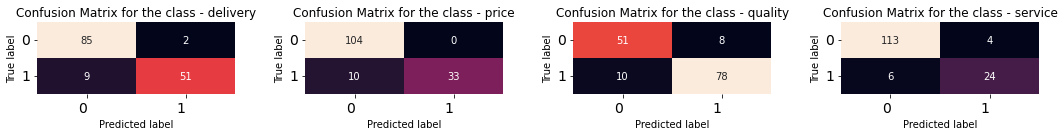

[{('Precision', 'Micro'): 0.36507936507936506, ('Precision', 'Macro'): 0.2590744410416541, ('Recall', 'Micro'): 0.5203619909502263, ('Recall', 'Macro'): 0.5145569062720226, ('F1 score', 'Micro'): 0.4291044776119403, ('F1 score', 'Macro'): 0.3298567140110967}, {('Precision', 'Micro'): 0.5064935064935064, ('Precision', 'Macro'): 0.19792127377266694, ('Recall', 'Micro'): 0.35294117647058826, ('Recall', 'Macro'): 0.24356060606060606, ('F1 score', 'Micro'): 0.41600000000000004, ('F1 score', 'Macro'): 0.20997400596899973}, {('Precision', 'Micro'): 0.5857142857142857, ('Precision', 'Macro'): 0.14642857142857144, ('Recall', 'Micro'): 0.37104072398190047, ('Recall', 'Macro'): 0.23295454545454544, ('F1 score', 'Micro'): 0.45429362880886426, ('F1 score', 'Macro'): 0.17982456140350878}, {('Precision', 'Micro'): 0.5986394557823129, ('Precision', 'Macro'): 0.14965986394557823, ('Recall', 'Micro'): 0.39819004524886875, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4782608695652174, ('F1 score',

In [22]:
batch_size = 32
epochs = 4
bert_lr = 3e-5
T = 0.5
clean_train_reviews, clean_test_reviews = (preprocess(train_reviews), preprocess(test_reviews))
bert_test_scores = bert_model(clean_train_reviews, clean_test_reviews, train_labels, test_labels, epochs, batch_size, bert_lr, T)
print(bert_test_scores[0])
print(bert_test_scores[1])

In [24]:
print('BERT')
print('Precision Macro:', [i[('Precision', 'Macro')] for i in bert_test_scores[0]][-1])
print('Precision Micro:', [i[('Precision', 'Micro')] for i in bert_test_scores[0]][-1])
print('Recall Macro:', [i[('Recall', 'Macro')] for i in bert_test_scores[0]][-1])
print('Recall Micro:', [i[('Recall', 'Micro')] for i in bert_test_scores[0]][-1])
print('F1 score Macro:', [i[('F1 score', 'Macro')] for i in bert_test_scores[0]][-1])
print('F1 score Micro:', [i[('F1 score', 'Micro')] for i in bert_test_scores[0]][-1])

BERT
Precision Macro: 0.931595938068075
Precision Micro: 0.93
Recall Macro: 0.8259513742071882
Recall Micro: 0.8416289592760181
F1 score Macro: 0.8738034627306748
F1 score Micro: 0.8836104513064132


# XLNET MODEL

## Training & Fine-tuning

In [13]:
class XLNetForMultiLabelSequenceClassification(XLNetForSequenceClassification):
    def forward(self, input_ids, token_type_ids=None, input_mask=None, attention_mask=None,
                mems=None, perm_mask=None, target_mapping=None,
                labels=None, head_mask=None):
        transformer_outputs = self.transformer(input_ids, token_type_ids=token_type_ids,
                                               input_mask=input_mask, attention_mask=attention_mask,
                                               mems=mems, perm_mask=perm_mask, target_mapping=target_mapping,
                                               head_mask=head_mask)
        output = transformer_outputs[0]

        output = self.sequence_summary(output)
        logits = self.logits_proj(output)

        # Keep mems, hidden states, attentions if there are in it
        outputs = (logits,) + transformer_outputs[1:]

        if labels is not None:
            loss_fct = BCEWithLogitsLoss()
        # Changes: labels vector is extended to the number labels instead of 1
            loss = loss_fct(logits.view(-1, self.num_labels),
                            labels.view(-1, self.num_labels).type_as(logits.view(-1, self.num_labels)))
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

In [19]:
def xlnet_model(train_reviews, test_reviews, train_labels, test_labels, epochs= 4, batch_size= 32, lr= 3e-5, T= 0.5):

    MAX_LEN = 128
    # Import the XLNet tokenizer
    tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)
    
    # TRAINING SET
    # Get inputs_ids
    tokenized_train = [tokenizer.tokenize(sent) for sent in train_reviews]
    train_inputs = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_train]
    train_inputs = pad_sequences(train_inputs, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
    # Create attention masks
    train_masks = []
    # Create a mask of 1s for each token followed by 0s for padding
    for seq in train_inputs:
      seq_mask = [float(i>0) for i in seq]
      train_masks.append(seq_mask)
    # Convert lists to tensors  
    train_inputs = torch.tensor(train_inputs)
    train_labels = torch.tensor(train_labels)
    train_masks = torch.tensor(train_masks)
    # Create DataLoader
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # TEST SET
    # Get inputs_ids
    tokenized_test = [tokenizer.tokenize(sent) for sent in test_reviews]
    test_inputs = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_test]
    test_inputs = pad_sequences(test_inputs, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
    # Create attention masks
    test_masks = []
    # Create a mask of 1s for each token followed by 0s for padding
    for seq in test_inputs:
      seq_mask = [float(i>0) for i in seq]
      test_masks.append(seq_mask)
    # Convert lists to tensors  
    test_inputs = torch.tensor(test_inputs)
    test_labels = torch.tensor(test_labels)
    test_masks = torch.tensor(test_masks)
    # Create DataLoader
    test_data = TensorDataset(test_inputs, test_masks, test_labels)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

    # Load XLNEtForSequenceClassification, the pretrained XLNet model with a single linear classification layer on top. 
    model = XLNetForMultiLabelSequenceClassification.from_pretrained("xlnet-base-cased", num_labels= 4)
    model.cuda()

    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta'] 
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.0}
    ]
    # This variable contains all of the hyperparemeter information that the training loop needs
    optimizer = AdamW(optimizer_grouped_parameters, lr=lr)
    # Store the loss
    train_loss_set = []
    model_metrics_ = []
    batch_size_ = 0

    # trange is a tqdm wrapper around the normal python range
    for _ in trange(epochs, desc="Epoch"):
      # Tracking variables
      tr_loss = 0
      nb_tr_examples, nb_tr_steps = 0, 0
      # Train the data for one epoch
      for step, batch in enumerate(train_dataloader):
        ########### TRAINING ###########
        # Set model to training mode
        model.train()
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]
        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        to_labels(b_labels)
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

        ########### TESTING ###########
        # Set model to evaluation mode to evaluate loss on the test set
        model.eval()
        # Tracking variables 
        eval_loss=0
        nb_eval_steps, nb_eval_examples = 0, 0
        labels,predictions=[],[]
        # Evaluate data for one epoch
        for batch_t in test_dataloader:
          # Add batch to GPU
          batch_t = tuple(t.to(device) for t in batch_t)
          # Unpack the inputs from our dataloader
          t_b_input_ids, t_b_input_mask, t_b_labels = batch_t
          # Telling the model not to compute or store gradients, saving memory and speeding up test
          with torch.no_grad():
            # Forward pass, calculate logit predictions
            output = model(t_b_input_ids, token_type_ids=None, attention_mask=t_b_input_mask)
            logits = output[0]         
          # Move logits and labels to CPU
          prob=torch.sigmoid(logits)
          # If probability greater than or equal to threshold T the review contains that emotion
          pred = (prob >= T).type(torch.FloatTensor)
          pred = pred.detach().cpu().numpy().astype(int).tolist()
          label_ids = t_b_labels.to('cpu').numpy().tolist()
          labels+=label_ids
          predictions+=pred

        labels=np.array(labels)
        predictions=np.array(predictions)
        recall_micro=recall_score(labels, predictions, average = "micro")
        recall_macro=recall_score(labels, predictions, average = "macro")
        precision_micro=precision_score(labels, predictions, average = "micro")
        precision_macro=precision_score(labels, predictions, average = "macro")
        f1_micro=f1_score(labels, predictions, average = "micro")
        f1_macro=f1_score(labels, predictions, average = "macro")
        model_metrics={("Precision","Micro"):precision_micro,("Precision","Macro"):precision_macro,
                      ("Recall","Micro"):recall_micro,("Recall","Macro"):recall_macro,
                      ("F1 score","Micro"):f1_micro,("F1 score","Macro"):f1_macro}
        batch_size_ += len(batch[0])
        print("--------------------------------------------------------------")
        print(step)
        print(batch_size_)
        print(model_metrics)
        model_metrics_.append(model_metrics)
      print("Train loss: {}".format(tr_loss/nb_tr_steps))
    confusion_matrix_ = multilabel_confusion_matrix(labels, predictions)
    vis_arr = np.asarray(confusion_matrix_)
    fig, ax = plt.subplots(1, 4, figsize=(15, 2))
    for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, label_names):
      print_confusion_matrix(cfs_matrix, axes, label, [0, 1])
    fig.tight_layout()
    plt.show()
    return model_metrics_, confusion_matrix_

In [15]:
# Grid Search for hyper-parameter tuning
hps = [
(4, 32, 2e-5,0.5),
(3, 32, 2e-5,0.5),
(4, 32, 3e-5,0.3),
(4, 32, 3e-5,0.5),
(4, 32, 3e-5,0.8)
]
kfold_reviews = preprocess(train_reviews)
# 10-fold cross validation
cv = KFold(n_splits=10, random_state=42, shuffle=True)
val_scores_xlnet = []
for epochs, batch_size, lr, T in hps:
  hp_scores = []
  for train_index, test_index in cv.split(kfold_reviews):
    tr_reviews = preprocess(train_reviews[train_index])
    va_reviews = preprocess(train_reviews[test_index])
    tr_labels = [train_labels[i] for i in train_index]
    va_labels = [train_labels[i] for i in test_index]
    hp_scores.append(xlnet_model(tr_reviews, va_reviews, tr_labels, va_labels, epochs, batch_size, lr, T)[0])
  hp_score_df = pd.DataFrame(hp_scores)
  my_list = hp_score_df.values.tolist()
  final_list = []
  for i in my_list:
      final_list= final_list+i
  sums = Counter()
  counters = Counter()
  for itemset in final_list:
      sums.update(itemset)
      counters.update(itemset.keys())
  hp_score = {x: float(sums[x])/counters[x] for x in sums.keys()}
  val_scores_xlnet.append((str(epochs)+", "+str(batch_size)+", "+str(lr)+", "+str(T), hp_score))

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream tas

32
Counter({'quality': 20, 'service': 15, 'delivery': 9, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.42857142857142855, ('Precision', 'Macro'): 0.3112928655892787, ('Recall', 'Micro'): 0.75, ('Recall', 'Macro'): 0.7, ('F1 score', 'Micro'): 0.5454545454545454, ('F1 score', 'Macro'): 0.4173105831454288}
32
Counter({'quality': 17, 'delivery': 14, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.49557522123893805, ('Precision', 'Macro'): 0.24356559949780288, ('Recall', 'Micro'): 0.6086956521739131, ('Recall', 'Macro'): 0.4852941176470588, ('F1 score', 'Micro'): 0.5463414634146342, ('F1 score', 'Macro'): 0.3146962583582302}
32
Counter({'quality': 20, 'delivery': 13, 'service': 6, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.6363636363636364, ('Precision', 'Macro'): 0.24092009685230023, ('Recall', 'Micro'): 0.45652173913043476, ('Recall', 'Macro'): 0.27941176470588236, ('F1 score', 'Micro'): 0.5316455696202532, ('F1 score', 'Macro'): 0.24368686868686867}
32
Counter({'quality': 18, 'delivery': 13, 'price': 12, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.6842105263157895, ('Precision', 'Macro'): 0.17105263157894737, ('Recall', 'Micro'): 0.42391304347826086, ('Recall', 'Macro'): 0.24375, ('F1 score', 'Micro'): 0.523489932885906, ('F1 score', 'Macro'): 0.20103092783505155}
32
Counter({'quality': 17, 'delivery': 12, 'price': 11, 'service': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.7291666666666666, ('Precision', 'Macro'): 0.18229166666666666, ('Recall', 'Micro'): 0.3804347826086957, ('Recall', 'Macro'): 0.21875, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.19886363636363635}
32
Counter({'quality': 19, 'service': 13, 'price': 11, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.6976744186046512, ('Precision', 'Macro'): 0.1744186046511628, ('Recall', 'Micro'): 0.32608695652173914, ('Recall', 'Macro'): 0.1875, ('F1 score', 'Micro'): 0.4444444444444445, ('F1 score', 'Macro'): 0.1807228915662651}
32
Counter({'quality': 16, 'delivery': 10, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.725, ('Precision', 'Macro'): 0.18125, ('Recall', 'Micro'): 0.31521739130434784, ('Recall', 'Macro'): 0.18125, ('F1 score', 'Micro'): 0.4393939393939394, ('F1 score', 'Macro'): 0.18125000000000002}
32
Counter({'quality': 15, 'delivery': 12, 'price': 10, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.7368421052631579, ('Precision', 'Macro'): 0.18421052631578946, ('Recall', 'Micro'): 0.30434782608695654, ('Recall', 'Macro'): 0.175, ('F1 score', 'Micro'): 0.43076923076923074, ('F1 score', 'Macro'): 0.1794871794871795}
32
Counter({'quality': 18, 'delivery': 14, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.6888888888888889, ('Precision', 'Macro'): 0.17613636363636365, ('Recall', 'Micro'): 0.33695652173913043, ('Recall', 'Macro'): 0.19375, ('F1 score', 'Micro'): 0.45255474452554745, ('F1 score', 'Macro'): 0.18452380952380953}
32
Counter({'quality': 21, 'delivery': 14, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.16964285714285715, ('Recall', 'Micro'): 0.41304347826086957, ('Recall', 'Macro'): 0.2375, ('F1 score', 'Micro'): 0.5100671140939598, ('F1 score', 'Macro'): 0.19791666666666669}
32
Counter({'quality': 17, 'price': 11, 'delivery': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'delivery': 15, 'quality': 15, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'quality': 18, 'delivery': 12, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'quality': 21, 'delivery': 11, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'quality': 17, 'delivery': 14, 'service': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'quality': 17, 'delivery': 14, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
14
Counter({'delivery': 7, 'quality': 6, 'service': 5, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:25<01:17, 25.94s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
Train loss: 0.660672969677869
32
Counter({'quality': 18, 'delivery': 14, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.6825396825396826, ('Precision', 'Macro'): 0.36810344827586206, ('Recall', 'Micro'): 0.4673913043478261, ('Recall', 'Macro'): 0.29375, ('F1 score', 'Micro'): 0.5548387096774193, ('F1 score', 'Macro'): 0.2789795918367347}
32
Counter({'quality': 17, 'delivery': 13, 'service': 13, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.6764705882352942, ('Precision', 'Macro'): 0.31994047619047616, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.33125, ('F1 score', 'Micro'): 0.5750000000000001, ('F1 score', 'Macro'): 0.3125}
32
Counter({'quality': 17, 'service': 13, 'delivery': 12, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.6438356164383562, ('Precision', 'Macro'): 0.30402930402930406, ('Recall', 'Micro'): 0.5108695652173914, ('Recall', 'Macro'): 0.36250000000000004, ('F1 score', 'Micro'): 0.5696969696969697, ('F1 score', 'Macro'): 0.3297985153764581}
32
Counter({'quality': 18, 'price': 13, 'delivery': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.6216216216216216, ('Precision', 'Macro'): 0.2895833333333333, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.35625, ('F1 score', 'Micro'): 0.5542168674698795, ('F1 score', 'Macro'): 0.3194444444444444}
32
Counter({'quality': 18, 'price': 12, 'delivery': 10, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.6376811594202898, ('Precision', 'Macro'): 0.2910714285714286, ('Recall', 'Micro'): 0.4782608695652174, ('Recall', 'Macro'): 0.33125, ('F1 score', 'Micro'): 0.5465838509316769, ('F1 score', 'Macro'): 0.30912921348314604}
32
Counter({'quality': 16, 'delivery': 14, 'service': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.6818181818181818, ('Precision', 'Macro'): 0.31, ('Recall', 'Micro'): 0.4891304347826087, ('Recall', 'Macro'): 0.33125000000000004, ('F1 score', 'Micro'): 0.5696202531645569, ('F1 score', 'Macro'): 0.31666666666666665}
32
Counter({'quality': 19, 'price': 14, 'service': 12, 'delivery': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.6935483870967742, ('Precision', 'Macro'): 0.31, ('Recall', 'Micro'): 0.4673913043478261, ('Recall', 'Macro'): 0.30625, ('F1 score', 'Micro'): 0.5584415584415585, ('F1 score', 'Macro'): 0.29930555555555555}
32
Counter({'quality': 22, 'delivery': 10, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.7096774193548387, ('Precision', 'Macro'): 0.3368055555555556, ('Recall', 'Micro'): 0.4782608695652174, ('Recall', 'Macro'): 0.30625, ('F1 score', 'Micro'): 0.5714285714285714, ('F1 score', 'Macro'): 0.2967325227963526}
32
Counter({'delivery': 22, 'service': 15, 'quality': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.7068965517241379, ('Precision', 'Macro'): 0.3076923076923077, ('Recall', 'Micro'): 0.44565217391304346, ('Recall', 'Macro'): 0.27499999999999997, ('F1 score', 'Micro'): 0.5466666666666666, ('F1 score', 'Macro'): 0.2642140468227425}
32
Counter({'delivery': 18, 'quality': 17, 'service': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.7288135593220338, ('Precision', 'Macro'): 0.3425245098039216, ('Recall', 'Micro'): 0.4673913043478261, ('Recall', 'Macro'): 0.3, ('F1 score', 'Micro'): 0.5695364238410596, ('F1 score', 'Macro'): 0.2980769230769231}
32
Counter({'quality': 21, 'delivery': 13, 'service': 13, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.7049180327868853, ('Precision', 'Macro'): 0.3112745098039216, ('Recall', 'Micro'): 0.4673913043478261, ('Recall', 'Macro'): 0.3, ('F1 score', 'Micro'): 0.5620915032679739, ('F1 score', 'Macro'): 0.29212454212454214}
32
Counter({'quality': 19, 'delivery': 13, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.7213114754098361, ('Precision', 'Macro'): 0.3402122641509434, ('Recall', 'Micro'): 0.4782608695652174, ('Recall', 'Macro'): 0.30625, ('F1 score', 'Micro'): 0.5751633986928104, ('F1 score', 'Macro'): 0.298963133640553}
32
Counter({'quality': 20, 'delivery': 11, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 0.6875, ('Precision', 'Macro'): 0.3182957393483709, ('Recall', 'Micro'): 0.4782608695652174, ('Recall', 'Macro'): 0.3, ('F1 score', 'Micro'): 0.5641025641025642, ('F1 score', 'Macro'): 0.28025964108438334}
32
Counter({'quality': 16, 'service': 10, 'delivery': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 0.6774193548387096, ('Precision', 'Macro'): 0.5057471264367817, ('Recall', 'Micro'): 0.45652173913043476, ('Recall', 'Macro'): 0.2772058823529412, ('F1 score', 'Micro'): 0.5454545454545454, ('F1 score', 'Macro'): 0.2535985408656216}
32
Counter({'quality': 19, 'service': 9, 'delivery': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 0.6949152542372882, ('Precision', 'Macro'): 0.4224137931034483, ('Recall', 'Micro'): 0.44565217391304346, ('Recall', 'Macro'): 0.2647058823529412, ('F1 score', 'Micro'): 0.543046357615894, ('F1 score', 'Macro'): 0.23185941043083902}
32
Counter({'quality': 18, 'delivery': 10, 'price': 7, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5333333333333333, ('F1 score', 'Macro'): 0.20408163265306123}
14
Counter({'delivery': 6, 'quality': 6, 'service': 4, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:52<00:52, 26.36s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.7017543859649122, ('Precision', 'Macro'): 0.17543859649122806, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5369127516778524, ('F1 score', 'Macro'): 0.20618556701030927}
Train loss: 0.6228708554716671
32
Counter({'quality': 21, 'delivery': 12, 'service': 11, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.7142857142857143, ('Precision', 'Macro'): 0.17857142857142858, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5405405405405405, ('F1 score', 'Macro'): 0.20833333333333331}
32
Counter({'quality': 15, 'price': 11, 'service': 11, 'delivery': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.7321428571428571, ('Precision', 'Macro'): 0.4318181818181818, ('Recall', 'Micro'): 0.44565217391304346, ('Recall', 'Macro'): 0.2647058823529412, ('F1 score', 'Micro'): 0.554054054054054, ('F1 score', 'Macro'): 0.23830409356725146}
32
Counter({'quality': 19, 'service': 12, 'delivery': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1148
{('Precision', 'Micro'): 0.7321428571428571, ('Precision', 'Macro'): 0.4305555555555556, ('Recall', 'Micro'): 0.44565217391304346, ('Recall', 'Macro'): 0.2731617647058823, ('F1 score', 'Micro'): 0.554054054054054, ('F1 score', 'Macro'): 0.2600783874580067}
32
Counter({'quality': 21, 'delivery': 9, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1180
{('Precision', 'Micro'): 0.7321428571428571, ('Precision', 'Macro'): 0.4305555555555556, ('Recall', 'Micro'): 0.44565217391304346, ('Recall', 'Macro'): 0.2731617647058823, ('F1 score', 'Micro'): 0.554054054054054, ('F1 score', 'Macro'): 0.2600783874580067}
32
Counter({'quality': 17, 'delivery': 12, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1212
{('Precision', 'Micro'): 0.7192982456140351, ('Precision', 'Macro'): 0.3472222222222222, ('Recall', 'Micro'): 0.44565217391304346, ('Recall', 'Macro'): 0.2731617647058823, ('F1 score', 'Micro'): 0.5503355704697986, ('F1 score', 'Macro'): 0.2574468085106383}
32
Counter({'service': 16, 'delivery': 15, 'quality': 14, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1244
{('Precision', 'Micro'): 0.7543859649122807, ('Precision', 'Macro'): 0.3762755102040816, ('Recall', 'Micro'): 0.4673913043478261, ('Recall', 'Macro'): 0.3194852941176471, ('F1 score', 'Micro'): 0.5771812080536913, ('F1 score', 'Macro'): 0.32786516853932585}
32
Counter({'quality': 19, 'service': 12, 'price': 11, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1276
{('Precision', 'Micro'): 0.7627118644067796, ('Precision', 'Macro'): 0.3844444444444445, ('Recall', 'Micro'): 0.4891304347826087, ('Recall', 'Macro'): 0.34044117647058825, ('F1 score', 'Micro'): 0.5960264900662251, ('F1 score', 'Macro'): 0.3457264957264957}
32
Counter({'quality': 19, 'delivery': 12, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1308
{('Precision', 'Micro'): 0.7540983606557377, ('Precision', 'Macro'): 0.39, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.35514705882352937, ('F1 score', 'Micro'): 0.6013071895424836, ('F1 score', 'Macro'): 0.3592592592592593}
32
Counter({'delivery': 17, 'quality': 16, 'price': 10, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1340
{('Precision', 'Micro'): 0.746268656716418, ('Precision', 'Macro'): 0.5680926916221034, ('Recall', 'Micro'): 0.5434782608695652, ('Recall', 'Macro'): 0.4051470588235294, ('F1 score', 'Micro'): 0.6289308176100628, ('F1 score', 'Macro'): 0.43164835164835164}
32
Counter({'quality': 15, 'delivery': 13, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1372
{('Precision', 'Micro'): 0.7142857142857143, ('Precision', 'Macro'): 0.49559369202226344, ('Recall', 'Micro'): 0.5434782608695652, ('Recall', 'Macro'): 0.4113970588235294, ('F1 score', 'Micro'): 0.617283950617284, ('F1 score', 'Macro'): 0.434055644729802}
32
Counter({'quality': 20, 'delivery': 13, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1404
{('Precision', 'Micro'): 0.7236842105263158, ('Precision', 'Macro'): 0.5354349186483104, ('Recall', 'Micro'): 0.5978260869565217, ('Recall', 'Macro'): 0.48860294117647063, ('F1 score', 'Micro'): 0.6547619047619048, ('F1 score', 'Macro'): 0.5049704877291084}
32
Counter({'quality': 19, 'delivery': 15, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1436
{('Precision', 'Micro'): 0.691358024691358, ('Precision', 'Macro'): 0.5100338491295938, ('Recall', 'Micro'): 0.6086956521739131, ('Recall', 'Macro'): 0.5011029411764706, ('F1 score', 'Micro'): 0.6473988439306358, ('F1 score', 'Macro'): 0.49917898193760263}
32
Counter({'quality': 20, 'delivery': 16, 'price': 6, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1468
{('Precision', 'Micro'): 0.6904761904761905, ('Precision', 'Macro'): 0.5221153846153845, ('Recall', 'Micro'): 0.6304347826086957, ('Recall', 'Macro'): 0.5176470588235295, ('F1 score', 'Micro'): 0.6590909090909092, ('F1 score', 'Macro'): 0.504867515737081}
32
Counter({'quality': 18, 'delivery': 12, 'service': 10, 'price': 7})
--------------------------------------------------------------
13
1500
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.7511111111111111, ('Recall', 'Micro'): 0.6521739130434783, ('Recall', 'Macro'): 0.5321078431372549, ('F1 score', 'Micro'): 0.6593406593406593, ('F1 score', 'Macro'): 0.5169764957264957}
32
Counter({'quality': 15, 'service': 14, 'price': 11, 'delivery': 7})
--------------------------------------------------------------
14
1532
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.7514086094207798, ('Recall', 'Micro'): 0.6521739130434783, ('

Epoch:  75%|███████▌  | 3/4 [01:18<00:26, 26.13s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.7, ('Precision', 'Macro'): 0.7553799392097265, ('Recall', 'Micro'): 0.6086956521739131, ('Recall', 'Macro'): 0.48394607843137255, ('F1 score', 'Micro'): 0.6511627906976744, ('F1 score', 'Macro'): 0.4925047892720307}
Train loss: 0.5913416532909169
32
Counter({'delivery': 17, 'quality': 13, 'service': 11, 'price': 9})
--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.7142857142857143, ('Precision', 'Macro'): 0.7883333333333334, ('Recall', 'Micro'): 0.5978260869565217, ('Recall', 'Macro'): 0.4776960784313726, ('F1 score', 'Micro'): 0.6508875739644971, ('F1 score', 'Macro'): 0.4961548025007104}
32
Counter({'quality': 23, 'delivery': 8, 'price': 8, 'service': 7})
--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.7297297297297297, ('Precision', 'Macro'): 0.7985013175230566, ('Recall', 'Micro'): 0.586956

Epoch: 100%|██████████| 4/4 [01:44<00:00, 26.07s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.825, ('Precision', 'Macro'): 0.8467604433077579, ('Recall', 'Micro'): 0.717391304347826, ('Recall', 'Macro'): 0.6241421568627451, ('F1 score', 'Micro'): 0.7674418604651162, ('F1 score', 'Macro'): 0.6863201413121222}
Train loss: 0.5040698051452637



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 23, 'price': 11, 'service': 7, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.24615384615384617, ('Precision', 'Macro'): 0.13141025641025642, ('Recall', 'Micro'): 0.17777777777777778, ('Recall', 'Macro'): 0.2238095238095238, ('F1 score', 'Micro'): 0.2064516129032258, ('F1 score', 'Macro'): 0.16055949566587865}
32
Counter({'quality': 20, 'delivery': 12, 'price': 12, 'service': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.4666666666666667, ('Precision', 'Macro'): 0.21638655462184875, ('Recall', 'Micro'): 0.23333333333333334, ('Recall', 'Macro'): 0.20833333333333331, ('F1 score', 'Micro'): 0.31111111111111117, ('F1 score', 'Macro'): 0.21145833333333333}
32
Counter({'quality': 17, 'service': 11, 'price': 11, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.543859649122807, ('Precision', 'Macro'): 0.26136363636363635, ('Recall', 'Micro'): 0.34444444444444444, ('Recall', 'Macro'): 0.25104166666666666, ('F1 score', 'Micro'): 0.4217687074829932, ('F1 score', 'Macro'): 0.20182555780933065}
32
Counter({'quality': 19, 'delivery': 13, 'service': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'delivery': 19, 'quality': 19, 'price': 7, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 15, 'delivery': 12, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.5517241379310345, ('Precision', 'Macro'): 0.13793103448275862, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4324324324324324, ('F1 score', 'Macro'): 0.17777777777777778}
32
Counter({'quality': 16, 'delivery': 15, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 16, 'price': 13, 'delivery': 11, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 15, 'delivery': 14, 'service': 13, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.5517241379310345, ('Precision', 'Macro'): 0.13793103448275862, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4324324324324324, ('F1 score', 'Macro'): 0.17777777777777778}
32
Counter({'quality': 21, 'service': 12, 'delivery': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.5517241379310345, ('Precision', 'Macro'): 0.13793103448275862, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4324324324324324, ('F1 score', 'Macro'): 0.17777777777777778}
32
Counter({'quality': 16, 'delivery': 16, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.5714285714285714, ('Precision', 'Macro'): 0.14285714285714285, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4383561643835616, ('F1 score', 'Macro'): 0.18181818181818182}
32
Counter({'quality': 18, 'service': 12, 'delivery': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.5818181818181818, ('Precision', 'Macro'): 0.14545454545454545, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4413793103448276, ('F1 score', 'Macro'): 0.1839080459770115}
32
Counter({'quality': 19, 'service': 8, 'price': 7, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.5818181818181818, ('Precision', 'Macro'): 0.14545454545454545, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4413793103448276, ('F1 score', 'Macro'): 0.1839080459770115}
32
Counter({'quality': 19, 'delivery': 13, 'service': 7, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.5818181818181818, ('Precision', 'Macro'): 0.14545454545454545, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4413793103448276, ('F1 score', 'Macro'): 0.1839080459770115}
32
Counter({'quality': 23, 'service': 9, 'price': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.5714285714285714, ('Precision', 'Macro'): 0.14285714285714285, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4383561643835616, ('F1 score', 'Macro'): 0.18181818181818182}
32
Counter({'quality': 18, 'delivery': 15, 'service': 10, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.5714285714285714, ('Precision', 'Macro'): 0.14285714285714285, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4383561643835616, ('F1 score', 'Macro'): 0.18181818181818182}
14
Counter({'delivery': 8, 'quality': 6, 'service': 5, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:26<01:18, 26.13s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.5517241379310345, ('Precision', 'Macro'): 0.14035087719298245, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4324324324324324, ('F1 score', 'Macro'): 0.1797752808988764}
Train loss: 0.6454384502242593
32
Counter({'quality': 18, 'delivery': 16, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.5517241379310345, ('Precision', 'Macro'): 0.14035087719298245, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4324324324324324, ('F1 score', 'Macro'): 0.1797752808988764}
32
Counter({'quality': 22, 'delivery': 10, 'service': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13793103448275862, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17777777777777778}
32
Counter({'quality': 19, 'service': 10, 'delivery': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.5333333333333333, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42666666666666675, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'delivery': 13, 'quality': 13, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.5333333333333333, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42666666666666675, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 18, 'delivery': 12, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.5333333333333333, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42666666666666675, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 22, 'delivery': 14, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.5409836065573771, ('Precision', 'Macro'): 0.260593220338983, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.26136363636363635, ('F1 score', 'Micro'): 0.4370860927152318, ('F1 score', 'Macro'): 0.19665750915750918}
32
Counter({'service': 14, 'delivery': 13, 'price': 11, 'quality': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.55, ('Precision', 'Macro'): 0.2629310344827586, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.26136363636363635, ('F1 score', 'Micro'): 0.43999999999999995, ('F1 score', 'Macro'): 0.19861111111111113}
32
Counter({'quality': 16, 'service': 11, 'price': 10, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.559322033898305, ('Precision', 'Macro'): 0.26535087719298245, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.26136363636363635, ('F1 score', 'Micro'): 0.44295302013422816, ('F1 score', 'Macro'): 0.20060861423220974}
32
Counter({'quality': 15, 'delivery': 14, 'price': 11, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.5714285714285714, ('Precision', 'Macro'): 0.2685185185185185, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25355113636363635, ('F1 score', 'Micro'): 0.4383561643835616, ('F1 score', 'Macro'): 0.20106589147286824}
32
Counter({'quality': 21, 'delivery': 14, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.6153846153846154, ('Precision', 'Macro'): 0.28, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25355113636363635, ('F1 score', 'Micro'): 0.4507042253521127, ('F1 score', 'Macro'): 0.20985772357723576}
32
Counter({'quality': 20, 'delivery': 14, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.6346153846153846, ('Precision', 'Macro'): 0.3248299319727891, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.2649147727272727, ('F1 score', 'Micro'): 0.46478873239436613, ('F1 score', 'Macro'): 0.23135802469135805}
32
Counter({'quality': 20, 'delivery': 10, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.6346153846153846, ('Precision', 'Macro'): 0.3248299319727891, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.2649147727272727, ('F1 score', 'Micro'): 0.46478873239436613, ('F1 score', 'Macro'): 0.23135802469135805}
32
Counter({'quality': 18, 'service': 11, 'delivery': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 0.6226415094339622, ('Precision', 'Macro'): 0.32166666666666666, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.2649147727272727, ('F1 score', 'Micro'): 0.46153846153846156, ('F1 score', 'Macro'): 0.22902439024390242}
32
Counter({'quality': 18, 'delivery': 11, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 0.6140350877192983, ('Precision', 'Macro'): 0.33844339622641506, ('Recall', 'Micro'): 0.3888888888888889, ('Recall', 'Macro'): 0.28409090909090906, ('F1 score', 'Micro'): 0.47619047619047616, ('F1 score', 'Macro'): 0.24592760180995474}
32
Counter({'quality': 20, 'delivery': 10, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 0.603448275862069, ('Precision', 'Macro'): 0.33564814814814814, ('Recall', 'Micro'): 0.3888888888888889, ('Recall', 'Macro'): 0.28409090909090906, ('F1 score', 'Micro'): 0.472972972972973, ('F1 score', 'Macro'): 0.24373881932021466}
32
Counter({'quality': 19, 'delivery': 12, 'price': 10, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 0.5833333333333334, ('Precision', 'Macro'): 0.33035714285714285, ('Recall', 'Micro'): 0.3888888888888889, ('Recall', 'Macro'): 0.28409090909090906, ('F1 score', 'Micro'): 0.4666666666666666, ('F1 score', 'Macro'): 0.2395104895104895}
14
Counter({'quality': 10, 'delivery': 7, 'service': 5, 'price': 1})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:52<00:52, 26.06s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.5714285714285714, ('Precision', 'Macro'): 0.33793103448275863, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.29545454545454547, ('F1 score', 'Micro'): 0.47058823529411764, ('F1 score', 'Macro'): 0.2518518518518519}
Train loss: 0.6089022264761084
32
Counter({'quality': 23, 'delivery': 12, 'service': 10, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.5714285714285714, ('Precision', 'Macro'): 0.33793103448275863, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.29545454545454547, ('F1 score', 'Micro'): 0.47058823529411764, ('F1 score', 'Macro'): 0.2518518518518519}
32
Counter({'quality': 17, 'delivery': 11, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.5714285714285714, ('Precision', 'Macro'): 0.33793103448275863, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.29545454545454547, ('F1 score', 'Micro'): 0.47058823529411764, ('F1 score', 'Macro'): 0.2518518518518519}
32
Counter({'delivery': 16, 'quality': 16, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1148
{('Precision', 'Micro'): 0.578125, ('Precision', 'Macro'): 0.34626436781609193, ('Recall', 'Micro'): 0.4111111111111111, ('Recall', 'Macro'): 0.3068181818181818, ('F1 score', 'Micro'): 0.4805194805194805, ('F1 score', 'Macro'): 0.26706349206349206}
32
Counter({'quality': 18, 'delivery': 14, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1180
{('Precision', 'Micro'): 0.6, ('Precision', 'Macro'): 0.33265856950067474, ('Recall', 'Micro'): 0.4666666666666667, ('Recall', 'Macro'): 0.36363636363636365, ('F1 score', 'Micro'): 0.5249999999999999, ('F1 score', 'Macro'): 0.32263242375601925}
32
Counter({'quality': 17, 'delivery': 11, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1212
{('Precision', 'Micro'): 0.6567164179104478, ('Precision', 'Macro'): 0.3443627450980392, ('Recall', 'Micro'): 0.4888888888888889, ('Recall', 'Macro'): 0.38636363636363635, ('F1 score', 'Micro'): 0.5605095541401275, ('F1 score', 'Macro'): 0.35066582117945466}
32
Counter({'delivery': 16, 'quality': 14, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1244
{('Precision', 'Micro'): 0.704225352112676, ('Precision', 'Macro'): 0.5952797202797203, ('Recall', 'Micro'): 0.5555555555555556, ('Recall', 'Macro'): 0.4550865800865801, ('F1 score', 'Micro'): 0.6211180124223602, ('F1 score', 'Macro'): 0.41033692185007975}
32
Counter({'quality': 18, 'delivery': 13, 'service': 6, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1276
{('Precision', 'Micro'): 0.6944444444444444, ('Precision', 'Macro'): 0.5893429487179487, ('Recall', 'Micro'): 0.5555555555555556, ('Recall', 'Macro'): 0.4586377164502165, ('F1 score', 'Micro'): 0.6172839506172839, ('F1 score', 'Macro'): 0.40770379854886896}
32
Counter({'quality': 25, 'delivery': 11, 'price': 9, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1308
{('Precision', 'Micro'): 0.7352941176470589, ('Precision', 'Macro'): 0.6104390681003584, ('Recall', 'Micro'): 0.5555555555555556, ('Recall', 'Macro'): 0.4586377164502165, ('F1 score', 'Micro'): 0.6329113924050633, ('F1 score', 'Macro'): 0.42047976995257796}
32
Counter({'quality': 14, 'service': 13, 'delivery': 10, 'price': 7})
--------------------------------------------------------------
8
1340
{('Precision', 'Micro'): 0.7846153846153846, ('Precision', 'Macro'): 0.8821428571428571, ('Recall', 'Micro'): 0.5666666666666667, ('Recall', 'Macro'): 0.4753043831168831, ('F1 score', 'Micro'): 0.6580645161290322, ('F1 score', 'Macro'): 0.4653205563093623}
32
Counter({'quality': 17, 'service': 13, 'delivery': 11, 'price': 9})
--------------------------------------------------------------
9
1372
{('Precision', 'Micro'): 0.7910447761194029, ('Precision', 'Macro'): 0.825595238095238, ('Recall', 'Micro'): 0.5888888888888889, ('Re

Epoch:  75%|███████▌  | 3/4 [01:17<00:25, 25.96s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.803030303030303, ('Precision', 'Macro'): 0.8234590486912468, ('Recall', 'Micro'): 0.5888888888888889, ('Recall', 'Macro'): 0.5106737012987013, ('F1 score', 'Micro'): 0.6794871794871795, ('F1 score', 'Macro'): 0.5696328420503457}
Train loss: 0.5293978803298053
32
Counter({'quality': 17, 'delivery': 14, 'service': 12, 'price': 8})
--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.7857142857142857, ('Precision', 'Macro'): 0.8215151515151515, ('Recall', 'Micro'): 0.6111111111111112, ('Recall', 'Macro'): 0.5316490800865801, ('F1 score', 'Micro'): 0.6875000000000001, ('F1 score', 'Macro'): 0.5601779869067103}
32
Counter({'quality': 19, 'delivery': 12, 'price': 12, 'service': 6})
--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.7887323943661971, ('Precision', 'Macro'): 0.8215151515151515, ('Recall', 'Mi

Epoch: 100%|██████████| 4/4 [01:43<00:00, 25.99s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.8625, ('Precision', 'Macro'): 0.894047619047619, ('Recall', 'Micro'): 0.7666666666666667, ('Recall', 'Macro'): 0.7435132575757576, ('F1 score', 'Micro'): 0.8117647058823529, ('F1 score', 'Macro'): 0.7969444444444443}
Train loss: 0.38858576206599965



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 20, 'delivery': 11, 'service': 11, 'price': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.4264705882352941, ('Precision', 'Macro'): 0.2170433145009416, ('Recall', 'Micro'): 0.3411764705882353, ('Recall', 'Macro'): 0.2916666666666667, ('F1 score', 'Micro'): 0.3790849673202615, ('F1 score', 'Macro'): 0.20941558441558442}
32
Counter({'delivery': 20, 'quality': 18, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'quality': 14, 'delivery': 13, 'price': 11, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'delivery': 16, 'quality': 15, 'service': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'quality': 16, 'delivery': 14, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.43333333333333335, ('Precision', 'Macro'): 0.23275862068965517, ('Recall', 'Micro'): 0.3058823529411765, ('Recall', 'Macro'): 0.2619047619047619, ('F1 score', 'Micro'): 0.35862068965517246, ('F1 score', 'Macro'): 0.17234154007333682}
32
Counter({'quality': 21, 'delivery': 9, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.45, ('Precision', 'Macro'): 0.23660714285714285, ('Recall', 'Micro'): 0.3176470588235294, ('Recall', 'Macro'): 0.27380952380952384, ('F1 score', 'Micro'): 0.3724137931034483, ('F1 score', 'Macro'): 0.19432098765432101}
32
Counter({'quality': 21, 'service': 13, 'delivery': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.46938775510204084, ('Precision', 'Macro'): 0.3645833333333333, ('Recall', 'Micro'): 0.27058823529411763, ('Recall', 'Macro'): 0.2319047619047619, ('F1 score', 'Micro'): 0.3432835820895522, ('F1 score', 'Macro'): 0.17341220423412204}
32
Counter({'quality': 18, 'delivery': 17, 'price': 6, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.4791666666666667, ('Precision', 'Macro'): 0.11979166666666667, ('Recall', 'Micro'): 0.27058823529411763, ('Recall', 'Macro'): 0.23, ('F1 score', 'Micro'): 0.3458646616541353, ('F1 score', 'Macro'): 0.15753424657534248}
32
Counter({'quality': 18, 'service': 10, 'delivery': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.4716981132075472, ('Precision', 'Macro'): 0.1179245283018868, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3623188405797102, ('F1 score', 'Macro'): 0.16025641025641024}
32
Counter({'quality': 17, 'delivery': 11, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.44642857142857145, ('Precision', 'Macro'): 0.11160714285714286, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3546099290780142, ('F1 score', 'Macro'): 0.154320987654321}
32
Counter({'quality': 24, 'delivery': 13, 'price': 13, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.43859649122807015, ('Precision', 'Macro'): 0.10964912280701754, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35211267605633806, ('F1 score', 'Macro'): 0.1524390243902439}
32
Counter({'quality': 21, 'delivery': 13, 'service': 9, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'quality': 17, 'service': 10, 'price': 8, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'quality': 23, 'service': 12, 'delivery': 8, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'quality': 14, 'delivery': 13, 'service': 13, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'quality': 21, 'delivery': 12, 'price': 11, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
14
Counter({'quality': 9, 'delivery': 5, 'price': 1, 'service': 1})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:26<01:18, 26.02s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
Train loss: 0.6310732820454765
32
Counter({'quality': 17, 'delivery': 13, 'service': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'quality': 22, 'delivery': 13, 'price': 8, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'quality': 22, 'delivery': 13, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'quality': 19, 'price': 12, 'service': 9, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'quality': 17, 'delivery': 15, 'service': 13, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'quality': 20, 'delivery': 16, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'quality': 20, 'delivery': 11, 'price': 9, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.43333333333333335, ('Precision', 'Macro'): 0.3559322033898305, ('Recall', 'Micro'): 0.3058823529411765, ('Recall', 'Macro'): 0.2619047619047619, ('F1 score', 'Micro'): 0.35862068965517246, ('F1 score', 'Macro'): 0.17153679653679654}
32
Counter({'quality': 19, 'delivery': 12, 'service': 12, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.43333333333333335, ('Precision', 'Macro'): 0.3559322033898305, ('Recall', 'Micro'): 0.3058823529411765, ('Recall', 'Macro'): 0.2619047619047619, ('F1 score', 'Micro'): 0.35862068965517246, ('F1 score', 'Macro'): 0.17153679653679654}
32
Counter({'quality': 16, 'service': 12, 'delivery': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.4642857142857143, ('Precision', 'Macro'): 0.3611111111111111, ('Recall', 'Micro'): 0.3058823529411765, ('Recall', 'Macro'): 0.2638095238095238, ('F1 score', 'Micro'): 0.3687943262411348, ('F1 score', 'Macro'): 0.1953769950467804}
32
Counter({'quality': 19, 'delivery': 11, 'price': 10, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.47368421052631576, ('Precision', 'Macro'): 0.3611111111111111, ('Recall', 'Micro'): 0.3176470588235294, ('Recall', 'Macro'): 0.2757142857142857, ('F1 score', 'Micro'): 0.3802816901408451, ('F1 score', 'Macro'): 0.2143987341772152}
32
Counter({'quality': 19, 'delivery': 12, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.5, ('Precision', 'Macro'): 0.6127450980392157, ('Recall', 'Micro'): 0.32941176470588235, ('Recall', 'Macro'): 0.28803571428571434, ('F1 score', 'Micro'): 0.3971631205673759, ('F1 score', 'Macro'): 0.2513157894736842}
32
Counter({'quality': 18, 'delivery': 14, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.56, ('Precision', 'Macro'): 0.625, ('Recall', 'Micro'): 0.32941176470588235, ('Recall', 'Macro'): 0.2899404761904762, ('F1 score', 'Micro'): 0.41481481481481486, ('F1 score', 'Macro'): 0.27557413600891867}
32
Counter({'quality': 16, 'delivery': 11, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 0.6222222222222222, ('Precision', 'Macro'): 0.641025641025641, ('Recall', 'Micro'): 0.32941176470588235, ('Recall', 'Macro'): 0.2899404761904762, ('F1 score', 'Micro'): 0.4307692307692308, ('F1 score', 'Macro'): 0.28802884615384616}
32
Counter({'quality': 18, 'delivery': 9, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 0.625, ('Precision', 'Macro'): 0.6428571428571428, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.2580357142857143, ('F1 score', 'Micro'): 0.4, ('F1 score', 'Macro'): 0.26666666666666666}
32
Counter({'quality': 16, 'service': 12, 'delivery': 12, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.6515151515151515, ('Recall', 'Micro'): 0.3058823529411765, ('Recall', 'Macro'): 0.26994047619047623, ('F1 score', 'Micro'): 0.41935483870967744, ('F1 score', 'Macro'): 0.28856763925729445}
32
Counter({'quality': 19, 'delivery': 11, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.6515151515151515, ('Recall', 'Micro'): 0.3058823529411765, ('Recall', 'Macro'): 0.2669642857142857, ('F1 score', 'Micro'): 0.41935483870967744, ('F1 score', 'Macro'): 0.2904693486590038}
14
Counter({'quality': 10, 'price': 6, 'delivery': 5, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:52<00:52, 26.04s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.6363636363636364, ('Precision', 'Macro'): 0.6418918918918919, ('Recall', 'Micro'): 0.32941176470588235, ('Recall', 'Macro'): 0.2873809523809524, ('F1 score', 'Micro'): 0.43410852713178294, ('F1 score', 'Macro'): 0.3032834101382489}
Train loss: 0.5992832744822782
32
Counter({'quality': 19, 'delivery': 14, 'service': 9, 'price': 7})
--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.5925925925925926, ('Precision', 'Macro'): 0.8777777777777778, ('Recall', 'Micro'): 0.3764705882352941, ('Recall', 'Macro'): 0.33595238095238095, ('F1 score', 'Micro'): 0.460431654676259, ('F1 score', 'Macro'): 0.3469642857142857}
32
Counter({'quality': 20, 'delivery': 13, 'service': 12, 'price': 6})
--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.8723404255319149, ('Recall', '

Epoch:  75%|███████▌  | 3/4 [01:17<00:25, 25.97s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.7444444444444445, ('Precision', 'Macro'): 0.798611111111111, ('Recall', 'Micro'): 0.788235294117647, ('Recall', 'Macro'): 0.7834523809523809, ('F1 score', 'Micro'): 0.7657142857142857, ('F1 score', 'Macro'): 0.7744979501077062}
Train loss: 0.4980330291916342
32
Counter({'quality': 20, 'service': 11, 'delivery': 10, 'price': 5})
--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.7849462365591398, ('Precision', 'Macro'): 0.8229166666666666, ('Recall', 'Micro'): 0.8588235294117647, ('Recall', 'Macro'): 0.8560119047619047, ('F1 score', 'Micro'): 0.8202247191011236, ('F1 score', 'Macro'): 0.8320162835249042}
32
Counter({'quality': 17, 'service': 11, 'delivery': 11, 'price': 10})
--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.8172043010752689, ('Precision', 'Macro'): 0.8451690821256038, ('Recall', 'Mi

Epoch: 100%|██████████| 4/4 [01:43<00:00, 25.95s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.8444444444444444, ('Precision', 'Macro'): 0.8529337761674719, ('Recall', 'Micro'): 0.8941176470588236, ('Recall', 'Macro'): 0.9060119047619047, ('F1 score', 'Micro'): 0.8685714285714287, ('F1 score', 'Macro'): 0.8778238272061196}
Train loss: 0.3678421868997462



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 17, 'price': 11, 'delivery': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.3609467455621302, ('Precision', 'Macro'): 0.2684046666366947, ('Recall', 'Micro'): 0.7261904761904762, ('Recall', 'Macro'): 0.6896929824561403, ('F1 score', 'Micro'): 0.48221343873517786, ('F1 score', 'Macro'): 0.37404318383418794}
32
Counter({'quality': 19, 'delivery': 13, 'price': 12, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.38848920863309355, ('Precision', 'Macro'): 0.26852057959953785, ('Recall', 'Micro'): 0.6428571428571429, ('Recall', 'Macro'): 0.5745614035087719, ('F1 score', 'Micro'): 0.484304932735426, ('F1 score', 'Macro'): 0.36122707147375077}
32
Counter({'quality': 19, 'price': 14, 'delivery': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.4945054945054945, ('Precision', 'Macro'): 0.3139395914819644, ('Recall', 'Micro'): 0.5357142857142857, ('Recall', 'Macro'): 0.4100877192982456, ('F1 score', 'Micro'): 0.5142857142857143, ('F1 score', 'Macro'): 0.33835125448028674}
32
Counter({'delivery': 16, 'quality': 13, 'service': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.5454545454545454, ('Precision', 'Macro'): 0.21549636803874092, ('Recall', 'Micro'): 0.42857142857142855, ('Recall', 'Macro'): 0.2763157894736842, ('F1 score', 'Micro'): 0.4799999999999999, ('F1 score', 'Macro'): 0.22125723738626965}
32
Counter({'quality': 19, 'delivery': 13, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.5925925925925926, ('Precision', 'Macro'): 0.14814814814814814, ('Recall', 'Micro'): 0.38095238095238093, ('Recall', 'Macro'): 0.23529411764705882, ('F1 score', 'Micro'): 0.463768115942029, ('F1 score', 'Macro'): 0.1818181818181818}
32
Counter({'quality': 23, 'delivery': 12, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.6071428571428571, ('Precision', 'Macro'): 0.15178571428571427, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4857142857142857, ('F1 score', 'Macro'): 0.18888888888888886}
32
Counter({'delivery': 19, 'quality': 17, 'service': 4, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.6071428571428571, ('Precision', 'Macro'): 0.15178571428571427, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4857142857142857, ('F1 score', 'Macro'): 0.18888888888888886}
32
Counter({'quality': 18, 'delivery': 12, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.6071428571428571, ('Precision', 'Macro'): 0.15178571428571427, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4857142857142857, ('F1 score', 'Macro'): 0.18888888888888886}
32
Counter({'quality': 15, 'delivery': 13, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.62, ('Precision', 'Macro'): 0.155, ('Recall', 'Micro'): 0.36904761904761907, ('Recall', 'Macro'): 0.22794117647058823, ('F1 score', 'Micro'): 0.4626865671641791, ('F1 score', 'Macro'): 0.18452380952380953}
32
Counter({'quality': 19, 'service': 15, 'delivery': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.6037735849056604, ('Precision', 'Macro'): 0.1509433962264151, ('Recall', 'Micro'): 0.38095238095238093, ('Recall', 'Macro'): 0.23529411764705882, ('F1 score', 'Micro'): 0.46715328467153283, ('F1 score', 'Macro'): 0.1839080459770115}
32
Counter({'quality': 16, 'delivery': 15, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.6181818181818182, ('Precision', 'Macro'): 0.4027777777777778, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.25580495356037153, ('F1 score', 'Micro'): 0.48920863309352525, ('F1 score', 'Macro'): 0.21249999999999997}
32
Counter({'quality': 19, 'delivery': 14, 'service': 13, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.6140350877192983, ('Precision', 'Macro'): 0.4, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.2689628482972136, ('F1 score', 'Micro'): 0.49645390070921985, ('F1 score', 'Macro'): 0.2330123060460139}
32
Counter({'quality': 20, 'price': 12, 'service': 11, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.6166666666666667, ('Precision', 'Macro'): 0.3991228070175439, ('Recall', 'Micro'): 0.44047619047619047, ('Recall', 'Macro'): 0.2894736842105263, ('F1 score', 'Micro'): 0.513888888888889, ('F1 score', 'Macro'): 0.25499500499500494}
32
Counter({'quality': 17, 'service': 14, 'delivery': 13, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.6166666666666667, ('Precision', 'Macro'): 0.3991228070175439, ('Recall', 'Micro'): 0.44047619047619047, ('Recall', 'Macro'): 0.2894736842105263, ('F1 score', 'Micro'): 0.513888888888889, ('F1 score', 'Macro'): 0.25499500499500494}
32
Counter({'quality': 21, 'price': 11, 'delivery': 9, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.6065573770491803, ('Precision', 'Macro'): 0.39655172413793105, ('Recall', 'Micro'): 0.44047619047619047, ('Recall', 'Macro'): 0.2894736842105263, ('F1 score', 'Micro'): 0.5103448275862069, ('F1 score', 'Macro'): 0.25296442687747034}
32
Counter({'quality': 18, 'delivery': 10, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.6065573770491803, ('Precision', 'Macro'): 0.39655172413793105, ('Recall', 'Micro'): 0.44047619047619047, ('Recall', 'Macro'): 0.2894736842105263, ('F1 score', 'Micro'): 0.5103448275862069, ('F1 score', 'Macro'): 0.25296442687747034}
14
Counter({'quality': 8, 'service': 5, 'price': 4, 'delivery': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:25<01:17, 25.99s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.6, ('Precision', 'Macro'): 0.39655172413793105, ('Recall', 'Micro'): 0.42857142857142855, ('Recall', 'Macro'): 0.2763157894736842, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.23240165631469978}
Train loss: 0.6446086939643411
32
Counter({'quality': 16, 'service': 15, 'delivery': 9, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.6101694915254238, ('Precision', 'Macro'): 0.3991228070175439, ('Recall', 'Micro'): 0.42857142857142855, ('Recall', 'Macro'): 0.2763157894736842, ('F1 score', 'Micro'): 0.5034965034965035, ('F1 score', 'Macro'): 0.2344322344322344}
32
Counter({'quality': 18, 'service': 11, 'price': 11, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.631578947368421, ('Precision', 'Macro'): 0.40454545454545454, ('Recall', 'Micro'): 0.42857142857142855, ('Recall', 'Macro'): 0.2763157894736842, ('F1 score', 'Micro'): 0.5106382978723404, ('F1 score', 'Macro'): 0.2386302835741038}
32
Counter({'quality': 15, 'delivery': 14, 'service': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.7037037037037037, ('Precision', 'Macro'): 0.42000000000000004, ('Recall', 'Micro'): 0.4523809523809524, ('Recall', 'Macro'): 0.3026315789473684, ('F1 score', 'Micro'): 0.5507246376811594, ('F1 score', 'Macro'): 0.2893374741200828}
32
Counter({'quality': 18, 'service': 14, 'price': 9, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.8043478260869565, ('Precision', 'Macro'): 0.4464285714285714, ('Recall', 'Micro'): 0.44047619047619047, ('Recall', 'Macro'): 0.2952786377708978, ('F1 score', 'Micro'): 0.5692307692307692, ('F1 score', 'Macro'): 0.3040617848970252}
32
Counter({'quality': 17, 'price': 14, 'delivery': 12, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.8292682926829268, ('Precision', 'Macro'): 0.45270270270270274, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.27321981424148606, ('F1 score', 'Micro'): 0.5439999999999999, ('F1 score', 'Macro'): 0.29822412737293325}
32
Counter({'quality': 20, 'delivery': 14, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.8333333333333334, ('Precision', 'Macro'): 0.6985294117647058, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.3037925696594427, ('F1 score', 'Micro'): 0.5555555555555556, ('F1 score', 'Macro'): 0.3581447963800905}
32
Counter({'quality': 19, 'delivery': 16, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.8085106382978723, ('Precision', 'Macro'): 0.6568627450980392, ('Recall', 'Micro'): 0.4523809523809524, ('Recall', 'Macro'): 0.343266253869969, ('F1 score', 'Micro'): 0.5801526717557252, ('F1 score', 'Macro'): 0.38481973434535105}
32
Counter({'quality': 16, 'delivery': 15, 'service': 12, 'price': 9})
--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.7894736842105263, ('Precision', 'Macro'): 0.8676470588235294, ('Recall', 'Micro'): 0.5357142857142857, ('Recall', 'Macro'): 0.44491744066047473, ('F1 score', 'Micro'): 0.6382978723404255, ('F1 score', 'Macro'): 0.5170452238866561}
32
Counter({'quality': 14, 'delivery': 11, 'price': 10, 'service': 7})
--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.7619047619047619, ('Precision', 'Macro'): 0.7446428571428572, ('Recall', 'Micro'): 0.5714285714285714, ('Reca

Epoch:  50%|█████     | 2/4 [00:52<00:52, 26.05s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.8, ('Precision', 'Macro'): 0.8842261904761906, ('Recall', 'Micro'): 0.6190476190476191, ('Recall', 'Macro'): 0.5235423116615067, ('F1 score', 'Micro'): 0.697986577181208, ('F1 score', 'Macro'): 0.5504475512690882}
Train loss: 0.5588359973009895
32
Counter({'quality': 18, 'delivery': 11, 'service': 9, 'price': 5})
--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.8125, ('Precision', 'Macro'): 0.8919254658385093, ('Recall', 'Micro'): 0.6190476190476191, ('Recall', 'Macro'): 0.5235423116615067, ('F1 score', 'Micro'): 0.7027027027027026, ('F1 score', 'Macro'): 0.5551540850453894}
32
Counter({'delivery': 16, 'quality': 15, 'price': 12, 'service': 9})
--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.8208955223880597, ('Precision', 'Macro'): 0.8919254658385093, ('Recall', 'Micro'): 0.6547619047619048, (

Epoch:  75%|███████▌  | 3/4 [01:17<00:25, 25.97s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.8607594936708861, ('Precision', 'Macro'): 0.8876262626262627, ('Recall', 'Micro'): 0.8095238095238095, ('Recall', 'Macro'): 0.7992131062951496, ('F1 score', 'Micro'): 0.834355828220859, ('F1 score', 'Macro'): 0.8186265969802555}
Train loss: 0.4236796585952534
32
Counter({'quality': 18, 'delivery': 13, 'service': 10, 'price': 9})
--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.8414634146341463, ('Precision', 'Macro'): 0.8762958532695375, ('Recall', 'Micro'): 0.8214285714285714, ('Recall', 'Macro'): 0.8123710010319917, ('F1 score', 'Micro'): 0.8313253012048192, ('F1 score', 'Macro'): 0.8241753107186245}
32
Counter({'quality': 14, 'delivery': 13, 'service': 10, 'price': 7})
--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.8518518518518519, ('Precision', 'Macro'): 0.8847818847818847, ('Recall', 'Mi

Epoch: 100%|██████████| 4/4 [01:43<00:00, 25.95s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.9305555555555556, ('Precision', 'Macro'): 0.9311145510835913, ('Recall', 'Micro'): 0.7976190476190477, ('Recall', 'Macro'): 0.8208849329205367, ('F1 score', 'Micro'): 0.858974358974359, ('F1 score', 'Macro'): 0.8698544906850767}
Train loss: 0.317903096185011



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 20, 'delivery': 14, 'price': 8, 'service': 8})
--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.30344827586206896, ('Precision', 'Macro'): 0.32580037664783423, ('Recall', 'Micro'): 0.5301204819277109, ('Recall', 'Macro'): 0.6004201680672269, ('F1 score', 'Micro'): 0.38596491228070173, ('F1 score', 'Macro'): 0.3401708326226426}
32
Counter({'quality': 18, 'service': 13, 'delivery': 12, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.31386861313868614, ('Precision', 'Macro'): 0.26709824783215447, ('Recall', 'Micro'): 0.5180722891566265, ('Recall', 'Macro'): 0.5478991596638656, ('F1 score', 'Micro'): 0.390909090909091, ('F1 score', 'Macro'): 0.319612001867995}
32
Counter({'quality': 20, 'price': 13, 'delivery': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.35772357723577236, ('Precision', 'Macro'): 0.24725516029863856, ('Recall', 'Micro'): 0.5301204819277109, ('Recall', 'Macro'): 0.4762605042016807, ('F1 score', 'Micro'): 0.42718446601941745, ('F1 score', 'Macro'): 0.30670289855072463}
32
Counter({'quality': 20, 'delivery': 11, 'service': 6, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.4945054945054945, ('Precision', 'Macro'): 0.22926634768740034, ('Recall', 'Micro'): 0.5421686746987951, ('Recall', 'Macro'): 0.4285714285714286, ('F1 score', 'Micro'): 0.5172413793103448, ('F1 score', 'Macro'): 0.2966003700277521}
32
Counter({'delivery': 15, 'quality': 11, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.5522388059701493, ('Precision', 'Macro'): 0.2108050847457627, ('Recall', 'Micro'): 0.4457831325301205, ('Recall', 'Macro'): 0.2857142857142857, ('F1 score', 'Micro'): 0.49333333333333335, ('F1 score', 'Macro'): 0.23162475822050288}
32
Counter({'quality': 20, 'delivery': 14, 'service': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.5645161290322581, ('Precision', 'Macro'): 0.1483050847457627, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4827586206896552, ('F1 score', 'Macro'): 0.18617021276595744}
32
Counter({'delivery': 15, 'quality': 15, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.5737704918032787, ('Precision', 'Macro'): 0.1483050847457627, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4861111111111111, ('F1 score', 'Macro'): 0.18617021276595744}
32
Counter({'quality': 18, 'delivery': 13, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.5833333333333334, ('Precision', 'Macro'): 0.1483050847457627, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.48951048951048953, ('F1 score', 'Macro'): 0.18617021276595744}
32
Counter({'quality': 19, 'delivery': 10, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.5833333333333334, ('Precision', 'Macro'): 0.1483050847457627, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.48951048951048953, ('F1 score', 'Macro'): 0.18617021276595744}
32
Counter({'quality': 21, 'delivery': 12, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.1483050847457627, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.49295774647887325, ('F1 score', 'Macro'): 0.18617021276595744}
32
Counter({'quality': 20, 'delivery': 14, 'service': 9, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.1483050847457627, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.49295774647887325, ('F1 score', 'Macro'): 0.18617021276595744}
32
Counter({'quality': 16, 'delivery': 14, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.1483050847457627, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.49295774647887325, ('F1 score', 'Macro'): 0.18617021276595744}
32
Counter({'quality': 16, 'delivery': 11, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.603448275862069, ('Precision', 'Macro'): 0.15086206896551724, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4964539007092199, ('F1 score', 'Macro'): 0.1881720430107527}
32
Counter({'quality': 19, 'price': 8, 'delivery': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.603448275862069, ('Precision', 'Macro'): 0.15086206896551724, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4964539007092199, ('F1 score', 'Macro'): 0.1881720430107527}
32
Counter({'quality': 18, 'delivery': 13, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.5964912280701754, ('Precision', 'Macro'): 0.14912280701754385, ('Recall', 'Micro'): 0.40963855421686746, ('Recall', 'Macro'): 0.24285714285714285, ('F1 score', 'Micro'): 0.4857142857142857, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 17, 'service': 11, 'delivery': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.5964912280701754, ('Precision', 'Macro'): 0.14912280701754385, ('Recall', 'Micro'): 0.40963855421686746, ('Recall', 'Macro'): 0.24285714285714285, ('F1 score', 'Micro'): 0.4857142857142857, ('F1 score', 'Macro'): 0.18478260869565216}
14
Counter({'delivery': 10, 'quality': 9, 'service': 7, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:26<01:18, 26.09s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.5964912280701754, ('Precision', 'Macro'): 0.14912280701754385, ('Recall', 'Micro'): 0.40963855421686746, ('Recall', 'Macro'): 0.24285714285714285, ('F1 score', 'Micro'): 0.4857142857142857, ('F1 score', 'Macro'): 0.18478260869565216}
Train loss: 0.6604809480554917
32
Counter({'quality': 22, 'delivery': 15, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.1483050847457627, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.49295774647887325, ('F1 score', 'Macro'): 0.18617021276595744}
32
Counter({'quality': 18, 'delivery': 14, 'price': 9, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.1483050847457627, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.49295774647887325, ('F1 score', 'Macro'): 0.18617021276595744}
32
Counter({'quality': 17, 'service': 15, 'delivery': 13, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.5901639344262295, ('Precision', 'Macro'): 0.2733050847457627, ('Recall', 'Micro'): 0.43373493975903615, ('Recall', 'Macro'): 0.26785714285714285, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.21742021276595744}
32
Counter({'quality': 22, 'delivery': 11, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.5873015873015873, ('Precision', 'Macro'): 0.2733050847457627, ('Recall', 'Micro'): 0.4457831325301205, ('Recall', 'Macro'): 0.2857142857142857, ('F1 score', 'Micro'): 0.5068493150684932, ('F1 score', 'Macro'): 0.241725768321513}
32
Counter({'quality': 16, 'delivery': 14, 'service': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.5846153846153846, ('Precision', 'Macro'): 0.2733050847457627, ('Recall', 'Micro'): 0.4578313253012048, ('Recall', 'Macro'): 0.30357142857142855, ('F1 score', 'Micro'): 0.5135135135135134, ('F1 score', 'Macro'): 0.2611702127659574}
32
Counter({'quality': 16, 'delivery': 12, 'service': 7, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.5555555555555556, ('Precision', 'Macro'): 0.24445893089960885, ('Recall', 'Micro'): 0.4819277108433735, ('Recall', 'Macro'): 0.3392857142857143, ('F1 score', 'Micro'): 0.5161290322580645, ('F1 score', 'Macro'): 0.27876280535855}
32
Counter({'quality': 15, 'delivery': 13, 'service': 13, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.5633802816901409, ('Precision', 'Macro'): 0.24701591511936338, ('Recall', 'Micro'): 0.4819277108433735, ('Recall', 'Macro'): 0.3392857142857143, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.2807646356033453}
32
Counter({'quality': 20, 'price': 12, 'service': 11, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.6060606060606061, ('Precision', 'Macro'): 0.29239766081871343, ('Recall', 'Micro'): 0.4819277108433735, ('Recall', 'Macro'): 0.3392857142857143, ('F1 score', 'Micro'): 0.5369127516778522, ('F1 score', 'Macro'): 0.29891304347826086}
32
Counter({'quality': 16, 'service': 13, 'delivery': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.65, ('Precision', 'Macro'): 0.5757575757575757, ('Recall', 'Micro'): 0.46987951807228917, ('Recall', 'Macro'): 0.31512605042016806, ('F1 score', 'Micro'): 0.5454545454545455, ('F1 score', 'Macro'): 0.30589955280357756}
32
Counter({'quality': 14, 'service': 10, 'delivery': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.6610169491525424, ('Precision', 'Macro'): 0.5787037037037037, ('Recall', 'Micro'): 0.46987951807228917, ('Recall', 'Macro'): 0.31512605042016806, ('F1 score', 'Micro'): 0.5492957746478874, ('F1 score', 'Macro'): 0.3080843218422792}
32
Counter({'quality': 18, 'delivery': 16, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.6545454545454545, ('Precision', 'Macro'): 0.5367647058823529, ('Recall', 'Micro'): 0.43373493975903615, ('Recall', 'Macro'): 0.2829831932773109, ('F1 score', 'Micro'): 0.5217391304347826, ('F1 score', 'Macro'): 0.2757420440636475}
32
Counter({'quality': 18, 'delivery': 14, 'price': 13, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.5799319727891157, ('Recall', 'Micro'): 0.43373493975903615, ('Recall', 'Macro'): 0.29369747899159665, ('F1 score', 'Micro'): 0.5255474452554745, ('F1 score', 'Macro'): 0.30193129883532355}
32
Counter({'quality': 20, 'price': 12, 'service': 11, 'delivery': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 0.6727272727272727, ('Precision', 'Macro'): 0.5816666666666667, ('Recall', 'Micro'): 0.4457831325301205, ('Recall', 'Macro'): 0.30084033613445377, ('F1 score', 'Micro'): 0.5362318840579711, ('F1 score', 'Macro'): 0.3055727554179567}
32
Counter({'quality': 18, 'delivery': 15, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.5816666666666667, ('Recall', 'Micro'): 0.43373493975903615, ('Recall', 'Macro'): 0.2861344537815126, ('F1 score', 'Micro'): 0.5255474452554745, ('F1 score', 'Macro'): 0.28071895424836607}
32
Counter({'quality': 20, 'delivery': 13, 'price': 7, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 0.6785714285714286, ('Precision', 'Macro'): 0.615, ('Recall', 'Micro'): 0.4578313253012048, ('Recall', 'Macro'): 0.32184873949579834, ('F1 score', 'Micro'): 0.5467625899280576, ('F1 score', 'Macro'): 0.3271585827313382}
32
Counter({'quality': 20, 'delivery': 15, 'service': 8, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 0.6724137931034483, ('Precision', 'Macro'): 0.5746173469387755, ('Recall', 'Micro'): 0.46987951807228917, ('Recall', 'Macro'): 0.3397058823529412, ('F1 score', 'Micro'): 0.5531914893617021, ('F1 score', 'Macro'): 0.33784271284271283}
14
Counter({'quality': 7, 'price': 5, 'service': 4, 'delivery': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:52<00:52, 26.10s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.6440677966101694, ('Precision', 'Macro'): 0.29336734693877553, ('Recall', 'Micro'): 0.4578313253012048, ('Recall', 'Macro'): 0.325, ('F1 score', 'Micro'): 0.5352112676056338, ('F1 score', 'Macro'): 0.3005952380952381}
Train loss: 0.604484431883868
32
Counter({'quality': 19, 'delivery': 18, 'service': 10, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.6349206349206349, ('Precision', 'Macro'): 0.29336734693877553, ('Recall', 'Micro'): 0.4819277108433735, ('Recall', 'Macro'): 0.3607142857142857, ('F1 score', 'Micro'): 0.547945205479452, ('F1 score', 'Macro'): 0.3214285714285714}
32
Counter({'quality': 21, 'delivery': 11, 'price': 11, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.640625, ('Precision', 'Macro'): 0.2901360544217687, ('Recall', 'Micro'): 0.4939759036144578, ('Recall', 'Macro'): 0.3678571428571429, ('F1 score', 'Micro'): 0.5578231292517006, ('F1 score', 'Macro'): 0.32307060755336614}
32
Counter({'quality': 20, 'price': 12, 'service': 11, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1148
{('Precision', 'Micro'): 0.6515151515151515, ('Precision', 'Macro'): 0.5528846153846154, ('Recall', 'Micro'): 0.5180722891566265, ('Recall', 'Macro'): 0.3897058823529412, ('F1 score', 'Micro'): 0.5771812080536912, ('F1 score', 'Macro'): 0.3585568326947638}
32
Counter({'quality': 22, 'delivery': 11, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1180
{('Precision', 'Micro'): 0.6612903225806451, ('Precision', 'Macro'): 0.5571581196581197, ('Recall', 'Micro'): 0.4939759036144578, ('Recall', 'Macro'): 0.3539915966386555, ('F1 score', 'Micro'): 0.5655172413793104, ('F1 score', 'Macro'): 0.33762285523904717}
32
Counter({'quality': 21, 'price': 9, 'delivery': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1212
{('Precision', 'Micro'): 0.6721311475409836, ('Precision', 'Macro'): 0.5745192307692308, ('Recall', 'Micro'): 0.4939759036144578, ('Recall', 'Macro'): 0.3539915966386555, ('F1 score', 'Micro'): 0.5694444444444444, ('F1 score', 'Macro'): 0.34256356670149773}
32
Counter({'quality': 16, 'delivery': 14, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1244
{('Precision', 'Micro'): 0.6935483870967742, ('Precision', 'Macro'): 0.5778186274509804, ('Recall', 'Micro'): 0.5180722891566265, ('Recall', 'Macro'): 0.38340336134453784, ('F1 score', 'Micro'): 0.593103448275862, ('F1 score', 'Macro'): 0.3921247357293869}
32
Counter({'delivery': 14, 'quality': 13, 'service': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1276
{('Precision', 'Micro'): 0.6875, ('Precision', 'Macro'): 0.523469387755102, ('Recall', 'Micro'): 0.5301204819277109, ('Recall', 'Macro'): 0.4088235294117647, ('F1 score', 'Micro'): 0.598639455782313, ('F1 score', 'Macro'): 0.4182900432900432}
32
Counter({'quality': 22, 'delivery': 10, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1308
{('Precision', 'Micro'): 0.734375, ('Precision', 'Macro'): 0.5520833333333334, ('Recall', 'Micro'): 0.5662650602409639, ('Recall', 'Macro'): 0.46365546218487397, ('F1 score', 'Micro'): 0.6394557823129252, ('F1 score', 'Macro'): 0.4834761441090555}
32
Counter({'quality': 15, 'delivery': 14, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1340
{('Precision', 'Micro'): 0.7419354838709677, ('Precision', 'Macro'): 0.5317251461988304, ('Recall', 'Micro'): 0.5542168674698795, ('Recall', 'Macro'): 0.4672268907563025, ('F1 score', 'Micro'): 0.6344827586206897, ('F1 score', 'Macro'): 0.4848751862214308}
32
Counter({'quality': 19, 'delivery': 15, 'service': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1372
{('Precision', 'Micro'): 0.7540983606557377, ('Precision', 'Macro'): 0.5486461251167134, ('Recall', 'Micro'): 0.5542168674698795, ('Recall', 'Macro'): 0.488655462184874, ('F1 score', 'Micro'): 0.6388888888888888, ('F1 score', 'Macro'): 0.5030485643388869}
32
Counter({'quality': 17, 'service': 13, 'delivery': 9, 'price': 8})
--------------------------------------------------------------
10
1404
{('Precision', 'Micro'): 0.7666666666666667, ('Precision', 'Macro'): 0.8107546048722519, ('Recall', 'Micro'): 0.5542168674698795, ('Recall', 'Macro'): 0.5069327731092437, ('F1 score', 'Micro'): 0.6433566433566433, ('F1 score', 'Macro'): 0.538341928996578}
32
Counter({'delivery': 18, 'quality': 16, 'price': 10, 'service': 7})
--------------------------------------------------------------
11
1436
{('Precision', 'Micro'): 0.7666666666666667, ('Precision', 'Macro'): 0.8195276497695853, ('Recall', 'Micro'): 0.5542168674698795, ('Rec

Epoch:  75%|███████▌  | 3/4 [01:18<00:25, 25.97s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.7945205479452054, ('Precision', 'Macro'): 0.8144599303135889, ('Recall', 'Micro'): 0.6987951807228916, ('Recall', 'Macro'): 0.6273109243697479, ('F1 score', 'Micro'): 0.7435897435897436, ('F1 score', 'Macro'): 0.6587840569164848}
Train loss: 0.500369098256616
32
Counter({'quality': 18, 'delivery': 13, 'service': 10, 'price': 5})
--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.7792207792207793, ('Precision', 'Macro'): 0.7921385017421603, ('Recall', 'Micro'): 0.7228915662650602, ('Recall', 'Macro'): 0.6567226890756303, ('F1 score', 'Micro'): 0.75, ('F1 score', 'Macro'): 0.6820759823823233}
32
Counter({'delivery': 14, 'quality': 13, 'service': 11, 'price': 6})
--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.759493670886076, ('Precision', 'Macro'): 0.7339689313373524, ('Recall', 'Micro'): 0.722891

Epoch: 100%|██████████| 4/4 [01:44<00:00, 26.00s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.8717948717948718, ('Precision', 'Macro'): 0.8683270676691729, ('Recall', 'Micro'): 0.8192771084337349, ('Recall', 'Macro'): 0.780672268907563, ('F1 score', 'Micro'): 0.84472049689441, ('F1 score', 'Macro'): 0.8092207983502726}
Train loss: 0.3891223230782677



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 13, 'delivery': 11, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.6, ('Precision', 'Macro'): 0.39655172413793105, ('Recall', 'Micro'): 0.4235294117647059, ('Recall', 'Macro'): 0.2727272727272727, ('F1 score', 'Micro'): 0.496551724137931, ('F1 score', 'Macro'): 0.22644927536231885}
32
Counter({'quality': 21, 'delivery': 15, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.6181818181818182, ('Precision', 'Macro'): 0.4027777777777778, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.2540106951871658, ('F1 score', 'Micro'): 0.48571428571428577, ('F1 score', 'Macro'): 0.2092391304347826}
32
Counter({'quality': 21, 'delivery': 14, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.6181818181818182, ('Precision', 'Macro'): 0.4027777777777778, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.2540106951871658, ('F1 score', 'Micro'): 0.48571428571428577, ('F1 score', 'Macro'): 0.2092391304347826}
32
Counter({'quality': 18, 'delivery': 14, 'price': 8, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 21, 'service': 13, 'delivery': 9, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 18, 'delivery': 12, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 23, 'delivery': 11, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 17, 'price': 11, 'delivery': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 16, 'service': 11, 'delivery': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 16, 'delivery': 14, 'price': 13, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 17, 'delivery': 13, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 20, 'service': 13, 'price': 12, 'delivery': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'delivery': 17, 'service': 14, 'quality': 13, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'delivery': 17, 'quality': 17, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 20, 'price': 12, 'delivery': 11, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 20, 'service': 12, 'delivery': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.6071428571428571, ('Precision', 'Macro'): 0.15178571428571427, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4822695035460993, ('F1 score', 'Macro'): 0.18888888888888886}
15
Counter({'quality': 7, 'delivery': 6, 'service': 5, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:25<01:16, 25.49s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.6470588235294118, ('Precision', 'Macro'): 0.16176470588235295, ('Recall', 'Micro'): 0.38823529411764707, ('Recall', 'Macro'): 0.2426470588235294, ('F1 score', 'Micro'): 0.4852941176470588, ('F1 score', 'Macro'): 0.19411764705882356}
Train loss: 0.6445207069901859
32
Counter({'quality': 19, 'delivery': 11, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.6739130434782609, ('Precision', 'Macro'): 0.16847826086956522, ('Recall', 'Micro'): 0.36470588235294116, ('Recall', 'Macro'): 0.22794117647058823, ('F1 score', 'Micro'): 0.4732824427480916, ('F1 score', 'Macro'): 0.19375}
32
Counter({'quality': 19, 'service': 10, 'delivery': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.16666666666666666, ('Recall', 'Micro'): 0.32941176470588235, ('Recall', 'Macro'): 0.20588235294117646, ('F1 score', 'Micro'): 0.4409448818897638, ('F1 score', 'Macro'): 0.18421052631578944}
32
Counter({'quality': 15, 'delivery': 14, 'price': 13, 'service': 13})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.6585365853658537, ('Precision', 'Macro'): 0.16463414634146342, ('Recall', 'Micro'): 0.3176470588235294, ('Recall', 'Macro'): 0.19852941176470587, ('F1 score', 'Micro'): 0.42857142857142855, ('F1 score', 'Macro'): 0.18}
32
Counter({'quality': 19, 'price': 13, 'service': 12, 'delivery': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.16666666666666666, ('Recall', 'Micro'): 0.3058823529411765, ('Recall', 'Macro'): 0.19117647058823528, ('F1 score', 'Micro'): 0.41935483870967744, ('F1 score', 'Macro'): 0.17808219178082194}
32
Counter({'quality': 20, 'delivery': 11, 'price': 8, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.16666666666666666, ('Recall', 'Micro'): 0.3058823529411765, ('Recall', 'Macro'): 0.19117647058823528, ('F1 score', 'Micro'): 0.41935483870967744, ('F1 score', 'Macro'): 0.17808219178082194}
32
Counter({'quality': 21, 'service': 12, 'price': 11, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.6585365853658537, ('Precision', 'Macro'): 0.16463414634146342, ('Recall', 'Micro'): 0.3176470588235294, ('Recall', 'Macro'): 0.19852941176470587, ('F1 score', 'Micro'): 0.42857142857142855, ('F1 score', 'Macro'): 0.18}
32
Counter({'quality': 21, 'delivery': 14, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.6739130434782609, ('Precision', 'Macro'): 0.16847826086956522, ('Recall', 'Micro'): 0.36470588235294116, ('Recall', 'Macro'): 0.22794117647058823, ('F1 score', 'Micro'): 0.4732824427480916, ('F1 score', 'Macro'): 0.19375}
32
Counter({'quality': 19, 'delivery': 14, 'service': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.6415094339622641, ('Precision', 'Macro'): 0.16037735849056603, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4927536231884058, ('F1 score', 'Macro'): 0.19540229885057472}
32
Counter({'quality': 18, 'service': 13, 'delivery': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 19, 'delivery': 16, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 17, 'delivery': 14, 'service': 7, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 11, 'service': 10, 'delivery': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 19, 'delivery': 14, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 19, 'delivery': 15, 'service': 6, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 17, 'service': 14, 'delivery': 8, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 17, 'delivery': 13, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
15
Counter({'quality': 8, 'delivery': 6, 'service': 4, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:50<00:50, 25.50s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.2741228070175439, ('Recall', 'Micro'): 0.4117647058823529, ('Recall', 'Macro'): 0.26136363636363635, ('F1 score', 'Micro'): 0.486111111111111, ('F1 score', 'Macro'): 0.20764652014652013}
Train loss: 0.6301898220006157
32
Counter({'quality': 15, 'delivery': 13, 'price': 13, 'service': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.625, ('Precision', 'Macro'): 0.28240740740740744, ('Recall', 'Micro'): 0.4117647058823529, ('Recall', 'Macro'): 0.26136363636363635, ('F1 score', 'Micro'): 0.49645390070921985, ('F1 score', 'Macro'): 0.21401515151515152}
32
Counter({'quality': 23, 'delivery': 10, 'price': 7, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.6538461538461539, ('Precision', 'Macro'): 0.3299319727891156, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.2580213903743315, ('F1 score', 'Micro'): 0.49635036496350365, ('F1 score', 'Macro'): 0.2327710843373494}
32
Counter({'quality': 18, 'delivery': 15, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1150
{('Precision', 'Micro'): 0.6875, ('Precision', 'Macro'): 0.3579545454545454, ('Recall', 'Micro'): 0.38823529411764707, ('Recall', 'Macro'): 0.2546791443850267, ('F1 score', 'Micro'): 0.4962406015037594, ('F1 score', 'Macro'): 0.25}
32
Counter({'quality': 14, 'delivery': 13, 'price': 12, 'service': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1182
{('Precision', 'Micro'): 0.6888888888888889, ('Precision', 'Macro'): 0.33974358974358976, ('Recall', 'Micro'): 0.36470588235294116, ('Recall', 'Macro'): 0.2439839572192513, ('F1 score', 'Micro'): 0.47692307692307684, ('F1 score', 'Macro'): 0.2563600782778865}
32
Counter({'quality': 16, 'delivery': 15, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1214
{('Precision', 'Micro'): 0.6444444444444445, ('Precision', 'Macro'): 0.2847222222222222, ('Recall', 'Micro'): 0.3411764705882353, ('Recall', 'Macro'): 0.2292780748663102, ('F1 score', 'Micro'): 0.4461538461538462, ('F1 score', 'Macro'): 0.24308755760368667}
32
Counter({'quality': 20, 'delivery': 14, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1246
{('Precision', 'Micro'): 0.6521739130434783, ('Precision', 'Macro'): 0.2922077922077922, ('Recall', 'Micro'): 0.35294117647058826, ('Recall', 'Macro'): 0.24064171122994654, ('F1 score', 'Micro'): 0.4580152671755725, ('F1 score', 'Macro'): 0.2569169960474308}
32
Counter({'delivery': 17, 'quality': 16, 'service': 12, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1278
{('Precision', 'Micro'): 0.6153846153846154, ('Precision', 'Macro'): 0.2815126050420168, ('Recall', 'Micro'): 0.3764705882352941, ('Recall', 'Macro'): 0.26336898395721925, ('F1 score', 'Micro'): 0.46715328467153283, ('F1 score', 'Macro'): 0.2709030100334448}
32
Counter({'quality': 18, 'service': 10, 'delivery': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1310
{('Precision', 'Micro'): 0.6037735849056604, ('Precision', 'Macro'): 0.2757936507936508, ('Recall', 'Micro'): 0.3764705882352941, ('Recall', 'Macro'): 0.26336898395721925, ('F1 score', 'Micro'): 0.46376811594202894, ('F1 score', 'Macro'): 0.26865942028985507}
32
Counter({'quality': 16, 'delivery': 15, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1342
{('Precision', 'Micro'): 0.6, ('Precision', 'Macro'): 0.27906162464985995, ('Recall', 'Micro'): 0.38823529411764707, ('Recall', 'Macro'): 0.27473262032085566, ('F1 score', 'Micro'): 0.4714285714285714, ('F1 score', 'Macro'): 0.27684678522571826}
32
Counter({'quality': 21, 'delivery': 12, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1374
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.27794840294840295, ('Recall', 'Micro'): 0.4117647058823529, ('Recall', 'Macro'): 0.2934491978609626, ('F1 score', 'Micro'): 0.486111111111111, ('F1 score', 'Macro'): 0.2853713188220231}
32
Counter({'quality': 14, 'service': 14, 'price': 11, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1406
{('Precision', 'Micro'): 0.6181818181818182, ('Precision', 'Macro'): 0.2805727554179567, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.27807486631016043, ('F1 score', 'Micro'): 0.48571428571428577, ('F1 score', 'Macro'): 0.2772435897435897}
32
Counter({'quality': 17, 'service': 16, 'delivery': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1438
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.29831144465290804, ('Recall', 'Micro'): 0.4235294117647059, ('Recall', 'Macro'): 0.2887700534759358, ('F1 score', 'Micro'): 0.5179856115107914, ('F1 score', 'Macro'): 0.2857142857142857}
32
Counter({'quality': 21, 'price': 10, 'service': 9, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1470
{('Precision', 'Micro'): 0.6792452830188679, ('Precision', 'Macro'): 0.5633074935400517, ('Recall', 'Micro'): 0.4235294117647059, ('Recall', 'Macro'): 0.2966371863430687, ('F1 score', 'Micro'): 0.5217391304347826, ('F1 score', 'Macro'): 0.3111646418098031}
32
Counter({'quality': 19, 'service': 10, 'price': 8, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1502
{('Precision', 'Micro'): 0.6964285714285714, ('Precision', 'Macro'): 0.5088652482269503, ('Recall', 'Micro'): 0.4588235294117647, ('Recall', 'Macro'): 0.3265631427396133, ('F1 score', 'Micro'): 0.5531914893617021, ('F1 score', 'Macro'): 0.3376322751322752}
32
Counter({'quality': 20, 'delivery': 13, 'price': 8, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1534
{('Precision', 'Micro'): 0.6721311475409836, ('Precision', 'Macro'): 0.5509615384615385, ('Recall', 'Micro'): 0.4823529411764706, ('Recall', 'Macro'): 0.3531468531468532, ('F1 score', 'Micro'): 0.5616438356164384, ('F1 score', 'Macro'): 0.35998378679637233}
32
Counter({'quality': 22, 'delivery': 10, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1566
{('Precision', 'Micro'): 0.640625, ('Precision', 'Macro'): 0.5420454545454545, ('Recall', 'Micro'): 0.4823529411764706, ('Recall', 'Macro'): 0.3531468531468532, ('F1 score', 'Micro'): 0.5503355704697986, ('F1 score', 'Macro'): 0.35332060414677735}
15
Counter({'quality': 8, 'delivery': 8, 'price': 4, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  75%|███████▌  | 3/4 [01:16<00:25, 25.45s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.625, ('Precision', 'Macro'): 0.5184523809523809, ('Recall', 'Micro'): 0.47058823529411764, ('Recall', 'Macro'): 0.33391608391608396, ('F1 score', 'Micro'): 0.5369127516778524, ('F1 score', 'Macro'): 0.32546296296296295}
Train loss: 0.613102979519788
32
Counter({'quality': 17, 'delivery': 11, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.625, ('Precision', 'Macro'): 0.5184523809523809, ('Recall', 'Micro'): 0.47058823529411764, ('Recall', 'Macro'): 0.33391608391608396, ('F1 score', 'Micro'): 0.5369127516778524, ('F1 score', 'Macro'): 0.32546296296296295}
32
Counter({'quality': 14, 'service': 13, 'delivery': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.6349206349206349, ('Precision', 'Macro'): 0.6017857142857143, ('Recall', 'Micro'): 0.47058823529411764, ('Recall', 'Macro'): 0.33391608391608396, ('F1 score', 'Micro'): 0.5405405405405405, ('F1 score', 'Macro'): 0.3296296296296296}
32
Counter({'quality': 18, 'delivery': 16, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1677
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.6187106918238994, ('Recall', 'Micro'): 0.47058823529411764, ('Recall', 'Macro'): 0.32604895104895104, ('F1 score', 'Micro'): 0.5517241379310345, ('F1 score', 'Macro'): 0.3204022988505747}
32
Counter({'quality': 21, 'service': 11, 'delivery': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1709
{('Precision', 'Micro'): 0.6721311475409836, ('Precision', 'Macro'): 0.5729166666666666, ('Recall', 'Micro'): 0.4823529411764706, ('Recall', 'Macro'): 0.3452797202797203, ('F1 score', 'Micro'): 0.5616438356164384, ('F1 score', 'Macro'): 0.35}
32
Counter({'quality': 20, 'delivery': 11, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1741
{('Precision', 'Micro'): 0.7368421052631579, ('Precision', 'Macro'): 0.6014492753623188, ('Recall', 'Micro'): 0.49411764705882355, ('Recall', 'Macro'): 0.35664335664335667, ('F1 score', 'Micro'): 0.5915492957746479, ('F1 score', 'Macro'): 0.3759408602150538}
32
Counter({'quality': 25, 'delivery': 13, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1773
{('Precision', 'Micro'): 0.7049180327868853, ('Precision', 'Macro'): 0.5638888888888889, ('Recall', 'Micro'): 0.5058823529411764, ('Recall', 'Macro'): 0.368006993006993, ('F1 score', 'Micro'): 0.5890410958904109, ('F1 score', 'Macro'): 0.3790787623066104}
32
Counter({'quality': 15, 'delivery': 14, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1805
{('Precision', 'Micro'): 0.7258064516129032, ('Precision', 'Macro'): 0.5875, ('Recall', 'Micro'): 0.5294117647058824, ('Recall', 'Macro'): 0.3987556561085973, ('F1 score', 'Micro'): 0.6122448979591837, ('F1 score', 'Macro'): 0.4138352638352638}
32
Counter({'quality': 23, 'delivery': 11, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1837
{('Precision', 'Micro'): 0.7377049180327869, ('Precision', 'Macro'): 0.5901084010840109, ('Recall', 'Micro'): 0.5294117647058824, ('Recall', 'Macro'): 0.3947449609214315, ('F1 score', 'Micro'): 0.6164383561643836, ('F1 score', 'Macro'): 0.41166666666666674}
32
Counter({'service': 14, 'delivery': 11, 'quality': 11, 'price': 6})
--------------------------------------------------------------
8
1869
{('Precision', 'Micro'): 0.746031746031746, ('Precision', 'Macro'): 0.8376068376068376, ('Recall', 'Micro'): 0.5529411764705883, ('Recall', 'Macro'): 0.453356386260798, ('F1 score', 'Micro'): 0.6351351351351352, ('F1 score', 'Macro'): 0.5056294207180589}
32
Counter({'quality': 19, 'delivery': 12, 'service': 12, 'price': 6})
--------------------------------------------------------------
9
1901
{('Precision', 'Micro'): 0.7301587301587301, ('Precision', 'Macro'): 0.7679143772893773, ('Recall', 'Micro'): 0.5411764705882353, ('Rec

Epoch: 100%|██████████| 4/4 [01:41<00:00, 25.47s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.859375, ('Precision', 'Macro'): 0.8531209781209782, ('Recall', 'Micro'): 0.6470588235294118, ('Recall', 'Macro'): 0.5651673693953105, ('F1 score', 'Micro'): 0.7382550335570471, ('F1 score', 'Macro'): 0.6556551429790867}
Train loss: 0.5306846604627722



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 19, 'delivery': 12, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.47058823529411764, ('Precision', 'Macro'): 0.3461887477313975, ('Recall', 'Micro'): 0.5333333333333333, ('Recall', 'Macro'): 0.48897058823529416, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.3737429237429237}
32
Counter({'quality': 19, 'service': 12, 'delivery': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.5223880597014925, ('Precision', 'Macro'): 0.1977969348659004, ('Recall', 'Micro'): 0.3888888888888889, ('Recall', 'Macro'): 0.27941176470588236, ('F1 score', 'Micro'): 0.445859872611465, ('F1 score', 'Macro'): 0.21978021978021978}
32
Counter({'delivery': 15, 'quality': 14, 'service': 14, 'price': 12})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.31212121212121213, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.2718360071301248, ('F1 score', 'Micro'): 0.45945945945945943, ('F1 score', 'Macro'): 0.2318181818181818}
32
Counter({'quality': 18, 'delivery': 12, 'price': 7, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.5818181818181818, ('Precision', 'Macro'): 0.3935185185185185, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.24955436720142604, ('F1 score', 'Micro'): 0.4413793103448276, ('F1 score', 'Macro'): 0.20593869731800768}
32
Counter({'price': 15, 'quality': 15, 'delivery': 12, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.5714285714285714, ('Precision', 'Macro'): 0.14285714285714285, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.24242424242424243, ('F1 score', 'Micro'): 0.4383561643835616, ('F1 score', 'Macro'): 0.1797752808988764}
32
Counter({'delivery': 15, 'service': 12, 'quality': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.6122448979591837, ('Precision', 'Macro'): 0.15306122448979592, ('Recall', 'Micro'): 0.3333333333333333, ('Recall', 'Macro'): 0.22727272727272727, ('F1 score', 'Micro'): 0.43165467625899284, ('F1 score', 'Macro'): 0.1829268292682927}
32
Counter({'quality': 18, 'delivery': 10, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.5897435897435898, ('Precision', 'Macro'): 0.14743589743589744, ('Recall', 'Micro'): 0.25555555555555554, ('Recall', 'Macro'): 0.17424242424242425, ('F1 score', 'Micro'): 0.3565891472868217, ('F1 score', 'Macro'): 0.15972222222222224}
32
Counter({'quality': 15, 'delivery': 14, 'service': 14, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.6388888888888888, ('Precision', 'Macro'): 0.1597222222222222, ('Recall', 'Micro'): 0.25555555555555554, ('Recall', 'Macro'): 0.17424242424242425, ('F1 score', 'Micro'): 0.36507936507936506, ('F1 score', 'Macro'): 0.16666666666666666}
32
Counter({'quality': 17, 'service': 14, 'delivery': 13, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.6571428571428571, ('Precision', 'Macro'): 0.16428571428571428, ('Recall', 'Micro'): 0.25555555555555554, ('Recall', 'Macro'): 0.17424242424242425, ('F1 score', 'Micro'): 0.36799999999999994, ('F1 score', 'Macro'): 0.1691176470588235}
32
Counter({'quality': 20, 'delivery': 12, 'price': 7, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.5853658536585366, ('Precision', 'Macro'): 0.14634146341463414, ('Recall', 'Micro'): 0.26666666666666666, ('Recall', 'Macro'): 0.18181818181818182, ('F1 score', 'Micro'): 0.366412213740458, ('F1 score', 'Macro'): 0.16216216216216217}
32
Counter({'quality': 20, 'price': 9, 'delivery': 9, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.5416666666666666, ('Precision', 'Macro'): 0.13541666666666666, ('Recall', 'Micro'): 0.28888888888888886, ('Recall', 'Macro'): 0.19696969696969696, ('F1 score', 'Micro'): 0.3768115942028985, ('F1 score', 'Macro'): 0.16049382716049382}
32
Counter({'quality': 17, 'delivery': 12, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.5454545454545454, ('Precision', 'Macro'): 0.13636363636363635, ('Recall', 'Micro'): 0.3333333333333333, ('Recall', 'Macro'): 0.22727272727272727, ('F1 score', 'Micro'): 0.41379310344827586, ('F1 score', 'Macro'): 0.17045454545454544}
32
Counter({'quality': 22, 'delivery': 10, 'price': 7, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.5614035087719298, ('Precision', 'Macro'): 0.14035087719298245, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.24242424242424243, ('F1 score', 'Micro'): 0.43537414965986393, ('F1 score', 'Macro'): 0.17777777777777776}
32
Counter({'quality': 24, 'price': 11, 'delivery': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 24, 'service': 17, 'delivery': 5, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 19, 'delivery': 15, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
15
Counter({'service': 8, 'quality': 7, 'delivery': 6, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:25<01:16, 25.33s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
Train loss: 0.6492313672514523
32
Counter({'quality': 19, 'delivery': 12, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 20, 'service': 13, 'delivery': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 18, 'service': 13, 'delivery': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'delivery': 16, 'quality': 16, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 18, 'delivery': 13, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 18, 'service': 15, 'delivery': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 15, 'delivery': 14, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 20, 'delivery': 12, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 20, 'service': 10, 'delivery': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 16, 'service': 10, 'delivery': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.5789473684210527, ('Precision', 'Macro'): 0.14473684210526316, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.44897959183673464, ('F1 score', 'Macro'): 0.18333333333333335}
32
Counter({'quality': 19, 'delivery': 12, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.6181818181818182, ('Precision', 'Macro'): 0.4027777777777778, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.25892857142857145, ('F1 score', 'Micro'): 0.4689655172413793, ('F1 score', 'Macro'): 0.20689655172413796}
32
Counter({'quality': 19, 'delivery': 9, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.6140350877192983, ('Precision', 'Macro'): 0.4, ('Recall', 'Micro'): 0.3888888888888889, ('Recall', 'Macro'): 0.26785714285714285, ('F1 score', 'Micro'): 0.47619047619047616, ('F1 score', 'Macro'): 0.2208333333333333}
32
Counter({'quality': 19, 'delivery': 14, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.6140350877192983, ('Precision', 'Macro'): 0.4, ('Recall', 'Micro'): 0.3888888888888889, ('Recall', 'Macro'): 0.26785714285714285, ('F1 score', 'Micro'): 0.47619047619047616, ('F1 score', 'Macro'): 0.2208333333333333}
32
Counter({'quality': 22, 'delivery': 13, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.603448275862069, ('Precision', 'Macro'): 0.3973214285714286, ('Recall', 'Micro'): 0.3888888888888889, ('Recall', 'Macro'): 0.26785714285714285, ('F1 score', 'Micro'): 0.472972972972973, ('F1 score', 'Macro'): 0.2187265917602996}
32
Counter({'quality': 14, 'service': 13, 'delivery': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.6290322580645161, ('Precision', 'Macro'): 0.5813492063492064, ('Recall', 'Micro'): 0.43333333333333335, ('Recall', 'Macro'): 0.30934873949579833, ('F1 score', 'Micro'): 0.513157894736842, ('F1 score', 'Macro'): 0.28886152162014234}
32
Counter({'quality': 19, 'delivery': 12, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.6774193548387096, ('Precision', 'Macro'): 0.6007653061224489, ('Recall', 'Micro'): 0.4666666666666667, ('Recall', 'Macro'): 0.33748726763432646, ('F1 score', 'Micro'): 0.5526315789473684, ('F1 score', 'Macro'): 0.33539972899729}
15
Counter({'delivery': 8, 'quality': 7, 'price': 3, 'service': 1})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:50<00:50, 25.22s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.711864406779661, ('Precision', 'Macro'): 0.35634920634920636, ('Recall', 'Micro'): 0.4666666666666667, ('Recall', 'Macro'): 0.33170995670995673, ('F1 score', 'Micro'): 0.5637583892617449, ('F1 score', 'Macro'): 0.3241758241758242}
Train loss: 0.6158556938171387
32
Counter({'quality': 16, 'delivery': 14, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.7166666666666667, ('Precision', 'Macro'): 0.3478112175102599, ('Recall', 'Micro'): 0.4777777777777778, ('Recall', 'Macro'): 0.34063852813852813, ('F1 score', 'Micro'): 0.5733333333333334, ('F1 score', 'Macro'): 0.3327485380116959}
32
Counter({'quality': 16, 'delivery': 12, 'service': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.7377049180327869, ('Precision', 'Macro'): 0.3547619047619048, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.35849567099567103, ('F1 score', 'Micro'): 0.5960264900662251, ('F1 score', 'Macro'): 0.35183114341627064}
32
Counter({'quality': 22, 'service': 11, 'delivery': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1150
{('Precision', 'Micro'): 0.7049180327868853, ('Precision', 'Macro'): 0.33882428940568476, ('Recall', 'Micro'): 0.4777777777777778, ('Recall', 'Macro'): 0.34063852813852813, ('F1 score', 'Micro'): 0.5695364238410596, ('F1 score', 'Macro'): 0.33009153318077805}
32
Counter({'quality': 20, 'delivery': 15, 'service': 7, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1182
{('Precision', 'Micro'): 0.7258064516129032, ('Precision', 'Macro'): 0.6219604863221885, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.3629201680672269, ('F1 score', 'Micro'): 0.5921052631578947, ('F1 score', 'Macro'): 0.3649801587301587}
32
Counter({'quality': 18, 'delivery': 13, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1214
{('Precision', 'Micro'): 0.6949152542372882, ('Precision', 'Macro'): 0.61281179138322, ('Recall', 'Micro'): 0.45555555555555555, ('Recall', 'Macro'): 0.3272058823529412, ('F1 score', 'Micro'): 0.5503355704697986, ('F1 score', 'Macro'): 0.3235918845674943}
32
Counter({'quality': 19, 'delivery': 9, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1246
{('Precision', 'Micro'): 0.6551724137931034, ('Precision', 'Macro'): 0.6086538461538462, ('Recall', 'Micro'): 0.4222222222222222, ('Recall', 'Macro'): 0.3004201680672269, ('F1 score', 'Micro'): 0.5135135135135135, ('F1 score', 'Macro'): 0.28250148544266196}
32
Counter({'quality': 22, 'price': 12, 'delivery': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1278
{('Precision', 'Micro'): 0.6428571428571429, ('Precision', 'Macro'): 0.6556603773584906, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.28256302521008403, ('F1 score', 'Micro'): 0.4931506849315069, ('F1 score', 'Macro'): 0.25297157622739014}
32
Counter({'quality': 18, 'delivery': 14, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1310
{('Precision', 'Micro'): 0.6545454545454545, ('Precision', 'Macro'): 0.6586538461538461, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.28256302521008403, ('F1 score', 'Micro'): 0.496551724137931, ('F1 score', 'Macro'): 0.2552287581699346}
32
Counter({'price': 14, 'delivery': 14, 'quality': 13, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1342
{('Precision', 'Micro'): 0.6551724137931034, ('Precision', 'Macro'): 0.5961538461538461, ('Recall', 'Micro'): 0.4222222222222222, ('Recall', 'Macro'): 0.30619747899159666, ('F1 score', 'Micro'): 0.5135135135135135, ('F1 score', 'Macro'): 0.293624226006192}
32
Counter({'quality': 17, 'delivery': 11, 'service': 9, 'price': 9})
--------------------------------------------------------------
9
1374
{('Precision', 'Micro'): 0.711864406779661, ('Precision', 'Macro'): 0.8028273809523809, ('Recall', 'Micro'): 0.4666666666666667, ('Recall', 'Macro'): 0.3538165266106443, ('F1 score', 'Micro'): 0.5637583892617449, ('F1 score', 'Macro'): 0.3778795278795279}
32
Counter({'quality': 20, 'service': 10, 'delivery': 9, 'price': 5})
--------------------------------------------------------------
10
1406
{('Precision', 'Micro'): 0.7777777777777778, ('Precision', 'Macro'): 0.8475849731663685, ('Recall', 'Micro'): 0.5444444444444444, ('Reca

Epoch:  75%|███████▌  | 3/4 [01:15<00:25, 25.10s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.7916666666666666, ('Precision', 'Macro'): 0.7452380952380953, ('Recall', 'Micro'): 0.6333333333333333, ('Recall', 'Macro'): 0.5673064680417621, ('F1 score', 'Micro'): 0.7037037037037038, ('F1 score', 'Macro'): 0.6280262104841936}
Train loss: 0.5369175023892346
32
Counter({'quality': 18, 'service': 12, 'delivery': 9, 'price': 6})
--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.782608695652174, ('Precision', 'Macro'): 0.7448604619657251, ('Recall', 'Micro'): 0.6, ('Recall', 'Macro'): 0.5167112299465241, ('F1 score', 'Micro'): 0.6792452830188679, ('F1 score', 'Macro'): 0.5843235517099873}
32
Counter({'quality': 20, 'delivery': 12, 'service': 10, 'price': 9})
--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.7910447761194029, ('Precision', 'Macro'): 0.7676282051282052, ('Recall', 'Micro'): 0.5888888

Epoch: 100%|██████████| 4/4 [01:40<00:00, 25.06s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.8266666666666667, ('Precision', 'Macro'): 0.8596491228070176, ('Recall', 'Micro'): 0.6888888888888889, ('Recall', 'Macro'): 0.6408358798064681, ('F1 score', 'Micro'): 0.7515151515151515, ('F1 score', 'Macro'): 0.7169647870101509}
Train loss: 0.42228395623319287



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 19, 'price': 8, 'delivery': 8, 'service': 5})
--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.44242424242424244, ('Precision', 'Macro'): 0.4060050940438871, ('Recall', 'Micro'): 0.7604166666666666, ('Recall', 'Macro'): 0.7209558823529412, ('F1 score', 'Micro'): 0.5593869731800766, ('F1 score', 'Macro'): 0.4647938443670151}
32
Counter({'quality': 21, 'delivery': 13, 'price': 7, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.5190839694656488, ('Precision', 'Macro'): 0.37082795500645405, ('Recall', 'Micro'): 0.7083333333333334, ('Recall', 'Macro'): 0.6083333333333333, ('F1 score', 'Micro'): 0.5991189427312774, ('F1 score', 'Macro'): 0.4522517693249401}
32
Counter({'quality': 19, 'price': 10, 'service': 9, 'delivery': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.5431034482758621, ('Precision', 'Macro'): 0.2732909860859044, ('Recall', 'Micro'): 0.65625, ('Recall', 'Macro'): 0.48958333333333337, ('F1 score', 'Micro'): 0.5943396226415094, ('F1 score', 'Macro'): 0.3460569412950365}
32
Counter({'quality': 18, 'delivery': 12, 'service': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.5555555555555556, ('Precision', 'Macro'): 0.27241379310344827, ('Recall', 'Micro'): 0.625, ('Recall', 'Macro'): 0.45833333333333337, ('F1 score', 'Micro'): 0.5882352941176471, ('F1 score', 'Macro'): 0.33921676778819637}
32
Counter({'quality': 14, 'service': 13, 'delivery': 11, 'price': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.64, ('Precision', 'Macro'): 0.2900608519269777, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.3333333333333333, ('F1 score', 'Micro'): 0.5614035087719298, ('F1 score', 'Macro'): 0.3016426082628173}
32
Counter({'quality': 19, 'delivery': 14, 'service': 12, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 16, 'delivery': 13, 'service': 11, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 16, 'delivery': 12, 'service': 9, 'price': 1})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 19, 'delivery': 16, 'service': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 17, 'service': 14, 'delivery': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 19, 'delivery': 12, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 17, 'service': 13, 'delivery': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 16, 'delivery': 16, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 21, 'delivery': 11, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 16, 'delivery': 14, 'price': 11, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 21, 'delivery': 11, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.7049180327868853, ('Precision', 'Macro'): 0.4224137931034483, ('Recall', 'Micro'): 0.4479166666666667, ('Recall', 'Macro'): 0.28125, ('F1 score', 'Micro'): 0.5477707006369427, ('F1 score', 'Macro'): 0.2596371882086168}
15
Counter({'delivery': 7, 'price': 6, 'quality': 4, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:24<01:13, 24.56s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.6617647058823529, ('Precision', 'Macro'): 0.2974137931034483, ('Recall', 'Micro'): 0.46875, ('Recall', 'Macro'): 0.3020833333333333, ('F1 score', 'Micro'): 0.5487804878048781, ('F1 score', 'Macro'): 0.2776110444177671}
Train loss: 0.6725923839737388
32
Counter({'quality': 18, 'price': 15, 'service': 10, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.6216216216216216, ('Precision', 'Macro'): 0.2661637931034483, ('Recall', 'Micro'): 0.4791666666666667, ('Recall', 'Macro'): 0.3125, ('F1 score', 'Micro'): 0.5411764705882353, ('F1 score', 'Macro'): 0.27908163265306124}
32
Counter({'quality': 22, 'delivery': 11, 'service': 7, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.6233766233766234, ('Precision', 'Macro'): 0.2776769509981851, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.3333333333333333, ('F1 score', 'Micro'): 0.5549132947976878, ('F1 score', 'Macro'): 0.2971048884670147}
32
Counter({'quality': 16, 'service': 12, 'price': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.6486486486486487, ('Precision', 'Macro'): 0.2974137931034483, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.3333333333333333, ('F1 score', 'Micro'): 0.5647058823529412, ('F1 score', 'Macro'): 0.3040816326530612}
32
Counter({'quality': 25, 'delivery': 11, 'price': 9, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.6764705882352942, ('Precision', 'Macro'): 0.3224137931034483, ('Recall', 'Micro'): 0.4791666666666667, ('Recall', 'Macro'): 0.3125, ('F1 score', 'Micro'): 0.5609756097560975, ('F1 score', 'Macro'): 0.2923169267707083}
32
Counter({'quality': 17, 'delivery': 11, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.7, ('Precision', 'Macro'): 0.4224137931034483, ('Recall', 'Micro'): 0.4375, ('Recall', 'Macro'): 0.2708333333333333, ('F1 score', 'Micro'): 0.5384615384615384, ('F1 score', 'Macro'): 0.2425431711145997}
32
Counter({'quality': 18, 'delivery': 14, 'price': 11, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.7, ('Precision', 'Macro'): 0.4224137931034483, ('Recall', 'Micro'): 0.4375, ('Recall', 'Macro'): 0.2708333333333333, ('F1 score', 'Micro'): 0.5384615384615384, ('F1 score', 'Macro'): 0.2425431711145997}
32
Counter({'delivery': 14, 'quality': 13, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.6949152542372882, ('Precision', 'Macro'): 0.4224137931034483, ('Recall', 'Micro'): 0.4270833333333333, ('Recall', 'Macro'): 0.2604166666666667, ('F1 score', 'Micro'): 0.529032258064516, ('F1 score', 'Macro'): 0.22408163265306122}
32
Counter({'quality': 19, 'delivery': 12, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.6949152542372882, ('Precision', 'Macro'): 0.4224137931034483, ('Recall', 'Micro'): 0.4270833333333333, ('Recall', 'Macro'): 0.2604166666666667, ('F1 score', 'Micro'): 0.529032258064516, ('F1 score', 'Macro'): 0.22408163265306122}
32
Counter({'quality': 16, 'service': 14, 'price': 11, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 23, 'delivery': 13, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 13, 'service': 12, 'delivery': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 22, 'delivery': 11, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 18, 'delivery': 15, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 16, 'delivery': 15, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 14, 'service': 10, 'delivery': 10, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.7017543859649122, ('Precision', 'Macro'): 0.17543859649122806, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.522875816993464, ('F1 score', 'Macro'): 0.20618556701030927}
32
Counter({'quality': 16, 'delivery': 16, 'service': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.7017543859649122, ('Precision', 'Macro'): 0.17543859649122806, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.522875816993464, ('F1 score', 'Macro'): 0.20618556701030927}
15
Counter({'delivery': 7, 'service': 7, 'quality': 6, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:49<00:49, 24.55s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.7692307692307693, ('Precision', 'Macro'): 0.19230769230769232, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5405405405405406, ('F1 score', 'Macro'): 0.2173913043478261}
Train loss: 0.6201196172658134
32
Counter({'quality': 14, 'delivery': 14, 'service': 11, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.8444444444444444, ('Precision', 'Macro'): 0.2111111111111111, ('Recall', 'Micro'): 0.3958333333333333, ('Recall', 'Macro'): 0.2375, ('F1 score', 'Micro'): 0.5390070921985816, ('F1 score', 'Macro'): 0.2235294117647059}
32
Counter({'quality': 16, 'delivery': 16, 'service': 12, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.851063829787234, ('Precision', 'Macro'): 0.3861788617886179, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.26666666666666666, ('F1 score', 'Micro'): 0.5594405594405595, ('F1 score', 'Macro'): 0.2888888888888889}
32
Counter({'quality': 20, 'delivery': 13, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1150
{('Precision', 'Micro'): 0.8367346938775511, ('Precision', 'Macro'): 0.38541666666666663, ('Recall', 'Micro'): 0.4270833333333333, ('Recall', 'Macro'): 0.28125, ('F1 score', 'Micro'): 0.5655172413793104, ('F1 score', 'Macro'): 0.30965909090909094}
32
Counter({'quality': 17, 'delivery': 12, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1182
{('Precision', 'Micro'): 0.8269230769230769, ('Precision', 'Macro'): 0.391025641025641, ('Recall', 'Micro'): 0.4479166666666667, ('Recall', 'Macro'): 0.30625, ('F1 score', 'Micro'): 0.581081081081081, ('F1 score', 'Macro'): 0.33681149503934316}
32
Counter({'quality': 16, 'price': 16, 'delivery': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1214
{('Precision', 'Micro'): 0.8214285714285714, ('Precision', 'Macro'): 0.6354166666666666, ('Recall', 'Micro'): 0.4791666666666667, ('Recall', 'Macro'): 0.33762254901960786, ('F1 score', 'Micro'): 0.6052631578947368, ('F1 score', 'Macro'): 0.374732905982906}
32
Counter({'quality': 19, 'delivery': 14, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1246
{('Precision', 'Micro'): 0.8421052631578947, ('Precision', 'Macro'): 0.6480836236933798, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.358578431372549, ('F1 score', 'Micro'): 0.6274509803921569, ('F1 score', 'Macro'): 0.4064327485380117}
32
Counter({'quality': 17, 'delivery': 11, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1278
{('Precision', 'Micro'): 0.8305084745762712, ('Precision', 'Macro'): 0.643687707641196, ('Recall', 'Micro'): 0.5104166666666666, ('Recall', 'Macro'): 0.36482843137254906, ('F1 score', 'Micro'): 0.6322580645161291, ('F1 score', 'Macro'): 0.4071020925808497}
32
Counter({'quality': 19, 'service': 11, 'price': 10, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1310
{('Precision', 'Micro'): 0.8095238095238095, ('Precision', 'Macro'): 0.6350931677018634, ('Recall', 'Micro'): 0.53125, ('Recall', 'Macro'): 0.3857843137254902, ('F1 score', 'Micro'): 0.6415094339622642, ('F1 score', 'Macro'): 0.4275091799265606}
32
Counter({'quality': 20, 'service': 11, 'delivery': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1342
{('Precision', 'Micro'): 0.8125, ('Precision', 'Macro'): 0.6358998144712431, ('Recall', 'Micro'): 0.5416666666666666, ('Recall', 'Macro'): 0.39215686274509803, ('F1 score', 'Micro'): 0.65, ('F1 score', 'Macro'): 0.43424291064740506}
32
Counter({'quality': 15, 'delivery': 13, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1374
{('Precision', 'Micro'): 0.7910447761194029, ('Precision', 'Macro'): 0.633578431372549, ('Recall', 'Micro'): 0.5520833333333334, ('Recall', 'Macro'): 0.4025735294117647, ('F1 score', 'Micro'): 0.6503067484662577, ('F1 score', 'Macro'): 0.440018315018315}
32
Counter({'quality': 15, 'delivery': 13, 'service': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1406
{('Precision', 'Micro'): 0.7794117647058824, ('Precision', 'Macro'): 0.6136792452830189, ('Recall', 'Micro'): 0.5520833333333334, ('Recall', 'Macro'): 0.4025735294117647, ('F1 score', 'Micro'): 0.6463414634146342, ('F1 score', 'Macro'): 0.4383157955264217}
32
Counter({'quality': 20, 'delivery': 13, 'price': 7, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1438
{('Precision', 'Micro'): 0.7681159420289855, ('Precision', 'Macro'): 0.6318181818181818, ('Recall', 'Micro'): 0.5520833333333334, ('Recall', 'Macro'): 0.4025735294117647, ('F1 score', 'Micro'): 0.6424242424242425, ('F1 score', 'Macro'): 0.4377990430622009}
32
Counter({'quality': 21, 'delivery': 11, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1470
{('Precision', 'Micro'): 0.7611940298507462, ('Precision', 'Macro'): 0.6785714285714286, ('Recall', 'Micro'): 0.53125, ('Recall', 'Macro'): 0.37745098039215685, ('F1 score', 'Micro'): 0.6257668711656441, ('F1 score', 'Macro'): 0.4083333333333333}
32
Counter({'quality': 16, 'price': 10, 'service': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1502
{('Precision', 'Micro'): 0.7258064516129032, ('Precision', 'Macro'): 0.6754385964912281, ('Recall', 'Micro'): 0.46875, ('Recall', 'Macro'): 0.31495098039215685, ('F1 score', 'Micro'): 0.5696202531645569, ('F1 score', 'Macro'): 0.3196471054718477}
32
Counter({'quality': 22, 'delivery': 12, 'price': 7, 'service': 6})
--------------------------------------------------------------
14
1534
{('Precision', 'Micro'): 0.7301587301587301, ('Precision', 'Macro'): 0.9254385964912281, ('Recall', 'Micro'): 0.4791666666666667, ('Recall', 'Macro'): 0.3355392156862745, ('F1 score', 'Micro'): 0.578616352201258, ('F1 score', 'Macro'): 0.35575821658295886}
32
Counter({'quality': 16, 'service': 13, 'delivery': 12, 'price': 11})
--------------------------------------------------------------
15
1566
{('Precision', 'Micro'): 0.7419354838709677, ('Precision', 'Macro'): 0.9285714285714286, ('Recall', 'Micro'): 0.4791666666666667, ('Recall', 

Epoch:  75%|███████▌  | 3/4 [01:13<00:24, 24.54s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.746031746031746, ('Precision', 'Macro'): 0.9285714285714286, ('Recall', 'Micro'): 0.4895833333333333, ('Recall', 'Macro'): 0.34595588235294117, ('F1 score', 'Micro'): 0.5911949685534592, ('F1 score', 'Macro'): 0.375}
Train loss: 0.5789998910006355
32
Counter({'quality': 15, 'service': 13, 'delivery': 11, 'price': 4})
--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.7777777777777778, ('Precision', 'Macro'): 0.9351851851851851, ('Recall', 'Micro'): 0.5104166666666666, ('Recall', 'Macro'): 0.3730392156862745, ('F1 score', 'Micro'): 0.6163522012578616, ('F1 score', 'Macro'): 0.4172354645478946}
32
Counter({'quality': 18, 'service': 12, 'price': 9, 'delivery': 8})
--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.8, ('Precision', 'Macro'): 0.9386792452830188, ('Recall', 'Micro'): 0.5416666666666666, (

Epoch: 100%|██████████| 4/4 [01:38<00:00, 24.55s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.8478260869565217, ('Precision', 'Macro'): 0.8431372549019608, ('Recall', 'Micro'): 0.8125, ('Recall', 'Macro'): 0.7807598039215686, ('F1 score', 'Micro'): 0.8297872340425533, ('F1 score', 'Macro'): 0.7995239441930618}
Train loss: 0.4709308112368864



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 24, 'delivery': 11, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.4036697247706422, ('Precision', 'Macro'): 0.20681203515889113, ('Recall', 'Micro'): 0.55, ('Recall', 'Macro'): 0.4696969696969697, ('F1 score', 'Micro'): 0.46560846560846564, ('F1 score', 'Macro'): 0.2753587736464449}
32
Counter({'quality': 18, 'delivery': 11, 'service': 7, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.4095238095238095, ('Precision', 'Macro'): 0.19961734693877553, ('Recall', 'Micro'): 0.5375, ('Recall', 'Macro'): 0.4348484848484849, ('F1 score', 'Micro'): 0.46486486486486484, ('F1 score', 'Macro'): 0.2679073033707865}
32
Counter({'quality': 17, 'service': 11, 'delivery': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.5066666666666667, ('Precision', 'Macro'): 0.2157707910750507, ('Recall', 'Micro'): 0.475, ('Recall', 'Macro'): 0.3333333333333333, ('F1 score', 'Micro'): 0.49032258064516127, ('F1 score', 'Macro'): 0.25944368131868134}
32
Counter({'delivery': 15, 'quality': 13, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.559322033898305, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.474820143884892, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 18, 'delivery': 14, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 18, 'service': 12, 'delivery': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 19, 'delivery': 14, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'delivery': 13, 'price': 12, 'quality': 12, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 22, 'service': 13, 'delivery': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 21, 'price': 11, 'delivery': 11, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 18, 'service': 14, 'price': 10, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 19, 'delivery': 14, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 18, 'delivery': 13, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 17, 'delivery': 16, 'service': 5, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 17, 'delivery': 11, 'price': 11, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 20, 'delivery': 13, 'service': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
15
Counter({'quality': 8, 'service': 5, 'delivery': 5, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:24<01:13, 24.47s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.5789473684210527, ('Precision', 'Macro'): 0.14473684210526316, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4817518248175182, ('F1 score', 'Macro'): 0.18333333333333335}
Train loss: 0.6479347874136532
32
Counter({'quality': 14, 'delivery': 14, 'service': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.5789473684210527, ('Precision', 'Macro'): 0.14473684210526316, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4817518248175182, ('F1 score', 'Macro'): 0.18333333333333335}
32
Counter({'quality': 18, 'delivery': 13, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.5636363636363636, ('Precision', 'Macro'): 0.1409090909090909, ('Recall', 'Micro'): 0.3875, ('Recall', 'Macro'): 0.23484848484848486, ('F1 score', 'Micro'): 0.45925925925925926, ('F1 score', 'Macro'): 0.17613636363636365}
32
Counter({'quality': 20, 'price': 13, 'delivery': 12, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.5576923076923077, ('Precision', 'Macro'): 0.13942307692307693, ('Recall', 'Micro'): 0.3625, ('Recall', 'Macro'): 0.2196969696969697, ('F1 score', 'Micro'): 0.4393939393939394, ('F1 score', 'Macro'): 0.17058823529411768}
32
Counter({'quality': 14, 'delivery': 12, 'service': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.5849056603773585, ('Precision', 'Macro'): 0.39, ('Recall', 'Micro'): 0.3875, ('Recall', 'Macro'): 0.24621212121212122, ('F1 score', 'Micro'): 0.46616541353383456, ('F1 score', 'Macro'): 0.2286746987951807}
32
Counter({'quality': 18, 'delivery': 18, 'service': 6, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.6226415094339622, ('Precision', 'Macro'): 0.39583333333333337, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.2689393939393939, ('F1 score', 'Micro'): 0.4962406015037593, ('F1 score', 'Macro'): 0.26543209876543206}
32
Counter({'quality': 17, 'service': 10, 'price': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.6226415094339622, ('Precision', 'Macro'): 0.39583333333333337, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.2689393939393939, ('F1 score', 'Micro'): 0.4962406015037593, ('F1 score', 'Macro'): 0.26543209876543206}
32
Counter({'delivery': 15, 'quality': 14, 'price': 13, 'service': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.6538461538461539, ('Precision', 'Macro'): 0.40217391304347827, ('Recall', 'Micro'): 0.425, ('Recall', 'Macro'): 0.2803030303030303, ('F1 score', 'Micro'): 0.5151515151515152, ('F1 score', 'Macro'): 0.2843580470162749}
32
Counter({'quality': 18, 'service': 12, 'price': 11, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.6470588235294118, ('Precision', 'Macro'): 0.4, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.2727272727272727, ('F1 score', 'Micro'): 0.5038167938931297, ('F1 score', 'Macro'): 0.2802197802197802}
32
Counter({'quality': 14, 'service': 14, 'delivery': 13, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.64, ('Precision', 'Macro'): 0.4, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.26136363636363635, ('F1 score', 'Micro'): 0.4923076923076923, ('F1 score', 'Macro'): 0.2656695156695157}
32
Counter({'quality': 20, 'delivery': 10, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.64, ('Precision', 'Macro'): 0.4042553191489362, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.2537878787878788, ('F1 score', 'Micro'): 0.4923076923076923, ('F1 score', 'Macro'): 0.24125000000000002}
32
Counter({'quality': 22, 'delivery': 13, 'price': 11, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.6181818181818182, ('Precision', 'Macro'): 0.40094339622641506, ('Recall', 'Micro'): 0.425, ('Recall', 'Macro'): 0.26515151515151514, ('F1 score', 'Micro'): 0.5037037037037037, ('F1 score', 'Macro'): 0.22771317829457366}
32
Counter({'quality': 22, 'delivery': 10, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.603448275862069, ('Precision', 'Macro'): 0.3973214285714286, ('Recall', 'Micro'): 0.4375, ('Recall', 'Macro'): 0.2727272727272727, ('F1 score', 'Micro'): 0.5072463768115941, ('F1 score', 'Macro'): 0.22705992509363293}
32
Counter({'quality': 20, 'delivery': 16, 'service': 9, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.39473684210526316, ('Recall', 'Micro'): 0.4375, ('Recall', 'Macro'): 0.2727272727272727, ('F1 score', 'Micro'): 0.5035971223021583, ('F1 score', 'Macro'): 0.22500000000000003}
32
Counter({'quality': 17, 'delivery': 12, 'service': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.5901639344262295, ('Precision', 'Macro'): 0.39224137931034486, ('Recall', 'Micro'): 0.45, ('Recall', 'Macro'): 0.28409090909090906, ('F1 score', 'Micro'): 0.5106382978723405, ('F1 score', 'Macro'): 0.2413186813186813}
32
Counter({'quality': 17, 'delivery': 14, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.5967741935483871, ('Precision', 'Macro'): 0.39224137931034486, ('Recall', 'Micro'): 0.4625, ('Recall', 'Macro'): 0.29545454545454547, ('F1 score', 'Micro'): 0.5211267605633804, ('F1 score', 'Macro'): 0.2582417582417582}
32
Counter({'quality': 23, 'service': 8, 'delivery': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.5967741935483871, ('Precision', 'Macro'): 0.39224137931034486, ('Recall', 'Micro'): 0.4625, ('Recall', 'Macro'): 0.29545454545454547, ('F1 score', 'Micro'): 0.5211267605633804, ('F1 score', 'Macro'): 0.2582417582417582}
15
Counter({'quality': 11, 'price': 6, 'delivery': 4, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:48<00:48, 24.45s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.5967741935483871, ('Precision', 'Macro'): 0.39224137931034486, ('Recall', 'Micro'): 0.4625, ('Recall', 'Macro'): 0.29545454545454547, ('F1 score', 'Micro'): 0.5211267605633804, ('F1 score', 'Macro'): 0.2582417582417582}
Train loss: 0.6102548136430628
32
Counter({'quality': 17, 'delivery': 11, 'price': 11, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.5967741935483871, ('Precision', 'Macro'): 0.39224137931034486, ('Recall', 'Micro'): 0.4625, ('Recall', 'Macro'): 0.29545454545454547, ('F1 score', 'Micro'): 0.5211267605633804, ('F1 score', 'Macro'): 0.2582417582417582}
32
Counter({'quality': 17, 'delivery': 14, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.6065573770491803, ('Precision', 'Macro'): 0.39473684210526316, ('Recall', 'Micro'): 0.4625, ('Recall', 'Macro'): 0.29545454545454547, ('F1 score', 'Micro'): 0.5248226950354611, ('F1 score', 'Macro'): 0.2602564102564103}
32
Counter({'quality': 19, 'price': 13, 'delivery': 11, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1150
{('Precision', 'Micro'): 0.6307692307692307, ('Precision', 'Macro'): 0.39473684210526316, ('Recall', 'Micro'): 0.5125, ('Recall', 'Macro'): 0.34090909090909094, ('F1 score', 'Micro'): 0.5655172413793104, ('F1 score', 'Macro'): 0.31666666666666665}
32
Counter({'quality': 14, 'delivery': 13, 'service': 7, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1182
{('Precision', 'Micro'): 0.65625, ('Precision', 'Macro'): 0.4, ('Recall', 'Micro'): 0.525, ('Recall', 'Macro'): 0.3522727272727273, ('F1 score', 'Micro'): 0.5833333333333334, ('F1 score', 'Macro'): 0.3326612903225806}
32
Counter({'quality': 22, 'service': 15, 'delivery': 13, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1214
{('Precision', 'Micro'): 0.7, ('Precision', 'Macro'): 0.41000000000000003, ('Recall', 'Micro'): 0.525, ('Recall', 'Macro'): 0.3560606060606061, ('F1 score', 'Micro'): 0.6, ('F1 score', 'Macro'): 0.34902108433734935}
32
Counter({'quality': 21, 'delivery': 15, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1246
{('Precision', 'Micro'): 0.7419354838709677, ('Precision', 'Macro'): 0.6523556231003039, ('Recall', 'Micro'): 0.575, ('Recall', 'Macro'): 0.4068181818181818, ('F1 score', 'Micro'): 0.6478873239436619, ('F1 score', 'Macro'): 0.41180555555555554}
32
Counter({'quality': 20, 'price': 10, 'delivery': 9, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1278
{('Precision', 'Micro'): 0.746031746031746, ('Precision', 'Macro'): 0.6426630434782609, ('Recall', 'Micro'): 0.5875, ('Recall', 'Macro'): 0.41818181818181815, ('F1 score', 'Micro'): 0.6573426573426574, ('F1 score', 'Macro'): 0.4179921718854097}
32
Counter({'quality': 22, 'delivery': 9, 'price': 8, 'service': 7})
--------------------------------------------------------------
7
1310
{('Precision', 'Micro'): 0.746031746031746, ('Precision', 'Macro'): 0.8905797101449275, ('Recall', 'Micro'): 0.5875, ('Recall', 'Macro'): 0.4318181818181818, ('F1 score', 'Micro'): 0.6573426573426574, ('F1 score', 'Macro'): 0.4549118666998414}
32
Counter({'delivery': 16, 'quality': 15, 'service': 13, 'price': 7})
--------------------------------------------------------------
8
1342
{('Precision', 'Micro'): 0.7868852459016393, ('Precision', 'Macro'): 0.9125874125874126, ('Recall', 'Micro'): 0.6, ('Recall', 'Macro'): 0.47045454545454546, ('F1

Epoch:  75%|███████▌  | 3/4 [01:13<00:24, 24.52s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.7808219178082192, ('Precision', 'Macro'): 0.7889610389610391, ('Recall', 'Micro'): 0.7125, ('Recall', 'Macro'): 0.6234848484848485, ('F1 score', 'Micro'): 0.7450980392156863, ('F1 score', 'Macro'): 0.6761884961884963}
Train loss: 0.5099067091941833
32
Counter({'quality': 15, 'delivery': 14, 'service': 11, 'price': 9})
--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.7792207792207793, ('Precision', 'Macro'): 0.7843358395989974, ('Recall', 'Micro'): 0.75, ('Recall', 'Macro'): 0.665909090909091, ('F1 score', 'Micro'): 0.7643312101910829, ('F1 score', 'Macro'): 0.7047052845528455}
32
Counter({'quality': 21, 'service': 14, 'price': 9, 'delivery': 7})
--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.7692307692307693, ('Precision', 'Macro'): 0.7427409988385597, ('Recall', 'Micro'): 0.75, ('Recall', 'Ma

Epoch: 100%|██████████| 4/4 [01:37<00:00, 24.49s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.810126582278481, ('Precision', 'Macro'): 0.8360040553156729, ('Recall', 'Micro'): 0.8, ('Recall', 'Macro'): 0.753030303030303, ('F1 score', 'Micro'): 0.8050314465408804, ('F1 score', 'Macro'): 0.7842979001515586}
Train loss: 0.37228502070202546



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 14, 'price': 11, 'delivery': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.38372093023255816, ('Precision', 'Macro'): 0.2838505747126437, ('Recall', 'Micro'): 0.3707865168539326, ('Recall', 'Macro'): 0.36469780219780223, ('F1 score', 'Micro'): 0.37714285714285717, ('F1 score', 'Macro'): 0.2568835619180298}
32
Counter({'delivery': 17, 'quality': 16, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.38461538461538464, ('Precision', 'Macro'): 0.20893829401088929, ('Recall', 'Micro'): 0.33707865168539325, ('Recall', 'Macro'): 0.33653846153846156, ('F1 score', 'Micro'): 0.35928143712574856, ('F1 score', 'Macro'): 0.2329113924050633}
32
Counter({'quality': 16, 'delivery': 14, 'service': 11, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.38181818181818183, ('Precision', 'Macro'): 0.20021037868162694, ('Recall', 'Micro'): 0.23595505617977527, ('Recall', 'Macro'): 0.2248168498168498, ('F1 score', 'Micro'): 0.29166666666666663, ('F1 score', 'Macro'): 0.20839874411302983}
32
Counter({'delivery': 16, 'quality': 15, 'service': 13, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.42857142857142855, ('Precision', 'Macro'): 0.1125, ('Recall', 'Micro'): 0.10112359550561797, ('Recall', 'Macro'): 0.08653846153846154, ('F1 score', 'Micro'): 0.16363636363636364, ('F1 score', 'Macro'): 0.09782608695652173}
32
Counter({'quality': 21, 'delivery': 11, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.43333333333333335, ('Precision', 'Macro'): 0.10833333333333334, ('Recall', 'Micro'): 0.14606741573033707, ('Recall', 'Macro'): 0.125, ('F1 score', 'Micro'): 0.21848739495798317, ('F1 score', 'Macro'): 0.11607142857142858}
32
Counter({'quality': 16, 'service': 12, 'price': 11, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.45, ('Precision', 'Macro'): 0.1125, ('Recall', 'Micro'): 0.20224719101123595, ('Recall', 'Macro'): 0.17307692307692307, ('F1 score', 'Micro'): 0.27906976744186046, ('F1 score', 'Macro'): 0.13636363636363638}
32
Counter({'quality': 19, 'service': 13, 'price': 10, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.4418604651162791, ('Precision', 'Macro'): 0.11046511627906977, ('Recall', 'Micro'): 0.21348314606741572, ('Recall', 'Macro'): 0.18269230769230768, ('F1 score', 'Micro'): 0.2878787878787879, ('F1 score', 'Macro'): 0.13768115942028986}
32
Counter({'quality': 17, 'delivery': 13, 'price': 10, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.4418604651162791, ('Precision', 'Macro'): 0.11046511627906977, ('Recall', 'Micro'): 0.21348314606741572, ('Recall', 'Macro'): 0.18269230769230768, ('F1 score', 'Micro'): 0.2878787878787879, ('F1 score', 'Macro'): 0.13768115942028986}
32
Counter({'quality': 17, 'delivery': 11, 'price': 10, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.4666666666666667, ('Precision', 'Macro'): 0.11666666666666667, ('Recall', 'Micro'): 0.23595505617977527, ('Recall', 'Macro'): 0.20192307692307693, ('F1 score', 'Micro'): 0.3134328358208955, ('F1 score', 'Macro'): 0.14788732394366197}
32
Counter({'quality': 22, 'delivery': 13, 'service': 6, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.43137254901960786, ('Precision', 'Macro'): 0.10784313725490197, ('Recall', 'Micro'): 0.24719101123595505, ('Recall', 'Macro'): 0.21153846153846154, ('F1 score', 'Micro'): 0.3142857142857143, ('F1 score', 'Macro'): 0.14285714285714288}
32
Counter({'quality': 23, 'delivery': 14, 'service': 14, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 18, 'delivery': 13, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 22, 'service': 9, 'delivery': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 17, 'price': 11, 'service': 11, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 21, 'price': 8, 'delivery': 8, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 23, 'delivery': 13, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
15
Counter({'quality': 9, 'service': 6, 'delivery': 3, 'price': 1})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:24<01:13, 24.46s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
Train loss: 0.6379907832426184
32
Counter({'quality': 20, 'delivery': 13, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 18, 'price': 10, 'service': 10, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 15, 'service': 12, 'delivery': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 17, 'price': 12, 'delivery': 11, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 20, 'service': 13, 'delivery': 12, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'service': 14, 'quality': 13, 'delivery': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 20, 'delivery': 12, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 19, 'delivery': 14, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 18, 'service': 15, 'delivery': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.4642857142857143, ('Precision', 'Macro'): 0.11607142857142858, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3586206896551724, ('F1 score', 'Macro'): 0.15853658536585366}
32
Counter({'quality': 20, 'service': 11, 'delivery': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.4807692307692308, ('Precision', 'Macro'): 0.1201923076923077, ('Recall', 'Micro'): 0.2808988764044944, ('Recall', 'Macro'): 0.2403846153846154, ('F1 score', 'Micro'): 0.3546099290780142, ('F1 score', 'Macro'): 0.16025641025641027}
32
Counter({'delivery': 14, 'quality': 14, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.5217391304347826, ('Precision', 'Macro'): 0.13043478260869565, ('Recall', 'Micro'): 0.2696629213483146, ('Recall', 'Macro'): 0.23076923076923078, ('F1 score', 'Micro'): 0.35555555555555557, ('F1 score', 'Macro'): 0.16666666666666669}
32
Counter({'quality': 18, 'delivery': 13, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.5348837209302325, ('Precision', 'Macro'): 0.13372093023255813, ('Recall', 'Micro'): 0.25842696629213485, ('Recall', 'Macro'): 0.22115384615384615, ('F1 score', 'Micro'): 0.34848484848484845, ('F1 score', 'Macro'): 0.16666666666666663}
32
Counter({'quality': 24, 'delivery': 13, 'price': 9, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.5121951219512195, ('Precision', 'Macro'): 0.12804878048780488, ('Recall', 'Micro'): 0.23595505617977527, ('Recall', 'Macro'): 0.20192307692307693, ('F1 score', 'Micro'): 0.3230769230769231, ('F1 score', 'Macro'): 0.15671641791044777}
32
Counter({'quality': 22, 'service': 9, 'delivery': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.5416666666666666, ('Precision', 'Macro'): 0.13541666666666666, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3795620437956205, ('F1 score', 'Macro'): 0.17567567567567569}
32
Counter({'delivery': 16, 'quality': 14, 'service': 13, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.5319148936170213, ('Precision', 'Macro'): 0.13297872340425532, ('Recall', 'Micro'): 0.2808988764044944, ('Recall', 'Macro'): 0.2403846153846154, ('F1 score', 'Micro'): 0.3676470588235294, ('F1 score', 'Macro'): 0.17123287671232876}
32
Counter({'quality': 24, 'delivery': 12, 'service': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.48148148148148145, ('Precision', 'Macro'): 0.12037037037037036, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.36363636363636365, ('F1 score', 'Macro'): 0.1625}
15
Counter({'quality': 10, 'delivery': 5, 'service': 3, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:48<00:48, 24.46s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.4727272727272727, ('Precision', 'Macro'): 0.11818181818181818, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3611111111111111, ('F1 score', 'Macro'): 0.16049382716049382}
Train loss: 0.628308513585259
32
Counter({'quality': 20, 'price': 15, 'delivery': 11, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 20, 'delivery': 12, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 23, 'delivery': 9, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1150
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 17, 'delivery': 12, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1182
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 21, 'delivery': 14, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1214
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 18, 'delivery': 14, 'service': 13, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1246
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 19, 'delivery': 10, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1278
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 18, 'delivery': 9, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1310
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 15, 'delivery': 10, 'price': 6, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1342
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 18, 'delivery': 12, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1374
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 18, 'delivery': 16, 'service': 10, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1406
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 21, 'delivery': 12, 'service': 6, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1438
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 15, 'delivery': 11, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1470
{('Precision', 'Micro'): 0.4827586206896552, ('Precision', 'Macro'): 0.3660714285714286, ('Recall', 'Micro'): 0.3146067415730337, ('Recall', 'Macro'): 0.26785714285714285, ('F1 score', 'Micro'): 0.380952380952381, ('F1 score', 'Macro'): 0.191869918699187}
32
Counter({'service': 18, 'quality': 16, 'price': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1502
{('Precision', 'Micro'): 0.5686274509803921, ('Precision', 'Macro'): 0.38541666666666663, ('Recall', 'Micro'): 0.3258426966292135, ('Recall', 'Macro'): 0.2767857142857143, ('F1 score', 'Micro'): 0.41428571428571426, ('F1 score', 'Macro'): 0.22406277244986922}
32
Counter({'quality': 20, 'service': 16, 'delivery': 14, 'price': 12})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1534
{('Precision', 'Micro'): 0.7209302325581395, ('Precision', 'Macro'): 0.41428571428571426, ('Recall', 'Micro'): 0.34831460674157305, ('Recall', 'Macro'): 0.29258241758241754, ('F1 score', 'Micro'): 0.4696969696969697, ('F1 score', 'Macro'): 0.2996357012750455}
32
Counter({'quality': 16, 'delivery': 15, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1566
{('Precision', 'Micro'): 0.7555555555555555, ('Precision', 'Macro'): 0.41911764705882354, ('Recall', 'Micro'): 0.38202247191011235, ('Recall', 'Macro'): 0.31936813186813184, ('F1 score', 'Micro'): 0.5074626865671642, ('F1 score', 'Macro'): 0.3326923076923077}
15
Counter({'quality': 11, 'price': 4, 'delivery': 3, 'service': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  75%|███████▌  | 3/4 [01:13<00:24, 24.45s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.7555555555555555, ('Precision', 'Macro'): 0.41911764705882354, ('Recall', 'Micro'): 0.38202247191011235, ('Recall', 'Macro'): 0.31936813186813184, ('F1 score', 'Micro'): 0.5074626865671642, ('F1 score', 'Macro'): 0.3326923076923077}
Train loss: 0.611104923136094
32
Counter({'quality': 17, 'service': 12, 'delivery': 11, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.6956521739130435, ('Precision', 'Macro'): 0.40789473684210525, ('Recall', 'Micro'): 0.3595505617977528, ('Recall', 'Macro'): 0.30219780219780223, ('F1 score', 'Micro'): 0.4740740740740741, ('F1 score', 'Macro'): 0.2986111111111111}
32
Counter({'quality': 20, 'delivery': 16, 'service': 11, 'price': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.6730769230769231, ('Precision', 'Macro'): 0.5691056910569106, ('Recall', 'Micro'): 0.39325842696629215, ('Recall', 'Macro'): 0.3475274725274725, ('F1 score', 'Micro'): 0.49645390070921985, ('F1 score', 'Macro'): 0.3565018047019803}
32
Counter({'quality': 20, 'delivery': 13, 'service': 12, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1677
{('Precision', 'Micro'): 0.65625, ('Precision', 'Macro'): 0.585054347826087, ('Recall', 'Micro'): 0.47191011235955055, ('Recall', 'Macro'): 0.45535714285714285, ('F1 score', 'Micro'): 0.5490196078431372, ('F1 score', 'Macro'): 0.4580675172780436}
32
Counter({'quality': 23, 'delivery': 11, 'price': 7, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1709
{('Precision', 'Micro'): 0.6086956521739131, ('Precision', 'Macro'): 0.517361111111111, ('Recall', 'Micro'): 0.47191011235955055, ('Recall', 'Macro'): 0.45535714285714285, ('F1 score', 'Micro'): 0.5316455696202531, ('F1 score', 'Macro'): 0.440349588719154}
32
Counter({'quality': 24, 'price': 8, 'delivery': 7, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1741
{('Precision', 'Micro'): 0.6060606060606061, ('Precision', 'Macro'): 0.5229166666666667, ('Recall', 'Micro'): 0.449438202247191, ('Recall', 'Macro'): 0.42857142857142855, ('F1 score', 'Micro'): 0.5161290322580645, ('F1 score', 'Macro'): 0.41730246993404885}
32
Counter({'delivery': 17, 'quality': 17, 'service': 8, 'price': 7})
--------------------------------------------------------------
5
1773
{('Precision', 'Micro'): 0.6142857142857143, ('Precision', 'Macro'): 0.7385416666666667, ('Recall', 'Micro'): 0.48314606741573035, ('Recall', 'Macro'): 0.431547619047619, ('F1 score', 'Micro'): 0.5408805031446541, ('F1 score', 'Macro'): 0.4250775895512737}
32
Counter({'quality': 18, 'delivery': 12, 'service': 10, 'price': 9})
--------------------------------------------------------------
6
1805
{('Precision', 'Micro'): 0.6714285714285714, ('Precision', 'Macro'): 0.7977272727272728, ('Recall', 'Micro'): 0.5280898876404494, ('Re

Epoch: 100%|██████████| 4/4 [01:37<00:00, 24.45s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.875, ('Precision', 'Macro'): 0.9047202797202798, ('Recall', 'Micro'): 0.6292134831460674, ('Recall', 'Macro'): 0.6192765567765568, ('F1 score', 'Micro'): 0.7320261437908497, ('F1 score', 'Macro'): 0.6976923076923076}
Train loss: 0.5023165432845845



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 19, 'delivery': 9, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.32941176470588235, ('Precision', 'Macro'): 0.2819494309067298, ('Recall', 'Micro'): 0.30434782608695654, ('Recall', 'Macro'): 0.35196078431372546, ('F1 score', 'Micro'): 0.3163841807909605, ('F1 score', 'Macro'): 0.24858094181068655}
32
Counter({'quality': 17, 'service': 15, 'delivery': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.4578313253012048, ('Precision', 'Macro'): 0.2456482593037215, ('Recall', 'Micro'): 0.41304347826086957, ('Recall', 'Macro'): 0.36433823529411763, ('F1 score', 'Micro'): 0.4342857142857143, ('F1 score', 'Macro'): 0.269041769041769}
32
Counter({'quality': 18, 'delivery': 13, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.5873015873015873, ('Precision', 'Macro'): 0.23979591836734693, ('Recall', 'Micro'): 0.40217391304347827, ('Recall', 'Macro'): 0.2650735294117647, ('F1 score', 'Micro'): 0.4774193548387097, ('F1 score', 'Macro'): 0.24990938745922436}
32
Counter({'quality': 18, 'delivery': 12, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5333333333333333, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 17, 'service': 13, 'delivery': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'quality': 19, 'delivery': 9, 'service': 6, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'quality': 19, 'delivery': 16, 'price': 7, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'quality': 17, 'delivery': 11, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'quality': 19, 'delivery': 13, 'price': 12, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'quality': 20, 'delivery': 15, 'service': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'quality': 20, 'price': 11, 'delivery': 10, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'quality': 21, 'price': 11, 'delivery': 10, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'quality': 15, 'delivery': 14, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'delivery': 15, 'quality': 14, 'price': 8, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'delivery': 18, 'quality': 16, 'service': 14, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.6774193548387096, ('Precision', 'Macro'): 0.33615819209039544, ('Recall', 'Micro'): 0.45652173913043476, ('Recall', 'Macro'): 0.275, ('F1 score', 'Micro'): 0.5454545454545454, ('F1 score', 'Macro'): 0.24549846288976723}
32
Counter({'quality': 15, 'service': 13, 'delivery': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.6774193548387096, ('Precision', 'Macro'): 0.33615819209039544, ('Recall', 'Micro'): 0.45652173913043476, ('Recall', 'Macro'): 0.275, ('F1 score', 'Micro'): 0.5454545454545454, ('F1 score', 'Macro'): 0.24549846288976723}
14
Counter({'service': 9, 'quality': 8, 'delivery': 4, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  33%|███▎      | 1/3 [00:24<00:49, 24.91s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.6885245901639344, ('Precision', 'Macro'): 0.3390804597701149, ('Recall', 'Micro'): 0.45652173913043476, ('Recall', 'Macro'): 0.275, ('F1 score', 'Micro'): 0.5490196078431373, ('F1 score', 'Macro'): 0.24755989352262645}
Train loss: 0.6604625968372121
32
Counter({'quality': 16, 'delivery': 10, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.6808510638297872, ('Precision', 'Macro'): 0.3371212121212121, ('Recall', 'Micro'): 0.34782608695652173, ('Recall', 'Macro'): 0.2125, ('F1 score', 'Micro'): 0.460431654676259, ('F1 score', 'Macro'): 0.2220496894409938}
32
Counter({'quality': 17, 'service': 13, 'delivery': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.6857142857142857, ('Precision', 'Macro'): 0.33854166666666663, ('Recall', 'Micro'): 0.2608695652173913, ('Recall', 'Macro'): 0.1625, ('F1 score', 'Micro'): 0.3779527559055118, ('F1 score', 'Macro'): 0.196256038647343}
32
Counter({'quality': 19, 'service': 12, 'price': 11, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.6923076923076923, ('Precision', 'Macro'): 0.30208333333333337, ('Recall', 'Micro'): 0.1956521739130435, ('Recall', 'Macro'): 0.11875, ('F1 score', 'Micro'): 0.3050847457627119, ('F1 score', 'Macro'): 0.15553977272727273}
32
Counter({'quality': 20, 'delivery': 14, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.6923076923076923, ('Precision', 'Macro'): 0.42000000000000004, ('Recall', 'Micro'): 0.1956521739130435, ('Recall', 'Macro'): 0.11875, ('F1 score', 'Micro'): 0.3050847457627119, ('F1 score', 'Macro'): 0.15457875457875458}
32
Counter({'delivery': 17, 'quality': 16, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.6923076923076923, ('Precision', 'Macro'): 0.42000000000000004, ('Recall', 'Micro'): 0.1956521739130435, ('Recall', 'Macro'): 0.11875, ('F1 score', 'Micro'): 0.3050847457627119, ('F1 score', 'Macro'): 0.15457875457875458}
32
Counter({'quality': 18, 'delivery': 11, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.7096774193548387, ('Precision', 'Macro'): 0.425, ('Recall', 'Micro'): 0.2391304347826087, ('Recall', 'Macro'): 0.14375000000000002, ('F1 score', 'Micro'): 0.3577235772357724, ('F1 score', 'Macro'): 0.1738095238095238}
32
Counter({'quality': 18, 'delivery': 15, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.6944444444444444, ('Precision', 'Macro'): 0.42142857142857143, ('Recall', 'Micro'): 0.2717391304347826, ('Recall', 'Macro'): 0.1625, ('F1 score', 'Micro'): 0.39062499999999994, ('F1 score', 'Macro'): 0.1838095238095238}
32
Counter({'quality': 18, 'service': 13, 'delivery': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.65, ('Precision', 'Macro'): 0.41025641025641024, ('Recall', 'Micro'): 0.2826086956521739, ('Recall', 'Macro'): 0.16875, ('F1 score', 'Micro'): 0.3939393939393939, ('F1 score', 'Macro'): 0.18203737191078964}
32
Counter({'quality': 16, 'price': 13, 'service': 12, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.7142857142857143, ('Precision', 'Macro'): 0.42708333333333337, ('Recall', 'Micro'): 0.3804347826086957, ('Recall', 'Macro'): 0.225, ('F1 score', 'Micro'): 0.4964539007092199, ('F1 score', 'Macro'): 0.21699134199134198}
32
Counter({'quality': 15, 'delivery': 14, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.7307692307692307, ('Precision', 'Macro'): 0.43, ('Recall', 'Micro'): 0.41304347826086957, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5277777777777778, ('F1 score', 'Macro'): 0.24545454545454543}
32
Counter({'quality': 21, 'delivery': 11, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.7454545454545455, ('Precision', 'Macro'): 0.4339622641509434, ('Recall', 'Micro'): 0.44565217391304346, ('Recall', 'Macro'): 0.26875, ('F1 score', 'Micro'): 0.5578231292517006, ('F1 score', 'Macro'): 0.25513196480938416}
32
Counter({'quality': 20, 'delivery': 11, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.6949152542372882, ('Precision', 'Macro'): 0.4224137931034483, ('Recall', 'Micro'): 0.44565217391304346, ('Recall', 'Macro'): 0.2625, ('F1 score', 'Micro'): 0.543046357615894, ('F1 score', 'Macro'): 0.22789115646258504}
32
Counter({'quality': 18, 'delivery': 17, 'price': 11, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 0.6833333333333333, ('Precision', 'Macro'): 0.4194915254237288, ('Recall', 'Micro'): 0.44565217391304346, ('Recall', 'Macro'): 0.2625, ('F1 score', 'Micro'): 0.5394736842105263, ('F1 score', 'Macro'): 0.22582972582972582}
32
Counter({'quality': 19, 'delivery': 12, 'price': 7, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 0.6833333333333333, ('Precision', 'Macro'): 0.4194915254237288, ('Recall', 'Micro'): 0.44565217391304346, ('Recall', 'Macro'): 0.2625, ('F1 score', 'Micro'): 0.5394736842105263, ('F1 score', 'Macro'): 0.22582972582972582}
32
Counter({'quality': 17, 'delivery': 12, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 0.6885245901639344, ('Precision', 'Macro'): 0.4194915254237288, ('Recall', 'Micro'): 0.45652173913043476, ('Recall', 'Macro'): 0.275, ('F1 score', 'Micro'): 0.5490196078431373, ('F1 score', 'Macro'): 0.24747474747474746}
32
Counter({'quality': 15, 'delivery': 11, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 0.6885245901639344, ('Precision', 'Macro'): 0.4194915254237288, ('Recall', 'Micro'): 0.45652173913043476, ('Recall', 'Macro'): 0.275, ('F1 score', 'Micro'): 0.5490196078431373, ('F1 score', 'Macro'): 0.24747474747474746}
14
Counter({'quality': 9, 'delivery': 5, 'service': 4, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  67%|██████▋   | 2/3 [00:49<00:24, 24.90s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.6885245901639344, ('Precision', 'Macro'): 0.4194915254237288, ('Recall', 'Micro'): 0.45652173913043476, ('Recall', 'Macro'): 0.275, ('F1 score', 'Micro'): 0.5490196078431373, ('F1 score', 'Macro'): 0.24747474747474746}
Train loss: 0.6264455318450928
32
Counter({'service': 15, 'quality': 14, 'delivery': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.6875, ('Precision', 'Macro'): 0.3694915254237288, ('Recall', 'Micro'): 0.4782608695652174, ('Recall', 'Macro'): 0.3, ('F1 score', 'Micro'): 0.5641025641025642, ('F1 score', 'Macro'): 0.28202020202020206}
32
Counter({'quality': 19, 'delivery': 15, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.676923076923077, ('Precision', 'Macro'): 0.33615819209039544, ('Recall', 'Micro'): 0.4782608695652174, ('Recall', 'Macro'): 0.3, ('F1 score', 'Micro'): 0.5605095541401274, ('F1 score', 'Macro'): 0.2789432789432789}
32
Counter({'quality': 14, 'service': 12, 'price': 11, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1148
{('Precision', 'Micro'): 0.676923076923077, ('Precision', 'Macro'): 0.33615819209039544, ('Recall', 'Micro'): 0.4782608695652174, ('Recall', 'Macro'): 0.3, ('F1 score', 'Micro'): 0.5605095541401274, ('F1 score', 'Macro'): 0.2789432789432789}
32
Counter({'quality': 20, 'service': 10, 'price': 10, 'delivery': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1180
{('Precision', 'Micro'): 0.676923076923077, ('Precision', 'Macro'): 0.33615819209039544, ('Recall', 'Micro'): 0.4782608695652174, ('Recall', 'Macro'): 0.3, ('F1 score', 'Micro'): 0.5605095541401274, ('F1 score', 'Macro'): 0.2789432789432789}
32
Counter({'quality': 20, 'delivery': 16, 'service': 6, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1212
{('Precision', 'Micro'): 0.6875, ('Precision', 'Macro'): 0.3390804597701149, ('Recall', 'Micro'): 0.4782608695652174, ('Recall', 'Macro'): 0.3, ('F1 score', 'Micro'): 0.5641025641025642, ('F1 score', 'Macro'): 0.28100470957613816}
32
Counter({'quality': 23, 'delivery': 13, 'price': 10, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1244
{('Precision', 'Micro'): 0.6875, ('Precision', 'Macro'): 0.3390804597701149, ('Recall', 'Micro'): 0.4782608695652174, ('Recall', 'Macro'): 0.3, ('F1 score', 'Micro'): 0.5641025641025642, ('F1 score', 'Macro'): 0.28100470957613816}
32
Counter({'quality': 14, 'delivery': 13, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1276
{('Precision', 'Micro'): 0.7142857142857143, ('Precision', 'Macro'): 0.3380681818181818, ('Recall', 'Micro'): 0.4891304347826087, ('Recall', 'Macro'): 0.3125, ('F1 score', 'Micro'): 0.5806451612903226, ('F1 score', 'Macro'): 0.299812030075188}
32
Counter({'quality': 18, 'service': 13, 'delivery': 11, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1308
{('Precision', 'Micro'): 0.7419354838709677, ('Precision', 'Macro'): 0.35534591194968557, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.325, ('F1 score', 'Micro'): 0.5974025974025974, ('F1 score', 'Macro'): 0.3185020393029292}
32
Counter({'delivery': 14, 'quality': 12, 'service': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1340
{('Precision', 'Micro'): 0.7419354838709677, ('Precision', 'Macro'): 0.35026737967914434, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.33125, ('F1 score', 'Micro'): 0.5974025974025974, ('F1 score', 'Macro'): 0.32718894009216587}
32
Counter({'quality': 21, 'delivery': 9, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1372
{('Precision', 'Micro'): 0.746031746031746, ('Precision', 'Macro'): 0.3578431372549019, ('Recall', 'Micro'): 0.5108695652173914, ('Recall', 'Macro'): 0.34375, ('F1 score', 'Micro'): 0.6064516129032258, ('F1 score', 'Macro'): 0.33928571428571425}
32
Counter({'quality': 15, 'delivery': 14, 'service': 12, 'price': 12})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1404
{('Precision', 'Micro'): 0.7301587301587301, ('Precision', 'Macro'): 0.3529411764705882, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.3375, ('F1 score', 'Micro'): 0.5935483870967742, ('F1 score', 'Macro'): 0.3337912087912088}
32
Counter({'quality': 17, 'delivery': 14, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1436
{('Precision', 'Micro'): 0.7121212121212122, ('Precision', 'Macro'): 0.3434065934065934, ('Recall', 'Micro'): 0.5108695652173914, ('Recall', 'Macro'): 0.35, ('F1 score', 'Micro'): 0.5949367088607596, ('F1 score', 'Macro'): 0.3388746803069054}
32
Counter({'quality': 19, 'delivery': 15, 'price': 10, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1468
{('Precision', 'Micro'): 0.7285714285714285, ('Precision', 'Macro'): 0.6058372641509434, ('Recall', 'Micro'): 0.5543478260869565, ('Recall', 'Macro'): 0.39595588235294116, ('F1 score', 'Micro'): 0.6296296296296297, ('F1 score', 'Macro'): 0.3902329749103943}
32
Counter({'quality': 16, 'delivery': 12, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1500
{('Precision', 'Micro'): 0.7397260273972602, ('Precision', 'Macro'): 0.6053459119496856, ('Recall', 'Micro'): 0.5869565217391305, ('Recall', 'Macro'): 0.4294117647058824, ('F1 score', 'Micro'): 0.6545454545454545, ('F1 score', 'Macro'): 0.42558007923033386}
32
Counter({'quality': 19, 'delivery': 12, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1532
{('Precision', 'Micro'): 0.7297297297297297, ('Precision', 'Macro'): 0.6018518518518519, ('Recall', 'Micro'): 0.5869565217391305, ('Recall', 'Macro'): 0.4294117647058824, ('F1 score', 'Micro'): 0.6506024096385542, ('F1 score', 'Macro'): 0.4232922732362822}
32
Counter({'quality': 20, 'delivery': 13, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1564
{('Precision', 'Micro'): 0.7368421052631579, ('Precision', 'Macro'): 0.6062378167641326, ('Recall', 'Micro'): 0.6086956521739131, ('Recall', 'Macro'): 0.4566176470588235, ('F1 score', 'Micro'): 0.6666666666666666, ('F1 score', 'Macro'): 0.45443262411347524}
14
Counter({'quality': 11, 'delivery': 4, 'price': 3, 'service': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch: 100%|██████████| 3/3 [01:14<00:00, 24.94s/it]


--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.7397260273972602, ('Precision', 'Macro'): 0.6116557734204793, ('Recall', 'Micro'): 0.5869565217391305, ('Recall', 'Macro'): 0.4294117647058824, ('F1 score', 'Micro'): 0.6545454545454545, ('F1 score', 'Macro'): 0.4275596985563391}
Train loss: 0.5946380250594195


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream tas

32
Counter({'quality': 22, 'service': 13, 'delivery': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.46153846153846156, ('Precision', 'Macro'): 0.370409604519774, ('Recall', 'Micro'): 0.6666666666666666, ('Recall', 'Macro'): 0.5795454545454546, ('F1 score', 'Micro'): 0.5454545454545455, ('F1 score', 'Macro'): 0.41001535229476405}
32
Counter({'quality': 17, 'service': 12, 'delivery': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.4491525423728814, ('Precision', 'Macro'): 0.2245762711864407, ('Recall', 'Micro'): 0.5888888888888889, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.5096153846153846, ('F1 score', 'Macro'): 0.30707417582417584}
32
Counter({'quality': 18, 'service': 10, 'price': 10, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.4491525423728814, ('Precision', 'Macro'): 0.2245762711864407, ('Recall', 'Micro'): 0.5888888888888889, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.5096153846153846, ('F1 score', 'Macro'): 0.30707417582417584}
32
Counter({'quality': 20, 'delivery': 16, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.4491525423728814, ('Precision', 'Macro'): 0.2245762711864407, ('Recall', 'Micro'): 0.5888888888888889, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.5096153846153846, ('F1 score', 'Macro'): 0.30707417582417584}
32
Counter({'quality': 18, 'delivery': 16, 'price': 13, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.4485981308411215, ('Precision', 'Macro'): 0.2189265536723164, ('Recall', 'Micro'): 0.5333333333333333, ('Recall', 'Macro'): 0.44047619047619047, ('F1 score', 'Micro'): 0.4873096446700508, ('F1 score', 'Macro'): 0.29176620480968307}
32
Counter({'quality': 18, 'price': 13, 'service': 13, 'delivery': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.5, ('Precision', 'Macro'): 0.23744507219083488, ('Recall', 'Micro'): 0.4777777777777778, ('Recall', 'Macro'): 0.38095238095238093, ('F1 score', 'Micro'): 0.48863636363636365, ('F1 score', 'Macro'): 0.2904075091575092}
32
Counter({'quality': 21, 'delivery': 11, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.532258064516129, ('Precision', 'Macro'): 0.2189265536723164, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.2619047619047619, ('F1 score', 'Micro'): 0.43421052631578944, ('F1 score', 'Macro'): 0.19665750915750918}
32
Counter({'quality': 17, 'delivery': 12, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 18, 'delivery': 12, 'price': 7, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 19, 'delivery': 11, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'delivery': 14, 'quality': 12, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 16, 'delivery': 11, 'service': 10, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 20, 'delivery': 13, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 16, 'delivery': 13, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 20, 'delivery': 12, 'price': 11, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 22, 'service': 10, 'delivery': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
14
Counter({'delivery': 6, 'quality': 6, 'price': 4, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  33%|███▎      | 1/3 [00:24<00:49, 24.96s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
Train loss: 0.6604787637205685
32
Counter({'quality': 19, 'service': 12, 'delivery': 12, 'price': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 14, 'service': 12, 'price': 11, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 18, 'delivery': 12, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 16, 'delivery': 11, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 19, 'service': 11, 'delivery': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'delivery': 17, 'quality': 17, 'service': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.5344827586206896, ('Precision', 'Macro'): 0.1336206896551724, ('Recall', 'Micro'): 0.34444444444444444, ('Recall', 'Macro'): 0.2421875, ('F1 score', 'Micro'): 0.4189189189189189, ('F1 score', 'Macro'): 0.17222222222222222}
32
Counter({'quality': 21, 'service': 12, 'delivery': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.5344827586206896, ('Precision', 'Macro'): 0.1336206896551724, ('Recall', 'Micro'): 0.34444444444444444, ('Recall', 'Macro'): 0.2421875, ('F1 score', 'Micro'): 0.4189189189189189, ('F1 score', 'Macro'): 0.17222222222222222}
32
Counter({'quality': 18, 'delivery': 13, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.5344827586206896, ('Precision', 'Macro'): 0.1336206896551724, ('Recall', 'Micro'): 0.34444444444444444, ('Recall', 'Macro'): 0.2421875, ('F1 score', 'Micro'): 0.4189189189189189, ('F1 score', 'Macro'): 0.17222222222222222}
32
Counter({'quality': 16, 'delivery': 14, 'price': 9, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.543859649122807, ('Precision', 'Macro'): 0.13596491228070176, ('Recall', 'Micro'): 0.34444444444444444, ('Recall', 'Macro'): 0.2421875, ('F1 score', 'Micro'): 0.4217687074829932, ('F1 score', 'Macro'): 0.17415730337078653}
32
Counter({'quality': 17, 'delivery': 12, 'service': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 18, 'delivery': 13, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 20, 'delivery': 12, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 15, 'delivery': 13, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 21, 'delivery': 12, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 19, 'delivery': 14, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 21, 'delivery': 10, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
14
Counter({'quality': 11, 'delivery': 5, 'price': 4, 'service': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  67%|██████▋   | 2/3 [00:49<00:24, 24.95s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
Train loss: 0.6254722896744224
32
Counter({'quality': 18, 'service': 10, 'delivery': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 20, 'delivery': 13, 'service': 12, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'service': 17, 'quality': 17, 'delivery': 14, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1148
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 20, 'service': 11, 'price': 11, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1180
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 19, 'delivery': 16, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1212
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 18, 'service': 12, 'delivery': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1244
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 23, 'price': 12, 'delivery': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1276
{('Precision', 'Micro'): 0.5333333333333333, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42666666666666675, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 21, 'delivery': 10, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1308
{('Precision', 'Micro'): 0.5333333333333333, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42666666666666675, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 19, 'delivery': 11, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1340
{('Precision', 'Micro'): 0.5333333333333333, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42666666666666675, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 14, 'delivery': 13, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1372
{('Precision', 'Micro'): 0.5333333333333333, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42666666666666675, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 18, 'delivery': 11, 'service': 5, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1404
{('Precision', 'Micro'): 0.5333333333333333, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42666666666666675, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 14, 'delivery': 13, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1436
{('Precision', 'Micro'): 0.5573770491803278, ('Precision', 'Macro'): 0.26535087719298245, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.2727272727272727, ('F1 score', 'Micro'): 0.4503311258278146, ('F1 score', 'Macro'): 0.21823681936041486}
32
Counter({'quality': 15, 'delivery': 15, 'service': 7, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1468
{('Precision', 'Micro'): 0.7333333333333333, ('Precision', 'Macro'): 0.3454391891891892, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.2755681818181818, ('F1 score', 'Micro'): 0.4888888888888889, ('F1 score', 'Macro'): 0.286231884057971}
32
Counter({'quality': 15, 'service': 12, 'delivery': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1500
{('Precision', 'Micro'): 0.8611111111111112, ('Precision', 'Macro'): 0.41181818181818186, ('Recall', 'Micro'): 0.34444444444444444, ('Recall', 'Macro'): 0.27059659090909094, ('F1 score', 'Micro'): 0.49206349206349204, ('F1 score', 'Macro'): 0.3229665071770335}
32
Counter({'quality': 21, 'delivery': 13, 'service': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1532
{('Precision', 'Micro'): 0.9032258064516129, ('Precision', 'Macro'): 0.4318181818181818, ('Recall', 'Micro'): 0.3111111111111111, ('Recall', 'Macro'): 0.2471590909090909, ('F1 score', 'Micro'): 0.46280991735537197, ('F1 score', 'Macro'): 0.31351981351981356}
32
Counter({'quality': 20, 'delivery': 14, 'price': 11, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1564
{('Precision', 'Micro'): 0.9032258064516129, ('Precision', 'Macro'): 0.4318181818181818, ('Recall', 'Micro'): 0.3111111111111111, ('Recall', 'Macro'): 0.2471590909090909, ('F1 score', 'Micro'): 0.46280991735537197, ('F1 score', 'Macro'): 0.31351981351981356}
14
Counter({'quality': 8, 'delivery': 5, 'price': 4, 'service': 1})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch: 100%|██████████| 3/3 [01:14<00:00, 24.94s/it]


--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.8823529411764706, ('Precision', 'Macro'): 0.4145833333333333, ('Recall', 'Micro'): 0.3333333333333333, ('Recall', 'Macro'): 0.25923295454545453, ('F1 score', 'Micro'): 0.48387096774193544, ('F1 score', 'Macro'): 0.31473214285714285}
Train loss: 0.6140447609564837


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream tas

32
Counter({'quality': 18, 'delivery': 15, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.34375, ('Precision', 'Macro'): 0.265637610976594, ('Recall', 'Micro'): 0.6470588235294118, ('Recall', 'Macro'): 0.69, ('F1 score', 'Micro'): 0.4489795918367347, ('F1 score', 'Macro'): 0.3743923961274708}
32
Counter({'quality': 23, 'price': 12, 'delivery': 12, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.34814814814814815, ('Precision', 'Macro'): 0.2096211365902293, ('Recall', 'Micro'): 0.5529411764705883, ('Recall', 'Macro'): 0.5166666666666666, ('F1 score', 'Micro'): 0.4272727272727273, ('F1 score', 'Macro'): 0.2956845238095238}
32
Counter({'quality': 18, 'delivery': 12, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.4, ('Precision', 'Macro'): 0.1996822033898305, ('Recall', 'Micro'): 0.5411764705882353, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.45999999999999996, ('F1 score', 'Macro'): 0.2851731601731602}
32
Counter({'quality': 21, 'delivery': 12, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.4375, ('Precision', 'Macro'): 0.22497982243744954, ('Recall', 'Micro'): 0.4117647058823529, ('Recall', 'Macro'): 0.36904761904761907, ('F1 score', 'Micro'): 0.42424242424242425, ('F1 score', 'Macro'): 0.26785714285714285}
32
Counter({'quality': 19, 'delivery': 15, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.43333333333333335, ('Precision', 'Macro'): 0.3559322033898305, ('Recall', 'Micro'): 0.3058823529411765, ('Recall', 'Macro'): 0.2619047619047619, ('F1 score', 'Micro'): 0.35862068965517246, ('F1 score', 'Macro'): 0.17153679653679654}
32
Counter({'quality': 21, 'delivery': 12, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'quality': 19, 'service': 12, 'price': 9, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'quality': 18, 'delivery': 11, 'price': 10, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'quality': 18, 'delivery': 15, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'delivery': 16, 'quality': 14, 'service': 13, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.43103448275862066, ('Precision', 'Macro'): 0.10775862068965517, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3496503496503497, ('F1 score', 'Macro'): 0.15060240963855423}
32
Counter({'quality': 16, 'delivery': 13, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.43103448275862066, ('Precision', 'Macro'): 0.10775862068965517, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3496503496503497, ('F1 score', 'Macro'): 0.15060240963855423}
32
Counter({'quality': 20, 'service': 13, 'delivery': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.43103448275862066, ('Precision', 'Macro'): 0.10775862068965517, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3496503496503497, ('F1 score', 'Macro'): 0.15060240963855423}
32
Counter({'quality': 15, 'price': 14, 'delivery': 12, 'service': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.43103448275862066, ('Precision', 'Macro'): 0.10775862068965517, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3496503496503497, ('F1 score', 'Macro'): 0.15060240963855423}
32
Counter({'quality': 18, 'delivery': 12, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.43103448275862066, ('Precision', 'Macro'): 0.10775862068965517, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3496503496503497, ('F1 score', 'Macro'): 0.15060240963855423}
32
Counter({'quality': 23, 'delivery': 9, 'service': 6, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.43103448275862066, ('Precision', 'Macro'): 0.10775862068965517, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3496503496503497, ('F1 score', 'Macro'): 0.15060240963855423}
32
Counter({'quality': 15, 'delivery': 10, 'service': 6, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.43103448275862066, ('Precision', 'Macro'): 0.10775862068965517, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3496503496503497, ('F1 score', 'Macro'): 0.15060240963855423}
14
Counter({'quality': 11, 'delivery': 7, 'service': 5, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  33%|███▎      | 1/3 [00:24<00:49, 24.82s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.43103448275862066, ('Precision', 'Macro'): 0.10775862068965517, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3496503496503497, ('F1 score', 'Macro'): 0.15060240963855423}
Train loss: 0.6567371452555937
32
Counter({'price': 16, 'quality': 15, 'service': 8, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.43103448275862066, ('Precision', 'Macro'): 0.10775862068965517, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3496503496503497, ('F1 score', 'Macro'): 0.15060240963855423}
32
Counter({'quality': 15, 'delivery': 11, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.43103448275862066, ('Precision', 'Macro'): 0.10775862068965517, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3496503496503497, ('F1 score', 'Macro'): 0.15060240963855423}
32
Counter({'quality': 19, 'delivery': 16, 'service': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.43103448275862066, ('Precision', 'Macro'): 0.10775862068965517, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3496503496503497, ('F1 score', 'Macro'): 0.15060240963855423}
32
Counter({'delivery': 13, 'quality': 13, 'price': 11, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.46296296296296297, ('Precision', 'Macro'): 0.11574074074074074, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3597122302158273, ('F1 score', 'Macro'): 0.1582278481012658}
32
Counter({'quality': 20, 'delivery': 14, 'service': 12, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.42, ('Precision', 'Macro'): 0.105, ('Recall', 'Micro'): 0.24705882352941178, ('Recall', 'Macro'): 0.21, ('F1 score', 'Micro'): 0.3111111111111111, ('F1 score', 'Macro'): 0.13999999999999999}
32
Counter({'quality': 17, 'delivery': 17, 'price': 6, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.37777777777777777, ('Precision', 'Macro'): 0.09444444444444444, ('Recall', 'Micro'): 0.2, ('Recall', 'Macro'): 0.17, ('F1 score', 'Micro'): 0.26153846153846155, ('F1 score', 'Macro'): 0.12142857142857141}
32
Counter({'quality': 17, 'delivery': 14, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.37209302325581395, ('Precision', 'Macro'): 0.09302325581395349, ('Recall', 'Micro'): 0.18823529411764706, ('Recall', 'Macro'): 0.16, ('F1 score', 'Micro'): 0.25, ('F1 score', 'Macro'): 0.11764705882352942}
32
Counter({'quality': 21, 'delivery': 11, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.37209302325581395, ('Precision', 'Macro'): 0.09302325581395349, ('Recall', 'Micro'): 0.18823529411764706, ('Recall', 'Macro'): 0.16, ('F1 score', 'Micro'): 0.25, ('F1 score', 'Macro'): 0.11764705882352942}
32
Counter({'quality': 23, 'price': 9, 'delivery': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.38636363636363635, ('Precision', 'Macro'): 0.09659090909090909, ('Recall', 'Micro'): 0.2, ('Recall', 'Macro'): 0.17, ('F1 score', 'Micro'): 0.2635658914728682, ('F1 score', 'Macro'): 0.12318840579710146}
32
Counter({'quality': 17, 'delivery': 15, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.46296296296296297, ('Precision', 'Macro'): 0.3605769230769231, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.2538095238095238, ('F1 score', 'Micro'): 0.3597122302158273, ('F1 score', 'Macro'): 0.19282891022021456}
32
Counter({'quality': 24, 'delivery': 8, 'service': 6, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.45, ('Precision', 'Macro'): 0.35775862068965514, ('Recall', 'Micro'): 0.3176470588235294, ('Recall', 'Macro'): 0.27380952380952384, ('F1 score', 'Micro'): 0.3724137931034483, ('F1 score', 'Macro'): 0.19408067050811945}
32
Counter({'quality': 15, 'delivery': 13, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.4426229508196721, ('Precision', 'Macro'): 0.3559322033898305, ('Recall', 'Micro'): 0.3176470588235294, ('Recall', 'Macro'): 0.27380952380952384, ('F1 score', 'Micro'): 0.3698630136986301, ('F1 score', 'Macro'): 0.19228778467908902}
32
Counter({'quality': 22, 'service': 11, 'delivery': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 0.4426229508196721, ('Precision', 'Macro'): 0.3559322033898305, ('Recall', 'Micro'): 0.3176470588235294, ('Recall', 'Macro'): 0.27380952380952384, ('F1 score', 'Micro'): 0.3698630136986301, ('F1 score', 'Macro'): 0.19228778467908902}
32
Counter({'quality': 19, 'service': 10, 'delivery': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 0.4426229508196721, ('Precision', 'Macro'): 0.3559322033898305, ('Recall', 'Micro'): 0.3176470588235294, ('Recall', 'Macro'): 0.27380952380952384, ('F1 score', 'Micro'): 0.3698630136986301, ('F1 score', 'Macro'): 0.19228778467908902}
32
Counter({'quality': 20, 'delivery': 15, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 0.4426229508196721, ('Precision', 'Macro'): 0.3559322033898305, ('Recall', 'Micro'): 0.3176470588235294, ('Recall', 'Macro'): 0.27380952380952384, ('F1 score', 'Micro'): 0.3698630136986301, ('F1 score', 'Macro'): 0.19228778467908902}
32
Counter({'quality': 23, 'price': 13, 'service': 10, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 0.4426229508196721, ('Precision', 'Macro'): 0.3559322033898305, ('Recall', 'Micro'): 0.3176470588235294, ('Recall', 'Macro'): 0.27380952380952384, ('F1 score', 'Micro'): 0.3698630136986301, ('F1 score', 'Macro'): 0.19228778467908902}
14
Counter({'delivery': 8, 'quality': 7, 'service': 3, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  67%|██████▋   | 2/3 [00:49<00:24, 24.84s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.4426229508196721, ('Precision', 'Macro'): 0.3559322033898305, ('Recall', 'Micro'): 0.3176470588235294, ('Recall', 'Macro'): 0.27380952380952384, ('F1 score', 'Micro'): 0.3698630136986301, ('F1 score', 'Macro'): 0.19228778467908902}
Train loss: 0.6167972718968111
32
Counter({'quality': 22, 'delivery': 10, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.4426229508196721, ('Precision', 'Macro'): 0.3559322033898305, ('Recall', 'Micro'): 0.3176470588235294, ('Recall', 'Macro'): 0.27380952380952384, ('F1 score', 'Micro'): 0.3698630136986301, ('F1 score', 'Macro'): 0.19228778467908902}
32
Counter({'quality': 22, 'delivery': 13, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.4426229508196721, ('Precision', 'Macro'): 0.3559322033898305, ('Recall', 'Micro'): 0.3176470588235294, ('Recall', 'Macro'): 0.27380952380952384, ('F1 score', 'Micro'): 0.3698630136986301, ('F1 score', 'Macro'): 0.19228778467908902}
32
Counter({'quality': 17, 'delivery': 14, 'price': 11, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1148
{('Precision', 'Micro'): 0.4426229508196721, ('Precision', 'Macro'): 0.3559322033898305, ('Recall', 'Micro'): 0.3176470588235294, ('Recall', 'Macro'): 0.27380952380952384, ('F1 score', 'Micro'): 0.3698630136986301, ('F1 score', 'Macro'): 0.19228778467908902}
32
Counter({'quality': 22, 'delivery': 18, 'service': 6, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1180
{('Precision', 'Micro'): 0.45161290322580644, ('Precision', 'Macro'): 0.3559322033898305, ('Recall', 'Micro'): 0.32941176470588235, ('Recall', 'Macro'): 0.2857142857142857, ('F1 score', 'Micro'): 0.380952380952381, ('F1 score', 'Macro'): 0.2113095238095238}
32
Counter({'quality': 16, 'price': 10, 'service': 10, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1212
{('Precision', 'Micro'): 0.4603174603174603, ('Precision', 'Macro'): 0.3559322033898305, ('Recall', 'Micro'): 0.3411764705882353, ('Recall', 'Macro'): 0.2976190476190476, ('F1 score', 'Micro'): 0.3918918918918919, ('F1 score', 'Macro'): 0.2288095238095238}
32
Counter({'quality': 19, 'service': 12, 'delivery': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1244
{('Precision', 'Micro'): 0.47619047619047616, ('Precision', 'Macro'): 0.6077586206896551, ('Recall', 'Micro'): 0.35294117647058826, ('Recall', 'Macro'): 0.3080357142857143, ('F1 score', 'Micro'): 0.4054054054054055, ('F1 score', 'Macro'): 0.25060240963855424}
32
Counter({'quality': 20, 'price': 10, 'service': 9, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1276
{('Precision', 'Micro'): 0.5087719298245614, ('Precision', 'Macro'): 0.6153846153846154, ('Recall', 'Micro'): 0.3411764705882353, ('Recall', 'Macro'): 0.296547619047619, ('F1 score', 'Micro'): 0.4084507042253521, ('F1 score', 'Macro'): 0.25680569430569433}
32
Counter({'quality': 16, 'service': 13, 'delivery': 11, 'price': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1308
{('Precision', 'Micro'): 0.5454545454545454, ('Precision', 'Macro'): 0.6197916666666667, ('Recall', 'Micro'): 0.35294117647058826, ('Recall', 'Macro'): 0.3073809523809524, ('F1 score', 'Micro'): 0.42857142857142855, ('F1 score', 'Macro'): 0.29146281800391394}
32
Counter({'quality': 20, 'delivery': 12, 'price': 11, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1340
{('Precision', 'Micro'): 0.6382978723404256, ('Precision', 'Macro'): 0.641025641025641, ('Recall', 'Micro'): 0.35294117647058826, ('Recall', 'Macro'): 0.30779761904761904, ('F1 score', 'Micro'): 0.4545454545454546, ('F1 score', 'Macro'): 0.32058189655172414}
32
Counter({'quality': 19, 'delivery': 11, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1372
{('Precision', 'Micro'): 0.7142857142857143, ('Precision', 'Macro'): 0.6590909090909091, ('Recall', 'Micro'): 0.35294117647058826, ('Recall', 'Macro'): 0.3082142857142857, ('F1 score', 'Micro'): 0.47244094488188987, ('F1 score', 'Macro'): 0.3435344827586207}
32
Counter({'quality': 22, 'service': 13, 'delivery': 11, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1404
{('Precision', 'Micro'): 0.7391304347826086, ('Precision', 'Macro'): 0.6617647058823529, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.35095238095238096, ('F1 score', 'Micro'): 0.5190839694656488, ('F1 score', 'Macro'): 0.3914406779661017}
32
Counter({'delivery': 16, 'quality': 14, 'service': 11, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1436
{('Precision', 'Micro'): 0.76, ('Precision', 'Macro'): 0.6617647058823529, ('Recall', 'Micro'): 0.4470588235294118, ('Recall', 'Macro'): 0.3941071428571428, ('F1 score', 'Micro'): 0.562962962962963, ('F1 score', 'Macro'): 0.439737381262805}
32
Counter({'quality': 19, 'delivery': 12, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1468
{('Precision', 'Micro'): 0.7543859649122807, ('Precision', 'Macro'): 0.6344155844155844, ('Recall', 'Micro'): 0.5058823529411764, ('Recall', 'Macro'): 0.45363095238095236, ('F1 score', 'Micro'): 0.6056338028169014, ('F1 score', 'Macro'): 0.4967261904761905}
32
Counter({'quality': 18, 'delivery': 13, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1500
{('Precision', 'Micro'): 0.7121212121212122, ('Precision', 'Macro'): 0.6006191950464397, ('Recall', 'Micro'): 0.5529411764705883, ('Recall', 'Macro'): 0.50125, ('F1 score', 'Micro'): 0.6225165562913908, ('F1 score', 'Macro'): 0.5159565580618212}
32
Counter({'quality': 18, 'delivery': 13, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1532
{('Precision', 'Micro'): 0.6621621621621622, ('Precision', 'Macro'): 0.5780502392344498, ('Recall', 'Micro'): 0.5764705882352941, ('Recall', 'Macro'): 0.523154761904762, ('F1 score', 'Micro'): 0.6163522012578617, ('F1 score', 'Macro'): 0.5113095238095238}
32
Counter({'quality': 19, 'delivery': 13, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1564
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.5869565217391304, ('Recall', 'Micro'): 0.611764705882353, ('Recall', 'Macro'): 0.5599404761904762, ('F1 score', 'Micro'): 0.638036809815951, ('F1 score', 'Macro'): 0.5212868117797695}
14
Counter({'service': 5, 'delivery': 5, 'price': 4, 'quality': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch: 100%|██████████| 3/3 [01:14<00:00, 24.89s/it]


--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.7105263157894737, ('Precision', 'Macro'): 0.5993788819875776, ('Recall', 'Micro'): 0.6352941176470588, ('Recall', 'Macro'): 0.5807738095238095, ('F1 score', 'Micro'): 0.6708074534161491, ('F1 score', 'Macro'): 0.5521564256638883}
Train loss: 0.5716330338926876


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream tas

32
Counter({'quality': 17, 'delivery': 13, 'price': 10, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.3150684931506849, ('Precision', 'Macro'): 0.1519370460048426, ('Recall', 'Micro'): 0.27380952380952384, ('Recall', 'Macro'): 0.3333333333333333, ('F1 score', 'Micro'): 0.2929936305732484, ('F1 score', 'Macro'): 0.19871794871794868}
32
Counter({'quality': 21, 'delivery': 15, 'price': 11, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.38461538461538464, ('Precision', 'Macro'): 0.4636363636363636, ('Recall', 'Micro'): 0.35714285714285715, ('Recall', 'Macro'): 0.3327528379772962, ('F1 score', 'Micro'): 0.3703703703703704, ('F1 score', 'Macro'): 0.26046926046926044}
32
Counter({'delivery': 18, 'quality': 16, 'service': 12, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.5052631578947369, ('Precision', 'Macro'): 0.2502218278615794, ('Recall', 'Micro'): 0.5714285714285714, ('Recall', 'Macro'): 0.4458204334365325, ('F1 score', 'Micro'): 0.5363128491620112, ('F1 score', 'Macro'): 0.31584800741427244}
32
Counter({'quality': 23, 'price': 11, 'service': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.5875, ('Precision', 'Macro'): 0.28720238095238093, ('Recall', 'Micro'): 0.5595238095238095, ('Recall', 'Macro'): 0.42105263157894735, ('F1 score', 'Micro'): 0.573170731707317, ('F1 score', 'Macro'): 0.34005167958656324}
32
Counter({'quality': 22, 'delivery': 14, 'service': 7, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.5846153846153846, ('Precision', 'Macro'): 0.28940886699507384, ('Recall', 'Micro'): 0.4523809523809524, ('Recall', 'Macro'): 0.3026315789473684, ('F1 score', 'Micro'): 0.5100671140939597, ('F1 score', 'Macro'): 0.2617056856187291}
32
Counter({'quality': 18, 'delivery': 13, 'service': 5, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.5555555555555556, ('Precision', 'Macro'): 0.2065677966101695, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.2631578947368421, ('F1 score', 'Micro'): 0.4761904761904762, ('F1 score', 'Macro'): 0.20453482935951378}
32
Counter({'quality': 20, 'service': 10, 'delivery': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.576271186440678, ('Precision', 'Macro'): 0.1440677966101695, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244756, ('F1 score', 'Macro'): 0.1827956989247312}
32
Counter({'quality': 18, 'service': 12, 'delivery': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.576271186440678, ('Precision', 'Macro'): 0.1440677966101695, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244756, ('F1 score', 'Macro'): 0.1827956989247312}
32
Counter({'quality': 18, 'price': 14, 'service': 13, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.576271186440678, ('Precision', 'Macro'): 0.1440677966101695, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244756, ('F1 score', 'Macro'): 0.1827956989247312}
32
Counter({'quality': 21, 'delivery': 12, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.576271186440678, ('Precision', 'Macro'): 0.1440677966101695, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244756, ('F1 score', 'Macro'): 0.1827956989247312}
32
Counter({'quality': 18, 'delivery': 12, 'service': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.576271186440678, ('Precision', 'Macro'): 0.1440677966101695, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244756, ('F1 score', 'Macro'): 0.1827956989247312}
32
Counter({'quality': 19, 'price': 12, 'delivery': 11, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.576271186440678, ('Precision', 'Macro'): 0.1440677966101695, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244756, ('F1 score', 'Macro'): 0.1827956989247312}
32
Counter({'quality': 16, 'delivery': 15, 'price': 13, 'service': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.576271186440678, ('Precision', 'Macro'): 0.1440677966101695, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244756, ('F1 score', 'Macro'): 0.1827956989247312}
32
Counter({'delivery': 15, 'quality': 11, 'service': 10, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.576271186440678, ('Precision', 'Macro'): 0.1440677966101695, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244756, ('F1 score', 'Macro'): 0.1827956989247312}
32
Counter({'quality': 14, 'delivery': 11, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4788732394366197, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 17, 'price': 11, 'service': 11, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.5964912280701754, ('Precision', 'Macro'): 0.14912280701754385, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.48226950354609927, ('F1 score', 'Macro'): 0.1868131868131868}
14
Counter({'quality': 9, 'delivery': 6, 'service': 3, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  33%|███▎      | 1/3 [00:24<00:49, 24.92s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.6470588235294118, ('Precision', 'Macro'): 0.16176470588235295, ('Recall', 'Micro'): 0.39285714285714285, ('Recall', 'Macro'): 0.2426470588235294, ('F1 score', 'Micro'): 0.4888888888888888, ('F1 score', 'Macro'): 0.19411764705882356}
Train loss: 0.6534912936827716
32
Counter({'quality': 16, 'service': 12, 'delivery': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.16666666666666666, ('Recall', 'Micro'): 0.35714285714285715, ('Recall', 'Macro'): 0.22058823529411764, ('F1 score', 'Micro'): 0.46511627906976744, ('F1 score', 'Macro'): 0.18987341772151897}
32
Counter({'quality': 17, 'delivery': 11, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.7, ('Precision', 'Macro'): 0.175, ('Recall', 'Micro'): 0.3333333333333333, ('Recall', 'Macro'): 0.20588235294117646, ('F1 score', 'Micro'): 0.45161290322580644, ('F1 score', 'Macro'): 0.18918918918918917}
32
Counter({'quality': 18, 'delivery': 13, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.7105263157894737, ('Precision', 'Macro'): 0.17763157894736842, ('Recall', 'Micro'): 0.32142857142857145, ('Recall', 'Macro'): 0.19852941176470587, ('F1 score', 'Micro'): 0.4426229508196722, ('F1 score', 'Macro'): 0.18749999999999997}
32
Counter({'quality': 21, 'delivery': 11, 'service': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.7058823529411765, ('Precision', 'Macro'): 0.17647058823529413, ('Recall', 'Micro'): 0.2857142857142857, ('Recall', 'Macro'): 0.17647058823529413, ('F1 score', 'Micro'): 0.4067796610169491, ('F1 score', 'Macro'): 0.17647058823529413}
32
Counter({'quality': 18, 'delivery': 13, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.7027027027027027, ('Precision', 'Macro'): 0.17567567567567569, ('Recall', 'Micro'): 0.30952380952380953, ('Recall', 'Macro'): 0.19117647058823528, ('F1 score', 'Micro'): 0.42975206611570244, ('F1 score', 'Macro'): 0.1830985915492958}
32
Counter({'quality': 22, 'delivery': 12, 'price': 6, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.16666666666666666, ('Recall', 'Micro'): 0.35714285714285715, ('Recall', 'Macro'): 0.22058823529411764, ('F1 score', 'Micro'): 0.46511627906976744, ('F1 score', 'Macro'): 0.18987341772151897}
32
Counter({'quality': 20, 'service': 10, 'delivery': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.6274509803921569, ('Precision', 'Macro'): 0.1568627450980392, ('Recall', 'Micro'): 0.38095238095238093, ('Recall', 'Macro'): 0.23529411764705882, ('F1 score', 'Micro'): 0.47407407407407404, ('F1 score', 'Macro'): 0.18823529411764706}
32
Counter({'quality': 21, 'delivery': 12, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.6, ('Precision', 'Macro'): 0.15, ('Recall', 'Micro'): 0.39285714285714285, ('Recall', 'Macro'): 0.2426470588235294, ('F1 score', 'Micro'): 0.4748201438848921, ('F1 score', 'Macro'): 0.18539325842696627}
32
Counter({'quality': 18, 'service': 11, 'delivery': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.5833333333333334, ('Precision', 'Macro'): 0.3940677966101695, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.2631578947368421, ('F1 score', 'Micro'): 0.48611111111111116, ('F1 score', 'Macro'): 0.20779569892473118}
32
Counter({'quality': 21, 'delivery': 13, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.5901639344262295, ('Precision', 'Macro'): 0.3940677966101695, ('Recall', 'Micro'): 0.42857142857142855, ('Recall', 'Macro'): 0.2763157894736842, ('F1 score', 'Micro'): 0.496551724137931, ('F1 score', 'Macro'): 0.2304147465437788}
32
Counter({'delivery': 17, 'quality': 15, 'service': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.5901639344262295, ('Precision', 'Macro'): 0.3940677966101695, ('Recall', 'Micro'): 0.42857142857142855, ('Recall', 'Macro'): 0.2763157894736842, ('F1 score', 'Micro'): 0.496551724137931, ('F1 score', 'Macro'): 0.2304147465437788}
32
Counter({'quality': 21, 'delivery': 13, 'price': 7, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.5967741935483871, ('Precision', 'Macro'): 0.3940677966101695, ('Recall', 'Micro'): 0.44047619047619047, ('Recall', 'Macro'): 0.2894736842105263, ('F1 score', 'Micro'): 0.5068493150684931, ('F1 score', 'Macro'): 0.25097751710654936}
32
Counter({'quality': 17, 'service': 13, 'delivery': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 0.5909090909090909, ('Precision', 'Macro'): 0.32263922518159804, ('Recall', 'Micro'): 0.4642857142857143, ('Recall', 'Macro'): 0.3157894736842105, ('F1 score', 'Micro'): 0.52, ('F1 score', 'Macro'): 0.27894954507857733}
32
Counter({'quality': 14, 'delivery': 13, 'service': 12, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 0.6029411764705882, ('Precision', 'Macro'): 0.33851224105461397, ('Recall', 'Micro'): 0.4880952380952381, ('Recall', 'Macro'): 0.34210526315789475, ('F1 score', 'Micro'): 0.5394736842105263, ('F1 score', 'Macro'): 0.3077956989247312}
32
Counter({'delivery': 14, 'quality': 12, 'service': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 0.5942028985507246, ('Precision', 'Macro'): 0.3190677966101695, ('Recall', 'Micro'): 0.4880952380952381, ('Recall', 'Macro'): 0.34210526315789475, ('F1 score', 'Micro'): 0.5359477124183006, ('F1 score', 'Macro'): 0.30348535409714494}
32
Counter({'quality': 20, 'price': 12, 'service': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 0.5942028985507246, ('Precision', 'Macro'): 0.3190677966101695, ('Recall', 'Micro'): 0.4880952380952381, ('Recall', 'Macro'): 0.34210526315789475, ('F1 score', 'Micro'): 0.5359477124183006, ('F1 score', 'Macro'): 0.30348535409714494}
14
Counter({'delivery': 8, 'quality': 7, 'service': 5, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  67%|██████▋   | 2/3 [00:49<00:24, 24.90s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.5915492957746479, ('Precision', 'Macro'): 0.3107344632768362, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.35526315789473684, ('F1 score', 'Micro'): 0.5419354838709677, ('F1 score', 'Macro'): 0.31182795698924737}
Train loss: 0.6201305459527409
32
Counter({'quality': 16, 'delivery': 16, 'service': 14, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.5789473684210527, ('Precision', 'Macro'): 0.2807017543859649, ('Recall', 'Micro'): 0.5238095238095238, ('Recall', 'Macro'): 0.381578947368421, ('F1 score', 'Micro'): 0.5500000000000002, ('F1 score', 'Macro'): 0.31839213418160783}
32
Counter({'quality': 19, 'delivery': 17, 'service': 7, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.618421052631579, ('Precision', 'Macro'): 0.541329739442947, ('Recall', 'Micro'): 0.5595238095238095, ('Recall', 'Macro'): 0.42105263157894735, ('F1 score', 'Micro'): 0.5875, ('F1 score', 'Macro'): 0.3805213464696224}
32
Counter({'quality': 18, 'delivery': 11, 'service': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1148
{('Precision', 'Micro'): 0.620253164556962, ('Precision', 'Macro'): 0.5384615384615384, ('Recall', 'Micro'): 0.5833333333333334, ('Recall', 'Macro'): 0.4473684210526316, ('F1 score', 'Micro'): 0.6012269938650308, ('F1 score', 'Macro'): 0.4053911205073996}
32
Counter({'quality': 18, 'delivery': 16, 'service': 12, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1180
{('Precision', 'Micro'): 0.6282051282051282, ('Precision', 'Macro'): 0.5372596153846154, ('Recall', 'Micro'): 0.5833333333333334, ('Recall', 'Macro'): 0.45317337461300305, ('F1 score', 'Micro'): 0.6049382716049383, ('F1 score', 'Macro'): 0.4215093672675857}
32
Counter({'quality': 13, 'delivery': 13, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1212
{('Precision', 'Micro'): 0.6447368421052632, ('Precision', 'Macro'): 0.5072463768115942, ('Recall', 'Micro'): 0.5833333333333334, ('Recall', 'Macro'): 0.4589783281733746, ('F1 score', 'Micro'): 0.6125, ('F1 score', 'Macro'): 0.4395348837209302}
32
Counter({'quality': 16, 'delivery': 12, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1244
{('Precision', 'Micro'): 0.7027027027027027, ('Precision', 'Macro'): 0.5071428571428571, ('Recall', 'Micro'): 0.6190476190476191, ('Recall', 'Macro'): 0.4984520123839009, ('F1 score', 'Micro'): 0.6582278481012659, ('F1 score', 'Macro'): 0.49340472770014365}
32
Counter({'quality': 23, 'delivery': 12, 'price': 11, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1276
{('Precision', 'Micro'): 0.65, ('Precision', 'Macro'): 0.4833333333333333, ('Recall', 'Micro'): 0.6190476190476191, ('Recall', 'Macro'): 0.48684210526315785, ('F1 score', 'Micro'): 0.6341463414634146, ('F1 score', 'Macro'): 0.460989010989011}
32
Counter({'quality': 22, 'service': 10, 'price': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1308
{('Precision', 'Micro'): 0.6419753086419753, ('Precision', 'Macro'): 0.4801282051282051, ('Recall', 'Micro'): 0.6190476190476191, ('Recall', 'Macro'): 0.48684210526315785, ('F1 score', 'Micro'): 0.6303030303030304, ('F1 score', 'Macro'): 0.4586634295936622}
32
Counter({'quality': 19, 'price': 11, 'delivery': 10, 'service': 7})
--------------------------------------------------------------
8
1340
{('Precision', 'Micro'): 0.7066666666666667, ('Precision', 'Macro'): 0.8509615384615384, ('Recall', 'Micro'): 0.6309523809523809, ('Recall', 'Macro'): 0.5076754385964912, ('F1 score', 'Micro'): 0.6666666666666667, ('F1 score', 'Macro'): 0.5275645284947611}
32
Counter({'quality': 22, 'delivery': 15, 'service': 10, 'price': 10})
--------------------------------------------------------------
9
1372
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.8240740740740741, ('Recall', 'Micro'): 0.5714285714285714, ('

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1436
{('Precision', 'Micro'): 0.7076923076923077, ('Precision', 'Macro'): 0.611111111111111, ('Recall', 'Micro'): 0.5476190476190477, ('Recall', 'Macro'): 0.44627192982456143, ('F1 score', 'Micro'): 0.6174496644295303, ('F1 score', 'Macro'): 0.4720588235294118}
32
Counter({'quality': 14, 'delivery': 12, 'service': 11, 'price': 10})
--------------------------------------------------------------
12
1468
{('Precision', 'Micro'): 0.75, ('Precision', 'Macro'): 0.8077984817115251, ('Recall', 'Micro'): 0.5714285714285714, ('Recall', 'Macro'): 0.4725877192982456, ('F1 score', 'Micro'): 0.6486486486486486, ('F1 score', 'Macro'): 0.5166979949874687}
32
Counter({'quality': 19, 'delivery': 13, 'price': 8, 'service': 8})
--------------------------------------------------------------
13
1500
{('Precision', 'Micro'): 0.8, ('Precision', 'Macro'): 0.8339285714285715, ('Recall', 'Micro'): 0.6190476190476191, ('Recall', 'Macro'): 0.5386996

Epoch: 100%|██████████| 3/3 [01:14<00:00, 24.90s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.8615384615384616, ('Precision', 'Macro'): 0.8436942959001783, ('Recall', 'Micro'): 0.6666666666666666, ('Recall', 'Macro'): 0.6087461300309597, ('F1 score', 'Micro'): 0.7516778523489933, ('F1 score', 'Macro'): 0.6985452245414294}
Train loss: 0.5569202672032749



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 15, 'service': 12, 'delivery': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.44029850746268656, ('Precision', 'Macro'): 0.3297139830508474, ('Recall', 'Micro'): 0.7108433734939759, ('Recall', 'Macro'): 0.6029411764705882, ('F1 score', 'Micro'): 0.543778801843318, ('F1 score', 'Macro'): 0.4040729240897214}
32
Counter({'quality': 18, 'delivery': 14, 'service': 13, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.4369747899159664, ('Precision', 'Macro'): 0.22033898305084745, ('Recall', 'Micro'): 0.6265060240963856, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.5148514851485149, ('F1 score', 'Macro'): 0.2980123180291153}
32
Counter({'quality': 19, 'delivery': 17, 'price': 6, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.4563106796116505, ('Precision', 'Macro'): 0.21648690292758088, ('Recall', 'Micro'): 0.5662650602409639, ('Recall', 'Macro'): 0.42647058823529416, ('F1 score', 'Micro'): 0.5053763440860215, ('F1 score', 'Macro'): 0.2845308685036624}
32
Counter({'quality': 20, 'service': 11, 'delivery': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.6065573770491803, ('Precision', 'Macro'): 0.3983050847457627, ('Recall', 'Micro'): 0.4457831325301205, ('Recall', 'Macro'): 0.27941176470588236, ('F1 score', 'Micro'): 0.513888888888889, ('F1 score', 'Macro'): 0.23880179171332586}
32
Counter({'delivery': 13, 'quality': 12, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.1483050847457627, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.49295774647887325, ('F1 score', 'Macro'): 0.18617021276595744}
32
Counter({'quality': 18, 'delivery': 17, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.5964912280701754, ('Precision', 'Macro'): 0.14912280701754385, ('Recall', 'Micro'): 0.40963855421686746, ('Recall', 'Macro'): 0.24285714285714285, ('F1 score', 'Micro'): 0.4857142857142857, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 17, 'service': 14, 'delivery': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.64, ('Precision', 'Macro'): 0.16, ('Recall', 'Micro'): 0.3855421686746988, ('Recall', 'Macro'): 0.22857142857142856, ('F1 score', 'Micro'): 0.481203007518797, ('F1 score', 'Macro'): 0.18823529411764708}
32
Counter({'quality': 21, 'service': 10, 'delivery': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.6511627906976745, ('Precision', 'Macro'): 0.16279069767441862, ('Recall', 'Micro'): 0.3373493975903614, ('Recall', 'Macro'): 0.2, ('F1 score', 'Micro'): 0.4444444444444444, ('F1 score', 'Macro'): 0.17948717948717952}
32
Counter({'quality': 21, 'delivery': 11, 'price': 8, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.6086956521739131, ('Precision', 'Macro'): 0.15217391304347827, ('Recall', 'Micro'): 0.3373493975903614, ('Recall', 'Macro'): 0.2, ('F1 score', 'Micro'): 0.43410852713178294, ('F1 score', 'Macro'): 0.17283950617283952}
32
Counter({'delivery': 16, 'quality': 15, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.5882352941176471, ('Precision', 'Macro'): 0.14705882352941177, ('Recall', 'Micro'): 0.3614457831325301, ('Recall', 'Macro'): 0.21428571428571427, ('F1 score', 'Micro'): 0.4477611940298508, ('F1 score', 'Macro'): 0.1744186046511628}
32
Counter({'quality': 25, 'delivery': 12, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.1483050847457627, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.49295774647887325, ('F1 score', 'Macro'): 0.18617021276595744}
32
Counter({'quality': 20, 'delivery': 12, 'price': 11, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.1483050847457627, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.49295774647887325, ('F1 score', 'Macro'): 0.18617021276595744}
32
Counter({'quality': 20, 'price': 15, 'delivery': 12, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.1483050847457627, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.49295774647887325, ('F1 score', 'Macro'): 0.18617021276595744}
32
Counter({'quality': 15, 'delivery': 13, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.1483050847457627, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.49295774647887325, ('F1 score', 'Macro'): 0.18617021276595744}
32
Counter({'quality': 20, 'delivery': 12, 'service': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.1483050847457627, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.49295774647887325, ('F1 score', 'Macro'): 0.18617021276595744}
32
Counter({'quality': 16, 'delivery': 14, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.1483050847457627, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.49295774647887325, ('F1 score', 'Macro'): 0.18617021276595744}
14
Counter({'quality': 5, 'delivery': 4, 'price': 4, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  33%|███▎      | 1/3 [00:24<00:49, 24.86s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.1483050847457627, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.49295774647887325, ('F1 score', 'Macro'): 0.18617021276595744}
Train loss: 0.6588150508263532
32
Counter({'quality': 14, 'service': 13, 'delivery': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.1483050847457627, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.49295774647887325, ('F1 score', 'Macro'): 0.18617021276595744}
32
Counter({'quality': 19, 'delivery': 15, 'service': 13, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.1483050847457627, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.49295774647887325, ('F1 score', 'Macro'): 0.18617021276595744}
32
Counter({'quality': 17, 'delivery': 15, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.5964912280701754, ('Precision', 'Macro'): 0.14912280701754385, ('Recall', 'Micro'): 0.40963855421686746, ('Recall', 'Macro'): 0.24285714285714285, ('F1 score', 'Micro'): 0.4857142857142857, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 17, 'delivery': 10, 'service': 7, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.6444444444444445, ('Precision', 'Macro'): 0.16111111111111112, ('Recall', 'Micro'): 0.3493975903614458, ('Recall', 'Macro'): 0.20714285714285716, ('F1 score', 'Micro'): 0.45312500000000006, ('F1 score', 'Macro'): 0.18125000000000002}
32
Counter({'quality': 21, 'price': 12, 'delivery': 9, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.717948717948718, ('Precision', 'Macro'): 0.1794871794871795, ('Recall', 'Micro'): 0.3373493975903614, ('Recall', 'Macro'): 0.2, ('F1 score', 'Micro'): 0.459016393442623, ('F1 score', 'Macro'): 0.18918918918918923}
32
Counter({'quality': 22, 'delivery': 12, 'price': 11, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.7297297297297297, ('Precision', 'Macro'): 0.18243243243243243, ('Recall', 'Micro'): 0.3253012048192771, ('Recall', 'Macro'): 0.19285714285714287, ('F1 score', 'Micro'): 0.45, ('F1 score', 'Macro'): 0.1875}
32
Counter({'quality': 16, 'service': 10, 'delivery': 10, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.7428571428571429, ('Precision', 'Macro'): 0.18571428571428572, ('Recall', 'Micro'): 0.3132530120481928, ('Recall', 'Macro'): 0.18571428571428572, ('F1 score', 'Micro'): 0.44067796610169496, ('F1 score', 'Macro'): 0.18571428571428572}
32
Counter({'quality': 21, 'delivery': 12, 'service': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.75, ('Precision', 'Macro'): 0.1875, ('Recall', 'Micro'): 0.3253012048192771, ('Recall', 'Macro'): 0.19285714285714287, ('F1 score', 'Micro'): 0.45378151260504196, ('F1 score', 'Macro'): 0.19014084507042256}
32
Counter({'quality': 20, 'delivery': 15, 'service': 13, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.7435897435897436, ('Precision', 'Macro'): 0.1858974358974359, ('Recall', 'Micro'): 0.3493975903614458, ('Recall', 'Macro'): 0.20714285714285716, ('F1 score', 'Micro'): 0.47540983606557385, ('F1 score', 'Macro'): 0.19594594594594594}
32
Counter({'quality': 17, 'service': 14, 'delivery': 12, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.75, ('Precision', 'Macro'): 0.1875, ('Recall', 'Micro'): 0.3614457831325301, ('Recall', 'Macro'): 0.21428571428571427, ('F1 score', 'Micro'): 0.4878048780487804, ('F1 score', 'Macro'): 0.19999999999999998}
32
Counter({'quality': 15, 'delivery': 13, 'price': 11, 'service': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.7142857142857143, ('Precision', 'Macro'): 0.17857142857142858, ('Recall', 'Micro'): 0.3614457831325301, ('Recall', 'Macro'): 0.21428571428571427, ('F1 score', 'Micro'): 0.48000000000000004, ('F1 score', 'Macro'): 0.19480519480519481}
32
Counter({'quality': 21, 'delivery': 12, 'service': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.6976744186046512, ('Precision', 'Macro'): 0.1744186046511628, ('Recall', 'Micro'): 0.3614457831325301, ('Recall', 'Macro'): 0.21428571428571427, ('F1 score', 'Micro'): 0.4761904761904762, ('F1 score', 'Macro'): 0.19230769230769232}
32
Counter({'delivery': 15, 'quality': 14, 'service': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 0.7045454545454546, ('Precision', 'Macro'): 0.17613636363636365, ('Recall', 'Micro'): 0.37349397590361444, ('Recall', 'Macro'): 0.22142857142857142, ('F1 score', 'Micro'): 0.4881889763779528, ('F1 score', 'Macro'): 0.1962025316455696}
32
Counter({'quality': 17, 'delivery': 15, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 0.6956521739130435, ('Precision', 'Macro'): 0.17391304347826086, ('Recall', 'Micro'): 0.3855421686746988, ('Recall', 'Macro'): 0.22857142857142856, ('F1 score', 'Micro'): 0.49612403100775204, ('F1 score', 'Macro'): 0.19753086419753085}
32
Counter({'quality': 18, 'delivery': 13, 'service': 12, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 0.6607142857142857, ('Precision', 'Macro'): 0.361764705882353, ('Recall', 'Micro'): 0.4457831325301205, ('Recall', 'Macro'): 0.30714285714285716, ('F1 score', 'Micro'): 0.5323741007194244, ('F1 score', 'Macro'): 0.2971236230110159}
32
Counter({'quality': 19, 'delivery': 13, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 0.5970149253731343, ('Precision', 'Macro'): 0.26988636363636365, ('Recall', 'Micro'): 0.4819277108433735, ('Recall', 'Macro'): 0.3392857142857143, ('F1 score', 'Micro'): 0.5333333333333333, ('F1 score', 'Macro'): 0.2923076923076923}
14
Counter({'quality': 9, 'price': 4, 'delivery': 4, 'service': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  67%|██████▋   | 2/3 [00:49<00:24, 24.88s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.5616438356164384, ('Precision', 'Macro'): 0.24725877192982457, ('Recall', 'Micro'): 0.4939759036144578, ('Recall', 'Macro'): 0.35714285714285715, ('F1 score', 'Micro'): 0.5256410256410257, ('F1 score', 'Macro'): 0.2902173913043478}
Train loss: 0.6211840089629678
32
Counter({'quality': 16, 'service': 15, 'delivery': 12, 'price': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.5694444444444444, ('Precision', 'Macro'): 0.2535087719298246, ('Recall', 'Micro'): 0.4939759036144578, ('Recall', 'Macro'): 0.35714285714285715, ('F1 score', 'Micro'): 0.5290322580645161, ('F1 score', 'Macro'): 0.2936656671664168}
32
Counter({'quality': 19, 'delivery': 15, 'price': 6, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.5652173913043478, ('Precision', 'Macro'): 0.24941037735849056, ('Recall', 'Micro'): 0.46987951807228917, ('Recall', 'Macro'): 0.34285714285714286, ('F1 score', 'Micro'): 0.5131578947368421, ('F1 score', 'Macro'): 0.28750000000000003}
32
Counter({'quality': 19, 'delivery': 14, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1148
{('Precision', 'Micro'): 0.59375, ('Precision', 'Macro'): 0.26326530612244897, ('Recall', 'Micro'): 0.4578313253012048, ('Recall', 'Macro'): 0.3357142857142857, ('F1 score', 'Micro'): 0.5170068027210885, ('F1 score', 'Macro'): 0.2939244663382594}
32
Counter({'quality': 14, 'delivery': 13, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1180
{('Precision', 'Micro'): 0.6491228070175439, ('Precision', 'Macro'): 0.5454545454545454, ('Recall', 'Micro'): 0.4457831325301205, ('Recall', 'Macro'): 0.3361344537815126, ('F1 score', 'Micro'): 0.5285714285714286, ('F1 score', 'Macro'): 0.33303581088391215}
32
Counter({'quality': 17, 'delivery': 12, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1212
{('Precision', 'Micro'): 0.6923076923076923, ('Precision', 'Macro'): 0.5676136363636364, ('Recall', 'Micro'): 0.43373493975903615, ('Recall', 'Macro'): 0.32899159663865546, ('F1 score', 'Micro'): 0.5333333333333332, ('F1 score', 'Macro'): 0.3411111111111111}
32
Counter({'quality': 16, 'delivery': 14, 'service': 12, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1244
{('Precision', 'Micro'): 0.782608695652174, ('Precision', 'Macro'): 0.6334459459459459, ('Recall', 'Micro'): 0.43373493975903615, ('Recall', 'Macro'): 0.32899159663865546, ('F1 score', 'Micro'): 0.558139534883721, ('F1 score', 'Macro'): 0.365530303030303}
32
Counter({'delivery': 14, 'quality': 14, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1276
{('Precision', 'Micro'): 0.8409090909090909, ('Precision', 'Macro'): 0.7013888888888888, ('Recall', 'Micro'): 0.4457831325301205, ('Recall', 'Macro'): 0.34369747899159664, ('F1 score', 'Micro'): 0.5826771653543307, ('F1 score', 'Macro'): 0.4068569310600445}
32
Counter({'quality': 18, 'delivery': 14, 'price': 12, 'service': 12})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1308
{('Precision', 'Micro'): 0.8478260869565217, ('Precision', 'Macro'): 0.7039473684210527, ('Recall', 'Micro'): 0.46987951807228917, ('Recall', 'Macro'): 0.35483193277310926, ('F1 score', 'Micro'): 0.6046511627906976, ('F1 score', 'Macro'): 0.41890771449170866}
32
Counter({'quality': 18, 'price': 9, 'delivery': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1340
{('Precision', 'Micro'): 0.851063829787234, ('Precision', 'Macro'): 0.7039473684210527, ('Recall', 'Micro'): 0.4819277108433735, ('Recall', 'Macro'): 0.36323529411764705, ('F1 score', 'Micro'): 0.6153846153846153, ('F1 score', 'Macro'): 0.4309988438496304}
32
Counter({'quality': 20, 'delivery': 13, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1372
{('Precision', 'Micro'): 0.7692307692307693, ('Precision', 'Macro'): 0.6567460317460317, ('Recall', 'Micro'): 0.4819277108433735, ('Recall', 'Macro'): 0.35693277310924365, ('F1 score', 'Micro'): 0.5925925925925926, ('F1 score', 'Macro'): 0.38847818847818844}
32
Counter({'quality': 22, 'delivery': 12, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1404
{('Precision', 'Micro'): 0.7586206896551724, ('Precision', 'Macro'): 0.6543478260869565, ('Recall', 'Micro'): 0.5301204819277109, ('Recall', 'Macro'): 0.403781512605042, ('F1 score', 'Micro'): 0.6241134751773049, ('F1 score', 'Macro'): 0.4328703703703704}
32
Counter({'quality': 22, 'price': 12, 'service': 10, 'delivery': 9})
--------------------------------------------------------------
11
1436
{('Precision', 'Micro'): 0.7543859649122807, ('Precision', 'Macro'): 0.9285714285714286, ('Recall', 'Micro'): 0.5180722891566265, ('Recall', 'Macro'): 0.38025210084033617, ('F1 score', 'Micro'): 0.6142857142857143, ('F1 score', 'Macro'): 0.4222222222222222}
32
Counter({'delivery': 17, 'service': 13, 'quality': 13, 'price': 9})
--------------------------------------------------------------
12
1468
{('Precision', 'Micro'): 0.7903225806451613, ('Precision', 'Macro'): 0.9322916666666666, ('Recall', 'Micro'): 0.5903614457831325, (

Epoch: 100%|██████████| 3/3 [01:15<00:00, 25.10s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.7083333333333334, ('Precision', 'Macro'): 0.7726942389006343, ('Recall', 'Micro'): 0.6144578313253012, ('Recall', 'Macro'): 0.5300420168067227, ('F1 score', 'Micro'): 0.6580645161290323, ('F1 score', 'Macro'): 0.5529978793136687}
Train loss: 0.5511670130140641



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 19, 'delivery': 14, 'service': 12, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.4, ('Precision', 'Macro'): 0.19791666666666669, ('Recall', 'Micro'): 0.09411764705882353, ('Recall', 'Macro'): 0.08363970588235295, ('F1 score', 'Micro'): 0.1523809523809524, ('F1 score', 'Macro'): 0.11684782608695653}
32
Counter({'quality': 20, 'service': 10, 'delivery': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.5609756097560976, ('Precision', 'Macro'): 0.14375, ('Recall', 'Micro'): 0.27058823529411763, ('Recall', 'Macro'): 0.16911764705882354, ('F1 score', 'Micro'): 0.3650793650793651, ('F1 score', 'Macro'): 0.1554054054054054}
32
Counter({'quality': 17, 'delivery': 13, 'price': 11, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.5961538461538461, ('Precision', 'Macro'): 0.14903846153846154, ('Recall', 'Micro'): 0.36470588235294116, ('Recall', 'Macro'): 0.22794117647058823, ('F1 score', 'Micro'): 0.45255474452554745, ('F1 score', 'Macro'): 0.18023255813953487}
32
Counter({'quality': 18, 'price': 10, 'delivery': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 20, 'delivery': 15, 'price': 7, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 19, 'service': 12, 'price': 10, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 18, 'service': 9, 'delivery': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.5789473684210527, ('Precision', 'Macro'): 0.14473684210526316, ('Recall', 'Micro'): 0.38823529411764707, ('Recall', 'Macro'): 0.2426470588235294, ('F1 score', 'Micro'): 0.46478873239436624, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'service': 14, 'quality': 13, 'delivery': 12, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.627906976744186, ('Precision', 'Macro'): 0.1569767441860465, ('Recall', 'Micro'): 0.3176470588235294, ('Recall', 'Macro'): 0.19852941176470587, ('F1 score', 'Micro'): 0.42187499999999994, ('F1 score', 'Macro'): 0.1753246753246753}
32
Counter({'quality': 17, 'delivery': 13, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.6875, ('Precision', 'Macro'): 0.171875, ('Recall', 'Micro'): 0.25882352941176473, ('Recall', 'Macro'): 0.16176470588235295, ('F1 score', 'Micro'): 0.3760683760683761, ('F1 score', 'Macro'): 0.16666666666666669}
32
Counter({'service': 16, 'quality': 13, 'delivery': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.16666666666666666, ('Recall', 'Micro'): 0.23529411764705882, ('Recall', 'Macro'): 0.14705882352941177, ('F1 score', 'Micro'): 0.3478260869565218, ('F1 score', 'Macro'): 0.15625}
32
Counter({'quality': 18, 'delivery': 13, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.6551724137931034, ('Precision', 'Macro'): 0.16379310344827586, ('Recall', 'Micro'): 0.2235294117647059, ('Recall', 'Macro'): 0.13970588235294118, ('F1 score', 'Micro'): 0.33333333333333337, ('F1 score', 'Macro'): 0.15079365079365079}
32
Counter({'quality': 22, 'delivery': 11, 'service': 7, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.6551724137931034, ('Precision', 'Macro'): 0.16379310344827586, ('Recall', 'Micro'): 0.2235294117647059, ('Recall', 'Macro'): 0.13970588235294118, ('F1 score', 'Micro'): 0.33333333333333337, ('F1 score', 'Macro'): 0.15079365079365079}
32
Counter({'quality': 21, 'delivery': 14, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.6551724137931034, ('Precision', 'Macro'): 0.16379310344827586, ('Recall', 'Micro'): 0.2235294117647059, ('Recall', 'Macro'): 0.13970588235294118, ('F1 score', 'Micro'): 0.33333333333333337, ('F1 score', 'Macro'): 0.15079365079365079}
32
Counter({'quality': 21, 'delivery': 11, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.6551724137931034, ('Precision', 'Macro'): 0.16379310344827586, ('Recall', 'Micro'): 0.2235294117647059, ('Recall', 'Macro'): 0.13970588235294118, ('F1 score', 'Micro'): 0.33333333333333337, ('F1 score', 'Macro'): 0.15079365079365079}
32
Counter({'delivery': 14, 'quality': 14, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.7307692307692307, ('Precision', 'Macro'): 0.18269230769230768, ('Recall', 'Micro'): 0.2235294117647059, ('Recall', 'Macro'): 0.13970588235294118, ('F1 score', 'Micro'): 0.34234234234234234, ('F1 score', 'Macro'): 0.15833333333333335}
32
Counter({'quality': 18, 'delivery': 16, 'price': 9, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.75, ('Precision', 'Macro'): 0.1956521739130435, ('Recall', 'Micro'): 0.21176470588235294, ('Recall', 'Macro'): 0.1323529411764706, ('F1 score', 'Micro'): 0.33027522935779813, ('F1 score', 'Macro'): 0.15789473684210525}
15
Counter({'quality': 10, 'service': 6, 'delivery': 3, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  33%|███▎      | 1/3 [00:25<00:51, 25.97s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.576271186440678, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47222222222222227, ('F1 score', 'Macro'): 0.18478260869565216}
Train loss: 0.6464189887046814
32
Counter({'quality': 19, 'price': 14, 'delivery': 13, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.576271186440678, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47222222222222227, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 20, 'delivery': 9, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.576271186440678, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47222222222222227, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'delivery': 16, 'quality': 13, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.5666666666666667, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.46896551724137936, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 16, 'delivery': 14, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.5645161290322581, ('Precision', 'Macro'): 0.20905172413793102, ('Recall', 'Micro'): 0.4117647058823529, ('Recall', 'Macro'): 0.26136363636363635, ('F1 score', 'Micro'): 0.47619047619047616, ('F1 score', 'Macro'): 0.20401337792642138}
32
Counter({'quality': 13, 'service': 12, 'price': 11, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.5737704918032787, ('Precision', 'Macro'): 0.22988505747126436, ('Recall', 'Micro'): 0.4117647058823529, ('Recall', 'Macro'): 0.26136363636363635, ('F1 score', 'Micro'): 0.4794520547945205, ('F1 score', 'Macro'): 0.20478260869565215}
32
Counter({'quality': 20, 'delivery': 17, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.5645161290322581, ('Precision', 'Macro'): 0.20905172413793102, ('Recall', 'Micro'): 0.4117647058823529, ('Recall', 'Macro'): 0.26136363636363635, ('F1 score', 'Micro'): 0.47619047619047616, ('F1 score', 'Macro'): 0.20401337792642138}
32
Counter({'quality': 20, 'delivery': 11, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.5645161290322581, ('Precision', 'Macro'): 0.20905172413793102, ('Recall', 'Micro'): 0.4117647058823529, ('Recall', 'Macro'): 0.26136363636363635, ('F1 score', 'Micro'): 0.47619047619047616, ('F1 score', 'Macro'): 0.20401337792642138}
32
Counter({'quality': 18, 'delivery': 15, 'service': 13, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.5645161290322581, ('Precision', 'Macro'): 0.20905172413793102, ('Recall', 'Micro'): 0.4117647058823529, ('Recall', 'Macro'): 0.26136363636363635, ('F1 score', 'Micro'): 0.47619047619047616, ('F1 score', 'Macro'): 0.20401337792642138}
32
Counter({'quality': 22, 'price': 8, 'service': 7, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.5625, ('Precision', 'Macro'): 0.22988505747126436, ('Recall', 'Micro'): 0.4235294117647059, ('Recall', 'Macro'): 0.2727272727272727, ('F1 score', 'Micro'): 0.4832214765100671, ('F1 score', 'Macro'): 0.2204968944099379}
32
Counter({'quality': 17, 'service': 11, 'delivery': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.5645161290322581, ('Precision', 'Macro'): 0.20905172413793102, ('Recall', 'Micro'): 0.4117647058823529, ('Recall', 'Macro'): 0.26136363636363635, ('F1 score', 'Micro'): 0.47619047619047616, ('F1 score', 'Macro'): 0.20401337792642138}
32
Counter({'quality': 19, 'service': 11, 'price': 9, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.576271186440678, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47222222222222227, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 16, 'delivery': 15, 'price': 11, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.576271186440678, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47222222222222227, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 22, 'delivery': 13, 'service': 11, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 17, 'service': 11, 'delivery': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 17, 'delivery': 15, 'service': 14, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 20, 'service': 10, 'delivery': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
15
Counter({'quality': 9, 'delivery': 5, 'price': 5, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  67%|██████▋   | 2/3 [00:51<00:25, 25.74s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
Train loss: 0.6311427319751066
32
Counter({'quality': 14, 'delivery': 13, 'price': 7, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 17, 'service': 11, 'delivery': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 20, 'delivery': 15, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1150
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.39655172413793105, ('Recall', 'Micro'): 0.4117647058823529, ('Recall', 'Macro'): 0.26136363636363635, ('F1 score', 'Micro'): 0.486111111111111, ('F1 score', 'Macro'): 0.20652173913043478}
32
Counter({'quality': 20, 'delivery': 11, 'price': 7, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1182
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.39655172413793105, ('Recall', 'Micro'): 0.4117647058823529, ('Recall', 'Macro'): 0.26136363636363635, ('F1 score', 'Micro'): 0.486111111111111, ('F1 score', 'Macro'): 0.20652173913043478}
32
Counter({'quality': 19, 'delivery': 12, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1214
{('Precision', 'Micro'): 0.5833333333333334, ('Precision', 'Macro'): 0.27155172413793105, ('Recall', 'Micro'): 0.4117647058823529, ('Recall', 'Macro'): 0.26136363636363635, ('F1 score', 'Micro'): 0.4827586206896552, ('F1 score', 'Macro'): 0.2056159420289855}
32
Counter({'quality': 20, 'price': 12, 'delivery': 9, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1246
{('Precision', 'Micro'): 0.5833333333333334, ('Precision', 'Macro'): 0.27155172413793105, ('Recall', 'Micro'): 0.4117647058823529, ('Recall', 'Macro'): 0.26136363636363635, ('F1 score', 'Micro'): 0.4827586206896552, ('F1 score', 'Macro'): 0.2056159420289855}
32
Counter({'quality': 22, 'service': 13, 'delivery': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1278
{('Precision', 'Micro'): 0.5737704918032787, ('Precision', 'Macro'): 0.22988505747126436, ('Recall', 'Micro'): 0.4117647058823529, ('Recall', 'Macro'): 0.26136363636363635, ('F1 score', 'Micro'): 0.4794520547945205, ('F1 score', 'Macro'): 0.20478260869565215}
32
Counter({'quality': 15, 'delivery': 15, 'service': 14, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1310
{('Precision', 'Micro'): 0.5645161290322581, ('Precision', 'Macro'): 0.20905172413793102, ('Recall', 'Micro'): 0.4117647058823529, ('Recall', 'Macro'): 0.26136363636363635, ('F1 score', 'Micro'): 0.47619047619047616, ('F1 score', 'Macro'): 0.20401337792642138}
32
Counter({'quality': 19, 'delivery': 11, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1342
{('Precision', 'Micro'): 0.5645161290322581, ('Precision', 'Macro'): 0.20905172413793102, ('Recall', 'Micro'): 0.4117647058823529, ('Recall', 'Macro'): 0.26136363636363635, ('F1 score', 'Micro'): 0.47619047619047616, ('F1 score', 'Macro'): 0.20401337792642138}
32
Counter({'quality': 13, 'service': 12, 'delivery': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1374
{('Precision', 'Micro'): 0.5555555555555556, ('Precision', 'Macro'): 0.19655172413793104, ('Recall', 'Micro'): 0.4117647058823529, ('Recall', 'Macro'): 0.26136363636363635, ('F1 score', 'Micro'): 0.47297297297297297, ('F1 score', 'Macro'): 0.20330112721417068}
32
Counter({'quality': 18, 'delivery': 15, 'service': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1406
{('Precision', 'Micro'): 0.5625, ('Precision', 'Macro'): 0.22988505747126436, ('Recall', 'Micro'): 0.4235294117647059, ('Recall', 'Macro'): 0.2727272727272727, ('F1 score', 'Micro'): 0.4832214765100671, ('F1 score', 'Macro'): 0.2204968944099379}
32
Counter({'quality': 18, 'delivery': 16, 'service': 12, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1438
{('Precision', 'Micro'): 0.5625, ('Precision', 'Macro'): 0.22988505747126436, ('Recall', 'Micro'): 0.4235294117647059, ('Recall', 'Macro'): 0.2727272727272727, ('F1 score', 'Micro'): 0.4832214765100671, ('F1 score', 'Macro'): 0.2204968944099379}
32
Counter({'quality': 14, 'delivery': 12, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1470
{('Precision', 'Micro'): 0.5692307692307692, ('Precision', 'Macro'): 0.25369458128078815, ('Recall', 'Micro'): 0.43529411764705883, ('Recall', 'Macro'): 0.28409090909090906, ('F1 score', 'Micro'): 0.49333333333333335, ('F1 score', 'Macro'): 0.23650674662668664}
32
Counter({'quality': 18, 'service': 14, 'delivery': 12, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1502
{('Precision', 'Micro'): 0.578125, ('Precision', 'Macro'): 0.256265664160401, ('Recall', 'Micro'): 0.43529411764705883, ('Recall', 'Macro'): 0.28409090909090906, ('F1 score', 'Micro'): 0.4966442953020134, ('F1 score', 'Macro'): 0.23853732474422126}
32
Counter({'quality': 19, 'delivery': 13, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1534
{('Precision', 'Micro'): 0.5925925925925926, ('Precision', 'Macro'): 0.26666666666666666, ('Recall', 'Micro'): 0.3764705882352941, ('Recall', 'Macro'): 0.25133689839572193, ('F1 score', 'Micro'): 0.460431654676259, ('F1 score', 'Macro'): 0.24173131890567578}
32
Counter({'quality': 23, 'delivery': 10, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1566
{('Precision', 'Micro'): 0.5892857142857143, ('Precision', 'Macro'): 0.26536643026004725, ('Recall', 'Micro'): 0.38823529411764707, ('Recall', 'Macro'): 0.2586898395721925, ('F1 score', 'Micro'): 0.46808510638297873, ('F1 score', 'Macro'): 0.24352847471127037}
15
Counter({'quality': 9, 'price': 5, 'delivery': 4, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch: 100%|██████████| 3/3 [01:16<00:00, 25.56s/it]


--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.5671641791044776, ('Precision', 'Macro'): 0.2576628352490421, ('Recall', 'Micro'): 0.4470588235294118, ('Recall', 'Macro'): 0.29545454545454547, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.24929873772791022}
Train loss: 0.6295886039733887


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream tas

32
Counter({'quality': 17, 'service': 14, 'price': 12, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.3706896551724138, ('Precision', 'Macro'): 0.1914576802507837, ('Recall', 'Micro'): 0.4777777777777778, ('Recall', 'Macro'): 0.48214285714285715, ('F1 score', 'Micro'): 0.41747572815533984, ('F1 score', 'Macro'): 0.26995983935742973}
32
Counter({'quality': 21, 'price': 9, 'service': 7, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.2898550724637681, ('Precision', 'Macro'): 0.13084415584415585, ('Recall', 'Micro'): 0.2222222222222222, ('Recall', 'Macro'): 0.2767857142857143, ('F1 score', 'Micro'): 0.2515723270440251, ('F1 score', 'Macro'): 0.15376984126984128}
32
Counter({'quality': 18, 'service': 14, 'price': 9, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.2909090909090909, ('Precision', 'Macro'): 0.19575471698113206, ('Recall', 'Micro'): 0.17777777777777778, ('Recall', 'Macro'): 0.2281639928698752, ('F1 score', 'Micro'): 0.2206896551724138, ('F1 score', 'Macro'): 0.12142857142857144}
32
Counter({'quality': 18, 'delivery': 15, 'service': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.32608695652173914, ('Precision', 'Macro'): 0.17007797270955166, ('Recall', 'Micro'): 0.16666666666666666, ('Recall', 'Macro'): 0.16354723707664884, ('F1 score', 'Micro'): 0.22058823529411767, ('F1 score', 'Macro'): 0.15646853146853146}
32
Counter({'quality': 22, 'service': 9, 'delivery': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.5185185185185185, ('Precision', 'Macro'): 0.255, ('Recall', 'Micro'): 0.3111111111111111, ('Recall', 'Macro'): 0.22638146167557932, ('F1 score', 'Micro'): 0.3888888888888889, ('F1 score', 'Macro'): 0.204245553643144}
32
Counter({'quality': 14, 'delivery': 12, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 20, 'delivery': 13, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 18, 'service': 12, 'delivery': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 20, 'delivery': 14, 'service': 6, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 17, 'service': 11, 'delivery': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 17, 'delivery': 12, 'service': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.543859649122807, ('Precision', 'Macro'): 0.21045918367346939, ('Recall', 'Micro'): 0.34444444444444444, ('Recall', 'Macro'): 0.23755411255411255, ('F1 score', 'Micro'): 0.4217687074829932, ('F1 score', 'Macro'): 0.20460704607046068}
32
Counter({'quality': 18, 'delivery': 10, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.5087719298245614, ('Precision', 'Macro'): 0.19166666666666665, ('Recall', 'Micro'): 0.32222222222222224, ('Recall', 'Macro'): 0.2224025974025974, ('F1 score', 'Micro'): 0.39455782312925175, ('F1 score', 'Macro'): 0.19807692307692307}
32
Counter({'quality': 19, 'delivery': 14, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.5344827586206896, ('Precision', 'Macro'): 0.22483766233766234, ('Recall', 'Micro'): 0.34444444444444444, ('Recall', 'Macro'): 0.24025974025974028, ('F1 score', 'Micro'): 0.4189189189189189, ('F1 score', 'Macro'): 0.22294372294372294}
32
Counter({'quality': 17, 'delivery': 11, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.5263157894736842, ('Precision', 'Macro'): 0.22259136212624583, ('Recall', 'Micro'): 0.3333333333333333, ('Recall', 'Macro'): 0.23268398268398266, ('F1 score', 'Micro'): 0.4081632653061224, ('F1 score', 'Macro'): 0.218671679197995}
32
Counter({'quality': 19, 'delivery': 12, 'price': 10, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.6190476190476191, ('Precision', 'Macro'): 0.15476190476190477, ('Recall', 'Micro'): 0.28888888888888886, ('Recall', 'Macro'): 0.19696969696969696, ('F1 score', 'Micro'): 0.3939393939393939, ('F1 score', 'Macro'): 0.17333333333333334}
32
Counter({'quality': 16, 'delivery': 15, 'price': 7, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.6136363636363636, ('Precision', 'Macro'): 0.1534090909090909, ('Recall', 'Micro'): 0.3, ('Recall', 'Macro'): 0.20454545454545456, ('F1 score', 'Micro'): 0.40298507462686567, ('F1 score', 'Macro'): 0.17532467532467533}
15
Counter({'delivery': 9, 'quality': 8, 'price': 6, 'service': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  33%|███▎      | 1/3 [00:25<00:50, 25.44s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.6190476190476191, ('Precision', 'Macro'): 0.15476190476190477, ('Recall', 'Micro'): 0.28888888888888886, ('Recall', 'Macro'): 0.19696969696969696, ('F1 score', 'Micro'): 0.3939393939393939, ('F1 score', 'Macro'): 0.17333333333333334}
Train loss: 0.661582490977119
32
Counter({'quality': 20, 'service': 13, 'delivery': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.6190476190476191, ('Precision', 'Macro'): 0.15476190476190477, ('Recall', 'Micro'): 0.28888888888888886, ('Recall', 'Macro'): 0.19696969696969696, ('F1 score', 'Micro'): 0.3939393939393939, ('F1 score', 'Macro'): 0.17333333333333334}
32
Counter({'quality': 18, 'delivery': 13, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.6136363636363636, ('Precision', 'Macro'): 0.1534090909090909, ('Recall', 'Micro'): 0.3, ('Recall', 'Macro'): 0.20454545454545456, ('F1 score', 'Micro'): 0.40298507462686567, ('F1 score', 'Macro'): 0.17532467532467533}
32
Counter({'quality': 17, 'price': 12, 'service': 9, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.56, ('Precision', 'Macro'): 0.14, ('Recall', 'Micro'): 0.3111111111111111, ('Recall', 'Macro'): 0.21212121212121213, ('F1 score', 'Micro'): 0.4, ('F1 score', 'Macro'): 0.1686746987951807}
32
Counter({'quality': 19, 'delivery': 13, 'service': 13, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 20, 'delivery': 10, 'price': 10, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 17, 'delivery': 12, 'service': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 15, 'delivery': 12, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 16, 'delivery': 13, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 20, 'service': 11, 'price': 7, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 16, 'delivery': 13, 'price': 13, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 17, 'delivery': 16, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 19, 'delivery': 12, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.6226415094339622, ('Precision', 'Macro'): 0.15566037735849056, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.46153846153846156, ('F1 score', 'Macro'): 0.19186046511627905}
32
Counter({'quality': 15, 'delivery': 14, 'service': 12, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.6388888888888888, ('Precision', 'Macro'): 0.1597222222222222, ('Recall', 'Micro'): 0.25555555555555554, ('Recall', 'Macro'): 0.17424242424242425, ('F1 score', 'Micro'): 0.36507936507936506, ('F1 score', 'Macro'): 0.16666666666666666}
32
Counter({'quality': 18, 'delivery': 14, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.6, ('Precision', 'Macro'): 0.15, ('Recall', 'Micro'): 0.2, ('Recall', 'Macro'): 0.13636363636363635, ('F1 score', 'Micro'): 0.3, ('F1 score', 'Macro'): 0.14285714285714282}
32
Counter({'quality': 23, 'delivery': 13, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.5882352941176471, ('Precision', 'Macro'): 0.14705882352941177, ('Recall', 'Micro'): 0.3333333333333333, ('Recall', 'Macro'): 0.22727272727272727, ('F1 score', 'Micro'): 0.42553191489361697, ('F1 score', 'Macro'): 0.17857142857142858}
32
Counter({'quality': 18, 'service': 12, 'delivery': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.576271186440678, ('Precision', 'Macro'): 0.39224137931034486, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.25892857142857145, ('F1 score', 'Micro'): 0.4563758389261745, ('F1 score', 'Macro'): 0.19856006062902615}
15
Counter({'quality': 11, 'price': 7, 'delivery': 4, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  67%|██████▋   | 2/3 [00:51<00:25, 25.59s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.576271186440678, ('Precision', 'Macro'): 0.39224137931034486, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.25892857142857145, ('F1 score', 'Micro'): 0.4563758389261745, ('F1 score', 'Macro'): 0.19856006062902615}
Train loss: 0.6347151924582088
32
Counter({'quality': 21, 'delivery': 11, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.576271186440678, ('Precision', 'Macro'): 0.39224137931034486, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.25892857142857145, ('F1 score', 'Micro'): 0.4563758389261745, ('F1 score', 'Macro'): 0.19856006062902615}
32
Counter({'quality': 21, 'delivery': 13, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.576271186440678, ('Precision', 'Macro'): 0.39224137931034486, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.25892857142857145, ('F1 score', 'Micro'): 0.4563758389261745, ('F1 score', 'Macro'): 0.19856006062902615}
32
Counter({'quality': 15, 'service': 12, 'delivery': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1150
{('Precision', 'Micro'): 0.576271186440678, ('Precision', 'Macro'): 0.39224137931034486, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.25892857142857145, ('F1 score', 'Micro'): 0.4563758389261745, ('F1 score', 'Macro'): 0.19856006062902615}
32
Counter({'quality': 17, 'service': 13, 'delivery': 11, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1182
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 20, 'delivery': 12, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1214
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 22, 'service': 12, 'delivery': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1246
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 22, 'price': 11, 'delivery': 8, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1278
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'delivery': 15, 'quality': 14, 'service': 11, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1310
{('Precision', 'Micro'): 0.576271186440678, ('Precision', 'Macro'): 0.39224137931034486, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.25892857142857145, ('F1 score', 'Micro'): 0.4563758389261745, ('F1 score', 'Macro'): 0.19856006062902615}
32
Counter({'quality': 17, 'delivery': 10, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1342
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.39473684210526316, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.25892857142857145, ('F1 score', 'Micro'): 0.45945945945945943, ('F1 score', 'Macro'): 0.20057471264367818}
32
Counter({'quality': 19, 'delivery': 13, 'service': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1374
{('Precision', 'Micro'): 0.5964912280701754, ('Precision', 'Macro'): 0.3973214285714286, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.25892857142857145, ('F1 score', 'Micro'): 0.4625850340136054, ('F1 score', 'Macro'): 0.2026346377373111}
32
Counter({'quality': 17, 'service': 13, 'delivery': 12, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1406
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.363265306122449, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.27813852813852813, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.2557280118255728}
32
Counter({'quality': 16, 'delivery': 15, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1438
{('Precision', 'Micro'): 0.6481481481481481, ('Precision', 'Macro'): 0.31929347826086957, ('Recall', 'Micro'): 0.3888888888888889, ('Recall', 'Macro'): 0.2719155844155844, ('F1 score', 'Micro'): 0.4861111111111111, ('F1 score', 'Macro'): 0.2593178621659634}
32
Counter({'quality': 18, 'price': 11, 'delivery': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1470
{('Precision', 'Micro'): 0.6607142857142857, ('Precision', 'Macro'): 0.3224508050089445, ('Recall', 'Micro'): 0.4111111111111111, ('Recall', 'Macro'): 0.2911255411255411, ('F1 score', 'Micro'): 0.5068493150684932, ('F1 score', 'Macro'): 0.28835044929396664}
32
Counter({'quality': 21, 'delivery': 10, 'service': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1502
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.34047965116279066, ('Recall', 'Micro'): 0.4444444444444444, ('Recall', 'Macro'): 0.3179112554112554, ('F1 score', 'Micro'): 0.5369127516778524, ('F1 score', 'Macro'): 0.3157894736842105}
32
Counter({'quality': 17, 'service': 14, 'delivery': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1534
{('Precision', 'Micro'): 0.6833333333333333, ('Precision', 'Macro'): 0.3450752393980848, ('Recall', 'Micro'): 0.45555555555555555, ('Recall', 'Macro'): 0.3268398268398268, ('F1 score', 'Micro'): 0.5466666666666666, ('F1 score', 'Macro'): 0.32412280701754387}
32
Counter({'quality': 15, 'price': 13, 'service': 9, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1566
{('Precision', 'Micro'): 0.6935483870967742, ('Precision', 'Macro'): 0.351010101010101, ('Recall', 'Micro'): 0.4777777777777778, ('Recall', 'Macro'): 0.34334415584415584, ('F1 score', 'Micro'): 0.5657894736842105, ('F1 score', 'Macro'): 0.3361095426312818}
15
Counter({'delivery': 9, 'quality': 7, 'price': 2, 'service': 1})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch: 100%|██████████| 3/3 [01:16<00:00, 25.50s/it]


--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.6818181818181818, ('Precision', 'Macro'): 0.34251769464105153, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.3625541125541125, ('F1 score', 'Micro'): 0.576923076923077, ('F1 score', 'Macro'): 0.3476522187822497}
Train loss: 0.6080928550047033


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream tas

32
Counter({'quality': 19, 'price': 9, 'delivery': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.6724137931034483, ('Precision', 'Macro'): 0.17105263157894737, ('Recall', 'Micro'): 0.40625, ('Recall', 'Macro'): 0.24375, ('F1 score', 'Micro'): 0.5064935064935064, ('F1 score', 'Macro'): 0.20103092783505155}
32
Counter({'delivery': 14, 'quality': 12, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.7254901960784313, ('Precision', 'Macro'): 0.18137254901960784, ('Recall', 'Micro'): 0.3854166666666667, ('Recall', 'Macro'): 0.23125, ('F1 score', 'Micro'): 0.5034013605442177, ('F1 score', 'Macro'): 0.20329670329670332}
32
Counter({'quality': 20, 'delivery': 14, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.7058823529411765, ('Precision', 'Macro'): 0.17647058823529413, ('Recall', 'Micro'): 0.375, ('Recall', 'Macro'): 0.225, ('F1 score', 'Micro'): 0.48979591836734687, ('F1 score', 'Macro'): 0.19780219780219782}
32
Counter({'quality': 19, 'delivery': 10, 'service': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.72, ('Precision', 'Macro'): 0.18, ('Recall', 'Micro'): 0.375, ('Recall', 'Macro'): 0.225, ('F1 score', 'Micro'): 0.4931506849315069, ('F1 score', 'Macro'): 0.19999999999999998}
32
Counter({'quality': 16, 'delivery': 13, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.7021276595744681, ('Precision', 'Macro'): 0.17553191489361702, ('Recall', 'Micro'): 0.34375, ('Recall', 'Macro'): 0.20625, ('F1 score', 'Micro'): 0.46153846153846156, ('F1 score', 'Macro'): 0.1896551724137931}
32
Counter({'quality': 21, 'delivery': 12, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.7115384615384616, ('Precision', 'Macro'): 0.1778846153846154, ('Recall', 'Micro'): 0.3854166666666667, ('Recall', 'Macro'): 0.23125, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.20108695652173916}
32
Counter({'quality': 18, 'delivery': 11, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.7017543859649122, ('Precision', 'Macro'): 0.42410714285714285, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25416666666666665, ('F1 score', 'Micro'): 0.522875816993464, ('F1 score', 'Macro'): 0.223125}
32
Counter({'quality': 21, 'service': 11, 'delivery': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 19, 'delivery': 12, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 15, 'delivery': 14, 'price': 11, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'delivery': 13, 'quality': 13, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 19, 'delivery': 13, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 16, 'delivery': 14, 'price': 13, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 18, 'service': 14, 'delivery': 10, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 19, 'service': 13, 'delivery': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 21, 'delivery': 13, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
15
Counter({'service': 8, 'quality': 6, 'delivery': 5, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  33%|███▎      | 1/3 [00:25<00:50, 25.47s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
Train loss: 0.6432805447017446
32
Counter({'quality': 15, 'delivery': 14, 'service': 13, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 18, 'delivery': 14, 'service': 14, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.7017543859649122, ('Precision', 'Macro'): 0.17543859649122806, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.522875816993464, ('F1 score', 'Macro'): 0.20618556701030927}
32
Counter({'service': 16, 'quality': 13, 'delivery': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.71875, ('Precision', 'Macro'): 0.6241071428571429, ('Recall', 'Micro'): 0.4791666666666667, ('Recall', 'Macro'): 0.3295343137254902, ('F1 score', 'Micro'): 0.575, ('F1 score', 'Macro'): 0.34709051724137935}
32
Counter({'delivery': 15, 'quality': 12, 'service': 7, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.6451612903225806, ('Precision', 'Macro'): 0.42391304347826086, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.29620098039215687, ('F1 score', 'Micro'): 0.5063291139240507, ('F1 score', 'Macro'): 0.3247933146969607}
32
Counter({'quality': 19, 'price': 10, 'delivery': 9, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.6862745098039216, ('Precision', 'Macro'): 0.4371657754010695, ('Recall', 'Micro'): 0.3645833333333333, ('Recall', 'Macro'): 0.26495098039215687, ('F1 score', 'Micro'): 0.4761904761904762, ('F1 score', 'Macro'): 0.3190783951653517}
32
Counter({'quality': 19, 'delivery': 11, 'service': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.75, ('Precision', 'Macro'): 0.5211363636363636, ('Recall', 'Micro'): 0.3125, ('Recall', 'Macro'): 0.2337009803921569, ('F1 score', 'Micro'): 0.4411764705882353, ('F1 score', 'Macro'): 0.3120879120879121}
32
Counter({'quality': 19, 'price': 13, 'delivery': 12, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.813953488372093, ('Precision', 'Macro'): 0.5869175627240143, ('Recall', 'Micro'): 0.3645833333333333, ('Recall', 'Macro'): 0.26078431372549016, ('F1 score', 'Micro'): 0.5035971223021583, ('F1 score', 'Macro'): 0.33278915919760993}
32
Counter({'quality': 20, 'delivery': 14, 'service': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.782608695652174, ('Precision', 'Macro'): 0.3666666666666667, ('Recall', 'Micro'): 0.375, ('Recall', 'Macro'): 0.24166666666666667, ('F1 score', 'Micro'): 0.5070422535211269, ('F1 score', 'Macro'): 0.2666666666666667}
32
Counter({'quality': 23, 'delivery': 15, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.7735849056603774, ('Precision', 'Macro'): 0.38137755102040816, ('Recall', 'Micro'): 0.4270833333333333, ('Recall', 'Macro'): 0.26875, ('F1 score', 'Micro'): 0.5503355704697988, ('F1 score', 'Macro'): 0.2670545746388443}
32
Counter({'quality': 17, 'price': 11, 'delivery': 10, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.7547169811320755, ('Precision', 'Macro'): 0.4375, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25416666666666665, ('F1 score', 'Micro'): 0.5369127516778524, ('F1 score', 'Macro'): 0.2319565217391304}
32
Counter({'quality': 18, 'price': 10, 'delivery': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.7068965517241379, ('Precision', 'Macro'): 0.42543859649122806, ('Recall', 'Micro'): 0.4270833333333333, ('Recall', 'Macro'): 0.2604166666666667, ('F1 score', 'Micro'): 0.5324675324675324, ('F1 score', 'Macro'): 0.22618556701030926}
32
Counter({'quality': 17, 'price': 12, 'service': 12, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.7017543859649122, ('Precision', 'Macro'): 0.17543859649122806, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.522875816993464, ('F1 score', 'Macro'): 0.20618556701030927}
32
Counter({'quality': 18, 'delivery': 11, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 19, 'delivery': 13, 'service': 9, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 21, 'service': 10, 'price': 10, 'delivery': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 16, 'delivery': 13, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.6949152542372882, ('Precision', 'Macro'): 0.4224137931034483, ('Recall', 'Micro'): 0.4270833333333333, ('Recall', 'Macro'): 0.26666666666666666, ('F1 score', 'Micro'): 0.529032258064516, ('F1 score', 'Macro'): 0.23533163265306123}
15
Counter({'delivery': 9, 'quality': 8, 'service': 4, 'price': 1})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  67%|██████▋   | 2/3 [00:51<00:25, 25.53s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.7, ('Precision', 'Macro'): 0.3421052631578947, ('Recall', 'Micro'): 0.4375, ('Recall', 'Macro'): 0.2708333333333333, ('F1 score', 'Micro'): 0.5384615384615384, ('F1 score', 'Macro'): 0.2432226040473463}
Train loss: 0.6074139230391559
32
Counter({'quality': 21, 'delivery': 11, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.703125, ('Precision', 'Macro'): 0.35401002506265666, ('Recall', 'Micro'): 0.46875, ('Recall', 'Macro'): 0.3020833333333333, ('F1 score', 'Micro'): 0.5625, ('F1 score', 'Macro'): 0.28683072830063183}
32
Counter({'quality': 16, 'delivery': 12, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.6818181818181818, ('Precision', 'Macro'): 0.3035714285714286, ('Recall', 'Micro'): 0.46875, ('Recall', 'Macro'): 0.3020833333333333, ('F1 score', 'Micro'): 0.5555555555555556, ('F1 score', 'Macro'): 0.2818627450980392}
32
Counter({'quality': 16, 'delivery': 16, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1150
{('Precision', 'Micro'): 0.7, ('Precision', 'Macro'): 0.3258101851851852, ('Recall', 'Micro'): 0.5104166666666666, ('Recall', 'Macro'): 0.34375, ('F1 score', 'Micro'): 0.5903614457831324, ('F1 score', 'Macro'): 0.32526595744680853}
32
Counter({'quality': 14, 'price': 12, 'service': 12, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1182
{('Precision', 'Micro'): 0.7391304347826086, ('Precision', 'Macro'): 0.3488562091503268, ('Recall', 'Micro'): 0.53125, ('Recall', 'Macro'): 0.3645833333333333, ('F1 score', 'Micro'): 0.6181818181818182, ('F1 score', 'Macro'): 0.35073260073260076}
32
Counter({'quality': 20, 'price': 11, 'service': 10, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1214
{('Precision', 'Micro'): 0.7571428571428571, ('Precision', 'Macro'): 0.6027777777777779, ('Recall', 'Micro'): 0.5520833333333334, ('Recall', 'Macro'): 0.3939950980392157, ('F1 score', 'Micro'): 0.6385542168674698, ('F1 score', 'Macro'): 0.4058061821219716}
32
Counter({'quality': 14, 'delivery': 12, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1246
{('Precision', 'Micro'): 0.7714285714285715, ('Precision', 'Macro'): 0.6001838235294118, ('Recall', 'Micro'): 0.5625, ('Recall', 'Macro'): 0.42144607843137255, ('F1 score', 'Micro'): 0.6506024096385543, ('F1 score', 'Macro'): 0.4571784922394678}
32
Counter({'quality': 20, 'delivery': 13, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1278
{('Precision', 'Micro'): 0.7777777777777778, ('Precision', 'Macro'): 0.5638392857142858, ('Recall', 'Micro'): 0.5833333333333334, ('Recall', 'Macro'): 0.45514705882352946, ('F1 score', 'Micro'): 0.6666666666666666, ('F1 score', 'Macro'): 0.4881601098706362}
32
Counter({'quality': 19, 'delivery': 12, 'service': 9, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1310
{('Precision', 'Micro'): 0.7702702702702703, ('Precision', 'Macro'): 0.5412380173018472, ('Recall', 'Micro'): 0.59375, ('Recall', 'Macro'): 0.4698529411764706, ('F1 score', 'Micro'): 0.6705882352941177, ('F1 score', 'Macro'): 0.4925589836660617}
32
Counter({'quality': 21, 'delivery': 11, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1342
{('Precision', 'Micro'): 0.7692307692307693, ('Precision', 'Macro'): 0.5409226190476191, ('Recall', 'Micro'): 0.625, ('Recall', 'Macro'): 0.5055147058823529, ('F1 score', 'Micro'): 0.6896551724137931, ('F1 score', 'Macro'): 0.5123604465709729}
32
Counter({'quality': 17, 'delivery': 15, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1374
{('Precision', 'Micro'): 0.7866666666666666, ('Precision', 'Macro'): 0.5560041407867495, ('Recall', 'Micro'): 0.6145833333333334, ('Recall', 'Macro'): 0.49926470588235294, ('F1 score', 'Micro'): 0.6900584795321637, ('F1 score', 'Macro'): 0.5170402386780906}
32
Counter({'quality': 20, 'delivery': 11, 'price': 10, 'service': 10})
--------------------------------------------------------------
10
1406
{('Precision', 'Micro'): 0.8243243243243243, ('Precision', 'Macro'): 0.8423076923076923, ('Recall', 'Micro'): 0.6354166666666666, ('Recall', 'Macro'): 0.5263480392156863, ('F1 score', 'Micro'): 0.7176470588235293, ('F1 score', 'Macro'): 0.5676718998410175}
32
Counter({'quality': 17, 'service': 11, 'delivery': 11, 'price': 11})
--------------------------------------------------------------
11
1438
{('Precision', 'Micro'): 0.8266666666666667, ('Precision', 'Macro'): 0.8536231884057972, ('Recall', 'Micro'): 0.6458333333333334,

Epoch: 100%|██████████| 3/3 [01:16<00:00, 25.46s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.8701298701298701, ('Precision', 'Macro'): 0.8570075757575757, ('Recall', 'Micro'): 0.6979166666666666, ('Recall', 'Macro'): 0.6072303921568628, ('F1 score', 'Micro'): 0.7745664739884393, ('F1 score', 'Macro'): 0.6921428571428572}
Train loss: 0.5368052931392894



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 21, 'price': 9, 'service': 8, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.2882882882882883, ('Precision', 'Macro'): 0.25969827586206895, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.48030303030303034, ('F1 score', 'Micro'): 0.3350785340314136, ('F1 score', 'Macro'): 0.28465381367858145}
32
Counter({'quality': 17, 'delivery': 14, 'price': 12, 'service': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.33962264150943394, ('Precision', 'Macro'): 0.3005952380952381, ('Recall', 'Micro'): 0.45, ('Recall', 'Macro'): 0.43863636363636366, ('F1 score', 'Micro'): 0.3870967741935484, ('F1 score', 'Macro'): 0.25808741004819435}
32
Counter({'quality': 18, 'service': 11, 'delivery': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.4235294117647059, ('Precision', 'Macro'): 0.17878787878787877, ('Recall', 'Micro'): 0.45, ('Recall', 'Macro'): 0.3424242424242424, ('F1 score', 'Micro'): 0.43636363636363634, ('F1 score', 'Macro'): 0.2318181818181818}
32
Counter({'quality': 19, 'delivery': 15, 'service': 13, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.55, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4714285714285714, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'delivery': 17, 'quality': 16, 'price': 11, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.576271186440678, ('Precision', 'Macro'): 0.39224137931034486, ('Recall', 'Micro'): 0.425, ('Recall', 'Macro'): 0.26136363636363635, ('F1 score', 'Micro'): 0.48920863309352514, ('F1 score', 'Macro'): 0.20305781175346393}
32
Counter({'quality': 15, 'service': 13, 'delivery': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.576271186440678, ('Precision', 'Macro'): 0.39224137931034486, ('Recall', 'Micro'): 0.425, ('Recall', 'Macro'): 0.26136363636363635, ('F1 score', 'Micro'): 0.48920863309352514, ('F1 score', 'Macro'): 0.20305781175346393}
32
Counter({'quality': 17, 'price': 12, 'service': 9, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'delivery': 15, 'quality': 15, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.5614035087719298, ('Precision', 'Macro'): 0.14035087719298245, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.24242424242424243, ('F1 score', 'Micro'): 0.4671532846715329, ('F1 score', 'Macro'): 0.17777777777777776}
32
Counter({'quality': 21, 'price': 7, 'service': 7, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.5818181818181818, ('Precision', 'Macro'): 0.3935185185185185, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.24621212121212122, ('F1 score', 'Micro'): 0.4740740740740741, ('F1 score', 'Macro'): 0.19990004997501254}
32
Counter({'quality': 18, 'price': 14, 'delivery': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.62, ('Precision', 'Macro'): 0.40104166666666663, ('Recall', 'Micro'): 0.3875, ('Recall', 'Macro'): 0.24242424242424243, ('F1 score', 'Micro'): 0.4769230769230769, ('F1 score', 'Macro'): 0.220679012345679}
32
Counter({'quality': 22, 'service': 12, 'delivery': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.6122448979591837, ('Precision', 'Macro'): 0.40104166666666663, ('Recall', 'Micro'): 0.375, ('Recall', 'Macro'): 0.23106060606060605, ('F1 score', 'Micro'): 0.46511627906976744, ('F1 score', 'Macro'): 0.20075147611379496}
32
Counter({'quality': 15, 'delivery': 14, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.5945945945945946, ('Precision', 'Macro'): 0.39285714285714285, ('Recall', 'Micro'): 0.275, ('Recall', 'Macro'): 0.17424242424242425, ('F1 score', 'Micro'): 0.3760683760683761, ('F1 score', 'Macro'): 0.18872549019607843}
32
Counter({'quality': 22, 'delivery': 13, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.6571428571428571, ('Precision', 'Macro'): 0.40625, ('Recall', 'Micro'): 0.2875, ('Recall', 'Macro'): 0.1856060606060606, ('F1 score', 'Micro'): 0.39999999999999997, ('F1 score', 'Macro'): 0.21384615384615385}
32
Counter({'quality': 18, 'delivery': 13, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.7, ('Precision', 'Macro'): 0.41428571428571426, ('Recall', 'Micro'): 0.35, ('Recall', 'Macro'): 0.23106060606060608, ('F1 score', 'Micro'): 0.4666666666666667, ('F1 score', 'Macro'): 0.2617102396514161}
32
Counter({'delivery': 18, 'quality': 16, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.59375, ('Precision', 'Macro'): 0.28928928928928926, ('Recall', 'Micro'): 0.475, ('Recall', 'Macro'): 0.33712121212121215, ('F1 score', 'Micro'): 0.5277777777777778, ('F1 score', 'Macro'): 0.3112244897959183}
32
Counter({'quality': 22, 'delivery': 12, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.5531914893617021, ('Precision', 'Macro'): 0.2743764172335601, ('Recall', 'Micro'): 0.65, ('Recall', 'Macro'): 0.4696969696969697, ('F1 score', 'Micro'): 0.5977011494252874, ('F1 score', 'Macro'): 0.34437568256279577}
15
Counter({'service': 9, 'delivery': 7, 'quality': 7, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  33%|███▎      | 1/3 [00:25<00:51, 25.53s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.49107142857142855, ('Precision', 'Macro'): 0.24649122807017543, ('Recall', 'Micro'): 0.6875, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.5729166666666666, ('F1 score', 'Macro'): 0.3267405063291139}
Train loss: 0.6651661185657277
32
Counter({'quality': 22, 'price': 11, 'service': 11, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.4782608695652174, ('Precision', 'Macro'): 0.2395644283121597, ('Recall', 'Micro'): 0.6875, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.5641025641025642, ('F1 score', 'Macro'): 0.3208333333333333}
32
Counter({'quality': 19, 'delivery': 15, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.4824561403508772, ('Precision', 'Macro'): 0.2412280701754386, ('Recall', 'Micro'): 0.6875, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.5670103092783505, ('F1 score', 'Macro'): 0.32257383966244724}
32
Counter({'quality': 15, 'service': 12, 'price': 8, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.5247524752475248, ('Precision', 'Macro'): 0.2585204490777867, ('Recall', 'Micro'): 0.6625, ('Recall', 'Macro'): 0.4772727272727273, ('F1 score', 'Micro'): 0.585635359116022, ('F1 score', 'Macro'): 0.33516483516483514}
32
Counter({'quality': 18, 'delivery': 13, 'service': 11, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.6075949367088608, ('Precision', 'Macro'): 0.3208128078817734, ('Recall', 'Micro'): 0.6, ('Recall', 'Macro'): 0.4204545454545454, ('F1 score', 'Micro'): 0.6037735849056604, ('F1 score', 'Macro'): 0.3557372859698441}
32
Counter({'quality': 20, 'service': 15, 'delivery': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.6212121212121212, ('Precision', 'Macro'): 0.39224137931034486, ('Recall', 'Micro'): 0.5125, ('Recall', 'Macro'): 0.34090909090909094, ('F1 score', 'Micro'): 0.5616438356164383, ('F1 score', 'Macro'): 0.31465201465201464}
32
Counter({'quality': 19, 'delivery': 15, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.5901639344262295, ('Precision', 'Macro'): 0.39224137931034486, ('Recall', 'Micro'): 0.45, ('Recall', 'Macro'): 0.28409090909090906, ('F1 score', 'Micro'): 0.5106382978723405, ('F1 score', 'Macro'): 0.2413186813186813}
32
Counter({'delivery': 14, 'quality': 13, 'service': 12, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.576271186440678, ('Precision', 'Macro'): 0.39224137931034486, ('Recall', 'Micro'): 0.425, ('Recall', 'Macro'): 0.26136363636363635, ('F1 score', 'Micro'): 0.48920863309352514, ('F1 score', 'Macro'): 0.20305781175346393}
32
Counter({'quality': 18, 'delivery': 12, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.576271186440678, ('Precision', 'Macro'): 0.39224137931034486, ('Recall', 'Micro'): 0.425, ('Recall', 'Macro'): 0.26136363636363635, ('F1 score', 'Micro'): 0.48920863309352514, ('F1 score', 'Macro'): 0.20305781175346393}
32
Counter({'delivery': 16, 'quality': 15, 'price': 8, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.6, ('Precision', 'Macro'): 0.39473684210526316, ('Recall', 'Micro'): 0.45, ('Recall', 'Macro'): 0.28409090909090906, ('F1 score', 'Micro'): 0.5142857142857143, ('F1 score', 'Macro'): 0.24333333333333335}
32
Counter({'quality': 18, 'price': 11, 'delivery': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.6206896551724138, ('Precision', 'Macro'): 0.4, ('Recall', 'Micro'): 0.45, ('Recall', 'Macro'): 0.28409090909090906, ('F1 score', 'Micro'): 0.5217391304347826, ('F1 score', 'Macro'): 0.24749999999999997}
32
Counter({'price': 19, 'quality': 19, 'service': 11, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.6551724137931034, ('Precision', 'Macro'): 0.4056603773584906, ('Recall', 'Micro'): 0.475, ('Recall', 'Macro'): 0.3068181818181818, ('F1 score', 'Micro'): 0.5507246376811594, ('F1 score', 'Macro'): 0.28445305770887164}
32
Counter({'quality': 15, 'delivery': 15, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.6724137931034483, ('Precision', 'Macro'): 0.40865384615384615, ('Recall', 'Micro'): 0.4875, ('Recall', 'Macro'): 0.3181818181818182, ('F1 score', 'Micro'): 0.5652173913043478, ('F1 score', 'Macro'): 0.30126050420168066}
32
Counter({'quality': 23, 'service': 12, 'delivery': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.40865384615384615, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.32954545454545453, ('F1 score', 'Micro'): 0.5755395683453237, ('F1 score', 'Macro'): 0.3148073022312373}
32
Counter({'quality': 20, 'delivery': 13, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.40865384615384615, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.32954545454545453, ('F1 score', 'Micro'): 0.5755395683453237, ('F1 score', 'Macro'): 0.3148073022312373}
32
Counter({'quality': 18, 'delivery': 15, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.6825396825396826, ('Precision', 'Macro'): 0.4056603773584906, ('Recall', 'Micro'): 0.5375, ('Recall', 'Macro'): 0.36363636363636365, ('F1 score', 'Micro'): 0.6013986013986015, ('F1 score', 'Macro'): 0.3481104651162791}
32
Counter({'quality': 17, 'delivery': 13, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.6875, ('Precision', 'Macro'): 0.4056603773584906, ('Recall', 'Micro'): 0.55, ('Recall', 'Macro'): 0.375, ('F1 score', 'Micro'): 0.6111111111111112, ('F1 score', 'Macro'): 0.3585271317829457}
15
Counter({'quality': 10, 'price': 5, 'delivery': 5, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  67%|██████▋   | 2/3 [00:51<00:25, 25.58s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.6923076923076923, ('Precision', 'Macro'): 0.4056603773584906, ('Recall', 'Micro'): 0.5625, ('Recall', 'Macro'): 0.38636363636363635, ('F1 score', 'Micro'): 0.6206896551724138, ('F1 score', 'Macro'): 0.3683310533515731}
Train loss: 0.6203132166581995
32
Counter({'delivery': 16, 'quality': 16, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.703125, ('Precision', 'Macro'): 0.40865384615384615, ('Recall', 'Micro'): 0.5625, ('Recall', 'Macro'): 0.38636363636363635, ('F1 score', 'Micro'): 0.625, ('F1 score', 'Macro'): 0.37058823529411766}
32
Counter({'quality': 21, 'delivery': 11, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.6923076923076923, ('Precision', 'Macro'): 0.3894230769230769, ('Recall', 'Micro'): 0.5625, ('Recall', 'Macro'): 0.38636363636363635, ('F1 score', 'Micro'): 0.6206896551724138, ('F1 score', 'Macro'): 0.36554621848739494}
32
Counter({'quality': 16, 'service': 11, 'price': 10, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1150
{('Precision', 'Micro'): 0.703125, ('Precision', 'Macro'): 0.40865384615384615, ('Recall', 'Micro'): 0.5625, ('Recall', 'Macro'): 0.38636363636363635, ('F1 score', 'Micro'): 0.625, ('F1 score', 'Macro'): 0.37058823529411766}
32
Counter({'quality': 19, 'service': 11, 'delivery': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1182
{('Precision', 'Micro'): 0.6984126984126984, ('Precision', 'Macro'): 0.40865384615384615, ('Recall', 'Micro'): 0.55, ('Recall', 'Macro'): 0.375, ('F1 score', 'Micro'): 0.6153846153846154, ('F1 score', 'Macro'): 0.3607843137254902}
32
Counter({'quality': 20, 'service': 11, 'delivery': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1214
{('Precision', 'Micro'): 0.6833333333333333, ('Precision', 'Macro'): 0.40865384615384615, ('Recall', 'Micro'): 0.5125, ('Recall', 'Macro'): 0.34090909090909094, ('F1 score', 'Micro'): 0.5857142857142856, ('F1 score', 'Macro'): 0.32745098039215687}
32
Counter({'quality': 18, 'price': 15, 'delivery': 14, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1246
{('Precision', 'Micro'): 0.711864406779661, ('Precision', 'Macro'): 0.41500000000000004, ('Recall', 'Micro'): 0.525, ('Recall', 'Macro'): 0.3522727272727273, ('F1 score', 'Micro'): 0.60431654676259, ('F1 score', 'Macro'): 0.3439564710454722}
32
Counter({'quality': 18, 'delivery': 15, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1278
{('Precision', 'Micro'): 0.7377049180327869, ('Precision', 'Macro'): 0.4026442307692308, ('Recall', 'Micro'): 0.5625, ('Recall', 'Macro'): 0.38636363636363635, ('F1 score', 'Micro'): 0.6382978723404255, ('F1 score', 'Macro'): 0.3751322751322751}
32
Counter({'quality': 17, 'price': 10, 'delivery': 9, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1310
{('Precision', 'Micro'): 0.7666666666666667, ('Precision', 'Macro'): 0.390625, ('Recall', 'Micro'): 0.575, ('Recall', 'Macro'): 0.3977272727272727, ('F1 score', 'Micro'): 0.6571428571428571, ('F1 score', 'Macro'): 0.38533834586466165}
32
Counter({'quality': 17, 'delivery': 13, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1342
{('Precision', 'Micro'): 0.7741935483870968, ('Precision', 'Macro'): 0.38181818181818183, ('Recall', 'Micro'): 0.6, ('Recall', 'Macro'): 0.42424242424242425, ('F1 score', 'Micro'): 0.676056338028169, ('F1 score', 'Macro'): 0.4009962640099627}
32
Counter({'quality': 19, 'delivery': 14, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1374
{('Precision', 'Micro'): 0.7580645161290323, ('Precision', 'Macro'): 0.37263099219620954, ('Recall', 'Micro'): 0.5875, ('Recall', 'Macro'): 0.4166666666666667, ('F1 score', 'Micro'): 0.6619718309859155, ('F1 score', 'Macro'): 0.39305555555555555}
32
Counter({'quality': 16, 'delivery': 11, 'service': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1406
{('Precision', 'Micro'): 0.7704918032786885, ('Precision', 'Macro'): 0.38053613053613056, ('Recall', 'Micro'): 0.5875, ('Recall', 'Macro'): 0.4166666666666667, ('F1 score', 'Micro'): 0.6666666666666666, ('F1 score', 'Macro'): 0.3970959595959596}
32
Counter({'quality': 21, 'delivery': 15, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1438
{('Precision', 'Micro'): 0.7666666666666667, ('Precision', 'Macro'): 0.375, ('Recall', 'Micro'): 0.575, ('Recall', 'Macro'): 0.4015151515151515, ('F1 score', 'Micro'): 0.6571428571428571, ('F1 score', 'Macro'): 0.3858447488584475}
32
Counter({'quality': 18, 'delivery': 11, 'price': 10, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1470
{('Precision', 'Micro'): 0.7666666666666667, ('Precision', 'Macro'): 0.6256775067750677, ('Recall', 'Micro'): 0.575, ('Recall', 'Macro'): 0.41515151515151516, ('F1 score', 'Micro'): 0.6571428571428571, ('F1 score', 'Macro'): 0.4241707616707616}
32
Counter({'quality': 21, 'delivery': 13, 'service': 13, 'price': 5})
--------------------------------------------------------------
13
1502
{('Precision', 'Micro'): 0.7704918032786885, ('Precision', 'Macro'): 0.8839285714285714, ('Recall', 'Micro'): 0.5875, ('Recall', 'Macro'): 0.43333333333333335, ('F1 score', 'Micro'): 0.6666666666666666, ('F1 score', 'Macro'): 0.4713415669298022}
32
Counter({'quality': 18, 'service': 11, 'delivery': 11, 'price': 9})
--------------------------------------------------------------
14
1534
{('Precision', 'Micro'): 0.7419354838709677, ('Precision', 'Macro'): 0.8800773694390716, ('Recall', 'Micro'): 0.575, ('Recall', 'Macro'): 0.42727272727272

Epoch: 100%|██████████| 3/3 [01:16<00:00, 25.52s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.746031746031746, ('Precision', 'Macro'): 0.8800773694390716, ('Recall', 'Micro'): 0.5875, ('Recall', 'Macro'): 0.45227272727272727, ('F1 score', 'Micro'): 0.6573426573426574, ('F1 score', 'Macro'): 0.509280303030303}
Train loss: 0.5413975820821875



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 19, 'delivery': 15, 'service': 8, 'price': 5})
--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.449438202247191, ('Precision', 'Macro'): 0.391025641025641, ('Recall', 'Micro'): 0.449438202247191, ('Recall', 'Macro'): 0.4139194139194139, ('F1 score', 'Micro'): 0.449438202247191, ('F1 score', 'Macro'): 0.33916540975364506}
32
Counter({'quality': 22, 'price': 14, 'service': 11, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.5, ('Precision', 'Macro'): 0.5027972027972027, ('Recall', 'Micro'): 0.39325842696629215, ('Recall', 'Macro'): 0.35119047619047616, ('F1 score', 'Micro'): 0.440251572327044, ('F1 score', 'Macro'): 0.2967683369644154}
32
Counter({'quality': 20, 'delivery': 13, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.4576271186440678, ('Precision', 'Macro'): 0.3620689655172414, ('Recall', 'Micro'): 0.30337078651685395, ('Recall', 'Macro'): 0.2619047619047619, ('F1 score', 'Micro'): 0.3648648648648649, ('F1 score', 'Macro'): 0.1774891774891775}
32
Counter({'quality': 19, 'delivery': 13, 'service': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.4576271186440678, ('Precision', 'Macro'): 0.3620689655172414, ('Recall', 'Micro'): 0.30337078651685395, ('Recall', 'Macro'): 0.2619047619047619, ('F1 score', 'Micro'): 0.3648648648648649, ('F1 score', 'Macro'): 0.1774891774891775}
32
Counter({'delivery': 12, 'quality': 11, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 19, 'price': 11, 'service': 10, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 24, 'delivery': 12, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 20, 'delivery': 11, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 16, 'service': 10, 'delivery': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 16, 'delivery': 12, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.4576271186440678, ('Precision', 'Macro'): 0.3620689655172414, ('Recall', 'Micro'): 0.30337078651685395, ('Recall', 'Macro'): 0.25892857142857145, ('F1 score', 'Micro'): 0.3648648648648649, ('F1 score', 'Macro'): 0.1720032840722496}
32
Counter({'quality': 19, 'delivery': 12, 'service': 9, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.46551724137931033, ('Precision', 'Macro'): 0.36403508771929827, ('Recall', 'Micro'): 0.30337078651685395, ('Recall', 'Macro'): 0.25892857142857145, ('F1 score', 'Micro'): 0.36734693877551017, ('F1 score', 'Macro'): 0.1738678853344412}
32
Counter({'quality': 16, 'delivery': 13, 'service': 12, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.46551724137931033, ('Precision', 'Macro'): 0.36403508771929827, ('Recall', 'Micro'): 0.30337078651685395, ('Recall', 'Macro'): 0.25892857142857145, ('F1 score', 'Micro'): 0.36734693877551017, ('F1 score', 'Macro'): 0.1738678853344412}
32
Counter({'quality': 19, 'service': 11, 'delivery': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.49056603773584906, ('Precision', 'Macro'): 0.3701923076923077, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.24931318681318682, ('F1 score', 'Micro'): 0.36619718309859156, ('F1 score', 'Macro'): 0.1774977895667551}
32
Counter({'quality': 19, 'price': 10, 'delivery': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.4807692307692308, ('Precision', 'Macro'): 0.1201923076923077, ('Recall', 'Micro'): 0.2808988764044944, ('Recall', 'Macro'): 0.2403846153846154, ('F1 score', 'Micro'): 0.3546099290780142, ('F1 score', 'Macro'): 0.16025641025641027}
32
Counter({'quality': 17, 'delivery': 11, 'service': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.49056603773584906, ('Precision', 'Macro'): 0.3701923076923077, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.24931318681318682, ('F1 score', 'Micro'): 0.36619718309859156, ('F1 score', 'Macro'): 0.1774977895667551}
32
Counter({'quality': 21, 'delivery': 15, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.46551724137931033, ('Precision', 'Macro'): 0.36403508771929827, ('Recall', 'Micro'): 0.30337078651685395, ('Recall', 'Macro'): 0.25892857142857145, ('F1 score', 'Micro'): 0.36734693877551017, ('F1 score', 'Macro'): 0.1738678853344412}
15
Counter({'quality': 9, 'delivery': 7, 'service': 3, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  33%|███▎      | 1/3 [00:25<00:51, 25.53s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.47540983606557374, ('Precision', 'Macro'): 0.3620689655172414, ('Recall', 'Micro'): 0.3258426966292135, ('Recall', 'Macro'): 0.2767857142857143, ('F1 score', 'Micro'): 0.38666666666666666, ('F1 score', 'Macro'): 0.2031490015360983}
Train loss: 0.6392241400830886
32
Counter({'quality': 20, 'delivery': 15, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.47619047619047616, ('Precision', 'Macro'): 0.3120689655172414, ('Recall', 'Micro'): 0.33707865168539325, ('Recall', 'Macro'): 0.2857142857142857, ('F1 score', 'Micro'): 0.39473684210526316, ('F1 score', 'Macro'): 0.21536796536796537}
32
Counter({'quality': 18, 'price': 10, 'delivery': 9, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.47619047619047616, ('Precision', 'Macro'): 0.3120689655172414, ('Recall', 'Micro'): 0.33707865168539325, ('Recall', 'Macro'): 0.2857142857142857, ('F1 score', 'Micro'): 0.39473684210526316, ('F1 score', 'Macro'): 0.21536796536796537}
32
Counter({'quality': 17, 'service': 15, 'delivery': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.484375, ('Precision', 'Macro'): 0.3204022988505747, ('Recall', 'Micro'): 0.34831460674157305, ('Recall', 'Macro'): 0.29464285714285715, ('F1 score', 'Micro'): 0.4052287581699347, ('F1 score', 'Macro'): 0.22829131652661067}
32
Counter({'delivery': 19, 'service': 12, 'quality': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.5, ('Precision', 'Macro'): 0.29675324675324677, ('Recall', 'Micro'): 0.34831460674157305, ('Recall', 'Macro'): 0.29464285714285715, ('F1 score', 'Micro'): 0.41059602649006627, ('F1 score', 'Macro'): 0.23192239858906524}
32
Counter({'quality': 21, 'service': 12, 'delivery': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.5, ('Precision', 'Macro'): 0.29675324675324677, ('Recall', 'Micro'): 0.34831460674157305, ('Recall', 'Macro'): 0.29464285714285715, ('F1 score', 'Micro'): 0.41059602649006627, ('F1 score', 'Macro'): 0.23192239858906524}
32
Counter({'quality': 22, 'price': 10, 'service': 7, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.5166666666666667, ('Precision', 'Macro'): 0.30121293800539084, ('Recall', 'Micro'): 0.34831460674157305, ('Recall', 'Macro'): 0.29464285714285715, ('F1 score', 'Micro'): 0.4161073825503356, ('F1 score', 'Macro'): 0.2359855334538879}
32
Counter({'quality': 14, 'delivery': 13, 'price': 10, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.5166666666666667, ('Precision', 'Macro'): 0.30121293800539084, ('Recall', 'Micro'): 0.34831460674157305, ('Recall', 'Macro'): 0.29464285714285715, ('F1 score', 'Micro'): 0.4161073825503356, ('F1 score', 'Macro'): 0.2359855334538879}
32
Counter({'quality': 19, 'service': 10, 'delivery': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.5166666666666667, ('Precision', 'Macro'): 0.30121293800539084, ('Recall', 'Micro'): 0.34831460674157305, ('Recall', 'Macro'): 0.29464285714285715, ('F1 score', 'Micro'): 0.4161073825503356, ('F1 score', 'Macro'): 0.2359855334538879}
32
Counter({'quality': 20, 'delivery': 11, 'service': 9, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.5172413793103449, ('Precision', 'Macro'): 0.3011204481792717, ('Recall', 'Micro'): 0.33707865168539325, ('Recall', 'Macro'): 0.2850274725274725, ('F1 score', 'Micro'): 0.4081632653061224, ('F1 score', 'Macro'): 0.23376623376623376}
32
Counter({'quality': 18, 'service': 13, 'delivery': 12, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.5272727272727272, ('Precision', 'Macro'): 0.3035714285714286, ('Recall', 'Micro'): 0.3258426966292135, ('Recall', 'Macro'): 0.27541208791208793, ('F1 score', 'Micro'): 0.40277777777777773, ('F1 score', 'Macro'): 0.2335907335907336}
32
Counter({'quality': 22, 'delivery': 14, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.543859649122807, ('Precision', 'Macro'): 0.31505102040816324, ('Recall', 'Micro'): 0.34831460674157305, ('Recall', 'Macro'): 0.29395604395604397, ('F1 score', 'Micro'): 0.4246575342465753, ('F1 score', 'Macro'): 0.25}
32
Counter({'quality': 16, 'delivery': 14, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.5892857142857143, ('Precision', 'Macro'): 0.3358695652173913, ('Recall', 'Micro'): 0.3707865168539326, ('Recall', 'Macro'): 0.3118131868131868, ('F1 score', 'Micro'): 0.45517241379310347, ('F1 score', 'Macro'): 0.27887426900584794}
32
Counter({'quality': 21, 'price': 14, 'delivery': 10, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.3375241779497099, ('Recall', 'Micro'): 0.38202247191011235, ('Recall', 'Macro'): 0.32074175824175827, ('F1 score', 'Micro'): 0.46258503401360546, ('F1 score', 'Macro'): 0.28661749209694415}
32
Counter({'quality': 22, 'service': 9, 'delivery': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.5833333333333334, ('Precision', 'Macro'): 0.3385416666666667, ('Recall', 'Micro'): 0.39325842696629215, ('Recall', 'Macro'): 0.32967032967032966, ('F1 score', 'Micro'): 0.46979865771812085, ('F1 score', 'Macro'): 0.2939189189189189}
32
Counter({'delivery': 16, 'quality': 15, 'service': 13, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.6290322580645161, ('Precision', 'Macro'): 0.6025362318840579, ('Recall', 'Micro'): 0.43820224719101125, ('Recall', 'Macro'): 0.3743131868131868, ('F1 score', 'Micro'): 0.5165562913907286, ('F1 score', 'Macro'): 0.35810723514211884}
32
Counter({'quality': 22, 'price': 9, 'service': 9, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.6290322580645161, ('Precision', 'Macro'): 0.6025362318840579, ('Recall', 'Micro'): 0.43820224719101125, ('Recall', 'Macro'): 0.3743131868131868, ('F1 score', 'Micro'): 0.5165562913907286, ('F1 score', 'Macro'): 0.35810723514211884}
15
Counter({'quality': 9, 'delivery': 8, 'service': 6, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  67%|██████▋   | 2/3 [00:51<00:25, 25.57s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.6461538461538462, ('Precision', 'Macro'): 0.5994152046783625, ('Recall', 'Micro'): 0.47191011235955055, ('Recall', 'Macro'): 0.40109890109890106, ('F1 score', 'Micro'): 0.5454545454545455, ('F1 score', 'Macro'): 0.37960243731894916}
Train loss: 0.5859181495273814
32
Counter({'quality': 17, 'service': 11, 'delivery': 10, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.605875152998776, ('Recall', 'Micro'): 0.47191011235955055, ('Recall', 'Macro'): 0.40109890109890106, ('F1 score', 'Micro'): 0.5526315789473685, ('F1 score', 'Macro'): 0.3847055195806352}
32
Counter({'quality': 24, 'price': 11, 'delivery': 8, 'service': 7})
--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.6721311475409836, ('Precision', 'Macro'): 0.8643939393939394, ('Recall', 'Micro'): 0.4606741573033708, ('Recall', 'Macro'): 0.3958333333333333, ('F1 score', 'Micro'): 0.5466666666666666, ('F1 score', 'Macro'): 0.3929376824725662}
32
Counter({'quality': 20, 'service': 11, 'delivery': 9, 'price': 7})
--------------------------------------------------------------
2
1150
{('Precision', 'Micro'): 0.6451612903225806, ('Precision', 'Macro'): 0.8496376811594203, ('Recall', 'Micro'): 0.449438202247191, ('Reca

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1182
{('Precision', 'Micro'): 0.639344262295082, ('Precision', 'Macro'): 0.6132978723404255, ('Recall', 'Micro'): 0.43820224719101125, ('Recall', 'Macro'): 0.4017857142857143, ('F1 score', 'Micro'): 0.52, ('F1 score', 'Macro'): 0.40761435552351194}
32
Counter({'delivery': 15, 'quality': 13, 'service': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1214
{('Precision', 'Micro'): 0.6612903225806451, ('Precision', 'Macro'): 0.6027777777777777, ('Recall', 'Micro'): 0.4606741573033708, ('Recall', 'Macro'): 0.4285714285714286, ('F1 score', 'Micro'): 0.543046357615894, ('F1 score', 'Macro'): 0.43967753891771677}
32
Counter({'quality': 19, 'delivery': 11, 'service': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1246
{('Precision', 'Micro'): 0.7096774193548387, ('Precision', 'Macro'): 0.5537593984962406, ('Recall', 'Micro'): 0.4943820224719101, ('Recall', 'Macro'): 0.4725274725274725, ('F1 score', 'Micro'): 0.5827814569536423, ('F1 score', 'Macro'): 0.48400297619047616}
32
Counter({'quality': 17, 'delivery': 13, 'price': 11, 'service': 8})
--------------------------------------------------------------
6
1278
{('Precision', 'Micro'): 0.765625, ('Precision', 'Macro'): 0.819073083778966, ('Recall', 'Micro'): 0.550561797752809, ('Recall', 'Macro'): 0.5313644688644689, ('F1 score', 'Micro'): 0.6405228758169935, ('F1 score', 'Macro'): 0.5673809118908604}
32
Counter({'quality': 13, 'price': 11, 'delivery': 11, 'service': 9})
--------------------------------------------------------------
7
1310
{('Precision', 'Micro'): 0.8360655737704918, ('Precision', 'Macro'): 0.8573626373626373, ('Recall', 'Micro'): 0.5730337078651685, ('Recall', 'Mac

Epoch: 100%|██████████| 3/3 [01:16<00:00, 25.48s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.7560975609756098, ('Precision', 'Macro'): 0.7956349206349207, ('Recall', 'Micro'): 0.6966292134831461, ('Recall', 'Macro'): 0.6927655677655677, ('F1 score', 'Micro'): 0.7251461988304092, ('F1 score', 'Macro'): 0.698397536657399}
Train loss: 0.48160412206369285



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 17, 'delivery': 13, 'price': 12, 'service': 3})
--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.41847826086956524, ('Precision', 'Macro'): 0.38922518159806296, ('Recall', 'Micro'): 0.8369565217391305, ('Recall', 'Macro'): 0.7794117647058824, ('F1 score', 'Micro'): 0.5579710144927537, ('F1 score', 'Macro'): 0.4716204985192327}
32
Counter({'quality': 17, 'delivery': 13, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.42613636363636365, ('Precision', 'Macro'): 0.3188924605493863, ('Recall', 'Micro'): 0.8152173913043478, ('Recall', 'Macro'): 0.75, ('F1 score', 'Micro'): 0.5597014925373135, ('F1 score', 'Macro'): 0.431342206528612}
32
Counter({'quality': 18, 'delivery': 10, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.4268292682926829, ('Precision', 'Macro'): 0.30858511422254975, ('Recall', 'Micro'): 0.7608695652173914, ('Recall', 'Macro'): 0.6666666666666666, ('F1 score', 'Micro'): 0.546875, ('F1 score', 'Macro'): 0.41056969361596873}
32
Counter({'quality': 20, 'delivery': 13, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.5084745762711864, ('Precision', 'Macro'): 0.2542372881355932, ('Recall', 'Micro'): 0.6521739130434783, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.5714285714285714, ('F1 score', 'Macro'): 0.32860248050121466}
32
Counter({'quality': 15, 'service': 15, 'delivery': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.5591397849462365, ('Precision', 'Macro'): 0.5028248587570621, ('Recall', 'Micro'): 0.5652173913043478, ('Recall', 'Macro'): 0.4022058823529412, ('F1 score', 'Micro'): 0.5621621621621622, ('F1 score', 'Macro'): 0.3335715647036402}
32
Counter({'quality': 19, 'delivery': 13, 'service': 11, 'price': 5})
--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.4444444444444444, ('Precision', 'Macro'): 0.3328671292884631, ('Recall', 'Micro'): 0.6521739130434783, ('Recall', 'Macro'): 0.5350490196078431, ('F1 score', 'Micro'): 0.5286343612334802, ('F1 score', 'Macro'): 0.3948020931451572}
32
Counter({'quality': 20, 'service': 11, 'delivery': 10, 'price': 10})
--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.42567567567567566, ('Precision', 'Macro'): 0.33384592102812444, ('Recall', 'Micro'): 0.6847826086956522, ('Re

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.49295774647887325, ('Precision', 'Macro'): 0.3584039548022599, ('Recall', 'Micro'): 0.7608695652173914, ('Recall', 'Macro'): 0.6470588235294118, ('F1 score', 'Micro'): 0.5982905982905984, ('F1 score', 'Macro'): 0.4505537000134098}
32
Counter({'quality': 17, 'delivery': 12, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.5075757575757576, ('Precision', 'Macro'): 0.3792372881355932, ('Recall', 'Micro'): 0.7282608695652174, ('Recall', 'Macro'): 0.6029411764705882, ('F1 score', 'Micro'): 0.5982142857142857, ('F1 score', 'Macro'): 0.4415057063076663}
32
Counter({'quality': 17, 'service': 10, 'delivery': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.515625, ('Precision', 'Macro'): 0.40423728813559323, ('Recall', 'Micro'): 0.717391304347826, ('Recall', 'Macro'): 0.5882352941176471, ('F1 score', 'Micro'): 0.5999999999999999, ('F1 score', 'Macro'): 0.43971359161232576}
32
Counter({'quality': 20, 'delivery': 11, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.5163934426229508, ('Precision', 'Macro'): 0.4417372881355932, ('Recall', 'Micro'): 0.6847826086956522, ('Recall', 'Macro'): 0.5441176470588235, ('F1 score', 'Micro'): 0.588785046728972, ('F1 score', 'Macro'): 0.40003105192978605}
14
Counter({'quality': 8, 'delivery': 7, 'service': 4, 'price': 1})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:26<01:18, 26.14s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.5166666666666667, ('Precision', 'Macro'): 0.5042372881355932, ('Recall', 'Micro'): 0.6739130434782609, ('Recall', 'Macro'): 0.5294117647058824, ('F1 score', 'Micro'): 0.5849056603773585, ('F1 score', 'Macro'): 0.3812340594485831}
Train loss: 0.6489114726290983
32
Counter({'quality': 15, 'delivery': 14, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.5126050420168067, ('Precision', 'Macro'): 0.5042372881355932, ('Recall', 'Micro'): 0.6630434782608695, ('Recall', 'Macro'): 0.5147058823529411, ('F1 score', 'Micro'): 0.5781990521327014, ('F1 score', 'Macro'): 0.35638025827899245}
32
Counter({'quality': 18, 'delivery': 17, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.5126050420168067, ('Precision', 'Macro'): 0.5042372881355932, ('Recall', 'Micro'): 0.6630434782608695, ('Recall', 'Macro'): 0.5147058823529411, ('F1 score', 'Micro'): 0.5781990521327014, ('F1 score', 'Macro'): 0.35638025827899245}
32
Counter({'quality': 17, 'delivery': 13, 'service': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.5126050420168067, ('Precision', 'Macro'): 0.5042372881355932, ('Recall', 'Micro'): 0.6630434782608695, ('Recall', 'Macro'): 0.5147058823529411, ('F1 score', 'Micro'): 0.5781990521327014, ('F1 score', 'Macro'): 0.35638025827899245}
32
Counter({'quality': 17, 'delivery': 13, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.512396694214876, ('Precision', 'Macro'): 0.42090395480225984, ('Recall', 'Micro'): 0.6739130434782609, ('Recall', 'Macro'): 0.5294117647058824, ('F1 score', 'Micro'): 0.5821596244131455, ('F1 score', 'Macro'): 0.37860248050121464}
32
Counter({'quality': 22, 'price': 12, 'service': 10, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.5081967213114754, ('Precision', 'Macro'): 0.3792372881355932, ('Recall', 'Micro'): 0.6739130434782609, ('Recall', 'Macro'): 0.5294117647058824, ('F1 score', 'Micro'): 0.5794392523364487, ('F1 score', 'Macro'): 0.37622152812026227}
32
Counter({'delivery': 19, 'quality': 17, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.512, ('Precision', 'Macro'): 0.39709443099273606, ('Recall', 'Micro'): 0.6956521739130435, ('Recall', 'Macro'): 0.5588235294117647, ('F1 score', 'Micro'): 0.5898617511520737, ('F1 score', 'Macro'): 0.41193581383454797}
32
Counter({'quality': 21, 'delivery': 10, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.5153846153846153, ('Precision', 'Macro'): 0.4000706214689266, ('Recall', 'Micro'): 0.7282608695652174, ('Recall', 'Macro'): 0.6029411764705882, ('F1 score', 'Micro'): 0.6036036036036037, ('F1 score', 'Macro'): 0.44929213567362847}
32
Counter({'quality': 18, 'delivery': 10, 'price': 9, 'service': 6})
--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.546875, ('Precision', 'Macro'): 0.5215323417502594, ('Recall', 'Micro'): 0.7608695652173914, ('Recall', 'Macro'): 0.6529411764705882, ('F1 score', 'Micro'): 0.6363636363636365, ('F1 score', 'Macro'): 0.5312795354871092}
32
Counter({'quality': 13, 'delivery': 10, 'price': 9, 'service': 9})
--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.5859375, ('Precision', 'Macro'): 0.5448912315856854, ('Recall', 'Micro'): 0.8152173913043478, ('Recall', 'Macro'): 0.7470

Epoch:  50%|█████     | 2/4 [00:52<00:52, 26.13s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.5785714285714286, ('Precision', 'Macro'): 0.5564926552016155, ('Recall', 'Micro'): 0.8804347826086957, ('Recall', 'Macro'): 0.8303921568627451, ('F1 score', 'Micro'): 0.6982758620689656, ('F1 score', 'Macro'): 0.6551479566185449}
Train loss: 0.5903400533339557
32
Counter({'quality': 18, 'service': 11, 'delivery': 9, 'price': 8})
--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.5714285714285714, ('Precision', 'Macro'): 0.5552060786435786, ('Recall', 'Micro'): 0.9130434782608695, ('Recall', 'Macro'): 0.8784313725490196, ('F1 score', 'Micro'): 0.7029288702928871, ('F1 score', 'Macro'): 0.6672573678534015}
32
Counter({'quality': 19, 'delivery': 13, 'service': 6, 'price': 3})
--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.5713202085946587, ('Recall', 'Mic

Epoch:  75%|███████▌  | 3/4 [01:18<00:25, 25.99s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.7830188679245284, ('Precision', 'Macro'): 0.7721146511764361, ('Recall', 'Micro'): 0.9021739130434783, ('Recall', 'Macro'): 0.8745098039215686, ('F1 score', 'Micro'): 0.8383838383838385, ('F1 score', 'Macro'): 0.8154785359543211}
Train loss: 0.4397650676615098
32
Counter({'quality': 20, 'delivery': 15, 'price': 11, 'service': 6})
--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.7920792079207921, ('Precision', 'Macro'): 0.7766018306636155, ('Recall', 'Micro'): 0.8695652173913043, ('Recall', 'Macro'): 0.8303921568627451, ('F1 score', 'Micro'): 0.8290155440414507, ('F1 score', 'Macro'): 0.7926724673976903}
32
Counter({'quality': 19, 'delivery': 12, 'service': 12, 'price': 8})
--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.7766990291262136, ('Precision', 'Macro'): 0.7686923583662714, ('Recall', 'M

Epoch: 100%|██████████| 4/4 [01:44<00:00, 26.02s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.8673469387755102, ('Precision', 'Macro'): 0.8532061743506052, ('Recall', 'Micro'): 0.9239130434782609, ('Recall', 'Macro'): 0.910171568627451, ('F1 score', 'Micro'): 0.8947368421052632, ('F1 score', 'Macro'): 0.879295403391789}
Train loss: 0.2765437715193805



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 17, 'delivery': 13, 'service': 10, 'price': 10})
--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.3813559322033898, ('Precision', 'Macro'): 0.3813559322033898, ('Recall', 'Micro'): 1.0, ('Recall', 'Macro'): 1.0, ('F1 score', 'Micro'): 0.5521472392638037, ('F1 score', 'Macro'): 0.5442279963113297}
32
Counter({'quality': 18, 'delivery': 13, 'price': 11, 'service': 8})
--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.37872340425531914, ('Precision', 'Macro'): 0.37857977790765635, ('Recall', 'Micro'): 0.9888888888888889, ('Recall', 'Macro'): 0.9880952380952381, ('F1 score', 'Micro'): 0.5476923076923077, ('F1 score', 'Macro'): 0.5395602747923424}
32
Counter({'quality': 14, 'delivery': 12, 'service': 11, 'price': 6})
--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.37668161434977576, ('Precision', 'Macro'): 0.37186508326978424, ('Rec

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.4608695652173913, ('Precision', 'Macro'): 0.22934322033898305, ('Recall', 'Micro'): 0.5888888888888889, ('Recall', 'Macro'): 0.48863636363636365, ('F1 score', 'Micro'): 0.5170731707317073, ('F1 score', 'Macro'): 0.31043956043956045}
32
Counter({'quality': 19, 'delivery': 15, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.46017699115044247, ('Precision', 'Macro'): 0.22818581293157564, ('Recall', 'Micro'): 0.5777777777777777, ('Recall', 'Macro'): 0.4772727272727273, ('F1 score', 'Micro'): 0.5123152709359605, ('F1 score', 'Macro'): 0.3074031231925969}
32
Counter({'quality': 18, 'price': 11, 'service': 10, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.4700854700854701, ('Precision', 'Macro'): 0.35674706649282917, ('Recall', 'Micro'): 0.6111111111111112, ('Recall', 'Macro'): 0.5272727272727273, ('F1 score', 'Micro'): 0.5314009661835748, ('F1 score', 'Macro'): 0.38238788238788235}
32
Counter({'quality': 21, 'service': 12, 'delivery': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.48739495798319327, ('Precision', 'Macro'): 0.35781544256120523, ('Recall', 'Micro'): 0.6444444444444445, ('Recall', 'Macro'): 0.5825757575757575, ('F1 score', 'Micro'): 0.5550239234449761, ('F1 score', 'Macro'): 0.43428188726696193}
32
Counter({'quality': 21, 'delivery': 11, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.5, ('Precision', 'Macro'): 0.36059322033898306, ('Recall', 'Micro'): 0.6666666666666666, ('Recall', 'Macro'): 0.6212121212121212, ('F1 score', 'Micro'): 0.5714285714285715, ('F1 score', 'Macro'): 0.4559965896172793}
32
Counter({'quality': 17, 'delivery': 14, 'service': 5, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.5, ('Precision', 'Macro'): 0.35583131557707826, ('Recall', 'Micro'): 0.6222222222222222, ('Recall', 'Macro'): 0.5651515151515152, ('F1 score', 'Micro'): 0.5544554455445545, ('F1 score', 'Macro'): 0.43508343508343506}
32
Counter({'quality': 17, 'service': 16, 'delivery': 12, 'price': 5})
--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.5405405405405406, ('Precision', 'Macro'): 0.6393810991268618, ('Recall', 'Micro'): 0.6666666666666666, ('Recall', 'Macro'): 0.6122294372294372, ('F1 score', 'Micro'): 0.5970149253731343, ('F1 score', 'Macro'): 0.5219018884341465}
32
Counter({'quality': 24, 'price': 10, 'delivery': 9, 'service': 6})
--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.5238095238095238, ('Precision', 'Macro'): 0.5023514620972247, ('Recall', 'Micro'): 0.6111111111111112, ('Recall', 'Macro'

Epoch:  25%|██▌       | 1/4 [00:26<01:18, 26.09s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.4896551724137931, ('Precision', 'Macro'): 0.5129146489104116, ('Recall', 'Micro'): 0.7888888888888889, ('Recall', 'Macro'): 0.7267316017316018, ('F1 score', 'Micro'): 0.6042553191489362, ('F1 score', 'Macro'): 0.563006222555912}
Train loss: 0.6429278640186086
32
Counter({'quality': 14, 'delivery': 13, 'price': 7, 'service': 7})
--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.474025974025974, ('Precision', 'Macro'): 0.49761245110821384, ('Recall', 'Micro'): 0.8111111111111111, ('Recall', 'Macro'): 0.7499999999999999, ('F1 score', 'Micro'): 0.5983606557377049, ('F1 score', 'Macro'): 0.5581684766467375}
32
Counter({'quality': 20, 'delivery': 13, 'price': 10, 'service': 8})
--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.4662576687116564, ('Precision', 'Macro'): 0.4768185426963809, ('Recall', 'Micro'

Epoch:  50%|█████     | 2/4 [00:52<00:52, 26.05s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.5669291338582677, ('Precision', 'Macro'): 0.5490927419354839, ('Recall', 'Micro'): 0.8, ('Recall', 'Macro'): 0.7650229978354979, ('F1 score', 'Micro'): 0.6635944700460829, ('F1 score', 'Macro'): 0.6382897369925672}
Train loss: 0.5726064285811256
32
Counter({'quality': 17, 'delivery': 14, 'service': 11, 'price': 10})
--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.5983606557377049, ('Precision', 'Macro'): 0.5805868838763575, ('Recall', 'Micro'): 0.8111111111111111, ('Recall', 'Macro'): 0.7816896645021645, ('F1 score', 'Micro'): 0.6886792452830189, ('F1 score', 'Macro'): 0.6660576818139843}
32
Counter({'quality': 18, 'delivery': 11, 'service': 11, 'price': 6})
--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.6115702479338843, ('Precision', 'Macro'): 0.5947054292308709, ('Recall', 'Micro'): 0.8222

Epoch:  75%|███████▌  | 3/4 [01:18<00:25, 25.98s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.7314814814814815, ('Precision', 'Macro'): 0.7621794871794872, ('Recall', 'Micro'): 0.8777777777777778, ('Recall', 'Macro'): 0.8563852813852814, ('F1 score', 'Micro'): 0.797979797979798, ('F1 score', 'Macro'): 0.797349518094199}
Train loss: 0.4417639252017526
32
Counter({'service': 14, 'delivery': 13, 'quality': 13, 'price': 6})
--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.6956521739130435, ('Precision', 'Macro'): 0.7136648588261492, ('Recall', 'Micro'): 0.8888888888888888, ('Recall', 'Macro'): 0.8759334415584416, ('F1 score', 'Micro'): 0.7804878048780488, ('F1 score', 'Macro'): 0.7791829609670688}
32
Counter({'quality': 20, 'delivery': 10, 'service': 10, 'price': 9})
--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.6869565217391305, ('Precision', 'Macro'): 0.7286920069178134, ('Recall', 'Mic

Epoch: 100%|██████████| 4/4 [01:43<00:00, 25.98s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.8210526315789474, ('Precision', 'Macro'): 0.8304528804528803, ('Recall', 'Micro'): 0.8666666666666667, ('Recall', 'Macro'): 0.8508658008658008, ('F1 score', 'Micro'): 0.8432432432432433, ('F1 score', 'Macro'): 0.8376406527913808}
Train loss: 0.3036767314462101



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 22, 'price': 11, 'delivery': 11, 'service': 8})
--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.36792452830188677, ('Precision', 'Macro'): 0.3537530266343826, ('Recall', 'Micro'): 0.9176470588235294, ('Recall', 'Macro'): 0.8833333333333333, ('F1 score', 'Micro'): 0.5252525252525252, ('F1 score', 'Macro'): 0.5046378370625358}
32
Counter({'quality': 23, 'delivery': 13, 'price': 9, 'service': 7})
--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.37185929648241206, ('Precision', 'Macro'): 0.3420647149460709, ('Recall', 'Micro'): 0.8705882352941177, ('Recall', 'Macro'): 0.8166666666666667, ('F1 score', 'Micro'): 0.5211267605633803, ('F1 score', 'Macro'): 0.47869189111658994}
32
Counter({'delivery': 14, 'quality': 12, 'service': 8, 'price': 6})
--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.37823834196891193, ('Precision', 'Macro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.4155844155844156, ('Precision', 'Macro'): 0.3199152542372881, ('Recall', 'Micro'): 0.7529411764705882, ('Recall', 'Macro'): 0.6875, ('F1 score', 'Micro'): 0.5355648535564853, ('F1 score', 'Macro'): 0.43005952380952384}
32
Counter({'quality': 23, 'delivery': 11, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.423841059602649, ('Precision', 'Macro'): 0.3266088951191538, ('Recall', 'Micro'): 0.7529411764705882, ('Recall', 'Macro'): 0.6875, ('F1 score', 'Micro'): 0.5423728813559322, ('F1 score', 'Macro'): 0.43596728130626433}
32
Counter({'quality': 20, 'delivery': 12, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.40559440559440557, ('Precision', 'Macro'): 0.3129854949258807, ('Recall', 'Micro'): 0.6823529411764706, ('Recall', 'Macro'): 0.6220238095238095, ('F1 score', 'Micro'): 0.5087719298245613, ('F1 score', 'Macro'): 0.40588499550763707}
32
Counter({'quality': 20, 'service': 11, 'price': 9, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.44036697247706424, ('Precision', 'Macro'): 0.3350988700564972, ('Recall', 'Micro'): 0.5647058823529412, ('Recall', 'Macro'): 0.5104166666666666, ('F1 score', 'Micro'): 0.4948453608247423, ('F1 score', 'Macro'): 0.3883371530430354}
32
Counter({'quality': 20, 'delivery': 12, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.45544554455445546, ('Precision', 'Macro'): 0.3570763681495559, ('Recall', 'Micro'): 0.5411764705882353, ('Recall', 'Macro'): 0.4851190476190476, ('F1 score', 'Micro'): 0.4946236559139785, ('F1 score', 'Macro'): 0.3900885935769657}
32
Counter({'quality': 22, 'delivery': 16, 'price': 10, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.45918367346938777, ('Precision', 'Macro'): 0.3632851445663011, ('Recall', 'Micro'): 0.5294117647058824, ('Recall', 'Macro'): 0.47470238095238093, ('F1 score', 'Micro'): 0.4918032786885246, ('F1 score', 'Macro'): 0.3864725981146855}
32
Counter({'quality': 20, 'service': 10, 'delivery': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.4639175257731959, ('Precision', 'Macro'): 0.3663488700564972, ('Recall', 'Micro'): 0.5294117647058824, ('Recall', 'Macro'): 0.47767857142857145, ('F1 score', 'Micro'): 0.4945054945054945, ('F1 score', 'Macro'): 0.385359231411863}
32
Counter({'quality': 21, 'delivery': 14, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.47572815533980584, ('Precision', 'Macro'): 0.38212267958030666, ('Recall', 'Micro'): 0.5764705882352941, ('Recall', 'Macro'): 0.5238095238095238, ('F1 score', 'Micro'): 0.5212765957446808, ('F1 score', 'Macro'): 0.4109354268022999}
32
Counter({'delivery': 15, 'quality': 14, 'service': 13, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.4380165289256198, ('Precision', 'Macro'): 0.33235764198632173, ('Recall', 'Micro'): 0.6235294117647059, ('Recall', 'Macro'): 0.5669642857142857, ('F1 score', 'Micro'): 0.5145631067961164, ('F1 score', 'Macro'): 0.4074606537530266}
32
Counter({'quality': 14, 'delivery': 11, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.4426229508196721, ('Precision', 'Macro'): 0.3399065623641895, ('Recall', 'Micro'): 0.6352941176470588, ('Recall', 'Macro'): 0.5773809523809523, ('F1 score', 'Micro'): 0.5217391304347826, ('F1 score', 'Macro'): 0.41547619047619044}
32
Counter({'quality': 21, 'delivery': 13, 'price': 12, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.43410852713178294, ('Precision', 'Macro'): 0.3332049306625578, ('Recall', 'Micro'): 0.6588235294117647, ('Recall', 'Macro'): 0.5997023809523809, ('F1 score', 'Micro'): 0.5233644859813084, ('F1 score', 'Macro'): 0.41727106227106225}
14
Counter({'delivery': 7, 'service': 5, 'price': 3, 'quality': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:26<01:18, 26.09s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.43478260869565216, ('Precision', 'Macro'): 0.3352425482174167, ('Recall', 'Micro'): 0.7058823529411765, ('Recall', 'Macro'): 0.6443452380952381, ('F1 score', 'Micro'): 0.5381165919282511, ('F1 score', 'Macro'): 0.43116402819432315}
Train loss: 0.6569884138948777
32
Counter({'delivery': 17, 'quality': 17, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.4206896551724138, ('Precision', 'Macro'): 0.3235247959824231, ('Recall', 'Micro'): 0.7176470588235294, ('Recall', 'Macro'): 0.6547619047619048, ('F1 score', 'Micro'): 0.5304347826086956, ('F1 score', 'Macro'): 0.42500000000000004}
32
Counter({'quality': 16, 'service': 13, 'delivery': 13, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.4304635761589404, ('Precision', 'Macro'): 0.331626647834275, ('Recall', 'Micro'): 0.7647058823529411, ('Recall', 'Macro'): 0.6979166666666666, ('F1 score', 'Micro'): 0.5508474576271186, ('F1 score', 'Macro'): 0.4435064935064935}
32
Counter({'quality': 21, 'delivery': 11, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.41935483870967744, ('Precision', 'Macro'): 0.31983233834259706, ('Recall', 'Micro'): 0.7647058823529411, ('Recall', 'Macro'): 0.6979166666666666, ('F1 score', 'Micro'): 0.5416666666666666, ('F1 score', 'Macro'): 0.43421855921855923}
32
Counter({'quality': 16, 'delivery': 16, 'price': 11, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.4166666666666667, ('Precision', 'Macro'): 0.31824431656401264, ('Recall', 'Micro'): 0.7647058823529411, ('Recall', 'Macro'): 0.6979166666666666, ('F1 score', 'Micro'): 0.5394190871369294, ('F1 score', 'Macro'): 0.43251456700823787}
32
Counter({'quality': 16, 'delivery': 13, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.41139240506329117, ('Precision', 'Macro'): 0.3136652542372881, ('Recall', 'Micro'): 0.7647058823529411, ('Recall', 'Macro'): 0.6979166666666666, ('F1 score', 'Micro'): 0.5349794238683128, ('F1 score', 'Macro'): 0.4284970238095238}
32
Counter({'quality': 16, 'service': 12, 'delivery': 10, 'price': 9})
--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.41875, ('Precision', 'Macro'): 0.5623031033057262, ('Recall', 'Micro'): 0.788235294117647, ('Recall', 'Macro'): 0.73125, ('F1 score', 'Micro'): 0.5469387755102041, ('F1 score', 'Macro'): 0.48669829178019797}
32
Counter({'quality': 23, 'delivery': 11, 'price': 8, 'service': 7})
--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.425, ('Precision', 'Macro'): 0.5057443165640126, ('Recall', 'Micro'): 0.8, ('Recall', 'Macro'): 0.7479166666666667, ('F1 score', 'Mi

Epoch:  50%|█████     | 2/4 [00:52<00:52, 26.08s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.4846153846153846, ('Precision', 'Macro'): 0.5632238700564972, ('Recall', 'Micro'): 0.7411764705882353, ('Recall', 'Macro'): 0.7333333333333334, ('F1 score', 'Micro'): 0.586046511627907, ('F1 score', 'Macro'): 0.570708782046543}
Train loss: 0.6169454280067893
32
Counter({'quality': 19, 'delivery': 16, 'service': 10, 'price': 4})
--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.4715447154471545, ('Precision', 'Macro'): 0.5273607748184019, ('Recall', 'Micro'): 0.6823529411764706, ('Recall', 'Macro'): 0.6470238095238096, ('F1 score', 'Micro'): 0.5576923076923077, ('F1 score', 'Macro'): 0.5184920634920636}
32
Counter({'quality': 18, 'delivery': 15, 'service': 9, 'price': 7})
--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.5083333333333333, ('Precision', 'Macro'): 0.5620883595459867, ('Recall', 'Micr

Epoch:  75%|███████▌  | 3/4 [01:17<00:25, 25.96s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.5161290322580645, ('Precision', 'Macro'): 0.5517898773426417, ('Recall', 'Micro'): 0.9411764705882353, ('Recall', 'Macro'): 0.9449404761904762, ('F1 score', 'Micro'): 0.6666666666666666, ('F1 score', 'Macro'): 0.6783583543863934}
Train loss: 0.5723463559851927
32
Counter({'quality': 15, 'delivery': 15, 'service': 11, 'price': 9})
--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.5394736842105263, ('Precision', 'Macro'): 0.5543391893068617, ('Recall', 'Micro'): 0.9647058823529412, ('Recall', 'Macro'): 0.9657738095238095, ('F1 score', 'Micro'): 0.6919831223628692, ('F1 score', 'Macro'): 0.697491134751773}
32
Counter({'quality': 19, 'delivery': 14, 'service': 11, 'price': 9})
--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.56, ('Precision', 'Macro'): 0.583034740901339, ('Recall', 'Micro'): 0.988235

Epoch: 100%|██████████| 4/4 [01:43<00:00, 25.97s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.7017543859649122, ('Precision', 'Macro'): 0.7250752027955456, ('Recall', 'Micro'): 0.9411764705882353, ('Recall', 'Macro'): 0.9468452380952381, ('F1 score', 'Micro'): 0.8040201005025126, ('F1 score', 'Macro'): 0.8183442869516364}
Train loss: 0.4143501011764302



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 18, 'delivery': 12, 'service': 9, 'price': 7})
--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.3559322033898305, ('Precision', 'Macro'): 0.3559322033898305, ('Recall', 'Micro'): 1.0, ('Recall', 'Macro'): 1.0, ('F1 score', 'Micro'): 0.525, ('F1 score', 'Macro'): 0.5108924847679959}
32
Counter({'delivery': 16, 'quality': 16, 'price': 9, 'service': 8})
--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.3593073593073593, ('Precision', 'Macro'): 0.3583537006535253, ('Recall', 'Micro'): 0.9880952380952381, ('Recall', 'Macro'): 0.9791666666666666, ('F1 score', 'Micro'): 0.526984126984127, ('F1 score', 'Macro'): 0.51154037766941}
32
Counter({'quality': 18, 'delivery': 11, 'service': 10, 'price': 8})
--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.36649214659685864, ('Precision', 'Macro'): 0.3559865275966971, ('Recall', 'Micro'): 0.8333

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.45217391304347826, ('Precision', 'Macro'): 0.22442493946731235, ('Recall', 'Micro'): 0.6190476190476191, ('Recall', 'Macro'): 0.48684210526315785, ('F1 score', 'Micro'): 0.5226130653266332, ('F1 score', 'Macro'): 0.3027956989247312}
32
Counter({'quality': 20, 'price': 10, 'service': 10, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.532608695652174, ('Precision', 'Macro'): 0.2612552966101695, ('Recall', 'Micro'): 0.5833333333333334, ('Recall', 'Macro'): 0.4473684210526316, ('F1 score', 'Micro'): 0.5568181818181819, ('F1 score', 'Macro'): 0.32985452245414293}
32
Counter({'quality': 19, 'delivery': 14, 'price': 9, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.5316455696202531, ('Precision', 'Macro'): 0.24933095450490633, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.35526315789473684, ('F1 score', 'Micro'): 0.5153374233128835, ('F1 score', 'Macro'): 0.288058856819468}
32
Counter({'quality': 18, 'delivery': 11, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.5061728395061729, ('Precision', 'Macro'): 0.3440677966101695, ('Recall', 'Micro'): 0.4880952380952381, ('Recall', 'Macro'): 0.34210526315789475, ('F1 score', 'Micro'): 0.49696969696969695, ('F1 score', 'Macro'): 0.28352829965733195}
32
Counter({'service': 13, 'quality': 11, 'price': 10, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.5111111111111111, ('Precision', 'Macro'): 0.3524011299435028, ('Recall', 'Micro'): 0.5476190476190477, ('Recall', 'Macro'): 0.40789473684210525, ('F1 score', 'Micro'): 0.5287356321839081, ('F1 score', 'Macro'): 0.3565025954764553}
32
Counter({'quality': 19, 'price': 13, 'delivery': 12, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.5196078431372549, ('Precision', 'Macro'): 0.37561541565778855, ('Recall', 'Micro'): 0.6309523809523809, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.5698924731182796, ('F1 score', 'Macro'): 0.41746403434400525}
32
Counter({'quality': 18, 'delivery': 17, 'price': 11, 'service': 8})
--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.472, ('Precision', 'Macro'): 0.3393637796968503, ('Recall', 'Micro'): 0.7023809523809523, ('Recall', 'Macro'): 0.5789473684210527, ('F1 score', 'Micro'): 0.5645933014354066, ('F1 score', 'Macro'): 0.4215840545502229}
32
Counter({'quality': 25, 'service': 10, 'delivery': 9, 'price': 4})
--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.4583333333333333, ('Precision', 'Macro'): 0.40034798984688447, ('Recall', 'Micro'): 0.7857142857142857, ('Recall', 'Macro'): 0.68640350

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:25<01:17, 25.99s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.43243243243243246, ('Precision', 'Macro'): 0.3167651650312221, ('Recall', 'Micro'): 0.7619047619047619, ('Recall', 'Macro'): 0.644736842105263, ('F1 score', 'Micro'): 0.5517241379310345, ('F1 score', 'Macro'): 0.41886381037983955}
Train loss: 0.645690002862145
32
Counter({'quality': 15, 'delivery': 14, 'service': 13, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.44370860927152317, ('Precision', 'Macro'): 0.3274011299435028, ('Recall', 'Micro'): 0.7976190476190477, ('Recall', 'Macro'): 0.6842105263157895, ('F1 score', 'Micro'): 0.5702127659574467, ('F1 score', 'Macro'): 0.4374253285543608}
32
Counter({'quality': 16, 'delivery': 12, 'price': 11, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.4473684210526316, ('Precision', 'Macro'): 0.3291156435001217, ('Recall', 'Micro'): 0.8095238095238095, ('Recall', 'Macro'): 0.6973684210526316, ('F1 score', 'Micro'): 0.576271186440678, ('F1 score', 'Macro'): 0.4427530246715306}
32
Counter({'quality': 16, 'delivery': 12, 'price': 9, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.47058823529411764, ('Precision', 'Macro'): 0.34541395045632334, ('Recall', 'Micro'): 0.7619047619047619, ('Recall', 'Macro'): 0.6447368421052632, ('F1 score', 'Micro'): 0.5818181818181817, ('F1 score', 'Macro'): 0.4415985158261396}
32
Counter({'quality': 18, 'price': 12, 'delivery': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.48148148148148145, ('Precision', 'Macro'): 0.3426789077212806, ('Recall', 'Micro'): 0.6190476190476191, ('Recall', 'Macro'): 0.4868421052631579, ('F1 score', 'Micro'): 0.5416666666666666, ('F1 score', 'Macro'): 0.3728683381499127}
32
Counter({'quality': 18, 'delivery': 11, 'price': 9, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.5494505494505495, ('Precision', 'Macro'): 0.4298850574712644, ('Recall', 'Micro'): 0.5952380952380952, ('Recall', 'Macro'): 0.4605263157894737, ('F1 score', 'Micro'): 0.5714285714285715, ('F1 score', 'Macro'): 0.3730942970073405}
32
Counter({'quality': 19, 'delivery': 12, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.5517241379310345, ('Precision', 'Macro'): 0.5144381669805398, ('Recall', 'Micro'): 0.5714285714285714, ('Recall', 'Macro'): 0.4418859649122807, ('F1 score', 'Micro'): 0.5614035087719299, ('F1 score', 'Macro'): 0.3625615852123566}
32
Counter({'quality': 18, 'delivery': 11, 'price': 10, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.5393258426966292, ('Precision', 'Macro'): 0.3598669415292354, ('Recall', 'Micro'): 0.5714285714285714, ('Recall', 'Macro'): 0.45723684210526316, ('F1 score', 'Micro'): 0.5549132947976878, ('F1 score', 'Macro'): 0.3907349896480331}
32
Counter({'quality': 22, 'delivery': 12, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.5434782608695652, ('Precision', 'Macro'): 0.3801789077212806, ('Recall', 'Micro'): 0.5952380952380952, ('Recall', 'Macro'): 0.49122807017543857, ('F1 score', 'Micro'): 0.5681818181818181, ('F1 score', 'Macro'): 0.4175686778837567}
32
Counter({'quality': 19, 'delivery': 12, 'price': 9, 'service': 8})
--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.5520833333333334, ('Precision', 'Macro'): 0.6262106537530266, ('Recall', 'Micro'): 0.6309523809523809, ('Recall', 'Macro'): 0.5230263157894737, ('F1 score', 'Micro'): 0.5888888888888888, ('F1 score', 'Macro'): 0.45829828517759735}
32
Counter({'quality': 20, 'delivery': 11, 'service': 9, 'price': 6})
--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.5294117647058824, ('Precision', 'Macro'): 0.5970089730807577, ('Recall', 'Micro'): 0.6428571428571429, ('Recal

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.48, ('Precision', 'Macro'): 0.35602431834929993, ('Recall', 'Micro'): 0.7142857142857143, ('Recall', 'Macro'): 0.5921052631578947, ('F1 score', 'Micro'): 0.5741626794258373, ('F1 score', 'Macro'): 0.4340777502067825}
32
Counter({'quality': 23, 'delivery': 14, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 0.460431654676259, ('Precision', 'Macro'): 0.3367761299435028, ('Recall', 'Micro'): 0.7619047619047619, ('Recall', 'Macro'): 0.6447368421052632, ('F1 score', 'Micro'): 0.5739910313901345, ('F1 score', 'Macro'): 0.4394535859601424}
32
Counter({'quality': 18, 'delivery': 13, 'service': 12, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 0.45454545454545453, ('Precision', 'Macro'): 0.3315677966101695, ('Recall', 'Micro'): 0.7738095238095238, ('Recall', 'Macro'): 0.6578947368421053, ('F1 score', 'Micro'): 0.5726872246696035, ('F1 score', 'Macro'): 0.4385623203629944}
32
Counter({'quality': 20, 'delivery': 16, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 0.46206896551724136, ('Precision', 'Macro'): 0.3405653145362588, ('Recall', 'Micro'): 0.7976190476190477, ('Recall', 'Macro'): 0.6842105263157895, ('F1 score', 'Micro'): 0.5851528384279475, ('F1 score', 'Macro'): 0.45222847203397487}
32
Counter({'quality': 19, 'price': 12, 'delivery': 11, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 0.4647887323943662, ('Precision', 'Macro'): 0.340285290700004, ('Recall', 'Micro'): 0.7857142857142857, ('Recall', 'Macro'): 0.6710526315789473, ('F1 score', 'Micro'): 0.584070796460177, ('F1 score', 'Macro'): 0.44946236559139785}
14
Counter({'service': 8, 'quality': 6, 'delivery': 4, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:52<00:52, 26.03s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.47183098591549294, ('Precision', 'Macro'): 0.3439512464936194, ('Recall', 'Micro'): 0.7976190476190477, ('Recall', 'Macro'): 0.6842105263157895, ('F1 score', 'Micro'): 0.5929203539823009, ('F1 score', 'Macro'): 0.4563315500467892}
Train loss: 0.6103394276955548
32
Counter({'delivery': 19, 'quality': 19, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.4788732394366197, ('Precision', 'Macro'): 0.34933107751286013, ('Recall', 'Micro'): 0.8095238095238095, ('Recall', 'Macro'): 0.6973684210526315, ('F1 score', 'Micro'): 0.6017699115044247, ('F1 score', 'Macro'): 0.46381486676016825}
32
Counter({'quality': 19, 'service': 12, 'delivery': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.4892086330935252, ('Precision', 'Macro'): 0.35625868384489073, ('Recall', 'Micro'): 0.8095238095238095, ('Recall', 'Macro'): 0.6973684210526315, ('F1 score', 'Micro'): 0.6098654708520179, ('F1 score', 'Macro'): 0.47025462678496815}
32
Counter({'delivery': 19, 'quality': 15, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1148
{('Precision', 'Micro'): 0.5396825396825397, ('Precision', 'Macro'): 0.3946194571194571, ('Recall', 'Micro'): 0.8095238095238095, ('Recall', 'Macro'): 0.6973684210526315, ('F1 score', 'Micro'): 0.6476190476190475, ('F1 score', 'Macro'): 0.5034493284493284}
32
Counter({'quality': 21, 'delivery': 14, 'service': 5, 'price': 5})
--------------------------------------------------------------
3
1180
{('Precision', 'Micro'): 0.5714285714285714, ('Precision', 'Macro'): 0.6651190476190476, ('Recall', 'Micro'): 0.7619047619047619, ('Recall', 'Macro'): 0.6524122807017544, ('F1 score', 'Micro'): 0.6530612244897959, ('F1 score', 'Macro'): 0.5383430062001491}
32
Counter({'quality': 22, 'delivery': 10, 'service': 10, 'price': 10})
--------------------------------------------------------------
4
1212
{('Precision', 'Micro'): 0.5652173913043478, ('Precision', 'Macro'): 0.5377334267040149, ('Recall', 'Micro'): 0.7738095238095238, ('Re

Epoch:  75%|███████▌  | 3/4 [01:17<00:25, 25.95s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.639130133853339, ('Recall', 'Micro'): 0.8809523809523809, ('Recall', 'Macro'): 0.8511996904024768, ('F1 score', 'Micro'): 0.7589743589743589, ('F1 score', 'Macro'): 0.7268951978254304}
Train loss: 0.5162880227846258
32
Counter({'quality': 20, 'delivery': 11, 'price': 8, 'service': 6})
--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.6576576576576577, ('Precision', 'Macro'): 0.630799859055673, ('Recall', 'Micro'): 0.8690476190476191, ('Recall', 'Macro'): 0.8380417956656347, ('F1 score', 'Micro'): 0.7487179487179488, ('F1 score', 'Macro'): 0.7148204736440031}
32
Counter({'quality': 21, 'delivery': 9, 'service': 7, 'price': 6})
--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.7029702970297029, ('Precision', 'Macro'): 0.6762354651162791, ('Recall', 'Micro'

Epoch: 100%|██████████| 4/4 [01:43<00:00, 25.94s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.8, ('Precision', 'Macro'): 0.8149544292388624, ('Recall', 'Micro'): 0.9047619047619048, ('Recall', 'Macro'): 0.9005417956656347, ('F1 score', 'Micro'): 0.8491620111731844, ('F1 score', 'Macro'): 0.8521188630490957}
Train loss: 0.3675270799328299



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 19, 'delivery': 12, 'service': 12, 'price': 9})
--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.3516949152542373, ('Precision', 'Macro'): 0.35169491525423735, ('Recall', 'Micro'): 1.0, ('Recall', 'Macro'): 1.0, ('F1 score', 'Micro'): 0.5203761755485894, ('F1 score', 'Macro'): 0.5057448342511773}
32
Counter({'quality': 19, 'delivery': 9, 'service': 8, 'price': 6})
--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.3516949152542373, ('Precision', 'Macro'): 0.35169491525423735, ('Recall', 'Micro'): 1.0, ('Recall', 'Macro'): 1.0, ('F1 score', 'Micro'): 0.5203761755485894, ('F1 score', 'Macro'): 0.5057448342511773}
32
Counter({'quality': 17, 'delivery': 10, 'service': 9, 'price': 7})
--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.36574074074074076, ('Precision', 'Macro'): 0.3629943502824859, ('Recall', 'Micro'): 0.9518072289156626,

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.38562091503267976, ('Precision', 'Macro'): 0.2790556900726392, ('Recall', 'Micro'): 0.7108433734939759, ('Recall', 'Macro'): 0.6470588235294118, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.37821446987870766}
32
Counter({'quality': 19, 'delivery': 13, 'service': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.4152542372881356, ('Precision', 'Macro'): 0.2076271186440678, ('Recall', 'Micro'): 0.5903614457831325, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.48756218905472637, ('F1 score', 'Macro'): 0.2820606237248615}
32
Counter({'quality': 20, 'delivery': 11, 'price': 8, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.4152542372881356, ('Precision', 'Macro'): 0.2076271186440678, ('Recall', 'Micro'): 0.5903614457831325, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.48756218905472637, ('F1 score', 'Macro'): 0.2820606237248615}
32
Counter({'quality': 22, 'delivery': 10, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.4152542372881356, ('Precision', 'Macro'): 0.2076271186440678, ('Recall', 'Micro'): 0.5903614457831325, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.48756218905472637, ('F1 score', 'Macro'): 0.2820606237248615}
32
Counter({'quality': 15, 'service': 14, 'price': 14, 'delivery': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.4152542372881356, ('Precision', 'Macro'): 0.2076271186440678, ('Recall', 'Micro'): 0.5903614457831325, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.48756218905472637, ('F1 score', 'Macro'): 0.2820606237248615}
32
Counter({'quality': 16, 'delivery': 14, 'price': 8, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.4152542372881356, ('Precision', 'Macro'): 0.2076271186440678, ('Recall', 'Micro'): 0.5903614457831325, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.48756218905472637, ('F1 score', 'Macro'): 0.2820606237248615}
32
Counter({'delivery': 17, 'quality': 14, 'service': 13, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.4152542372881356, ('Precision', 'Macro'): 0.2076271186440678, ('Recall', 'Micro'): 0.5903614457831325, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.48756218905472637, ('F1 score', 'Macro'): 0.2820606237248615}
32
Counter({'quality': 18, 'delivery': 15, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.4152542372881356, ('Precision', 'Macro'): 0.2076271186440678, ('Recall', 'Micro'): 0.5903614457831325, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.48756218905472637, ('F1 score', 'Macro'): 0.2820606237248615}
32
Counter({'quality': 18, 'delivery': 14, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.4152542372881356, ('Precision', 'Macro'): 0.2076271186440678, ('Recall', 'Micro'): 0.5903614457831325, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.48756218905472637, ('F1 score', 'Macro'): 0.2820606237248615}
32
Counter({'service': 19, 'quality': 18, 'delivery': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.4152542372881356, ('Precision', 'Macro'): 0.2076271186440678, ('Recall', 'Micro'): 0.5903614457831325, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.48756218905472637, ('F1 score', 'Macro'): 0.2820606237248615}
32
Counter({'delivery': 16, 'quality': 14, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.4152542372881356, ('Precision', 'Macro'): 0.2076271186440678, ('Recall', 'Micro'): 0.5903614457831325, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.48756218905472637, ('F1 score', 'Macro'): 0.2820606237248615}
32
Counter({'quality': 20, 'delivery': 13, 'price': 10, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.4152542372881356, ('Precision', 'Macro'): 0.2076271186440678, ('Recall', 'Micro'): 0.5903614457831325, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.48756218905472637, ('F1 score', 'Macro'): 0.2820606237248615}
32
Counter({'quality': 16, 'delivery': 15, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.4180327868852459, ('Precision', 'Macro'): 0.3326271186440678, ('Recall', 'Micro'): 0.6144578313253012, ('Recall', 'Macro'): 0.5294117647058824, ('F1 score', 'Micro'): 0.4975609756097561, ('F1 score', 'Macro'): 0.32967967134390913}
14
Counter({'quality': 12, 'price': 4, 'delivery': 3, 'service': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:26<01:18, 26.13s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.4166666666666667, ('Precision', 'Macro'): 0.3326271186440678, ('Recall', 'Micro'): 0.6024096385542169, ('Recall', 'Macro'): 0.5147058823529411, ('F1 score', 'Micro'): 0.49261083743842365, ('F1 score', 'Macro'): 0.3083764131985457}
Train loss: 0.6490834635846755
32
Counter({'quality': 21, 'price': 9, 'service': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.4152542372881356, ('Precision', 'Macro'): 0.2076271186440678, ('Recall', 'Micro'): 0.5903614457831325, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.48756218905472637, ('F1 score', 'Macro'): 0.2820606237248615}
32
Counter({'quality': 17, 'delivery': 14, 'price': 10, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.4152542372881356, ('Precision', 'Macro'): 0.2076271186440678, ('Recall', 'Micro'): 0.5903614457831325, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.48756218905472637, ('F1 score', 'Macro'): 0.2820606237248615}
32
Counter({'delivery': 16, 'quality': 15, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.4186046511627907, ('Precision', 'Macro'): 0.32126348228043144, ('Recall', 'Micro'): 0.6506024096385542, ('Recall', 'Macro'): 0.5735294117647058, ('F1 score', 'Micro'): 0.5094339622641509, ('F1 score', 'Macro'): 0.3713463380105758}
32
Counter({'quality': 19, 'delivery': 12, 'service': 12, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.40601503759398494, ('Precision', 'Macro'): 0.2909604519774011, ('Recall', 'Micro'): 0.6506024096385542, ('Recall', 'Macro'): 0.5735294117647058, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.3601856237248615}
32
Counter({'quality': 20, 'delivery': 13, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.39705882352941174, ('Precision', 'Macro'): 0.2770715630885122, ('Recall', 'Micro'): 0.6506024096385542, ('Recall', 'Macro'): 0.5735294117647058, ('F1 score', 'Micro'): 0.49315068493150677, ('F1 score', 'Macro'): 0.353489195153433}
32
Counter({'quality': 22, 'price': 14, 'service': 11, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.38926174496644295, ('Precision', 'Macro'): 0.2802077638053581, ('Recall', 'Micro'): 0.6987951807228916, ('Recall', 'Macro'): 0.6323529411764706, ('F1 score', 'Micro'): 0.5000000000000001, ('F1 score', 'Macro'): 0.3758106237248615}
32
Counter({'quality': 16, 'service': 15, 'delivery': 14, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.38125, ('Precision', 'Macro'): 0.2790556900726392, ('Recall', 'Micro'): 0.7349397590361446, ('Recall', 'Macro'): 0.6764705882352942, ('F1 score', 'Micro'): 0.5020576131687243, ('F1 score', 'Macro'): 0.38375553897909886}
32
Counter({'quality': 22, 'delivery': 9, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.37423312883435583, ('Precision', 'Macro'): 0.27429378531073445, ('Recall', 'Micro'): 0.7349397590361446, ('Recall', 'Macro'): 0.6764705882352942, ('F1 score', 'Micro'): 0.49593495934959353, ('F1 score', 'Macro'): 0.37883481727324864}
32
Counter({'quality': 17, 'delivery': 11, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.3795180722891566, ('Precision', 'Macro'): 0.28054378531073443, ('Recall', 'Micro'): 0.7590361445783133, ('Recall', 'Macro'): 0.7058823529411764, ('F1 score', 'Micro'): 0.5060240963855422, ('F1 score', 'Macro'): 0.38975293141716927}
32
Counter({'service': 15, 'quality': 13, 'delivery': 12, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.3795180722891566, ('Precision', 'Macro'): 0.28054378531073443, ('Recall', 'Micro'): 0.7590361445783133, ('Recall', 'Macro'): 0.7058823529411764, ('F1 score', 'Micro'): 0.5060240963855422, ('F1 score', 'Macro'): 0.38975293141716927}
32
Counter({'quality': 16, 'service': 13, 'delivery': 12, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.38181818181818183, ('Precision', 'Macro'): 0.2820952037504508, ('Recall', 'Micro'): 0.7590361445783133, ('Recall', 'Macro'): 0.7058823529411764, ('F1 score', 'Micro'): 0.5080645161290323, ('F1 score', 'Macro'): 0.3914356237248615}
32
Counter({'quality': 21, 'delivery': 12, 'price': 12, 'service': 9})
--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.38323353293413176, ('Precision', 'Macro'): 0.4449459592237779, ('Recall', 'Micro'): 0.7710843373493976, ('Recall', 'Macro'): 0.7205882352941176, ('F1 score', 'Micro'): 0.512, ('F1 score', 'Macro'): 0.4352352268994647}
32
Counter({'quality': 16, 'service': 11, 'delivery': 10, 'price': 4})
--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 0.39285714285714285, ('Precision', 'Macro'): 0.40762711864406775, ('Recall', 'Micro'): 0.7951807228915663, ('Recall', 'M

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:52<00:52, 26.13s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.3918918918918919, ('Precision', 'Macro'): 0.2826271186440678, ('Recall', 'Micro'): 0.6987951807228916, ('Recall', 'Macro'): 0.6323529411764706, ('F1 score', 'Micro'): 0.5021645021645021, ('F1 score', 'Macro'): 0.3778053045759253}
Train loss: 0.6282511283369625
32
Counter({'quality': 16, 'service': 14, 'delivery': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.3933333333333333, ('Precision', 'Macro'): 0.2857521186440678, ('Recall', 'Micro'): 0.7108433734939759, ('Recall', 'Macro'): 0.6470588235294118, ('F1 score', 'Micro'): 0.5064377682403434, ('F1 score', 'Macro'): 0.38410144005139213}
32
Counter({'quality': 19, 'price': 11, 'delivery': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.3945578231292517, ('Precision', 'Macro'): 0.2852133255406195, ('Recall', 'Micro'): 0.6987951807228916, ('Recall', 'Macro'): 0.6323529411764706, ('F1 score', 'Micro'): 0.5043478260869566, ('F1 score', 'Macro'): 0.37988671068138324}
32
Counter({'quality': 16, 'delivery': 15, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1148
{('Precision', 'Micro'): 0.4014084507042254, ('Precision', 'Macro'): 0.2909604519774011, ('Recall', 'Micro'): 0.6867469879518072, ('Recall', 'Macro'): 0.6176470588235294, ('F1 score', 'Micro'): 0.5066666666666666, ('F1 score', 'Macro'): 0.3796215993346176}
32
Counter({'quality': 18, 'service': 16, 'delivery': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1180
{('Precision', 'Micro'): 0.4068965517241379, ('Precision', 'Macro'): 0.30021971123666036, ('Recall', 'Micro'): 0.7108433734939759, ('Recall', 'Macro'): 0.6470588235294118, ('F1 score', 'Micro'): 0.5175438596491229, ('F1 score', 'Macro'): 0.39569698736122516}
32
Counter({'quality': 16, 'delivery': 13, 'service': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1212
{('Precision', 'Micro'): 0.4013605442176871, ('Precision', 'Macro'): 0.29383401519579194, ('Recall', 'Micro'): 0.7108433734939759, ('Recall', 'Macro'): 0.6470588235294118, ('F1 score', 'Micro'): 0.5130434782608696, ('F1 score', 'Macro'): 0.3907562758987746}
32
Counter({'quality': 22, 'delivery': 10, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1244
{('Precision', 'Micro'): 0.4, ('Precision', 'Macro'): 0.2935646186440678, ('Recall', 'Micro'): 0.7228915662650602, ('Recall', 'Macro'): 0.6617647058823529, ('F1 score', 'Micro'): 0.5150214592274678, ('F1 score', 'Macro'): 0.3943055216840452}
32
Counter({'quality': 17, 'delivery': 14, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1276
{('Precision', 'Micro'): 0.4066666666666667, ('Precision', 'Macro'): 0.3013771186440678, ('Recall', 'Micro'): 0.7349397590361446, ('Recall', 'Macro'): 0.6764705882352942, ('F1 score', 'Micro'): 0.5236051502145923, ('F1 score', 'Macro'): 0.4045096033166982}
32
Counter({'quality': 18, 'service': 13, 'delivery': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1308
{('Precision', 'Micro'): 0.41025641025641024, ('Precision', 'Macro'): 0.29845427485658965, ('Recall', 'Micro'): 0.7710843373493976, ('Recall', 'Macro'): 0.7205882352941176, ('F1 score', 'Micro'): 0.5355648535564853, ('F1 score', 'Macro'): 0.4129101395058842}
32
Counter({'quality': 21, 'delivery': 11, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1340
{('Precision', 'Micro'): 0.4129032258064516, ('Precision', 'Macro'): 0.299091798032476, ('Recall', 'Micro'): 0.7710843373493976, ('Recall', 'Macro'): 0.717436974789916, ('F1 score', 'Micro'): 0.5378151260504203, ('F1 score', 'Macro'): 0.4141812072687061}
32
Counter({'delivery': 17, 'quality': 14, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1372
{('Precision', 'Micro'): 0.41025641025641024, ('Precision', 'Macro'): 0.29786648825453466, ('Recall', 'Micro'): 0.7710843373493976, ('Recall', 'Macro'): 0.7142857142857143, ('F1 score', 'Micro'): 0.5355648535564853, ('F1 score', 'Macro'): 0.4121461887419334}
32
Counter({'quality': 19, 'price': 13, 'delivery': 11, 'service': 5})
--------------------------------------------------------------
10
1404
{('Precision', 'Micro'): 0.4189189189189189, ('Precision', 'Macro'): 0.2994802984209764, ('Recall', 'Micro'): 0.7469879518072289, ('Recall', 'Macro'): 0.6785714285714286, ('F1 score', 'Micro'): 0.5367965367965368, ('F1 score', 'Macro'): 0.4093586185630589}
32
Counter({'quality': 22, 'delivery': 15, 'price': 8, 'service': 6})
--------------------------------------------------------------
11
1436
{('Precision', 'Micro'): 0.44366197183098594, ('Precision', 'Macro'): 0.43541709554198404, ('Recall', 'Micro'): 0.7590361445783133,

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1500
{('Precision', 'Micro'): 0.4573643410852713, ('Precision', 'Macro'): 0.3335405919921395, ('Recall', 'Micro'): 0.7108433734939759, ('Recall', 'Macro'): 0.6439075630252101, ('F1 score', 'Micro'): 0.5566037735849056, ('F1 score', 'Macro'): 0.4286498875627054}
32
Counter({'quality': 15, 'delivery': 15, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1532
{('Precision', 'Micro'): 0.46825396825396826, ('Precision', 'Macro'): 0.34990963961118715, ('Recall', 'Micro'): 0.7108433734939759, ('Recall', 'Macro'): 0.6439075630252101, ('F1 score', 'Micro'): 0.5645933014354066, ('F1 score', 'Macro'): 0.4392403882045539}
32
Counter({'quality': 16, 'delivery': 10, 'price': 10, 'service': 5})
--------------------------------------------------------------
15
1564
{('Precision', 'Micro'): 0.4666666666666667, ('Precision', 'Macro'): 0.35042546778269845, ('Recall', 'Micro'): 0.6746987951807228, ('Recall', 'Macro'): 0.5966386554621849, ('F1 score', 'Micro'): 0.5517241379310345, ('F1 score', 'Macro'): 0.42378631183716486}
14
Counter({'delivery': 8, 'service': 8, 'quality': 7, 'price': 2})


Epoch:  75%|███████▌  | 3/4 [01:18<00:26, 26.02s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.484375, ('Precision', 'Macro'): 0.5060972925379705, ('Recall', 'Micro'): 0.7469879518072289, ('Recall', 'Macro'): 0.6848739495798319, ('F1 score', 'Micro'): 0.5876777251184835, ('F1 score', 'Macro'): 0.5153410419367866}
Train loss: 0.6149742322809556
32
Counter({'service': 15, 'price': 13, 'quality': 11, 'delivery': 11})
--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.46715328467153283, ('Precision', 'Macro'): 0.45281636294125144, ('Recall', 'Micro'): 0.7710843373493976, ('Recall', 'Macro'): 0.7111344537815126, ('F1 score', 'Micro'): 0.5818181818181818, ('F1 score', 'Macro'): 0.5287210527305904}
32
Counter({'quality': 19, 'delivery': 15, 'price': 10, 'service': 4})
--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.4589041095890411, ('Precision', 'Macro'): 0.43648595844090937, ('Recall', 'Micro')

Epoch: 100%|██████████| 4/4 [01:44<00:00, 26.05s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.5801526717557252, ('Precision', 'Macro'): 0.5701420967378414, ('Recall', 'Micro'): 0.9156626506024096, ('Recall', 'Macro'): 0.8970588235294117, ('F1 score', 'Micro'): 0.7102803738317758, ('F1 score', 'Macro'): 0.6845128653604916}
Train loss: 0.5323463380336761



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 17, 'delivery': 15, 'price': 13, 'service': 11})
--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.36363636363636365, ('Precision', 'Macro'): 0.36297640653357527, ('Recall', 'Micro'): 0.9882352941176471, ('Recall', 'Macro'): 0.9807692307692308, ('F1 score', 'Micro'): 0.5316455696202531, ('F1 score', 'Macro'): 0.5161050025180459}
32
Counter({'quality': 16, 'service': 10, 'delivery': 9, 'price': 9})
--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.3761904761904762, ('Precision', 'Macro'): 0.35895593869731796, ('Recall', 'Micro'): 0.9294117647058824, ('Recall', 'Macro'): 0.8846153846153846, ('F1 score', 'Micro'): 0.535593220338983, ('F1 score', 'Macro'): 0.5018192882323317}
32
Counter({'quality': 20, 'delivery': 13, 'service': 9, 'price': 3})
--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.39896373056994816, ('Precision', 'Macro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.4672131147540984, ('Precision', 'Macro'): 0.28304597701149425, ('Recall', 'Micro'): 0.6705882352941176, ('Recall', 'Macro'): 0.515625, ('F1 score', 'Micro'): 0.5507246376811593, ('F1 score', 'Macro'): 0.3450098814229249}
32
Counter({'quality': 21, 'delivery': 14, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.4827586206896552, ('Precision', 'Macro'): 0.24137931034482757, ('Recall', 'Micro'): 0.6588235294117647, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.5572139303482587, ('F1 score', 'Macro'): 0.3222826086956522}
32
Counter({'quality': 18, 'service': 13, 'delivery': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.49137931034482757, ('Precision', 'Macro'): 0.49304295220810646, ('Recall', 'Micro'): 0.6705882352941176, ('Recall', 'Macro'): 0.5192307692307693, ('F1 score', 'Micro'): 0.5671641791044776, ('F1 score', 'Macro'): 0.3597374007390518}
32
Counter({'service': 16, 'quality': 16, 'delivery': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.5454545454545454, ('Precision', 'Macro'): 0.515301724137931, ('Recall', 'Micro'): 0.6352941176470588, ('Recall', 'Macro'): 0.48513986013986016, ('F1 score', 'Micro'): 0.5869565217391304, ('F1 score', 'Macro'): 0.3737227008615508}
32
Counter({'quality': 19, 'delivery': 15, 'service': 5, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.532608695652174, ('Precision', 'Macro'): 0.37988505747126433, ('Recall', 'Micro'): 0.5764705882352941, ('Recall', 'Macro'): 0.43618881118881114, ('F1 score', 'Micro'): 0.5536723163841807, ('F1 score', 'Macro'): 0.3686061381074169}
32
Counter({'quality': 16, 'delivery': 13, 'price': 10, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.5208333333333334, ('Precision', 'Macro'): 0.33926005747126436, ('Recall', 'Micro'): 0.5882352941176471, ('Recall', 'Macro'): 0.4475524475524475, ('F1 score', 'Micro'): 0.5524861878453039, ('F1 score', 'Macro'): 0.3670438172726502}
32
Counter({'quality': 20, 'delivery': 15, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.504950495049505, ('Precision', 'Macro'): 0.3221469622331691, ('Recall', 'Micro'): 0.6, ('Recall', 'Macro'): 0.45891608391608385, ('F1 score', 'Micro'): 0.5483870967741935, ('F1 score', 'Macro'): 0.3640929535232384}
32
Counter({'quality': 20, 'price': 11, 'service': 10, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.5, ('Precision', 'Macro'): 0.29911582670203357, ('Recall', 'Micro'): 0.6, ('Recall', 'Macro'): 0.45104895104895104, ('F1 score', 'Micro'): 0.5454545454545454, ('F1 score', 'Macro'): 0.3437079274570365}
32
Counter({'quality': 18, 'delivery': 14, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.5185185185185185, ('Precision', 'Macro'): 0.3231821589205397, ('Recall', 'Micro'): 0.6588235294117647, ('Recall', 'Macro'): 0.5078671328671329, ('F1 score', 'Micro'): 0.5803108808290155, ('F1 score', 'Macro'): 0.3686061381074168}
32
Counter({'quality': 16, 'delivery': 13, 'service': 12, 'price': 12})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.5045045045045045, ('Precision', 'Macro'): 0.30592672413793104, ('Recall', 'Micro'): 0.6588235294117647, ('Recall', 'Macro'): 0.5078671328671329, ('F1 score', 'Micro'): 0.5714285714285714, ('F1 score', 'Macro'): 0.3625603864734299}
32
Counter({'quality': 17, 'delivery': 13, 'service': 13, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.4830508474576271, ('Precision', 'Macro'): 0.2860395947578771, ('Recall', 'Micro'): 0.6705882352941176, ('Recall', 'Macro'): 0.5192307692307693, ('F1 score', 'Micro'): 0.561576354679803, ('F1 score', 'Macro'): 0.35644927536231885}
15
Counter({'quality': 10, 'delivery': 9, 'price': 3, 'service': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:25<01:16, 25.44s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.47107438016528924, ('Precision', 'Macro'): 0.29137931034482756, ('Recall', 'Micro'): 0.6705882352941176, ('Recall', 'Macro'): 0.5192307692307693, ('F1 score', 'Micro'): 0.5533980582524273, ('F1 score', 'Macro'): 0.35006038647342996}
Train loss: 0.6401883574093089
32
Counter({'quality': 17, 'service': 14, 'delivery': 13, 'price': 12})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.47107438016528924, ('Precision', 'Macro'): 0.29137931034482756, ('Recall', 'Micro'): 0.6705882352941176, ('Recall', 'Macro'): 0.5192307692307693, ('F1 score', 'Micro'): 0.5533980582524273, ('F1 score', 'Macro'): 0.35006038647342996}
32
Counter({'quality': 17, 'price': 10, 'delivery': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.4634146341463415, ('Precision', 'Macro'): 0.27709359605911327, ('Recall', 'Micro'): 0.6705882352941176, ('Recall', 'Macro'): 0.5192307692307693, ('F1 score', 'Micro'): 0.548076923076923, ('F1 score', 'Macro'): 0.3472826086956522}
32
Counter({'quality': 21, 'delivery': 10, 'service': 6, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.464, ('Precision', 'Macro'): 0.2969348659003831, ('Recall', 'Micro'): 0.6823529411764706, ('Recall', 'Macro'): 0.5384615384615384, ('F1 score', 'Micro'): 0.5523809523809524, ('F1 score', 'Macro'): 0.36773715415019764}
32
Counter({'quality': 18, 'delivery': 14, 'service': 14, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.46153846153846156, ('Precision', 'Macro'): 0.312807881773399, ('Recall', 'Micro'): 0.7058823529411765, ('Recall', 'Macro'): 0.5769230769230769, ('F1 score', 'Micro'): 0.558139534883721, ('F1 score', 'Macro'): 0.39635668276972624}
32
Counter({'delivery': 16, 'quality': 14, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.4621212121212121, ('Precision', 'Macro'): 0.31950431034482757, ('Recall', 'Micro'): 0.7176470588235294, ('Recall', 'Macro'): 0.5961538461538461, ('F1 score', 'Micro'): 0.5622119815668203, ('F1 score', 'Macro'): 0.4084895052473763}
32
Counter({'quality': 18, 'service': 13, 'delivery': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.44285714285714284, ('Precision', 'Macro'): 0.30387931034482757, ('Recall', 'Micro'): 0.7294117647058823, ('Recall', 'Macro'): 0.6153846153846154, ('F1 score', 'Micro'): 0.5511111111111111, ('F1 score', 'Macro'): 0.40336368977673326}
32
Counter({'quality': 14, 'delivery': 13, 'service': 13, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.45588235294117646, ('Precision', 'Macro'): 0.31090357598978285, ('Recall', 'Micro'): 0.7294117647058823, ('Recall', 'Macro'): 0.6153846153846154, ('F1 score', 'Micro'): 0.5610859728506787, ('F1 score', 'Macro'): 0.41060053188199636}
32
Counter({'quality': 22, 'price': 12, 'service': 8, 'delivery': 8})
--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.48872180451127817, ('Precision', 'Macro'): 0.5811350574712644, ('Recall', 'Micro'): 0.7647058823529411, ('Recall', 'Macro'): 0.6658653846153846, ('F1 score', 'Micro'): 0.5963302752293578, ('F1 score', 'Macro'): 0.48958628455195957}
32
Counter({'quality': 18, 'delivery': 15, 'price': 10, 'service': 10})
--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.49624060150375937, ('Precision', 'Macro'): 0.5281821589205397, ('Recall', 'Micro'): 0.7764705882352941, (

Epoch:  50%|█████     | 2/4 [00:50<00:50, 25.47s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.5555555555555556, ('Precision', 'Macro'): 0.5452090131404885, ('Recall', 'Micro'): 0.8823529411764706, ('Recall', 'Macro'): 0.8499781468531469, ('F1 score', 'Micro'): 0.6818181818181819, ('F1 score', 'Macro'): 0.663678712591756}
Train loss: 0.6124595053055707
32
Counter({'quality': 22, 'service': 10, 'price': 9, 'delivery': 8})
--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.5362318840579711, ('Precision', 'Macro'): 0.5173441505053925, ('Recall', 'Micro'): 0.8705882352941177, ('Recall', 'Macro'): 0.8386145104895104, ('F1 score', 'Micro'): 0.6636771300448431, ('F1 score', 'Macro'): 0.6388107608370118}
32
Counter({'quality': 17, 'delivery': 13, 'service': 9, 'price': 7})
--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.5555555555555556, ('Precision', 'Macro'): 0.5430900621118012, ('Recall', 'Micr

Epoch:  75%|███████▌  | 3/4 [01:16<00:25, 25.45s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.7326732673267327, ('Precision', 'Macro'): 0.7337592168827867, ('Recall', 'Micro'): 0.8705882352941177, ('Recall', 'Macro'): 0.8435314685314685, ('F1 score', 'Micro'): 0.7956989247311828, ('F1 score', 'Macro'): 0.7759191176470588}
Train loss: 0.46009802292375
32
Counter({'quality': 20, 'delivery': 11, 'price': 8, 'service': 7})
--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.7653061224489796, ('Precision', 'Macro'): 0.7529965474561917, ('Recall', 'Micro'): 0.8823529411764706, ('Recall', 'Macro'): 0.8506337412587412, ('F1 score', 'Micro'): 0.8196721311475409, ('F1 score', 'Macro'): 0.7957263666565992}
32
Counter({'quality': 18, 'delivery': 17, 'service': 6, 'price': 6})
--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.7789473684210526, ('Precision', 'Macro'): 0.7549838396897219, ('Recall', 'Micro

Epoch: 100%|██████████| 4/4 [01:41<00:00, 25.43s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.9080459770114943, ('Precision', 'Macro'): 0.9301587301587302, ('Recall', 'Micro'): 0.9294117647058824, ('Recall', 'Macro'): 0.9043603455368161, ('F1 score', 'Micro'): 0.9186046511627908, ('F1 score', 'Macro'): 0.9079616036137776}
Train loss: 0.291970654445536



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 14, 'delivery': 13, 'service': 9, 'price': 8})
--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.3879310344827586, ('Precision', 'Macro'): 0.3879310344827587, ('Recall', 'Micro'): 1.0, ('Recall', 'Macro'): 1.0, ('F1 score', 'Micro'): 0.5590062111801242, ('F1 score', 'Macro'): 0.5431569980407189}
32
Counter({'quality': 16, 'service': 11, 'price': 9, 'delivery': 9})
--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.3964757709251101, ('Precision', 'Macro'): 0.39281067013662985, ('Recall', 'Micro'): 1.0, ('Recall', 'Macro'): 1.0, ('F1 score', 'Micro'): 0.5678233438485805, ('F1 score', 'Macro'): 0.5497504046341255}
32
Counter({'quality': 23, 'service': 9, 'delivery': 8, 'price': 7})
--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.43315508021390375, ('Precision', 'Macro'): 0.4110775321925504, ('Recall', 'Micro'): 0.9, ('Recall', 'Macr

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.4720496894409938, ('Precision', 'Macro'): 0.34830198537095086, ('Recall', 'Micro'): 0.8444444444444444, ('Recall', 'Macro'): 0.7263655462184875, ('F1 score', 'Micro'): 0.6055776892430278, ('F1 score', 'Macro'): 0.467046206805243}
32
Counter({'quality': 17, 'service': 14, 'delivery': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.46258503401360546, ('Precision', 'Macro'): 0.3296103520566761, ('Recall', 'Micro'): 0.7555555555555555, ('Recall', 'Macro'): 0.6202731092436975, ('F1 score', 'Micro'): 0.5738396624472574, ('F1 score', 'Macro'): 0.42997929161451176}
32
Counter({'quality': 25, 'price': 9, 'delivery': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.5083333333333333, ('Precision', 'Macro'): 0.32974137931034486, ('Recall', 'Micro'): 0.6777777777777778, ('Recall', 'Macro'): 0.5173319327731092, ('F1 score', 'Micro'): 0.5809523809523809, ('F1 score', 'Macro'): 0.39329922950612606}
32
Counter({'quality': 13, 'price': 12, 'delivery': 12, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.5242718446601942, ('Precision', 'Macro'): 0.26155956112852663, ('Recall', 'Micro'): 0.6, ('Recall', 'Macro'): 0.4375, ('F1 score', 'Micro'): 0.5595854922279793, ('F1 score', 'Macro'): 0.32715201465201466}
32
Counter({'delivery': 17, 'quality': 14, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.5555555555555556, ('Precision', 'Macro'): 0.27724137931034487, ('Recall', 'Micro'): 0.6666666666666666, ('Recall', 'Macro'): 0.4910714285714286, ('F1 score', 'Micro'): 0.606060606060606, ('F1 score', 'Macro'): 0.35439560439560436}
32
Counter({'quality': 20, 'delivery': 16, 'service': 12, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.5398230088495575, ('Precision', 'Macro'): 0.5172413793103449, ('Recall', 'Micro'): 0.6777777777777778, ('Recall', 'Macro'): 0.5057773109243697, ('F1 score', 'Micro'): 0.6009852216748769, ('F1 score', 'Macro'): 0.37373060543792247}
32
Counter({'delivery': 14, 'quality': 14, 'service': 11, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.525, ('Precision', 'Macro'): 0.3879310344827586, ('Recall', 'Micro'): 0.7, ('Recall', 'Macro'): 0.5294117647058824, ('F1 score', 'Micro'): 0.6, ('F1 score', 'Macro'): 0.3917284266121475}
32
Counter({'quality': 17, 'delivery': 14, 'service': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.515625, ('Precision', 'Macro'): 0.3670977011494253, ('Recall', 'Micro'): 0.7333333333333333, ('Recall', 'Macro'): 0.5735294117647058, ('F1 score', 'Micro'): 0.6055045871559632, ('F1 score', 'Macro'): 0.43031627554482405}
32
Counter({'quality': 18, 'delivery': 12, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.5, ('Precision', 'Macro'): 0.3538401253918495, ('Recall', 'Micro'): 0.7666666666666667, ('Recall', 'Macro'): 0.6176470588235294, ('F1 score', 'Micro'): 0.605263157894737, ('F1 score', 'Macro'): 0.44667348155720243}
32
Counter({'quality': 17, 'service': 12, 'delivery': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.475, ('Precision', 'Macro'): 0.3481583072100313, ('Recall', 'Micro'): 0.8444444444444444, ('Recall', 'Macro'): 0.7205882352941176, ('F1 score', 'Micro'): 0.608, ('F1 score', 'Macro'): 0.4670601986652311}
32
Counter({'quality': 24, 'price': 10, 'service': 8, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.4556213017751479, ('Precision', 'Macro'): 0.33840273259596615, ('Recall', 'Micro'): 0.8555555555555555, ('Recall', 'Macro'): 0.7352941176470589, ('F1 score', 'Micro'): 0.5945945945945945, ('F1 score', 'Macro'): 0.4583950932788142}
32
Counter({'quality': 19, 'delivery': 13, 'price': 10, 'service': 7})
--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.4431818181818182, ('Precision', 'Macro'): 0.39754641909814326, ('Recall', 'Micro'): 0.8666666666666667, ('Recall', 'Macro'): 0.7622549019607844, ('F1 score', 'Micro'): 0.5864661654135338, ('F1 score', 'Macro'): 0.502805031167013}
32
Counter({'quality': 22, 'delivery': 11, 'price': 9, 'service': 6})
--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.4329896907216495, ('Precision', 'Macro'): 0.4086120976056823, ('Recall', 'Micro'): 0.9333333333333333, ('Re

Epoch:  25%|██▌       | 1/4 [00:25<01:16, 25.50s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.42424242424242425, ('Precision', 'Macro'): 0.41826610279765775, ('Recall', 'Micro'): 0.9333333333333333, ('Recall', 'Macro'): 0.9056372549019608, ('F1 score', 'Micro'): 0.5833333333333333, ('F1 score', 'Macro'): 0.5591595462171802}
Train loss: 0.6602197640082416
32
Counter({'quality': 17, 'delivery': 11, 'service': 10, 'price': 8})
--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.4385026737967914, ('Precision', 'Macro'): 0.445440032508998, ('Recall', 'Micro'): 0.9111111111111111, ('Recall', 'Macro'): 0.8762254901960784, ('F1 score', 'Micro'): 0.592057761732852, ('F1 score', 'Macro'): 0.5684618485823304}
32
Counter({'quality': 18, 'price': 12, 'delivery': 7, 'service': 7})
--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.4431137724550898, ('Precision', 'Macro'): 0.4592868338557994, ('Recall', 'Micro

Epoch:  50%|█████     | 2/4 [00:51<00:51, 25.52s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.6, ('Precision', 'Macro'): 0.6374118338557994, ('Recall', 'Micro'): 0.8666666666666667, ('Recall', 'Macro'): 0.8109243697478992, ('F1 score', 'Micro'): 0.7090909090909091, ('F1 score', 'Macro'): 0.6982659984446762}
Train loss: 0.6016850296188804
32
Counter({'delivery': 17, 'quality': 15, 'price': 8, 'service': 2})
--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.5909090909090909, ('Precision', 'Macro'): 0.6120574328220506, ('Recall', 'Micro'): 0.8666666666666667, ('Recall', 'Macro'): 0.8109243697478992, ('F1 score', 'Micro'): 0.7027027027027029, ('F1 score', 'Macro'): 0.6843761137511137}
32
Counter({'quality': 15, 'service': 14, 'price': 11, 'delivery': 10})
--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.6015037593984962, ('Precision', 'Macro'): 0.620591542959964, ('Recall', 'Micro'): 0.888888

Epoch:  75%|███████▌  | 3/4 [01:16<00:25, 25.43s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.6842105263157895, ('Precision', 'Macro'): 0.698989898989899, ('Recall', 'Micro'): 0.8666666666666667, ('Recall', 'Macro'): 0.8411637382225616, ('F1 score', 'Micro'): 0.7647058823529413, ('F1 score', 'Macro'): 0.7546117966657696}
Train loss: 0.455125910394332
32
Counter({'delivery': 19, 'quality': 18, 'price': 8, 'service': 6})
--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.6842105263157895, ('Precision', 'Macro'): 0.6960776817799527, ('Recall', 'Micro'): 0.8666666666666667, ('Recall', 'Macro'): 0.8425165520753757, ('F1 score', 'Micro'): 0.7647058823529413, ('F1 score', 'Macro'): 0.754006857891391}
32
Counter({'quality': 14, 'service': 11, 'delivery': 11, 'price': 8})
--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.7053571428571429, ('Precision', 'Macro'): 0.700530888030888, ('Recall', 'Micro'

Epoch: 100%|██████████| 4/4 [01:41<00:00, 25.45s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.81, ('Precision', 'Macro'): 0.8390098968901404, ('Recall', 'Micro'): 0.9, ('Recall', 'Macro'): 0.867949452508276, ('F1 score', 'Micro'): 0.8526315789473685, ('F1 score', 'Macro'): 0.8452853579972224}
Train loss: 0.30535245029365315



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 19, 'service': 12, 'price': 7, 'delivery': 7})
--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.41379310344827586, ('Precision', 'Macro'): 0.4137931034482759, ('Recall', 'Micro'): 1.0, ('Recall', 'Macro'): 1.0, ('F1 score', 'Micro'): 0.5853658536585366, ('F1 score', 'Macro'): 0.5664961554284259}
32
Counter({'quality': 20, 'service': 11, 'delivery': 9, 'price': 6})
--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.4353448275862069, ('Recall', 'Micro'): 0.9479166666666666, ('Recall', 'Macro'): 0.9166666666666666, ('F1 score', 'Micro'): 0.608695652173913, ('F1 score', 'Macro'): 0.5773927930373923}
32
Counter({'delivery': 18, 'quality': 16, 'price': 10, 'service': 10})
--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.5074626865671642, ('Precision', 'Macro'): 0.43969489909423165, ('Recall',

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.5543478260869565, ('Precision', 'Macro'): 0.3161637931034483, ('Recall', 'Micro'): 0.53125, ('Recall', 'Macro'): 0.37316176470588236, ('F1 score', 'Micro'): 0.5425531914893618, ('F1 score', 'Macro'): 0.33486866969009826}
32
Counter({'quality': 15, 'delivery': 11, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.5915492957746479, ('Precision', 'Macro'): 0.21087533156498675, ('Recall', 'Micro'): 0.4375, ('Recall', 'Macro'): 0.2708333333333333, ('F1 score', 'Micro'): 0.5029940119760479, ('F1 score', 'Macro'): 0.23110865968008826}
32
Counter({'quality': 16, 'delivery': 14, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.5975609756097561, ('Precision', 'Macro'): 0.2661637931034483, ('Recall', 'Micro'): 0.5104166666666666, ('Recall', 'Macro'): 0.34375, ('F1 score', 'Micro'): 0.550561797752809, ('F1 score', 'Macro'): 0.29783163265306123}
32
Counter({'quality': 14, 'delivery': 14, 'price': 8, 'service': 6})
--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.5391304347826087, ('Precision', 'Macro'): 0.42347762289068236, ('Recall', 'Micro'): 0.6458333333333334, ('Recall', 'Macro'): 0.4939950980392157, ('F1 score', 'Micro'): 0.5876777251184834, ('F1 score', 'Macro'): 0.4083389950090151}
32
Counter({'quality': 18, 'service': 11, 'delivery': 10, 'price': 7})
--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.5275590551181102, ('Precision', 'Macro'): 0.40267695099818507, ('Recall', 'Micro'): 0.6979166666666666, ('Recall', 'Macro

Epoch:  25%|██▌       | 1/4 [00:25<01:16, 25.45s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.5205479452054794, ('Precision', 'Macro'): 0.42913893930227864, ('Recall', 'Micro'): 0.7916666666666666, ('Recall', 'Macro'): 0.6827205882352942, ('F1 score', 'Micro'): 0.628099173553719, ('F1 score', 'Macro'): 0.504839208410637}
Train loss: 0.6605696292484508
32
Counter({'quality': 18, 'service': 13, 'price': 11, 'delivery': 10})
--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.5362318840579711, ('Precision', 'Macro'): 0.3948670155566707, ('Recall', 'Micro'): 0.7708333333333334, ('Recall', 'Macro'): 0.6599264705882353, ('F1 score', 'Micro'): 0.6324786324786326, ('F1 score', 'Macro'): 0.4911186696900983}
32
Counter({'quality': 22, 'delivery': 11, 'price': 10, 'service': 10})
--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.5294117647058824, ('Precision', 'Macro'): 0.38377900446865965, ('Recall', 'Mi

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.5714285714285714, ('Precision', 'Macro'): 0.409392959770115, ('Recall', 'Micro'): 0.75, ('Recall', 'Macro'): 0.647671568627451, ('F1 score', 'Micro'): 0.6486486486486486, ('F1 score', 'Macro'): 0.49737678090103965}
32
Counter({'quality': 18, 'service': 11, 'price': 8, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.5901639344262295, ('Precision', 'Macro'): 0.42216941382681095, ('Recall', 'Micro'): 0.75, ('Recall', 'Macro'): 0.647671568627451, ('F1 score', 'Micro'): 0.6605504587155964, ('F1 score', 'Macro'): 0.5094544396706051}
32
Counter({'quality': 19, 'price': 10, 'delivery': 9, 'service': 6})
--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.6052631578947368, ('Precision', 'Macro'): 0.6762016718913271, ('Recall', 'Micro'): 0.71875, ('Recall', 'Macro'): 0.6055147058823529, ('F1 score', 'Micro'): 0.6571428571428571, ('F1 score', 'Macro'): 0.5254800806962462}
32
Counter({'quality': 17, 'service': 16, 'delivery': 11, 'price': 8})
--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.603448275862069, ('Precision', 'Macro'): 0.6774137931034483, ('Recall', 'Micro'): 0.7291666666666666, ('Recall', 'Macro'): 0.62450980392

Epoch:  50%|█████     | 2/4 [00:50<00:50, 25.46s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.5741935483870968, ('Precision', 'Macro'): 0.5590299547196099, ('Recall', 'Micro'): 0.9270833333333334, ('Recall', 'Macro'): 0.9017156862745097, ('F1 score', 'Micro'): 0.7091633466135457, ('F1 score', 'Macro'): 0.6881137683965753}
Train loss: 0.603751119445352
32
Counter({'quality': 20, 'delivery': 13, 'price': 10, 'service': 9})
--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.5761589403973509, ('Precision', 'Macro'): 0.5486089537813676, ('Recall', 'Micro'): 0.90625, ('Recall', 'Macro'): 0.8828431372549019, ('F1 score', 'Micro'): 0.7044534412955464, ('F1 score', 'Macro'): 0.6748342407007513}
32
Counter({'quality': 19, 'delivery': 15, 'service': 7, 'price': 7})
--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.5958904109589042, ('Precision', 'Macro'): 0.5829521540450351, ('Recall', 'Micro'): 0.906

Epoch:  75%|███████▌  | 3/4 [01:16<00:25, 25.39s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.7063492063492064, ('Precision', 'Macro'): 0.6965173796791444, ('Recall', 'Micro'): 0.9270833333333334, ('Recall', 'Macro'): 0.9058823529411766, ('F1 score', 'Micro'): 0.8018018018018018, ('F1 score', 'Macro'): 0.7816220238095237}
Train loss: 0.4817578056279351
32
Counter({'quality': 17, 'price': 11, 'service': 10, 'delivery': 9})
--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.704, ('Precision', 'Macro'): 0.702925018821758, ('Recall', 'Micro'): 0.9166666666666666, ('Recall', 'Macro'): 0.8911764705882353, ('F1 score', 'Micro'): 0.7963800904977375, ('F1 score', 'Macro'): 0.77856270074012}
32
Counter({'quality': 15, 'delivery': 14, 'service': 9, 'price': 4})
--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.7131147540983607, ('Precision', 'Macro'): 0.7148651145602365, ('Recall', 'Micro'): 0.90625, 

Epoch: 100%|██████████| 4/4 [01:41<00:00, 25.40s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.8348623853211009, ('Precision', 'Macro'): 0.8109647705235941, ('Recall', 'Micro'): 0.9479166666666666, ('Recall', 'Macro'): 0.9287990196078431, ('F1 score', 'Micro'): 0.8878048780487804, ('F1 score', 'Macro'): 0.8633841463414634}
Train loss: 0.3193613904363969



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 18, 'price': 11, 'delivery': 10, 'service': 8})
--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.3448275862068966, ('Precision', 'Macro'): 0.3448275862068965, ('Recall', 'Micro'): 1.0, ('Recall', 'Macro'): 1.0, ('F1 score', 'Micro'): 0.5128205128205129, ('F1 score', 'Macro'): 0.4950878191107844}
32
Counter({'quality': 23, 'delivery': 8, 'price': 8, 'service': 6})
--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.35096153846153844, ('Precision', 'Macro'): 0.33807147178290553, ('Recall', 'Micro'): 0.9125, ('Recall', 'Macro'): 0.8833333333333333, ('F1 score', 'Micro'): 0.5069444444444444, ('F1 score', 'Macro'): 0.4734455469903231}
32
Counter({'quality': 18, 'service': 12, 'delivery': 9, 'price': 7})
--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.3652694610778443, ('Precision', 'Macro'): 0.28919447159011585, ('Recall', 'Micro'): 0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.45901639344262296, ('Precision', 'Macro'): 0.27873563218390807, ('Recall', 'Micro'): 0.7, ('Recall', 'Macro'): 0.5166666666666667, ('F1 score', 'Micro'): 0.5544554455445544, ('F1 score', 'Macro'): 0.3426282051282051}
32
Counter({'quality': 19, 'delivery': 15, 'price': 8, 'service': 8})
--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.4496124031007752, ('Precision', 'Macro'): 0.3501538372228027, ('Recall', 'Micro'): 0.725, ('Recall', 'Macro'): 0.5666666666666668, ('F1 score', 'Micro'): 0.5550239234449761, ('F1 score', 'Macro'): 0.40778629265471367}
32
Counter({'quality': 18, 'delivery': 15, 'service': 11, 'price': 8})
--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.40939597315436244, ('Precision', 'Macro'): 0.3280616125760649, ('Recall', 'Micro'): 0.7625, ('Recall', 'Macro'): 0.625, ('F1 score', 'Mi

Epoch:  25%|██▌       | 1/4 [00:25<01:16, 25.44s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.3954802259887006, ('Precision', 'Macro'): 0.3017241379310345, ('Recall', 'Micro'): 0.875, ('Recall', 'Macro'): 0.75, ('F1 score', 'Micro'): 0.5447470817120622, ('F1 score', 'Macro'): 0.4215584073460786}
Train loss: 0.6440286250675425
32
Counter({'quality': 18, 'delivery': 13, 'service': 9, 'price': 8})
--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.40555555555555556, ('Precision', 'Macro'): 0.4267241379310345, ('Recall', 'Micro'): 0.9125, ('Recall', 'Macro'): 0.825, ('F1 score', 'Micro'): 0.5615384615384615, ('F1 score', 'Macro'): 0.5153084073460785}
32
Counter({'quality': 20, 'service': 10, 'price': 9, 'delivery': 8})
--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.4010989010989011, ('Precision', 'Macro'): 0.3954741379310345, ('Recall', 'Micro'): 0.9125, ('Recall', 'Macro'): 0.825, ('F1 score',

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.5416666666666666, ('Precision', 'Macro'): 0.36980548187444734, ('Recall', 'Micro'): 0.65, ('Recall', 'Macro'): 0.48712121212121207, ('F1 score', 'Micro'): 0.5909090909090908, ('F1 score', 'Macro'): 0.41164275539275536}
32
Counter({'quality': 16, 'delivery': 14, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.5089285714285714, ('Precision', 'Macro'): 0.399384236453202, ('Recall', 'Micro'): 0.7125, ('Recall', 'Macro'): 0.5386363636363637, ('F1 score', 'Micro'): 0.5937499999999999, ('F1 score', 'Macro'): 0.40420600526234324}
32
Counter({'quality': 17, 'service': 11, 'delivery': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.5087719298245614, ('Precision', 'Macro'): 0.4355106100795756, ('Recall', 'Micro'): 0.725, ('Recall', 'Macro'): 0.55, ('F1 score', 'Micro'): 0.5979381443298969, ('F1 score', 'Macro'): 0.40891469838838257}
32
Counter({'quality': 18, 'delivery': 18, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.4830508474576271, ('Precision', 'Macro'): 0.4053992740471869, ('Recall', 'Micro'): 0.7125, ('Recall', 'Macro'): 0.5333333333333333, ('F1 score', 'Micro'): 0.5757575757575758, ('F1 score', 'Macro'): 0.3761147432033508}
32
Counter({'quality': 21, 'delivery': 14, 'service': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.48412698412698413, ('Precision', 'Macro'): 0.38706896551724135, ('Recall', 'Micro'): 0.7625, ('Recall', 'Macro'): 0.6, ('F1 score', 'Micro'): 0.5922330097087378, ('F1 score', 'Macro'): 0.4388186813186813}
32
Counter({'quality': 16, 'delivery': 12, 'service': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.4642857142857143, ('Precision', 'Macro'): 0.34123563218390807, ('Recall', 'Micro'): 0.8125, ('Recall', 'Macro'): 0.6666666666666666, ('F1 score', 'Micro'): 0.5909090909090908, ('F1 score', 'Macro'): 0.4470238095238095}
32
Counter({'delivery': 14, 'quality': 12, 'service': 12, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.4294478527607362, ('Precision', 'Macro'): 0.3168561995597946, ('Recall', 'Micro'): 0.875, ('Recall', 'Macro'): 0.75, ('F1 score', 'Micro'): 0.5761316872427984, ('F1 score', 'Macro'): 0.43978642325416517}
32
Counter({'quality': 22, 'delivery': 12, 'price': 8, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.43209876543209874, ('Precision', 'Macro'): 0.31859070464767614, ('Recall', 'Micro'): 0.875, ('Recall', 'Macro'): 0.75, ('F1 score', 'Micro'): 0.5785123966942148, ('F1 score', 'Macro'): 0.44176950099081247}
15
Counter({'price': 9, 'quality': 9, 'delivery': 7, 'service': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:50<00:50, 25.45s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.46621621621621623, ('Precision', 'Macro'): 0.3464439655172414, ('Recall', 'Micro'): 0.8625, ('Recall', 'Macro'): 0.7333333333333334, ('F1 score', 'Micro'): 0.6052631578947368, ('F1 score', 'Macro'): 0.46775485153144725}
Train loss: 0.6275576002457562
32
Counter({'quality': 17, 'delivery': 13, 'service': 9, 'price': 6})
--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.4714285714285714, ('Precision', 'Macro'): 0.4648467432950192, ('Recall', 'Micro'): 0.825, ('Recall', 'Macro'): 0.7166666666666667, ('F1 score', 'Micro'): 0.6000000000000001, ('F1 score', 'Macro'): 0.5407485058800848}
32
Counter({'quality': 16, 'service': 13, 'price': 11, 'delivery': 6})
--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.4034090909090909, ('Precision', 'Macro'): 0.41484674329501914, ('Recall', 'Micro'): 0.8875, ('Recal

Epoch:  75%|███████▌  | 3/4 [01:16<00:25, 25.37s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.5826771653543307, ('Precision', 'Macro'): 0.5542717086834734, ('Recall', 'Micro'): 0.925, ('Recall', 'Macro'): 0.8886363636363637, ('F1 score', 'Micro'): 0.714975845410628, ('F1 score', 'Macro'): 0.6796274961597543}
Train loss: 0.5497857910745284
32
Counter({'quality': 17, 'delivery': 13, 'service': 9, 'price': 7})
--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.6071428571428571, ('Precision', 'Macro'): 0.5755578093306288, ('Recall', 'Micro'): 0.85, ('Recall', 'Macro'): 0.7909090909090909, ('F1 score', 'Micro'): 0.7083333333333333, ('F1 score', 'Macro'): 0.6624797561704583}
32
Counter({'quality': 21, 'price': 11, 'delivery': 10, 'service': 9})
--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.6435643564356436, ('Precision', 'Macro'): 0.6295826883384933, ('Recall', 'Micro'): 0.8125, ('Recall', 'M

Epoch: 100%|██████████| 4/4 [01:41<00:00, 25.40s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.7764705882352941, ('Precision', 'Macro'): 0.8123871742292795, ('Recall', 'Micro'): 0.825, ('Recall', 'Macro'): 0.8212121212121213, ('F1 score', 'Micro'): 0.8, ('F1 score', 'Macro'): 0.8113646922183507}
Train loss: 0.3348931196857901



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 23, 'service': 14, 'delivery': 8, 'price': 7})
--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.38362068965517243, ('Precision', 'Macro'): 0.38362068965517243, ('Recall', 'Micro'): 1.0, ('Recall', 'Macro'): 1.0, ('F1 score', 'Micro'): 0.5545171339563864, ('F1 score', 'Macro'): 0.5476862170636089}
32
Counter({'quality': 19, 'delivery': 14, 'service': 9, 'price': 8})
--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.3886255924170616, ('Precision', 'Macro'): 0.38769804287045667, ('Recall', 'Micro'): 0.9213483146067416, ('Recall', 'Macro'): 0.9166666666666666, ('F1 score', 'Micro'): 0.5466666666666667, ('F1 score', 'Macro'): 0.5354644798309594}
32
Counter({'quality': 21, 'service': 10, 'delivery': 10, 'price': 6})
--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.40718562874251496, ('Precision', 'Macro'): 0.4629989802368988, ('Recall

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.4722222222222222, ('Precision', 'Macro'): 0.2509578544061303, ('Recall', 'Micro'): 0.5730337078651685, ('Recall', 'Macro'): 0.4732142857142857, ('F1 score', 'Micro'): 0.5177664974619289, ('F1 score', 'Macro'): 0.32599478147423355}
32
Counter({'quality': 27, 'delivery': 9, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.5, ('Precision', 'Macro'): 0.37105416636290733, ('Recall', 'Micro'): 0.6292134831460674, ('Recall', 'Macro'): 0.5625, ('F1 score', 'Micro'): 0.5572139303482587, ('F1 score', 'Macro'): 0.43081824279007375}
32
Counter({'quality': 18, 'delivery': 10, 'service': 10, 'price': 10})
--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.4642857142857143, ('Precision', 'Macro'): 0.34875807200438946, ('Recall', 'Micro'): 0.7303370786516854, ('Recall', 'Macro'): 0.7142857142857143, ('F1 score', 'Micro'): 0.5676855895196508, ('F1 score', 'Macro'): 0.4628604963112005}
32
Counter({'quality': 19, 'delivery': 12, 'service': 11, 'price': 8})
--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.4140127388535032, ('Precision', 'Macro'): 0.41928242898070484, ('Recall', 'Micro'): 0.7303370786516854, ('Recall', 'Macro'): 0.732

Epoch:  25%|██▌       | 1/4 [00:25<01:16, 25.47s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.42592592592592593, ('Precision', 'Macro'): 0.4355962078461163, ('Recall', 'Micro'): 0.7752808988764045, ('Recall', 'Macro'): 0.75, ('F1 score', 'Micro'): 0.5498007968127491, ('F1 score', 'Macro'): 0.5352980352980353}
Train loss: 0.6475600354811725
32
Counter({'quality': 20, 'delivery': 13, 'service': 11, 'price': 9})
--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.4452054794520548, ('Precision', 'Macro'): 0.43633367139959434, ('Recall', 'Micro'): 0.7303370786516854, ('Recall', 'Macro'): 0.6904761904761905, ('F1 score', 'Micro'): 0.5531914893617021, ('F1 score', 'Macro'): 0.5228378252571801}
32
Counter({'quality': 18, 'delivery': 11, 'price': 10, 'service': 10})
--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.45112781954887216, ('Precision', 'Macro'): 0.4292118226600985, ('Recall', 'Micro'): 0.674

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.4793388429752066, ('Precision', 'Macro'): 0.3584975369458128, ('Recall', 'Micro'): 0.651685393258427, ('Recall', 'Macro'): 0.625, ('F1 score', 'Micro'): 0.5523809523809524, ('F1 score', 'Macro'): 0.4484126984126985}
32
Counter({'quality': 17, 'service': 14, 'delivery': 12, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.48031496062992124, ('Precision', 'Macro'): 0.36480005795421616, ('Recall', 'Micro'): 0.6853932584269663, ('Recall', 'Macro'): 0.6785714285714286, ('F1 score', 'Micro'): 0.5648148148148149, ('F1 score', 'Macro'): 0.4647817460317461}
32
Counter({'quality': 16, 'delivery': 14, 'service': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.4626865671641791, ('Precision', 'Macro'): 0.3530411877394636, ('Recall', 'Micro'): 0.6966292134831461, ('Recall', 'Macro'): 0.6875, ('F1 score', 'Micro'): 0.5560538116591929, ('F1 score', 'Macro'): 0.4548197751322752}
32
Counter({'quality': 19, 'delivery': 13, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.4520547945205479, ('Precision', 'Macro'): 0.35016420361247946, ('Recall', 'Micro'): 0.7415730337078652, ('Recall', 'Macro'): 0.7321428571428572, ('F1 score', 'Micro'): 0.5617021276595744, ('F1 score', 'Macro'): 0.45990286661928453}
32
Counter({'quality': 19, 'price': 10, 'service': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.4676258992805755, ('Precision', 'Macro'): 0.36345785440613027, ('Recall', 'Micro'): 0.7303370786516854, ('Recall', 'Macro'): 0.7232142857142857, ('F1 score', 'Micro'): 0.5701754385964912, ('F1 score', 'Macro'): 0.46871847255851495}
15
Counter({'quality': 9, 'delivery': 5, 'price': 4, 'service': 2})


Epoch:  50%|█████     | 2/4 [00:50<00:50, 25.47s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.5038759689922481, ('Precision', 'Macro'): 0.5721136083743843, ('Recall', 'Micro'): 0.7303370786516854, ('Recall', 'Macro'): 0.7232142857142857, ('F1 score', 'Micro'): 0.5963302752293579, ('F1 score', 'Macro'): 0.5390816326530612}
Train loss: 0.5897485158022713
32
Counter({'delivery': 14, 'quality': 13, 'price': 9, 'service': 8})
--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.5645161290322581, ('Precision', 'Macro'): 0.6282810867293626, ('Recall', 'Micro'): 0.7865168539325843, ('Recall', 'Macro'): 0.7767857142857143, ('F1 score', 'Micro'): 0.6572769953051644, ('F1 score', 'Macro'): 0.6475089206770241}
32
Counter({'quality': 20, 'delivery': 13, 'service': 11, 'price': 7})
--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.5819672131147541, ('Precision', 'Macro'): 0.6216859497882639, ('Recall', 'Mi

Epoch:  75%|███████▌  | 3/4 [01:16<00:25, 25.38s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.7207207207207207, ('Precision', 'Macro'): 0.717360003544214, ('Recall', 'Micro'): 0.898876404494382, ('Recall', 'Macro'): 0.8914835164835166, ('F1 score', 'Micro'): 0.7999999999999999, ('F1 score', 'Macro'): 0.7824413338113031}
Train loss: 0.4736734768923591
32
Counter({'quality': 15, 'delivery': 11, 'service': 10, 'price': 5})
--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.7079646017699115, ('Precision', 'Macro'): 0.7137846517917512, ('Recall', 'Micro'): 0.898876404494382, ('Recall', 'Macro'): 0.8914835164835166, ('F1 score', 'Micro'): 0.7920792079207921, ('F1 score', 'Macro'): 0.7761734863424079}
32
Counter({'quality': 15, 'delivery': 14, 'service': 12, 'price': 5})
--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.7117117117117117, ('Precision', 'Macro'): 0.7164502164502164, ('Recall', 'Micr

Epoch: 100%|██████████| 4/4 [01:41<00:00, 25.41s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.8217821782178217, ('Precision', 'Macro'): 0.8474320593885811, ('Recall', 'Micro'): 0.9325842696629213, ('Recall', 'Macro'): 0.9345238095238095, ('F1 score', 'Micro'): 0.8736842105263158, ('F1 score', 'Macro'): 0.883946608946609}
Train loss: 0.33396833784439983



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 18, 'service': 12, 'delivery': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.6290322580645161, ('Precision', 'Macro'): 0.17105263157894737, ('Recall', 'Micro'): 0.42391304347826086, ('Recall', 'Macro'): 0.24375, ('F1 score', 'Micro'): 0.5064935064935064, ('F1 score', 'Macro'): 0.20103092783505155}
32
Counter({'quality': 20, 'delivery': 9, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5333333333333333, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 20, 'delivery': 11, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'delivery': 17, 'quality': 17, 'service': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'quality': 17, 'service': 13, 'delivery': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'quality': 16, 'delivery': 16, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'quality': 21, 'delivery': 10, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'quality': 14, 'delivery': 11, 'price': 10, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'quality': 19, 'delivery': 11, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.6909090909090909, ('Precision', 'Macro'): 0.17272727272727273, ('Recall', 'Micro'): 0.41304347826086957, ('Recall', 'Macro'): 0.2375, ('F1 score', 'Micro'): 0.5170068027210885, ('F1 score', 'Macro'): 0.2}
32
Counter({'quality': 16, 'delivery': 15, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.72, ('Precision', 'Macro'): 0.18, ('Recall', 'Micro'): 0.391304347826087, ('Recall', 'Macro'): 0.225, ('F1 score', 'Micro'): 0.5070422535211268, ('F1 score', 'Macro'): 0.19999999999999998}
32
Counter({'quality': 20, 'delivery': 12, 'service': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.7, ('Precision', 'Macro'): 0.175, ('Recall', 'Micro'): 0.3804347826086957, ('Recall', 'Macro'): 0.21875, ('F1 score', 'Micro'): 0.4929577464788733, ('F1 score', 'Macro'): 0.19444444444444442}
32
Counter({'service': 15, 'quality': 14, 'delivery': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.6938775510204082, ('Precision', 'Macro'): 0.17346938775510204, ('Recall', 'Micro'): 0.3695652173913043, ('Recall', 'Macro'): 0.2125, ('F1 score', 'Micro'): 0.48226950354609927, ('F1 score', 'Macro'): 0.19101123595505617}
32
Counter({'quality': 18, 'delivery': 15, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.6909090909090909, ('Precision', 'Macro'): 0.17272727272727273, ('Recall', 'Micro'): 0.41304347826086957, ('Recall', 'Macro'): 0.2375, ('F1 score', 'Micro'): 0.5170068027210885, ('F1 score', 'Macro'): 0.2}
32
Counter({'delivery': 16, 'quality': 15, 'price': 11, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.6964285714285714, ('Precision', 'Macro'): 0.17410714285714285, ('Recall', 'Micro'): 0.42391304347826086, ('Recall', 'Macro'): 0.24375, ('F1 score', 'Micro'): 0.527027027027027, ('F1 score', 'Macro'): 0.203125}
32
Counter({'quality': 19, 'price': 10, 'service': 10, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5333333333333333, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 19, 'delivery': 13, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.6724137931034483, ('Precision', 'Macro'): 0.16810344827586207, ('Recall', 'Micro'): 0.42391304347826086, ('Recall', 'Macro'): 0.24375, ('F1 score', 'Micro'): 0.5199999999999999, ('F1 score', 'Macro'): 0.1989795918367347}
14
Counter({'quality': 9, 'price': 6, 'service': 3, 'delivery': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:25<01:17, 25.97s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.6724137931034483, ('Precision', 'Macro'): 0.16810344827586207, ('Recall', 'Micro'): 0.42391304347826086, ('Recall', 'Macro'): 0.24375, ('F1 score', 'Micro'): 0.5199999999999999, ('F1 score', 'Macro'): 0.1989795918367347}
Train loss: 0.6407713364152348
32
Counter({'quality': 14, 'service': 12, 'delivery': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.6785714285714286, ('Precision', 'Macro'): 0.16964285714285715, ('Recall', 'Micro'): 0.41304347826086957, ('Recall', 'Macro'): 0.2375, ('F1 score', 'Micro'): 0.5135135135135135, ('F1 score', 'Macro'): 0.19791666666666669}
32
Counter({'quality': 17, 'service': 16, 'price': 7, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.6981132075471698, ('Precision', 'Macro'): 0.17452830188679244, ('Recall', 'Micro'): 0.40217391304347827, ('Recall', 'Macro'): 0.23125, ('F1 score', 'Micro'): 0.5103448275862069, ('F1 score', 'Macro'): 0.19892473118279572}
32
Counter({'quality': 18, 'delivery': 13, 'service': 6, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.6727272727272727, ('Precision', 'Macro'): 0.16818181818181818, ('Recall', 'Micro'): 0.40217391304347827, ('Recall', 'Macro'): 0.23125, ('F1 score', 'Micro'): 0.5034013605442177, ('F1 score', 'Macro'): 0.19473684210526318}
32
Counter({'quality': 19, 'delivery': 9, 'service': 9, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.6851851851851852, ('Precision', 'Macro'): 0.1712962962962963, ('Recall', 'Micro'): 0.40217391304347827, ('Recall', 'Macro'): 0.23125, ('F1 score', 'Micro'): 0.5068493150684931, ('F1 score', 'Macro'): 0.19680851063829788}
32
Counter({'delivery': 15, 'quality': 12, 'service': 12, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.7021276595744681, ('Precision', 'Macro'): 0.17553191489361702, ('Recall', 'Micro'): 0.358695652173913, ('Recall', 'Macro'): 0.20625, ('F1 score', 'Micro'): 0.474820143884892, ('F1 score', 'Macro'): 0.1896551724137931}
32
Counter({'quality': 20, 'service': 11, 'delivery': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.6808510638297872, ('Precision', 'Macro'): 0.1702127659574468, ('Recall', 'Micro'): 0.34782608695652173, ('Recall', 'Macro'): 0.2, ('F1 score', 'Micro'): 0.460431654676259, ('F1 score', 'Macro'): 0.18390804597701152}
32
Counter({'quality': 18, 'delivery': 17, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.7021276595744681, ('Precision', 'Macro'): 0.17553191489361702, ('Recall', 'Micro'): 0.358695652173913, ('Recall', 'Macro'): 0.20625, ('F1 score', 'Micro'): 0.474820143884892, ('F1 score', 'Macro'): 0.1896551724137931}
32
Counter({'quality': 22, 'price': 11, 'delivery': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.6785714285714286, ('Precision', 'Macro'): 0.16964285714285715, ('Recall', 'Micro'): 0.41304347826086957, ('Recall', 'Macro'): 0.2375, ('F1 score', 'Micro'): 0.5135135135135135, ('F1 score', 'Macro'): 0.19791666666666669}
32
Counter({'quality': 21, 'delivery': 11, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'delivery': 16, 'quality': 15, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'quality': 19, 'delivery': 10, 'price': 9, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'quality': 17, 'delivery': 12, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'quality': 17, 'delivery': 11, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'quality': 19, 'delivery': 16, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'quality': 16, 'delivery': 13, 'price': 12, 'service': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
32
Counter({'quality': 21, 'delivery': 13, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1694915254237288, ('Recall', 'Micro'): 0.43478260869565216, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5298013245033112, ('F1 score', 'Macro'): 0.20202020202020202}
14
Counter({'price': 7, 'quality': 7, 'delivery': 6, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:51<00:51, 25.98s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.6984126984126984, ('Precision', 'Macro'): 0.4194915254237288, ('Recall', 'Micro'): 0.4782608695652174, ('Recall', 'Macro'): 0.3, ('F1 score', 'Micro'): 0.5677419354838709, ('F1 score', 'Macro'): 0.28535353535353536}
Train loss: 0.630424909731921
32
Counter({'quality': 17, 'delivery': 12, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.6923076923076923, ('Precision', 'Macro'): 0.3778248587570622, ('Recall', 'Micro'): 0.4891304347826087, ('Recall', 'Macro'): 0.3125, ('F1 score', 'Micro'): 0.5732484076433121, ('F1 score', 'Macro'): 0.29817404817404813}
32
Counter({'quality': 17, 'delivery': 11, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.676923076923077, ('Precision', 'Macro'): 0.35416666666666663, ('Recall', 'Micro'): 0.4782608695652174, ('Recall', 'Macro'): 0.3125, ('F1 score', 'Micro'): 0.5605095541401274, ('F1 score', 'Macro'): 0.30301914580265094}
32
Counter({'service': 14, 'quality': 13, 'delivery': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1148
{('Precision', 'Micro'): 0.7288135593220338, ('Precision', 'Macro'): 0.37857142857142856, ('Recall', 'Micro'): 0.4673913043478261, ('Recall', 'Macro'): 0.31875, ('F1 score', 'Micro'): 0.5695364238410596, ('F1 score', 'Macro'): 0.3299625468164794}
32
Counter({'quality': 17, 'delivery': 10, 'service': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1180
{('Precision', 'Micro'): 0.7857142857142857, ('Precision', 'Macro'): 0.398989898989899, ('Recall', 'Micro'): 0.4782608695652174, ('Recall', 'Macro'): 0.33125, ('F1 score', 'Micro'): 0.5945945945945946, ('F1 score', 'Macro'): 0.35104364326375714}
32
Counter({'quality': 17, 'delivery': 13, 'service': 10, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1212
{('Precision', 'Micro'): 0.8, ('Precision', 'Macro'): 0.40307486631016043, ('Recall', 'Micro'): 0.391304347826087, ('Recall', 'Macro'): 0.28125, ('F1 score', 'Micro'): 0.5255474452554745, ('F1 score', 'Macro'): 0.3275937227550131}
32
Counter({'quality': 15, 'service': 13, 'price': 11, 'delivery': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1244
{('Precision', 'Micro'): 0.7857142857142857, ('Precision', 'Macro'): 0.3953125, ('Recall', 'Micro'): 0.358695652173913, ('Recall', 'Macro'): 0.25625, ('F1 score', 'Micro'): 0.49253731343283585, ('F1 score', 'Macro'): 0.30694444444444446}
32
Counter({'quality': 24, 'service': 10, 'delivery': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1276
{('Precision', 'Micro'): 0.8, ('Precision', 'Macro'): 0.3888888888888889, ('Recall', 'Micro'): 0.34782608695652173, ('Recall', 'Macro'): 0.21875, ('F1 score', 'Micro'): 0.48484848484848486, ('F1 score', 'Macro'): 0.25328947368421056}
32
Counter({'quality': 17, 'delivery': 13, 'price': 10, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1308
{('Precision', 'Micro'): 0.8372093023255814, ('Precision', 'Macro'): 0.45731707317073167, ('Recall', 'Micro'): 0.391304347826087, ('Recall', 'Macro'): 0.2375, ('F1 score', 'Micro'): 0.5333333333333333, ('F1 score', 'Macro'): 0.255331088664422}
32
Counter({'quality': 18, 'delivery': 15, 'price': 10, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1340
{('Precision', 'Micro'): 0.8085106382978723, ('Precision', 'Macro'): 0.45, ('Recall', 'Micro'): 0.41304347826086957, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5467625899280575, ('F1 score', 'Macro'): 0.2572192513368984}
32
Counter({'quality': 19, 'delivery': 17, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1372
{('Precision', 'Micro'): 0.76, ('Precision', 'Macro'): 0.4375, ('Recall', 'Micro'): 0.41304347826086957, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5352112676056338, ('F1 score', 'Macro'): 0.25}
32
Counter({'quality': 19, 'delivery': 16, 'price': 11, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1404
{('Precision', 'Micro'): 0.7586206896551724, ('Precision', 'Macro'): 0.4058956916099773, ('Recall', 'Micro'): 0.4782608695652174, ('Recall', 'Macro'): 0.325, ('F1 score', 'Micro'): 0.5866666666666667, ('F1 score', 'Macro'): 0.34017822549399457}
32
Counter({'quality': 19, 'delivery': 13, 'service': 12, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1436
{('Precision', 'Micro'): 0.75, ('Precision', 'Macro'): 0.375, ('Recall', 'Micro'): 0.4891304347826087, ('Recall', 'Macro'): 0.3375, ('F1 score', 'Micro'): 0.5921052631578948, ('F1 score', 'Macro'): 0.3451704545454546}
32
Counter({'quality': 17, 'delivery': 10, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1468
{('Precision', 'Micro'): 0.8064516129032258, ('Precision', 'Macro'): 0.4008567931456548, ('Recall', 'Micro'): 0.5434782608695652, ('Recall', 'Macro'): 0.40625, ('F1 score', 'Micro'): 0.6493506493506493, ('F1 score', 'Macro'): 0.40315106580166815}
32
Counter({'quality': 18, 'delivery': 12, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1500
{('Precision', 'Micro'): 0.8064516129032258, ('Precision', 'Macro'): 0.39779326364692214, ('Recall', 'Micro'): 0.5434782608695652, ('Recall', 'Macro'): 0.4125, ('F1 score', 'Micro'): 0.6493506493506493, ('F1 score', 'Macro'): 0.40499849442938873}
32
Counter({'quality': 19, 'delivery': 13, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1532
{('Precision', 'Micro'): 0.7903225806451613, ('Precision', 'Macro'): 0.38545150501672243, ('Recall', 'Micro'): 0.532608695652174, ('Recall', 'Macro'): 0.40625, ('F1 score', 'Micro'): 0.6363636363636364, ('F1 score', 'Macro'): 0.39490727112157786}
32
Counter({'quality': 16, 'delivery': 15, 'service': 13, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1564
{('Precision', 'Micro'): 0.7741935483870968, ('Precision', 'Macro'): 0.3787393162393162, ('Recall', 'Micro'): 0.5217391304347826, ('Recall', 'Macro'): 0.40625, ('F1 score', 'Micro'): 0.6233766233766235, ('F1 score', 'Macro'): 0.3887299771167049}
14
Counter({'quality': 10, 'price': 5, 'delivery': 4, 'service': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  75%|███████▌  | 3/4 [01:17<00:25, 25.90s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.796875, ('Precision', 'Macro'): 0.5750598086124401, ('Recall', 'Micro'): 0.5543478260869565, ('Recall', 'Macro'): 0.44375, ('F1 score', 'Micro'): 0.6538461538461539, ('F1 score', 'Macro'): 0.4690572585309427}
Train loss: 0.5832690386211171
32
Counter({'quality': 19, 'service': 13, 'delivery': 12, 'price': 8})
--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.7941176470588235, ('Precision', 'Macro'): 0.8210526315789474, ('Recall', 'Micro'): 0.5869565217391305, ('Recall', 'Macro'): 0.48970588235294116, ('F1 score', 'Micro'): 0.675, ('F1 score', 'Macro'): 0.5373792270531401}
32
Counter({'quality': 12, 'service': 12, 'delivery': 12, 'price': 8})
--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.8, ('Precision', 'Macro'): 0.8021592442645074, ('Recall', 'Micro'): 0.6086956521739131, ('Recall', 'Macro'):

Epoch: 100%|██████████| 4/4 [01:43<00:00, 25.90s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.8313253012048193, ('Precision', 'Macro'): 0.7950456214532101, ('Recall', 'Micro'): 0.75, ('Recall', 'Macro'): 0.6716911764705882, ('F1 score', 'Micro'): 0.7885714285714285, ('F1 score', 'Macro'): 0.7194269385233241}
Train loss: 0.44880703617544737



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 19, 'price': 13, 'delivery': 8, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.36363636363636365, ('Precision', 'Macro'): 0.3015536723163842, ('Recall', 'Micro'): 0.3111111111111111, ('Recall', 'Macro'): 0.3145833333333333, ('F1 score', 'Micro'): 0.3353293413173653, ('F1 score', 'Macro'): 0.22547108512020794}
32
Counter({'quality': 19, 'delivery': 10, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.47540983606557374, ('Precision', 'Macro'): 0.22254901960784312, ('Recall', 'Micro'): 0.32222222222222224, ('Recall', 'Macro'): 0.24076704545454547, ('F1 score', 'Micro'): 0.3841059602649007, ('F1 score', 'Macro'): 0.2131024096385542}
32
Counter({'quality': 24, 'price': 11, 'service': 10, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 15, 'delivery': 13, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 20, 'delivery': 13, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'delivery': 18, 'quality': 14, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 16, 'price': 12, 'service': 11, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 16, 'delivery': 12, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 17, 'delivery': 11, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.5636363636363636, ('Precision', 'Macro'): 0.1409090909090909, ('Recall', 'Micro'): 0.34444444444444444, ('Recall', 'Macro'): 0.2421875, ('F1 score', 'Micro'): 0.4275862068965517, ('F1 score', 'Macro'): 0.1781609195402299}
32
Counter({'quality': 19, 'delivery': 12, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.7209302325581395, ('Precision', 'Macro'): 0.18023255813953487, ('Recall', 'Micro'): 0.34444444444444444, ('Recall', 'Macro'): 0.2421875, ('F1 score', 'Micro'): 0.4661654135338345, ('F1 score', 'Macro'): 0.20666666666666667}
32
Counter({'quality': 18, 'delivery': 17, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.75, ('Precision', 'Macro'): 0.4358974358974359, ('Recall', 'Micro'): 0.3333333333333333, ('Recall', 'Macro'): 0.23792613636363635, ('F1 score', 'Micro'): 0.46153846153846156, ('F1 score', 'Macro'): 0.22596448254745868}
32
Counter({'quality': 17, 'delivery': 15, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.775, ('Precision', 'Macro'): 0.4407894736842105, ('Recall', 'Micro'): 0.34444444444444444, ('Recall', 'Macro'): 0.24928977272727273, ('F1 score', 'Micro'): 0.4769230769230769, ('F1 score', 'Macro'): 0.2488095238095238}
32
Counter({'quality': 19, 'service': 14, 'price': 10, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.775, ('Precision', 'Macro'): 0.4407894736842105, ('Recall', 'Micro'): 0.34444444444444444, ('Recall', 'Macro'): 0.24928977272727273, ('F1 score', 'Micro'): 0.4769230769230769, ('F1 score', 'Macro'): 0.2488095238095238}
32
Counter({'quality': 21, 'delivery': 12, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.7111111111111111, ('Precision', 'Macro'): 0.42613636363636365, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25355113636363635, ('F1 score', 'Micro'): 0.4740740740740741, ('F1 score', 'Macro'): 0.22568649885583528}
32
Counter({'quality': 16, 'delivery': 15, 'service': 12, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.4148936170212766, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25355113636363635, ('F1 score', 'Micro'): 0.46376811594202905, ('F1 score', 'Macro'): 0.21794166208035223}
32
Counter({'quality': 20, 'delivery': 11, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.5925925925925926, ('Precision', 'Macro'): 0.39622641509433965, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25355113636363635, ('F1 score', 'Micro'): 0.4444444444444444, ('F1 score', 'Macro'): 0.2040920716112532}
14
Counter({'quality': 10, 'price': 5, 'delivery': 4, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:26<01:18, 26.07s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
Train loss: 0.6432600897901198
32
Counter({'quality': 15, 'delivery': 13, 'price': 8, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.5423728813559322, ('Precision', 'Macro'): 0.13559322033898305, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.42953020134228187, ('F1 score', 'Macro'): 0.17582417582417584}
32
Counter({'quality': 17, 'delivery': 13, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.5573770491803278, ('Precision', 'Macro'): 0.385593220338983, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.2727272727272727, ('F1 score', 'Micro'): 0.4503311258278146, ('F1 score', 'Macro'): 0.2174908424908425}
32
Counter({'quality': 16, 'delivery': 14, 'price': 11, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.5573770491803278, ('Precision', 'Macro'): 0.385593220338983, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.2727272727272727, ('F1 score', 'Micro'): 0.4503311258278146, ('F1 score', 'Macro'): 0.2174908424908425}
32
Counter({'quality': 16, 'service': 13, 'delivery': 12, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.5645161290322581, ('Precision', 'Macro'): 0.385593220338983, ('Recall', 'Micro'): 0.3888888888888889, ('Recall', 'Macro'): 0.28409090909090906, ('F1 score', 'Micro'): 0.4605263157894737, ('F1 score', 'Macro'): 0.23582417582417584}
32
Counter({'quality': 18, 'delivery': 12, 'price': 10, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.6379310344827587, ('Precision', 'Macro'): 0.39903846153846156, ('Recall', 'Micro'): 0.4111111111111111, ('Recall', 'Macro'): 0.3103693181818182, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.29166666666666663}
32
Counter({'quality': 23, 'delivery': 14, 'service': 6, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.6851851851851852, ('Precision', 'Macro'): 0.3791793313069909, ('Recall', 'Micro'): 0.4111111111111111, ('Recall', 'Macro'): 0.3103693181818182, ('F1 score', 'Micro'): 0.513888888888889, ('F1 score', 'Macro'): 0.29965080750763856}
32
Counter({'quality': 15, 'service': 14, 'price': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.7647058823529411, ('Precision', 'Macro'): 0.37556818181818186, ('Recall', 'Micro'): 0.43333333333333335, ('Recall', 'Macro'): 0.33309659090909094, ('F1 score', 'Micro'): 0.5531914893617021, ('F1 score', 'Macro'): 0.33648989898989906}
32
Counter({'quality': 17, 'delivery': 15, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.7924528301886793, ('Precision', 'Macro'): 0.6325187969924813, ('Recall', 'Micro'): 0.4666666666666667, ('Recall', 'Macro'): 0.3724905303030303, ('F1 score', 'Micro'): 0.5874125874125875, ('F1 score', 'Macro'): 0.3915674603174603}
32
Counter({'quality': 22, 'delivery': 13, 'service': 12, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.7924528301886793, ('Precision', 'Macro'): 0.5069444444444444, ('Recall', 'Micro'): 0.4666666666666667, ('Recall', 'Macro'): 0.3724905303030303, ('F1 score', 'Micro'): 0.5874125874125875, ('F1 score', 'Macro'): 0.39248807631160576}
32
Counter({'quality': 16, 'delivery': 15, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.7962962962962963, ('Precision', 'Macro'): 0.47663690476190473, ('Recall', 'Micro'): 0.4777777777777778, ('Recall', 'Macro'): 0.38385416666666666, ('F1 score', 'Micro'): 0.5972222222222222, ('F1 score', 'Macro'): 0.4038579034651305}
32
Counter({'quality': 22, 'service': 14, 'delivery': 7, 'price': 6})
--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.7931034482758621, ('Precision', 'Macro'): 0.7621527777777778, ('Recall', 'Micro'): 0.5111111111111111, ('Recall', 'Macro'): 0.42433035714285716, ('F1 score', 'Micro'): 0.6216216216216216, ('F1 score', 'Macro'): 0.46878785839278503}
32
Counter({'quality': 16, 'delivery': 16, 'service': 10, 'price': 10})
--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.7903225806451613, ('Precision', 'Macro'): 0.7413194444444444, ('Recall', 'Micro'): 0.5444444444444444, (

Epoch:  50%|█████     | 2/4 [00:52<00:52, 26.03s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.8260869565217391, ('Precision', 'Macro'): 0.8015625, ('Recall', 'Micro'): 0.6333333333333333, ('Recall', 'Macro'): 0.5861945346320346, ('F1 score', 'Micro'): 0.7169811320754716, ('F1 score', 'Macro'): 0.6639280913978495}
Train loss: 0.5512107487987069
32
Counter({'quality': 19, 'delivery': 12, 'price': 10, 'service': 7})
--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.8450704225352113, ('Precision', 'Macro'): 0.8346646185355864, ('Recall', 'Micro'): 0.6666666666666666, ('Recall', 'Macro'): 0.625588474025974, ('F1 score', 'Micro'): 0.7453416149068322, ('F1 score', 'Macro'): 0.7002762595410758}
32
Counter({'quality': 14, 'price': 12, 'delivery': 10, 'service': 9})
--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.8356164383561644, ('Precision', 'Macro'): 0.8106974921630095, ('Recall', 'Micro'): 0.

Epoch:  75%|███████▌  | 3/4 [01:17<00:25, 25.93s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.868421052631579, ('Precision', 'Macro'): 0.9097968936678614, ('Recall', 'Micro'): 0.7333333333333333, ('Recall', 'Macro'): 0.6948525432900433, ('F1 score', 'Micro'): 0.7951807228915663, ('F1 score', 'Macro'): 0.7592396472380443}
Train loss: 0.38591739360023947
32
Counter({'quality': 25, 'service': 11, 'delivery': 8, 'price': 7})
--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.88, ('Precision', 'Macro'): 0.9109543010752689, ('Recall', 'Micro'): 0.7333333333333333, ('Recall', 'Macro'): 0.7054586038961039, ('F1 score', 'Micro'): 0.8, ('F1 score', 'Macro'): 0.7762316614350274}
32
Counter({'quality': 19, 'service': 14, 'delivery': 10, 'price': 9})
--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.8918918918918919, ('Precision', 'Macro'): 0.9155797101449276, ('Recall', 'Micro'): 0.7333333333333333, ('

Epoch: 100%|██████████| 4/4 [01:43<00:00, 25.97s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.9375, ('Precision', 'Macro'): 0.94375, ('Recall', 'Micro'): 0.8333333333333334, ('Recall', 'Macro'): 0.8191152597402598, ('F1 score', 'Micro'): 0.8823529411764706, ('F1 score', 'Macro'): 0.873477838396805}
Train loss: 0.24492131874841802



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 19, 'delivery': 10, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.3898305084745763, ('Precision', 'Macro'): 0.19491525423728812, ('Recall', 'Micro'): 0.5411764705882353, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.45320197044334976, ('F1 score', 'Macro'): 0.2800595238095238}
32
Counter({'quality': 21, 'delivery': 8, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.42424242424242425, ('Precision', 'Macro'): 0.21218220338983051, ('Recall', 'Micro'): 0.49411764705882355, ('Recall', 'Macro'): 0.4523809523809524, ('F1 score', 'Micro'): 0.4565217391304348, ('F1 score', 'Macro'): 0.28815378610460574}
32
Counter({'quality': 19, 'delivery': 12, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'quality': 24, 'delivery': 15, 'service': 14, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'quality': 20, 'delivery': 17, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'quality': 15, 'delivery': 12, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'quality': 17, 'delivery': 12, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.423728813559322, ('Precision', 'Macro'): 0.1059322033898305, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3472222222222222, ('F1 score', 'Macro'): 0.1488095238095238}
32
Counter({'quality': 19, 'delivery': 11, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.42105263157894735, ('Precision', 'Macro'): 0.10526315789473684, ('Recall', 'Micro'): 0.2823529411764706, ('Recall', 'Macro'): 0.24, ('F1 score', 'Micro'): 0.3380281690140845, ('F1 score', 'Macro'): 0.14634146341463414}
32
Counter({'quality': 17, 'service': 10, 'price': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.36538461538461536, ('Precision', 'Macro'): 0.09134615384615384, ('Recall', 'Micro'): 0.2235294117647059, ('Recall', 'Macro'): 0.19, ('F1 score', 'Micro'): 0.2773722627737226, ('F1 score', 'Macro'): 0.12337662337662336}
32
Counter({'quality': 18, 'price': 10, 'service': 9, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.3617021276595745, ('Precision', 'Macro'): 0.09042553191489362, ('Recall', 'Micro'): 0.2, ('Recall', 'Macro'): 0.17, ('F1 score', 'Micro'): 0.25757575757575757, ('F1 score', 'Macro'): 0.11805555555555555}
32
Counter({'quality': 18, 'service': 12, 'price': 8, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.36363636363636365, ('Precision', 'Macro'): 0.09090909090909091, ('Recall', 'Micro'): 0.18823529411764706, ('Recall', 'Macro'): 0.16, ('F1 score', 'Micro'): 0.24806201550387597, ('F1 score', 'Macro'): 0.11594202898550725}
32
Counter({'quality': 20, 'delivery': 17, 'price': 7, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.3695652173913043, ('Precision', 'Macro'): 0.09239130434782608, ('Recall', 'Micro'): 0.2, ('Recall', 'Macro'): 0.17, ('F1 score', 'Micro'): 0.2595419847328244, ('F1 score', 'Macro'): 0.11971830985915492}
32
Counter({'quality': 20, 'delivery': 9, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.43859649122807015, ('Precision', 'Macro'): 0.10964912280701754, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35211267605633806, ('F1 score', 'Macro'): 0.1524390243902439}
32
Counter({'quality': 18, 'delivery': 16, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.43103448275862066, ('Precision', 'Macro'): 0.10775862068965517, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3496503496503497, ('F1 score', 'Macro'): 0.15060240963855423}
32
Counter({'quality': 16, 'delivery': 15, 'service': 12, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.43103448275862066, ('Precision', 'Macro'): 0.10775862068965517, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3496503496503497, ('F1 score', 'Macro'): 0.15060240963855423}
32
Counter({'quality': 20, 'delivery': 16, 'price': 8, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.4426229508196721, ('Precision', 'Macro'): 0.3559322033898305, ('Recall', 'Micro'): 0.3176470588235294, ('Recall', 'Macro'): 0.27380952380952384, ('F1 score', 'Micro'): 0.3698630136986301, ('F1 score', 'Macro'): 0.19228778467908902}
14
Counter({'service': 7, 'quality': 6, 'delivery': 5, 'price': 1})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:26<01:18, 26.02s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.43023255813953487, ('Precision', 'Macro'): 0.2170433145009416, ('Recall', 'Micro'): 0.43529411764705883, ('Recall', 'Macro'): 0.39285714285714285, ('F1 score', 'Micro'): 0.4327485380116959, ('F1 score', 'Macro'): 0.27380952380952384}
Train loss: 0.6402634452371037
32
Counter({'quality': 17, 'delivery': 15, 'price': 7, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.4387755102040816, ('Precision', 'Macro'): 0.2213168187744459, ('Recall', 'Micro'): 0.5058823529411764, ('Recall', 'Macro'): 0.4642857142857143, ('F1 score', 'Micro'): 0.46994535519125685, ('F1 score', 'Macro'): 0.2988095238095238}
32
Counter({'quality': 20, 'delivery': 15, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.4230769230769231, ('Precision', 'Macro'): 0.21148775894538607, ('Recall', 'Micro'): 0.5176470588235295, ('Recall', 'Macro'): 0.47619047619047616, ('F1 score', 'Micro'): 0.4656084656084657, ('F1 score', 'Macro'): 0.29274891774891776}
32
Counter({'quality': 21, 'delivery': 11, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.42592592592592593, ('Precision', 'Macro'): 0.21307506053268765, ('Recall', 'Micro'): 0.5411764705882353, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.47668393782383417, ('F1 score', 'Macro'): 0.2988095238095238}
32
Counter({'quality': 14, 'delivery': 13, 'service': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.4489795918367347, ('Precision', 'Macro'): 0.2277270751847023, ('Recall', 'Micro'): 0.5176470588235295, ('Recall', 'Macro'): 0.47619047619047616, ('F1 score', 'Micro'): 0.4808743169398908, ('F1 score', 'Macro'): 0.30714285714285716}
32
Counter({'quality': 19, 'delivery': 11, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.4875, ('Precision', 'Macro'): 0.26684952978056425, ('Recall', 'Micro'): 0.4588235294117647, ('Recall', 'Macro'): 0.41666666666666663, ('F1 score', 'Micro'): 0.4727272727272727, ('F1 score', 'Macro'): 0.3133931073129728}
32
Counter({'quality': 17, 'service': 14, 'delivery': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.5333333333333333, ('Precision', 'Macro'): 0.35714285714285715, ('Recall', 'Micro'): 0.3764705882352941, ('Recall', 'Macro'): 0.34095238095238095, ('F1 score', 'Micro'): 0.4413793103448276, ('F1 score', 'Macro'): 0.3137668918918919}
32
Counter({'quality': 20, 'delivery': 12, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.45652173913043476, ('Precision', 'Macro'): 0.34375, ('Recall', 'Micro'): 0.24705882352941178, ('Recall', 'Macro'): 0.22142857142857142, ('F1 score', 'Micro'): 0.32061068702290074, ('F1 score', 'Macro'): 0.2264957264957265}
32
Counter({'quality': 18, 'price': 13, 'service': 8, 'delivery': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.39473684210526316, ('Precision', 'Macro'): 0.09868421052631579, ('Recall', 'Micro'): 0.17647058823529413, ('Recall', 'Macro'): 0.15, ('F1 score', 'Micro'): 0.2439024390243902, ('F1 score', 'Macro'): 0.11904761904761904}
32
Counter({'quality': 15, 'delivery': 13, 'price': 7, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.5, ('Precision', 'Macro'): 0.125, ('Recall', 'Micro'): 0.2235294117647059, ('Recall', 'Macro'): 0.19, ('F1 score', 'Micro'): 0.3089430894308943, ('F1 score', 'Macro'): 0.15079365079365079}
32
Counter({'quality': 16, 'delivery': 11, 'service': 10, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.475, ('Precision', 'Macro'): 0.11875, ('Recall', 'Micro'): 0.2235294117647059, ('Recall', 'Macro'): 0.19, ('F1 score', 'Micro'): 0.304, ('F1 score', 'Macro'): 0.14615384615384616}
32
Counter({'quality': 19, 'delivery': 13, 'service': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.46808510638297873, ('Precision', 'Macro'): 0.11702127659574468, ('Recall', 'Micro'): 0.25882352941176473, ('Recall', 'Macro'): 0.22, ('F1 score', 'Micro'): 0.33333333333333337, ('F1 score', 'Macro'): 0.1527777777777778}
32
Counter({'quality': 23, 'price': 13, 'service': 11, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.43636363636363634, ('Precision', 'Macro'): 0.10909090909090909, ('Recall', 'Micro'): 0.2823529411764706, ('Recall', 'Macro'): 0.24, ('F1 score', 'Micro'): 0.3428571428571428, ('F1 score', 'Macro'): 0.15}
32
Counter({'quality': 19, 'delivery': 17, 'price': 10, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 0.44642857142857145, ('Precision', 'Macro'): 0.11160714285714286, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3546099290780142, ('F1 score', 'Macro'): 0.154320987654321}
32
Counter({'delivery': 18, 'quality': 17, 'service': 13, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 0.44642857142857145, ('Precision', 'Macro'): 0.11160714285714286, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.3546099290780142, ('F1 score', 'Macro'): 0.154320987654321}
32
Counter({'quality': 23, 'delivery': 9, 'service': 6, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 0.45454545454545453, ('Precision', 'Macro'): 0.11363636363636363, ('Recall', 'Micro'): 0.29411764705882354, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35714285714285715, ('F1 score', 'Macro'): 0.15625}
32
Counter({'quality': 19, 'delivery': 14, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 0.5245901639344263, ('Precision', 'Macro'): 0.36574074074074076, ('Recall', 'Micro'): 0.3764705882352941, ('Recall', 'Macro'): 0.3333333333333333, ('F1 score', 'Micro'): 0.4383561643835616, ('F1 score', 'Macro'): 0.2832278481012658}
14
Counter({'quality': 10, 'delivery': 4, 'service': 4, 'price': 4})


Epoch:  50%|█████     | 2/4 [00:51<00:51, 25.97s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.6268656716417911, ('Precision', 'Macro'): 0.8571428571428572, ('Recall', 'Micro'): 0.49411764705882355, ('Recall', 'Macro'): 0.4530952380952381, ('F1 score', 'Micro'): 0.5526315789473685, ('F1 score', 'Macro'): 0.4527764187866927}
Train loss: 0.600440477623659
32
Counter({'quality': 23, 'delivery': 11, 'price': 7, 'service': 6})
--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.6756756756756757, ('Precision', 'Macro'): 0.8458333333333333, ('Recall', 'Micro'): 0.5882352941176471, ('Recall', 'Macro'): 0.5673809523809523, ('F1 score', 'Micro'): 0.628930817610063, ('F1 score', 'Macro'): 0.5751742160278746}
32
Counter({'quality': 20, 'delivery': 19, 'service': 9, 'price': 7})
--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.717948717948718, ('Precision', 'Macro'): 0.8419936373276776, ('Recall', 'Micro

Epoch:  75%|███████▌  | 3/4 [01:17<00:25, 25.89s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.8351648351648352, ('Precision', 'Macro'): 0.8539285714285714, ('Recall', 'Micro'): 0.8941176470588236, ('Recall', 'Macro'): 0.8967857142857142, ('F1 score', 'Micro'): 0.8636363636363636, ('F1 score', 'Macro'): 0.8729177718832891}
Train loss: 0.428107326521593
32
Counter({'quality': 19, 'price': 12, 'delivery': 10, 'service': 7})
--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.8241758241758241, ('Precision', 'Macro'): 0.8507834757834758, ('Recall', 'Micro'): 0.8823529411764706, ('Recall', 'Macro'): 0.8686904761904761, ('F1 score', 'Micro'): 0.8522727272727273, ('F1 score', 'Macro'): 0.8506315987933636}
32
Counter({'quality': 19, 'delivery': 12, 'service': 10, 'price': 6})
--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.8152173913043478, ('Precision', 'Macro'): 0.8446360153256705, ('Recall', 'Mi

Epoch: 100%|██████████| 4/4 [01:43<00:00, 25.89s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.8604651162790697, ('Precision', 'Macro'): 0.8992094861660078, ('Recall', 'Micro'): 0.8705882352941177, ('Recall', 'Macro'): 0.8843452380952381, ('F1 score', 'Micro'): 0.8654970760233918, ('F1 score', 'Macro'): 0.8764769713045575}
Train loss: 0.2875399966450298



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 16, 'delivery': 15, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.43548387096774194, ('Precision', 'Macro'): 0.3130034908700322, ('Recall', 'Micro'): 0.6428571428571429, ('Recall', 'Macro'): 0.5305727554179567, ('F1 score', 'Micro'): 0.5192307692307693, ('F1 score', 'Macro'): 0.3790276897061932}
32
Counter({'quality': 15, 'delivery': 12, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.6530612244897959, ('Precision', 'Macro'): 0.16326530612244897, ('Recall', 'Micro'): 0.38095238095238093, ('Recall', 'Macro'): 0.23529411764705882, ('F1 score', 'Micro'): 0.481203007518797, ('F1 score', 'Macro'): 0.19277108433734938}
32
Counter({'quality': 22, 'service': 12, 'delivery': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.5964912280701754, ('Precision', 'Macro'): 0.14912280701754385, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.48226950354609927, ('F1 score', 'Macro'): 0.1868131868131868}
32
Counter({'quality': 16, 'delivery': 12, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.576271186440678, ('Precision', 'Macro'): 0.1440677966101695, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244756, ('F1 score', 'Macro'): 0.1827956989247312}
32
Counter({'quality': 22, 'service': 11, 'price': 9, 'delivery': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.576271186440678, ('Precision', 'Macro'): 0.1440677966101695, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244756, ('F1 score', 'Macro'): 0.1827956989247312}
32
Counter({'quality': 20, 'delivery': 12, 'price': 9, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.576271186440678, ('Precision', 'Macro'): 0.1440677966101695, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244756, ('F1 score', 'Macro'): 0.1827956989247312}
32
Counter({'quality': 24, 'price': 9, 'delivery': 8, 'service': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.576271186440678, ('Precision', 'Macro'): 0.1440677966101695, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244756, ('F1 score', 'Macro'): 0.1827956989247312}
32
Counter({'quality': 17, 'delivery': 13, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.576271186440678, ('Precision', 'Macro'): 0.1440677966101695, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244756, ('F1 score', 'Macro'): 0.1827956989247312}
32
Counter({'quality': 14, 'service': 12, 'delivery': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.576271186440678, ('Precision', 'Macro'): 0.1440677966101695, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244756, ('F1 score', 'Macro'): 0.1827956989247312}
32
Counter({'quality': 17, 'delivery': 14, 'service': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.576271186440678, ('Precision', 'Macro'): 0.1440677966101695, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244756, ('F1 score', 'Macro'): 0.1827956989247312}
32
Counter({'delivery': 19, 'quality': 15, 'service': 12, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.5964912280701754, ('Precision', 'Macro'): 0.14912280701754385, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.48226950354609927, ('F1 score', 'Macro'): 0.1868131868131868}
32
Counter({'quality': 19, 'delivery': 13, 'price': 12, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.6938775510204082, ('Precision', 'Macro'): 0.41666666666666663, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.27321981424148606, ('F1 score', 'Micro'): 0.5112781954887218, ('F1 score', 'Macro'): 0.2768299394606494}
32
Counter({'quality': 18, 'delivery': 17, 'service': 13, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.5172413793103449, ('Precision', 'Macro'): 0.277639751552795, ('Recall', 'Micro'): 0.35714285714285715, ('Recall', 'Macro'): 0.29605263157894735, ('F1 score', 'Micro'): 0.4225352112676057, ('F1 score', 'Macro'): 0.26949317738791423}
32
Counter({'quality': 18, 'delivery': 13, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.4576271186440678, ('Precision', 'Macro'): 0.27424242424242423, ('Recall', 'Micro'): 0.32142857142857145, ('Recall', 'Macro'): 0.29140866873065013, ('F1 score', 'Micro'): 0.3776223776223776, ('F1 score', 'Macro'): 0.23922902494331066}
32
Counter({'quality': 18, 'delivery': 12, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.5, ('Precision', 'Macro'): 0.32483370288248337, ('Recall', 'Micro'): 0.30952380952380953, ('Recall', 'Macro'): 0.28405572755417957, ('F1 score', 'Micro'): 0.3823529411764706, ('F1 score', 'Macro'): 0.24444444444444446}
32
Counter({'quality': 18, 'price': 10, 'delivery': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.6326530612244898, ('Precision', 'Macro'): 0.31833333333333336, ('Recall', 'Micro'): 0.36904761904761907, ('Recall', 'Macro'): 0.29179566563467496, ('F1 score', 'Micro'): 0.4661654135338346, ('F1 score', 'Macro'): 0.2974137931034483}
14
Counter({'quality': 9, 'delivery': 5, 'service': 4, 'price': 1})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:26<01:18, 26.00s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.7872340425531915, ('Precision', 'Macro'): 0.4080357142857143, ('Recall', 'Micro'): 0.44047619047619047, ('Recall', 'Macro'): 0.30688854489164086, ('F1 score', 'Micro'): 0.564885496183206, ('F1 score', 'Macro'): 0.32484407484407485}
Train loss: 0.6488393580212313
32
Counter({'quality': 21, 'delivery': 12, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.65, ('Precision', 'Macro'): 0.40454545454545454, ('Recall', 'Micro'): 0.4642857142857143, ('Recall', 'Macro'): 0.3157894736842105, ('F1 score', 'Micro'): 0.5416666666666667, ('F1 score', 'Macro'): 0.29517790262172283}
32
Counter({'quality': 14, 'service': 13, 'delivery': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.6206896551724138, ('Precision', 'Macro'): 0.4017857142857143, ('Recall', 'Micro'): 0.42857142857142855, ('Recall', 'Macro'): 0.2763157894736842, ('F1 score', 'Micro'): 0.5070422535211268, ('F1 score', 'Macro'): 0.23650793650793647}
32
Counter({'quality': 20, 'delivery': 12, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.6, ('Precision', 'Macro'): 0.39655172413793105, ('Recall', 'Micro'): 0.42857142857142855, ('Recall', 'Macro'): 0.2763157894736842, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.23240165631469978}
32
Counter({'quality': 19, 'service': 12, 'delivery': 12, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.39655172413793105, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.2631578947368421, ('F1 score', 'Micro'): 0.4895104895104895, ('F1 score', 'Macro'): 0.20978260869565216}
32
Counter({'quality': 20, 'price': 11, 'delivery': 10, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.5964912280701754, ('Precision', 'Macro'): 0.14912280701754385, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.48226950354609927, ('F1 score', 'Macro'): 0.1868131868131868}
32
Counter({'quality': 18, 'delivery': 16, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.5964912280701754, ('Precision', 'Macro'): 0.14912280701754385, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.48226950354609927, ('F1 score', 'Macro'): 0.1868131868131868}
32
Counter({'quality': 22, 'delivery': 12, 'price': 10, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.39655172413793105, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.2631578947368421, ('F1 score', 'Micro'): 0.4895104895104895, ('F1 score', 'Macro'): 0.20978260869565216}
32
Counter({'quality': 17, 'delivery': 15, 'price': 9, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.6140350877192983, ('Precision', 'Macro'): 0.4017857142857143, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.2631578947368421, ('F1 score', 'Micro'): 0.49645390070921985, ('F1 score', 'Macro'): 0.21388888888888885}
32
Counter({'quality': 15, 'delivery': 12, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.6545454545454545, ('Precision', 'Macro'): 0.410377358490566, ('Recall', 'Micro'): 0.42857142857142855, ('Recall', 'Macro'): 0.2763157894736842, ('F1 score', 'Micro'): 0.5179856115107914, ('F1 score', 'Macro'): 0.24302134646962234}
32
Counter({'quality': 15, 'service': 15, 'delivery': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.7777777777777778, ('Precision', 'Macro'): 0.6847826086956521, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.36293859649122806, ('F1 score', 'Micro'): 0.6086956521739131, ('F1 score', 'Macro'): 0.38557692307692304}
32
Counter({'delivery': 14, 'quality': 13, 'service': 7, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.8245614035087719, ('Precision', 'Macro'): 0.6666666666666667, ('Recall', 'Micro'): 0.5595238095238095, ('Recall', 'Macro'): 0.44801341589267285, ('F1 score', 'Micro'): 0.6666666666666666, ('F1 score', 'Macro'): 0.478821258233023}
32
Counter({'quality': 22, 'delivery': 12, 'price': 11, 'service': 8})
--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.7727272727272727, ('Precision', 'Macro'): 0.8368055555555556, ('Recall', 'Micro'): 0.6071428571428571, ('Recall', 'Macro'): 0.556437048503612, ('F1 score', 'Micro'): 0.68, ('F1 score', 'Macro'): 0.5821428571428572}
32
Counter({'quality': 23, 'price': 12, 'service': 11, 'delivery': 9})
--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 0.7662337662337663, ('Precision', 'Macro'): 0.7898239148239148, ('Recall', 'Micro'): 0.7023809523809523, ('Recall', 'Macro')

Epoch:  50%|█████     | 2/4 [00:51<00:51, 25.99s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.7380952380952381, ('Precision', 'Macro'): 0.7237179487179487, ('Recall', 'Micro'): 0.7380952380952381, ('Recall', 'Macro'): 0.6972394220846233, ('F1 score', 'Micro'): 0.7380952380952381, ('F1 score', 'Macro'): 0.7059870696051196}
Train loss: 0.5666528063661912
32
Counter({'quality': 16, 'delivery': 13, 'service': 11, 'price': 5})
--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.7411764705882353, ('Precision', 'Macro'): 0.7719502719502719, ('Recall', 'Micro'): 0.75, ('Recall', 'Macro'): 0.695046439628483, ('F1 score', 'Micro'): 0.7455621301775148, ('F1 score', 'Macro'): 0.7105709117068957}
32
Counter({'quality': 19, 'delivery': 15, 'price': 14, 'service': 8})
--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.7303370786516854, ('Precision', 'Macro'): 0.7653846153846153, ('Recall', 'Micro'): 0.77380

Epoch:  75%|███████▌  | 3/4 [01:17<00:25, 25.91s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.8275862068965517, ('Precision', 'Macro'): 0.8170955882352942, ('Recall', 'Micro'): 0.8571428571428571, ('Recall', 'Macro'): 0.8595201238390092, ('F1 score', 'Micro'): 0.8421052631578947, ('F1 score', 'Macro'): 0.8302556250832113}
Train loss: 0.3845663123271045
32
Counter({'quality': 20, 'delivery': 14, 'service': 10, 'price': 9})
--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.8426966292134831, ('Precision', 'Macro'): 0.8363304093567252, ('Recall', 'Micro'): 0.8928571428571429, ('Recall', 'Macro'): 0.8989938080495355, ('F1 score', 'Micro'): 0.8670520231213873, ('F1 score', 'Macro'): 0.864703425229741}
32
Counter({'delivery': 20, 'quality': 17, 'service': 10, 'price': 7})
--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.8488372093023255, ('Precision', 'Macro'): 0.8615800865800866, ('Recall', 'Mi

Epoch: 100%|██████████| 4/4 [01:43<00:00, 25.91s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.9259259259259259, ('Precision', 'Macro'): 0.9428571428571428, ('Recall', 'Micro'): 0.8928571428571429, ('Recall', 'Macro'): 0.8855134158926729, ('F1 score', 'Micro'): 0.9090909090909091, ('F1 score', 'Macro'): 0.9081357048748353}
Train loss: 0.2623811258989222



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 15, 'delivery': 14, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.410958904109589, ('Precision', 'Macro'): 0.34655448717948717, ('Recall', 'Micro'): 0.3614457831325301, ('Recall', 'Macro'): 0.38508403361344534, ('F1 score', 'Micro'): 0.38461538461538464, ('F1 score', 'Macro'): 0.3230417381360777}
32
Counter({'quality': 18, 'delivery': 13, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.35294117647058826, ('Precision', 'Macro'): 0.20833333333333331, ('Recall', 'Micro'): 0.07228915662650602, ('Recall', 'Macro'): 0.09642857142857143, ('F1 score', 'Micro'): 0.12, ('F1 score', 'Macro'): 0.09972041006523764}
32
Counter({'quality': 21, 'delivery': 12, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.125, ('Precision', 'Macro'): 0.041666666666666664, ('Recall', 'Micro'): 0.012048192771084338, ('Recall', 'Macro'): 0.017857142857142856, ('F1 score', 'Micro'): 0.021978021978021976, ('F1 score', 'Macro'): 0.025}
32
Counter({'quality': 17, 'delivery': 12, 'price': 11, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.6111111111111112, ('Precision', 'Macro'): 0.1527777777777778, ('Recall', 'Micro'): 0.13253012048192772, ('Recall', 'Macro'): 0.07857142857142857, ('F1 score', 'Micro'): 0.21782178217821782, ('F1 score', 'Macro'): 0.10377358490566038}
32
Counter({'quality': 13, 'service': 12, 'delivery': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.5384615384615384, ('Precision', 'Macro'): 0.1346153846153846, ('Recall', 'Micro'): 0.08433734939759036, ('Recall', 'Macro'): 0.05, ('F1 score', 'Micro'): 0.14583333333333331, ('F1 score', 'Macro'): 0.07291666666666667}
32
Counter({'quality': 16, 'delivery': 13, 'service': 12, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.6, ('Precision', 'Macro'): 0.15, ('Recall', 'Micro'): 0.07228915662650602, ('Recall', 'Macro'): 0.04285714285714286, ('F1 score', 'Micro'): 0.12903225806451613, ('F1 score', 'Macro'): 0.06666666666666667}
32
Counter({'quality': 17, 'service': 15, 'delivery': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.5, ('Precision', 'Macro'): 0.125, ('Recall', 'Micro'): 0.08433734939759036, ('Recall', 'Macro'): 0.05, ('F1 score', 'Micro'): 0.1443298969072165, ('F1 score', 'Macro'): 0.07142857142857144}
32
Counter({'quality': 16, 'delivery': 15, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.5833333333333334, ('Precision', 'Macro'): 0.14583333333333334, ('Recall', 'Micro'): 0.1686746987951807, ('Recall', 'Macro'): 0.1, ('F1 score', 'Micro'): 0.2616822429906542, ('F1 score', 'Macro'): 0.11864406779661017}
32
Counter({'quality': 17, 'delivery': 12, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.6, ('Precision', 'Macro'): 0.15, ('Recall', 'Micro'): 0.25301204819277107, ('Recall', 'Macro'): 0.15, ('F1 score', 'Micro'): 0.35593220338983056, ('F1 score', 'Macro'): 0.15}
32
Counter({'quality': 19, 'service': 15, 'delivery': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.5882352941176471, ('Precision', 'Macro'): 0.14705882352941177, ('Recall', 'Micro'): 0.3614457831325301, ('Recall', 'Macro'): 0.21428571428571427, ('F1 score', 'Micro'): 0.4477611940298508, ('F1 score', 'Macro'): 0.1744186046511628}
32
Counter({'delivery': 19, 'quality': 18, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.1483050847457627, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.49295774647887325, ('F1 score', 'Macro'): 0.18617021276595744}
32
Counter({'quality': 23, 'delivery': 14, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.1483050847457627, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.49295774647887325, ('F1 score', 'Macro'): 0.18617021276595744}
32
Counter({'quality': 18, 'delivery': 16, 'service': 7, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.5833333333333334, ('Precision', 'Macro'): 0.1483050847457627, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.48951048951048953, ('F1 score', 'Macro'): 0.18617021276595744}
32
Counter({'quality': 19, 'delivery': 9, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.5806451612903226, ('Precision', 'Macro'): 0.23163841807909602, ('Recall', 'Micro'): 0.43373493975903615, ('Recall', 'Macro'): 0.26785714285714285, ('F1 score', 'Micro'): 0.496551724137931, ('F1 score', 'Macro'): 0.2155819774718398}
32
Counter({'quality': 20, 'delivery': 10, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.5714285714285714, ('Precision', 'Macro'): 0.2108050847457627, ('Recall', 'Micro'): 0.43373493975903615, ('Recall', 'Macro'): 0.26785714285714285, ('F1 score', 'Micro'): 0.4931506849315068, ('F1 score', 'Macro'): 0.21394799054373523}
32
Counter({'quality': 23, 'service': 10, 'delivery': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.5806451612903226, ('Precision', 'Macro'): 0.23163841807909602, ('Recall', 'Micro'): 0.43373493975903615, ('Recall', 'Macro'): 0.26785714285714285, ('F1 score', 'Micro'): 0.496551724137931, ('F1 score', 'Macro'): 0.2155819774718398}
14
Counter({'quality': 7, 'delivery': 6, 'price': 5, 'service': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:26<01:18, 26.03s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.1483050847457627, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.49295774647887325, ('F1 score', 'Macro'): 0.18617021276595744}
Train loss: 0.6454162036671358
32
Counter({'delivery': 15, 'quality': 14, 'service': 6, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.1483050847457627, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.49295774647887325, ('F1 score', 'Macro'): 0.18617021276595744}
32
Counter({'quality': 18, 'service': 12, 'delivery': 11, 'price': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.1483050847457627, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.49295774647887325, ('F1 score', 'Macro'): 0.18617021276595744}
32
Counter({'quality': 14, 'delivery': 14, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.1483050847457627, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.49295774647887325, ('F1 score', 'Macro'): 0.18617021276595744}
32
Counter({'quality': 20, 'delivery': 12, 'service': 11, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.1483050847457627, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.49295774647887325, ('F1 score', 'Macro'): 0.18617021276595744}
32
Counter({'quality': 19, 'delivery': 9, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.1483050847457627, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.49295774647887325, ('F1 score', 'Macro'): 0.18617021276595744}
32
Counter({'quality': 18, 'delivery': 12, 'service': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.1483050847457627, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.49295774647887325, ('F1 score', 'Macro'): 0.18617021276595744}
32
Counter({'quality': 20, 'delivery': 12, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.1483050847457627, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.49295774647887325, ('F1 score', 'Macro'): 0.18617021276595744}
32
Counter({'quality': 19, 'price': 12, 'delivery': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.1483050847457627, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.49295774647887325, ('F1 score', 'Macro'): 0.18617021276595744}
32
Counter({'quality': 17, 'service': 13, 'delivery': 13, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.6140350877192983, ('Precision', 'Macro'): 0.15350877192982457, ('Recall', 'Micro'): 0.42168674698795183, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.1902173913043478}
32
Counter({'quality': 18, 'delivery': 13, 'price': 7, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.6122448979591837, ('Precision', 'Macro'): 0.15306122448979592, ('Recall', 'Micro'): 0.3614457831325301, ('Recall', 'Macro'): 0.21428571428571427, ('F1 score', 'Micro'): 0.4545454545454545, ('F1 score', 'Macro'): 0.17857142857142858}
32
Counter({'delivery': 14, 'quality': 14, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.6578947368421053, ('Precision', 'Macro'): 0.16447368421052633, ('Recall', 'Micro'): 0.30120481927710846, ('Recall', 'Macro'): 0.17857142857142858, ('F1 score', 'Micro'): 0.41322314049586784, ('F1 score', 'Macro'): 0.17123287671232876}
32
Counter({'quality': 21, 'delivery': 11, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.6486486486486487, ('Precision', 'Macro'): 0.16216216216216217, ('Recall', 'Micro'): 0.2891566265060241, ('Recall', 'Macro'): 0.17142857142857143, ('F1 score', 'Micro'): 0.4, ('F1 score', 'Macro'): 0.16666666666666669}
32
Counter({'quality': 22, 'delivery': 14, 'service': 9, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 0.6585365853658537, ('Precision', 'Macro'): 0.33114035087719296, ('Recall', 'Micro'): 0.3253012048192771, ('Recall', 'Macro'): 0.2142857142857143, ('F1 score', 'Micro'): 0.435483870967742, ('F1 score', 'Macro'): 0.23005640612409345}
32
Counter({'quality': 17, 'delivery': 11, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 0.6530612244897959, ('Precision', 'Macro'): 0.2957317073170732, ('Recall', 'Micro'): 0.3855421686746988, ('Recall', 'Macro'): 0.27142857142857146, ('F1 score', 'Micro'): 0.48484848484848486, ('F1 score', 'Macro'): 0.27511961722488043}
32
Counter({'quality': 21, 'service': 16, 'delivery': 13, 'price': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 0.6071428571428571, ('Precision', 'Macro'): 0.2630434782608696, ('Recall', 'Micro'): 0.40963855421686746, ('Recall', 'Macro'): 0.2857142857142857, ('F1 score', 'Micro'): 0.4892086330935252, ('F1 score', 'Macro'): 0.2685185185185185}
32
Counter({'delivery': 17, 'quality': 17, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 0.5757575757575758, ('Precision', 'Macro'): 0.25181422351233673, ('Recall', 'Micro'): 0.4578313253012048, ('Recall', 'Macro'): 0.325, ('F1 score', 'Micro'): 0.5100671140939598, ('F1 score', 'Macro'): 0.2800925925925926}
14
Counter({'quality': 8, 'delivery': 6, 'price': 5, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:52<00:52, 26.03s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.5263157894736842, ('Precision', 'Macro'): 0.22988505747126436, ('Recall', 'Micro'): 0.4819277108433735, ('Recall', 'Macro'): 0.35, ('F1 score', 'Micro'): 0.5031446540880502, ('F1 score', 'Macro'): 0.2765456989247312}
Train loss: 0.6244226098060608
32
Counter({'quality': 18, 'delivery': 13, 'service': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.5119047619047619, ('Precision', 'Macro'): 0.22830508474576272, ('Recall', 'Micro'): 0.5180722891566265, ('Recall', 'Macro'): 0.39285714285714285, ('F1 score', 'Micro'): 0.5149700598802395, ('F1 score', 'Macro'): 0.28873431533006}
32
Counter({'quality': 20, 'delivery': 12, 'price': 12, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.5365853658536586, ('Precision', 'Macro'): 0.24613117170228443, ('Recall', 'Micro'): 0.5301204819277109, ('Recall', 'Macro'): 0.4107142857142857, ('F1 score', 'Micro'): 0.5333333333333334, ('F1 score', 'Macro'): 0.30779183438757907}
32
Counter({'quality': 14, 'delivery': 14, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1148
{('Precision', 'Micro'): 0.5357142857142857, ('Precision', 'Macro'): 0.2483050847457627, ('Recall', 'Micro'): 0.5421686746987951, ('Recall', 'Macro'): 0.4285714285714286, ('F1 score', 'Micro'): 0.5389221556886228, ('F1 score', 'Macro'): 0.31437534097108566}
32
Counter({'quality': 19, 'price': 13, 'delivery': 13, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1180
{('Precision', 'Micro'): 0.5555555555555556, ('Precision', 'Macro'): 0.2576754385964912, ('Recall', 'Micro'): 0.5421686746987951, ('Recall', 'Macro'): 0.4285714285714286, ('F1 score', 'Micro'): 0.5487804878048781, ('F1 score', 'Macro'): 0.32179633867276886}
32
Counter({'quality': 14, 'service': 12, 'delivery': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1212
{('Precision', 'Micro'): 0.581081081081081, ('Precision', 'Macro'): 0.26033243486073676, ('Recall', 'Micro'): 0.5180722891566265, ('Recall', 'Macro'): 0.39285714285714285, ('F1 score', 'Micro'): 0.5477707006369427, ('F1 score', 'Macro'): 0.3131493506493506}
32
Counter({'quality': 18, 'delivery': 13, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1244
{('Precision', 'Micro'): 0.6271186440677966, ('Precision', 'Macro'): 0.28379360465116277, ('Recall', 'Micro'): 0.4457831325301205, ('Recall', 'Macro'): 0.3392857142857143, ('F1 score', 'Micro'): 0.5211267605633804, ('F1 score', 'Macro'): 0.308974358974359}
32
Counter({'quality': 22, 'delivery': 14, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1276
{('Precision', 'Micro'): 0.6545454545454545, ('Precision', 'Macro'): 0.28439922480620156, ('Recall', 'Micro'): 0.43373493975903615, ('Recall', 'Macro'): 0.3107142857142857, ('F1 score', 'Micro'): 0.5217391304347826, ('F1 score', 'Macro'): 0.2948717948717948}
32
Counter({'quality': 19, 'delivery': 14, 'service': 9, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1308
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.2938689217758985, ('Recall', 'Micro'): 0.43373493975903615, ('Recall', 'Macro'): 0.3107142857142857, ('F1 score', 'Micro'): 0.5255474452554745, ('F1 score', 'Macro'): 0.2987179487179487}
32
Counter({'quality': 18, 'delivery': 14, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1340
{('Precision', 'Micro'): 0.6727272727272727, ('Precision', 'Macro'): 0.29990842490842495, ('Recall', 'Micro'): 0.4457831325301205, ('Recall', 'Macro'): 0.32857142857142857, ('F1 score', 'Micro'): 0.5362318840579711, ('F1 score', 'Macro'): 0.3124098124098124}
32
Counter({'quality': 18, 'delivery': 12, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1372
{('Precision', 'Micro'): 0.7037037037037037, ('Precision', 'Macro'): 0.31875, ('Recall', 'Micro'): 0.4578313253012048, ('Recall', 'Macro'): 0.3464285714285714, ('F1 score', 'Micro'): 0.5547445255474452, ('F1 score', 'Macro'): 0.33166666666666667}
32
Counter({'quality': 23, 'service': 12, 'delivery': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1404
{('Precision', 'Micro'): 0.6774193548387096, ('Precision', 'Macro'): 0.30729166666666663, ('Recall', 'Micro'): 0.5060240963855421, ('Recall', 'Macro'): 0.375, ('F1 score', 'Micro'): 0.5793103448275863, ('F1 score', 'Macro'): 0.3358433734939759}
32
Counter({'delivery': 18, 'quality': 16, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1436
{('Precision', 'Micro'): 0.676923076923077, ('Precision', 'Macro'): 0.5572916666666666, ('Recall', 'Micro'): 0.5301204819277109, ('Recall', 'Macro'): 0.40756302521008403, ('F1 score', 'Micro'): 0.5945945945945946, ('F1 score', 'Macro'): 0.37195448460508707}
32
Counter({'quality': 18, 'service': 9, 'price': 9, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1468
{('Precision', 'Micro'): 0.7377049180327869, ('Precision', 'Macro'): 0.5858413132694938, ('Recall', 'Micro'): 0.5421686746987951, ('Recall', 'Macro'): 0.4254201680672269, ('F1 score', 'Micro'): 0.625, ('F1 score', 'Macro'): 0.39729804245933276}
32
Counter({'quality': 16, 'delivery': 13, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1500
{('Precision', 'Micro'): 0.75, ('Precision', 'Macro'): 0.5369152046783625, ('Recall', 'Micro'): 0.5421686746987951, ('Recall', 'Macro'): 0.4512605042016807, ('F1 score', 'Micro'): 0.6293706293706293, ('F1 score', 'Macro'): 0.4468566536203523}
32
Counter({'quality': 18, 'delivery': 13, 'service': 10, 'price': 8})
--------------------------------------------------------------
14
1532
{('Precision', 'Micro'): 0.746031746031746, ('Precision', 'Macro'): 0.7982456140350878, ('Recall', 'Micro'): 0.5662650602409639, ('Recall', 'Macro'): 0.4957983193277311, ('F1 score', 'Micro'): 0.6438356164383563, ('F1 score', 'Macro'): 0.5241099882702358}
32
Counter({'quality': 18, 'delivery': 14, 'price': 9, 'service': 6})
--------------------------------------------------------------
15
1564
{('Precision', 'Micro'): 0.7681159420289855, ('Precision', 'Macro'): 0.7629751461988304, ('Recall', 'Micro'): 0.6385542168674698, ('Recall', 'Macro

Epoch:  75%|███████▌  | 3/4 [01:17<00:25, 25.96s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.759493670886076, ('Precision', 'Macro'): 0.7322240259740259, ('Recall', 'Micro'): 0.7228915662650602, ('Recall', 'Macro'): 0.6611344537815126, ('F1 score', 'Micro'): 0.7407407407407407, ('F1 score', 'Macro'): 0.686589861751152}
Train loss: 0.5632690997684703
32
Counter({'delivery': 17, 'quality': 17, 'price': 8, 'service': 7})
--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.7466666666666667, ('Precision', 'Macro'): 0.6997314169570268, ('Recall', 'Micro'): 0.6746987951807228, ('Recall', 'Macro'): 0.5960084033613444, ('F1 score', 'Micro'): 0.708860759493671, ('F1 score', 'Macro'): 0.629140002611989}
32
Counter({'quality': 19, 'service': 11, 'delivery': 10, 'price': 10})
--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.7333333333333333, ('Precision', 'Macro'): 0.6817099567099567, ('Recall', 'Micro

Epoch: 100%|██████████| 4/4 [01:43<00:00, 25.98s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.8160919540229885, ('Precision', 'Macro'): 0.8218994241053065, ('Recall', 'Micro'): 0.8554216867469879, ('Recall', 'Macro'): 0.8260504201680672, ('F1 score', 'Micro'): 0.8352941176470587, ('F1 score', 'Macro'): 0.8192368839427663}
Train loss: 0.4067087226054248



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 18, 'price': 16, 'delivery': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.5096153846153846, ('Precision', 'Macro'): 0.2498125937031484, ('Recall', 'Micro'): 0.6235294117647059, ('Recall', 'Macro'): 0.46590909090909094, ('F1 score', 'Micro'): 0.5608465608465608, ('F1 score', 'Macro'): 0.32448849104859334}
32
Counter({'quality': 15, 'delivery': 14, 'service': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.5263157894736842, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.47058823529411764, ('Recall', 'Macro'): 0.3505180481283422, ('F1 score', 'Micro'): 0.49689440993788814, ('F1 score', 'Macro'): 0.3156824560398648}
32
Counter({'quality': 16, 'delivery': 11, 'service': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.5, ('Precision', 'Macro'): 0.23541666666666666, ('Recall', 'Micro'): 0.17647058823529413, ('Recall', 'Macro'): 0.11831550802139038, ('F1 score', 'Micro'): 0.2608695652173913, ('F1 score', 'Macro'): 0.14910600255427842}
32
Counter({'quality': 20, 'service': 13, 'delivery': 12, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.6363636363636364, ('Precision', 'Macro'): 0.1590909090909091, ('Recall', 'Micro'): 0.16470588235294117, ('Recall', 'Macro'): 0.10294117647058823, ('F1 score', 'Micro'): 0.26168224299065423, ('F1 score', 'Macro'): 0.125}
32
Counter({'quality': 21, 'delivery': 13, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.5581395348837209, ('Precision', 'Macro'): 0.13953488372093023, ('Recall', 'Micro'): 0.2823529411764706, ('Recall', 'Macro'): 0.17647058823529413, ('F1 score', 'Micro'): 0.375, ('F1 score', 'Macro'): 0.15584415584415584}
32
Counter({'quality': 23, 'delivery': 13, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'delivery': 15, 'quality': 14, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 19, 'delivery': 13, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 20, 'service': 9, 'delivery': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 17, 'delivery': 11, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 19, 'delivery': 13, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 18, 'delivery': 13, 'price': 12, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 16, 'delivery': 12, 'service': 7, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 17, 'delivery': 13, 'price': 12, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 16, 'service': 13, 'delivery': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 22, 'delivery': 10, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
15
Counter({'delivery': 8, 'quality': 7, 'service': 5, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:25<01:16, 25.51s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
Train loss: 0.642310759600471
32
Counter({'quality': 18, 'delivery': 13, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 20, 'price': 11, 'delivery': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 15, 'delivery': 11, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'delivery': 19, 'quality': 17, 'service': 12, 'price': 12})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.5964912280701754, ('Precision', 'Macro'): 0.14912280701754385, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4788732394366197, ('F1 score', 'Macro'): 0.1868131868131868}
32
Counter({'quality': 22, 'service': 10, 'price': 9, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 21, 'service': 10, 'delivery': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 20, 'delivery': 14, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 16, 'delivery': 15, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 20, 'delivery': 11, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 18, 'service': 15, 'delivery': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 17, 'delivery': 12, 'service': 11, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 19, 'delivery': 14, 'service': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 14, 'delivery': 12, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 17, 'delivery': 15, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.5862068965517241, ('Precision', 'Macro'): 0.14655172413793102, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4755244755244755, ('F1 score', 'Macro'): 0.18478260869565216}
32
Counter({'quality': 20, 'service': 10, 'price': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.39655172413793105, ('Recall', 'Micro'): 0.4117647058823529, ('Recall', 'Macro'): 0.26136363636363635, ('F1 score', 'Micro'): 0.486111111111111, ('F1 score', 'Macro'): 0.20652173913043478}
32
Counter({'quality': 20, 'delivery': 12, 'service': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.39655172413793105, ('Recall', 'Micro'): 0.4117647058823529, ('Recall', 'Macro'): 0.26136363636363635, ('F1 score', 'Micro'): 0.486111111111111, ('F1 score', 'Macro'): 0.20652173913043478}
15
Counter({'delivery': 6, 'service': 4, 'price': 4, 'quality': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:50<00:50, 25.47s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.7058823529411765, ('Precision', 'Macro'): 0.421875, ('Recall', 'Micro'): 0.4235294117647059, ('Recall', 'Macro'): 0.2767379679144385, ('F1 score', 'Micro'): 0.5294117647058824, ('F1 score', 'Macro'): 0.26121951219512196}
Train loss: 0.6251623981139239
32
Counter({'quality': 20, 'delivery': 12, 'price': 10, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.7674418604651163, ('Precision', 'Macro'): 0.3798076923076923, ('Recall', 'Micro'): 0.38823529411764707, ('Recall', 'Macro'): 0.2546791443850267, ('F1 score', 'Micro'): 0.5156250000000001, ('F1 score', 'Macro'): 0.2631717597471022}
32
Counter({'quality': 18, 'delivery': 12, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.7441860465116279, ('Precision', 'Macro'): 0.3373015873015873, ('Recall', 'Micro'): 0.3764705882352941, ('Recall', 'Macro'): 0.25133689839572193, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.2689655172413793}
32
Counter({'quality': 17, 'delivery': 12, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1150
{('Precision', 'Micro'): 0.7441860465116279, ('Precision', 'Macro'): 0.3373015873015873, ('Recall', 'Micro'): 0.3764705882352941, ('Recall', 'Macro'): 0.25133689839572193, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.2689655172413793}
32
Counter({'service': 15, 'quality': 13, 'delivery': 13, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1182
{('Precision', 'Micro'): 0.7567567567567568, ('Precision', 'Macro'): 0.3318965517241379, ('Recall', 'Micro'): 0.32941176470588235, ('Recall', 'Macro'): 0.22192513368983957, ('F1 score', 'Micro'): 0.45901639344262296, ('F1 score', 'Macro'): 0.2571428571428571}
32
Counter({'quality': 18, 'delivery': 14, 'price': 11, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1214
{('Precision', 'Micro'): 0.7317073170731707, ('Precision', 'Macro'): 0.3142361111111111, ('Recall', 'Micro'): 0.35294117647058826, ('Recall', 'Macro'): 0.23663101604278075, ('F1 score', 'Micro'): 0.47619047619047616, ('F1 score', 'Macro'): 0.261485826001955}
32
Counter({'quality': 16, 'delivery': 13, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1246
{('Precision', 'Micro'): 0.7435897435897436, ('Precision', 'Macro'): 0.31551724137931036, ('Recall', 'Micro'): 0.3411764705882353, ('Recall', 'Macro'): 0.2292780748663102, ('F1 score', 'Micro'): 0.4677419354838709, ('F1 score', 'Macro'): 0.26091269841269843}
32
Counter({'quality': 17, 'service': 9, 'delivery': 9, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1278
{('Precision', 'Micro'): 0.7317073170731707, ('Precision', 'Macro'): 0.32196969696969696, ('Recall', 'Micro'): 0.35294117647058826, ('Recall', 'Macro'): 0.24064171122994654, ('F1 score', 'Micro'): 0.47619047619047616, ('F1 score', 'Macro'): 0.27107007575757575}
32
Counter({'quality': 21, 'delivery': 14, 'service': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1310
{('Precision', 'Micro'): 0.6875, ('Precision', 'Macro'): 0.30282555282555285, ('Recall', 'Micro'): 0.38823529411764707, ('Recall', 'Macro'): 0.2627005347593583, ('F1 score', 'Micro'): 0.4962406015037594, ('F1 score', 'Macro'): 0.27294067434912506}
32
Counter({'quality': 23, 'service': 13, 'delivery': 13, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1342
{('Precision', 'Micro'): 0.6727272727272727, ('Precision', 'Macro'): 0.30523255813953487, ('Recall', 'Micro'): 0.43529411764705883, ('Recall', 'Macro'): 0.29612299465240643, ('F1 score', 'Micro'): 0.5285714285714287, ('F1 score', 'Macro'): 0.28953399541634833}
32
Counter({'quality': 17, 'delivery': 15, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1374
{('Precision', 'Micro'): 0.6724137931034483, ('Precision', 'Macro'): 0.3123931623931624, ('Recall', 'Micro'): 0.4588235294117647, ('Recall', 'Macro'): 0.31483957219251335, ('F1 score', 'Micro'): 0.5454545454545454, ('F1 score', 'Macro'): 0.30253164556962026}
32
Counter({'quality': 20, 'service': 12, 'delivery': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1406
{('Precision', 'Micro'): 0.6349206349206349, ('Precision', 'Macro'): 0.29336734693877553, ('Recall', 'Micro'): 0.47058823529411764, ('Recall', 'Macro'): 0.32219251336898397, ('F1 score', 'Micro'): 0.5405405405405405, ('F1 score', 'Macro'): 0.2960174029451138}
32
Counter({'quality': 22, 'delivery': 13, 'price': 9, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1438
{('Precision', 'Micro'): 0.6612903225806451, ('Precision', 'Macro'): 0.32575757575757575, ('Recall', 'Micro'): 0.4823529411764706, ('Recall', 'Macro'): 0.32954545454545453, ('F1 score', 'Micro'): 0.5578231292517007, ('F1 score', 'Macro'): 0.30606060606060603}
32
Counter({'quality': 18, 'price': 13, 'service': 10, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1470
{('Precision', 'Micro'): 0.6190476190476191, ('Precision', 'Macro'): 0.2962962962962963, ('Recall', 'Micro'): 0.4588235294117647, ('Recall', 'Macro'): 0.3068181818181818, ('F1 score', 'Micro'): 0.5270270270270271, ('F1 score', 'Macro'): 0.27382697947214074}
32
Counter({'quality': 20, 'delivery': 13, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1502
{('Precision', 'Micro'): 0.625, ('Precision', 'Macro'): 0.3074074074074074, ('Recall', 'Micro'): 0.47058823529411764, ('Recall', 'Macro'): 0.3181818181818182, ('F1 score', 'Micro'): 0.5369127516778524, ('F1 score', 'Macro'): 0.2869318181818182}
32
Counter({'service': 14, 'quality': 13, 'delivery': 12, 'price': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1534
{('Precision', 'Micro'): 0.6774193548387096, ('Precision', 'Macro'): 0.5790909090909091, ('Recall', 'Micro'): 0.49411764705882355, ('Recall', 'Macro'): 0.34517045454545453, ('F1 score', 'Micro'): 0.5714285714285715, ('F1 score', 'Macro'): 0.33785332314744076}
32
Counter({'quality': 16, 'service': 12, 'delivery': 11, 'price': 6})
--------------------------------------------------------------
15
1566
{('Precision', 'Micro'): 0.7377049180327869, ('Precision', 'Macro'): 0.7693798449612403, ('Recall', 'Micro'): 0.5294117647058824, ('Recall', 'Macro'): 0.4151455162484574, ('F1 score', 'Micro'): 0.6164383561643836, ('F1 score', 'Macro'): 0.47182084556310566}
15
Counter({'quality': 9, 'price': 7, 'delivery': 5, 'service': 4})


Epoch:  75%|███████▌  | 3/4 [01:16<00:25, 25.39s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.7719298245614035, ('Precision', 'Macro'): 0.8604166666666666, ('Recall', 'Micro'): 0.5176470588235295, ('Recall', 'Macro'): 0.40779257507198685, ('F1 score', 'Micro'): 0.6197183098591549, ('F1 score', 'Macro'): 0.47641207383854445}
Train loss: 0.5836310597027049
32
Counter({'quality': 16, 'service': 12, 'delivery': 11, 'price': 8})
--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.7931034482758621, ('Precision', 'Macro'): 0.8646616541353384, ('Recall', 'Micro'): 0.5411764705882353, ('Recall', 'Macro'): 0.4347812114356232, ('F1 score', 'Micro'): 0.6433566433566433, ('F1 score', 'Macro'): 0.5129751461988304}
32
Counter({'quality': 19, 'delivery': 9, 'price': 7, 'service': 5})
--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.8301886792452831, ('Precision', 'Macro'): 0.8819444444444444, ('Recall', 'M

Epoch: 100%|██████████| 4/4 [01:41<00:00, 25.42s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.7608695652173914, ('Precision', 'Macro'): 0.7454424103737605, ('Recall', 'Micro'): 0.8235294117647058, ('Recall', 'Macro'): 0.8253419374742904, ('F1 score', 'Micro'): 0.7909604519774012, ('F1 score', 'Macro'): 0.7698164682539682}
Train loss: 0.42703993004911084



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 20, 'delivery': 11, 'service': 9, 'price': 6})
--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.28, ('Precision', 'Macro'): 0.4170258620689655, ('Recall', 'Micro'): 0.23333333333333334, ('Recall', 'Macro'): 0.30817099567099565, ('F1 score', 'Micro'): 0.2545454545454545, ('F1 score', 'Macro'): 0.1919281045751634}
32
Counter({'quality': 20, 'delivery': 16, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.5476190476190477, ('Precision', 'Macro'): 0.22435897435897434, ('Recall', 'Micro'): 0.25555555555555554, ('Recall', 'Macro'): 0.18137254901960784, ('F1 score', 'Micro'): 0.3484848484848485, ('F1 score', 'Macro'): 0.17777777777777776}
32
Counter({'quality': 21, 'delivery': 14, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.55, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.43999999999999995, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 15, 'price': 13, 'service': 12, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.559322033898305, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.44295302013422816, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 15, 'price': 12, 'service': 10, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 20, 'service': 10, 'price': 10, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'delivery': 16, 'quality': 16, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 19, 'price': 13, 'service': 12, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.5818181818181818, ('Precision', 'Macro'): 0.14545454545454545, ('Recall', 'Micro'): 0.35555555555555557, ('Recall', 'Macro'): 0.24242424242424243, ('F1 score', 'Micro'): 0.4413793103448276, ('F1 score', 'Macro'): 0.1818181818181818}
32
Counter({'service': 14, 'quality': 13, 'delivery': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.5957446808510638, ('Precision', 'Macro'): 0.14893617021276595, ('Recall', 'Micro'): 0.3111111111111111, ('Recall', 'Macro'): 0.21212121212121213, ('F1 score', 'Micro'): 0.40875912408759124, ('F1 score', 'Macro'): 0.175}
32
Counter({'quality': 18, 'delivery': 15, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.6470588235294118, ('Precision', 'Macro'): 0.16176470588235295, ('Recall', 'Micro'): 0.24444444444444444, ('Recall', 'Macro'): 0.16666666666666666, ('F1 score', 'Micro'): 0.3548387096774193, ('F1 score', 'Macro'): 0.16417910447761194}
32
Counter({'quality': 22, 'delivery': 8, 'price': 7, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.6041666666666666, ('Precision', 'Macro'): 0.15104166666666666, ('Recall', 'Micro'): 0.32222222222222224, ('Recall', 'Macro'): 0.2196969696969697, ('F1 score', 'Micro'): 0.42028985507246375, ('F1 score', 'Macro'): 0.17901234567901234}
32
Counter({'quality': 20, 'service': 10, 'delivery': 7, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'delivery': 18, 'quality': 15, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 14, 'delivery': 13, 'service': 13, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.5789473684210527, ('Precision', 'Macro'): 0.14473684210526316, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.44897959183673464, ('F1 score', 'Macro'): 0.18333333333333335}
32
Counter({'quality': 20, 'delivery': 10, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 20, 'delivery': 11, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
15
Counter({'quality': 11, 'price': 5, 'delivery': 4, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:25<01:16, 25.52s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
Train loss: 0.6513458490371704
32
Counter({'quality': 17, 'service': 12, 'delivery': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 15, 'service': 11, 'delivery': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 17, 'service': 10, 'delivery': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 18, 'service': 13, 'delivery': 9, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 15, 'delivery': 12, 'price': 11, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 21, 'delivery': 10, 'price': 9, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 17, 'delivery': 15, 'price': 14, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 15, 'service': 14, 'delivery': 13, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.5789473684210527, ('Precision', 'Macro'): 0.14473684210526316, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.44897959183673464, ('F1 score', 'Macro'): 0.18333333333333335}
32
Counter({'quality': 17, 'service': 14, 'delivery': 11, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.6326530612244898, ('Precision', 'Macro'): 0.15816326530612246, ('Recall', 'Micro'): 0.34444444444444444, ('Recall', 'Macro'): 0.23484848484848486, ('F1 score', 'Micro'): 0.4460431654676259, ('F1 score', 'Macro'): 0.18902439024390244}
32
Counter({'quality': 20, 'delivery': 13, 'price': 12, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.6326530612244898, ('Precision', 'Macro'): 0.15816326530612246, ('Recall', 'Micro'): 0.34444444444444444, ('Recall', 'Macro'): 0.23484848484848486, ('F1 score', 'Micro'): 0.4460431654676259, ('F1 score', 'Macro'): 0.18902439024390244}
32
Counter({'quality': 24, 'delivery': 10, 'price': 7, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.5789473684210527, ('Precision', 'Macro'): 0.14473684210526316, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.44897959183673464, ('F1 score', 'Macro'): 0.18333333333333335}
32
Counter({'quality': 14, 'delivery': 11, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.5789473684210527, ('Precision', 'Macro'): 0.14473684210526316, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.44897959183673464, ('F1 score', 'Macro'): 0.18333333333333335}
32
Counter({'quality': 18, 'delivery': 15, 'price': 11, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.576271186440678, ('Precision', 'Macro'): 0.39224137931034486, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.25892857142857145, ('F1 score', 'Micro'): 0.4563758389261745, ('F1 score', 'Macro'): 0.19856006062902615}
32
Counter({'quality': 21, 'delivery': 14, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.5573770491803278, ('Precision', 'Macro'): 0.22557471264367818, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.25892857142857145, ('F1 score', 'Micro'): 0.4503311258278146, ('F1 score', 'Macro'): 0.19744771357674584}
32
Counter({'quality': 22, 'delivery': 16, 'service': 7, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.5714285714285714, ('Precision', 'Macro'): 0.2880747126436782, ('Recall', 'Micro'): 0.4444444444444444, ('Recall', 'Macro'): 0.3125, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.2688186813186813}
32
Counter({'quality': 17, 'delivery': 11, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.6025641025641025, ('Precision', 'Macro'): 0.3172413793103448, ('Recall', 'Micro'): 0.5222222222222223, ('Recall', 'Macro'): 0.375, ('F1 score', 'Micro'): 0.5595238095238095, ('F1 score', 'Macro'): 0.32715201465201466}
15
Counter({'quality': 11, 'price': 3, 'service': 3, 'delivery': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:50<00:50, 25.50s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.5625, ('Precision', 'Macro'): 0.26724137931034486, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.2767857142857143, ('F1 score', 'Micro'): 0.4675324675324675, ('F1 score', 'Macro'): 0.22543632837750485}
Train loss: 0.6207328964682186
32
Counter({'quality': 19, 'delivery': 15, 'price': 8, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.5666666666666667, ('Precision', 'Macro'): 0.26724137931034486, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.25892857142857145, ('F1 score', 'Micro'): 0.4533333333333333, ('F1 score', 'Macro'): 0.19798534798534798}
32
Counter({'quality': 23, 'service': 11, 'delivery': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.576271186440678, ('Precision', 'Macro'): 0.39224137931034486, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.25892857142857145, ('F1 score', 'Micro'): 0.4563758389261745, ('F1 score', 'Macro'): 0.19856006062902615}
32
Counter({'quality': 17, 'service': 11, 'delivery': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1150
{('Precision', 'Micro'): 0.576271186440678, ('Precision', 'Macro'): 0.39224137931034486, ('Recall', 'Micro'): 0.37777777777777777, ('Recall', 'Macro'): 0.25892857142857145, ('F1 score', 'Micro'): 0.4563758389261745, ('F1 score', 'Macro'): 0.19856006062902615}
32
Counter({'quality': 16, 'delivery': 15, 'price': 13, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1182
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 18, 'delivery': 11, 'price': 7, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1214
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 25, 'delivery': 8, 'price': 6, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1246
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 15, 'delivery': 13, 'price': 7, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1278
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.445945945945946, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'service': 17, 'quality': 14, 'delivery': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1310
{('Precision', 'Micro'): 0.66, ('Precision', 'Macro'): 0.165, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4714285714285714, ('F1 score', 'Macro'): 0.19879518072289157}
32
Counter({'delivery': 15, 'quality': 14, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1342
{('Precision', 'Micro'): 0.8181818181818182, ('Precision', 'Macro'): 0.6987179487179487, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.28526865291571174, ('F1 score', 'Micro'): 0.537313432835821, ('F1 score', 'Macro'): 0.3055555555555556}
32
Counter({'quality': 24, 'price': 10, 'delivery': 6, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1374
{('Precision', 'Micro'): 0.8863636363636364, ('Precision', 'Macro'): 0.7142857142857143, ('Recall', 'Micro'): 0.43333333333333335, ('Recall', 'Macro'): 0.3249618029029794, ('F1 score', 'Micro'): 0.5820895522388059, ('F1 score', 'Macro'): 0.38382352941176473}
32
Counter({'quality': 17, 'delivery': 14, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1406
{('Precision', 'Micro'): 0.88, ('Precision', 'Macro'): 0.6915584415584415, ('Recall', 'Micro'): 0.4888888888888889, ('Recall', 'Macro'): 0.37538197097020626, ('F1 score', 'Micro'): 0.6285714285714286, ('F1 score', 'Macro'): 0.44403145873734107}
32
Counter({'quality': 18, 'price': 15, 'delivery': 13, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1438
{('Precision', 'Micro'): 0.875, ('Precision', 'Macro'): 0.6916023166023166, ('Recall', 'Micro'): 0.5444444444444444, ('Recall', 'Macro'): 0.42444932518461936, ('F1 score', 'Micro'): 0.6712328767123288, ('F1 score', 'Macro'): 0.48982683982683983}
32
Counter({'quality': 19, 'service': 10, 'delivery': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1470
{('Precision', 'Micro'): 0.8548387096774194, ('Precision', 'Macro'): 0.6761695906432749, ('Recall', 'Micro'): 0.5888888888888889, ('Recall', 'Macro'): 0.4659409218232748, ('F1 score', 'Micro'): 0.6973684210526316, ('F1 score', 'Macro'): 0.522657685241886}
32
Counter({'quality': 23, 'service': 11, 'delivery': 10, 'price': 4})
--------------------------------------------------------------
13
1502
{('Precision', 'Micro'): 0.8428571428571429, ('Precision', 'Macro'): 0.9186507936507936, ('Recall', 'Micro'): 0.6555555555555556, ('Recall', 'Macro'): 0.552170868347339, ('F1 score', 'Micro'): 0.7375, ('F1 score', 'Macro'): 0.6253416149068323}
32
Counter({'quality': 16, 'delivery': 12, 'price': 11, 'service': 11})
--------------------------------------------------------------
14
1534
{('Precision', 'Micro'): 0.7804878048780488, ('Precision', 'Macro'): 0.875, ('Recall', 'Micro'): 0.7111111111111111, ('Recall', 'Macro'): 0.6141

Epoch:  75%|███████▌  | 3/4 [01:16<00:25, 25.40s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.775, ('Precision', 'Macro'): 0.8076992753623188, ('Recall', 'Micro'): 0.6888888888888889, ('Recall', 'Macro'): 0.5905112044817927, ('F1 score', 'Micro'): 0.7294117647058822, ('F1 score', 'Macro'): 0.620372635355512}
Train loss: 0.5666542631738326
32
Counter({'quality': 16, 'delivery': 14, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.7682926829268293, ('Precision', 'Macro'): 0.5584210526315789, ('Recall', 'Micro'): 0.7, ('Recall', 'Macro'): 0.5885376878023937, ('F1 score', 'Micro'): 0.7325581395348836, ('F1 score', 'Macro'): 0.571264062361591}
32
Counter({'quality': 18, 'service': 9, 'delivery': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.8082191780821918, ('Precision', 'Macro'): 0.5978991596638655, ('Recall', 'Micro'): 0.6555555555555556, ('Recall', 'Macro'): 0.5568818436465496, ('F1 score', 'Micro'): 0.7239263803680981, ('F1 score', 'Macro'): 0.5733793517406963}
32
Counter({'quality': 22, 'delivery': 14, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1677
{('Precision', 'Micro'): 0.8307692307692308, ('Precision', 'Macro'): 0.6123949579831933, ('Recall', 'Micro'): 0.6, ('Recall', 'Macro'): 0.5006843646549529, ('F1 score', 'Micro'): 0.6967741935483871, ('F1 score', 'Macro'): 0.544374899695073}
32
Counter({'quality': 15, 'service': 14, 'delivery': 14, 'price': 7})
--------------------------------------------------------------
3
1709
{('Precision', 'Micro'): 0.8387096774193549, ('Precision', 'Macro'): 0.8710955710955711, ('Recall', 'Micro'): 0.5777777777777777, ('Recall', 'Macro'): 0.4960847975553858, ('F1 score', 'Micro'): 0.6842105263157895, ('F1 score', 'Macro'): 0.5684122079470917}
32
Counter({'quality': 20, 'delivery': 15, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1741
{('Precision', 'Micro'): 0.85, ('Precision', 'Macro'): 0.6487012987012987, ('Recall', 'Micro'): 0.5666666666666667, ('Recall', 'Macro'): 0.4738986503692386, ('F1 score', 'Micro'): 0.68, ('F1 score', 'Macro'): 0.5346638655462185}
32
Counter({'quality': 23, 'delivery': 12, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1773
{('Precision', 'Micro'): 0.8571428571428571, ('Precision', 'Macro'): 0.6520847573479153, ('Recall', 'Micro'): 0.6, ('Recall', 'Macro'): 0.4966259230965113, ('F1 score', 'Micro'): 0.7058823529411764, ('F1 score', 'Macro'): 0.5467806841046278}
32
Counter({'quality': 18, 'delivery': 12, 'service': 11, 'price': 8})
--------------------------------------------------------------
6
1805
{('Precision', 'Micro'): 0.8656716417910447, ('Precision', 'Macro'): 0.9083872783563186, ('Recall', 'Micro'): 0.6444444444444445, ('Recall', 'Macro'): 0.544244970715559, ('F1 score', 'Micro'): 0.7388535031847134, ('F1 score', 'Macro'): 0.60905174637569}
32
Counter({'quality': 17, 'service': 10, 'price': 9, 'delivery': 9})
--------------------------------------------------------------
7
1837
{('Precision', 'Micro'): 0.8311688311688312, ('Precision', 'Macro'): 0.8617216117216118, ('Recall', 'Micro'): 0.7111111111111111, ('Recall', 'Macro'): 0.

Epoch: 100%|██████████| 4/4 [01:41<00:00, 25.41s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.8974358974358975, ('Precision', 'Macro'): 0.9212454212454213, ('Recall', 'Micro'): 0.7777777777777778, ('Recall', 'Macro'): 0.7608861726508785, ('F1 score', 'Micro'): 0.8333333333333333, ('F1 score', 'Macro'): 0.8287515006002402}
Train loss: 0.39341075104825635



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 19, 'price': 12, 'delivery': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.2641509433962264, ('Precision', 'Macro'): 0.2327736393127478, ('Recall', 'Micro'): 0.2916666666666667, ('Recall', 'Macro'): 0.41580882352941173, ('F1 score', 'Micro'): 0.27722772277227725, ('F1 score', 'Macro'): 0.2208615161961427}
32
Counter({'quality': 21, 'delivery': 11, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.618421052631579, ('Precision', 'Macro'): 0.27146464646464646, ('Recall', 'Micro'): 0.4895833333333333, ('Recall', 'Macro'): 0.3770833333333333, ('F1 score', 'Micro'): 0.5465116279069767, ('F1 score', 'Macro'): 0.3155549166187464}
32
Counter({'quality': 17, 'delivery': 15, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.42105263157894735, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.2604166666666667, ('F1 score', 'Micro'): 0.5161290322580645, ('F1 score', 'Macro'): 0.23228092783505155}
32
Counter({'quality': 18, 'delivery': 10, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.6833333333333333, ('Precision', 'Macro'): 0.2974137931034483, ('Recall', 'Micro'): 0.4270833333333333, ('Recall', 'Macro'): 0.2604166666666667, ('F1 score', 'Micro'): 0.5256410256410257, ('F1 score', 'Macro'): 0.22331240188383045}
32
Counter({'quality': 17, 'delivery': 14, 'service': 12, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5161290322580645, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 21, 'delivery': 12, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.6779661016949152, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5161290322580645, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 12, 'delivery': 11, 'price': 10, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'delivery': 14, 'quality': 14, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 19, 'delivery': 12, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.7142857142857143, ('Precision', 'Macro'): 0.17857142857142858, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5263157894736842, ('F1 score', 'Macro'): 0.20833333333333331}
32
Counter({'quality': 18, 'delivery': 14, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.7368421052631579, ('Precision', 'Macro'): 0.18421052631578946, ('Recall', 'Micro'): 0.2916666666666667, ('Recall', 'Macro'): 0.175, ('F1 score', 'Micro'): 0.41791044776119407, ('F1 score', 'Macro'): 0.1794871794871795}
32
Counter({'quality': 17, 'delivery': 12, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.8214285714285714, ('Precision', 'Macro'): 0.20535714285714285, ('Recall', 'Micro'): 0.23958333333333334, ('Recall', 'Macro'): 0.14375, ('F1 score', 'Micro'): 0.3709677419354839, ('F1 score', 'Macro'): 0.1691176470588235}
32
Counter({'quality': 21, 'service': 11, 'price': 6, 'delivery': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.8, ('Precision', 'Macro'): 0.2, ('Recall', 'Micro'): 0.25, ('Recall', 'Macro'): 0.15, ('F1 score', 'Micro'): 0.38095238095238093, ('F1 score', 'Macro'): 0.17142857142857143}
32
Counter({'quality': 15, 'delivery': 13, 'service': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.7647058823529411, ('Precision', 'Macro'): 0.19117647058823528, ('Recall', 'Micro'): 0.2708333333333333, ('Recall', 'Macro'): 0.1625, ('F1 score', 'Micro'): 0.39999999999999997, ('F1 score', 'Macro'): 0.17567567567567569}
32
Counter({'quality': 17, 'delivery': 15, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.7631578947368421, ('Precision', 'Macro'): 0.19078947368421054, ('Recall', 'Micro'): 0.3020833333333333, ('Recall', 'Macro'): 0.18125, ('F1 score', 'Micro'): 0.43283582089552236, ('F1 score', 'Macro'): 0.1858974358974359}
32
Counter({'quality': 17, 'service': 9, 'delivery': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.7333333333333333, ('Precision', 'Macro'): 0.18333333333333332, ('Recall', 'Micro'): 0.34375, ('Recall', 'Macro'): 0.20625, ('F1 score', 'Micro'): 0.4680851063829787, ('F1 score', 'Macro'): 0.1941176470588235}
32
Counter({'quality': 23, 'delivery': 12, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
15
Counter({'service': 7, 'quality': 6, 'delivery': 6, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:25<01:16, 25.43s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
Train loss: 0.6526753727127524
32
Counter({'quality': 17, 'price': 11, 'service': 10, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 23, 'delivery': 10, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 17, 'service': 11, 'delivery': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'delivery': 19, 'quality': 15, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'quality': 13, 'delivery': 12, 'service': 11, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.6896551724137931, ('Precision', 'Macro'): 0.1724137931034483, ('Recall', 'Micro'): 0.4166666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.5194805194805195, ('F1 score', 'Macro'): 0.20408163265306123}
32
Counter({'price': 13, 'quality': 12, 'delivery': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.6949152542372882, ('Precision', 'Macro'): 0.4224137931034483, ('Recall', 'Micro'): 0.4270833333333333, ('Recall', 'Macro'): 0.2604166666666667, ('F1 score', 'Micro'): 0.529032258064516, ('F1 score', 'Macro'): 0.22408163265306122}
32
Counter({'quality': 15, 'delivery': 15, 'price': 12, 'service': 12})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.6825396825396826, ('Precision', 'Macro'): 0.33771929824561403, ('Recall', 'Micro'): 0.4479166666666667, ('Recall', 'Macro'): 0.28541666666666665, ('F1 score', 'Micro'): 0.5408805031446541, ('F1 score', 'Macro'): 0.2676975945017182}
32
Counter({'quality': 16, 'delivery': 12, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.8205128205128205, ('Precision', 'Macro'): 0.3833333333333333, ('Recall', 'Micro'): 0.3333333333333333, ('Recall', 'Macro'): 0.225, ('F1 score', 'Micro'): 0.4740740740740741, ('F1 score', 'Macro'): 0.27662337662337666}
32
Counter({'quality': 21, 'delivery': 14, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.7272727272727273, ('Precision', 'Macro'): 0.34842105263157896, ('Recall', 'Micro'): 0.3333333333333333, ('Recall', 'Macro'): 0.2375, ('F1 score', 'Micro'): 0.4571428571428572, ('F1 score', 'Macro'): 0.2815742397137746}
32
Counter({'quality': 22, 'price': 12, 'service': 9, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.7555555555555555, ('Precision', 'Macro'): 0.3555672268907563, ('Recall', 'Micro'): 0.3541666666666667, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.48226950354609927, ('F1 score', 'Macro'): 0.2935796269727403}
32
Counter({'delivery': 17, 'quality': 16, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.631578947368421, ('Precision', 'Macro'): 0.29512987012987013, ('Recall', 'Micro'): 0.375, ('Recall', 'Macro'): 0.2625, ('F1 score', 'Micro'): 0.47058823529411764, ('F1 score', 'Macro'): 0.2778260869565217}
32
Counter({'quality': 25, 'delivery': 10, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.6307692307692307, ('Precision', 'Macro'): 0.2923340961098398, ('Recall', 'Micro'): 0.4270833333333333, ('Recall', 'Macro'): 0.29375, ('F1 score', 'Micro'): 0.5093167701863355, ('F1 score', 'Macro'): 0.29069767441860467}
32
Counter({'quality': 20, 'delivery': 14, 'service': 7, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.6233766233766234, ('Precision', 'Macro'): 0.2835526315789474, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.3375, ('F1 score', 'Micro'): 0.5549132947976878, ('F1 score', 'Macro'): 0.30330365510777885}
32
Counter({'quality': 15, 'service': 11, 'delivery': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.6712328767123288, ('Precision', 'Macro'): 0.3224137931034483, ('Recall', 'Micro'): 0.5104166666666666, ('Recall', 'Macro'): 0.34375, ('F1 score', 'Micro'): 0.5798816568047337, ('F1 score', 'Macro'): 0.3194662480376766}
32
Counter({'quality': 20, 'delivery': 12, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.6764705882352942, ('Precision', 'Macro'): 0.3224137931034483, ('Recall', 'Micro'): 0.4791666666666667, ('Recall', 'Macro'): 0.3125, ('F1 score', 'Micro'): 0.5609756097560975, ('F1 score', 'Macro'): 0.2923169267707083}
32
Counter({'quality': 16, 'delivery': 14, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.696969696969697, ('Precision', 'Macro'): 0.3599137931034483, ('Recall', 'Micro'): 0.4791666666666667, ('Recall', 'Macro'): 0.3125, ('F1 score', 'Micro'): 0.5679012345679013, ('F1 score', 'Macro'): 0.29783163265306123}
15
Counter({'quality': 9, 'delivery': 6, 'price': 6, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:50<00:50, 25.46s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.7076923076923077, ('Precision', 'Macro'): 0.3866995073891626, ('Recall', 'Micro'): 0.4791666666666667, ('Recall', 'Macro'): 0.3125, ('F1 score', 'Micro'): 0.5714285714285715, ('F1 score', 'Macro'): 0.3008558262014483}
Train loss: 0.6258252508500043
32
Counter({'quality': 18, 'delivery': 14, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.7121212121212122, ('Precision', 'Macro'): 0.3911637931034483, ('Recall', 'Micro'): 0.4895833333333333, ('Recall', 'Macro'): 0.3229166666666667, ('F1 score', 'Micro'): 0.5802469135802469, ('F1 score', 'Macro'): 0.31345663265306123}
32
Counter({'delivery': 13, 'quality': 13, 'service': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.6956521739130435, ('Precision', 'Macro'): 0.3542319749216301, ('Recall', 'Micro'): 0.5, ('Recall', 'Macro'): 0.3333333333333333, ('F1 score', 'Micro'): 0.5818181818181818, ('F1 score', 'Macro'): 0.31836734693877555}
32
Counter({'quality': 21, 'delivery': 10, 'price': 9, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1150
{('Precision', 'Micro'): 0.7, ('Precision', 'Macro'): 0.3599137931034483, ('Recall', 'Micro'): 0.5104166666666666, ('Recall', 'Macro'): 0.34375, ('F1 score', 'Micro'): 0.5903614457831324, ('F1 score', 'Macro'): 0.32908163265306123}
32
Counter({'quality': 14, 'delivery': 12, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1182
{('Precision', 'Micro'): 0.7313432835820896, ('Precision', 'Macro'): 0.3693181818181818, ('Recall', 'Micro'): 0.5104166666666666, ('Recall', 'Macro'): 0.34375, ('F1 score', 'Micro'): 0.6012269938650306, ('F1 score', 'Macro'): 0.3355263157894737}
32
Counter({'quality': 19, 'service': 12, 'delivery': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1214
{('Precision', 'Micro'): 0.8032786885245902, ('Precision', 'Macro'): 0.407312925170068, ('Recall', 'Micro'): 0.5104166666666666, ('Recall', 'Macro'): 0.34791666666666665, ('F1 score', 'Micro'): 0.6242038216560509, ('F1 score', 'Macro'): 0.35799001248439455}
32
Counter({'quality': 13, 'delivery': 13, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1246
{('Precision', 'Micro'): 0.8666666666666667, ('Precision', 'Macro'): 0.6317765567765568, ('Recall', 'Micro'): 0.5416666666666666, ('Recall', 'Macro'): 0.40465686274509804, ('F1 score', 'Micro'): 0.6666666666666667, ('F1 score', 'Macro'): 0.4651674956553005}
32
Counter({'delivery': 15, 'quality': 15, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1278
{('Precision', 'Micro'): 0.847457627118644, ('Precision', 'Macro'): 0.5907051282051282, ('Recall', 'Micro'): 0.5208333333333334, ('Recall', 'Macro'): 0.4090686274509804, ('F1 score', 'Micro'): 0.6451612903225806, ('F1 score', 'Macro'): 0.4768650229176545}
32
Counter({'quality': 19, 'delivery': 11, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1310
{('Precision', 'Micro'): 0.8484848484848485, ('Precision', 'Macro'): 0.6071106821106821, ('Recall', 'Micro'): 0.5833333333333334, ('Recall', 'Macro'): 0.4802696078431372, ('F1 score', 'Micro'): 0.691358024691358, ('F1 score', 'Macro'): 0.5326071777684681}
32
Counter({'quality': 15, 'delivery': 12, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1342
{('Precision', 'Micro'): 0.8507462686567164, ('Precision', 'Macro'): 0.6076441102756892, ('Recall', 'Micro'): 0.59375, ('Recall', 'Macro'): 0.4865196078431372, ('F1 score', 'Micro'): 0.6993865030674846, ('F1 score', 'Macro'): 0.5361869313482217}
32
Counter({'quality': 15, 'service': 14, 'price': 13, 'delivery': 9})
--------------------------------------------------------------
9
1374
{('Precision', 'Micro'): 0.8767123287671232, ('Precision', 'Macro'): 0.8852678571428572, ('Recall', 'Micro'): 0.6666666666666666, ('Recall', 'Macro'): 0.5784313725490197, ('F1 score', 'Micro'): 0.7573964497041421, ('F1 score', 'Macro'): 0.6523026315789474}
32
Counter({'quality': 19, 'delivery': 16, 'price': 10, 'service': 7})
--------------------------------------------------------------
10
1406
{('Precision', 'Micro'): 0.8904109589041096, ('Precision', 'Macro'): 0.8863095238095238, ('Recall', 'Micro'): 0.6770833333333334, ('Recall', 'Ma

Epoch:  75%|███████▌  | 3/4 [01:16<00:25, 25.42s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.8554216867469879, ('Precision', 'Macro'): 0.8483818011257036, ('Recall', 'Micro'): 0.7395833333333334, ('Recall', 'Macro'): 0.6469362745098038, ('F1 score', 'Micro'): 0.7932960893854748, ('F1 score', 'Macro'): 0.7032407407407406}
Train loss: 0.5337569713592529
32
Counter({'quality': 16, 'delivery': 12, 'service': 10, 'price': 9})
--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.8369565217391305, ('Precision', 'Macro'): 0.8533559577677224, ('Recall', 'Micro'): 0.8020833333333334, ('Recall', 'Macro'): 0.7411764705882353, ('F1 score', 'Micro'): 0.8191489361702128, ('F1 score', 'Macro'): 0.762655273079696}
32
Counter({'quality': 19, 'delivery': 12, 'service': 11, 'price': 10})
--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.8351648351648352, ('Precision', 'Macro'): 0.8230318836936483, ('Recall', 'M

Epoch: 100%|██████████| 4/4 [01:41<00:00, 25.40s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.927710843373494, ('Precision', 'Macro'): 0.9413875598086124, ('Recall', 'Micro'): 0.8020833333333334, ('Recall', 'Macro'): 0.7365196078431372, ('F1 score', 'Micro'): 0.8603351955307261, ('F1 score', 'Macro'): 0.8127821790612488}
Train loss: 0.36853013494435477



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 17, 'delivery': 17, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.40993788819875776, ('Precision', 'Macro'): 0.30483607628004183, ('Recall', 'Micro'): 0.825, ('Recall', 'Macro'): 0.6992424242424242, ('F1 score', 'Micro'): 0.5477178423236515, ('F1 score', 'Macro'): 0.417032967032967}
32
Counter({'quality': 20, 'service': 12, 'delivery': 12, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.5346534653465347, ('Precision', 'Macro'): 0.3659629702194358, ('Recall', 'Micro'): 0.675, ('Recall', 'Macro'): 0.5098484848484849, ('F1 score', 'Micro'): 0.5966850828729282, ('F1 score', 'Macro'): 0.41564916564916565}
32
Counter({'quality': 23, 'delivery': 11, 'service': 6, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.5641025641025641, ('Precision', 'Macro'): 0.2797413793103448, ('Recall', 'Micro'): 0.55, ('Recall', 'Macro'): 0.375, ('F1 score', 'Micro'): 0.5569620253164557, ('F1 score', 'Macro'): 0.31227106227106227}
32
Counter({'quality': 22, 'delivery': 11, 'service': 10, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.59375, ('Precision', 'Macro'): 0.3505747126436782, ('Recall', 'Micro'): 0.475, ('Recall', 'Macro'): 0.3068181818181818, ('F1 score', 'Micro'): 0.5277777777777778, ('F1 score', 'Macro'): 0.2706043956043956}
32
Counter({'quality': 16, 'service': 14, 'delivery': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.5833333333333334, ('Precision', 'Macro'): 0.39224137931034486, ('Recall', 'Micro'): 0.4375, ('Recall', 'Macro'): 0.2727272727272727, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.22298534798534797}
32
Counter({'quality': 17, 'delivery': 13, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.5789473684210527, ('Precision', 'Macro'): 0.14473684210526316, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4817518248175182, ('F1 score', 'Macro'): 0.18333333333333335}
32
Counter({'quality': 20, 'delivery': 13, 'price': 11, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 21, 'service': 9, 'delivery': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.5689655172413793, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47826086956521735, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 18, 'service': 13, 'delivery': 12, 'price': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.559322033898305, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.474820143884892, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 20, 'delivery': 9, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.559322033898305, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.474820143884892, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'quality': 17, 'price': 11, 'delivery': 10, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.559322033898305, ('Precision', 'Macro'): 0.14224137931034483, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.474820143884892, ('F1 score', 'Macro'): 0.1813186813186813}
32
Counter({'delivery': 18, 'quality': 13, 'price': 6, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.6037735849056604, ('Precision', 'Macro'): 0.395, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.2537878787878788, ('F1 score', 'Micro'): 0.481203007518797, ('F1 score', 'Macro'): 0.23469879518072287}
32
Counter({'quality': 14, 'service': 13, 'price': 11, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.7368421052631579, ('Precision', 'Macro'): 0.42424242424242425, ('Recall', 'Micro'): 0.35, ('Recall', 'Macro'): 0.23106060606060608, ('F1 score', 'Micro'): 0.47457627118644063, ('F1 score', 'Macro'): 0.26683501683501687}
32
Counter({'quality': 18, 'delivery': 14, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.7631578947368421, ('Precision', 'Macro'): 0.41964285714285715, ('Recall', 'Micro'): 0.3625, ('Recall', 'Macro'): 0.25757575757575757, ('F1 score', 'Micro'): 0.4915254237288136, ('F1 score', 'Macro'): 0.3119877049180328}
32
Counter({'quality': 16, 'delivery': 11, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.7777777777777778, ('Precision', 'Macro'): 0.40625, ('Recall', 'Micro'): 0.35, ('Recall', 'Macro'): 0.2537878787878788, ('F1 score', 'Micro'): 0.48275862068965514, ('F1 score', 'Macro'): 0.3108875128998968}
32
Counter({'quality': 18, 'price': 12, 'delivery': 11, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.7837837837837838, ('Precision', 'Macro'): 0.39903846153846156, ('Recall', 'Micro'): 0.3625, ('Recall', 'Macro'): 0.26136363636363635, ('F1 score', 'Micro'): 0.49572649572649574, ('F1 score', 'Macro'): 0.3150375939849624}
15
Counter({'quality': 9, 'delivery': 5, 'service': 4, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:25<01:16, 25.47s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.7804878048780488, ('Precision', 'Macro'): 0.4106060606060606, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.2803030303030303, ('F1 score', 'Micro'): 0.5289256198347108, ('F1 score', 'Macro'): 0.32611832611832614}
Train loss: 0.6410719436757705
32
Counter({'quality': 21, 'delivery': 10, 'price': 7, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.7555555555555555, ('Precision', 'Macro'): 0.4236111111111111, ('Recall', 'Micro'): 0.425, ('Recall', 'Macro'): 0.2916666666666667, ('F1 score', 'Micro'): 0.5439999999999999, ('F1 score', 'Macro'): 0.3263207106124357}
32
Counter({'quality': 23, 'delivery': 10, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.6666666666666666, ('Precision', 'Macro'): 0.40865384615384615, ('Recall', 'Micro'): 0.475, ('Recall', 'Macro'): 0.3068181818181818, ('F1 score', 'Micro'): 0.5547445255474452, ('F1 score', 'Macro'): 0.2867102396514161}
32
Counter({'quality': 19, 'delivery': 11, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.39473684210526316, ('Recall', 'Micro'): 0.4375, ('Recall', 'Macro'): 0.2727272727272727, ('F1 score', 'Micro'): 0.5035971223021583, ('F1 score', 'Macro'): 0.22500000000000003}
32
Counter({'quality': 21, 'delivery': 13, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.5833333333333334, ('Precision', 'Macro'): 0.39224137931034486, ('Recall', 'Micro'): 0.4375, ('Recall', 'Macro'): 0.2727272727272727, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.22298534798534797}
32
Counter({'quality': 14, 'delivery': 13, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.5932203389830508, ('Precision', 'Macro'): 0.39473684210526316, ('Recall', 'Micro'): 0.4375, ('Recall', 'Macro'): 0.2727272727272727, ('F1 score', 'Micro'): 0.5035971223021583, ('F1 score', 'Macro'): 0.22500000000000003}
32
Counter({'quality': 19, 'price': 10, 'service': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.6101694915254238, ('Precision', 'Macro'): 0.6473214285714286, ('Recall', 'Micro'): 0.45, ('Recall', 'Macro'): 0.28939393939393937, ('F1 score', 'Micro'): 0.5179856115107914, ('F1 score', 'Macro'): 0.25830992509363293}
32
Counter({'delivery': 18, 'quality': 16, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.68, ('Precision', 'Macro'): 0.6630434782608696, ('Recall', 'Micro'): 0.425, ('Recall', 'Macro'): 0.278030303030303, ('F1 score', 'Micro'): 0.5230769230769231, ('F1 score', 'Macro'): 0.281123417721519}
32
Counter({'quality': 19, 'delivery': 10, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.7333333333333333, ('Precision', 'Macro'): 0.5526315789473684, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.278030303030303, ('F1 score', 'Micro'): 0.5279999999999999, ('F1 score', 'Macro'): 0.3121452023688975}
32
Counter({'delivery': 14, 'quality': 14, 'service': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.825, ('Precision', 'Macro'): 0.5732758620689655, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.2931818181818182, ('F1 score', 'Micro'): 0.55, ('F1 score', 'Macro'): 0.360056925996205}
32
Counter({'quality': 19, 'service': 17, 'delivery': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.8181818181818182, ('Precision', 'Macro'): 0.5816683316683317, ('Recall', 'Micro'): 0.45, ('Recall', 'Macro'): 0.34696969696969693, ('F1 score', 'Micro'): 0.5806451612903226, ('F1 score', 'Macro'): 0.4288649203903442}
32
Counter({'quality': 14, 'delivery': 10, 'service': 10, 'price': 9})
--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.8604651162790697, ('Precision', 'Macro'): 0.873641304347826, ('Recall', 'Micro'): 0.4625, ('Recall', 'Macro'): 0.3984848484848485, ('F1 score', 'Micro'): 0.6016260162601625, ('F1 score', 'Macro'): 0.526850414078675}
32
Counter({'quality': 20, 'delivery': 17, 'price': 11, 'service': 9})
--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.8775510204081632, ('Precision', 'Macro'): 0.8866666666666666, ('Recall', 'Micro'): 0.5375, ('Recall', 'Macro'): 0.4916666666666667, ('F

Epoch:  50%|█████     | 2/4 [00:51<00:51, 25.53s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.7692307692307693, ('Precision', 'Macro'): 0.7943181818181819, ('Recall', 'Micro'): 0.75, ('Recall', 'Macro'): 0.6931818181818182, ('F1 score', 'Micro'): 0.7594936708860761, ('F1 score', 'Macro'): 0.7264471785524417}
Train loss: 0.5352346862063688
32
Counter({'quality': 21, 'service': 12, 'price': 9, 'delivery': 8})
--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.7721518987341772, ('Precision', 'Macro'): 0.8159340659340659, ('Recall', 'Micro'): 0.7625, ('Recall', 'Macro'): 0.7053030303030303, ('F1 score', 'Micro'): 0.7672955974842767, ('F1 score', 'Macro'): 0.7423809523809523}
32
Counter({'quality': 18, 'delivery': 15, 'price': 10, 'service': 10})
--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.7662337662337663, ('Precision', 'Macro'): 0.7901216108452951, ('Recall', 'Micro'): 0.7375, ('Recall',

Epoch:  75%|███████▌  | 3/4 [01:16<00:25, 25.39s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.8441558441558441, ('Precision', 'Macro'): 0.8536838978015449, ('Recall', 'Micro'): 0.8125, ('Recall', 'Macro'): 0.8098484848484849, ('F1 score', 'Micro'): 0.8280254777070064, ('F1 score', 'Macro'): 0.8284140749601276}
Train loss: 0.34542592308100534
32
Counter({'quality': 17, 'delivery': 12, 'service': 12, 'price': 6})
--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.8441558441558441, ('Precision', 'Macro'): 0.8536838978015449, ('Recall', 'Micro'): 0.8125, ('Recall', 'Macro'): 0.8098484848484849, ('F1 score', 'Micro'): 0.8280254777070064, ('F1 score', 'Macro'): 0.8284140749601276}
32
Counter({'quality': 18, 'delivery': 14, 'price': 12, 'service': 9})
--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.8648648648648649, ('Precision', 'Macro'): 0.8592268842268842, ('Recall', 'Micro'): 0.8, ('Recall',

Epoch: 100%|██████████| 4/4 [01:41<00:00, 25.42s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.8873239436619719, ('Precision', 'Macro'): 0.9071969696969697, ('Recall', 'Micro'): 0.7875, ('Recall', 'Macro'): 0.7712121212121212, ('F1 score', 'Micro'): 0.8344370860927152, ('F1 score', 'Macro'): 0.820990965556183}
Train loss: 0.23145745869945078



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 17, 'service': 13, 'delivery': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 13, 'service': 13, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.011235955056179775, ('Recall', 'Macro'): 0.009615384615384616, ('F1 score', 'Micro'): 0.02222222222222222, ('F1 score', 'Macro'): 0.018518518518518517}
32
Counter({'quality': 22, 'service': 13, 'price': 10, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.4827586206896552, ('Precision', 'Macro'): 0.1206896551724138, ('Recall', 'Micro'): 0.15730337078651685, ('Recall', 'Macro'): 0.1346153846153846, ('F1 score', 'Micro'): 0.23728813559322035, ('F1 score', 'Macro'): 0.12727272727272726}
32
Counter({'quality': 19, 'delivery': 13, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.4642857142857143, ('Precision', 'Macro'): 0.36363636363636365, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25824175824175827, ('F1 score', 'Micro'): 0.3586206896551724, ('F1 score', 'Macro'): 0.18765432098765433}
32
Counter({'quality': 19, 'price': 9, 'service': 7, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.45614035087719296, ('Precision', 'Macro'): 0.11403508771929824, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35616438356164387, ('F1 score', 'Macro'): 0.15662650602409636}
32
Counter({'quality': 16, 'service': 12, 'delivery': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 19, 'service': 14, 'delivery': 13, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 20, 'price': 10, 'service': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 20, 'delivery': 12, 'price': 6, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'delivery': 15, 'quality': 14, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 25, 'delivery': 12, 'price': 6, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 15, 'delivery': 11, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 19, 'delivery': 18, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 18, 'delivery': 12, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.4482758620689655, ('Precision', 'Macro'): 0.11206896551724138, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.35374149659863946, ('F1 score', 'Macro'): 0.15476190476190477}
32
Counter({'quality': 17, 'service': 14, 'delivery': 13, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.4827586206896552, ('Precision', 'Macro'): 0.30324074074074076, ('Recall', 'Micro'): 0.3146067415730337, ('Recall', 'Macro'): 0.26717032967032966, ('F1 score', 'Micro'): 0.380952380952381, ('F1 score', 'Macro'): 0.203125}
32
Counter({'quality': 22, 'price': 8, 'service': 8, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.4745762711864407, ('Precision', 'Macro'): 0.30113636363636365, ('Recall', 'Micro'): 0.3146067415730337, ('Recall', 'Macro'): 0.26717032967032966, ('F1 score', 'Micro'): 0.3783783783783784, ('F1 score', 'Macro'): 0.201195987654321}
15
Counter({'quality': 8, 'delivery': 7, 'service': 4, 'price': 1})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:25<01:16, 25.51s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.4909090909090909, ('Precision', 'Macro'): 0.3679245283018868, ('Recall', 'Micro'): 0.30337078651685395, ('Recall', 'Macro'): 0.25824175824175827, ('F1 score', 'Micro'): 0.375, ('F1 score', 'Macro'): 0.19156118143459913}
Train loss: 0.6353423314936021
32
Counter({'quality': 16, 'delivery': 11, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.5510204081632653, ('Precision', 'Macro'): 0.3829787234042553, ('Recall', 'Micro'): 0.30337078651685395, ('Recall', 'Macro'): 0.25824175824175827, ('F1 score', 'Micro'): 0.391304347826087, ('F1 score', 'Macro'): 0.20456621004566208}
32
Counter({'quality': 17, 'delivery': 15, 'price': 10, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.5652173913043478, ('Precision', 'Macro'): 0.38636363636363635, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.24862637362637363, ('F1 score', 'Micro'): 0.38518518518518524, ('F1 score', 'Macro'): 0.20476190476190473}
32
Counter({'quality': 17, 'delivery': 15, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.5652173913043478, ('Precision', 'Macro'): 0.38372093023255816, ('Recall', 'Micro'): 0.29213483146067415, ('Recall', 'Macro'): 0.24793956043956042, ('F1 score', 'Micro'): 0.38518518518518524, ('F1 score', 'Macro'): 0.21505376344086016}
32
Counter({'quality': 21, 'delivery': 15, 'service': 11, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.5576923076923077, ('Precision', 'Macro'): 0.38020833333333337, ('Recall', 'Micro'): 0.3258426966292135, ('Recall', 'Macro'): 0.2760989010989011, ('F1 score', 'Micro'): 0.4113475177304965, ('F1 score', 'Macro'): 0.23141891891891891}
32
Counter({'quality': 17, 'service': 12, 'price': 7, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.5454545454545454, ('Precision', 'Macro'): 0.375, ('Recall', 'Micro'): 0.33707865168539325, ('Recall', 'Macro'): 0.2850274725274725, ('F1 score', 'Micro'): 0.4166666666666667, ('F1 score', 'Macro'): 0.24023125996810207}
32
Counter({'quality': 18, 'service': 12, 'delivery': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.5172413793103449, ('Precision', 'Macro'): 0.3679245283018868, ('Recall', 'Micro'): 0.33707865168539325, ('Recall', 'Macro'): 0.2850274725274725, ('F1 score', 'Micro'): 0.4081632653061224, ('F1 score', 'Macro'): 0.23398542385884158}
32
Counter({'quality': 17, 'service': 11, 'delivery': 10, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.5, ('Precision', 'Macro'): 0.36574074074074076, ('Recall', 'Micro'): 0.3258426966292135, ('Recall', 'Macro'): 0.2760989010989011, ('F1 score', 'Micro'): 0.3945578231292517, ('F1 score', 'Macro'): 0.21875}
32
Counter({'quality': 16, 'delivery': 14, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.5245901639344263, ('Precision', 'Macro'): 0.3366745283018868, ('Recall', 'Micro'): 0.3595505617977528, ('Recall', 'Macro'): 0.3028846153846154, ('F1 score', 'Micro'): 0.42666666666666664, ('F1 score', 'Macro'): 0.25545007032348804}
32
Counter({'quality': 22, 'service': 13, 'price': 10, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.515625, ('Precision', 'Macro'): 0.5823863636363636, ('Recall', 'Micro'): 0.3707865168539326, ('Recall', 'Macro'): 0.32074175824175827, ('F1 score', 'Micro'): 0.43137254901960786, ('F1 score', 'Macro'): 0.28487654320987654}
32
Counter({'quality': 20, 'delivery': 15, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.5151515151515151, ('Precision', 'Macro'): 0.5838293650793651, ('Recall', 'Micro'): 0.38202247191011235, ('Recall', 'Macro'): 0.32967032967032966, ('F1 score', 'Micro'): 0.4387096774193548, ('F1 score', 'Macro'): 0.29388046583168537}
32
Counter({'quality': 19, 'delivery': 17, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.5362318840579711, ('Precision', 'Macro'): 0.5907738095238095, ('Recall', 'Micro'): 0.4157303370786517, ('Recall', 'Macro'): 0.35645604395604397, ('F1 score', 'Micro'): 0.4683544303797469, ('F1 score', 'Macro'): 0.3232723577235772}
32
Counter({'quality': 18, 'service': 11, 'delivery': 7, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.5416666666666666, ('Precision', 'Macro'): 0.5782738095238096, ('Recall', 'Micro'): 0.43820224719101125, ('Recall', 'Macro'): 0.3743131868131868, ('F1 score', 'Micro'): 0.48447204968944096, ('F1 score', 'Macro'): 0.3369351484212516}
32
Counter({'quality': 17, 'service': 14, 'delivery': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.5616438356164384, ('Precision', 'Macro'): 0.5716230936819172, ('Recall', 'Micro'): 0.4606741573033708, ('Recall', 'Macro'): 0.4010989010989011, ('F1 score', 'Micro'): 0.5061728395061729, ('F1 score', 'Macro'): 0.37430555555555556}
32
Counter({'quality': 22, 'delivery': 13, 'price': 9, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.5694444444444444, ('Precision', 'Macro'): 0.5738068812430632, ('Recall', 'Micro'): 0.4606741573033708, ('Recall', 'Macro'): 0.4010989010989011, ('F1 score', 'Micro'): 0.5093167701863354, ('F1 score', 'Macro'): 0.37628340365682134}
32
Counter({'quality': 22, 'service': 10, 'delivery': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.5942028985507246, ('Precision', 'Macro'): 0.5808823529411764, ('Recall', 'Micro'): 0.4606741573033708, ('Recall', 'Macro'): 0.4010989010989011, ('F1 score', 'Micro'): 0.5189873417721519, ('F1 score', 'Macro'): 0.3825292397660819}
32
Counter({'quality': 19, 'price': 13, 'service': 8, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.6060606060606061, ('Precision', 'Macro'): 0.5890894819466248, ('Recall', 'Micro'): 0.449438202247191, ('Recall', 'Macro'): 0.4100274725274725, ('F1 score', 'Micro'): 0.5161290322580645, ('F1 score', 'Macro'): 0.4119241192411924}
15
Counter({'delivery': 8, 'quality': 8, 'price': 4, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:50<00:50, 25.50s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.6229508196721312, ('Precision', 'Macro'): 0.6102514506769826, ('Recall', 'Micro'): 0.42696629213483145, ('Recall', 'Macro'): 0.3832417582417582, ('F1 score', 'Micro'): 0.5066666666666667, ('F1 score', 'Macro'): 0.38767329903510406}
Train loss: 0.5878997883375954
32
Counter({'quality': 16, 'service': 14, 'price': 10, 'delivery': 8})
--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.6885245901639344, ('Precision', 'Macro'): 0.8703488372093023, ('Recall', 'Micro'): 0.47191011235955055, ('Recall', 'Macro'): 0.4397893772893773, ('F1 score', 'Micro'): 0.5599999999999999, ('F1 score', 'Macro'): 0.49069158403254515}
32
Counter({'quality': 17, 'delivery': 13, 'service': 12, 'price': 8})
--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.7241379310344828, ('Precision', 'Macro'): 0.8788461538461538, ('Recall'

Epoch:  75%|███████▌  | 3/4 [01:16<00:25, 25.43s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.8023255813953488, ('Precision', 'Macro'): 0.8623712998712998, ('Recall', 'Micro'): 0.7752808988764045, ('Recall', 'Macro'): 0.7463369963369964, ('F1 score', 'Micro'): 0.7885714285714286, ('F1 score', 'Macro'): 0.7750172532781228}
Train loss: 0.4642463116084828
32
Counter({'quality': 23, 'price': 9, 'service': 8, 'delivery': 6})
--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.8043478260869565, ('Precision', 'Macro'): 0.8519546332046333, ('Recall', 'Micro'): 0.8314606741573034, ('Recall', 'Macro'): 0.8177655677655677, ('F1 score', 'Micro'): 0.8176795580110497, ('F1 score', 'Macro'): 0.8218876018876018}
32
Counter({'quality': 21, 'delivery': 14, 'service': 8, 'price': 5})
--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.7789473684210526, ('Precision', 'Macro'): 0.8140882308838966, ('Recall', 'Micr

Epoch: 100%|██████████| 4/4 [01:41<00:00, 25.43s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.8876404494382022, ('Precision', 'Macro'): 0.8910383597883598, ('Recall', 'Micro'): 0.8876404494382022, ('Recall', 'Macro'): 0.8967490842490843, ('F1 score', 'Micro'): 0.8876404494382022, ('F1 score', 'Macro'): 0.8914774690718088}
Train loss: 0.33086013618637533



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 23, 'service': 12, 'price': 8, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 16, 'quality': 12, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 23, 'price': 14, 'delivery': 11, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'price': 9, 'service': 7, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 13, 'service': 13, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'delivery': 14, 'service': 13, 'price': 12})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 16, 'quality': 15, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 15, 'service': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 12, 'delivery': 11, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 14, 'delivery': 12, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 14, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'service': 12, 'delivery': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 18, 'quality': 18, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'price': 10, 'service': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 13, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'price': 10, 'delivery': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
14
Counter({'delivery': 7, 'quality': 6, 'service': 4, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:26<01:18, 26.09s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
Train loss: 0.655131013954387
32
Counter({'quality': 16, 'delivery': 16, 'service': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 14, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'delivery': 13, 'price': 8, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'price': 11, 'delivery': 11, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'delivery': 15, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'service': 10, 'delivery': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 14, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 13, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'service': 12, 'price': 11, 'delivery': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 8, 'service': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'service': 13, 'delivery': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.010869565217391304, ('Recall', 'Macro'): 0.00625, ('F1 score', 'Micro'): 0.02150537634408602, ('F1 score', 'Macro'): 0.012195121951219514}
32
Counter({'quality': 19, 'delivery': 12, 'service': 5, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.010869565217391304, ('Recall', 'Macro'): 0.00625, ('F1 score', 'Micro'): 0.02150537634408602, ('F1 score', 'Macro'): 0.012195121951219514}
32
Counter({'quality': 18, 'delivery': 14, 'service': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.021739130434782608, ('Recall', 'Macro'): 0.0125, ('F1 score', 'Micro'): 0.042553191489361694, ('F1 score', 'Macro'): 0.023809523809523808}
32
Counter({'quality': 17, 'delivery': 11, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.03260869565217391, ('Recall', 'Macro'): 0.01875, ('F1 score', 'Micro'): 0.06315789473684211, ('F1 score', 'Macro'): 0.03488372093023256}
32
Counter({'service': 15, 'quality': 14, 'delivery': 13, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.03260869565217391, ('Recall', 'Macro'): 0.01875, ('F1 score', 'Micro'): 0.06315789473684211, ('F1 score', 'Macro'): 0.03488372093023256}
32
Counter({'quality': 18, 'delivery': 10, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.07608695652173914, ('Recall', 'Macro'): 0.04375, ('F1 score', 'Micro'): 0.1414141414141414, ('F1 score', 'Macro'): 0.07446808510638298}
14
Counter({'delivery': 7, 'price': 7, 'service': 6, 'quality': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:52<00:52, 26.07s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.08695652173913043, ('Recall', 'Macro'): 0.05, ('F1 score', 'Micro'): 0.16, ('F1 score', 'Macro'): 0.08333333333333334}
Train loss: 0.5896356877158669
32
Counter({'quality': 15, 'service': 12, 'delivery': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.09782608695652174, ('Recall', 'Macro'): 0.05625, ('F1 score', 'Micro'): 0.17821782178217824, ('F1 score', 'Macro'): 0.09183673469387754}
32
Counter({'quality': 20, 'delivery': 13, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.10869565217391304, ('Recall', 'Macro'): 0.0625, ('F1 score', 'Micro'): 0.19607843137254902, ('F1 score', 'Macro'): 0.1}
32
Counter({'quality': 19, 'delivery': 11, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1148
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.16304347826086957, ('Recall', 'Macro'): 0.09375, ('F1 score', 'Micro'): 0.2803738317757009, ('F1 score', 'Macro'): 0.13636363636363635}
32
Counter({'quality': 15, 'service': 12, 'price': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1180
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.22826086956521738, ('Recall', 'Macro'): 0.14166666666666666, ('F1 score', 'Micro'): 0.37168141592920356, ('F1 score', 'Macro'): 0.19791666666666666}
32
Counter({'quality': 24, 'delivery': 9, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1212
{('Precision', 'Micro'): 0.9259259259259259, ('Precision', 'Macro'): 0.4807692307692308, ('Recall', 'Micro'): 0.2717391304347826, ('Recall', 'Macro'): 0.16666666666666666, ('F1 score', 'Micro'): 0.42016806722689076, ('F1 score', 'Macro'): 0.21306818181818185}
32
Counter({'quality': 23, 'delivery': 12, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1244
{('Precision', 'Micro'): 0.9142857142857143, ('Precision', 'Macro'): 0.7265625, ('Recall', 'Micro'): 0.34782608695652173, ('Recall', 'Macro'): 0.22708333333333333, ('F1 score', 'Micro'): 0.5039370078740156, ('F1 score', 'Macro'): 0.2840219421101774}
32
Counter({'quality': 16, 'delivery': 13, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1276
{('Precision', 'Micro'): 0.9142857142857143, ('Precision', 'Macro'): 0.7272727272727273, ('Recall', 'Micro'): 0.34782608695652173, ('Recall', 'Macro'): 0.21666666666666667, ('F1 score', 'Micro'): 0.5039370078740156, ('F1 score', 'Macro'): 0.2605389758643183}
32
Counter({'quality': 17, 'delivery': 14, 'price': 8, 'service': 7})
--------------------------------------------------------------
7
1308
{('Precision', 'Micro'): 0.918918918918919, ('Precision', 'Macro'): 0.9772727272727273, ('Recall', 'Micro'): 0.3695652173913043, ('Recall', 'Macro'): 0.24387254901960786, ('F1 score', 'Micro'): 0.5271317829457364, ('F1 score', 'Macro'): 0.30996177528711777}
32
Counter({'quality': 17, 'service': 11, 'delivery': 10, 'price': 10})
--------------------------------------------------------------
8
1340
{('Precision', 'Micro'): 0.9714285714285714, ('Precision', 'Macro'): 0.9913793103448276, ('Recall', 'Micro'): 0.3695652173913043, (

Epoch:  75%|███████▌  | 3/4 [01:18<00:25, 25.99s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.9333333333333333, ('Precision', 'Macro'): 0.9552631578947368, ('Recall', 'Micro'): 0.6086956521739131, ('Recall', 'Macro'): 0.5253676470588236, ('F1 score', 'Micro'): 0.7368421052631579, ('F1 score', 'Macro'): 0.6345313881520778}
Train loss: 0.4226673911599552
32
Counter({'delivery': 18, 'quality': 15, 'price': 10, 'service': 4})
--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.9642857142857143, ('Precision', 'Macro'): 0.969208211143695, ('Recall', 'Micro'): 0.5869565217391305, ('Recall', 'Macro'): 0.5379901960784313, ('F1 score', 'Micro'): 0.7297297297297297, ('F1 score', 'Macro'): 0.665480059846257}
32
Counter({'quality': 17, 'delivery': 11, 'service': 8, 'price': 4})
--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.9636363636363636, ('Precision', 'Macro'): 0.9702380952380952, ('Recall', 'Micr

Epoch: 100%|██████████| 4/4 [01:43<00:00, 25.96s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.9428571428571428, ('Precision', 'Macro'): 0.9195804195804196, ('Recall', 'Micro'): 0.717391304347826, ('Recall', 'Macro'): 0.6866421568627451, ('F1 score', 'Micro'): 0.8148148148148148, ('F1 score', 'Macro'): 0.7828455790784559}
Train loss: 0.26433001721606536



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 21, 'delivery': 12, 'price': 10, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'price': 13, 'delivery': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'service': 14, 'price': 11, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 11, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 13, 'price': 7, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 14, 'price': 11, 'service': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 12, 'price': 11, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 10, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 23, 'delivery': 17, 'service': 6, 'price': 1})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 23, 'service': 10, 'delivery': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 13, 'quality': 12, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'service': 12, 'delivery': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 16, 'quality': 14, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 15, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 25, 'delivery': 10, 'price': 7, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 15, 'quality': 14, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
14
Counter({'quality': 7, 'service': 5, 'delivery': 4, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:26<01:18, 26.03s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
Train loss: 0.627055262818056
32
Counter({'quality': 20, 'service': 11, 'delivery': 11, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'delivery': 11, 'price': 6, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 14, 'service': 12, 'quality': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 27, 'service': 9, 'delivery': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'price': 14, 'delivery': 9, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.011111111111111112, ('Recall', 'Macro'): 0.0078125, ('F1 score', 'Micro'): 0.02197802197802198, ('F1 score', 'Macro'): 0.015151515151515152}
32
Counter({'quality': 17, 'delivery': 14, 'price': 9, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.022222222222222223, ('Recall', 'Macro'): 0.015625, ('F1 score', 'Micro'): 0.04347826086956522, ('F1 score', 'Macro'): 0.029411764705882353}
32
Counter({'quality': 20, 'service': 12, 'delivery': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.07777777777777778, ('Recall', 'Macro'): 0.0546875, ('F1 score', 'Micro'): 0.1443298969072165, ('F1 score', 'Macro'): 0.08974358974358974}
32
Counter({'quality': 18, 'delivery': 11, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.12222222222222222, ('Recall', 'Macro'): 0.0859375, ('F1 score', 'Micro'): 0.21782178217821782, ('F1 score', 'Macro'): 0.12790697674418605}
32
Counter({'quality': 19, 'delivery': 14, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.16666666666666666, ('Recall', 'Macro'): 0.12073863636363637, ('F1 score', 'Micro'): 0.2857142857142857, ('F1 score', 'Macro'): 0.1739130434782609}
32
Counter({'quality': 16, 'service': 11, 'delivery': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.9411764705882353, ('Precision', 'Macro'): 0.375, ('Recall', 'Micro'): 0.17777777777777778, ('Recall', 'Macro'): 0.12855113636363635, ('F1 score', 'Micro'): 0.2990654205607477, ('F1 score', 'Macro'): 0.18040780141843973}
32
Counter({'quality': 21, 'delivery': 11, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.95, ('Precision', 'Macro'): 0.375, ('Recall', 'Micro'): 0.2111111111111111, ('Recall', 'Macro'): 0.15198863636363635, ('F1 score', 'Micro'): 0.34545454545454546, ('F1 score', 'Macro'): 0.20083333333333334}
32
Counter({'quality': 16, 'delivery': 13, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.9565217391304348, ('Precision', 'Macro'): 0.4375, ('Recall', 'Micro'): 0.24444444444444444, ('Recall', 'Macro'): 0.1825284090909091, ('F1 score', 'Micro'): 0.3893805309734513, ('F1 score', 'Macro'): 0.24396681749622925}
32
Counter({'quality': 21, 'delivery': 12, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 0.9583333333333334, ('Precision', 'Macro'): 0.45, ('Recall', 'Micro'): 0.25555555555555554, ('Recall', 'Macro'): 0.19389204545454547, ('F1 score', 'Micro'): 0.40350877192982454, ('F1 score', 'Macro'): 0.26034858387799564}
32
Counter({'delivery': 16, 'quality': 13, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 0.9629629629629629, ('Precision', 'Macro'): 0.7083333333333334, ('Recall', 'Micro'): 0.28888888888888886, ('Recall', 'Macro'): 0.22497294372294374, ('F1 score', 'Micro'): 0.44444444444444436, ('F1 score', 'Macro'): 0.3043206793206793}
32
Counter({'service': 13, 'quality': 12, 'delivery': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 0.967741935483871, ('Precision', 'Macro'): 0.7222222222222222, ('Recall', 'Micro'): 0.3333333333333333, ('Recall', 'Macro'): 0.2709686147186147, ('F1 score', 'Micro'): 0.49586776859504134, ('F1 score', 'Macro'): 0.3648182112417736}
32
Counter({'quality': 20, 'delivery': 14, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 0.9428571428571428, ('Precision', 'Macro'): 0.7045454545454546, ('Recall', 'Micro'): 0.36666666666666664, ('Recall', 'Macro'): 0.3061417748917749, ('F1 score', 'Micro'): 0.5279999999999999, ('F1 score', 'Macro'): 0.4086713286713287}
14
Counter({'delivery': 7, 'quality': 6, 'price': 5, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:52<00:52, 26.08s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.9230769230769231, ('Precision', 'Macro'): 0.6875, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.3377637987012987, ('F1 score', 'Micro'): 0.5581395348837209, ('F1 score', 'Macro'): 0.44157725983475155}
Train loss: 0.5036734289982739
32
Counter({'quality': 22, 'delivery': 11, 'service': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.9473684210526315, ('Precision', 'Macro'): 0.7122222222222222, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.32602813852813856, ('F1 score', 'Micro'): 0.5625, ('F1 score', 'Macro'): 0.4195585738539898}
32
Counter({'quality': 17, 'delivery': 15, 'price': 10, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.9285714285714286, ('Precision', 'Macro'): 0.6981566820276497, ('Recall', 'Micro'): 0.43333333333333335, ('Recall', 'Macro'): 0.3423633658008658, ('F1 score', 'Micro'): 0.5909090909090909, ('F1 score', 'Macro'): 0.41360700602079914}
32
Counter({'quality': 23, 'delivery': 12, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1148
{('Precision', 'Micro'): 0.9285714285714286, ('Precision', 'Macro'): 0.6981566820276497, ('Recall', 'Micro'): 0.43333333333333335, ('Recall', 'Macro'): 0.3423633658008658, ('F1 score', 'Micro'): 0.5909090909090909, ('F1 score', 'Macro'): 0.41360700602079914}
32
Counter({'quality': 16, 'delivery': 12, 'price': 9, 'service': 9})
--------------------------------------------------------------
3
1180
{('Precision', 'Micro'): 0.9361702127659575, ('Precision', 'Macro'): 0.9526209677419355, ('Recall', 'Micro'): 0.4888888888888889, ('Recall', 'Macro'): 0.41563176406926405, ('F1 score', 'Micro'): 0.6423357664233577, ('F1 score', 'Macro'): 0.5263125763125763}
32
Counter({'quality': 18, 'delivery': 11, 'service': 11, 'price': 7})
--------------------------------------------------------------
4
1212
{('Precision', 'Micro'): 0.9387755102040817, ('Precision', 'Macro'): 0.9526209677419355, ('Recall', 'Micro'): 0.5111111111111111, ('

Epoch:  75%|███████▌  | 3/4 [01:17<00:25, 25.97s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 1.0, ('Recall', 'Micro'): 0.6111111111111112, ('Recall', 'Macro'): 0.6151244588744589, ('F1 score', 'Micro'): 0.7586206896551725, ('F1 score', 'Macro'): 0.7568910256410257}
Train loss: 0.3503934407935423
32
Counter({'quality': 20, 'delivery': 11, 'price': 10, 'service': 8})
--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.9830508474576272, ('Precision', 'Macro'): 0.9791666666666666, ('Recall', 'Micro'): 0.6444444444444445, ('Recall', 'Macro'): 0.6474161255411255, ('F1 score', 'Micro'): 0.7785234899328859, ('F1 score', 'Macro'): 0.7719907407407407}
32
Counter({'quality': 15, 'service': 11, 'delivery': 10, 'price': 10})
--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.9833333333333333, ('Precision', 'Macro'): 0.9791666666666666, ('Recall', 'Micro'): 0.6555555555555556, (

Epoch: 100%|██████████| 4/4 [01:43<00:00, 25.99s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.9315068493150684, ('Precision', 'Macro'): 0.930003819709702, ('Recall', 'Micro'): 0.7555555555555555, ('Recall', 'Macro'): 0.7426271645021645, ('F1 score', 'Micro'): 0.834355828220859, ('F1 score', 'Macro'): 0.8249662618083671}
Train loss: 0.2368063251761829



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 18, 'price': 9, 'service': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'delivery': 14, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 18, 'quality': 17, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'service': 14, 'delivery': 14, 'quality': 13, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 12, 'service': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 10, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'price': 9, 'delivery': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 13, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 13, 'service': 6, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 16, 'quality': 16, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'price': 9, 'service': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 23, 'delivery': 13, 'price': 12, 'service': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 16, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 24, 'delivery': 11, 'service': 6, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'service': 11, 'price': 10, 'delivery': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 15, 'price': 12, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
14
Counter({'quality': 8, 'delivery': 4, 'price': 3, 'service': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:26<01:18, 26.05s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
Train loss: 0.6347385855282054
32
Counter({'quality': 20, 'delivery': 13, 'service': 6, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'price': 9, 'delivery': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 13, 'delivery': 10, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 11, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'service': 12, 'delivery': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 19, 'quality': 19, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'service': 12, 'delivery': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 24, 'delivery': 14, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 16, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 23, 'service': 15, 'delivery': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 10, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 12, 'price': 9, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 23, 'delivery': 11, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'delivery': 13, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 12, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 13, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
14
Counter({'delivery': 8, 'quality': 6, 'service': 5, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:52<00:51, 25.99s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
Train loss: 0.611225450740141
32
Counter({'quality': 24, 'delivery': 10, 'service': 6, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.011764705882352941, ('Recall', 'Macro'): 0.01, ('F1 score', 'Micro'): 0.023255813953488372, ('F1 score', 'Macro'): 0.019230769230769232}
32
Counter({'quality': 19, 'service': 10, 'delivery': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.023529411764705882, ('Recall', 'Macro'): 0.02, ('F1 score', 'Micro'): 0.04597701149425288, ('F1 score', 'Macro'): 0.037037037037037035}
32
Counter({'quality': 16, 'delivery': 13, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1148
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.047058823529411764, ('Recall', 'Macro'): 0.04, ('F1 score', 'Micro'): 0.0898876404494382, ('F1 score', 'Macro'): 0.06896551724137932}
32
Counter({'quality': 17, 'service': 11, 'price': 9, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1180
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.03529411764705882, ('Recall', 'Macro'): 0.03, ('F1 score', 'Micro'): 0.06818181818181818, ('F1 score', 'Macro'): 0.05357142857142856}
32
Counter({'quality': 19, 'delivery': 10, 'price': 9, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1212
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.047058823529411764, ('Recall', 'Macro'): 0.04, ('F1 score', 'Micro'): 0.0898876404494382, ('F1 score', 'Macro'): 0.06896551724137932}
32
Counter({'quality': 19, 'delivery': 14, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1244
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.09411764705882353, ('Recall', 'Macro'): 0.08, ('F1 score', 'Micro'): 0.17204301075268816, ('F1 score', 'Macro'): 0.12121212121212122}
32
Counter({'quality': 21, 'delivery': 10, 'service': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1276
{('Precision', 'Micro'): 0.9333333333333333, ('Precision', 'Macro'): 0.23333333333333334, ('Recall', 'Micro'): 0.16470588235294117, ('Recall', 'Macro'): 0.14, ('F1 score', 'Micro'): 0.27999999999999997, ('F1 score', 'Macro'): 0.17500000000000002}
32
Counter({'quality': 21, 'delivery': 13, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1308
{('Precision', 'Micro'): 0.9444444444444444, ('Precision', 'Macro'): 0.2361111111111111, ('Recall', 'Micro'): 0.2, ('Recall', 'Macro'): 0.17, ('F1 score', 'Micro'): 0.3300970873786408, ('F1 score', 'Macro'): 0.19767441860465118}
32
Counter({'delivery': 20, 'quality': 16, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1340
{('Precision', 'Micro'): 0.9473684210526315, ('Precision', 'Macro'): 0.23684210526315788, ('Recall', 'Micro'): 0.21176470588235294, ('Recall', 'Macro'): 0.18, ('F1 score', 'Micro'): 0.3461538461538461, ('F1 score', 'Macro'): 0.20454545454545453}
32
Counter({'quality': 17, 'delivery': 15, 'service': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1372
{('Precision', 'Micro'): 0.9473684210526315, ('Precision', 'Macro'): 0.23684210526315788, ('Recall', 'Micro'): 0.21176470588235294, ('Recall', 'Macro'): 0.18, ('F1 score', 'Micro'): 0.3461538461538461, ('F1 score', 'Macro'): 0.20454545454545453}
32
Counter({'service': 16, 'delivery': 14, 'quality': 13, 'price': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1404
{('Precision', 'Micro'): 0.9545454545454546, ('Precision', 'Macro'): 0.7368421052631579, ('Recall', 'Micro'): 0.24705882352941178, ('Recall', 'Macro'): 0.21273809523809525, ('F1 score', 'Micro'): 0.3925233644859813, ('F1 score', 'Macro'): 0.26573426573426573}
32
Counter({'delivery': 15, 'quality': 14, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1436
{('Precision', 'Micro'): 0.9666666666666667, ('Precision', 'Macro'): 0.7368421052631579, ('Recall', 'Micro'): 0.3411764705882353, ('Recall', 'Macro'): 0.30351190476190476, ('F1 score', 'Micro'): 0.5043478260869566, ('F1 score', 'Macro'): 0.4018634622082898}
32
Counter({'quality': 21, 'delivery': 12, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1468
{('Precision', 'Micro'): 0.9655172413793104, ('Precision', 'Macro'): 0.7361111111111112, ('Recall', 'Micro'): 0.32941176470588235, ('Recall', 'Macro'): 0.29351190476190475, ('F1 score', 'Micro'): 0.49122807017543857, ('F1 score', 'Macro'): 0.39499242626748643}
32
Counter({'quality': 20, 'price': 10, 'service': 9, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1500
{('Precision', 'Micro'): 0.96875, ('Precision', 'Macro'): 0.7368421052631579, ('Recall', 'Micro'): 0.36470588235294116, ('Recall', 'Macro'): 0.32732142857142854, ('F1 score', 'Micro'): 0.5299145299145298, ('F1 score', 'Macro'): 0.4286833855799373}
32
Counter({'quality': 23, 'delivery': 12, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1532
{('Precision', 'Micro'): 0.967741935483871, ('Precision', 'Macro'): 0.7368421052631579, ('Recall', 'Micro'): 0.35294117647058826, ('Recall', 'Macro'): 0.3154166666666666, ('F1 score', 'Micro'): 0.5172413793103449, ('F1 score', 'Macro'): 0.4157523510971787}
32
Counter({'quality': 20, 'delivery': 11, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1564
{('Precision', 'Micro'): 0.9642857142857143, ('Precision', 'Macro'): 0.7380952380952381, ('Recall', 'Micro'): 0.3176470588235294, ('Recall', 'Macro'): 0.2788690476190476, ('F1 score', 'Micro'): 0.47787610619469023, ('F1 score', 'Macro'): 0.3529468599033816}
14
Counter({'quality': 7, 'delivery': 5, 'price': 4, 'service': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  75%|███████▌  | 3/4 [01:17<00:25, 25.91s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.8888888888888888, ('Precision', 'Macro'): 0.71875, ('Recall', 'Micro'): 0.2823529411764706, ('Recall', 'Macro'): 0.24422619047619046, ('F1 score', 'Micro'): 0.4285714285714286, ('F1 score', 'Macro'): 0.2777639751552795}
Train loss: 0.5152279138565063
32
Counter({'quality': 21, 'delivery': 14, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.75, ('Precision', 'Macro'): 0.43333333333333335, ('Recall', 'Micro'): 0.2823529411764706, ('Recall', 'Macro'): 0.2438095238095238, ('F1 score', 'Micro'): 0.4102564102564103, ('F1 score', 'Macro'): 0.24347826086956523}
32
Counter({'quality': 22, 'price': 11, 'service': 9, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.75, ('Precision', 'Macro'): 0.43333333333333335, ('Recall', 'Micro'): 0.2823529411764706, ('Recall', 'Macro'): 0.2438095238095238, ('F1 score', 'Micro'): 0.4102564102564103, ('F1 score', 'Macro'): 0.24347826086956523}
32
Counter({'quality': 22, 'service': 11, 'price': 8, 'delivery': 6})
--------------------------------------------------------------
2
1674
{('Precision', 'Micro'): 0.7878787878787878, ('Precision', 'Macro'): 0.9396551724137931, ('Recall', 'Micro'): 0.3058823529411765, ('Recall', 'Macro'): 0.27089285714285716, ('F1 score', 'Micro'): 0.4406779661016949, ('F1 score', 'Macro'): 0.2984319645732689}
32
Counter({'quality': 19, 'delivery': 13, 'service': 9, 'price': 9})
--------------------------------------------------------------
3
1706
{('Precision', 'Micro'): 0.8918918918918919, ('Precision', 'Macro'): 0.9330357142857143, ('Recall', 'Micro'): 0.38823529411764707, ('Recall', 'Macr

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1770
{('Precision', 'Micro'): 0.9705882352941176, ('Precision', 'Macro'): 0.7272727272727273, ('Recall', 'Micro'): 0.38823529411764707, ('Recall', 'Macro'): 0.35238095238095235, ('F1 score', 'Micro'): 0.5546218487394958, ('F1 score', 'Macro'): 0.46874999999999994}
32
Counter({'quality': 20, 'delivery': 15, 'service': 9, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1802
{('Precision', 'Micro'): 0.9761904761904762, ('Precision', 'Macro'): 0.7291666666666666, ('Recall', 'Micro'): 0.4823529411764706, ('Recall', 'Macro'): 0.435952380952381, ('F1 score', 'Micro'): 0.6456692913385828, ('F1 score', 'Macro'): 0.5426356589147286}
32
Counter({'quality': 20, 'delivery': 10, 'service': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1834
{('Precision', 'Micro'): 0.9782608695652174, ('Precision', 'Macro'): 0.7291666666666666, ('Recall', 'Micro'): 0.5294117647058824, ('Recall', 'Macro'): 0.4776190476190476, ('F1 score', 'Micro'): 0.6870229007633587, ('F1 score', 'Macro'): 0.575968992248062}
32
Counter({'quality': 18, 'delivery': 13, 'price': 7, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1866
{('Precision', 'Micro'): 0.9565217391304348, ('Precision', 'Macro'): 0.7147727272727272, ('Recall', 'Micro'): 0.5176470588235295, ('Recall', 'Macro'): 0.465297619047619, ('F1 score', 'Micro'): 0.6717557251908397, ('F1 score', 'Macro'): 0.5596688034188034}
32
Counter({'quality': 18, 'delivery': 16, 'price': 6, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1898
{('Precision', 'Micro'): 0.9183673469387755, ('Precision', 'Macro'): 0.6965579710144927, ('Recall', 'Micro'): 0.5294117647058824, ('Recall', 'Macro'): 0.47678571428571437, ('F1 score', 'Micro'): 0.6716417910447762, ('F1 score', 'Macro'): 0.5592105263157895}
32
Counter({'quality': 20, 'delivery': 17, 'service': 8, 'price': 7})
--------------------------------------------------------------
10
1930
{('Precision', 'Micro'): 0.8979591836734694, ('Precision', 'Macro'): 0.9391025641025641, ('Recall', 'Micro'): 0.5176470588235295, ('Recall', 'Macro'): 0.47410714285714284, ('F1 score', 'Micro'): 0.6567164179104479, ('F1 score', 'Macro'): 0.5689450780312125}
32
Counter({'quality': 16, 'delivery': 12, 'service': 8, 'price': 7})
--------------------------------------------------------------
11
1962
{('Precision', 'Micro'): 0.8909090909090909, ('Precision', 'Macro'): 0.9372171945701357, ('Recall', 'Micro'): 0.5764705882352941, ('

Epoch: 100%|██████████| 4/4 [01:43<00:00, 25.91s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.9814814814814815, ('Precision', 'Macro'): 0.984375, ('Recall', 'Micro'): 0.6235294117647059, ('Recall', 'Macro'): 0.643154761904762, ('F1 score', 'Micro'): 0.762589928057554, ('F1 score', 'Macro'): 0.7695677820677821}
Train loss: 0.3920254251536201



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 25, 'price': 11, 'delivery': 11, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'service': 14, 'price': 11, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 13, 'price': 12, 'quality': 12, 'service': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'price': 13, 'delivery': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 14, 'service': 12, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 13, 'service': 6, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 10, 'service': 9, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 15, 'quality': 14, 'price': 11, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 12, 'price': 7, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 18, 'quality': 15, 'service': 9, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'service': 12, 'delivery': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 16, 'service': 12, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'price': 11, 'delivery': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 16, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 13, 'delivery': 13, 'price': 11, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'service': 13, 'delivery': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
14
Counter({'quality': 12, 'price': 4, 'delivery': 3, 'service': 1})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:25<01:17, 25.98s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
Train loss: 0.6483420484206256
32
Counter({'quality': 21, 'price': 10, 'service': 10, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'service': 12, 'delivery': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 11, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 13, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 10, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'delivery': 13, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 11, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 10, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 21, 'quality': 16, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'price': 10, 'delivery': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 15, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'delivery': 12, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'delivery': 14, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'service': 13, 'delivery': 12, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 13, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 15, 'price': 14, 'service': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
14
Counter({'quality': 7, 'service': 6, 'delivery': 4, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:52<00:52, 26.00s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
Train loss: 0.6296043641426984
32
Counter({'quality': 17, 'delivery': 14, 'service': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 14, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 16, 'quality': 14, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1148
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'price': 11, 'service': 10, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1180
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'service': 12, 'price': 11, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1212
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'service': 12, 'delivery': 12, 'price': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1244
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 16, 'quality': 14, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1276
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 15, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1308
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'price': 10, 'delivery': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1340
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 13, 'service': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1372
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 16, 'price': 8, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1404
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'service': 10, 'delivery': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1436
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 24, 'delivery': 11, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1468
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 12, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1500
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'price': 10, 'delivery': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1532
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 14, 'service': 12, 'delivery': 11, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1564
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
14
Counter({'delivery': 7, 'quality': 6, 'price': 5, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  75%|███████▌  | 3/4 [01:17<00:25, 25.93s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
Train loss: 0.6163398763712715
32
Counter({'quality': 22, 'service': 12, 'delivery': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 17, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.023809523809523808, ('Recall', 'Macro'): 0.02631578947368421, ('F1 score', 'Micro'): 0.046511627906976744, ('F1 score', 'Macro'): 0.04761904761904762}
32
Counter({'quality': 18, 'price': 11, 'delivery': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1674
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.047619047619047616, ('Recall', 'Macro'): 0.05263157894736842, ('F1 score', 'Micro'): 0.0909090909090909, ('F1 score', 'Macro'): 0.08695652173913043}
32
Counter({'quality': 17, 'delivery': 13, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1706
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.047619047619047616, ('Recall', 'Macro'): 0.05263157894736842, ('F1 score', 'Micro'): 0.0909090909090909, ('F1 score', 'Macro'): 0.08695652173913043}
32
Counter({'quality': 19, 'delivery': 14, 'price': 9, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1738
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.047619047619047616, ('Recall', 'Macro'): 0.0468266253869969, ('F1 score', 'Micro'): 0.0909090909090909, ('F1 score', 'Macro'): 0.08246753246753247}
32
Counter({'service': 17, 'quality': 16, 'delivery': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1770
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.05952380952380952, ('Recall', 'Macro'): 0.05417956656346749, ('F1 score', 'Micro'): 0.11235955056179775, ('F1 score', 'Macro'): 0.09595959595959595}
32
Counter({'quality': 18, 'service': 11, 'delivery': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1802
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.11904761904761904, ('Recall', 'Macro'): 0.0793343653250774, ('F1 score', 'Micro'): 0.21276595744680848, ('F1 score', 'Macro'): 0.1296511627906977}
32
Counter({'quality': 18, 'delivery': 9, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1834
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.16666666666666666, ('Recall', 'Macro'): 0.10294117647058823, ('F1 score', 'Micro'): 0.2857142857142857, ('F1 score', 'Macro'): 0.14583333333333334}
32
Counter({'quality': 18, 'service': 13, 'delivery': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1866
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.20238095238095238, ('Recall', 'Macro'): 0.125, ('F1 score', 'Micro'): 0.33663366336633666, ('F1 score', 'Macro'): 0.16666666666666666}
32
Counter({'quality': 19, 'delivery': 15, 'price': 7, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1898
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.25, ('Recall', 'Macro'): 0.1602167182662539, ('F1 score', 'Micro'): 0.4, ('F1 score', 'Macro'): 0.21018518518518517}
32
Counter({'delivery': 14, 'quality': 14, 'service': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1930
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.2619047619047619, ('Recall', 'Macro'): 0.1907894736842105, ('F1 score', 'Micro'): 0.41509433962264153, ('F1 score', 'Macro'): 0.2708333333333333}
32
Counter({'quality': 16, 'delivery': 13, 'price': 12, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1962
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.27380952380952384, ('Recall', 'Macro'): 0.22136222910216719, ('F1 score', 'Micro'): 0.4299065420560748, ('F1 score', 'Macro'): 0.30654761904761907}
32
Counter({'quality': 21, 'delivery': 10, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1994
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.5, ('Recall', 'Micro'): 0.2857142857142857, ('Recall', 'Macro'): 0.23452012383900928, ('F1 score', 'Micro'): 0.4444444444444445, ('F1 score', 'Macro'): 0.31824712643678166}
32
Counter({'quality': 18, 'service': 12, 'delivery': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
2026
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.3333333333333333, ('Recall', 'Macro'): 0.2581269349845201, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.3614797152533002}
32
Counter({'quality': 22, 'delivery': 16, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
2058
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.40476190476190477, ('Recall', 'Macro'): 0.3196594427244582, ('F1 score', 'Micro'): 0.576271186440678, ('F1 score', 'Macro'): 0.43153324131585}
32
Counter({'quality': 20, 'price': 13, 'delivery': 11, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
2090
{('Precision', 'Micro'): 0.9285714285714286, ('Precision', 'Macro'): 0.7241379310344828, ('Recall', 'Micro'): 0.4642857142857143, ('Recall', 'Macro'): 0.3622291021671826, ('F1 score', 'Micro'): 0.6190476190476191, ('F1 score', 'Macro'): 0.46096459096459097}
14
Counter({'delivery': 9, 'price': 5, 'quality': 4, 'service': 4})


Epoch: 100%|██████████| 4/4 [01:43<00:00, 25.95s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 0.9565217391304348, ('Precision', 'Macro'): 0.98, ('Recall', 'Micro'): 0.5238095238095238, ('Recall', 'Macro'): 0.453108875128999, ('F1 score', 'Micro'): 0.6769230769230768, ('F1 score', 'Macro'): 0.575073327943749}
Train loss: 0.5088647025472978



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'delivery': 17, 'quality': 17, 'service': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 20, 'quality': 14, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 15, 'price': 12, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'service': 11, 'delivery': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 12, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 12, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 12, 'price': 10, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'service': 11, 'price': 10, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 14, 'service': 13, 'delivery': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 18, 'quality': 18, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 14, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'service': 10, 'price': 7, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'delivery': 13, 'price': 10, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'service': 12, 'delivery': 10, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 13, 'service': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 14, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
14
Counter({'quality': 10, 'service': 4, 'price': 4, 'delivery': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:26<01:18, 26.05s/it]

--------------------------------------------------------------
16
526
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
Train loss: 0.6465246537152458
32
Counter({'delivery': 14, 'quality': 14, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
558
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 12, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
590
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 13, 'price': 7, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
622
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'price': 11, 'service': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
654
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 14, 'price': 10, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
686
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 14, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
718
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'service': 11, 'delivery': 11, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
750
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'delivery': 12, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
782
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'service': 15, 'price': 11, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
814
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 13, 'service': 7, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
846
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'delivery': 15, 'price': 11, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
878
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 12, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
910
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.024096385542168676, ('Recall', 'Macro'): 0.014285714285714285, ('F1 score', 'Micro'): 0.047058823529411764, ('F1 score', 'Macro'): 0.027027027027027025}
32
Counter({'quality': 17, 'delivery': 14, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
942
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.04819277108433735, ('Recall', 'Macro'): 0.02857142857142857, ('F1 score', 'Micro'): 0.09195402298850576, ('F1 score', 'Macro'): 0.05128205128205128}
32
Counter({'delivery': 18, 'quality': 15, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
974
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.07228915662650602, ('Recall', 'Macro'): 0.04285714285714286, ('F1 score', 'Micro'): 0.1348314606741573, ('F1 score', 'Macro'): 0.07317073170731707}
32
Counter({'quality': 19, 'delivery': 13, 'service': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1006
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.08433734939759036, ('Recall', 'Macro'): 0.05, ('F1 score', 'Micro'): 0.15555555555555556, ('F1 score', 'Macro'): 0.08333333333333334}
32
Counter({'quality': 17, 'service': 13, 'price': 12, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1038
{('Precision', 'Micro'): 0.9, ('Precision', 'Macro'): 0.225, ('Recall', 'Micro'): 0.10843373493975904, ('Recall', 'Macro'): 0.06428571428571428, ('F1 score', 'Micro'): 0.19354838709677422, ('F1 score', 'Macro'): 0.09999999999999999}
14
Counter({'quality': 9, 'delivery': 5, 'price': 4, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:51<00:51, 25.99s/it]

--------------------------------------------------------------
16
1052
{('Precision', 'Micro'): 0.9411764705882353, ('Precision', 'Macro'): 0.23529411764705882, ('Recall', 'Micro'): 0.1927710843373494, ('Recall', 'Macro'): 0.11428571428571428, ('F1 score', 'Micro'): 0.32, ('F1 score', 'Macro'): 0.15384615384615385}
Train loss: 0.6081818482455086
32
Counter({'quality': 19, 'delivery': 12, 'price': 7, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1084
{('Precision', 'Micro'): 0.95, ('Precision', 'Macro'): 0.2375, ('Recall', 'Micro'): 0.2289156626506024, ('Recall', 'Macro'): 0.1357142857142857, ('F1 score', 'Micro'): 0.3689320388349514, ('F1 score', 'Macro'): 0.1727272727272727}
32
Counter({'quality': 20, 'price': 12, 'delivery': 11, 'service': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1116
{('Precision', 'Micro'): 0.9090909090909091, ('Precision', 'Macro'): 0.22727272727272727, ('Recall', 'Micro'): 0.24096385542168675, ('Recall', 'Macro'): 0.14285714285714285, ('F1 score', 'Micro'): 0.38095238095238093, ('F1 score', 'Macro'): 0.17543859649122806}
32
Counter({'quality': 20, 'delivery': 13, 'price': 6, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1148
{('Precision', 'Micro'): 0.9130434782608695, ('Precision', 'Macro'): 0.22826086956521738, ('Recall', 'Micro'): 0.25301204819277107, ('Recall', 'Macro'): 0.15, ('F1 score', 'Micro'): 0.39622641509433965, ('F1 score', 'Macro'): 0.1810344827586207}
32
Counter({'delivery': 18, 'quality': 13, 'price': 7, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1180
{('Precision', 'Micro'): 0.9523809523809523, ('Precision', 'Macro'): 0.23809523809523808, ('Recall', 'Micro'): 0.24096385542168675, ('Recall', 'Macro'): 0.14285714285714285, ('F1 score', 'Micro'): 0.3846153846153846, ('F1 score', 'Macro'): 0.17857142857142855}
32
Counter({'quality': 22, 'delivery': 12, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1212
{('Precision', 'Micro'): 0.95, ('Precision', 'Macro'): 0.2375, ('Recall', 'Micro'): 0.2289156626506024, ('Recall', 'Macro'): 0.1357142857142857, ('F1 score', 'Micro'): 0.3689320388349514, ('F1 score', 'Macro'): 0.1727272727272727}
32
Counter({'quality': 14, 'delivery': 12, 'service': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1244
{('Precision', 'Micro'): 0.9523809523809523, ('Precision', 'Macro'): 0.23809523809523808, ('Recall', 'Micro'): 0.24096385542168675, ('Recall', 'Macro'): 0.14285714285714285, ('F1 score', 'Micro'): 0.3846153846153846, ('F1 score', 'Macro'): 0.17857142857142855}
32
Counter({'quality': 22, 'service': 11, 'delivery': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1276
{('Precision', 'Micro'): 0.92, ('Precision', 'Macro'): 0.23, ('Recall', 'Micro'): 0.27710843373493976, ('Recall', 'Macro'): 0.16428571428571428, ('F1 score', 'Micro'): 0.42592592592592593, ('F1 score', 'Macro'): 0.19166666666666668}
32
Counter({'quality': 18, 'service': 15, 'delivery': 9, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1308
{('Precision', 'Micro'): 0.9259259259259259, ('Precision', 'Macro'): 0.23148148148148148, ('Recall', 'Micro'): 0.30120481927710846, ('Recall', 'Macro'): 0.17857142857142858, ('F1 score', 'Micro'): 0.4545454545454546, ('F1 score', 'Macro'): 0.20161290322580647}
32
Counter({'quality': 15, 'service': 13, 'delivery': 13, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1340
{('Precision', 'Micro'): 0.9310344827586207, ('Precision', 'Macro'): 0.23275862068965517, ('Recall', 'Micro'): 0.3253012048192771, ('Recall', 'Macro'): 0.19285714285714287, ('F1 score', 'Micro'): 0.4821428571428571, ('F1 score', 'Macro'): 0.21093750000000003}
32
Counter({'quality': 17, 'delivery': 14, 'service': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1372
{('Precision', 'Micro'): 0.9310344827586207, ('Precision', 'Macro'): 0.23275862068965517, ('Recall', 'Micro'): 0.3253012048192771, ('Recall', 'Macro'): 0.19285714285714287, ('F1 score', 'Micro'): 0.4821428571428571, ('F1 score', 'Macro'): 0.21093750000000003}
32
Counter({'quality': 16, 'delivery': 15, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1404
{('Precision', 'Micro'): 0.9629629629629629, ('Precision', 'Macro'): 0.24074074074074073, ('Recall', 'Micro'): 0.3132530120481928, ('Recall', 'Macro'): 0.18571428571428572, ('F1 score', 'Micro'): 0.4727272727272727, ('F1 score', 'Macro'): 0.20967741935483872}
32
Counter({'quality': 20, 'delivery': 15, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1436
{('Precision', 'Micro'): 0.9642857142857143, ('Precision', 'Macro'): 0.4907407407407407, ('Recall', 'Micro'): 0.3253012048192771, ('Recall', 'Macro'): 0.2004201680672269, ('F1 score', 'Micro'): 0.48648648648648646, ('F1 score', 'Macro'): 0.23745519713261648}
32
Counter({'quality': 18, 'price': 15, 'delivery': 12, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1468
{('Precision', 'Micro'): 0.9655172413793104, ('Precision', 'Macro'): 0.4910714285714286, ('Recall', 'Micro'): 0.3373493975903614, ('Recall', 'Macro'): 0.20756302521008405, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.2420634920634921}
32
Counter({'quality': 22, 'delivery': 11, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1500
{('Precision', 'Micro'): 0.9333333333333333, ('Precision', 'Macro'): 0.23333333333333334, ('Recall', 'Micro'): 0.3373493975903614, ('Recall', 'Macro'): 0.2, ('F1 score', 'Micro'): 0.49557522123893805, ('F1 score', 'Macro'): 0.2153846153846154}
32
Counter({'quality': 16, 'delivery': 13, 'service': 12, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1532
{('Precision', 'Micro'): 0.9428571428571428, ('Precision', 'Macro'): 0.48484848484848486, ('Recall', 'Micro'): 0.39759036144578314, ('Recall', 'Macro'): 0.2571428571428571, ('F1 score', 'Micro'): 0.559322033898305, ('F1 score', 'Macro'): 0.2904411764705882}
32
Counter({'quality': 17, 'price': 12, 'delivery': 12, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1564
{('Precision', 'Micro'): 0.9473684210526315, ('Precision', 'Macro'): 0.48484848484848486, ('Recall', 'Micro'): 0.43373493975903615, ('Recall', 'Macro'): 0.3107142857142857, ('F1 score', 'Micro'): 0.5950413223140496, ('F1 score', 'Macro'): 0.3595201238390093}
14
Counter({'quality': 8, 'delivery': 6, 'service': 5, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  75%|███████▌  | 3/4 [01:17<00:25, 25.91s/it]

--------------------------------------------------------------
16
1578
{('Precision', 'Micro'): 0.926829268292683, ('Precision', 'Macro'): 0.47857142857142854, ('Recall', 'Micro'): 0.4578313253012048, ('Recall', 'Macro'): 0.3357142857142857, ('F1 score', 'Micro'): 0.6129032258064516, ('F1 score', 'Macro'): 0.37857142857142856}
Train loss: 0.5096030147636638
32
Counter({'delivery': 15, 'quality': 15, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1610
{('Precision', 'Micro'): 0.926829268292683, ('Precision', 'Macro'): 0.47857142857142854, ('Recall', 'Micro'): 0.4578313253012048, ('Recall', 'Macro'): 0.3357142857142857, ('F1 score', 'Micro'): 0.6129032258064516, ('F1 score', 'Macro'): 0.37857142857142856}
32
Counter({'quality': 18, 'price': 12, 'service': 10, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1642
{('Precision', 'Micro'): 0.9487179487179487, ('Precision', 'Macro'): 0.484375, ('Recall', 'Micro'): 0.4457831325301205, ('Recall', 'Macro'): 0.3392857142857143, ('F1 score', 'Micro'): 0.6065573770491803, ('F1 score', 'Macro'): 0.390547263681592}
32
Counter({'quality': 18, 'service': 10, 'delivery': 7, 'price': 7})
--------------------------------------------------------------
2
1674
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 1.0, ('Recall', 'Micro'): 0.4578313253012048, ('Recall', 'Macro'): 0.3722689075630252, ('F1 score', 'Micro'): 0.628099173553719, ('F1 score', 'Macro'): 0.45959595959595967}
32
Counter({'quality': 19, 'service': 9, 'delivery': 8, 'price': 8})
--------------------------------------------------------------
3
1706
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 1.0, ('Recall', 'Micro'): 0.43373493975903615, ('Recall', 'Macro'): 0.3365546218487395, ('F1 score', 'Micro'): 0.60504201680

Epoch: 100%|██████████| 4/4 [01:43<00:00, 25.95s/it]

--------------------------------------------------------------
16
2104
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 1.0, ('Recall', 'Micro'): 0.7228915662650602, ('Recall', 'Macro'): 0.6869747899159664, ('F1 score', 'Micro'): 0.8391608391608391, ('F1 score', 'Macro'): 0.8086080586080586}
Train loss: 0.3485765930484323



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'delivery': 19, 'quality': 13, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 17, 'quality': 16, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 14, 'service': 14, 'delivery': 12, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 12, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'service': 13, 'delivery': 5, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'price': 12, 'delivery': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 12, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 16, 'price': 7, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 25, 'delivery': 12, 'price': 11, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 12, 'price': 10, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 13, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'service': 12, 'delivery': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 10, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 23, 'delivery': 12, 'service': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'service': 15, 'delivery': 13, 'quality': 12, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'price': 12, 'service': 10, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
15
Counter({'quality': 8, 'delivery': 7, 'service': 5, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:25<01:16, 25.61s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
Train loss: 0.6550159384222591
32
Counter({'quality': 17, 'service': 14, 'delivery': 12, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 15, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 10, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 15, 'service': 6, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 23, 'delivery': 12, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 10, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 23, 'price': 11, 'service': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 14, 'price': 12, 'delivery': 10, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 23, 'service': 13, 'price': 7, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 11, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 19, 'quality': 12, 'service': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'delivery': 12, 'price': 11, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 18, 'quality': 15, 'service': 7, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'service': 11, 'delivery': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'service': 16, 'delivery': 15, 'quality': 14, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'price': 14, 'quality': 12, 'service': 11, 'delivery': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
15
Counter({'quality': 12, 'service': 4, 'price': 4, 'delivery': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:51<00:51, 25.57s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
Train loss: 0.6248584880548365
32
Counter({'quality': 25, 'delivery': 11, 'service': 8, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'price': 12, 'delivery': 11, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'service': 11, 'delivery': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1150
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 15, 'service': 13, 'quality': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1182
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'service': 14, 'delivery': 12, 'price': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1214
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'service': 11, 'price': 10, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1246
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 14, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1278
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 12, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1310
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 12, 'price': 11, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1342
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 12, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1374
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 15, 'quality': 15, 'service': 12, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1406
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 14, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1438
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.011764705882352941, ('Recall', 'Macro'): 0.007352941176470588, ('F1 score', 'Micro'): 0.023255813953488372, ('F1 score', 'Macro'): 0.014285714285714287}
32
Counter({'quality': 16, 'delivery': 13, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1470
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.058823529411764705, ('Recall', 'Macro'): 0.03676470588235294, ('F1 score', 'Micro'): 0.1111111111111111, ('F1 score', 'Macro'): 0.06410256410256411}
32
Counter({'quality': 15, 'delivery': 10, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1502
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.1411764705882353, ('Recall', 'Macro'): 0.08823529411764706, ('F1 score', 'Micro'): 0.24742268041237114, ('F1 score', 'Macro'): 0.13043478260869565}
32
Counter({'quality': 21, 'delivery': 11, 'price': 9, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1534
{('Precision', 'Micro'): 0.95, ('Precision', 'Macro'): 0.4861111111111111, ('Recall', 'Micro'): 0.2235294117647059, ('Recall', 'Macro'): 0.14772727272727273, ('F1 score', 'Micro'): 0.3619047619047619, ('F1 score', 'Macro'): 0.20512820512820512}
32
Counter({'quality': 21, 'delivery': 13, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1566
{('Precision', 'Micro'): 0.9629629629629629, ('Precision', 'Macro'): 0.49, ('Recall', 'Micro'): 0.3058823529411765, ('Recall', 'Macro'): 0.19919786096256686, ('F1 score', 'Micro'): 0.4642857142857143, ('F1 score', 'Macro'): 0.24505649717514122}
15
Counter({'quality': 11, 'delivery': 6, 'service': 4, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  75%|███████▌  | 3/4 [01:16<00:25, 25.46s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.8787878787878788, ('Precision', 'Macro'): 0.4666666666666667, ('Recall', 'Micro'): 0.3411764705882353, ('Recall', 'Macro'): 0.22526737967914437, ('F1 score', 'Micro'): 0.4915254237288135, ('F1 score', 'Macro'): 0.263125}
Train loss: 0.563440063420464
32
Counter({'quality': 17, 'price': 14, 'delivery': 12, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.90625, ('Precision', 'Macro'): 0.4732142857142857, ('Recall', 'Micro'): 0.3411764705882353, ('Recall', 'Macro'): 0.2292780748663102, ('F1 score', 'Micro'): 0.4957264957264957, ('F1 score', 'Macro'): 0.2785359801488834}
32
Counter({'quality': 22, 'delivery': 12, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.9117647058823529, ('Precision', 'Macro'): 0.4732142857142857, ('Recall', 'Micro'): 0.36470588235294116, ('Recall', 'Macro'): 0.2520053475935829, ('F1 score', 'Micro'): 0.5210084033613446, ('F1 score', 'Macro'): 0.30875576036866365}
32
Counter({'quality': 18, 'service': 13, 'delivery': 13, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1677
{('Precision', 'Micro'): 0.9444444444444444, ('Precision', 'Macro'): 0.48214285714285715, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.2820855614973262, ('F1 score', 'Micro'): 0.5619834710743801, ('F1 score', 'Macro'): 0.34301075268817205}
32
Counter({'quality': 19, 'service': 9, 'delivery': 7, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1709
{('Precision', 'Micro'): 0.9444444444444444, ('Precision', 'Macro'): 0.7168560606060607, ('Recall', 'Micro'): 0.4, ('Recall', 'Macro'): 0.2983790106951872, ('F1 score', 'Micro'): 0.5619834710743801, ('F1 score', 'Macro'): 0.3792027782899994}
32
Counter({'quality': 20, 'price': 12, 'service': 11, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1741
{('Precision', 'Micro'): 0.9393939393939394, ('Precision', 'Macro'): 0.7083333333333334, ('Recall', 'Micro'): 0.36470588235294116, ('Recall', 'Macro'): 0.26428810160427807, ('F1 score', 'Micro'): 0.5254237288135593, ('F1 score', 'Macro'): 0.3443542934415146}
32
Counter({'delivery': 15, 'quality': 15, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1773
{('Precision', 'Micro'): 0.9705882352941176, ('Precision', 'Macro'): 0.74, ('Recall', 'Micro'): 0.38823529411764707, ('Recall', 'Macro'): 0.2957887700534759, ('F1 score', 'Micro'): 0.5546218487394958, ('F1 score', 'Macro'): 0.3959824231010671}
32
Counter({'quality': 21, 'delivery': 17, 'service': 5, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1805
{('Precision', 'Micro'): 0.975, ('Precision', 'Macro'): 0.7410714285714286, ('Recall', 'Micro'): 0.4588235294117647, ('Recall', 'Macro'): 0.3604612299465241, ('F1 score', 'Micro'): 0.624, ('F1 score', 'Macro'): 0.46124842899036445}
32
Counter({'quality': 18, 'delivery': 14, 'service': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1837
{('Precision', 'Micro'): 0.9777777777777777, ('Precision', 'Macro'): 0.7413793103448276, ('Recall', 'Micro'): 0.5176470588235295, ('Recall', 'Macro'): 0.4132687165775401, ('F1 score', 'Micro'): 0.676923076923077, ('F1 score', 'Macro'): 0.5148358585858586}
32
Counter({'quality': 15, 'service': 11, 'price': 10, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1869
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.5294117647058824, ('Recall', 'Macro'): 0.4456885026737968, ('F1 score', 'Micro'): 0.6923076923076924, ('F1 score', 'Macro'): 0.5469525010508617}
32
Counter({'quality': 22, 'service': 8, 'delivery': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1901
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.5294117647058824, ('Recall', 'Macro'): 0.457971256684492, ('F1 score', 'Micro'): 0.6923076923076924, ('F1 score', 'Macro'): 0.5607294008059454}
32
Counter({'quality': 18, 'service': 13, 'delivery': 13, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1933
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.5294117647058824, ('Recall', 'Macro'): 0.457971256684492, ('F1 score', 'Micro'): 0.6923076923076924, ('F1 score', 'Macro'): 0.5607294008059454}
32
Counter({'quality': 17, 'delivery': 15, 'price': 7, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1965
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.5647058823529412, ('Recall', 'Macro'): 0.4840407754010695, ('F1 score', 'Micro'): 0.7218045112781954, ('F1 score', 'Macro'): 0.5812651791135398}
32
Counter({'quality': 20, 'service': 15, 'delivery': 10, 'price': 10})
--------------------------------------------------------------
12
1997
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 1.0, ('Recall', 'Micro'): 0.5764705882352941, ('Recall', 'Macro'): 0.5072822398190046, ('F1 score', 'Micro'): 0.7313432835820896, ('F1 score', 'Macro'): 0.6227513227513227}
32
Counter({'quality': 21, 'delivery': 13, 'service': 10, 'price': 7})
--------------------------------------------------------------
13
2029
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 1.0, ('Recall', 'Micro'): 0.6, ('Recall', 'Macro'): 0.5418873406005759, ('F1 score', 'Micro'): 0.7499999999999999, ('F1 score', 'Macro'

Epoch: 100%|██████████| 4/4 [01:41<00:00, 25.48s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 1.0, ('Recall', 'Micro'): 0.6470588235294118, ('Recall', 'Macro'): 0.607183257918552, ('F1 score', 'Micro'): 0.7857142857142858, ('F1 score', 'Macro'): 0.741152745251106}
Train loss: 0.3967029820470249



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 20, 'delivery': 11, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'delivery': 10, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'delivery': 12, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 14, 'quality': 13, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 11, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 12, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 14, 'price': 8, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'delivery': 12, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 14, 'service': 12, 'delivery': 11, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 11, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 12, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'service': 14, 'delivery': 11, 'quality': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 14, 'price': 13, 'service': 13})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 11, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'price': 15, 'delivery': 12, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'service': 12, 'delivery': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
15
Counter({'quality': 9, 'price': 4, 'service': 4, 'delivery': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:25<01:16, 25.56s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
Train loss: 0.6508540511131287
32
Counter({'quality': 21, 'price': 12, 'service': 8, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 23, 'price': 13, 'delivery': 12, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 13, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'delivery': 11, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 13, 'service': 13, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'delivery': 14, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 13, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 12, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 11, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 11, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'service': 11, 'delivery': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 11, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 12, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'service': 13, 'delivery': 11, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 12, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 13, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
15
Counter({'service': 7, 'price': 6, 'delivery': 6, 'quality': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:51<00:51, 25.51s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
Train loss: 0.6344381290323594
32
Counter({'quality': 22, 'delivery': 13, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 14, 'price': 12, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'delivery': 13, 'service': 12, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1150
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 15, 'service': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1182
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'service': 12, 'delivery': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1214
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'price': 12, 'service': 7, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1246
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 14, 'service': 7, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1278
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.044444444444444446, ('Recall', 'Macro'): 0.030303030303030304, ('F1 score', 'Micro'): 0.0851063829787234, ('F1 score', 'Macro'): 0.054054054054054064}
32
Counter({'quality': 15, 'delivery': 11, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1310
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.13333333333333333, ('Recall', 'Macro'): 0.09090909090909091, ('F1 score', 'Micro'): 0.23529411764705882, ('F1 score', 'Macro'): 0.13333333333333333}
32
Counter({'quality': 22, 'service': 11, 'delivery': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1342
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.14444444444444443, ('Recall', 'Macro'): 0.09848484848484848, ('F1 score', 'Micro'): 0.2524271844660194, ('F1 score', 'Macro'): 0.14130434782608695}
32
Counter({'quality': 21, 'service': 8, 'delivery': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1374
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.15555555555555556, ('Recall', 'Macro'): 0.10606060606060606, ('F1 score', 'Micro'): 0.2692307692307693, ('F1 score', 'Macro'): 0.14893617021276595}
32
Counter({'delivery': 14, 'quality': 14, 'price': 11, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1406
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.12222222222222222, ('Recall', 'Macro'): 0.08333333333333333, ('F1 score', 'Micro'): 0.21782178217821782, ('F1 score', 'Macro'): 0.125}
32
Counter({'delivery': 15, 'quality': 15, 'service': 10, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1438
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.1, ('Recall', 'Macro'): 0.06818181818181818, ('F1 score', 'Micro'): 0.18181818181818182, ('F1 score', 'Macro'): 0.10714285714285714}
32
Counter({'quality': 17, 'service': 13, 'delivery': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1470
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.16666666666666666, ('Recall', 'Macro'): 0.13060224089635855, ('F1 score', 'Micro'): 0.2857142857142857, ('F1 score', 'Macro'): 0.21096491228070174}
32
Counter({'quality': 16, 'delivery': 16, 'price': 11, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1502
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.23333333333333334, ('Recall', 'Macro'): 0.17740960020371785, ('F1 score', 'Micro'): 0.37837837837837834, ('F1 score', 'Macro'): 0.2642839818440109}
32
Counter({'quality': 19, 'service': 13, 'price': 10, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1534
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.75, ('Recall', 'Micro'): 0.3111111111111111, ('Recall', 'Macro'): 0.24199452508276037, ('F1 score', 'Micro'): 0.4745762711864407, ('F1 score', 'Macro'): 0.31783661740558294}
32
Counter({'quality': 18, 'price': 15, 'delivery': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1566
{('Precision', 'Micro'): 0.9655172413793104, ('Precision', 'Macro'): 0.4903846153846154, ('Recall', 'Micro'): 0.3111111111111111, ('Recall', 'Macro'): 0.23351158645276293, ('F1 score', 'Micro'): 0.4705882352941177, ('F1 score', 'Macro'): 0.286864406779661}
15
Counter({'quality': 10, 'delivery': 7, 'service': 6, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  75%|███████▌  | 3/4 [01:16<00:25, 25.42s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.9375, ('Precision', 'Macro'): 0.7314814814814815, ('Recall', 'Micro'): 0.3333333333333333, ('Recall', 'Macro'): 0.2571460402342755, ('F1 score', 'Micro'): 0.49180327868852464, ('F1 score', 'Macro'): 0.3208128078817734}
Train loss: 0.5359339731581071
32
Counter({'quality': 19, 'delivery': 15, 'price': 8, 'service': 6})
--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.9629629629629629, ('Precision', 'Macro'): 0.9886363636363636, ('Recall', 'Micro'): 0.28888888888888886, ('Recall', 'Macro'): 0.2329704609116374, ('F1 score', 'Micro'): 0.44444444444444436, ('F1 score', 'Macro'): 0.3216120086809742}
32
Counter({'quality': 17, 'price': 15, 'delivery': 10, 'service': 8})
--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 1.0, ('Recall', 'Micro'): 0.32222222222222224, ('Recall', 

Epoch: 100%|██████████| 4/4 [01:41<00:00, 25.45s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.9615384615384616, ('Precision', 'Macro'): 0.98, ('Recall', 'Micro'): 0.5555555555555556, ('Recall', 'Macro'): 0.5744525082760377, ('F1 score', 'Micro'): 0.7042253521126761, ('F1 score', 'Macro'): 0.7072601210532246}
Train loss: 0.37473153016146493



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'quality': 19, 'delivery': 12, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'service': 11, 'delivery': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'delivery': 12, 'service': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 12, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 11, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'price': 12, 'service': 9, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 16, 'quality': 15, 'service': 15, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 12, 'price': 9, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 13, 'service': 10, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 23, 'service': 11, 'delivery': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 12, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 13, 'service': 10, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 12, 'price': 9, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 14, 'delivery': 12, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 12, 'price': 11, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 23, 'delivery': 12, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
15
Counter({'quality': 7, 'delivery': 7, 'price': 5, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:25<01:16, 25.50s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
Train loss: 0.644698416485506
32
Counter({'quality': 21, 'service': 11, 'price': 9, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 12, 'price': 7, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 13, 'delivery': 11, 'price': 11, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 12, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'service': 12, 'delivery': 12, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 24, 'service': 9, 'delivery': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 13, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 14, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 13, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 11, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'service': 11, 'delivery': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'service': 13, 'price': 10, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 13, 'service': 13, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 14, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 17, 'quality': 16, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 14, 'price': 12, 'delivery': 11, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
15
Counter({'delivery': 8, 'quality': 7, 'price': 3, 'service': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:50<00:50, 25.46s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
Train loss: 0.6327479902435752
32
Counter({'quality': 18, 'delivery': 13, 'service': 6, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'service': 15, 'delivery': 13, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 14, 'quality': 14, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1150
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'service': 11, 'delivery': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1182
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'service': 14, 'delivery': 13, 'price': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1214
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'price': 11, 'delivery': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1246
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 16, 'quality': 14, 'service': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1278
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 14, 'price': 9, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1310
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 12, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1342
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'price': 10, 'delivery': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1374
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'service': 14, 'delivery': 13, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1406
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 17, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1438
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 11, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1470
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'service': 12, 'delivery': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1502
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'price': 11, 'delivery': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1534
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'price': 12, 'delivery': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1566
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
15
Counter({'quality': 9, 'price': 4, 'delivery': 4, 'service': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  75%|███████▌  | 3/4 [01:16<00:25, 25.41s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
Train loss: 0.6264883805723751
32
Counter({'quality': 17, 'delivery': 13, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'service': 12, 'price': 11, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 12, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1677
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 12, 'service': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1709
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'price': 12, 'delivery': 11, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1741
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 10, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1773
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 14, 'price': 12, 'service': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1805
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 14, 'price': 11, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1837
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 14, 'service': 7, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1869
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 24, 'delivery': 9, 'price': 8, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1901
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'delivery': 12, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1933
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'service': 15, 'delivery': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1965
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 13, 'quality': 13, 'service': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1997
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'service': 10, 'delivery': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
2029
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 15, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
2061
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'price': 10, 'service': 10, 'delivery': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
2093
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
15
Counter({'quality': 9, 'delivery': 8, 'service': 7, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch: 100%|██████████| 4/4 [01:41<00:00, 25.42s/it]


--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
Train loss: 0.6130940247984493


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream tas

32
Counter({'quality': 20, 'delivery': 13, 'service': 7, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'service': 14, 'price': 8, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'service': 14, 'delivery': 9, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 10, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 15, 'price': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'price': 14, 'delivery': 13, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 13, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 12, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'service': 12, 'delivery': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 18, 'quality': 16, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 23, 'price': 11, 'service': 9, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 13, 'price': 12, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 12, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'service': 11, 'delivery': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 14, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 12, 'price': 12, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
15
Counter({'quality': 8, 'delivery': 6, 'service': 6, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:25<01:16, 25.49s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
Train loss: 0.6545705164180082
32
Counter({'quality': 24, 'delivery': 9, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 12, 'service': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 13, 'service': 8, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'price': 13, 'delivery': 12, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'service': 14, 'delivery': 11, 'price': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'service': 15, 'quality': 13, 'delivery': 12, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 23, 'delivery': 14, 'price': 12, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 11, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 12, 'price': 12, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 16, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 16, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 13, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'price': 11, 'service': 11, 'delivery': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 9, 'price': 7, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 1.0, ('Precision', 'Macro'): 0.25, ('Recall', 'Micro'): 0.0375, ('Recall', 'Macro'): 0.022727272727272728, ('F1 score', 'Micro'): 0.07228915662650602, ('F1 score', 'Macro'): 0.04166666666666667}
32
Counter({'quality': 17, 'delivery': 11, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.9, ('Precision', 'Macro'): 0.225, ('Recall', 'Micro'): 0.1125, ('Recall', 'Macro'): 0.06818181818181818, ('F1 score', 'Micro'): 0.2, ('F1 score', 'Macro'): 0.10465116279069767}
32
Counter({'quality': 17, 'service': 12, 'delivery': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.8947368421052632, ('Precision', 'Macro'): 0.2236842105263158, ('Recall', 'Micro'): 0.2125, ('Recall', 'Macro'): 0.12878787878787878, ('F1 score', 'Micro'): 0.3434343434343434, ('F1 score', 'Macro'): 0.16346153846153844}
15
Counter({'quality': 10, 'service': 6, 'delivery': 4, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:51<00:51, 25.52s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.9166666666666666, ('Precision', 'Macro'): 0.22916666666666666, ('Recall', 'Micro'): 0.275, ('Recall', 'Macro'): 0.16666666666666666, ('F1 score', 'Micro'): 0.4230769230769231, ('F1 score', 'Macro'): 0.19298245614035087}
Train loss: 0.5962277861202464
32
Counter({'quality': 17, 'delivery': 16, 'price': 11, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.8888888888888888, ('Precision', 'Macro'): 0.2222222222222222, ('Recall', 'Micro'): 0.2, ('Recall', 'Macro'): 0.12121212121212122, ('F1 score', 'Micro'): 0.326530612244898, ('F1 score', 'Macro'): 0.1568627450980392}
32
Counter({'quality': 23, 'delivery': 11, 'price': 11, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.9285714285714286, ('Precision', 'Macro'): 0.4807692307692308, ('Recall', 'Micro'): 0.1625, ('Recall', 'Macro'): 0.10227272727272728, ('F1 score', 'Micro'): 0.2765957446808511, ('F1 score', 'Macro'): 0.1521739130434783}
32
Counter({'quality': 17, 'service': 12, 'price': 10, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1150
{('Precision', 'Micro'): 0.8888888888888888, ('Precision', 'Macro'): 0.47058823529411764, ('Recall', 'Micro'): 0.2, ('Recall', 'Macro'): 0.125, ('F1 score', 'Micro'): 0.326530612244898, ('F1 score', 'Macro'): 0.17173913043478262}
32
Counter({'quality': 21, 'service': 9, 'price': 8, 'delivery': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1182
{('Precision', 'Micro'): 0.92, ('Precision', 'Macro'): 0.47916666666666663, ('Recall', 'Micro'): 0.2875, ('Recall', 'Macro'): 0.178030303030303, ('F1 score', 'Micro'): 0.4380952380952381, ('F1 score', 'Macro'): 0.2147215865751335}
32
Counter({'quality': 20, 'delivery': 11, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1214
{('Precision', 'Micro'): 0.8666666666666667, ('Precision', 'Macro'): 0.46551724137931033, ('Recall', 'Micro'): 0.325, ('Recall', 'Macro'): 0.20075757575757575, ('F1 score', 'Micro'): 0.4727272727272728, ('F1 score', 'Macro'): 0.22335203366058906}
32
Counter({'quality': 22, 'service': 10, 'delivery': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1246
{('Precision', 'Micro'): 0.8055555555555556, ('Precision', 'Macro'): 0.45, ('Recall', 'Micro'): 0.3625, ('Recall', 'Macro'): 0.22348484848484848, ('F1 score', 'Micro'): 0.5, ('F1 score', 'Macro'): 0.2276214833759591}
32
Counter({'quality': 21, 'service': 13, 'price': 10, 'delivery': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1278
{('Precision', 'Micro'): 0.7894736842105263, ('Precision', 'Macro'): 0.44594594594594594, ('Recall', 'Micro'): 0.375, ('Recall', 'Macro'): 0.23106060606060605, ('F1 score', 'Micro'): 0.5084745762711864, ('F1 score', 'Macro'): 0.22888198757763975}
32
Counter({'quality': 16, 'delivery': 13, 'price': 7, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1310
{('Precision', 'Micro'): 0.8484848484848485, ('Precision', 'Macro'): 0.4609375, ('Recall', 'Micro'): 0.35, ('Recall', 'Macro'): 0.2159090909090909, ('F1 score', 'Micro'): 0.495575221238938, ('F1 score', 'Macro'): 0.22943143812709033}
32
Counter({'quality': 15, 'service': 13, 'delivery': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1342
{('Precision', 'Micro'): 0.9, ('Precision', 'Macro'): 0.7232142857142857, ('Recall', 'Micro'): 0.3375, ('Recall', 'Macro'): 0.2174242424242424, ('F1 score', 'Micro'): 0.4909090909090909, ('F1 score', 'Macro'): 0.25790716322166785}
32
Counter({'quality': 20, 'delivery': 10, 'price': 7, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1374
{('Precision', 'Micro'): 0.9, ('Precision', 'Macro'): 0.7222222222222222, ('Recall', 'Micro'): 0.3375, ('Recall', 'Macro'): 0.22121212121212122, ('F1 score', 'Micro'): 0.4909090909090909, ('F1 score', 'Macro'): 0.27291666666666664}
32
Counter({'quality': 20, 'delivery': 17, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1406
{('Precision', 'Micro'): 0.9032258064516129, ('Precision', 'Macro'): 0.7232142857142857, ('Recall', 'Micro'): 0.35, ('Recall', 'Macro'): 0.2287878787878788, ('F1 score', 'Micro'): 0.5045045045045045, ('F1 score', 'Macro'): 0.27783469945355194}
32
Counter({'quality': 14, 'service': 12, 'delivery': 12, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1438
{('Precision', 'Micro'): 0.9166666666666666, ('Precision', 'Macro'): 0.7232142857142857, ('Recall', 'Micro'): 0.4125, ('Recall', 'Macro'): 0.2856060606060606, ('F1 score', 'Micro'): 0.5689655172413793, ('F1 score', 'Macro'): 0.35685768795929906}
32
Counter({'quality': 15, 'price': 12, 'delivery': 12, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1470
{('Precision', 'Micro'): 0.9090909090909091, ('Precision', 'Macro'): 0.45138888888888884, ('Recall', 'Micro'): 0.375, ('Recall', 'Macro'): 0.25757575757575757, ('F1 score', 'Micro'): 0.5309734513274336, ('F1 score', 'Macro'): 0.32201471420486694}
32
Counter({'quality': 17, 'delivery': 16, 'service': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1502
{('Precision', 'Micro'): 0.8947368421052632, ('Precision', 'Macro'): 0.6807692307692308, ('Recall', 'Micro'): 0.425, ('Recall', 'Macro'): 0.32272727272727275, ('F1 score', 'Micro'): 0.576271186440678, ('F1 score', 'Macro'): 0.41172316384180796}
32
Counter({'quality': 20, 'delivery': 14, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1534
{('Precision', 'Micro'): 0.8809523809523809, ('Precision', 'Macro'): 0.6741379310344828, ('Recall', 'Micro'): 0.4625, ('Recall', 'Macro'): 0.36287878787878786, ('F1 score', 'Micro'): 0.6065573770491803, ('F1 score', 'Macro'): 0.45006203473945416}
32
Counter({'delivery': 15, 'quality': 12, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1566
{('Precision', 'Micro'): 0.8604651162790697, ('Precision', 'Macro'): 0.6559561128526645, ('Recall', 'Micro'): 0.4625, ('Recall', 'Macro'): 0.36287878787878786, ('F1 score', 'Micro'): 0.6016260162601625, ('F1 score', 'Macro'): 0.4462741559515753}
15
Counter({'quality': 9, 'delivery': 6, 'price': 4, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  75%|███████▌  | 3/4 [01:16<00:25, 25.40s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.8913043478260869, ('Precision', 'Macro'): 0.6884469696969697, ('Recall', 'Micro'): 0.5125, ('Recall', 'Macro'): 0.4242424242424242, ('F1 score', 'Micro'): 0.6507936507936508, ('F1 score', 'Macro'): 0.503030303030303}
Train loss: 0.4449900160817539
32
Counter({'quality': 23, 'price': 9, 'delivery': 9, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.8269230769230769, ('Precision', 'Macro'): 0.6642857142857144, ('Recall', 'Micro'): 0.5375, ('Recall', 'Macro'): 0.4356060606060606, ('F1 score', 'Micro'): 0.6515151515151516, ('F1 score', 'Macro'): 0.4892930247205165}
32
Counter({'quality': 21, 'delivery': 15, 'service': 11, 'price': 7})
--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.8301886792452831, ('Precision', 'Macro'): 0.9142857142857144, ('Recall', 'Micro'): 0.55, ('Recall', 'Macro'): 0.44393939393939397, ('F1 score', 'Micro'): 0.6616541353383459, ('F1 score', 'Macro'): 0.5243070303227574}
32
Counter({'quality': 23, 'delivery': 15, 'service': 6, 'price': 4})
--------------------------------------------------------------
2
1677
{('Precision', 'Micro'): 0.8301886792452831, ('Precision', 'Macro'): 0.91875, ('Recall', 'Micro'): 0.55, ('Recall', 'Macro'): 0.4303030303030303, ('F1 score', '

Epoch: 100%|██████████| 4/4 [01:41<00:00, 25.44s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.9298245614035088, ('Precision', 'Macro'): 0.9416666666666667, ('Recall', 'Micro'): 0.6625, ('Recall', 'Macro'): 0.6295454545454545, ('F1 score', 'Micro'): 0.7737226277372262, ('F1 score', 'Macro'): 0.6952349408231762}
Train loss: 0.31402327996843



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream ta

32
Counter({'delivery': 15, 'quality': 14, 'service': 11, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 13, 'service': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 13, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 14, 'delivery': 13, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'service': 14, 'delivery': 12, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 13, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 11, 'price': 11, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'service': 11, 'price': 10, 'delivery': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 13, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'service': 11, 'delivery': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'service': 14, 'delivery': 11, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 10, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'service': 14, 'price': 5, 'delivery': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 23, 'delivery': 12, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'delivery': 14, 'price': 8, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 15, 'quality': 13, 'service': 9, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
15
Counter({'quality': 11, 'delivery': 6, 'price': 6, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:25<01:16, 25.54s/it]

--------------------------------------------------------------
16
527
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
Train loss: 0.6386187462245717
32
Counter({'quality': 17, 'service': 11, 'delivery': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
559
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 11, 'service': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
591
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 11, 'service': 10, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
623
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'service': 14, 'delivery': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
655
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 24, 'delivery': 14, 'price': 10, 'service': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
687
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 15, 'quality': 12, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
719
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'service': 12, 'delivery': 8, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
751
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 14, 'service': 14, 'quality': 14, 'price': 1})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
783
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'service': 13, 'delivery': 12, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
815
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 24, 'price': 13, 'delivery': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
847
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 25, 'service': 9, 'price': 9, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
879
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 17, 'quality': 14, 'service': 12, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
911
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'service': 12, 'delivery': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
943
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'service': 11, 'delivery': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
975
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 22, 'delivery': 14, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1007
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 14, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1039
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
15
Counter({'quality': 9, 'delivery': 7, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [00:50<00:50, 25.48s/it]

--------------------------------------------------------------
16
1054
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
Train loss: 0.6261795233277714
32
Counter({'quality': 20, 'delivery': 15, 'service': 6, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1086
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 23, 'service': 9, 'delivery': 8, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1118
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'service': 12, 'delivery': 9, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1150
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 16, 'delivery': 12, 'service': 12, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1182
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'price': 12, 'delivery': 9, 'service': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1214
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'service': 16, 'quality': 15, 'delivery': 13, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1246
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 15, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1278
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 16, 'quality': 16, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1310
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'service': 12, 'delivery': 10, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1342
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 12, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1374
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 10, 'service': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1406
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 10, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1438
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'service': 10, 'delivery': 10, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1470
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'service': 13, 'delivery': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1502
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 18, 'quality': 18, 'price': 10, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1534
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'delivery': 14, 'quality': 14, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1566
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
15
Counter({'quality': 10, 'price': 7, 'service': 6, 'delivery': 1})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  75%|███████▌  | 3/4 [01:16<00:25, 25.40s/it]

--------------------------------------------------------------
16
1581
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
Train loss: 0.6289309578783372
32
Counter({'quality': 19, 'delivery': 10, 'price': 9, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1613
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 19, 'delivery': 13, 'service': 8, 'price': 4})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
1645
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'service': 9, 'price': 8, 'delivery': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
1677
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'delivery': 13, 'service': 12, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
1709
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 14, 'service': 7, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
1741
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 11, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
1773
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 21, 'delivery': 9, 'price': 9, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
1805
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'service': 11, 'delivery': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
1837
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 20, 'service': 12, 'delivery': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
1869
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'delivery': 12, 'price': 9, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
1901
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 23, 'delivery': 13, 'service': 9, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
1933
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 15, 'delivery': 14, 'service': 13, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
1965
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'delivery': 14, 'price': 12, 'service': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1997
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'delivery': 12, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
2029
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 18, 'service': 12, 'delivery': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
2061
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
32
Counter({'quality': 17, 'service': 12, 'delivery': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
2093
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
15
Counter({'quality': 8, 'delivery': 7, 'service': 5, 'price': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch: 100%|██████████| 4/4 [01:41<00:00, 25.45s/it]

--------------------------------------------------------------
16
2108
{('Precision', 'Micro'): 0.0, ('Precision', 'Macro'): 0.0, ('Recall', 'Micro'): 0.0, ('Recall', 'Macro'): 0.0, ('F1 score', 'Micro'): 0.0, ('F1 score', 'Macro'): 0.0}
Train loss: 0.6127388442263884


In [16]:
print(val_scores_xlnet)

[('4, 32, 2e-05, 0.5', {('Precision', 'Micro'): 0.67011388307411, ('Precision', 'Macro'): 0.4795410656321061, ('Recall', 'Micro'): 0.50741265693404, ('Recall', 'Macro'): 0.41195520453839324, ('F1 score', 'Micro'): 0.5711331535794627, ('F1 score', 'Macro'): 0.39503619894503406}), ('3, 32, 2e-05, 0.5', {('Precision', 'Micro'): 0.6129397105752904, ('Precision', 'Macro'): 0.32321852157375885, ('Recall', 'Micro'): 0.4194528652005276, ('Recall', 'Macro'): 0.3052204777253951, ('F1 score', 'Micro'): 0.49115953449073335, ('F1 score', 'Macro'): 0.26591638231964126}), ('4, 32, 3e-05, 0.3', {('Precision', 'Micro'): 0.5634313372621677, ('Precision', 'Macro'): 0.5337126622201598, ('Recall', 'Micro'): 0.8138683616474099, ('Recall', 'Macro'): 0.761442004062039, ('F1 score', 'Micro'): 0.6589744614425309, ('F1 score', 'Macro'): 0.5945306378841699}), ('4, 32, 3e-05, 0.5', {('Precision', 'Micro'): 0.7059404142687301, ('Precision', 'Macro'): 0.5141204091900354, ('Recall', 'Micro'): 0.5452329234499483, ('Re

## Testing

Threshold = 0.5

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream tas

32
Counter({'quality': 21, 'delivery': 10, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
32
{('Precision', 'Micro'): 0.4013605442176871, ('Precision', 'Macro'): 0.20068027210884354, ('Recall', 'Micro'): 0.5339366515837104, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.458252427184466, ('F1 score', 'Macro'): 0.2719798052650559}
32
Counter({'quality': 20, 'delivery': 13, 'service': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
64
{('Precision', 'Micro'): 0.40273037542662116, ('Precision', 'Macro'): 0.20102972695927684, ('Recall', 'Micro'): 0.5339366515837104, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.4591439688715953, ('F1 score', 'Macro'): 0.2724613152804642}
32
Counter({'quality': 16, 'service': 11, 'delivery': 9, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
96
{('Precision', 'Micro'): 0.5393939393939394, ('Precision', 'Macro'): 0.16354875283446713, ('Recall', 'Micro'): 0.40271493212669685, ('Recall', 'Macro'): 0.25833333333333336, ('F1 score', 'Micro'): 0.46113989637305697, ('F1 score', 'Macro'): 0.19765070921985814}
32
Counter({'quality': 17, 'price': 14, 'delivery': 11, 'service': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
128
{('Precision', 'Micro'): 0.5945945945945946, ('Precision', 'Macro'): 0.14965986394557823, ('Recall', 'Micro'): 0.39819004524886875, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4769647696476964, ('F1 score', 'Macro'): 0.18723404255319148}
32
Counter({'delivery': 15, 'quality': 13, 'service': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
160
{('Precision', 'Micro'): 0.5986394557823129, ('Precision', 'Macro'): 0.14965986394557823, ('Recall', 'Micro'): 0.39819004524886875, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4782608695652174, ('F1 score', 'Macro'): 0.18723404255319148}
32
Counter({'quality': 19, 'delivery': 13, 'price': 10, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
192
{('Precision', 'Micro'): 0.5958904109589042, ('Precision', 'Macro'): 0.14897260273972604, ('Recall', 'Micro'): 0.3936651583710407, ('Recall', 'Macro'): 0.2471590909090909, ('F1 score', 'Micro'): 0.47411444141689374, ('F1 score', 'Macro'): 0.1858974358974359}
32
Counter({'quality': 16, 'delivery': 12, 'service': 10, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
224
{('Precision', 'Micro'): 0.6187050359712231, ('Precision', 'Macro'): 0.15467625899280577, ('Recall', 'Micro'): 0.3891402714932127, ('Recall', 'Macro'): 0.24431818181818182, ('F1 score', 'Micro'): 0.4777777777777778, ('F1 score', 'Macro'): 0.18942731277533043}
32
Counter({'quality': 21, 'delivery': 14, 'service': 10, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
256
{('Precision', 'Micro'): 0.6304347826086957, ('Precision', 'Macro'): 0.15760869565217392, ('Recall', 'Micro'): 0.3936651583710407, ('Recall', 'Macro'): 0.2471590909090909, ('F1 score', 'Micro'): 0.4846796657381615, ('F1 score', 'Macro'): 0.19247787610619468}
32
Counter({'quality': 23, 'delivery': 10, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
288
{('Precision', 'Micro'): 0.6013986013986014, ('Precision', 'Macro'): 0.15034965034965034, ('Recall', 'Micro'): 0.3891402714932127, ('Recall', 'Macro'): 0.24431818181818182, ('F1 score', 'Micro'): 0.4725274725274725, ('F1 score', 'Macro'): 0.18614718614718614}
32
Counter({'quality': 16, 'service': 11, 'delivery': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
320
{('Precision', 'Micro'): 0.5972222222222222, ('Precision', 'Macro'): 0.14930555555555555, ('Recall', 'Micro'): 0.3891402714932127, ('Recall', 'Macro'): 0.24431818181818182, ('F1 score', 'Micro'): 0.4712328767123288, ('F1 score', 'Macro'): 0.18534482758620693}
32
Counter({'quality': 20, 'service': 10, 'delivery': 10, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
352
{('Precision', 'Micro'): 0.6027397260273972, ('Precision', 'Macro'): 0.1506849315068493, ('Recall', 'Micro'): 0.39819004524886875, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.47956403269754766, ('F1 score', 'Macro'): 0.18803418803418803}
32
Counter({'quality': 17, 'delivery': 15, 'service': 7, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
384
{('Precision', 'Micro'): 0.6068965517241379, ('Precision', 'Macro'): 0.15172413793103448, ('Recall', 'Micro'): 0.39819004524886875, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.48087431693989063, ('F1 score', 'Macro'): 0.1888412017167382}
32
Counter({'quality': 17, 'delivery': 12, 'price': 12, 'service': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
416
{('Precision', 'Micro'): 0.6054421768707483, ('Precision', 'Macro'): 0.4006849315068493, ('Recall', 'Micro'): 0.40271493212669685, ('Recall', 'Macro'): 0.25416666666666665, ('F1 score', 'Micro'): 0.4836956521739131, ('F1 score', 'Macro'): 0.19623090934566345}
32
Counter({'quality': 17, 'delivery': 13, 'service': 11, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
448
{('Precision', 'Micro'): 0.6137931034482759, ('Precision', 'Macro'): 0.4027777777777778, ('Recall', 'Micro'): 0.40271493212669685, ('Recall', 'Macro'): 0.25416666666666665, ('F1 score', 'Micro'): 0.48633879781420764, ('F1 score', 'Macro'): 0.19785189372526854}
32
Counter({'quality': 24, 'delivery': 9, 'price': 7, 'service': 3})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
480
{('Precision', 'Micro'): 0.6122448979591837, ('Precision', 'Macro'): 0.40172413793103445, ('Recall', 'Micro'): 0.4072398190045249, ('Recall', 'Macro'): 0.25833333333333336, ('F1 score', 'Micro'): 0.48913043478260865, ('F1 score', 'Macro'): 0.20497023397480274}
32
Counter({'quality': 17, 'delivery': 13, 'service': 11, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
512
{('Precision', 'Micro'): 0.6122448979591837, ('Precision', 'Macro'): 0.40172413793103445, ('Recall', 'Micro'): 0.4072398190045249, ('Recall', 'Macro'): 0.25833333333333336, ('F1 score', 'Micro'): 0.48913043478260865, ('F1 score', 'Macro'): 0.20497023397480274}
32
Counter({'quality': 17, 'delivery': 14, 'service': 12, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
16
544
{('Precision', 'Micro'): 0.6333333333333333, ('Precision', 'Macro'): 0.40384615384615385, ('Recall', 'Micro'): 0.4298642533936652, ('Recall', 'Macro'): 0.2791666666666667, ('F1 score', 'Micro'): 0.5121293800539084, ('F1 score', 'Macro'): 0.24271499644633976}
32
Counter({'quality': 19, 'delivery': 12, 'service': 12, 'price': 11})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
17
576
{('Precision', 'Micro'): 0.6418918918918919, ('Precision', 'Macro'): 0.40602836879432624, ('Recall', 'Micro'): 0.4298642533936652, ('Recall', 'Macro'): 0.2791666666666667, ('F1 score', 'Micro'): 0.5149051490514905, ('F1 score', 'Macro'): 0.24437854396141562}
9
Counter({'service': 4, 'delivery': 4, 'price': 3, 'quality': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [00:44<02:14, 44.92s/it]

--------------------------------------------------------------
18
585
{('Precision', 'Micro'): 0.6756756756756757, ('Precision', 'Macro'): 0.36209710322317423, ('Recall', 'Micro'): 0.45248868778280543, ('Recall', 'Macro'): 0.3039772727272727, ('F1 score', 'Micro'): 0.5420054200542005, ('F1 score', 'Macro'): 0.2907892434229715}
Train loss: 0.6442028566410667
32
Counter({'quality': 24, 'delivery': 15, 'service': 13, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
617
{('Precision', 'Micro'): 0.7248322147651006, ('Precision', 'Macro'): 0.3655388471177945, ('Recall', 'Micro'): 0.48868778280542985, ('Recall', 'Macro'): 0.3412878787878788, ('F1 score', 'Micro'): 0.5837837837837838, ('F1 score', 'Macro'): 0.3398124022928609}
32
Counter({'quality': 16, 'delivery': 14, 'service': 8, 'price': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
1
649
{('Precision', 'Micro'): 0.7090909090909091, ('Precision', 'Macro'): 0.47478070175438597, ('Recall', 'Micro'): 0.5294117647058824, ('Recall', 'Macro'): 0.3924242424242424, ('F1 score', 'Micro'): 0.6062176165803109, ('F1 score', 'Macro'): 0.39065642282554053}
32
Counter({'quality': 25, 'delivery': 11, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
2
681
{('Precision', 'Micro'): 0.6988636363636364, ('Precision', 'Macro'): 0.46232864357864356, ('Recall', 'Micro'): 0.5565610859728507, ('Recall', 'Macro'): 0.4204545454545454, ('F1 score', 'Micro'): 0.6196473551637279, ('F1 score', 'Macro'): 0.41715161649944255}
32
Counter({'quality': 22, 'delivery': 11, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
3
713
{('Precision', 'Micro'): 0.7076023391812866, ('Precision', 'Macro'): 0.5064311594202898, ('Recall', 'Micro'): 0.5475113122171946, ('Recall', 'Macro'): 0.4039772727272728, ('F1 score', 'Micro'): 0.6173469387755103, ('F1 score', 'Macro'): 0.40284444329255653}
32
Counter({'quality': 15, 'delivery': 14, 'service': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
4
745
{('Precision', 'Micro'): 0.7204968944099379, ('Precision', 'Macro'): 0.6247759856630825, ('Recall', 'Micro'): 0.5248868778280543, ('Recall', 'Macro'): 0.37348484848484853, ('F1 score', 'Micro'): 0.6073298429319373, ('F1 score', 'Macro'): 0.3700008876039765}
32
Counter({'quality': 16, 'service': 15, 'delivery': 8, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
5
777
{('Precision', 'Micro'): 0.7379310344827587, ('Precision', 'Macro'): 0.6535022354694486, ('Recall', 'Micro'): 0.4841628959276018, ('Recall', 'Macro'): 0.3359848484848485, ('F1 score', 'Micro'): 0.5846994535519126, ('F1 score', 'Macro'): 0.3428421565321644}
32
Counter({'quality': 18, 'price': 14, 'delivery': 13, 'service': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
6
809
{('Precision', 'Micro'): 0.7299270072992701, ('Precision', 'Macro'): 0.4099948347107438, ('Recall', 'Micro'): 0.45248868778280543, ('Recall', 'Macro'): 0.3039772727272727, ('F1 score', 'Micro'): 0.558659217877095, ('F1 score', 'Macro'): 0.30203349282296654}
32
Counter({'quality': 13, 'delivery': 11, 'service': 9, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
7
841
{('Precision', 'Micro'): 0.7407407407407407, ('Precision', 'Macro'): 0.4129464285714286, ('Recall', 'Micro'): 0.45248868778280543, ('Recall', 'Macro'): 0.3039772727272727, ('F1 score', 'Micro'): 0.5617977528089888, ('F1 score', 'Macro'): 0.30399822018815154}
32
Counter({'quality': 18, 'service': 15, 'delivery': 10, 'price': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
8
873
{('Precision', 'Micro'): 0.7734375, ('Precision', 'Macro'): 0.421875, ('Recall', 'Micro'): 0.4479638009049774, ('Recall', 'Macro'): 0.30113636363636365, ('F1 score', 'Micro'): 0.5673352435530087, ('F1 score', 'Macro'): 0.3086842105263158}
32
Counter({'quality': 14, 'delivery': 13, 'price': 10, 'service': 9})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
9
905
{('Precision', 'Micro'): 0.8173913043478261, ('Precision', 'Macro'): 0.4338699494949495, ('Recall', 'Micro'): 0.4253393665158371, ('Recall', 'Macro'): 0.2869318181818182, ('F1 score', 'Micro'): 0.5595238095238095, ('F1 score', 'Macro'): 0.30991415705037995}
32
Counter({'quality': 20, 'delivery': 10, 'price': 8, 'service': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
10
937
{('Precision', 'Micro'): 0.8376068376068376, ('Precision', 'Macro'): 0.690625, ('Recall', 'Micro'): 0.4434389140271493, ('Recall', 'Macro'): 0.30909090909090914, ('F1 score', 'Micro'): 0.5798816568047338, ('F1 score', 'Macro'): 0.34683555399719496}
32
Counter({'quality': 18, 'delivery': 16, 'price': 8, 'service': 5})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
11
969
{('Precision', 'Micro'): 0.8548387096774194, ('Precision', 'Macro'): 0.6846774193548387, ('Recall', 'Micro'): 0.4796380090497738, ('Recall', 'Macro'): 0.34242424242424246, ('F1 score', 'Micro'): 0.6144927536231884, ('F1 score', 'Macro'): 0.38159864551773304}
32
Counter({'quality': 23, 'delivery': 9, 'service': 6, 'price': 6})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
12
1001
{('Precision', 'Micro'): 0.8296296296296296, ('Precision', 'Macro'): 0.668235294117647, ('Recall', 'Micro'): 0.5067873303167421, ('Recall', 'Macro'): 0.3621212121212121, ('F1 score', 'Micro'): 0.6292134831460674, ('F1 score', 'Macro'): 0.38846945778997943}
32
Counter({'quality': 17, 'delivery': 11, 'price': 10, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
13
1033
{('Precision', 'Micro'): 0.8, ('Precision', 'Macro'): 0.6513008335438242, ('Recall', 'Micro'): 0.5248868778280543, ('Recall', 'Macro'): 0.37481060606060607, ('F1 score', 'Micro'): 0.6338797814207651, ('F1 score', 'Macro'): 0.38871692546451436}
32
Counter({'quality': 17, 'service': 14, 'delivery': 13, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
14
1065
{('Precision', 'Micro'): 0.7806451612903226, ('Precision', 'Macro'): 0.5900760796598792, ('Recall', 'Micro'): 0.5475113122171946, ('Recall', 'Macro'): 0.4081439393939394, ('F1 score', 'Micro'): 0.6436170212765958, ('F1 score', 'Macro'): 0.4312947393361526}
32
Counter({'quality': 17, 'delivery': 13, 'price': 8, 'service': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
15
1097
{('Precision', 'Micro'): 0.7625, ('Precision', 'Macro'): 0.5295711233211233, ('Recall', 'Micro'): 0.5520361990950227, ('Recall', 'Macro'): 0.4151515151515152, ('F1 score', 'Micro'): 0.6404199475065617, ('F1 score', 'Macro'): 0.43566822066822064}
32
Counter({'quality': 18, 'service': 13, 'delivery': 11, 'price': 7})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
16
1129
{('Precision', 'Micro'): 0.7621951219512195, ('Precision', 'Macro'): 0.5386029411764706, ('Recall', 'Micro'): 0.5656108597285068, ('Recall', 'Macro'): 0.44431818181818183, ('F1 score', 'Micro'): 0.6493506493506493, ('F1 score', 'Macro'): 0.4686394176931691}
32
Counter({'quality': 18, 'delivery': 15, 'service': 12, 'price': 10})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
17
1161
{('Precision', 'Micro'): 0.7514450867052023, ('Precision', 'Macro'): 0.532925384112455, ('Recall', 'Micro'): 0.5882352941176471, ('Recall', 'Macro'): 0.47765151515151516, ('F1 score', 'Micro'): 0.6598984771573605, ('F1 score', 'Macro'): 0.4914728532922603}
9
Counter({'service': 4, 'quality': 3, 'delivery': 2, 'price': 2})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [01:30<01:30, 45.42s/it]

--------------------------------------------------------------
18
1170
{('Precision', 'Micro'): 0.7513513513513513, ('Precision', 'Macro'): 0.5378838451268357, ('Recall', 'Micro'): 0.6289592760180995, ('Recall', 'Macro'): 0.5414772727272728, ('F1 score', 'Micro'): 0.6847290640394089, ('F1 score', 'Macro'): 0.5307829425476484}
Train loss: 0.5599995286841142
32
Counter({'quality': 15, 'delivery': 13, 'service': 12, 'price': 8})


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------
0
1202
{('Precision', 'Micro'): 0.7447916666666666, ('Precision', 'Macro'): 0.5330662156166814, ('Recall', 'Micro'): 0.6470588235294118, ('Recall', 'Macro'): 0.5732954545454545, ('F1 score', 'Micro'): 0.6924939467312349, ('F1 score', 'Macro'): 0.5416959283362205}
32
Counter({'quality': 19, 'service': 12, 'delivery': 9, 'price': 5})
--------------------------------------------------------------
1
1234
{('Precision', 'Micro'): 0.7323232323232324, ('Precision', 'Macro'): 0.7833333333333333, ('Recall', 'Micro'): 0.6561085972850679, ('Recall', 'Macro'): 0.5929351656095843, ('F1 score', 'Micro'): 0.6921241050119332, ('F1 score', 'Macro'): 0.5533055459708937}
32
Counter({'quality': 17, 'delivery': 15, 'service': 11, 'price': 9})
--------------------------------------------------------------
2
1266
{('Precision', 'Micro'): 0.725, ('Precision', 'Macro'): 0.7842534341792134, ('Recall', 'Micro'): 0.6561085972850679, ('Recall', 'Macro'

Epoch:  75%|███████▌  | 3/4 [02:16<00:45, 45.64s/it]

--------------------------------------------------------------
18
1755
{('Precision', 'Micro'): 0.8085106382978723, ('Precision', 'Macro'): 0.8114697802197802, ('Recall', 'Micro'): 0.8597285067873304, ('Recall', 'Macro'): 0.8345710007047217, ('F1 score', 'Micro'): 0.8333333333333334, ('F1 score', 'Macro'): 0.8016855578349199}
Train loss: 0.408775142933193
32
Counter({'quality': 18, 'delivery': 11, 'price': 9, 'service': 9})
--------------------------------------------------------------
0
1787
{('Precision', 'Micro'): 0.8220338983050848, ('Precision', 'Macro'): 0.8139880952380952, ('Recall', 'Micro'): 0.8778280542986425, ('Recall', 'Macro'): 0.8413495419309374, ('F1 score', 'Micro'): 0.849015317286652, ('F1 score', 'Macro'): 0.8177240143369174}
32
Counter({'quality': 14, 'delivery': 12, 'service': 10, 'price': 10})
--------------------------------------------------------------
1
1819
{('Precision', 'Micro'): 0.8398268398268398, ('Precision', 'Macro'): 0.8285677308024159, ('Recall', 'Mic

Epoch: 100%|██████████| 4/4 [03:02<00:00, 45.66s/it]

--------------------------------------------------------------
18
2340
{('Precision', 'Micro'): 0.9262672811059908, ('Precision', 'Macro'): 0.9497539831302718, ('Recall', 'Micro'): 0.9095022624434389, ('Recall', 'Macro'): 0.8831439393939393, ('F1 score', 'Micro'): 0.9178082191780822, ('F1 score', 'Macro'): 0.9088254759742544}
Train loss: 0.2591340008534883


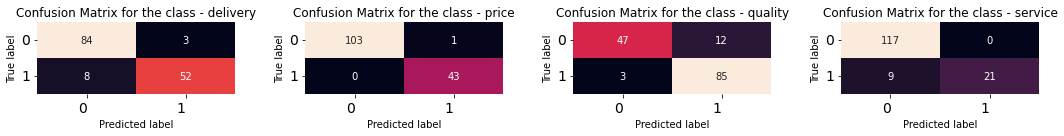

[{('Precision', 'Micro'): 0.4013605442176871, ('Precision', 'Macro'): 0.20068027210884354, ('Recall', 'Micro'): 0.5339366515837104, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.458252427184466, ('F1 score', 'Macro'): 0.2719798052650559}, {('Precision', 'Micro'): 0.40273037542662116, ('Precision', 'Macro'): 0.20102972695927684, ('Recall', 'Micro'): 0.5339366515837104, ('Recall', 'Macro'): 0.5, ('F1 score', 'Micro'): 0.4591439688715953, ('F1 score', 'Macro'): 0.2724613152804642}, {('Precision', 'Micro'): 0.5393939393939394, ('Precision', 'Macro'): 0.16354875283446713, ('Recall', 'Micro'): 0.40271493212669685, ('Recall', 'Macro'): 0.25833333333333336, ('F1 score', 'Micro'): 0.46113989637305697, ('F1 score', 'Macro'): 0.19765070921985814}, {('Precision', 'Micro'): 0.5945945945945946, ('Precision', 'Macro'): 0.14965986394557823, ('Recall', 'Micro'): 0.39819004524886875, ('Recall', 'Macro'): 0.25, ('F1 score', 'Micro'): 0.4769647696476964, ('F1 score', 'Macro'): 0.18723404255319148}, {

In [26]:
batch_size = 32
epochs = 4
xl_lr = 3e-5
T = 0.5
xlnet_test_scores = xlnet_model(clean_train_reviews, clean_test_reviews, train_labels, test_labels, epochs, batch_size, xl_lr, T)
print(xlnet_test_scores[0])
print(xlnet_test_scores[1])

In [27]:
print('XLNET')
print('Precision Macro:', [i[('Precision', 'Macro')] for i in xlnet_test_scores[0]][-1])
print('Precision Micro:', [i[('Precision', 'Micro')] for i in xlnet_test_scores[0]][-1])
print('Recall Macro:', [i[('Recall', 'Macro')] for i in xlnet_test_scores[0]][-1])
print('Recall Micro:', [i[('Recall', 'Micro')] for i in xlnet_test_scores[0]][-1])
print('F1 score Macro:', [i[('F1 score', 'Macro')] for i in xlnet_test_scores[0]][-1])
print('F1 score Micro:', [i[('F1 score', 'Micro')] for i in xlnet_test_scores[0]][-1])

XLNET
Precision Macro: 0.9497539831302718
Precision Micro: 0.9262672811059908
Recall Macro: 0.8831439393939393
Recall Micro: 0.9095022624434389
F1 score Macro: 0.9088254759742544
F1 score Micro: 0.9178082191780822
